<h3>导入包</h3>

In [1]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, History
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.compat.v1.reset_default_graph()
clear_session()


warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

<h4>读入A榜数据</h4>

In [2]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])

<h4>读入B榜数据</h4>

In [3]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_B/' + name + '_EC_B.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)

<h4>读入C榜数据</h4>

In [4]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_Final/' + name + '_EC_Final.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)
data_dict

{'二层插座':                    time     value
 0   2013-08-03 00:00:00  0.164062
 1   2013-08-03 00:15:00  0.121094
 2   2013-08-03 00:30:00  0.101562
 3   2013-08-03 00:45:00  0.087891
 4   2013-08-03 01:00:00  0.103516
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.085938
 668 2015-08-17 23:00:00  0.128906
 669 2015-08-17 23:15:00  0.082031
 670 2015-08-17 23:30:00  0.144531
 671 2015-08-17 23:45:00  0.093750
 
 [64744 rows x 2 columns], '二层照明':                    time     value
 0   2013-08-03 00:00:00  0.500000
 1   2013-08-03 00:15:00  0.507812
 2   2013-08-03 00:30:00  0.476562
 3   2013-08-03 00:45:00  0.117188
 4   2013-08-03 01:00:00  0.000000
 ..                  ...       ...
 667 2015-08-17 22:45:00  0.000000
 668 2015-08-17 23:00:00  0.000000
 669 2015-08-17 23:15:00  0.000000
 670 2015-08-17 23:30:00  0.000000
 671 2015-08-17 23:45:00  0.000000
 
 [64992 rows x 2 columns], '一层插座':                    time     value
 0   2013-08-03 00:00:00  0.113281
 1   2013-

<h3>读入天气数据</h3>

In [5]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

温度(C°)  湿度(%)  降雨量(mm)  大气压(hPa)   风向  风向角度(°)  风速(KM/H)  \
time                                                                            
2013-08-03 00:00:00      28     88      1.0      1006  东南风      159         9   
2013-08-03 01:00:00      28     88      0.9      1006  东南风      155         8   
2013-08-03 02:00:00      28     89      0.7      1006  东南风      150         8   
2013-08-03 03:00:00      27     90      0.5      1006  东南风      151         8   
2013-08-03 04:00:00      27     90      0.2      1006  东南风      151         8   
...                     ...    ...      ...       ...  ...      ...       ...   
2015-08-24 19:00:00      27     67      0.0      1006  东北风       43        11   
2015-08-24 20:00:00      26     72      0.0      1007  东北风       45         9   
2015-08-24 21:00:00      25     75      0.4      1007  东北风       35         7   
2015-08-24 22:00:00      24     78      0.7      1007  东北风       25         6   
2015-08-24 23:00:00      23     81      1.1      1007  东北风       16         5   

                     云量(%)  
time                        
2013-08-03 00:00:00     71  
2013-08-03 01:00:00     75  
2013-08-03 02:00:00     54  
2013-08-03 03:00:00     25  
2013-08-03 04:00:00     35  
...                    ...  
2015-08-24 19:00:00      1  
2015-08-24 20:00:00      0  
2015-08-24 21:00:00      2  
2015-08-24 22:00:00      1  
2015-08-24 23:00:00      2  

[18048 rows x 8 columns]

<h3>合并数据</h3>

<h4>对齐数据</h4>

In [6]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

time  value_socket_2  value_light_2  value_socket_1  \
0     2013-08-03 00:00:00        0.164062       0.500000        0.113281   
1     2013-08-03 00:15:00        0.121094       0.507812        0.273438   
2     2013-08-03 00:30:00        0.101562       0.476562        0.277344   
3     2013-08-03 00:45:00        0.087891       0.117188        0.218750   
4     2013-08-03 01:00:00        0.103516       0.000000        0.082031   
...                   ...             ...            ...             ...   
64504 2015-08-17 22:45:00        0.085938       0.000000        0.089844   
64505 2015-08-17 23:00:00        0.128906       0.000000        0.140625   
64506 2015-08-17 23:15:00        0.082031       0.000000        0.093750   
64507 2015-08-17 23:30:00        0.144531       0.000000        0.156250   
64508 2015-08-17 23:45:00        0.093750       0.000000        0.078125   

       value_light_1  value_air  
0           0.542969   4.234375  
1           0.542969   5.093750  
2           0.515625   3.234375  
3           0.437500   3.187500  
4           0.406250   3.171875  
...              ...        ...  
64504       0.265625   1.937500  
64505       0.265625   1.750000  
64506       0.265625   1.843750  
64507       0.265625   1.687500  
64508       0.265625   1.750000  

[64509 rows x 6 columns]

<h4>将一二层数据相加</h4>

In [7]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [8]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

value_air  value_socket  value_light  value_total
2014-03-14 13:00:00    2.43750      1.539062     1.710938     5.687500
2014-03-14 13:15:00    2.37500      1.769531     1.777344     5.921875
2014-03-14 13:30:00    2.37500      1.347656     1.882812     5.605469
2014-03-14 13:45:00        NaN           NaN          NaN          NaN
2014-03-14 14:00:00        NaN           NaN          NaN          NaN
...                        ...           ...          ...          ...
2014-04-23 19:15:00        NaN           NaN          NaN          NaN
2014-04-23 19:30:00        NaN           NaN          NaN          NaN
2014-04-23 19:45:00        NaN           NaN          NaN          NaN
2014-04-23 20:00:00        NaN           NaN          NaN          NaN
2014-04-23 20:15:00    1.09375      0.595703     0.984375     2.673828

[3870 rows x 4 columns]

In [9]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

value_air  value_socket  value_light  value_total
2014-11-17 08:00:00    0.59375      0.390625     0.320312     1.304688
2014-11-17 08:15:00    0.59375      0.207031     0.281250     1.082031
2014-11-17 08:30:00        NaN           NaN          NaN          NaN
2014-11-17 08:45:00        NaN           NaN          NaN          NaN
2014-11-17 09:00:00        NaN           NaN          NaN          NaN
...                        ...           ...          ...          ...
2014-12-10 16:15:00        NaN           NaN          NaN          NaN
2014-12-10 16:30:00        NaN           NaN          NaN          NaN
2014-12-10 16:45:00   11.62500      1.718750     2.039062    15.382812
2014-12-10 17:00:00   12.15625      1.757812     2.039062    15.953125
2014-12-10 17:15:00   11.75000      1.531250     2.019531    15.300781

[2246 rows x 4 columns]

<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [10]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours.extend(pd.date_range("2014-03-14 13:00:00", "2014-04-23 20:00:00", freq="1H").tolist())
nan_index_hours.extend(pd.date_range("2014-11-17 08:00:00", "2014-12-10 16:00:00", freq="1H").tolist())
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex(['2013-08-04 12:00:00', '2013-08-07 07:00:00',
               '2013-10-14 10:00:00', '2013-10-14 11:00:00',
               '2013-10-14 12:00:00', '2013-10-14 13:00:00',
               '2013-10-14 14:00:00', '2013-10-14 15:00:00',
               '2013-10-14 16:00:00', '2013-10-14 17:00:00',
               ...
               '2015-07-30 08:00:00', '2015-07-30 09:00:00',
               '2015-07-30 11:00:00', '2015-07-30 12:00:00',
               '2015-07-30 14:00:00', '2015-07-30 15:00:00',
               '2015-07-30 17:00:00', '2015-07-30 18:00:00',
               '2015-07-30 20:00:00', '2015-07-30 21:00:00'],
              dtype='datetime64[ns]', length=1860, freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [11]:
data["value_air"] = data["value_air"].interpolate(method="time")
data["value_light"] = data["value_light"].interpolate(method="time")
data["value_socket"] = data["value_socket"].interpolate(method="time")
data["value_total"] = data["value_total"].interpolate(method="time")

<h3>按照每小时相加</h3>

In [12]:
data = data.resample("1H").sum()
data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
data = data.dropna()
data

value_air  value_socket  value_light  value_total
2013-08-03 00:00:00  15.750000      1.357422     3.640625    20.748047
2013-08-03 01:00:00  12.390625      0.785156     1.621094    14.796875
2013-08-03 02:00:00  10.953125      0.771484     1.632812    13.357422
2013-08-03 03:00:00  11.343750      0.830078     1.613281    13.787109
2013-08-03 04:00:00  12.671875      1.162109     1.812500    15.646484
...                        ...           ...          ...          ...
2015-08-17 19:00:00   8.187500      1.015625     1.187500    10.390625
2015-08-17 20:00:00   8.031250      1.000000     0.937500     9.968750
2015-08-17 21:00:00   8.656250      1.007812     1.046875    10.710938
2015-08-17 22:00:00   7.468750      0.949219     1.156250     9.574219
2015-08-17 23:00:00   7.031250      0.917969     1.062500     9.011719

[16351 rows x 4 columns]

<AxesSubplot:>

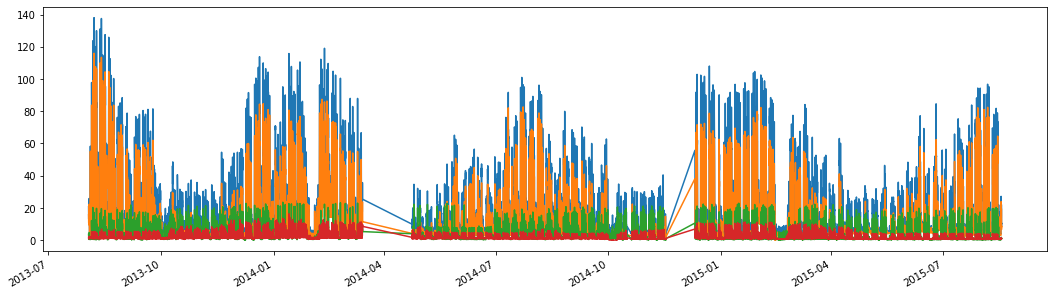

In [13]:
data["value_total"].plot(figsize=(18,5))
data["value_air"].plot(figsize=(18,5))
data["value_light"].plot(figsize=(18,5))
data["value_socket"].plot(figsize=(18,5))

<h3>合并天气数据</h3>

In [14]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

value_air  value_socket  value_light  value_total  \
time                                                                     
2013-08-03 00:00:00  15.750000      1.357422     3.640625    20.748047   
2013-08-03 01:00:00  12.390625      0.785156     1.621094    14.796875   
2013-08-03 02:00:00  10.953125      0.771484     1.632812    13.357422   
2013-08-03 03:00:00  11.343750      0.830078     1.613281    13.787109   
2013-08-03 04:00:00  12.671875      1.162109     1.812500    15.646484   
...                        ...           ...          ...          ...   
2015-08-24 19:00:00        NaN           NaN          NaN          NaN   
2015-08-24 20:00:00        NaN           NaN          NaN          NaN   
2015-08-24 21:00:00        NaN           NaN          NaN          NaN   
2015-08-24 22:00:00        NaN           NaN          NaN          NaN   
2015-08-24 23:00:00        NaN           NaN          NaN          NaN   

                     温度(C°)  湿度(%)  降雨量(mm)  大气压(hPa)   风向  风向角度(°)  风速(KM/H)  \
time                                                                            
2013-08-03 00:00:00      28     88      1.0      1006  东南风      159         9   
2013-08-03 01:00:00      28     88      0.9      1006  东南风      155         8   
2013-08-03 02:00:00      28     89      0.7      1006  东南风      150         8   
2013-08-03 03:00:00      27     90      0.5      1006  东南风      151         8   
2013-08-03 04:00:00      27     90      0.2      1006  东南风      151         8   
...                     ...    ...      ...       ...  ...      ...       ...   
2015-08-24 19:00:00      27     67      0.0      1006  东北风       43        11   
2015-08-24 20:00:00      26     72      0.0      1007  东北风       45         9   
2015-08-24 21:00:00      25     75      0.4      1007  东北风       35         7   
2015-08-24 22:00:00      24     78      0.7      1007  东北风       25         6   
2015-08-24 23:00:00      23     81      1.1      1007  东北风       16         5   

                     云量(%)  
time                        
2013-08-03 00:00:00     71  
2013-08-03 01:00:00     75  
2013-08-03 02:00:00     54  
2013-08-03 03:00:00     25  
2013-08-03 04:00:00     35  
...                    ...  
2015-08-24 19:00:00      1  
2015-08-24 20:00:00      0  
2015-08-24 21:00:00      2  
2015-08-24 22:00:00      1  
2015-08-24 23:00:00      2  

[18048 rows x 12 columns]

<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [15]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [16]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
data["date"] = list(map(lambda x: x.date(), data.index.to_list()))
data["wind_angle"] = data["wind_angle"].apply(lambda x: np.cos(np.pi / 180 * x))
data["is_summer"] = data["month"].apply(lambda x: x in (6, 7, 8)).astype(int)
data["is_winter"] = data["month"].apply(lambda x: x in (12, 1, 2)).astype(int)

mean_weather = data[["date", "temp", "humidity", "atmos", "wind_angle", "wind_speed", "cloud"]].groupby("date").mean()
sum_weather = data[["date", "rainfall"]].groupby("date").sum()
data = pd.merge(data.drop(columns=["temp", "humidity", "atmos", "wind_angle", "wind_speed", "cloud"]), mean_weather, how="inner", left_on="date", right_index=True)
data = pd.merge(data.drop(columns=["rainfall"]), sum_weather, how="inner", left_on="date", right_index=True)
data = data.drop(columns=["date"])

# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

value_air  value_socket  value_light  value_total  \
time                                                                     
2013-08-03 00:00:00  15.750000      1.357422     3.640625    20.748047   
2013-08-03 01:00:00  12.390625      0.785156     1.621094    14.796875   
2013-08-03 02:00:00  10.953125      0.771484     1.632812    13.357422   
2013-08-03 03:00:00  11.343750      0.830078     1.613281    13.787109   
2013-08-03 04:00:00  12.671875      1.162109     1.812500    15.646484   
...                        ...           ...          ...          ...   
2015-08-24 19:00:00        NaN           NaN          NaN          NaN   
2015-08-24 20:00:00        NaN           NaN          NaN          NaN   
2015-08-24 21:00:00        NaN           NaN          NaN          NaN   
2015-08-24 22:00:00        NaN           NaN          NaN          NaN   
2015-08-24 23:00:00        NaN           NaN          NaN          NaN   

                    wind_direction  workday  hour  week  day  month  year  \
time                                                                        
2013-08-03 00:00:00            东南风        0     0     5    3      8  2013   
2013-08-03 01:00:00            东南风        0     1     5    3      8  2013   
2013-08-03 02:00:00            东南风        0     2     5    3      8  2013   
2013-08-03 03:00:00            东南风        0     3     5    3      8  2013   
2013-08-03 04:00:00            东南风        0     4     5    3      8  2013   
...                            ...      ...   ...   ...  ...    ...   ...   
2015-08-24 19:00:00            东北风        1    19     0   24      8  2015   
2015-08-24 20:00:00            东北风        1    20     0   24      8  2015   
2015-08-24 21:00:00            东北风        1    21     0   24      8  2015   
2015-08-24 22:00:00            东北风        1    22     0   24      8  2015   
2015-08-24 23:00:00            东北风        1    23     0   24      8  2015   

                     is_summer  is_winter       temp   humidity        atmos  \
time                                                                           
2013-08-03 00:00:00          1          0  29.833333  77.625000  1005.791667   
2013-08-03 01:00:00          1          0  29.833333  77.625000  1005.791667   
2013-08-03 02:00:00          1          0  29.833333  77.625000  1005.791667   
2013-08-03 03:00:00          1          0  29.833333  77.625000  1005.791667   
2013-08-03 04:00:00          1          0  29.833333  77.625000  1005.791667   
...                        ...        ...        ...        ...          ...   
2015-08-24 19:00:00          1          0  25.958333  71.541667  1006.958333   
2015-08-24 20:00:00          1          0  25.958333  71.541667  1006.958333   
2015-08-24 21:00:00          1          0  25.958333  71.541667  1006.958333   
2015-08-24 22:00:00          1          0  25.958333  71.541667  1006.958333   
2015-08-24 23:00:00          1          0  25.958333  71.541667  1006.958333   

                     wind_angle  wind_speed      cloud  rainfall  
time                                                              
2013-08-03 00:00:00   -0.731140       6.375  67.125000      18.3  
2013-08-03 01:00:00   -0.731140       6.375  67.125000      18.3  
2013-08-03 02:00:00   -0.731140       6.375  67.125000      18.3  
2013-08-03 03:00:00   -0.731140       6.375  67.125000      18.3  
2013-08-03 04:00:00   -0.731140       6.375  67.125000      18.3  
...                         ...         ...        ...       ...  
2015-08-24 19:00:00    0.661124      12.250  41.166667       4.0  
2015-08-24 20:00:00    0.661124      12.250  41.166667       4.0  
2015-08-24 21:00:00    0.661124      12.250  41.166667       4.0  
2015-08-24 22:00:00    0.661124      12.250  41.166667       4.0  
2015-08-24 23:00:00    0.661124      12.250  41.166667       4.0  

[18048 rows x 20 columns]

<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [17]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

value_air  value_socket  value_light  value_total  \
time                                                                     
2013-08-03 00:00:00  15.750000      1.357422     3.640625    20.748047   
2013-08-03 01:00:00  12.390625      0.785156     1.621094    14.796875   
2013-08-03 02:00:00  10.953125      0.771484     1.632812    13.357422   
2013-08-03 03:00:00  11.343750      0.830078     1.613281    13.787109   
2013-08-03 04:00:00  12.671875      1.162109     1.812500    15.646484   
...                        ...           ...          ...          ...   
2015-08-24 19:00:00        NaN           NaN          NaN          NaN   
2015-08-24 20:00:00        NaN           NaN          NaN          NaN   
2015-08-24 21:00:00        NaN           NaN          NaN          NaN   
2015-08-24 22:00:00        NaN           NaN          NaN          NaN   
2015-08-24 23:00:00        NaN           NaN          NaN          NaN   

                     workday  hour  week  day  month  year  ...      cloud  \
time                                                        ...              
2013-08-03 00:00:00        0     0     5    3      8  2013  ...  67.125000   
2013-08-03 01:00:00        0     1     5    3      8  2013  ...  67.125000   
2013-08-03 02:00:00        0     2     5    3      8  2013  ...  67.125000   
2013-08-03 03:00:00        0     3     5    3      8  2013  ...  67.125000   
2013-08-03 04:00:00        0     4     5    3      8  2013  ...  67.125000   
...                      ...   ...   ...  ...    ...   ...  ...        ...   
2015-08-24 19:00:00        1    19     0   24      8  2015  ...  41.166667   
2015-08-24 20:00:00        1    20     0   24      8  2015  ...  41.166667   
2015-08-24 21:00:00        1    21     0   24      8  2015  ...  41.166667   
2015-08-24 22:00:00        1    22     0   24      8  2015  ...  41.166667   
2015-08-24 23:00:00        1    23     0   24      8  2015  ...  41.166667   

                     rainfall  东北风  东南风  东风  北风  南风  西北风  西南风  西风  
time                                                               
2013-08-03 00:00:00      18.3    0    1   0   0   0    0    0   0  
2013-08-03 01:00:00      18.3    0    1   0   0   0    0    0   0  
2013-08-03 02:00:00      18.3    0    1   0   0   0    0    0   0  
2013-08-03 03:00:00      18.3    0    1   0   0   0    0    0   0  
2013-08-03 04:00:00      18.3    0    1   0   0   0    0    0   0  
...                       ...  ...  ...  ..  ..  ..  ...  ...  ..  
2015-08-24 19:00:00       4.0    1    0   0   0   0    0    0   0  
2015-08-24 20:00:00       4.0    1    0   0   0   0    0    0   0  
2015-08-24 21:00:00       4.0    1    0   0   0   0    0    0   0  
2015-08-24 22:00:00       4.0    1    0   0   0   0    0    0   0  
2015-08-24 23:00:00       4.0    1    0   0   0   0    0    0   0  

[18048 rows x 27 columns]

<h4>对星期几进行onehot</h4>

In [18]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

value_air  value_socket  value_light  value_total  \
time                                                                     
2013-08-03 00:00:00  15.750000      1.357422     3.640625    20.748047   
2013-08-03 01:00:00  12.390625      0.785156     1.621094    14.796875   
2013-08-03 02:00:00  10.953125      0.771484     1.632812    13.357422   
2013-08-03 03:00:00  11.343750      0.830078     1.613281    13.787109   
2013-08-03 04:00:00  12.671875      1.162109     1.812500    15.646484   
...                        ...           ...          ...          ...   
2015-08-24 19:00:00        NaN           NaN          NaN          NaN   
2015-08-24 20:00:00        NaN           NaN          NaN          NaN   
2015-08-24 21:00:00        NaN           NaN          NaN          NaN   
2015-08-24 22:00:00        NaN           NaN          NaN          NaN   
2015-08-24 23:00:00        NaN           NaN          NaN          NaN   

                     workday  hour  day  month  year  is_summer  ...  西北风  \
time                                                             ...        
2013-08-03 00:00:00        0     0    3      8  2013          1  ...    0   
2013-08-03 01:00:00        0     1    3      8  2013          1  ...    0   
2013-08-03 02:00:00        0     2    3      8  2013          1  ...    0   
2013-08-03 03:00:00        0     3    3      8  2013          1  ...    0   
2013-08-03 04:00:00        0     4    3      8  2013          1  ...    0   
...                      ...   ...  ...    ...   ...        ...  ...  ...   
2015-08-24 19:00:00        1    19   24      8  2015          1  ...    0   
2015-08-24 20:00:00        1    20   24      8  2015          1  ...    0   
2015-08-24 21:00:00        1    21   24      8  2015          1  ...    0   
2015-08-24 22:00:00        1    22   24      8  2015          1  ...    0   
2015-08-24 23:00:00        1    23   24      8  2015          1  ...    0   

                     西南风  西风  星期1  星期2  星期3  星期4  星期5  星期6  星期7  
time                                                             
2013-08-03 00:00:00    0   0    0    0    0    0    0    1    0  
2013-08-03 01:00:00    0   0    0    0    0    0    0    1    0  
2013-08-03 02:00:00    0   0    0    0    0    0    0    1    0  
2013-08-03 03:00:00    0   0    0    0    0    0    0    1    0  
2013-08-03 04:00:00    0   0    0    0    0    0    0    1    0  
...                  ...  ..  ...  ...  ...  ...  ...  ...  ...  
2015-08-24 19:00:00    0   0    1    0    0    0    0    0    0  
2015-08-24 20:00:00    0   0    1    0    0    0    0    0    0  
2015-08-24 21:00:00    0   0    1    0    0    0    0    0    0  
2015-08-24 22:00:00    0   0    1    0    0    0    0    0    0  
2015-08-24 23:00:00    0   0    1    0    0    0    0    0    0  

[18048 rows x 33 columns]

<h3>构建模型</h3>

In [19]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [20]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_metric(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))[1]
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [21]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [22]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [23]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

In [24]:
@tf.function
def split_xy(x):
    return x[:, :, 1:], x[:, :, 0]

<h4>针对socket构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

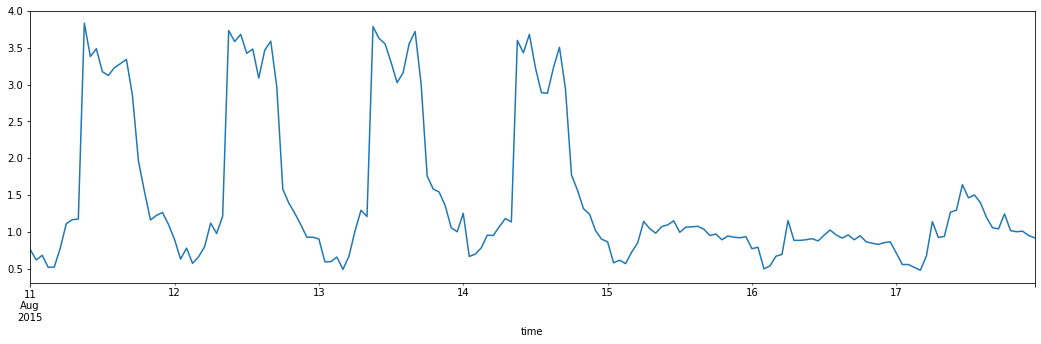

In [25]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [26]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_socket = data_socket["value_socket"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_socket.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [27]:
model_socket1 = LGBMRegressor(n_estimators=10000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred1 = model_socket1.predict(x_test_socket)

<h5>取最后7*24个点作为模型2预测值</h5>

In [28]:
socket_pred2 = data_socket.loc[: "2015-08-17 23:00:00", "value_socket"].values[-7*24:]

<h5>构建catboost</h5>

In [29]:
model_socket3 = CatBoostRegressor(n_estimators=10000, random_state=1024).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred3 = model_socket3.predict(x_test_socket)

Learning rate set to 0.009761
0:	learn: 1.9839479	total: 58.1ms	remaining: 9m 41s
1:	learn: 1.9691527	total: 60.5ms	remaining: 5m 2s
2:	learn: 1.9545338	total: 62.6ms	remaining: 3m 28s
3:	learn: 1.9400938	total: 64.7ms	remaining: 2m 41s
4:	learn: 1.9258175	total: 66.8ms	remaining: 2m 13s
5:	learn: 1.9117169	total: 68.9ms	remaining: 1m 54s
6:	learn: 1.8977769	total: 71ms	remaining: 1m 41s
7:	learn: 1.8839685	total: 73ms	remaining: 1m 31s
8:	learn: 1.8703248	total: 75.1ms	remaining: 1m 23s
9:	learn: 1.8568468	total: 77.3ms	remaining: 1m 17s
10:	learn: 1.8435352	total: 79.3ms	remaining: 1m 12s
11:	learn: 1.8303047	total: 81.3ms	remaining: 1m 7s
12:	learn: 1.8173023	total: 83.4ms	remaining: 1m 4s
13:	learn: 1.8044566	total: 85.7ms	remaining: 1m 1s
14:	learn: 1.7917644	total: 87.9ms	remaining: 58.5s
15:	learn: 1.7792853	total: 90.1ms	remaining: 56.2s
16:	learn: 1.7668993	total: 92.3ms	remaining: 54.2s
17:	learn: 1.7546926	total: 94.5ms	remaining: 52.4s
18:	learn: 1.7425879	total: 96.7ms	rem

233:	learn: 0.8491807	total: 541ms	remaining: 22.6s
234:	learn: 0.8481962	total: 543ms	remaining: 22.6s
235:	learn: 0.8470582	total: 545ms	remaining: 22.5s
236:	learn: 0.8461640	total: 547ms	remaining: 22.5s
237:	learn: 0.8452312	total: 549ms	remaining: 22.5s
238:	learn: 0.8443537	total: 551ms	remaining: 22.5s
239:	learn: 0.8434058	total: 553ms	remaining: 22.5s
240:	learn: 0.8423563	total: 555ms	remaining: 22.5s
241:	learn: 0.8410967	total: 558ms	remaining: 22.5s
242:	learn: 0.8402125	total: 560ms	remaining: 22.5s
243:	learn: 0.8393010	total: 562ms	remaining: 22.5s
244:	learn: 0.8384457	total: 564ms	remaining: 22.4s
245:	learn: 0.8376098	total: 566ms	remaining: 22.4s
246:	learn: 0.8369147	total: 568ms	remaining: 22.4s
247:	learn: 0.8360289	total: 570ms	remaining: 22.4s
248:	learn: 0.8352466	total: 572ms	remaining: 22.4s
249:	learn: 0.8344421	total: 574ms	remaining: 22.4s
250:	learn: 0.8336220	total: 576ms	remaining: 22.4s
251:	learn: 0.8327720	total: 578ms	remaining: 22.4s
252:	learn: 

411:	learn: 0.7428986	total: 901ms	remaining: 21s
412:	learn: 0.7424696	total: 904ms	remaining: 21s
413:	learn: 0.7420628	total: 906ms	remaining: 21s
414:	learn: 0.7416996	total: 908ms	remaining: 21s
415:	learn: 0.7412764	total: 910ms	remaining: 21s
416:	learn: 0.7407796	total: 912ms	remaining: 21s
417:	learn: 0.7403095	total: 914ms	remaining: 21s
418:	learn: 0.7400471	total: 916ms	remaining: 21s
419:	learn: 0.7397259	total: 918ms	remaining: 20.9s
420:	learn: 0.7392581	total: 920ms	remaining: 20.9s
421:	learn: 0.7388889	total: 922ms	remaining: 20.9s
422:	learn: 0.7385923	total: 924ms	remaining: 20.9s
423:	learn: 0.7381910	total: 926ms	remaining: 20.9s
424:	learn: 0.7377694	total: 928ms	remaining: 20.9s
425:	learn: 0.7374566	total: 930ms	remaining: 20.9s
426:	learn: 0.7371681	total: 932ms	remaining: 20.9s
427:	learn: 0.7368645	total: 934ms	remaining: 20.9s
428:	learn: 0.7366082	total: 936ms	remaining: 20.9s
429:	learn: 0.7362773	total: 938ms	remaining: 20.9s
430:	learn: 0.7359794	total:

591:	learn: 0.6876676	total: 1.27s	remaining: 20.2s
592:	learn: 0.6873292	total: 1.27s	remaining: 20.2s
593:	learn: 0.6870068	total: 1.27s	remaining: 20.2s
594:	learn: 0.6868258	total: 1.27s	remaining: 20.2s
595:	learn: 0.6865752	total: 1.28s	remaining: 20.2s
596:	learn: 0.6864134	total: 1.28s	remaining: 20.2s
597:	learn: 0.6861703	total: 1.28s	remaining: 20.1s
598:	learn: 0.6859722	total: 1.28s	remaining: 20.1s
599:	learn: 0.6857190	total: 1.28s	remaining: 20.1s
600:	learn: 0.6854418	total: 1.29s	remaining: 20.1s
601:	learn: 0.6852272	total: 1.29s	remaining: 20.1s
602:	learn: 0.6849535	total: 1.29s	remaining: 20.1s
603:	learn: 0.6846460	total: 1.29s	remaining: 20.1s
604:	learn: 0.6844059	total: 1.3s	remaining: 20.1s
605:	learn: 0.6841945	total: 1.3s	remaining: 20.1s
606:	learn: 0.6839935	total: 1.3s	remaining: 20.1s
607:	learn: 0.6838128	total: 1.3s	remaining: 20.1s
608:	learn: 0.6835612	total: 1.3s	remaining: 20.1s
609:	learn: 0.6834066	total: 1.31s	remaining: 20.1s
610:	learn: 0.683

768:	learn: 0.6524905	total: 1.63s	remaining: 19.5s
769:	learn: 0.6522634	total: 1.63s	remaining: 19.5s
770:	learn: 0.6521524	total: 1.63s	remaining: 19.5s
771:	learn: 0.6519794	total: 1.63s	remaining: 19.5s
772:	learn: 0.6517878	total: 1.64s	remaining: 19.5s
773:	learn: 0.6516402	total: 1.64s	remaining: 19.5s
774:	learn: 0.6514918	total: 1.64s	remaining: 19.5s
775:	learn: 0.6512702	total: 1.64s	remaining: 19.5s
776:	learn: 0.6511391	total: 1.64s	remaining: 19.5s
777:	learn: 0.6509229	total: 1.65s	remaining: 19.5s
778:	learn: 0.6507455	total: 1.65s	remaining: 19.5s
779:	learn: 0.6506158	total: 1.65s	remaining: 19.5s
780:	learn: 0.6505428	total: 1.65s	remaining: 19.5s
781:	learn: 0.6504038	total: 1.66s	remaining: 19.5s
782:	learn: 0.6502880	total: 1.66s	remaining: 19.5s
783:	learn: 0.6501704	total: 1.66s	remaining: 19.5s
784:	learn: 0.6500213	total: 1.66s	remaining: 19.5s
785:	learn: 0.6497286	total: 1.66s	remaining: 19.5s
786:	learn: 0.6495641	total: 1.67s	remaining: 19.5s
787:	learn: 

943:	learn: 0.6262060	total: 1.98s	remaining: 19s
944:	learn: 0.6259797	total: 1.99s	remaining: 19s
945:	learn: 0.6258068	total: 1.99s	remaining: 19s
946:	learn: 0.6256529	total: 1.99s	remaining: 19s
947:	learn: 0.6255531	total: 1.99s	remaining: 19s
948:	learn: 0.6254729	total: 1.99s	remaining: 19s
949:	learn: 0.6253270	total: 2s	remaining: 19s
950:	learn: 0.6252329	total: 2s	remaining: 19s
951:	learn: 0.6250937	total: 2s	remaining: 19s
952:	learn: 0.6250130	total: 2s	remaining: 19s
953:	learn: 0.6248256	total: 2s	remaining: 19s
954:	learn: 0.6247300	total: 2.01s	remaining: 19s
955:	learn: 0.6246322	total: 2.01s	remaining: 19s
956:	learn: 0.6244698	total: 2.01s	remaining: 19s
957:	learn: 0.6243269	total: 2.01s	remaining: 19s
958:	learn: 0.6242661	total: 2.02s	remaining: 19s
959:	learn: 0.6241336	total: 2.02s	remaining: 19s
960:	learn: 0.6239593	total: 2.02s	remaining: 19s
961:	learn: 0.6238578	total: 2.02s	remaining: 19s
962:	learn: 0.6236224	total: 2.02s	remaining: 19s
963:	learn: 0.6

1125:	learn: 0.6038998	total: 2.35s	remaining: 18.6s
1126:	learn: 0.6037189	total: 2.36s	remaining: 18.6s
1127:	learn: 0.6036596	total: 2.36s	remaining: 18.5s
1128:	learn: 0.6035665	total: 2.36s	remaining: 18.5s
1129:	learn: 0.6034564	total: 2.36s	remaining: 18.5s
1130:	learn: 0.6033741	total: 2.36s	remaining: 18.5s
1131:	learn: 0.6032687	total: 2.37s	remaining: 18.5s
1132:	learn: 0.6031537	total: 2.37s	remaining: 18.5s
1133:	learn: 0.6030607	total: 2.37s	remaining: 18.5s
1134:	learn: 0.6029863	total: 2.37s	remaining: 18.5s
1135:	learn: 0.6028588	total: 2.38s	remaining: 18.5s
1136:	learn: 0.6027041	total: 2.38s	remaining: 18.5s
1137:	learn: 0.6026009	total: 2.38s	remaining: 18.5s
1138:	learn: 0.6024592	total: 2.38s	remaining: 18.5s
1139:	learn: 0.6023218	total: 2.38s	remaining: 18.5s
1140:	learn: 0.6022059	total: 2.38s	remaining: 18.5s
1141:	learn: 0.6021312	total: 2.39s	remaining: 18.5s
1142:	learn: 0.6020704	total: 2.39s	remaining: 18.5s
1143:	learn: 0.6019108	total: 2.39s	remaining:

1298:	learn: 0.5865733	total: 2.7s	remaining: 18.1s
1299:	learn: 0.5865089	total: 2.71s	remaining: 18.1s
1300:	learn: 0.5864673	total: 2.71s	remaining: 18.1s
1301:	learn: 0.5863475	total: 2.71s	remaining: 18.1s
1302:	learn: 0.5862333	total: 2.71s	remaining: 18.1s
1303:	learn: 0.5861652	total: 2.71s	remaining: 18.1s
1304:	learn: 0.5860992	total: 2.72s	remaining: 18.1s
1305:	learn: 0.5859581	total: 2.72s	remaining: 18.1s
1306:	learn: 0.5858625	total: 2.72s	remaining: 18.1s
1307:	learn: 0.5857964	total: 2.72s	remaining: 18.1s
1308:	learn: 0.5857100	total: 2.73s	remaining: 18.1s
1309:	learn: 0.5856427	total: 2.73s	remaining: 18.1s
1310:	learn: 0.5855579	total: 2.73s	remaining: 18.1s
1311:	learn: 0.5854854	total: 2.73s	remaining: 18.1s
1312:	learn: 0.5854056	total: 2.73s	remaining: 18.1s
1313:	learn: 0.5852850	total: 2.73s	remaining: 18.1s
1314:	learn: 0.5851948	total: 2.74s	remaining: 18.1s
1315:	learn: 0.5851113	total: 2.74s	remaining: 18.1s
1316:	learn: 0.5850203	total: 2.74s	remaining: 

1479:	learn: 0.5714927	total: 3.07s	remaining: 17.7s
1480:	learn: 0.5714102	total: 3.07s	remaining: 17.7s
1481:	learn: 0.5713402	total: 3.08s	remaining: 17.7s
1482:	learn: 0.5712703	total: 3.08s	remaining: 17.7s
1483:	learn: 0.5711549	total: 3.08s	remaining: 17.7s
1484:	learn: 0.5710470	total: 3.08s	remaining: 17.7s
1485:	learn: 0.5709991	total: 3.08s	remaining: 17.7s
1486:	learn: 0.5709430	total: 3.09s	remaining: 17.7s
1487:	learn: 0.5707447	total: 3.09s	remaining: 17.7s
1488:	learn: 0.5706655	total: 3.09s	remaining: 17.7s
1489:	learn: 0.5705727	total: 3.09s	remaining: 17.7s
1490:	learn: 0.5704919	total: 3.1s	remaining: 17.7s
1491:	learn: 0.5704203	total: 3.1s	remaining: 17.7s
1492:	learn: 0.5703404	total: 3.1s	remaining: 17.7s
1493:	learn: 0.5702225	total: 3.1s	remaining: 17.7s
1494:	learn: 0.5701490	total: 3.1s	remaining: 17.7s
1495:	learn: 0.5700561	total: 3.11s	remaining: 17.7s
1496:	learn: 0.5699957	total: 3.11s	remaining: 17.7s
1497:	learn: 0.5699003	total: 3.11s	remaining: 17.7

1648:	learn: 0.5584544	total: 3.42s	remaining: 17.3s
1649:	learn: 0.5584003	total: 3.42s	remaining: 17.3s
1650:	learn: 0.5583383	total: 3.42s	remaining: 17.3s
1651:	learn: 0.5582958	total: 3.43s	remaining: 17.3s
1652:	learn: 0.5582463	total: 3.43s	remaining: 17.3s
1653:	learn: 0.5581750	total: 3.43s	remaining: 17.3s
1654:	learn: 0.5581057	total: 3.43s	remaining: 17.3s
1655:	learn: 0.5580490	total: 3.44s	remaining: 17.3s
1656:	learn: 0.5579858	total: 3.44s	remaining: 17.3s
1657:	learn: 0.5579363	total: 3.44s	remaining: 17.3s
1658:	learn: 0.5578395	total: 3.44s	remaining: 17.3s
1659:	learn: 0.5577815	total: 3.44s	remaining: 17.3s
1660:	learn: 0.5576665	total: 3.45s	remaining: 17.3s
1661:	learn: 0.5575251	total: 3.45s	remaining: 17.3s
1662:	learn: 0.5574425	total: 3.45s	remaining: 17.3s
1663:	learn: 0.5573349	total: 3.45s	remaining: 17.3s
1664:	learn: 0.5572897	total: 3.45s	remaining: 17.3s
1665:	learn: 0.5571992	total: 3.46s	remaining: 17.3s
1666:	learn: 0.5571130	total: 3.46s	remaining:

1822:	learn: 0.5461709	total: 3.78s	remaining: 17s
1823:	learn: 0.5461063	total: 3.78s	remaining: 17s
1824:	learn: 0.5460145	total: 3.79s	remaining: 17s
1825:	learn: 0.5459579	total: 3.79s	remaining: 17s
1826:	learn: 0.5458886	total: 3.79s	remaining: 17s
1827:	learn: 0.5458524	total: 3.79s	remaining: 16.9s
1828:	learn: 0.5457715	total: 3.79s	remaining: 16.9s
1829:	learn: 0.5457238	total: 3.79s	remaining: 16.9s
1830:	learn: 0.5456355	total: 3.8s	remaining: 16.9s
1831:	learn: 0.5455408	total: 3.8s	remaining: 16.9s
1832:	learn: 0.5454840	total: 3.8s	remaining: 16.9s
1833:	learn: 0.5454348	total: 3.8s	remaining: 16.9s
1834:	learn: 0.5454123	total: 3.81s	remaining: 16.9s
1835:	learn: 0.5453334	total: 3.81s	remaining: 16.9s
1836:	learn: 0.5452718	total: 3.81s	remaining: 16.9s
1837:	learn: 0.5451766	total: 3.81s	remaining: 16.9s
1838:	learn: 0.5451381	total: 3.81s	remaining: 16.9s
1839:	learn: 0.5450955	total: 3.82s	remaining: 16.9s
1840:	learn: 0.5450463	total: 3.82s	remaining: 16.9s
1841:	l

1997:	learn: 0.5359032	total: 4.14s	remaining: 16.6s
1998:	learn: 0.5358522	total: 4.14s	remaining: 16.6s
1999:	learn: 0.5357882	total: 4.15s	remaining: 16.6s
2000:	learn: 0.5357333	total: 4.15s	remaining: 16.6s
2001:	learn: 0.5356937	total: 4.15s	remaining: 16.6s
2002:	learn: 0.5356258	total: 4.15s	remaining: 16.6s
2003:	learn: 0.5355743	total: 4.16s	remaining: 16.6s
2004:	learn: 0.5354896	total: 4.16s	remaining: 16.6s
2005:	learn: 0.5354393	total: 4.16s	remaining: 16.6s
2006:	learn: 0.5354134	total: 4.16s	remaining: 16.6s
2007:	learn: 0.5353482	total: 4.16s	remaining: 16.6s
2008:	learn: 0.5352897	total: 4.17s	remaining: 16.6s
2009:	learn: 0.5352535	total: 4.17s	remaining: 16.6s
2010:	learn: 0.5352018	total: 4.17s	remaining: 16.6s
2011:	learn: 0.5351224	total: 4.17s	remaining: 16.6s
2012:	learn: 0.5350731	total: 4.17s	remaining: 16.6s
2013:	learn: 0.5350364	total: 4.18s	remaining: 16.6s
2014:	learn: 0.5349421	total: 4.18s	remaining: 16.6s
2015:	learn: 0.5348666	total: 4.18s	remaining:

2171:	learn: 0.5263175	total: 4.5s	remaining: 16.2s
2172:	learn: 0.5262914	total: 4.51s	remaining: 16.2s
2173:	learn: 0.5262577	total: 4.51s	remaining: 16.2s
2174:	learn: 0.5262138	total: 4.51s	remaining: 16.2s
2175:	learn: 0.5261565	total: 4.51s	remaining: 16.2s
2176:	learn: 0.5260944	total: 4.51s	remaining: 16.2s
2177:	learn: 0.5260683	total: 4.52s	remaining: 16.2s
2178:	learn: 0.5260039	total: 4.52s	remaining: 16.2s
2179:	learn: 0.5259224	total: 4.52s	remaining: 16.2s
2180:	learn: 0.5258561	total: 4.52s	remaining: 16.2s
2181:	learn: 0.5257963	total: 4.53s	remaining: 16.2s
2182:	learn: 0.5257135	total: 4.53s	remaining: 16.2s
2183:	learn: 0.5256926	total: 4.53s	remaining: 16.2s
2184:	learn: 0.5256407	total: 4.53s	remaining: 16.2s
2185:	learn: 0.5255875	total: 4.53s	remaining: 16.2s
2186:	learn: 0.5255468	total: 4.54s	remaining: 16.2s
2187:	learn: 0.5254863	total: 4.54s	remaining: 16.2s
2188:	learn: 0.5254501	total: 4.54s	remaining: 16.2s
2189:	learn: 0.5254130	total: 4.54s	remaining: 

2344:	learn: 0.5179550	total: 4.86s	remaining: 15.9s
2345:	learn: 0.5178961	total: 4.87s	remaining: 15.9s
2346:	learn: 0.5178393	total: 4.87s	remaining: 15.9s
2347:	learn: 0.5177975	total: 4.87s	remaining: 15.9s
2348:	learn: 0.5177353	total: 4.87s	remaining: 15.9s
2349:	learn: 0.5176813	total: 4.88s	remaining: 15.9s
2350:	learn: 0.5176210	total: 4.88s	remaining: 15.9s
2351:	learn: 0.5175714	total: 4.88s	remaining: 15.9s
2352:	learn: 0.5175262	total: 4.88s	remaining: 15.9s
2353:	learn: 0.5174737	total: 4.88s	remaining: 15.9s
2354:	learn: 0.5174261	total: 4.88s	remaining: 15.9s
2355:	learn: 0.5173551	total: 4.89s	remaining: 15.9s
2356:	learn: 0.5173171	total: 4.89s	remaining: 15.9s
2357:	learn: 0.5172778	total: 4.89s	remaining: 15.9s
2358:	learn: 0.5172529	total: 4.89s	remaining: 15.9s
2359:	learn: 0.5172136	total: 4.9s	remaining: 15.8s
2360:	learn: 0.5171722	total: 4.9s	remaining: 15.8s
2361:	learn: 0.5171419	total: 4.9s	remaining: 15.8s
2362:	learn: 0.5170356	total: 4.9s	remaining: 15.

2518:	learn: 0.5099294	total: 5.23s	remaining: 15.5s
2519:	learn: 0.5098970	total: 5.23s	remaining: 15.5s
2520:	learn: 0.5098574	total: 5.23s	remaining: 15.5s
2521:	learn: 0.5098290	total: 5.23s	remaining: 15.5s
2522:	learn: 0.5097900	total: 5.24s	remaining: 15.5s
2523:	learn: 0.5097202	total: 5.24s	remaining: 15.5s
2524:	learn: 0.5096697	total: 5.24s	remaining: 15.5s
2525:	learn: 0.5096292	total: 5.24s	remaining: 15.5s
2526:	learn: 0.5095939	total: 5.24s	remaining: 15.5s
2527:	learn: 0.5095761	total: 5.25s	remaining: 15.5s
2528:	learn: 0.5095139	total: 5.25s	remaining: 15.5s
2529:	learn: 0.5094800	total: 5.25s	remaining: 15.5s
2530:	learn: 0.5094332	total: 5.25s	remaining: 15.5s
2531:	learn: 0.5093938	total: 5.25s	remaining: 15.5s
2532:	learn: 0.5093590	total: 5.26s	remaining: 15.5s
2533:	learn: 0.5093069	total: 5.26s	remaining: 15.5s
2534:	learn: 0.5092798	total: 5.26s	remaining: 15.5s
2535:	learn: 0.5092388	total: 5.26s	remaining: 15.5s
2536:	learn: 0.5091944	total: 5.26s	remaining:

2697:	learn: 0.5025770	total: 5.6s	remaining: 15.1s
2698:	learn: 0.5025460	total: 5.6s	remaining: 15.1s
2699:	learn: 0.5025042	total: 5.6s	remaining: 15.1s
2700:	learn: 0.5024795	total: 5.6s	remaining: 15.1s
2701:	learn: 0.5024617	total: 5.6s	remaining: 15.1s
2702:	learn: 0.5024203	total: 5.61s	remaining: 15.1s
2703:	learn: 0.5023754	total: 5.61s	remaining: 15.1s
2704:	learn: 0.5023424	total: 5.61s	remaining: 15.1s
2705:	learn: 0.5023057	total: 5.61s	remaining: 15.1s
2706:	learn: 0.5022653	total: 5.62s	remaining: 15.1s
2707:	learn: 0.5021603	total: 5.62s	remaining: 15.1s
2708:	learn: 0.5021070	total: 5.62s	remaining: 15.1s
2709:	learn: 0.5020864	total: 5.62s	remaining: 15.1s
2710:	learn: 0.5020501	total: 5.62s	remaining: 15.1s
2711:	learn: 0.5020235	total: 5.63s	remaining: 15.1s
2712:	learn: 0.5019954	total: 5.63s	remaining: 15.1s
2713:	learn: 0.5019566	total: 5.63s	remaining: 15.1s
2714:	learn: 0.5019229	total: 5.63s	remaining: 15.1s
2715:	learn: 0.5018905	total: 5.63s	remaining: 15.1

2870:	learn: 0.4960796	total: 5.95s	remaining: 14.8s
2871:	learn: 0.4960250	total: 5.95s	remaining: 14.8s
2872:	learn: 0.4959876	total: 5.95s	remaining: 14.8s
2873:	learn: 0.4959338	total: 5.96s	remaining: 14.8s
2874:	learn: 0.4958789	total: 5.96s	remaining: 14.8s
2875:	learn: 0.4958260	total: 5.96s	remaining: 14.8s
2876:	learn: 0.4957805	total: 5.96s	remaining: 14.8s
2877:	learn: 0.4957282	total: 5.96s	remaining: 14.8s
2878:	learn: 0.4956944	total: 5.96s	remaining: 14.8s
2879:	learn: 0.4956681	total: 5.97s	remaining: 14.8s
2880:	learn: 0.4956475	total: 5.97s	remaining: 14.8s
2881:	learn: 0.4956040	total: 5.97s	remaining: 14.8s
2882:	learn: 0.4955639	total: 5.97s	remaining: 14.7s
2883:	learn: 0.4954754	total: 5.98s	remaining: 14.7s
2884:	learn: 0.4954441	total: 5.98s	remaining: 14.7s
2885:	learn: 0.4954105	total: 5.98s	remaining: 14.7s
2886:	learn: 0.4953820	total: 5.98s	remaining: 14.7s
2887:	learn: 0.4953607	total: 5.98s	remaining: 14.7s
2888:	learn: 0.4953222	total: 5.99s	remaining:

3043:	learn: 0.4896795	total: 6.31s	remaining: 14.4s
3044:	learn: 0.4896513	total: 6.31s	remaining: 14.4s
3045:	learn: 0.4895945	total: 6.31s	remaining: 14.4s
3046:	learn: 0.4895548	total: 6.31s	remaining: 14.4s
3047:	learn: 0.4895120	total: 6.32s	remaining: 14.4s
3048:	learn: 0.4894847	total: 6.32s	remaining: 14.4s
3049:	learn: 0.4894435	total: 6.32s	remaining: 14.4s
3050:	learn: 0.4894174	total: 6.32s	remaining: 14.4s
3051:	learn: 0.4893939	total: 6.32s	remaining: 14.4s
3052:	learn: 0.4893540	total: 6.33s	remaining: 14.4s
3053:	learn: 0.4893054	total: 6.33s	remaining: 14.4s
3054:	learn: 0.4892756	total: 6.33s	remaining: 14.4s
3055:	learn: 0.4892491	total: 6.33s	remaining: 14.4s
3056:	learn: 0.4892112	total: 6.33s	remaining: 14.4s
3057:	learn: 0.4891925	total: 6.34s	remaining: 14.4s
3058:	learn: 0.4891588	total: 6.34s	remaining: 14.4s
3059:	learn: 0.4891085	total: 6.34s	remaining: 14.4s
3060:	learn: 0.4890533	total: 6.34s	remaining: 14.4s
3061:	learn: 0.4889989	total: 6.34s	remaining:

3222:	learn: 0.4835282	total: 6.68s	remaining: 14s
3223:	learn: 0.4835085	total: 6.68s	remaining: 14s
3224:	learn: 0.4834964	total: 6.68s	remaining: 14s
3225:	learn: 0.4834558	total: 6.68s	remaining: 14s
3226:	learn: 0.4834244	total: 6.68s	remaining: 14s
3227:	learn: 0.4833984	total: 6.69s	remaining: 14s
3228:	learn: 0.4833634	total: 6.69s	remaining: 14s
3229:	learn: 0.4833315	total: 6.69s	remaining: 14s
3230:	learn: 0.4832976	total: 6.69s	remaining: 14s
3231:	learn: 0.4832782	total: 6.7s	remaining: 14s
3232:	learn: 0.4832536	total: 6.7s	remaining: 14s
3233:	learn: 0.4832282	total: 6.7s	remaining: 14s
3234:	learn: 0.4832093	total: 6.7s	remaining: 14s
3235:	learn: 0.4831790	total: 6.7s	remaining: 14s
3236:	learn: 0.4831533	total: 6.71s	remaining: 14s
3237:	learn: 0.4830978	total: 6.71s	remaining: 14s
3238:	learn: 0.4830563	total: 6.71s	remaining: 14s
3239:	learn: 0.4830283	total: 6.71s	remaining: 14s
3240:	learn: 0.4830065	total: 6.71s	remaining: 14s
3241:	learn: 0.4829867	total: 6.72s	

3395:	learn: 0.4781303	total: 7.04s	remaining: 13.7s
3396:	learn: 0.4780982	total: 7.04s	remaining: 13.7s
3397:	learn: 0.4780574	total: 7.04s	remaining: 13.7s
3398:	learn: 0.4780145	total: 7.04s	remaining: 13.7s
3399:	learn: 0.4779914	total: 7.04s	remaining: 13.7s
3400:	learn: 0.4779179	total: 7.05s	remaining: 13.7s
3401:	learn: 0.4778673	total: 7.05s	remaining: 13.7s
3402:	learn: 0.4778389	total: 7.05s	remaining: 13.7s
3403:	learn: 0.4777926	total: 7.05s	remaining: 13.7s
3404:	learn: 0.4777837	total: 7.06s	remaining: 13.7s
3405:	learn: 0.4777638	total: 7.06s	remaining: 13.7s
3406:	learn: 0.4777259	total: 7.06s	remaining: 13.7s
3407:	learn: 0.4776680	total: 7.06s	remaining: 13.7s
3408:	learn: 0.4776394	total: 7.07s	remaining: 13.7s
3409:	learn: 0.4776127	total: 7.07s	remaining: 13.7s
3410:	learn: 0.4775820	total: 7.07s	remaining: 13.7s
3411:	learn: 0.4775492	total: 7.07s	remaining: 13.7s
3412:	learn: 0.4775246	total: 7.07s	remaining: 13.7s
3413:	learn: 0.4775057	total: 7.08s	remaining:

3564:	learn: 0.4728426	total: 7.39s	remaining: 13.3s
3565:	learn: 0.4728126	total: 7.39s	remaining: 13.3s
3566:	learn: 0.4727759	total: 7.39s	remaining: 13.3s
3567:	learn: 0.4727297	total: 7.4s	remaining: 13.3s
3568:	learn: 0.4726958	total: 7.4s	remaining: 13.3s
3569:	learn: 0.4726842	total: 7.4s	remaining: 13.3s
3570:	learn: 0.4726446	total: 7.4s	remaining: 13.3s
3571:	learn: 0.4726076	total: 7.4s	remaining: 13.3s
3572:	learn: 0.4725864	total: 7.41s	remaining: 13.3s
3573:	learn: 0.4725623	total: 7.41s	remaining: 13.3s
3574:	learn: 0.4725162	total: 7.41s	remaining: 13.3s
3575:	learn: 0.4724879	total: 7.41s	remaining: 13.3s
3576:	learn: 0.4724629	total: 7.41s	remaining: 13.3s
3577:	learn: 0.4724272	total: 7.42s	remaining: 13.3s
3578:	learn: 0.4724094	total: 7.42s	remaining: 13.3s
3579:	learn: 0.4723844	total: 7.42s	remaining: 13.3s
3580:	learn: 0.4723391	total: 7.42s	remaining: 13.3s
3581:	learn: 0.4723217	total: 7.42s	remaining: 13.3s
3582:	learn: 0.4722888	total: 7.43s	remaining: 13.3

3736:	learn: 0.4680580	total: 7.75s	remaining: 13s
3737:	learn: 0.4680374	total: 7.75s	remaining: 13s
3738:	learn: 0.4679908	total: 7.75s	remaining: 13s
3739:	learn: 0.4679600	total: 7.76s	remaining: 13s
3740:	learn: 0.4679368	total: 7.76s	remaining: 13s
3741:	learn: 0.4679063	total: 7.76s	remaining: 13s
3742:	learn: 0.4678849	total: 7.76s	remaining: 13s
3743:	learn: 0.4678525	total: 7.76s	remaining: 13s
3744:	learn: 0.4678370	total: 7.77s	remaining: 13s
3745:	learn: 0.4678111	total: 7.77s	remaining: 13s
3746:	learn: 0.4678012	total: 7.77s	remaining: 13s
3747:	learn: 0.4677597	total: 7.77s	remaining: 13s
3748:	learn: 0.4677360	total: 7.78s	remaining: 13s
3749:	learn: 0.4677196	total: 7.78s	remaining: 13s
3750:	learn: 0.4676852	total: 7.78s	remaining: 13s
3751:	learn: 0.4676431	total: 7.78s	remaining: 13s
3752:	learn: 0.4676103	total: 7.78s	remaining: 13s
3753:	learn: 0.4675844	total: 7.79s	remaining: 13s
3754:	learn: 0.4675631	total: 7.79s	remaining: 13s
3755:	learn: 0.4675463	total: 7

3912:	learn: 0.4633165	total: 8.12s	remaining: 12.6s
3913:	learn: 0.4632946	total: 8.12s	remaining: 12.6s
3914:	learn: 0.4632700	total: 8.12s	remaining: 12.6s
3915:	learn: 0.4632292	total: 8.13s	remaining: 12.6s
3916:	learn: 0.4631920	total: 8.13s	remaining: 12.6s
3917:	learn: 0.4631661	total: 8.13s	remaining: 12.6s
3918:	learn: 0.4631461	total: 8.13s	remaining: 12.6s
3919:	learn: 0.4631104	total: 8.13s	remaining: 12.6s
3920:	learn: 0.4630841	total: 8.14s	remaining: 12.6s
3921:	learn: 0.4630685	total: 8.14s	remaining: 12.6s
3922:	learn: 0.4630529	total: 8.14s	remaining: 12.6s
3923:	learn: 0.4630098	total: 8.14s	remaining: 12.6s
3924:	learn: 0.4629693	total: 8.14s	remaining: 12.6s
3925:	learn: 0.4629557	total: 8.15s	remaining: 12.6s
3926:	learn: 0.4629337	total: 8.15s	remaining: 12.6s
3927:	learn: 0.4629201	total: 8.15s	remaining: 12.6s
3928:	learn: 0.4628973	total: 8.15s	remaining: 12.6s
3929:	learn: 0.4628580	total: 8.16s	remaining: 12.6s
3930:	learn: 0.4628259	total: 8.16s	remaining:

4081:	learn: 0.4591167	total: 8.47s	remaining: 12.3s
4082:	learn: 0.4590899	total: 8.47s	remaining: 12.3s
4083:	learn: 0.4590628	total: 8.48s	remaining: 12.3s
4084:	learn: 0.4590418	total: 8.48s	remaining: 12.3s
4085:	learn: 0.4590248	total: 8.48s	remaining: 12.3s
4086:	learn: 0.4590024	total: 8.48s	remaining: 12.3s
4087:	learn: 0.4589643	total: 8.48s	remaining: 12.3s
4088:	learn: 0.4589432	total: 8.49s	remaining: 12.3s
4089:	learn: 0.4589066	total: 8.49s	remaining: 12.3s
4090:	learn: 0.4588870	total: 8.49s	remaining: 12.3s
4091:	learn: 0.4588724	total: 8.49s	remaining: 12.3s
4092:	learn: 0.4588410	total: 8.5s	remaining: 12.3s
4093:	learn: 0.4588243	total: 8.5s	remaining: 12.3s
4094:	learn: 0.4587997	total: 8.5s	remaining: 12.3s
4095:	learn: 0.4587722	total: 8.5s	remaining: 12.3s
4096:	learn: 0.4587604	total: 8.51s	remaining: 12.3s
4097:	learn: 0.4587361	total: 8.51s	remaining: 12.3s
4098:	learn: 0.4587151	total: 8.51s	remaining: 12.3s
4099:	learn: 0.4587004	total: 8.51s	remaining: 12.

4253:	learn: 0.4547799	total: 8.83s	remaining: 11.9s
4254:	learn: 0.4547598	total: 8.83s	remaining: 11.9s
4255:	learn: 0.4547441	total: 8.84s	remaining: 11.9s
4256:	learn: 0.4547183	total: 8.84s	remaining: 11.9s
4257:	learn: 0.4546970	total: 8.84s	remaining: 11.9s
4258:	learn: 0.4546694	total: 8.84s	remaining: 11.9s
4259:	learn: 0.4546410	total: 8.84s	remaining: 11.9s
4260:	learn: 0.4546045	total: 8.85s	remaining: 11.9s
4261:	learn: 0.4545927	total: 8.85s	remaining: 11.9s
4262:	learn: 0.4545749	total: 8.85s	remaining: 11.9s
4263:	learn: 0.4545575	total: 8.86s	remaining: 11.9s
4264:	learn: 0.4545388	total: 8.86s	remaining: 11.9s
4265:	learn: 0.4545009	total: 8.86s	remaining: 11.9s
4266:	learn: 0.4544781	total: 8.86s	remaining: 11.9s
4267:	learn: 0.4544572	total: 8.87s	remaining: 11.9s
4268:	learn: 0.4544285	total: 8.87s	remaining: 11.9s
4269:	learn: 0.4543948	total: 8.87s	remaining: 11.9s
4270:	learn: 0.4543801	total: 8.87s	remaining: 11.9s
4271:	learn: 0.4543626	total: 8.87s	remaining:

4422:	learn: 0.4507078	total: 9.19s	remaining: 11.6s
4423:	learn: 0.4506802	total: 9.19s	remaining: 11.6s
4424:	learn: 0.4506547	total: 9.2s	remaining: 11.6s
4425:	learn: 0.4506387	total: 9.2s	remaining: 11.6s
4426:	learn: 0.4506100	total: 9.2s	remaining: 11.6s
4427:	learn: 0.4505954	total: 9.2s	remaining: 11.6s
4428:	learn: 0.4505826	total: 9.2s	remaining: 11.6s
4429:	learn: 0.4505629	total: 9.21s	remaining: 11.6s
4430:	learn: 0.4505437	total: 9.21s	remaining: 11.6s
4431:	learn: 0.4505250	total: 9.21s	remaining: 11.6s
4432:	learn: 0.4505060	total: 9.21s	remaining: 11.6s
4433:	learn: 0.4504902	total: 9.21s	remaining: 11.6s
4434:	learn: 0.4504764	total: 9.22s	remaining: 11.6s
4435:	learn: 0.4504500	total: 9.22s	remaining: 11.6s
4436:	learn: 0.4504335	total: 9.22s	remaining: 11.6s
4437:	learn: 0.4504162	total: 9.22s	remaining: 11.6s
4438:	learn: 0.4503967	total: 9.22s	remaining: 11.6s
4439:	learn: 0.4503739	total: 9.23s	remaining: 11.6s
4440:	learn: 0.4503495	total: 9.23s	remaining: 11.6

4599:	learn: 0.4467592	total: 9.56s	remaining: 11.2s
4600:	learn: 0.4467404	total: 9.56s	remaining: 11.2s
4601:	learn: 0.4467106	total: 9.56s	remaining: 11.2s
4602:	learn: 0.4466810	total: 9.57s	remaining: 11.2s
4603:	learn: 0.4466661	total: 9.57s	remaining: 11.2s
4604:	learn: 0.4466480	total: 9.57s	remaining: 11.2s
4605:	learn: 0.4466215	total: 9.57s	remaining: 11.2s
4606:	learn: 0.4466046	total: 9.57s	remaining: 11.2s
4607:	learn: 0.4465887	total: 9.58s	remaining: 11.2s
4608:	learn: 0.4465702	total: 9.58s	remaining: 11.2s
4609:	learn: 0.4465610	total: 9.58s	remaining: 11.2s
4610:	learn: 0.4465425	total: 9.58s	remaining: 11.2s
4611:	learn: 0.4465059	total: 9.59s	remaining: 11.2s
4612:	learn: 0.4464772	total: 9.59s	remaining: 11.2s
4613:	learn: 0.4464470	total: 9.59s	remaining: 11.2s
4614:	learn: 0.4464348	total: 9.59s	remaining: 11.2s
4615:	learn: 0.4464229	total: 9.59s	remaining: 11.2s
4616:	learn: 0.4464033	total: 9.6s	remaining: 11.2s
4617:	learn: 0.4463790	total: 9.6s	remaining: 1

4770:	learn: 0.4429785	total: 9.92s	remaining: 10.9s
4771:	learn: 0.4429573	total: 9.92s	remaining: 10.9s
4772:	learn: 0.4429431	total: 9.92s	remaining: 10.9s
4773:	learn: 0.4429301	total: 9.93s	remaining: 10.9s
4774:	learn: 0.4429177	total: 9.93s	remaining: 10.9s
4775:	learn: 0.4428977	total: 9.93s	remaining: 10.9s
4776:	learn: 0.4428831	total: 9.93s	remaining: 10.9s
4777:	learn: 0.4428645	total: 9.93s	remaining: 10.9s
4778:	learn: 0.4428555	total: 9.94s	remaining: 10.9s
4779:	learn: 0.4428372	total: 9.94s	remaining: 10.9s
4780:	learn: 0.4427959	total: 9.94s	remaining: 10.9s
4781:	learn: 0.4427685	total: 9.94s	remaining: 10.8s
4782:	learn: 0.4427493	total: 9.94s	remaining: 10.8s
4783:	learn: 0.4427365	total: 9.95s	remaining: 10.8s
4784:	learn: 0.4427287	total: 9.95s	remaining: 10.8s
4785:	learn: 0.4426960	total: 9.95s	remaining: 10.8s
4786:	learn: 0.4426804	total: 9.95s	remaining: 10.8s
4787:	learn: 0.4426435	total: 9.96s	remaining: 10.8s
4788:	learn: 0.4426172	total: 9.96s	remaining:

4942:	learn: 0.4394829	total: 10.3s	remaining: 10.5s
4943:	learn: 0.4394683	total: 10.3s	remaining: 10.5s
4944:	learn: 0.4394500	total: 10.3s	remaining: 10.5s
4945:	learn: 0.4394171	total: 10.3s	remaining: 10.5s
4946:	learn: 0.4393722	total: 10.3s	remaining: 10.5s
4947:	learn: 0.4393405	total: 10.3s	remaining: 10.5s
4948:	learn: 0.4393277	total: 10.3s	remaining: 10.5s
4949:	learn: 0.4392870	total: 10.3s	remaining: 10.5s
4950:	learn: 0.4392750	total: 10.3s	remaining: 10.5s
4951:	learn: 0.4392525	total: 10.3s	remaining: 10.5s
4952:	learn: 0.4392356	total: 10.3s	remaining: 10.5s
4953:	learn: 0.4392191	total: 10.3s	remaining: 10.5s
4954:	learn: 0.4391925	total: 10.3s	remaining: 10.5s
4955:	learn: 0.4391764	total: 10.3s	remaining: 10.5s
4956:	learn: 0.4391387	total: 10.3s	remaining: 10.5s
4957:	learn: 0.4391197	total: 10.3s	remaining: 10.5s
4958:	learn: 0.4391002	total: 10.3s	remaining: 10.5s
4959:	learn: 0.4390811	total: 10.3s	remaining: 10.5s
4960:	learn: 0.4390531	total: 10.3s	remaining:

5114:	learn: 0.4359209	total: 10.6s	remaining: 10.2s
5115:	learn: 0.4358929	total: 10.6s	remaining: 10.2s
5116:	learn: 0.4358776	total: 10.6s	remaining: 10.2s
5117:	learn: 0.4358663	total: 10.6s	remaining: 10.2s
5118:	learn: 0.4358405	total: 10.7s	remaining: 10.2s
5119:	learn: 0.4358306	total: 10.7s	remaining: 10.2s
5120:	learn: 0.4358116	total: 10.7s	remaining: 10.2s
5121:	learn: 0.4357831	total: 10.7s	remaining: 10.1s
5122:	learn: 0.4357689	total: 10.7s	remaining: 10.1s
5123:	learn: 0.4357409	total: 10.7s	remaining: 10.1s
5124:	learn: 0.4357109	total: 10.7s	remaining: 10.1s
5125:	learn: 0.4356979	total: 10.7s	remaining: 10.1s
5126:	learn: 0.4356855	total: 10.7s	remaining: 10.1s
5127:	learn: 0.4356653	total: 10.7s	remaining: 10.1s
5128:	learn: 0.4356501	total: 10.7s	remaining: 10.1s
5129:	learn: 0.4356302	total: 10.7s	remaining: 10.1s
5130:	learn: 0.4355984	total: 10.7s	remaining: 10.1s
5131:	learn: 0.4355825	total: 10.7s	remaining: 10.1s
5132:	learn: 0.4355590	total: 10.7s	remaining:

5285:	learn: 0.4325757	total: 11s	remaining: 9.81s
5286:	learn: 0.4325507	total: 11s	remaining: 9.81s
5287:	learn: 0.4325228	total: 11s	remaining: 9.81s
5288:	learn: 0.4325127	total: 11s	remaining: 9.8s
5289:	learn: 0.4325008	total: 11s	remaining: 9.8s
5290:	learn: 0.4324876	total: 11s	remaining: 9.8s
5291:	learn: 0.4324655	total: 11s	remaining: 9.8s
5292:	learn: 0.4324529	total: 11s	remaining: 9.8s
5293:	learn: 0.4324248	total: 11s	remaining: 9.79s
5294:	learn: 0.4324125	total: 11s	remaining: 9.79s
5295:	learn: 0.4324028	total: 11s	remaining: 9.79s
5296:	learn: 0.4323796	total: 11s	remaining: 9.79s
5297:	learn: 0.4323546	total: 11s	remaining: 9.79s
5298:	learn: 0.4323318	total: 11s	remaining: 9.79s
5299:	learn: 0.4323177	total: 11s	remaining: 9.78s
5300:	learn: 0.4323061	total: 11s	remaining: 9.78s
5301:	learn: 0.4322909	total: 11s	remaining: 9.78s
5302:	learn: 0.4322784	total: 11s	remaining: 9.78s
5303:	learn: 0.4322444	total: 11s	remaining: 9.78s
5304:	learn: 0.4322282	total: 11s	re

5457:	learn: 0.4295679	total: 11.4s	remaining: 9.46s
5458:	learn: 0.4295598	total: 11.4s	remaining: 9.45s
5459:	learn: 0.4295324	total: 11.4s	remaining: 9.45s
5460:	learn: 0.4295061	total: 11.4s	remaining: 9.45s
5461:	learn: 0.4294805	total: 11.4s	remaining: 9.45s
5462:	learn: 0.4294685	total: 11.4s	remaining: 9.44s
5463:	learn: 0.4294539	total: 11.4s	remaining: 9.44s
5464:	learn: 0.4294292	total: 11.4s	remaining: 9.44s
5465:	learn: 0.4294200	total: 11.4s	remaining: 9.44s
5466:	learn: 0.4293915	total: 11.4s	remaining: 9.44s
5467:	learn: 0.4293719	total: 11.4s	remaining: 9.43s
5468:	learn: 0.4293626	total: 11.4s	remaining: 9.43s
5469:	learn: 0.4293471	total: 11.4s	remaining: 9.43s
5470:	learn: 0.4293337	total: 11.4s	remaining: 9.43s
5471:	learn: 0.4293208	total: 11.4s	remaining: 9.43s
5472:	learn: 0.4293062	total: 11.4s	remaining: 9.42s
5473:	learn: 0.4292915	total: 11.4s	remaining: 9.42s
5474:	learn: 0.4292735	total: 11.4s	remaining: 9.42s
5475:	learn: 0.4292613	total: 11.4s	remaining:

5627:	learn: 0.4265315	total: 11.7s	remaining: 9.1s
5628:	learn: 0.4265065	total: 11.7s	remaining: 9.1s
5629:	learn: 0.4264907	total: 11.7s	remaining: 9.1s
5630:	learn: 0.4264789	total: 11.7s	remaining: 9.1s
5631:	learn: 0.4264627	total: 11.7s	remaining: 9.1s
5632:	learn: 0.4264471	total: 11.7s	remaining: 9.09s
5633:	learn: 0.4264321	total: 11.7s	remaining: 9.09s
5634:	learn: 0.4264193	total: 11.7s	remaining: 9.09s
5635:	learn: 0.4264055	total: 11.7s	remaining: 9.09s
5636:	learn: 0.4263927	total: 11.7s	remaining: 9.09s
5637:	learn: 0.4263756	total: 11.7s	remaining: 9.08s
5638:	learn: 0.4263490	total: 11.7s	remaining: 9.08s
5639:	learn: 0.4263418	total: 11.7s	remaining: 9.08s
5640:	learn: 0.4263319	total: 11.7s	remaining: 9.08s
5641:	learn: 0.4262947	total: 11.7s	remaining: 9.07s
5642:	learn: 0.4262806	total: 11.8s	remaining: 9.07s
5643:	learn: 0.4262648	total: 11.8s	remaining: 9.07s
5644:	learn: 0.4262430	total: 11.8s	remaining: 9.07s
5645:	learn: 0.4262315	total: 11.8s	remaining: 9.07

5800:	learn: 0.4233618	total: 12.1s	remaining: 8.75s
5801:	learn: 0.4233559	total: 12.1s	remaining: 8.74s
5802:	learn: 0.4233434	total: 12.1s	remaining: 8.74s
5803:	learn: 0.4233299	total: 12.1s	remaining: 8.74s
5804:	learn: 0.4233154	total: 12.1s	remaining: 8.74s
5805:	learn: 0.4232995	total: 12.1s	remaining: 8.74s
5806:	learn: 0.4232918	total: 12.1s	remaining: 8.73s
5807:	learn: 0.4232835	total: 12.1s	remaining: 8.73s
5808:	learn: 0.4232635	total: 12.1s	remaining: 8.73s
5809:	learn: 0.4232439	total: 12.1s	remaining: 8.73s
5810:	learn: 0.4232290	total: 12.1s	remaining: 8.73s
5811:	learn: 0.4232133	total: 12.1s	remaining: 8.72s
5812:	learn: 0.4231880	total: 12.1s	remaining: 8.72s
5813:	learn: 0.4231801	total: 12.1s	remaining: 8.72s
5814:	learn: 0.4231650	total: 12.1s	remaining: 8.72s
5815:	learn: 0.4231520	total: 12.1s	remaining: 8.71s
5816:	learn: 0.4231289	total: 12.1s	remaining: 8.71s
5817:	learn: 0.4231169	total: 12.1s	remaining: 8.71s
5818:	learn: 0.4230979	total: 12.1s	remaining:

5968:	learn: 0.4205113	total: 12.4s	remaining: 8.4s
5969:	learn: 0.4204898	total: 12.4s	remaining: 8.4s
5970:	learn: 0.4204770	total: 12.4s	remaining: 8.39s
5971:	learn: 0.4204646	total: 12.4s	remaining: 8.39s
5972:	learn: 0.4204549	total: 12.4s	remaining: 8.39s
5973:	learn: 0.4204366	total: 12.4s	remaining: 8.39s
5974:	learn: 0.4204221	total: 12.4s	remaining: 8.39s
5975:	learn: 0.4204038	total: 12.5s	remaining: 8.38s
5976:	learn: 0.4203858	total: 12.5s	remaining: 8.38s
5977:	learn: 0.4203730	total: 12.5s	remaining: 8.38s
5978:	learn: 0.4203595	total: 12.5s	remaining: 8.38s
5979:	learn: 0.4203459	total: 12.5s	remaining: 8.38s
5980:	learn: 0.4203294	total: 12.5s	remaining: 8.38s
5981:	learn: 0.4203180	total: 12.5s	remaining: 8.37s
5982:	learn: 0.4203045	total: 12.5s	remaining: 8.37s
5983:	learn: 0.4202892	total: 12.5s	remaining: 8.37s
5984:	learn: 0.4202754	total: 12.5s	remaining: 8.37s
5985:	learn: 0.4202558	total: 12.5s	remaining: 8.36s
5986:	learn: 0.4202074	total: 12.5s	remaining: 8

6144:	learn: 0.4176362	total: 12.8s	remaining: 8.03s
6145:	learn: 0.4176167	total: 12.8s	remaining: 8.03s
6146:	learn: 0.4175987	total: 12.8s	remaining: 8.03s
6147:	learn: 0.4175891	total: 12.8s	remaining: 8.03s
6148:	learn: 0.4175748	total: 12.8s	remaining: 8.03s
6149:	learn: 0.4175622	total: 12.8s	remaining: 8.02s
6150:	learn: 0.4175507	total: 12.8s	remaining: 8.02s
6151:	learn: 0.4175368	total: 12.8s	remaining: 8.02s
6152:	learn: 0.4175243	total: 12.8s	remaining: 8.02s
6153:	learn: 0.4174990	total: 12.8s	remaining: 8.02s
6154:	learn: 0.4174844	total: 12.8s	remaining: 8.01s
6155:	learn: 0.4174723	total: 12.8s	remaining: 8.01s
6156:	learn: 0.4174603	total: 12.8s	remaining: 8.01s
6157:	learn: 0.4174482	total: 12.8s	remaining: 8.01s
6158:	learn: 0.4174356	total: 12.8s	remaining: 8.01s
6159:	learn: 0.4174081	total: 12.8s	remaining: 8s
6160:	learn: 0.4173948	total: 12.8s	remaining: 8s
6161:	learn: 0.4173829	total: 12.8s	remaining: 8s
6162:	learn: 0.4173598	total: 12.8s	remaining: 8s
6163:

6312:	learn: 0.4150712	total: 13.2s	remaining: 7.68s
6313:	learn: 0.4150570	total: 13.2s	remaining: 7.68s
6314:	learn: 0.4150500	total: 13.2s	remaining: 7.68s
6315:	learn: 0.4150310	total: 13.2s	remaining: 7.68s
6316:	learn: 0.4150119	total: 13.2s	remaining: 7.68s
6317:	learn: 0.4149980	total: 13.2s	remaining: 7.67s
6318:	learn: 0.4149772	total: 13.2s	remaining: 7.67s
6319:	learn: 0.4149477	total: 13.2s	remaining: 7.67s
6320:	learn: 0.4149358	total: 13.2s	remaining: 7.67s
6321:	learn: 0.4149173	total: 13.2s	remaining: 7.67s
6322:	learn: 0.4149013	total: 13.2s	remaining: 7.67s
6323:	learn: 0.4148808	total: 13.2s	remaining: 7.66s
6324:	learn: 0.4148702	total: 13.2s	remaining: 7.66s
6325:	learn: 0.4148559	total: 13.2s	remaining: 7.66s
6326:	learn: 0.4148442	total: 13.2s	remaining: 7.66s
6327:	learn: 0.4148254	total: 13.2s	remaining: 7.65s
6328:	learn: 0.4148109	total: 13.2s	remaining: 7.65s
6329:	learn: 0.4147948	total: 13.2s	remaining: 7.65s
6330:	learn: 0.4147796	total: 13.2s	remaining:

6483:	learn: 0.4124787	total: 13.5s	remaining: 7.33s
6484:	learn: 0.4124637	total: 13.5s	remaining: 7.33s
6485:	learn: 0.4124321	total: 13.5s	remaining: 7.33s
6486:	learn: 0.4124171	total: 13.5s	remaining: 7.33s
6487:	learn: 0.4124053	total: 13.5s	remaining: 7.32s
6488:	learn: 0.4123982	total: 13.5s	remaining: 7.32s
6489:	learn: 0.4123807	total: 13.5s	remaining: 7.32s
6490:	learn: 0.4123723	total: 13.5s	remaining: 7.32s
6491:	learn: 0.4123635	total: 13.5s	remaining: 7.31s
6492:	learn: 0.4123512	total: 13.5s	remaining: 7.31s
6493:	learn: 0.4123402	total: 13.5s	remaining: 7.31s
6494:	learn: 0.4123056	total: 13.5s	remaining: 7.31s
6495:	learn: 0.4122943	total: 13.5s	remaining: 7.31s
6496:	learn: 0.4122853	total: 13.5s	remaining: 7.3s
6497:	learn: 0.4122656	total: 13.5s	remaining: 7.3s
6498:	learn: 0.4122470	total: 13.6s	remaining: 7.3s
6499:	learn: 0.4122399	total: 13.6s	remaining: 7.3s
6500:	learn: 0.4122276	total: 13.6s	remaining: 7.3s
6501:	learn: 0.4122123	total: 13.6s	remaining: 7.29

6655:	learn: 0.4100160	total: 13.9s	remaining: 6.97s
6656:	learn: 0.4100020	total: 13.9s	remaining: 6.97s
6657:	learn: 0.4099918	total: 13.9s	remaining: 6.97s
6658:	learn: 0.4099840	total: 13.9s	remaining: 6.97s
6659:	learn: 0.4099705	total: 13.9s	remaining: 6.96s
6660:	learn: 0.4099626	total: 13.9s	remaining: 6.96s
6661:	learn: 0.4099326	total: 13.9s	remaining: 6.96s
6662:	learn: 0.4099200	total: 13.9s	remaining: 6.96s
6663:	learn: 0.4099103	total: 13.9s	remaining: 6.96s
6664:	learn: 0.4099023	total: 13.9s	remaining: 6.96s
6665:	learn: 0.4098847	total: 13.9s	remaining: 6.95s
6666:	learn: 0.4098774	total: 13.9s	remaining: 6.95s
6667:	learn: 0.4098685	total: 13.9s	remaining: 6.95s
6668:	learn: 0.4098521	total: 13.9s	remaining: 6.95s
6669:	learn: 0.4098423	total: 13.9s	remaining: 6.94s
6670:	learn: 0.4098318	total: 13.9s	remaining: 6.94s
6671:	learn: 0.4098097	total: 13.9s	remaining: 6.94s
6672:	learn: 0.4097964	total: 13.9s	remaining: 6.94s
6673:	learn: 0.4097906	total: 13.9s	remaining:

6822:	learn: 0.4076464	total: 14.2s	remaining: 6.63s
6823:	learn: 0.4076273	total: 14.2s	remaining: 6.63s
6824:	learn: 0.4075902	total: 14.2s	remaining: 6.63s
6825:	learn: 0.4075787	total: 14.2s	remaining: 6.62s
6826:	learn: 0.4075656	total: 14.2s	remaining: 6.62s
6827:	learn: 0.4075403	total: 14.2s	remaining: 6.62s
6828:	learn: 0.4075337	total: 14.3s	remaining: 6.62s
6829:	learn: 0.4075268	total: 14.3s	remaining: 6.62s
6830:	learn: 0.4075171	total: 14.3s	remaining: 6.61s
6831:	learn: 0.4075021	total: 14.3s	remaining: 6.61s
6832:	learn: 0.4074934	total: 14.3s	remaining: 6.61s
6833:	learn: 0.4074641	total: 14.3s	remaining: 6.61s
6834:	learn: 0.4074482	total: 14.3s	remaining: 6.6s
6835:	learn: 0.4074345	total: 14.3s	remaining: 6.6s
6836:	learn: 0.4074185	total: 14.3s	remaining: 6.6s
6837:	learn: 0.4073974	total: 14.3s	remaining: 6.6s
6838:	learn: 0.4073886	total: 14.3s	remaining: 6.6s
6839:	learn: 0.4073709	total: 14.3s	remaining: 6.59s
6840:	learn: 0.4073614	total: 14.3s	remaining: 6.59

6994:	learn: 0.4052833	total: 14.6s	remaining: 6.27s
6995:	learn: 0.4052721	total: 14.6s	remaining: 6.27s
6996:	learn: 0.4052536	total: 14.6s	remaining: 6.27s
6997:	learn: 0.4052422	total: 14.6s	remaining: 6.27s
6998:	learn: 0.4052257	total: 14.6s	remaining: 6.26s
6999:	learn: 0.4052012	total: 14.6s	remaining: 6.26s
7000:	learn: 0.4051861	total: 14.6s	remaining: 6.26s
7001:	learn: 0.4051744	total: 14.6s	remaining: 6.26s
7002:	learn: 0.4051583	total: 14.6s	remaining: 6.25s
7003:	learn: 0.4051429	total: 14.6s	remaining: 6.25s
7004:	learn: 0.4051342	total: 14.6s	remaining: 6.25s
7005:	learn: 0.4051258	total: 14.6s	remaining: 6.25s
7006:	learn: 0.4051038	total: 14.6s	remaining: 6.25s
7007:	learn: 0.4050811	total: 14.6s	remaining: 6.25s
7008:	learn: 0.4050639	total: 14.6s	remaining: 6.24s
7009:	learn: 0.4050414	total: 14.6s	remaining: 6.24s
7010:	learn: 0.4050308	total: 14.6s	remaining: 6.24s
7011:	learn: 0.4050163	total: 14.6s	remaining: 6.24s
7012:	learn: 0.4050038	total: 14.6s	remaining:

7169:	learn: 0.4026845	total: 15s	remaining: 5.91s
7170:	learn: 0.4026759	total: 15s	remaining: 5.91s
7171:	learn: 0.4026656	total: 15s	remaining: 5.9s
7172:	learn: 0.4026571	total: 15s	remaining: 5.9s
7173:	learn: 0.4026338	total: 15s	remaining: 5.9s
7174:	learn: 0.4026230	total: 15s	remaining: 5.9s
7175:	learn: 0.4025871	total: 15s	remaining: 5.9s
7176:	learn: 0.4025739	total: 15s	remaining: 5.89s
7177:	learn: 0.4025641	total: 15s	remaining: 5.89s
7178:	learn: 0.4025498	total: 15s	remaining: 5.89s
7179:	learn: 0.4025305	total: 15s	remaining: 5.89s
7180:	learn: 0.4025208	total: 15s	remaining: 5.89s
7181:	learn: 0.4025118	total: 15s	remaining: 5.88s
7182:	learn: 0.4025024	total: 15s	remaining: 5.88s
7183:	learn: 0.4024952	total: 15s	remaining: 5.88s
7184:	learn: 0.4024769	total: 15s	remaining: 5.88s
7185:	learn: 0.4024645	total: 15s	remaining: 5.88s
7186:	learn: 0.4024558	total: 15s	remaining: 5.87s
7187:	learn: 0.4024254	total: 15s	remaining: 5.87s
7188:	learn: 0.4024109	total: 15s	re

7343:	learn: 0.4003314	total: 15.3s	remaining: 5.55s
7344:	learn: 0.4003156	total: 15.3s	remaining: 5.55s
7345:	learn: 0.4003046	total: 15.3s	remaining: 5.54s
7346:	learn: 0.4002959	total: 15.4s	remaining: 5.54s
7347:	learn: 0.4002857	total: 15.4s	remaining: 5.54s
7348:	learn: 0.4002748	total: 15.4s	remaining: 5.54s
7349:	learn: 0.4002635	total: 15.4s	remaining: 5.54s
7350:	learn: 0.4002508	total: 15.4s	remaining: 5.54s
7351:	learn: 0.4002378	total: 15.4s	remaining: 5.53s
7352:	learn: 0.4002205	total: 15.4s	remaining: 5.53s
7353:	learn: 0.4002146	total: 15.4s	remaining: 5.53s
7354:	learn: 0.4002075	total: 15.4s	remaining: 5.53s
7355:	learn: 0.4001920	total: 15.4s	remaining: 5.53s
7356:	learn: 0.4001730	total: 15.4s	remaining: 5.52s
7357:	learn: 0.4001670	total: 15.4s	remaining: 5.52s
7358:	learn: 0.4001460	total: 15.4s	remaining: 5.52s
7359:	learn: 0.4001357	total: 15.4s	remaining: 5.52s
7360:	learn: 0.4001294	total: 15.4s	remaining: 5.51s
7361:	learn: 0.4001184	total: 15.4s	remaining:

7506:	learn: 0.3982935	total: 15.7s	remaining: 5.21s
7507:	learn: 0.3982858	total: 15.7s	remaining: 5.21s
7508:	learn: 0.3982677	total: 15.7s	remaining: 5.21s
7509:	learn: 0.3982615	total: 15.7s	remaining: 5.21s
7510:	learn: 0.3982534	total: 15.7s	remaining: 5.2s
7511:	learn: 0.3982456	total: 15.7s	remaining: 5.2s
7512:	learn: 0.3982355	total: 15.7s	remaining: 5.2s
7513:	learn: 0.3982220	total: 15.7s	remaining: 5.2s
7514:	learn: 0.3982090	total: 15.7s	remaining: 5.2s
7515:	learn: 0.3981968	total: 15.7s	remaining: 5.19s
7516:	learn: 0.3981868	total: 15.7s	remaining: 5.19s
7517:	learn: 0.3981809	total: 15.7s	remaining: 5.19s
7518:	learn: 0.3981648	total: 15.7s	remaining: 5.19s
7519:	learn: 0.3981496	total: 15.7s	remaining: 5.18s
7520:	learn: 0.3981406	total: 15.7s	remaining: 5.18s
7521:	learn: 0.3981276	total: 15.7s	remaining: 5.18s
7522:	learn: 0.3981176	total: 15.7s	remaining: 5.18s
7523:	learn: 0.3980999	total: 15.7s	remaining: 5.18s
7524:	learn: 0.3980847	total: 15.7s	remaining: 5.17

7676:	learn: 0.3963402	total: 16.1s	remaining: 4.86s
7677:	learn: 0.3963302	total: 16.1s	remaining: 4.86s
7678:	learn: 0.3963203	total: 16.1s	remaining: 4.85s
7679:	learn: 0.3963036	total: 16.1s	remaining: 4.85s
7680:	learn: 0.3962874	total: 16.1s	remaining: 4.85s
7681:	learn: 0.3962796	total: 16.1s	remaining: 4.85s
7682:	learn: 0.3962744	total: 16.1s	remaining: 4.85s
7683:	learn: 0.3962600	total: 16.1s	remaining: 4.84s
7684:	learn: 0.3962470	total: 16.1s	remaining: 4.84s
7685:	learn: 0.3962342	total: 16.1s	remaining: 4.84s
7686:	learn: 0.3962283	total: 16.1s	remaining: 4.84s
7687:	learn: 0.3962174	total: 16.1s	remaining: 4.84s
7688:	learn: 0.3962058	total: 16.1s	remaining: 4.83s
7689:	learn: 0.3961978	total: 16.1s	remaining: 4.83s
7690:	learn: 0.3961919	total: 16.1s	remaining: 4.83s
7691:	learn: 0.3961820	total: 16.1s	remaining: 4.83s
7692:	learn: 0.3961678	total: 16.1s	remaining: 4.83s
7693:	learn: 0.3961551	total: 16.1s	remaining: 4.82s
7694:	learn: 0.3961395	total: 16.1s	remaining:

7850:	learn: 0.3942047	total: 16.4s	remaining: 4.5s
7851:	learn: 0.3941962	total: 16.4s	remaining: 4.49s
7852:	learn: 0.3941848	total: 16.4s	remaining: 4.49s
7853:	learn: 0.3941744	total: 16.4s	remaining: 4.49s
7854:	learn: 0.3941594	total: 16.4s	remaining: 4.49s
7855:	learn: 0.3941428	total: 16.4s	remaining: 4.49s
7856:	learn: 0.3941289	total: 16.4s	remaining: 4.48s
7857:	learn: 0.3941201	total: 16.4s	remaining: 4.48s
7858:	learn: 0.3941116	total: 16.4s	remaining: 4.48s
7859:	learn: 0.3940985	total: 16.4s	remaining: 4.48s
7860:	learn: 0.3940870	total: 16.4s	remaining: 4.47s
7861:	learn: 0.3940758	total: 16.4s	remaining: 4.47s
7862:	learn: 0.3940611	total: 16.5s	remaining: 4.47s
7863:	learn: 0.3940508	total: 16.5s	remaining: 4.47s
7864:	learn: 0.3940436	total: 16.5s	remaining: 4.47s
7865:	learn: 0.3940308	total: 16.5s	remaining: 4.46s
7866:	learn: 0.3940176	total: 16.5s	remaining: 4.46s
7867:	learn: 0.3940058	total: 16.5s	remaining: 4.46s
7868:	learn: 0.3939943	total: 16.5s	remaining: 

8017:	learn: 0.3922191	total: 16.8s	remaining: 4.15s
8018:	learn: 0.3922145	total: 16.8s	remaining: 4.14s
8019:	learn: 0.3922067	total: 16.8s	remaining: 4.14s
8020:	learn: 0.3921942	total: 16.8s	remaining: 4.14s
8021:	learn: 0.3921652	total: 16.8s	remaining: 4.14s
8022:	learn: 0.3921490	total: 16.8s	remaining: 4.14s
8023:	learn: 0.3921385	total: 16.8s	remaining: 4.13s
8024:	learn: 0.3921319	total: 16.8s	remaining: 4.13s
8025:	learn: 0.3921087	total: 16.8s	remaining: 4.13s
8026:	learn: 0.3921010	total: 16.8s	remaining: 4.13s
8027:	learn: 0.3920923	total: 16.8s	remaining: 4.13s
8028:	learn: 0.3920839	total: 16.8s	remaining: 4.12s
8029:	learn: 0.3920748	total: 16.8s	remaining: 4.12s
8030:	learn: 0.3920687	total: 16.8s	remaining: 4.12s
8031:	learn: 0.3920452	total: 16.8s	remaining: 4.12s
8032:	learn: 0.3920364	total: 16.8s	remaining: 4.12s
8033:	learn: 0.3920262	total: 16.8s	remaining: 4.11s
8034:	learn: 0.3920109	total: 16.8s	remaining: 4.11s
8035:	learn: 0.3920063	total: 16.8s	remaining:

8187:	learn: 0.3903081	total: 17.1s	remaining: 3.79s
8188:	learn: 0.3902972	total: 17.1s	remaining: 3.79s
8189:	learn: 0.3902855	total: 17.1s	remaining: 3.79s
8190:	learn: 0.3902679	total: 17.1s	remaining: 3.79s
8191:	learn: 0.3902557	total: 17.1s	remaining: 3.78s
8192:	learn: 0.3902496	total: 17.2s	remaining: 3.78s
8193:	learn: 0.3902394	total: 17.2s	remaining: 3.78s
8194:	learn: 0.3902220	total: 17.2s	remaining: 3.78s
8195:	learn: 0.3902148	total: 17.2s	remaining: 3.78s
8196:	learn: 0.3901963	total: 17.2s	remaining: 3.77s
8197:	learn: 0.3901842	total: 17.2s	remaining: 3.77s
8198:	learn: 0.3901759	total: 17.2s	remaining: 3.77s
8199:	learn: 0.3901654	total: 17.2s	remaining: 3.77s
8200:	learn: 0.3901579	total: 17.2s	remaining: 3.77s
8201:	learn: 0.3901486	total: 17.2s	remaining: 3.76s
8202:	learn: 0.3901366	total: 17.2s	remaining: 3.76s
8203:	learn: 0.3901246	total: 17.2s	remaining: 3.76s
8204:	learn: 0.3901112	total: 17.2s	remaining: 3.76s
8205:	learn: 0.3900969	total: 17.2s	remaining:

8356:	learn: 0.3883270	total: 17.5s	remaining: 3.44s
8357:	learn: 0.3883197	total: 17.5s	remaining: 3.44s
8358:	learn: 0.3883138	total: 17.5s	remaining: 3.44s
8359:	learn: 0.3883096	total: 17.5s	remaining: 3.43s
8360:	learn: 0.3882867	total: 17.5s	remaining: 3.43s
8361:	learn: 0.3882744	total: 17.5s	remaining: 3.43s
8362:	learn: 0.3882668	total: 17.5s	remaining: 3.43s
8363:	learn: 0.3882562	total: 17.5s	remaining: 3.43s
8364:	learn: 0.3882453	total: 17.5s	remaining: 3.42s
8365:	learn: 0.3882278	total: 17.5s	remaining: 3.42s
8366:	learn: 0.3882109	total: 17.5s	remaining: 3.42s
8367:	learn: 0.3881946	total: 17.5s	remaining: 3.42s
8368:	learn: 0.3881857	total: 17.5s	remaining: 3.42s
8369:	learn: 0.3881696	total: 17.5s	remaining: 3.41s
8370:	learn: 0.3881585	total: 17.5s	remaining: 3.41s
8371:	learn: 0.3881491	total: 17.5s	remaining: 3.41s
8372:	learn: 0.3881365	total: 17.5s	remaining: 3.41s
8373:	learn: 0.3881257	total: 17.5s	remaining: 3.4s
8374:	learn: 0.3881170	total: 17.5s	remaining: 

8527:	learn: 0.3863635	total: 17.9s	remaining: 3.08s
8528:	learn: 0.3863452	total: 17.9s	remaining: 3.08s
8529:	learn: 0.3863183	total: 17.9s	remaining: 3.08s
8530:	learn: 0.3863065	total: 17.9s	remaining: 3.08s
8531:	learn: 0.3862972	total: 17.9s	remaining: 3.08s
8532:	learn: 0.3862842	total: 17.9s	remaining: 3.07s
8533:	learn: 0.3862758	total: 17.9s	remaining: 3.07s
8534:	learn: 0.3862655	total: 17.9s	remaining: 3.07s
8535:	learn: 0.3862506	total: 17.9s	remaining: 3.07s
8536:	learn: 0.3862386	total: 17.9s	remaining: 3.07s
8537:	learn: 0.3862328	total: 17.9s	remaining: 3.06s
8538:	learn: 0.3862223	total: 17.9s	remaining: 3.06s
8539:	learn: 0.3861927	total: 17.9s	remaining: 3.06s
8540:	learn: 0.3861806	total: 17.9s	remaining: 3.06s
8541:	learn: 0.3861739	total: 17.9s	remaining: 3.06s
8542:	learn: 0.3861675	total: 17.9s	remaining: 3.05s
8543:	learn: 0.3861551	total: 17.9s	remaining: 3.05s
8544:	learn: 0.3861507	total: 17.9s	remaining: 3.05s
8545:	learn: 0.3861415	total: 17.9s	remaining:

8697:	learn: 0.3844592	total: 18.2s	remaining: 2.73s
8698:	learn: 0.3844376	total: 18.2s	remaining: 2.73s
8699:	learn: 0.3844262	total: 18.2s	remaining: 2.73s
8700:	learn: 0.3844148	total: 18.2s	remaining: 2.72s
8701:	learn: 0.3843990	total: 18.3s	remaining: 2.72s
8702:	learn: 0.3843827	total: 18.3s	remaining: 2.72s
8703:	learn: 0.3843729	total: 18.3s	remaining: 2.72s
8704:	learn: 0.3843450	total: 18.3s	remaining: 2.72s
8705:	learn: 0.3843368	total: 18.3s	remaining: 2.71s
8706:	learn: 0.3843287	total: 18.3s	remaining: 2.71s
8707:	learn: 0.3843192	total: 18.3s	remaining: 2.71s
8708:	learn: 0.3843127	total: 18.3s	remaining: 2.71s
8709:	learn: 0.3843063	total: 18.3s	remaining: 2.71s
8710:	learn: 0.3842990	total: 18.3s	remaining: 2.7s
8711:	learn: 0.3842889	total: 18.3s	remaining: 2.7s
8712:	learn: 0.3842808	total: 18.3s	remaining: 2.7s
8713:	learn: 0.3842740	total: 18.3s	remaining: 2.7s
8714:	learn: 0.3842668	total: 18.3s	remaining: 2.69s
8715:	learn: 0.3842593	total: 18.3s	remaining: 2.6

8877:	learn: 0.3824807	total: 18.6s	remaining: 2.35s
8878:	learn: 0.3824719	total: 18.6s	remaining: 2.35s
8879:	learn: 0.3824620	total: 18.6s	remaining: 2.35s
8880:	learn: 0.3824589	total: 18.6s	remaining: 2.35s
8881:	learn: 0.3824487	total: 18.6s	remaining: 2.35s
8882:	learn: 0.3824381	total: 18.6s	remaining: 2.34s
8883:	learn: 0.3824289	total: 18.6s	remaining: 2.34s
8884:	learn: 0.3824230	total: 18.6s	remaining: 2.34s
8885:	learn: 0.3824155	total: 18.6s	remaining: 2.34s
8886:	learn: 0.3824032	total: 18.6s	remaining: 2.33s
8887:	learn: 0.3823946	total: 18.6s	remaining: 2.33s
8888:	learn: 0.3823866	total: 18.6s	remaining: 2.33s
8889:	learn: 0.3823680	total: 18.6s	remaining: 2.33s
8890:	learn: 0.3823560	total: 18.7s	remaining: 2.33s
8891:	learn: 0.3823445	total: 18.7s	remaining: 2.32s
8892:	learn: 0.3823341	total: 18.7s	remaining: 2.32s
8893:	learn: 0.3823226	total: 18.7s	remaining: 2.32s
8894:	learn: 0.3823078	total: 18.7s	remaining: 2.32s
8895:	learn: 0.3822964	total: 18.7s	remaining:

9039:	learn: 0.3807929	total: 19s	remaining: 2.02s
9040:	learn: 0.3807827	total: 19s	remaining: 2.01s
9041:	learn: 0.3807763	total: 19s	remaining: 2.01s
9042:	learn: 0.3807684	total: 19s	remaining: 2.01s
9043:	learn: 0.3807584	total: 19s	remaining: 2.01s
9044:	learn: 0.3807500	total: 19s	remaining: 2s
9045:	learn: 0.3807406	total: 19s	remaining: 2s
9046:	learn: 0.3807297	total: 19s	remaining: 2s
9047:	learn: 0.3807235	total: 19s	remaining: 2s
9048:	learn: 0.3807086	total: 19s	remaining: 2s
9049:	learn: 0.3806963	total: 19s	remaining: 1.99s
9050:	learn: 0.3806861	total: 19s	remaining: 1.99s
9051:	learn: 0.3806804	total: 19s	remaining: 1.99s
9052:	learn: 0.3806728	total: 19s	remaining: 1.99s
9053:	learn: 0.3806604	total: 19s	remaining: 1.99s
9054:	learn: 0.3806517	total: 19s	remaining: 1.98s
9055:	learn: 0.3806416	total: 19s	remaining: 1.98s
9056:	learn: 0.3806308	total: 19s	remaining: 1.98s
9057:	learn: 0.3806259	total: 19s	remaining: 1.98s
9058:	learn: 0.3806163	total: 19s	remaining: 1

9204:	learn: 0.3790433	total: 19.3s	remaining: 1.67s
9205:	learn: 0.3790212	total: 19.3s	remaining: 1.67s
9206:	learn: 0.3790169	total: 19.3s	remaining: 1.67s
9207:	learn: 0.3790006	total: 19.3s	remaining: 1.66s
9208:	learn: 0.3789977	total: 19.3s	remaining: 1.66s
9209:	learn: 0.3789912	total: 19.3s	remaining: 1.66s
9210:	learn: 0.3789816	total: 19.3s	remaining: 1.66s
9211:	learn: 0.3789773	total: 19.3s	remaining: 1.65s
9212:	learn: 0.3789686	total: 19.3s	remaining: 1.65s
9213:	learn: 0.3789653	total: 19.4s	remaining: 1.65s
9214:	learn: 0.3789558	total: 19.4s	remaining: 1.65s
9215:	learn: 0.3789410	total: 19.4s	remaining: 1.65s
9216:	learn: 0.3789319	total: 19.4s	remaining: 1.64s
9217:	learn: 0.3789174	total: 19.4s	remaining: 1.64s
9218:	learn: 0.3789064	total: 19.4s	remaining: 1.64s
9219:	learn: 0.3789009	total: 19.4s	remaining: 1.64s
9220:	learn: 0.3788939	total: 19.4s	remaining: 1.64s
9221:	learn: 0.3788824	total: 19.4s	remaining: 1.63s
9222:	learn: 0.3788685	total: 19.4s	remaining:

9373:	learn: 0.3773327	total: 19.7s	remaining: 1.31s
9374:	learn: 0.3773261	total: 19.7s	remaining: 1.31s
9375:	learn: 0.3773183	total: 19.7s	remaining: 1.31s
9376:	learn: 0.3773083	total: 19.7s	remaining: 1.31s
9377:	learn: 0.3773004	total: 19.7s	remaining: 1.31s
9378:	learn: 0.3772920	total: 19.7s	remaining: 1.3s
9379:	learn: 0.3772873	total: 19.7s	remaining: 1.3s
9380:	learn: 0.3772764	total: 19.7s	remaining: 1.3s
9381:	learn: 0.3772657	total: 19.7s	remaining: 1.3s
9382:	learn: 0.3772412	total: 19.7s	remaining: 1.3s
9383:	learn: 0.3772319	total: 19.7s	remaining: 1.29s
9384:	learn: 0.3772123	total: 19.7s	remaining: 1.29s
9385:	learn: 0.3772038	total: 19.7s	remaining: 1.29s
9386:	learn: 0.3771898	total: 19.7s	remaining: 1.29s
9387:	learn: 0.3771828	total: 19.7s	remaining: 1.28s
9388:	learn: 0.3771622	total: 19.7s	remaining: 1.28s
9389:	learn: 0.3771557	total: 19.7s	remaining: 1.28s
9390:	learn: 0.3771456	total: 19.7s	remaining: 1.28s
9391:	learn: 0.3771298	total: 19.7s	remaining: 1.28

9544:	learn: 0.3756973	total: 20.1s	remaining: 956ms
9545:	learn: 0.3756867	total: 20.1s	remaining: 954ms
9546:	learn: 0.3756791	total: 20.1s	remaining: 952ms
9547:	learn: 0.3756730	total: 20.1s	remaining: 950ms
9548:	learn: 0.3756688	total: 20.1s	remaining: 948ms
9549:	learn: 0.3756436	total: 20.1s	remaining: 946ms
9550:	learn: 0.3756376	total: 20.1s	remaining: 944ms
9551:	learn: 0.3756248	total: 20.1s	remaining: 942ms
9552:	learn: 0.3756167	total: 20.1s	remaining: 940ms
9553:	learn: 0.3756088	total: 20.1s	remaining: 938ms
9554:	learn: 0.3756001	total: 20.1s	remaining: 935ms
9555:	learn: 0.3755933	total: 20.1s	remaining: 933ms
9556:	learn: 0.3755845	total: 20.1s	remaining: 931ms
9557:	learn: 0.3755788	total: 20.1s	remaining: 929ms
9558:	learn: 0.3755644	total: 20.1s	remaining: 927ms
9559:	learn: 0.3755578	total: 20.1s	remaining: 925ms
9560:	learn: 0.3755394	total: 20.1s	remaining: 923ms
9561:	learn: 0.3755230	total: 20.1s	remaining: 921ms
9562:	learn: 0.3755163	total: 20.1s	remaining:

9714:	learn: 0.3740390	total: 20.4s	remaining: 599ms
9715:	learn: 0.3740302	total: 20.4s	remaining: 597ms
9716:	learn: 0.3740022	total: 20.4s	remaining: 595ms
9717:	learn: 0.3739919	total: 20.4s	remaining: 593ms
9718:	learn: 0.3739798	total: 20.4s	remaining: 591ms
9719:	learn: 0.3739747	total: 20.4s	remaining: 589ms
9720:	learn: 0.3739617	total: 20.4s	remaining: 587ms
9721:	learn: 0.3739533	total: 20.4s	remaining: 585ms
9722:	learn: 0.3739265	total: 20.4s	remaining: 583ms
9723:	learn: 0.3739065	total: 20.4s	remaining: 580ms
9724:	learn: 0.3738993	total: 20.5s	remaining: 578ms
9725:	learn: 0.3738896	total: 20.5s	remaining: 576ms
9726:	learn: 0.3738788	total: 20.5s	remaining: 574ms
9727:	learn: 0.3738720	total: 20.5s	remaining: 572ms
9728:	learn: 0.3738635	total: 20.5s	remaining: 570ms
9729:	learn: 0.3738526	total: 20.5s	remaining: 568ms
9730:	learn: 0.3738408	total: 20.5s	remaining: 566ms
9731:	learn: 0.3738320	total: 20.5s	remaining: 564ms
9732:	learn: 0.3738239	total: 20.5s	remaining:

9886:	learn: 0.3724488	total: 20.8s	remaining: 238ms
9887:	learn: 0.3724430	total: 20.8s	remaining: 236ms
9888:	learn: 0.3724344	total: 20.8s	remaining: 233ms
9889:	learn: 0.3724280	total: 20.8s	remaining: 231ms
9890:	learn: 0.3724145	total: 20.8s	remaining: 229ms
9891:	learn: 0.3723953	total: 20.8s	remaining: 227ms
9892:	learn: 0.3723728	total: 20.8s	remaining: 225ms
9893:	learn: 0.3723662	total: 20.8s	remaining: 223ms
9894:	learn: 0.3723435	total: 20.8s	remaining: 221ms
9895:	learn: 0.3723362	total: 20.8s	remaining: 219ms
9896:	learn: 0.3723316	total: 20.8s	remaining: 217ms
9897:	learn: 0.3723288	total: 20.8s	remaining: 215ms
9898:	learn: 0.3723240	total: 20.8s	remaining: 212ms
9899:	learn: 0.3723178	total: 20.8s	remaining: 210ms
9900:	learn: 0.3723086	total: 20.8s	remaining: 208ms
9901:	learn: 0.3723031	total: 20.8s	remaining: 206ms
9902:	learn: 0.3722953	total: 20.8s	remaining: 204ms
9903:	learn: 0.3722864	total: 20.8s	remaining: 202ms
9904:	learn: 0.3722806	total: 20.8s	remaining:

<h5>构建xgboost</h5>

In [30]:
model_socket4 = XGBRegressor(n_estimators=10000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_socket, y_train_socket)
socket_pred4 = model_socket4.predict(x_test_socket)

<h5>构建深度模型</h5>

In [31]:
ds_socket1 = timeseries_dataset_from_array(
    data=data_socket.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket2 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket3 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket = ds_socket1.concatenate(ds_socket2).concatenate(ds_socket3).map(split_xy)
ds_socket

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [32]:
model_socket5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_socket.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_socket5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_socket5.load_weights("../models/LSTM_socket_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_socket_final.h5")
except (OSError, ValueError) as e:
    history: History = model_socket5.fit(
        ds_socket,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_socket5.save_weights("../models/LSTM_socket_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_socket_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 16:03:54,701 [INFO] loading LSTM model from ../models/LSTM_socket_final.h5


In [33]:
socket_pred5 = model_socket5.predict(np.expand_dims(x_test_socket.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

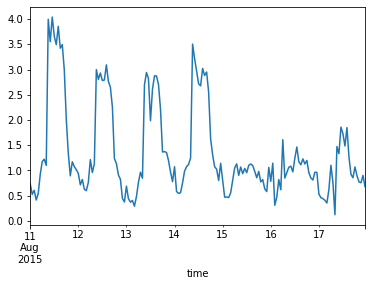

In [34]:
socket_pred = (socket_pred1 + socket_pred2 + socket_pred3 + socket_pred4) / 4
socket_pred[120:144] = socket_pred2[120:144]

old_data = pd.read_csv("../data/submit_2023-04-26T10-59.csv")
delta = socket_pred - old_data["socket"].values
socket_pred = socket_pred + 2 * delta

data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

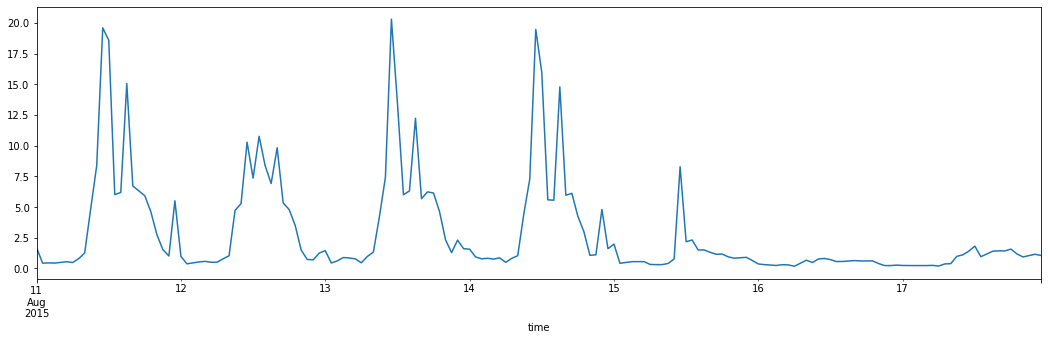

In [35]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [36]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_light = data_light["value_light"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_light.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [37]:
model_light1 = LGBMRegressor(n_estimators=10000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred1 = model_light1.predict(x_test_light)

<h5>取最后7*24个点作为模型2预测值</h5>

In [38]:
light_pred2 = data_light.loc[: "2015-08-17 23:00:00", "value_light"].values[-7*24:]

<h5>构建catboost</h5>

In [39]:
model_light3 = CatBoostRegressor(n_estimators=10000, random_state=1024).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred3 = model_light3.predict(x_test_light)

Learning rate set to 0.009761
0:	learn: 3.7052700	total: 2.75ms	remaining: 27.5s
1:	learn: 3.6779049	total: 5.46ms	remaining: 27.3s
2:	learn: 3.6508701	total: 8.1ms	remaining: 27s
3:	learn: 3.6241625	total: 10.8ms	remaining: 26.9s
4:	learn: 3.5977792	total: 13.3ms	remaining: 26.6s
5:	learn: 3.5717172	total: 15.8ms	remaining: 26.3s
6:	learn: 3.5459734	total: 18.4ms	remaining: 26.3s
7:	learn: 3.5205450	total: 20.9ms	remaining: 26.1s
8:	learn: 3.4954289	total: 23.4ms	remaining: 26s
9:	learn: 3.4706224	total: 25.9ms	remaining: 25.8s
10:	learn: 3.4461224	total: 28.4ms	remaining: 25.8s
11:	learn: 3.4219261	total: 30.9ms	remaining: 25.8s
12:	learn: 3.3980307	total: 33.3ms	remaining: 25.6s
13:	learn: 3.3744334	total: 35.6ms	remaining: 25.4s
14:	learn: 3.3511313	total: 38ms	remaining: 25.3s
15:	learn: 3.3281217	total: 40.2ms	remaining: 25.1s
16:	learn: 3.3054017	total: 42.5ms	remaining: 25s
17:	learn: 3.2829687	total: 44.9ms	remaining: 24.9s
18:	learn: 3.2608198	total: 47.1ms	remaining: 24.7s
1

241:	learn: 1.6690201	total: 536ms	remaining: 21.6s
242:	learn: 1.6678734	total: 538ms	remaining: 21.6s
243:	learn: 1.6667440	total: 540ms	remaining: 21.6s
244:	learn: 1.6654350	total: 543ms	remaining: 21.6s
245:	learn: 1.6643300	total: 545ms	remaining: 21.6s
246:	learn: 1.6630350	total: 547ms	remaining: 21.6s
247:	learn: 1.6620546	total: 549ms	remaining: 21.6s
248:	learn: 1.6610436	total: 552ms	remaining: 21.6s
249:	learn: 1.6599808	total: 554ms	remaining: 21.6s
250:	learn: 1.6587347	total: 556ms	remaining: 21.6s
251:	learn: 1.6573716	total: 558ms	remaining: 21.6s
252:	learn: 1.6558962	total: 560ms	remaining: 21.6s
253:	learn: 1.6545782	total: 562ms	remaining: 21.6s
254:	learn: 1.6532603	total: 565ms	remaining: 21.6s
255:	learn: 1.6523484	total: 567ms	remaining: 21.6s
256:	learn: 1.6513839	total: 569ms	remaining: 21.6s
257:	learn: 1.6504012	total: 571ms	remaining: 21.6s
258:	learn: 1.6490063	total: 573ms	remaining: 21.6s
259:	learn: 1.6480586	total: 575ms	remaining: 21.6s
260:	learn: 

411:	learn: 1.5339906	total: 903ms	remaining: 21s
412:	learn: 1.5334765	total: 905ms	remaining: 21s
413:	learn: 1.5330688	total: 907ms	remaining: 21s
414:	learn: 1.5326144	total: 909ms	remaining: 21s
415:	learn: 1.5320538	total: 911ms	remaining: 21s
416:	learn: 1.5317054	total: 913ms	remaining: 21s
417:	learn: 1.5312298	total: 916ms	remaining: 21s
418:	learn: 1.5307628	total: 918ms	remaining: 21s
419:	learn: 1.5302306	total: 920ms	remaining: 21s
420:	learn: 1.5297749	total: 922ms	remaining: 21s
421:	learn: 1.5294314	total: 924ms	remaining: 21s
422:	learn: 1.5289668	total: 926ms	remaining: 21s
423:	learn: 1.5285513	total: 929ms	remaining: 21s
424:	learn: 1.5281030	total: 931ms	remaining: 21s
425:	learn: 1.5278311	total: 933ms	remaining: 21s
426:	learn: 1.5273289	total: 935ms	remaining: 21s
427:	learn: 1.5268463	total: 937ms	remaining: 21s
428:	learn: 1.5264135	total: 939ms	remaining: 21s
429:	learn: 1.5260667	total: 941ms	remaining: 20.9s
430:	learn: 1.5257961	total: 943ms	remaining: 20

584:	learn: 1.4717244	total: 1.27s	remaining: 20.5s
585:	learn: 1.4715375	total: 1.28s	remaining: 20.5s
586:	learn: 1.4712976	total: 1.28s	remaining: 20.5s
587:	learn: 1.4710594	total: 1.28s	remaining: 20.5s
588:	learn: 1.4708127	total: 1.28s	remaining: 20.5s
589:	learn: 1.4705682	total: 1.29s	remaining: 20.5s
590:	learn: 1.4702651	total: 1.29s	remaining: 20.5s
591:	learn: 1.4699958	total: 1.29s	remaining: 20.5s
592:	learn: 1.4697650	total: 1.29s	remaining: 20.5s
593:	learn: 1.4695182	total: 1.29s	remaining: 20.5s
594:	learn: 1.4691633	total: 1.3s	remaining: 20.5s
595:	learn: 1.4688542	total: 1.3s	remaining: 20.5s
596:	learn: 1.4685629	total: 1.3s	remaining: 20.5s
597:	learn: 1.4682810	total: 1.3s	remaining: 20.5s
598:	learn: 1.4679803	total: 1.31s	remaining: 20.5s
599:	learn: 1.4676873	total: 1.31s	remaining: 20.5s
600:	learn: 1.4672646	total: 1.31s	remaining: 20.5s
601:	learn: 1.4670051	total: 1.31s	remaining: 20.5s
602:	learn: 1.4667359	total: 1.31s	remaining: 20.5s
603:	learn: 1.46

749:	learn: 1.4269735	total: 1.63s	remaining: 20.1s
750:	learn: 1.4268300	total: 1.63s	remaining: 20.1s
751:	learn: 1.4265944	total: 1.63s	remaining: 20.1s
752:	learn: 1.4263647	total: 1.64s	remaining: 20.1s
753:	learn: 1.4259869	total: 1.64s	remaining: 20.1s
754:	learn: 1.4256890	total: 1.64s	remaining: 20.1s
755:	learn: 1.4254656	total: 1.64s	remaining: 20.1s
756:	learn: 1.4252616	total: 1.64s	remaining: 20.1s
757:	learn: 1.4250095	total: 1.65s	remaining: 20.1s
758:	learn: 1.4248206	total: 1.65s	remaining: 20.1s
759:	learn: 1.4246026	total: 1.65s	remaining: 20.1s
760:	learn: 1.4243553	total: 1.65s	remaining: 20.1s
761:	learn: 1.4241331	total: 1.66s	remaining: 20.1s
762:	learn: 1.4239278	total: 1.66s	remaining: 20.1s
763:	learn: 1.4236716	total: 1.66s	remaining: 20.1s
764:	learn: 1.4235264	total: 1.66s	remaining: 20.1s
765:	learn: 1.4233023	total: 1.66s	remaining: 20.1s
766:	learn: 1.4231651	total: 1.67s	remaining: 20.1s
767:	learn: 1.4230472	total: 1.67s	remaining: 20.1s
768:	learn: 

918:	learn: 1.3905845	total: 1.99s	remaining: 19.7s
919:	learn: 1.3903422	total: 1.99s	remaining: 19.7s
920:	learn: 1.3901635	total: 2s	remaining: 19.7s
921:	learn: 1.3900324	total: 2s	remaining: 19.7s
922:	learn: 1.3898571	total: 2s	remaining: 19.7s
923:	learn: 1.3896160	total: 2s	remaining: 19.7s
924:	learn: 1.3894581	total: 2s	remaining: 19.7s
925:	learn: 1.3892765	total: 2.01s	remaining: 19.7s
926:	learn: 1.3891414	total: 2.01s	remaining: 19.7s
927:	learn: 1.3888720	total: 2.01s	remaining: 19.7s
928:	learn: 1.3887043	total: 2.01s	remaining: 19.7s
929:	learn: 1.3885706	total: 2.01s	remaining: 19.6s
930:	learn: 1.3884699	total: 2.02s	remaining: 19.6s
931:	learn: 1.3882649	total: 2.02s	remaining: 19.6s
932:	learn: 1.3881179	total: 2.02s	remaining: 19.6s
933:	learn: 1.3879711	total: 2.02s	remaining: 19.6s
934:	learn: 1.3878111	total: 2.02s	remaining: 19.6s
935:	learn: 1.3876039	total: 2.03s	remaining: 19.6s
936:	learn: 1.3872728	total: 2.03s	remaining: 19.6s
937:	learn: 1.3870545	total

1091:	learn: 1.3585352	total: 2.36s	remaining: 19.3s
1092:	learn: 1.3583711	total: 2.36s	remaining: 19.3s
1093:	learn: 1.3582130	total: 2.37s	remaining: 19.3s
1094:	learn: 1.3580664	total: 2.37s	remaining: 19.3s
1095:	learn: 1.3578428	total: 2.37s	remaining: 19.3s
1096:	learn: 1.3575939	total: 2.37s	remaining: 19.3s
1097:	learn: 1.3574262	total: 2.37s	remaining: 19.3s
1098:	learn: 1.3571471	total: 2.38s	remaining: 19.2s
1099:	learn: 1.3569265	total: 2.38s	remaining: 19.2s
1100:	learn: 1.3567064	total: 2.38s	remaining: 19.2s
1101:	learn: 1.3565418	total: 2.38s	remaining: 19.2s
1102:	learn: 1.3564078	total: 2.38s	remaining: 19.2s
1103:	learn: 1.3562474	total: 2.39s	remaining: 19.2s
1104:	learn: 1.3559413	total: 2.39s	remaining: 19.2s
1105:	learn: 1.3557721	total: 2.39s	remaining: 19.2s
1106:	learn: 1.3556087	total: 2.39s	remaining: 19.2s
1107:	learn: 1.3554481	total: 2.4s	remaining: 19.2s
1108:	learn: 1.3553299	total: 2.4s	remaining: 19.2s
1109:	learn: 1.3551582	total: 2.4s	remaining: 19

1257:	learn: 1.3309507	total: 2.72s	remaining: 18.9s
1258:	learn: 1.3308674	total: 2.72s	remaining: 18.9s
1259:	learn: 1.3306544	total: 2.72s	remaining: 18.9s
1260:	learn: 1.3305583	total: 2.72s	remaining: 18.9s
1261:	learn: 1.3304141	total: 2.72s	remaining: 18.9s
1262:	learn: 1.3302616	total: 2.73s	remaining: 18.9s
1263:	learn: 1.3301349	total: 2.73s	remaining: 18.9s
1264:	learn: 1.3300118	total: 2.73s	remaining: 18.9s
1265:	learn: 1.3298044	total: 2.73s	remaining: 18.9s
1266:	learn: 1.3296897	total: 2.74s	remaining: 18.9s
1267:	learn: 1.3295318	total: 2.74s	remaining: 18.9s
1268:	learn: 1.3293373	total: 2.74s	remaining: 18.9s
1269:	learn: 1.3292235	total: 2.74s	remaining: 18.9s
1270:	learn: 1.3290289	total: 2.74s	remaining: 18.9s
1271:	learn: 1.3288954	total: 2.75s	remaining: 18.8s
1272:	learn: 1.3286687	total: 2.75s	remaining: 18.8s
1273:	learn: 1.3284622	total: 2.75s	remaining: 18.8s
1274:	learn: 1.3283494	total: 2.75s	remaining: 18.8s
1275:	learn: 1.3282404	total: 2.75s	remaining:

1425:	learn: 1.3063440	total: 3.08s	remaining: 18.5s
1426:	learn: 1.3061983	total: 3.08s	remaining: 18.5s
1427:	learn: 1.3060406	total: 3.08s	remaining: 18.5s
1428:	learn: 1.3058555	total: 3.08s	remaining: 18.5s
1429:	learn: 1.3057097	total: 3.09s	remaining: 18.5s
1430:	learn: 1.3054883	total: 3.09s	remaining: 18.5s
1431:	learn: 1.3054364	total: 3.09s	remaining: 18.5s
1432:	learn: 1.3052817	total: 3.09s	remaining: 18.5s
1433:	learn: 1.3051106	total: 3.09s	remaining: 18.5s
1434:	learn: 1.3048687	total: 3.1s	remaining: 18.5s
1435:	learn: 1.3047023	total: 3.1s	remaining: 18.5s
1436:	learn: 1.3045877	total: 3.1s	remaining: 18.5s
1437:	learn: 1.3044573	total: 3.1s	remaining: 18.5s
1438:	learn: 1.3043887	total: 3.1s	remaining: 18.5s
1439:	learn: 1.3042352	total: 3.11s	remaining: 18.5s
1440:	learn: 1.3040019	total: 3.11s	remaining: 18.5s
1441:	learn: 1.3038305	total: 3.11s	remaining: 18.5s
1442:	learn: 1.3036817	total: 3.11s	remaining: 18.5s
1443:	learn: 1.3035637	total: 3.12s	remaining: 18.5

1597:	learn: 1.2835762	total: 3.44s	remaining: 18.1s
1598:	learn: 1.2834753	total: 3.45s	remaining: 18.1s
1599:	learn: 1.2833769	total: 3.45s	remaining: 18.1s
1600:	learn: 1.2831981	total: 3.45s	remaining: 18.1s
1601:	learn: 1.2830166	total: 3.45s	remaining: 18.1s
1602:	learn: 1.2828515	total: 3.46s	remaining: 18.1s
1603:	learn: 1.2826561	total: 3.46s	remaining: 18.1s
1604:	learn: 1.2825459	total: 3.46s	remaining: 18.1s
1605:	learn: 1.2824589	total: 3.46s	remaining: 18.1s
1606:	learn: 1.2823438	total: 3.46s	remaining: 18.1s
1607:	learn: 1.2822182	total: 3.47s	remaining: 18.1s
1608:	learn: 1.2821211	total: 3.47s	remaining: 18.1s
1609:	learn: 1.2820459	total: 3.47s	remaining: 18.1s
1610:	learn: 1.2819178	total: 3.47s	remaining: 18.1s
1611:	learn: 1.2818123	total: 3.48s	remaining: 18.1s
1612:	learn: 1.2816733	total: 3.48s	remaining: 18.1s
1613:	learn: 1.2815429	total: 3.48s	remaining: 18.1s
1614:	learn: 1.2814843	total: 3.48s	remaining: 18.1s
1615:	learn: 1.2812285	total: 3.48s	remaining:

1768:	learn: 1.2627008	total: 3.81s	remaining: 17.7s
1769:	learn: 1.2625987	total: 3.81s	remaining: 17.7s
1770:	learn: 1.2624946	total: 3.82s	remaining: 17.7s
1771:	learn: 1.2624065	total: 3.82s	remaining: 17.7s
1772:	learn: 1.2622719	total: 3.82s	remaining: 17.7s
1773:	learn: 1.2621709	total: 3.82s	remaining: 17.7s
1774:	learn: 1.2620652	total: 3.83s	remaining: 17.7s
1775:	learn: 1.2619588	total: 3.83s	remaining: 17.7s
1776:	learn: 1.2619059	total: 3.83s	remaining: 17.7s
1777:	learn: 1.2617857	total: 3.83s	remaining: 17.7s
1778:	learn: 1.2616689	total: 3.83s	remaining: 17.7s
1779:	learn: 1.2614933	total: 3.84s	remaining: 17.7s
1780:	learn: 1.2613715	total: 3.84s	remaining: 17.7s
1781:	learn: 1.2612409	total: 3.84s	remaining: 17.7s
1782:	learn: 1.2611582	total: 3.84s	remaining: 17.7s
1783:	learn: 1.2610173	total: 3.85s	remaining: 17.7s
1784:	learn: 1.2608092	total: 3.85s	remaining: 17.7s
1785:	learn: 1.2607100	total: 3.85s	remaining: 17.7s
1786:	learn: 1.2605776	total: 3.85s	remaining:

1931:	learn: 1.2445114	total: 4.17s	remaining: 17.4s
1932:	learn: 1.2444548	total: 4.17s	remaining: 17.4s
1933:	learn: 1.2443872	total: 4.17s	remaining: 17.4s
1934:	learn: 1.2443069	total: 4.17s	remaining: 17.4s
1935:	learn: 1.2441649	total: 4.17s	remaining: 17.4s
1936:	learn: 1.2440799	total: 4.18s	remaining: 17.4s
1937:	learn: 1.2439229	total: 4.18s	remaining: 17.4s
1938:	learn: 1.2438413	total: 4.18s	remaining: 17.4s
1939:	learn: 1.2437806	total: 4.18s	remaining: 17.4s
1940:	learn: 1.2436152	total: 4.18s	remaining: 17.4s
1941:	learn: 1.2435185	total: 4.19s	remaining: 17.4s
1942:	learn: 1.2434457	total: 4.19s	remaining: 17.4s
1943:	learn: 1.2433289	total: 4.19s	remaining: 17.4s
1944:	learn: 1.2432705	total: 4.19s	remaining: 17.4s
1945:	learn: 1.2431330	total: 4.2s	remaining: 17.4s
1946:	learn: 1.2429710	total: 4.2s	remaining: 17.4s
1947:	learn: 1.2428527	total: 4.2s	remaining: 17.4s
1948:	learn: 1.2427441	total: 4.2s	remaining: 17.4s
1949:	learn: 1.2426333	total: 4.21s	remaining: 17.

2100:	learn: 1.2277967	total: 4.53s	remaining: 17s
2101:	learn: 1.2277203	total: 4.53s	remaining: 17s
2102:	learn: 1.2276486	total: 4.53s	remaining: 17s
2103:	learn: 1.2275633	total: 4.53s	remaining: 17s
2104:	learn: 1.2274765	total: 4.54s	remaining: 17s
2105:	learn: 1.2273954	total: 4.54s	remaining: 17s
2106:	learn: 1.2273092	total: 4.54s	remaining: 17s
2107:	learn: 1.2272104	total: 4.55s	remaining: 17s
2108:	learn: 1.2270601	total: 4.55s	remaining: 17s
2109:	learn: 1.2269984	total: 4.55s	remaining: 17s
2110:	learn: 1.2268862	total: 4.55s	remaining: 17s
2111:	learn: 1.2267688	total: 4.55s	remaining: 17s
2112:	learn: 1.2267092	total: 4.56s	remaining: 17s
2113:	learn: 1.2266151	total: 4.56s	remaining: 17s
2114:	learn: 1.2265383	total: 4.56s	remaining: 17s
2115:	learn: 1.2264421	total: 4.56s	remaining: 17s
2116:	learn: 1.2263654	total: 4.57s	remaining: 17s
2117:	learn: 1.2261919	total: 4.57s	remaining: 17s
2118:	learn: 1.2261175	total: 4.57s	remaining: 17s
2119:	learn: 1.2260241	total: 4

2266:	learn: 1.2133090	total: 4.89s	remaining: 16.7s
2267:	learn: 1.2131862	total: 4.89s	remaining: 16.7s
2268:	learn: 1.2131241	total: 4.9s	remaining: 16.7s
2269:	learn: 1.2130540	total: 4.9s	remaining: 16.7s
2270:	learn: 1.2129796	total: 4.9s	remaining: 16.7s
2271:	learn: 1.2129291	total: 4.9s	remaining: 16.7s
2272:	learn: 1.2128179	total: 4.91s	remaining: 16.7s
2273:	learn: 1.2127364	total: 4.91s	remaining: 16.7s
2274:	learn: 1.2125749	total: 4.91s	remaining: 16.7s
2275:	learn: 1.2124693	total: 4.91s	remaining: 16.7s
2276:	learn: 1.2123613	total: 4.91s	remaining: 16.7s
2277:	learn: 1.2122584	total: 4.92s	remaining: 16.7s
2278:	learn: 1.2121670	total: 4.92s	remaining: 16.7s
2279:	learn: 1.2120675	total: 4.92s	remaining: 16.7s
2280:	learn: 1.2120160	total: 4.92s	remaining: 16.7s
2281:	learn: 1.2119277	total: 4.93s	remaining: 16.7s
2282:	learn: 1.2118332	total: 4.93s	remaining: 16.7s
2283:	learn: 1.2117512	total: 4.93s	remaining: 16.7s
2284:	learn: 1.2116570	total: 4.93s	remaining: 16.

2426:	learn: 1.2003381	total: 5.24s	remaining: 16.4s
2427:	learn: 1.2002283	total: 5.25s	remaining: 16.4s
2428:	learn: 1.2001585	total: 5.25s	remaining: 16.4s
2429:	learn: 1.2001120	total: 5.25s	remaining: 16.4s
2430:	learn: 1.2000616	total: 5.25s	remaining: 16.4s
2431:	learn: 1.1999617	total: 5.25s	remaining: 16.4s
2432:	learn: 1.1998548	total: 5.26s	remaining: 16.3s
2433:	learn: 1.1998071	total: 5.26s	remaining: 16.3s
2434:	learn: 1.1997273	total: 5.26s	remaining: 16.3s
2435:	learn: 1.1996307	total: 5.26s	remaining: 16.3s
2436:	learn: 1.1995766	total: 5.26s	remaining: 16.3s
2437:	learn: 1.1995129	total: 5.27s	remaining: 16.3s
2438:	learn: 1.1994446	total: 5.27s	remaining: 16.3s
2439:	learn: 1.1993625	total: 5.27s	remaining: 16.3s
2440:	learn: 1.1993235	total: 5.27s	remaining: 16.3s
2441:	learn: 1.1992616	total: 5.28s	remaining: 16.3s
2442:	learn: 1.1991655	total: 5.28s	remaining: 16.3s
2443:	learn: 1.1990779	total: 5.28s	remaining: 16.3s
2444:	learn: 1.1990195	total: 5.28s	remaining:

2599:	learn: 1.1870670	total: 5.61s	remaining: 16s
2600:	learn: 1.1869992	total: 5.62s	remaining: 16s
2601:	learn: 1.1869508	total: 5.62s	remaining: 16s
2602:	learn: 1.1868560	total: 5.62s	remaining: 16s
2603:	learn: 1.1867905	total: 5.62s	remaining: 16s
2604:	learn: 1.1867370	total: 5.62s	remaining: 16s
2605:	learn: 1.1866815	total: 5.63s	remaining: 16s
2606:	learn: 1.1866220	total: 5.63s	remaining: 16s
2607:	learn: 1.1865643	total: 5.63s	remaining: 16s
2608:	learn: 1.1864928	total: 5.63s	remaining: 16s
2609:	learn: 1.1864029	total: 5.63s	remaining: 16s
2610:	learn: 1.1863126	total: 5.64s	remaining: 16s
2611:	learn: 1.1862718	total: 5.64s	remaining: 16s
2612:	learn: 1.1861251	total: 5.64s	remaining: 15.9s
2613:	learn: 1.1860501	total: 5.64s	remaining: 15.9s
2614:	learn: 1.1859846	total: 5.65s	remaining: 15.9s
2615:	learn: 1.1858131	total: 5.65s	remaining: 15.9s
2616:	learn: 1.1857139	total: 5.65s	remaining: 15.9s
2617:	learn: 1.1856352	total: 5.65s	remaining: 15.9s
2618:	learn: 1.1855

2763:	learn: 1.1745850	total: 5.96s	remaining: 15.6s
2764:	learn: 1.1745181	total: 5.97s	remaining: 15.6s
2765:	learn: 1.1744519	total: 5.97s	remaining: 15.6s
2766:	learn: 1.1744264	total: 5.97s	remaining: 15.6s
2767:	learn: 1.1743068	total: 5.97s	remaining: 15.6s
2768:	learn: 1.1742104	total: 5.98s	remaining: 15.6s
2769:	learn: 1.1740927	total: 5.98s	remaining: 15.6s
2770:	learn: 1.1740486	total: 5.98s	remaining: 15.6s
2771:	learn: 1.1739997	total: 5.98s	remaining: 15.6s
2772:	learn: 1.1739316	total: 5.98s	remaining: 15.6s
2773:	learn: 1.1738580	total: 5.99s	remaining: 15.6s
2774:	learn: 1.1737931	total: 5.99s	remaining: 15.6s
2775:	learn: 1.1737274	total: 5.99s	remaining: 15.6s
2776:	learn: 1.1736502	total: 5.99s	remaining: 15.6s
2777:	learn: 1.1735817	total: 6s	remaining: 15.6s
2778:	learn: 1.1734906	total: 6s	remaining: 15.6s
2779:	learn: 1.1734370	total: 6s	remaining: 15.6s
2780:	learn: 1.1733757	total: 6s	remaining: 15.6s
2781:	learn: 1.1733515	total: 6s	remaining: 15.6s
2782:	le

2939:	learn: 1.1623791	total: 6.34s	remaining: 15.2s
2940:	learn: 1.1623298	total: 6.34s	remaining: 15.2s
2941:	learn: 1.1622487	total: 6.35s	remaining: 15.2s
2942:	learn: 1.1621754	total: 6.35s	remaining: 15.2s
2943:	learn: 1.1620956	total: 6.35s	remaining: 15.2s
2944:	learn: 1.1620315	total: 6.35s	remaining: 15.2s
2945:	learn: 1.1619891	total: 6.36s	remaining: 15.2s
2946:	learn: 1.1619393	total: 6.36s	remaining: 15.2s
2947:	learn: 1.1618934	total: 6.36s	remaining: 15.2s
2948:	learn: 1.1618140	total: 6.36s	remaining: 15.2s
2949:	learn: 1.1617418	total: 6.37s	remaining: 15.2s
2950:	learn: 1.1616942	total: 6.37s	remaining: 15.2s
2951:	learn: 1.1616314	total: 6.37s	remaining: 15.2s
2952:	learn: 1.1615636	total: 6.37s	remaining: 15.2s
2953:	learn: 1.1614381	total: 6.37s	remaining: 15.2s
2954:	learn: 1.1613674	total: 6.38s	remaining: 15.2s
2955:	learn: 1.1613313	total: 6.38s	remaining: 15.2s
2956:	learn: 1.1612132	total: 6.38s	remaining: 15.2s
2957:	learn: 1.1611372	total: 6.38s	remaining:

3116:	learn: 1.1505692	total: 6.72s	remaining: 14.8s
3117:	learn: 1.1504733	total: 6.73s	remaining: 14.8s
3118:	learn: 1.1503615	total: 6.73s	remaining: 14.8s
3119:	learn: 1.1502226	total: 6.73s	remaining: 14.8s
3120:	learn: 1.1501691	total: 6.73s	remaining: 14.8s
3121:	learn: 1.1500911	total: 6.74s	remaining: 14.8s
3122:	learn: 1.1500328	total: 6.74s	remaining: 14.8s
3123:	learn: 1.1500018	total: 6.74s	remaining: 14.8s
3124:	learn: 1.1499188	total: 6.74s	remaining: 14.8s
3125:	learn: 1.1498256	total: 6.74s	remaining: 14.8s
3126:	learn: 1.1497745	total: 6.75s	remaining: 14.8s
3127:	learn: 1.1496647	total: 6.75s	remaining: 14.8s
3128:	learn: 1.1495855	total: 6.75s	remaining: 14.8s
3129:	learn: 1.1495489	total: 6.75s	remaining: 14.8s
3130:	learn: 1.1494546	total: 6.75s	remaining: 14.8s
3131:	learn: 1.1493491	total: 6.76s	remaining: 14.8s
3132:	learn: 1.1493085	total: 6.76s	remaining: 14.8s
3133:	learn: 1.1492643	total: 6.76s	remaining: 14.8s
3134:	learn: 1.1492055	total: 6.76s	remaining:

3281:	learn: 1.1390408	total: 7.08s	remaining: 14.5s
3282:	learn: 1.1389413	total: 7.09s	remaining: 14.5s
3283:	learn: 1.1388449	total: 7.09s	remaining: 14.5s
3284:	learn: 1.1387666	total: 7.09s	remaining: 14.5s
3285:	learn: 1.1387233	total: 7.09s	remaining: 14.5s
3286:	learn: 1.1386424	total: 7.09s	remaining: 14.5s
3287:	learn: 1.1385653	total: 7.1s	remaining: 14.5s
3288:	learn: 1.1384870	total: 7.1s	remaining: 14.5s
3289:	learn: 1.1384448	total: 7.1s	remaining: 14.5s
3290:	learn: 1.1383697	total: 7.1s	remaining: 14.5s
3291:	learn: 1.1383145	total: 7.11s	remaining: 14.5s
3292:	learn: 1.1382525	total: 7.11s	remaining: 14.5s
3293:	learn: 1.1382024	total: 7.11s	remaining: 14.5s
3294:	learn: 1.1381466	total: 7.11s	remaining: 14.5s
3295:	learn: 1.1380954	total: 7.11s	remaining: 14.5s
3296:	learn: 1.1380617	total: 7.12s	remaining: 14.5s
3297:	learn: 1.1380297	total: 7.12s	remaining: 14.5s
3298:	learn: 1.1379742	total: 7.12s	remaining: 14.5s
3299:	learn: 1.1378547	total: 7.12s	remaining: 14.

3460:	learn: 1.1276000	total: 7.47s	remaining: 14.1s
3461:	learn: 1.1275067	total: 7.47s	remaining: 14.1s
3462:	learn: 1.1274709	total: 7.47s	remaining: 14.1s
3463:	learn: 1.1274358	total: 7.47s	remaining: 14.1s
3464:	learn: 1.1273634	total: 7.48s	remaining: 14.1s
3465:	learn: 1.1272993	total: 7.48s	remaining: 14.1s
3466:	learn: 1.1272490	total: 7.48s	remaining: 14.1s
3467:	learn: 1.1271972	total: 7.48s	remaining: 14.1s
3468:	learn: 1.1271211	total: 7.49s	remaining: 14.1s
3469:	learn: 1.1270561	total: 7.49s	remaining: 14.1s
3470:	learn: 1.1269710	total: 7.49s	remaining: 14.1s
3471:	learn: 1.1269296	total: 7.49s	remaining: 14.1s
3472:	learn: 1.1268756	total: 7.49s	remaining: 14.1s
3473:	learn: 1.1268401	total: 7.5s	remaining: 14.1s
3474:	learn: 1.1267816	total: 7.5s	remaining: 14.1s
3475:	learn: 1.1267065	total: 7.5s	remaining: 14.1s
3476:	learn: 1.1266378	total: 7.5s	remaining: 14.1s
3477:	learn: 1.1265815	total: 7.5s	remaining: 14.1s
3478:	learn: 1.1264864	total: 7.51s	remaining: 14.1

3628:	learn: 1.1173301	total: 7.83s	remaining: 13.7s
3629:	learn: 1.1172546	total: 7.83s	remaining: 13.7s
3630:	learn: 1.1171984	total: 7.83s	remaining: 13.7s
3631:	learn: 1.1171314	total: 7.84s	remaining: 13.7s
3632:	learn: 1.1170448	total: 7.84s	remaining: 13.7s
3633:	learn: 1.1170127	total: 7.84s	remaining: 13.7s
3634:	learn: 1.1168845	total: 7.84s	remaining: 13.7s
3635:	learn: 1.1168325	total: 7.84s	remaining: 13.7s
3636:	learn: 1.1167720	total: 7.85s	remaining: 13.7s
3637:	learn: 1.1166782	total: 7.85s	remaining: 13.7s
3638:	learn: 1.1166396	total: 7.85s	remaining: 13.7s
3639:	learn: 1.1165680	total: 7.85s	remaining: 13.7s
3640:	learn: 1.1164717	total: 7.86s	remaining: 13.7s
3641:	learn: 1.1164381	total: 7.86s	remaining: 13.7s
3642:	learn: 1.1164193	total: 7.86s	remaining: 13.7s
3643:	learn: 1.1163848	total: 7.86s	remaining: 13.7s
3644:	learn: 1.1163007	total: 7.86s	remaining: 13.7s
3645:	learn: 1.1162385	total: 7.87s	remaining: 13.7s
3646:	learn: 1.1162032	total: 7.87s	remaining:

3794:	learn: 1.1078140	total: 8.19s	remaining: 13.4s
3795:	learn: 1.1077596	total: 8.19s	remaining: 13.4s
3796:	learn: 1.1077151	total: 8.19s	remaining: 13.4s
3797:	learn: 1.1076766	total: 8.2s	remaining: 13.4s
3798:	learn: 1.1076302	total: 8.2s	remaining: 13.4s
3799:	learn: 1.1076006	total: 8.2s	remaining: 13.4s
3800:	learn: 1.1075444	total: 8.2s	remaining: 13.4s
3801:	learn: 1.1074712	total: 8.21s	remaining: 13.4s
3802:	learn: 1.1074201	total: 8.21s	remaining: 13.4s
3803:	learn: 1.1073959	total: 8.21s	remaining: 13.4s
3804:	learn: 1.1073128	total: 8.21s	remaining: 13.4s
3805:	learn: 1.1072733	total: 8.21s	remaining: 13.4s
3806:	learn: 1.1072388	total: 8.22s	remaining: 13.4s
3807:	learn: 1.1071864	total: 8.22s	remaining: 13.4s
3808:	learn: 1.1071101	total: 8.22s	remaining: 13.4s
3809:	learn: 1.1070679	total: 8.22s	remaining: 13.4s
3810:	learn: 1.1070280	total: 8.22s	remaining: 13.4s
3811:	learn: 1.1069648	total: 8.23s	remaining: 13.4s
3812:	learn: 1.1069208	total: 8.23s	remaining: 13.

3959:	learn: 1.0987264	total: 8.54s	remaining: 13s
3960:	learn: 1.0987000	total: 8.55s	remaining: 13s
3961:	learn: 1.0986598	total: 8.55s	remaining: 13s
3962:	learn: 1.0986057	total: 8.55s	remaining: 13s
3963:	learn: 1.0985687	total: 8.55s	remaining: 13s
3964:	learn: 1.0985186	total: 8.55s	remaining: 13s
3965:	learn: 1.0984914	total: 8.56s	remaining: 13s
3966:	learn: 1.0984417	total: 8.56s	remaining: 13s
3967:	learn: 1.0984084	total: 8.56s	remaining: 13s
3968:	learn: 1.0983772	total: 8.56s	remaining: 13s
3969:	learn: 1.0983233	total: 8.57s	remaining: 13s
3970:	learn: 1.0982860	total: 8.57s	remaining: 13s
3971:	learn: 1.0982510	total: 8.57s	remaining: 13s
3972:	learn: 1.0981713	total: 8.57s	remaining: 13s
3973:	learn: 1.0981271	total: 8.57s	remaining: 13s
3974:	learn: 1.0980720	total: 8.58s	remaining: 13s
3975:	learn: 1.0979777	total: 8.58s	remaining: 13s
3976:	learn: 1.0979243	total: 8.58s	remaining: 13s
3977:	learn: 1.0978945	total: 8.58s	remaining: 13s
3978:	learn: 1.0978288	total: 8

4131:	learn: 1.0899102	total: 8.91s	remaining: 12.7s
4132:	learn: 1.0898674	total: 8.92s	remaining: 12.7s
4133:	learn: 1.0898290	total: 8.92s	remaining: 12.7s
4134:	learn: 1.0897474	total: 8.92s	remaining: 12.7s
4135:	learn: 1.0897134	total: 8.92s	remaining: 12.7s
4136:	learn: 1.0896342	total: 8.93s	remaining: 12.6s
4137:	learn: 1.0895098	total: 8.93s	remaining: 12.6s
4138:	learn: 1.0894766	total: 8.93s	remaining: 12.6s
4139:	learn: 1.0894005	total: 8.93s	remaining: 12.6s
4140:	learn: 1.0893539	total: 8.93s	remaining: 12.6s
4141:	learn: 1.0892494	total: 8.94s	remaining: 12.6s
4142:	learn: 1.0892047	total: 8.94s	remaining: 12.6s
4143:	learn: 1.0891384	total: 8.94s	remaining: 12.6s
4144:	learn: 1.0891035	total: 8.94s	remaining: 12.6s
4145:	learn: 1.0890500	total: 8.94s	remaining: 12.6s
4146:	learn: 1.0889996	total: 8.95s	remaining: 12.6s
4147:	learn: 1.0889695	total: 8.95s	remaining: 12.6s
4148:	learn: 1.0889134	total: 8.95s	remaining: 12.6s
4149:	learn: 1.0888715	total: 8.95s	remaining:

4295:	learn: 1.0813208	total: 9.27s	remaining: 12.3s
4296:	learn: 1.0812840	total: 9.27s	remaining: 12.3s
4297:	learn: 1.0812535	total: 9.27s	remaining: 12.3s
4298:	learn: 1.0812027	total: 9.27s	remaining: 12.3s
4299:	learn: 1.0811254	total: 9.27s	remaining: 12.3s
4300:	learn: 1.0810810	total: 9.28s	remaining: 12.3s
4301:	learn: 1.0810160	total: 9.28s	remaining: 12.3s
4302:	learn: 1.0809193	total: 9.28s	remaining: 12.3s
4303:	learn: 1.0808867	total: 9.28s	remaining: 12.3s
4304:	learn: 1.0808381	total: 9.29s	remaining: 12.3s
4305:	learn: 1.0807914	total: 9.29s	remaining: 12.3s
4306:	learn: 1.0807379	total: 9.29s	remaining: 12.3s
4307:	learn: 1.0806700	total: 9.29s	remaining: 12.3s
4308:	learn: 1.0806342	total: 9.29s	remaining: 12.3s
4309:	learn: 1.0806118	total: 9.29s	remaining: 12.3s
4310:	learn: 1.0805697	total: 9.3s	remaining: 12.3s
4311:	learn: 1.0804917	total: 9.3s	remaining: 12.3s
4312:	learn: 1.0804494	total: 9.3s	remaining: 12.3s
4313:	learn: 1.0803926	total: 9.3s	remaining: 12.

4468:	learn: 1.0725457	total: 9.64s	remaining: 11.9s
4469:	learn: 1.0725090	total: 9.64s	remaining: 11.9s
4470:	learn: 1.0724305	total: 9.64s	remaining: 11.9s
4471:	learn: 1.0723870	total: 9.64s	remaining: 11.9s
4472:	learn: 1.0723393	total: 9.64s	remaining: 11.9s
4473:	learn: 1.0722335	total: 9.65s	remaining: 11.9s
4474:	learn: 1.0721252	total: 9.65s	remaining: 11.9s
4475:	learn: 1.0720793	total: 9.65s	remaining: 11.9s
4476:	learn: 1.0720550	total: 9.65s	remaining: 11.9s
4477:	learn: 1.0720055	total: 9.66s	remaining: 11.9s
4478:	learn: 1.0719592	total: 9.66s	remaining: 11.9s
4479:	learn: 1.0718918	total: 9.66s	remaining: 11.9s
4480:	learn: 1.0718439	total: 9.66s	remaining: 11.9s
4481:	learn: 1.0718051	total: 9.66s	remaining: 11.9s
4482:	learn: 1.0717739	total: 9.67s	remaining: 11.9s
4483:	learn: 1.0717349	total: 9.67s	remaining: 11.9s
4484:	learn: 1.0716585	total: 9.67s	remaining: 11.9s
4485:	learn: 1.0716208	total: 9.67s	remaining: 11.9s
4486:	learn: 1.0715543	total: 9.68s	remaining:

4633:	learn: 1.0643472	total: 9.99s	remaining: 11.6s
4634:	learn: 1.0642798	total: 9.99s	remaining: 11.6s
4635:	learn: 1.0642308	total: 9.99s	remaining: 11.6s
4636:	learn: 1.0641773	total: 10s	remaining: 11.6s
4637:	learn: 1.0641464	total: 10s	remaining: 11.6s
4638:	learn: 1.0640975	total: 10s	remaining: 11.6s
4639:	learn: 1.0640745	total: 10s	remaining: 11.6s
4640:	learn: 1.0640365	total: 10s	remaining: 11.6s
4641:	learn: 1.0639253	total: 10s	remaining: 11.6s
4642:	learn: 1.0638740	total: 10s	remaining: 11.5s
4643:	learn: 1.0638449	total: 10s	remaining: 11.5s
4644:	learn: 1.0638057	total: 10s	remaining: 11.5s
4645:	learn: 1.0637655	total: 10s	remaining: 11.5s
4646:	learn: 1.0636414	total: 10s	remaining: 11.5s
4647:	learn: 1.0636081	total: 10s	remaining: 11.5s
4648:	learn: 1.0635505	total: 10s	remaining: 11.5s
4649:	learn: 1.0635170	total: 10s	remaining: 11.5s
4650:	learn: 1.0634616	total: 10s	remaining: 11.5s
4651:	learn: 1.0634161	total: 10s	remaining: 11.5s
4652:	learn: 1.0633941	to

4805:	learn: 1.0561813	total: 10.4s	remaining: 11.2s
4806:	learn: 1.0561482	total: 10.4s	remaining: 11.2s
4807:	learn: 1.0561159	total: 10.4s	remaining: 11.2s
4808:	learn: 1.0560661	total: 10.4s	remaining: 11.2s
4809:	learn: 1.0560085	total: 10.4s	remaining: 11.2s
4810:	learn: 1.0559678	total: 10.4s	remaining: 11.2s
4811:	learn: 1.0559204	total: 10.4s	remaining: 11.2s
4812:	learn: 1.0558619	total: 10.4s	remaining: 11.2s
4813:	learn: 1.0557805	total: 10.4s	remaining: 11.2s
4814:	learn: 1.0557397	total: 10.4s	remaining: 11.2s
4815:	learn: 1.0557141	total: 10.4s	remaining: 11.2s
4816:	learn: 1.0556819	total: 10.4s	remaining: 11.2s
4817:	learn: 1.0556513	total: 10.4s	remaining: 11.2s
4818:	learn: 1.0555943	total: 10.4s	remaining: 11.2s
4819:	learn: 1.0555541	total: 10.4s	remaining: 11.2s
4820:	learn: 1.0555032	total: 10.4s	remaining: 11.2s
4821:	learn: 1.0554722	total: 10.4s	remaining: 11.2s
4822:	learn: 1.0554218	total: 10.4s	remaining: 11.2s
4823:	learn: 1.0553839	total: 10.4s	remaining:

4970:	learn: 1.0489707	total: 10.7s	remaining: 10.8s
4971:	learn: 1.0489242	total: 10.7s	remaining: 10.8s
4972:	learn: 1.0488753	total: 10.7s	remaining: 10.8s
4973:	learn: 1.0488305	total: 10.7s	remaining: 10.8s
4974:	learn: 1.0488001	total: 10.7s	remaining: 10.8s
4975:	learn: 1.0487628	total: 10.7s	remaining: 10.8s
4976:	learn: 1.0487293	total: 10.7s	remaining: 10.8s
4977:	learn: 1.0486690	total: 10.7s	remaining: 10.8s
4978:	learn: 1.0486085	total: 10.7s	remaining: 10.8s
4979:	learn: 1.0485501	total: 10.7s	remaining: 10.8s
4980:	learn: 1.0485072	total: 10.7s	remaining: 10.8s
4981:	learn: 1.0484639	total: 10.7s	remaining: 10.8s
4982:	learn: 1.0484241	total: 10.7s	remaining: 10.8s
4983:	learn: 1.0483929	total: 10.7s	remaining: 10.8s
4984:	learn: 1.0483664	total: 10.7s	remaining: 10.8s
4985:	learn: 1.0483135	total: 10.7s	remaining: 10.8s
4986:	learn: 1.0482627	total: 10.7s	remaining: 10.8s
4987:	learn: 1.0482168	total: 10.8s	remaining: 10.8s
4988:	learn: 1.0481811	total: 10.8s	remaining:

5138:	learn: 1.0416548	total: 11.1s	remaining: 10.5s
5139:	learn: 1.0416073	total: 11.1s	remaining: 10.5s
5140:	learn: 1.0415842	total: 11.1s	remaining: 10.5s
5141:	learn: 1.0415053	total: 11.1s	remaining: 10.5s
5142:	learn: 1.0414748	total: 11.1s	remaining: 10.5s
5143:	learn: 1.0414342	total: 11.1s	remaining: 10.5s
5144:	learn: 1.0414055	total: 11.1s	remaining: 10.5s
5145:	learn: 1.0413208	total: 11.1s	remaining: 10.5s
5146:	learn: 1.0412739	total: 11.1s	remaining: 10.5s
5147:	learn: 1.0411905	total: 11.1s	remaining: 10.5s
5148:	learn: 1.0411572	total: 11.1s	remaining: 10.5s
5149:	learn: 1.0411356	total: 11.1s	remaining: 10.5s
5150:	learn: 1.0410746	total: 11.1s	remaining: 10.4s
5151:	learn: 1.0410573	total: 11.1s	remaining: 10.4s
5152:	learn: 1.0410086	total: 11.1s	remaining: 10.4s
5153:	learn: 1.0409362	total: 11.1s	remaining: 10.4s
5154:	learn: 1.0408144	total: 11.1s	remaining: 10.4s
5155:	learn: 1.0407652	total: 11.1s	remaining: 10.4s
5156:	learn: 1.0407244	total: 11.1s	remaining:

5311:	learn: 1.0339480	total: 11.4s	remaining: 10.1s
5312:	learn: 1.0339299	total: 11.4s	remaining: 10.1s
5313:	learn: 1.0338723	total: 11.4s	remaining: 10.1s
5314:	learn: 1.0338589	total: 11.5s	remaining: 10.1s
5315:	learn: 1.0338255	total: 11.5s	remaining: 10.1s
5316:	learn: 1.0337987	total: 11.5s	remaining: 10.1s
5317:	learn: 1.0337554	total: 11.5s	remaining: 10.1s
5318:	learn: 1.0337372	total: 11.5s	remaining: 10.1s
5319:	learn: 1.0337157	total: 11.5s	remaining: 10.1s
5320:	learn: 1.0336856	total: 11.5s	remaining: 10.1s
5321:	learn: 1.0336459	total: 11.5s	remaining: 10.1s
5322:	learn: 1.0336135	total: 11.5s	remaining: 10.1s
5323:	learn: 1.0335610	total: 11.5s	remaining: 10.1s
5324:	learn: 1.0335302	total: 11.5s	remaining: 10.1s
5325:	learn: 1.0334962	total: 11.5s	remaining: 10.1s
5326:	learn: 1.0334245	total: 11.5s	remaining: 10.1s
5327:	learn: 1.0333740	total: 11.5s	remaining: 10.1s
5328:	learn: 1.0333221	total: 11.5s	remaining: 10.1s
5329:	learn: 1.0332926	total: 11.5s	remaining:

5477:	learn: 1.0268914	total: 11.8s	remaining: 9.74s
5478:	learn: 1.0268411	total: 11.8s	remaining: 9.74s
5479:	learn: 1.0267824	total: 11.8s	remaining: 9.74s
5480:	learn: 1.0267563	total: 11.8s	remaining: 9.74s
5481:	learn: 1.0267199	total: 11.8s	remaining: 9.73s
5482:	learn: 1.0266998	total: 11.8s	remaining: 9.73s
5483:	learn: 1.0266679	total: 11.8s	remaining: 9.73s
5484:	learn: 1.0266463	total: 11.8s	remaining: 9.73s
5485:	learn: 1.0266152	total: 11.8s	remaining: 9.73s
5486:	learn: 1.0265939	total: 11.8s	remaining: 9.73s
5487:	learn: 1.0265585	total: 11.8s	remaining: 9.72s
5488:	learn: 1.0265239	total: 11.8s	remaining: 9.72s
5489:	learn: 1.0265086	total: 11.8s	remaining: 9.72s
5490:	learn: 1.0264789	total: 11.8s	remaining: 9.72s
5491:	learn: 1.0264649	total: 11.8s	remaining: 9.72s
5492:	learn: 1.0264165	total: 11.8s	remaining: 9.71s
5493:	learn: 1.0263918	total: 11.8s	remaining: 9.71s
5494:	learn: 1.0263652	total: 11.8s	remaining: 9.71s
5495:	learn: 1.0263096	total: 11.8s	remaining:

5644:	learn: 1.0202165	total: 12.2s	remaining: 9.38s
5645:	learn: 1.0201883	total: 12.2s	remaining: 9.38s
5646:	learn: 1.0201695	total: 12.2s	remaining: 9.38s
5647:	learn: 1.0201426	total: 12.2s	remaining: 9.38s
5648:	learn: 1.0201263	total: 12.2s	remaining: 9.38s
5649:	learn: 1.0200862	total: 12.2s	remaining: 9.37s
5650:	learn: 1.0200597	total: 12.2s	remaining: 9.37s
5651:	learn: 1.0200253	total: 12.2s	remaining: 9.37s
5652:	learn: 1.0199857	total: 12.2s	remaining: 9.37s
5653:	learn: 1.0199545	total: 12.2s	remaining: 9.37s
5654:	learn: 1.0199252	total: 12.2s	remaining: 9.36s
5655:	learn: 1.0198579	total: 12.2s	remaining: 9.36s
5656:	learn: 1.0198321	total: 12.2s	remaining: 9.36s
5657:	learn: 1.0197625	total: 12.2s	remaining: 9.36s
5658:	learn: 1.0197317	total: 12.2s	remaining: 9.36s
5659:	learn: 1.0197009	total: 12.2s	remaining: 9.35s
5660:	learn: 1.0196841	total: 12.2s	remaining: 9.35s
5661:	learn: 1.0196481	total: 12.2s	remaining: 9.35s
5662:	learn: 1.0196317	total: 12.2s	remaining:

5812:	learn: 1.0136745	total: 12.5s	remaining: 9.02s
5813:	learn: 1.0136477	total: 12.5s	remaining: 9.02s
5814:	learn: 1.0136135	total: 12.5s	remaining: 9.02s
5815:	learn: 1.0135796	total: 12.5s	remaining: 9.02s
5816:	learn: 1.0135572	total: 12.5s	remaining: 9.01s
5817:	learn: 1.0135286	total: 12.5s	remaining: 9.01s
5818:	learn: 1.0134952	total: 12.5s	remaining: 9.01s
5819:	learn: 1.0134537	total: 12.5s	remaining: 9.01s
5820:	learn: 1.0134020	total: 12.5s	remaining: 9s
5821:	learn: 1.0133715	total: 12.5s	remaining: 9s
5822:	learn: 1.0133456	total: 12.5s	remaining: 9s
5823:	learn: 1.0133166	total: 12.5s	remaining: 9s
5824:	learn: 1.0133096	total: 12.6s	remaining: 9s
5825:	learn: 1.0132764	total: 12.6s	remaining: 8.99s
5826:	learn: 1.0132282	total: 12.6s	remaining: 8.99s
5827:	learn: 1.0132001	total: 12.6s	remaining: 8.99s
5828:	learn: 1.0131743	total: 12.6s	remaining: 8.99s
5829:	learn: 1.0131404	total: 12.6s	remaining: 8.98s
5830:	learn: 1.0131091	total: 12.6s	remaining: 8.98s
5831:	le

5980:	learn: 1.0071375	total: 12.9s	remaining: 8.66s
5981:	learn: 1.0071050	total: 12.9s	remaining: 8.66s
5982:	learn: 1.0070648	total: 12.9s	remaining: 8.65s
5983:	learn: 1.0070313	total: 12.9s	remaining: 8.65s
5984:	learn: 1.0070057	total: 12.9s	remaining: 8.65s
5985:	learn: 1.0069719	total: 12.9s	remaining: 8.65s
5986:	learn: 1.0069435	total: 12.9s	remaining: 8.65s
5987:	learn: 1.0069164	total: 12.9s	remaining: 8.64s
5988:	learn: 1.0068668	total: 12.9s	remaining: 8.64s
5989:	learn: 1.0068446	total: 12.9s	remaining: 8.64s
5990:	learn: 1.0067742	total: 12.9s	remaining: 8.64s
5991:	learn: 1.0067299	total: 12.9s	remaining: 8.64s
5992:	learn: 1.0066622	total: 12.9s	remaining: 8.63s
5993:	learn: 1.0066214	total: 12.9s	remaining: 8.63s
5994:	learn: 1.0066020	total: 12.9s	remaining: 8.63s
5995:	learn: 1.0065727	total: 12.9s	remaining: 8.63s
5996:	learn: 1.0065453	total: 12.9s	remaining: 8.63s
5997:	learn: 1.0065164	total: 12.9s	remaining: 8.62s
5998:	learn: 1.0064729	total: 12.9s	remaining:

6150:	learn: 1.0011472	total: 13.3s	remaining: 8.29s
6151:	learn: 1.0011073	total: 13.3s	remaining: 8.29s
6152:	learn: 1.0010773	total: 13.3s	remaining: 8.29s
6153:	learn: 1.0010459	total: 13.3s	remaining: 8.29s
6154:	learn: 1.0010020	total: 13.3s	remaining: 8.28s
6155:	learn: 1.0009852	total: 13.3s	remaining: 8.28s
6156:	learn: 1.0009104	total: 13.3s	remaining: 8.28s
6157:	learn: 1.0008861	total: 13.3s	remaining: 8.28s
6158:	learn: 1.0008311	total: 13.3s	remaining: 8.28s
6159:	learn: 1.0008084	total: 13.3s	remaining: 8.27s
6160:	learn: 1.0007706	total: 13.3s	remaining: 8.27s
6161:	learn: 1.0007448	total: 13.3s	remaining: 8.27s
6162:	learn: 1.0007118	total: 13.3s	remaining: 8.27s
6163:	learn: 1.0006692	total: 13.3s	remaining: 8.26s
6164:	learn: 1.0006341	total: 13.3s	remaining: 8.26s
6165:	learn: 1.0006039	total: 13.3s	remaining: 8.26s
6166:	learn: 1.0005590	total: 13.3s	remaining: 8.26s
6167:	learn: 1.0005216	total: 13.3s	remaining: 8.26s
6168:	learn: 1.0004522	total: 13.3s	remaining:

6314:	learn: 0.9947726	total: 13.6s	remaining: 7.94s
6315:	learn: 0.9947490	total: 13.6s	remaining: 7.94s
6316:	learn: 0.9947198	total: 13.6s	remaining: 7.93s
6317:	learn: 0.9946939	total: 13.6s	remaining: 7.93s
6318:	learn: 0.9946685	total: 13.6s	remaining: 7.93s
6319:	learn: 0.9946381	total: 13.6s	remaining: 7.93s
6320:	learn: 0.9946132	total: 13.6s	remaining: 7.92s
6321:	learn: 0.9945637	total: 13.6s	remaining: 7.92s
6322:	learn: 0.9945323	total: 13.6s	remaining: 7.92s
6323:	learn: 0.9945012	total: 13.6s	remaining: 7.92s
6324:	learn: 0.9944666	total: 13.6s	remaining: 7.92s
6325:	learn: 0.9944340	total: 13.6s	remaining: 7.92s
6326:	learn: 0.9943756	total: 13.6s	remaining: 7.91s
6327:	learn: 0.9943467	total: 13.6s	remaining: 7.91s
6328:	learn: 0.9943278	total: 13.6s	remaining: 7.91s
6329:	learn: 0.9942455	total: 13.6s	remaining: 7.91s
6330:	learn: 0.9942045	total: 13.6s	remaining: 7.9s
6331:	learn: 0.9941632	total: 13.6s	remaining: 7.9s
6332:	learn: 0.9941392	total: 13.6s	remaining: 7

6482:	learn: 0.9886929	total: 14s	remaining: 7.58s
6483:	learn: 0.9886588	total: 14s	remaining: 7.57s
6484:	learn: 0.9886397	total: 14s	remaining: 7.57s
6485:	learn: 0.9886020	total: 14s	remaining: 7.57s
6486:	learn: 0.9885639	total: 14s	remaining: 7.57s
6487:	learn: 0.9885349	total: 14s	remaining: 7.57s
6488:	learn: 0.9885173	total: 14s	remaining: 7.56s
6489:	learn: 0.9884520	total: 14s	remaining: 7.56s
6490:	learn: 0.9884274	total: 14s	remaining: 7.56s
6491:	learn: 0.9883981	total: 14s	remaining: 7.56s
6492:	learn: 0.9883484	total: 14s	remaining: 7.55s
6493:	learn: 0.9883050	total: 14s	remaining: 7.55s
6494:	learn: 0.9882477	total: 14s	remaining: 7.55s
6495:	learn: 0.9882104	total: 14s	remaining: 7.55s
6496:	learn: 0.9881777	total: 14s	remaining: 7.55s
6497:	learn: 0.9881371	total: 14s	remaining: 7.54s
6498:	learn: 0.9880210	total: 14s	remaining: 7.54s
6499:	learn: 0.9879955	total: 14s	remaining: 7.54s
6500:	learn: 0.9879804	total: 14s	remaining: 7.54s
6501:	learn: 0.9879532	total: 1

6650:	learn: 0.9828744	total: 14.3s	remaining: 7.21s
6651:	learn: 0.9828215	total: 14.3s	remaining: 7.21s
6652:	learn: 0.9827946	total: 14.3s	remaining: 7.21s
6653:	learn: 0.9827765	total: 14.3s	remaining: 7.21s
6654:	learn: 0.9827401	total: 14.3s	remaining: 7.21s
6655:	learn: 0.9826962	total: 14.3s	remaining: 7.2s
6656:	learn: 0.9826437	total: 14.3s	remaining: 7.2s
6657:	learn: 0.9825958	total: 14.3s	remaining: 7.2s
6658:	learn: 0.9825616	total: 14.3s	remaining: 7.2s
6659:	learn: 0.9825372	total: 14.3s	remaining: 7.2s
6660:	learn: 0.9825040	total: 14.3s	remaining: 7.19s
6661:	learn: 0.9824904	total: 14.4s	remaining: 7.19s
6662:	learn: 0.9824449	total: 14.4s	remaining: 7.19s
6663:	learn: 0.9824111	total: 14.4s	remaining: 7.19s
6664:	learn: 0.9823733	total: 14.4s	remaining: 7.18s
6665:	learn: 0.9823497	total: 14.4s	remaining: 7.18s
6666:	learn: 0.9823282	total: 14.4s	remaining: 7.18s
6667:	learn: 0.9823022	total: 14.4s	remaining: 7.18s
6668:	learn: 0.9822768	total: 14.4s	remaining: 7.18

6818:	learn: 0.9770721	total: 14.7s	remaining: 6.85s
6819:	learn: 0.9770538	total: 14.7s	remaining: 6.85s
6820:	learn: 0.9770411	total: 14.7s	remaining: 6.85s
6821:	learn: 0.9770211	total: 14.7s	remaining: 6.85s
6822:	learn: 0.9769892	total: 14.7s	remaining: 6.84s
6823:	learn: 0.9769721	total: 14.7s	remaining: 6.84s
6824:	learn: 0.9769515	total: 14.7s	remaining: 6.84s
6825:	learn: 0.9769277	total: 14.7s	remaining: 6.84s
6826:	learn: 0.9769000	total: 14.7s	remaining: 6.83s
6827:	learn: 0.9768489	total: 14.7s	remaining: 6.83s
6828:	learn: 0.9767998	total: 14.7s	remaining: 6.83s
6829:	learn: 0.9767755	total: 14.7s	remaining: 6.83s
6830:	learn: 0.9767529	total: 14.7s	remaining: 6.83s
6831:	learn: 0.9767316	total: 14.7s	remaining: 6.82s
6832:	learn: 0.9767118	total: 14.7s	remaining: 6.82s
6833:	learn: 0.9766853	total: 14.7s	remaining: 6.82s
6834:	learn: 0.9766293	total: 14.7s	remaining: 6.82s
6835:	learn: 0.9766014	total: 14.7s	remaining: 6.82s
6836:	learn: 0.9765624	total: 14.7s	remaining:

6989:	learn: 0.9711493	total: 15.1s	remaining: 6.48s
6990:	learn: 0.9711229	total: 15.1s	remaining: 6.48s
6991:	learn: 0.9710822	total: 15.1s	remaining: 6.48s
6992:	learn: 0.9710535	total: 15.1s	remaining: 6.48s
6993:	learn: 0.9710222	total: 15.1s	remaining: 6.48s
6994:	learn: 0.9709872	total: 15.1s	remaining: 6.47s
6995:	learn: 0.9709645	total: 15.1s	remaining: 6.47s
6996:	learn: 0.9709182	total: 15.1s	remaining: 6.47s
6997:	learn: 0.9708979	total: 15.1s	remaining: 6.47s
6998:	learn: 0.9708777	total: 15.1s	remaining: 6.46s
6999:	learn: 0.9708576	total: 15.1s	remaining: 6.46s
7000:	learn: 0.9708196	total: 15.1s	remaining: 6.46s
7001:	learn: 0.9707649	total: 15.1s	remaining: 6.46s
7002:	learn: 0.9707467	total: 15.1s	remaining: 6.46s
7003:	learn: 0.9707063	total: 15.1s	remaining: 6.45s
7004:	learn: 0.9706937	total: 15.1s	remaining: 6.45s
7005:	learn: 0.9706480	total: 15.1s	remaining: 6.45s
7006:	learn: 0.9706034	total: 15.1s	remaining: 6.45s
7007:	learn: 0.9705651	total: 15.1s	remaining:

7153:	learn: 0.9658811	total: 15.4s	remaining: 6.13s
7154:	learn: 0.9658311	total: 15.4s	remaining: 6.13s
7155:	learn: 0.9657979	total: 15.4s	remaining: 6.13s
7156:	learn: 0.9657773	total: 15.4s	remaining: 6.13s
7157:	learn: 0.9657562	total: 15.4s	remaining: 6.12s
7158:	learn: 0.9657185	total: 15.4s	remaining: 6.12s
7159:	learn: 0.9656887	total: 15.4s	remaining: 6.12s
7160:	learn: 0.9656609	total: 15.4s	remaining: 6.12s
7161:	learn: 0.9656253	total: 15.4s	remaining: 6.11s
7162:	learn: 0.9655984	total: 15.4s	remaining: 6.11s
7163:	learn: 0.9655654	total: 15.4s	remaining: 6.11s
7164:	learn: 0.9655275	total: 15.4s	remaining: 6.11s
7165:	learn: 0.9655130	total: 15.4s	remaining: 6.11s
7166:	learn: 0.9654919	total: 15.4s	remaining: 6.1s
7167:	learn: 0.9654417	total: 15.4s	remaining: 6.1s
7168:	learn: 0.9654220	total: 15.4s	remaining: 6.1s
7169:	learn: 0.9653650	total: 15.4s	remaining: 6.1s
7170:	learn: 0.9653375	total: 15.4s	remaining: 6.09s
7171:	learn: 0.9653046	total: 15.5s	remaining: 6.0

7320:	learn: 0.9604327	total: 15.8s	remaining: 5.77s
7321:	learn: 0.9603948	total: 15.8s	remaining: 5.77s
7322:	learn: 0.9603437	total: 15.8s	remaining: 5.77s
7323:	learn: 0.9603099	total: 15.8s	remaining: 5.76s
7324:	learn: 0.9602693	total: 15.8s	remaining: 5.76s
7325:	learn: 0.9602205	total: 15.8s	remaining: 5.76s
7326:	learn: 0.9601853	total: 15.8s	remaining: 5.76s
7327:	learn: 0.9601690	total: 15.8s	remaining: 5.76s
7328:	learn: 0.9601480	total: 15.8s	remaining: 5.75s
7329:	learn: 0.9601184	total: 15.8s	remaining: 5.75s
7330:	learn: 0.9600795	total: 15.8s	remaining: 5.75s
7331:	learn: 0.9600412	total: 15.8s	remaining: 5.75s
7332:	learn: 0.9599796	total: 15.8s	remaining: 5.75s
7333:	learn: 0.9599504	total: 15.8s	remaining: 5.74s
7334:	learn: 0.9599322	total: 15.8s	remaining: 5.74s
7335:	learn: 0.9599143	total: 15.8s	remaining: 5.74s
7336:	learn: 0.9598873	total: 15.8s	remaining: 5.74s
7337:	learn: 0.9598627	total: 15.8s	remaining: 5.74s
7338:	learn: 0.9598396	total: 15.8s	remaining:

7488:	learn: 0.9548665	total: 16.1s	remaining: 5.41s
7489:	learn: 0.9548449	total: 16.1s	remaining: 5.41s
7490:	learn: 0.9548055	total: 16.1s	remaining: 5.41s
7491:	learn: 0.9547636	total: 16.1s	remaining: 5.4s
7492:	learn: 0.9547189	total: 16.1s	remaining: 5.4s
7493:	learn: 0.9546869	total: 16.1s	remaining: 5.4s
7494:	learn: 0.9546575	total: 16.1s	remaining: 5.4s
7495:	learn: 0.9546238	total: 16.1s	remaining: 5.39s
7496:	learn: 0.9546036	total: 16.2s	remaining: 5.39s
7497:	learn: 0.9545734	total: 16.2s	remaining: 5.39s
7498:	learn: 0.9545247	total: 16.2s	remaining: 5.39s
7499:	learn: 0.9544976	total: 16.2s	remaining: 5.39s
7500:	learn: 0.9544706	total: 16.2s	remaining: 5.38s
7501:	learn: 0.9544545	total: 16.2s	remaining: 5.38s
7502:	learn: 0.9544189	total: 16.2s	remaining: 5.38s
7503:	learn: 0.9544013	total: 16.2s	remaining: 5.38s
7504:	learn: 0.9543741	total: 16.2s	remaining: 5.38s
7505:	learn: 0.9543435	total: 16.2s	remaining: 5.37s
7506:	learn: 0.9543173	total: 16.2s	remaining: 5.3

7658:	learn: 0.9493582	total: 16.5s	remaining: 5.04s
7659:	learn: 0.9493140	total: 16.5s	remaining: 5.04s
7660:	learn: 0.9492916	total: 16.5s	remaining: 5.04s
7661:	learn: 0.9492377	total: 16.5s	remaining: 5.04s
7662:	learn: 0.9492135	total: 16.5s	remaining: 5.04s
7663:	learn: 0.9491700	total: 16.5s	remaining: 5.03s
7664:	learn: 0.9491483	total: 16.5s	remaining: 5.03s
7665:	learn: 0.9491225	total: 16.5s	remaining: 5.03s
7666:	learn: 0.9490721	total: 16.5s	remaining: 5.03s
7667:	learn: 0.9490467	total: 16.5s	remaining: 5.03s
7668:	learn: 0.9490052	total: 16.5s	remaining: 5.02s
7669:	learn: 0.9489824	total: 16.5s	remaining: 5.02s
7670:	learn: 0.9489114	total: 16.5s	remaining: 5.02s
7671:	learn: 0.9488798	total: 16.5s	remaining: 5.02s
7672:	learn: 0.9488597	total: 16.5s	remaining: 5.01s
7673:	learn: 0.9488364	total: 16.5s	remaining: 5.01s
7674:	learn: 0.9488183	total: 16.5s	remaining: 5.01s
7675:	learn: 0.9487921	total: 16.5s	remaining: 5.01s
7676:	learn: 0.9487510	total: 16.5s	remaining:

7827:	learn: 0.9441362	total: 16.9s	remaining: 4.68s
7828:	learn: 0.9440959	total: 16.9s	remaining: 4.68s
7829:	learn: 0.9440339	total: 16.9s	remaining: 4.67s
7830:	learn: 0.9440065	total: 16.9s	remaining: 4.67s
7831:	learn: 0.9439749	total: 16.9s	remaining: 4.67s
7832:	learn: 0.9439354	total: 16.9s	remaining: 4.67s
7833:	learn: 0.9439131	total: 16.9s	remaining: 4.67s
7834:	learn: 0.9438887	total: 16.9s	remaining: 4.66s
7835:	learn: 0.9438644	total: 16.9s	remaining: 4.66s
7836:	learn: 0.9438501	total: 16.9s	remaining: 4.66s
7837:	learn: 0.9438228	total: 16.9s	remaining: 4.66s
7838:	learn: 0.9438130	total: 16.9s	remaining: 4.66s
7839:	learn: 0.9438002	total: 16.9s	remaining: 4.65s
7840:	learn: 0.9437770	total: 16.9s	remaining: 4.65s
7841:	learn: 0.9437331	total: 16.9s	remaining: 4.65s
7842:	learn: 0.9437169	total: 16.9s	remaining: 4.65s
7843:	learn: 0.9436991	total: 16.9s	remaining: 4.64s
7844:	learn: 0.9436714	total: 16.9s	remaining: 4.64s
7845:	learn: 0.9436378	total: 16.9s	remaining:

7996:	learn: 0.9390781	total: 17.2s	remaining: 4.31s
7997:	learn: 0.9390448	total: 17.2s	remaining: 4.31s
7998:	learn: 0.9390249	total: 17.2s	remaining: 4.31s
7999:	learn: 0.9390149	total: 17.2s	remaining: 4.31s
8000:	learn: 0.9389972	total: 17.2s	remaining: 4.31s
8001:	learn: 0.9389712	total: 17.2s	remaining: 4.3s
8002:	learn: 0.9389455	total: 17.2s	remaining: 4.3s
8003:	learn: 0.9389301	total: 17.2s	remaining: 4.3s
8004:	learn: 0.9389068	total: 17.2s	remaining: 4.3s
8005:	learn: 0.9388926	total: 17.2s	remaining: 4.29s
8006:	learn: 0.9388475	total: 17.2s	remaining: 4.29s
8007:	learn: 0.9388185	total: 17.3s	remaining: 4.29s
8008:	learn: 0.9388012	total: 17.3s	remaining: 4.29s
8009:	learn: 0.9387768	total: 17.3s	remaining: 4.29s
8010:	learn: 0.9387548	total: 17.3s	remaining: 4.28s
8011:	learn: 0.9386546	total: 17.3s	remaining: 4.28s
8012:	learn: 0.9386339	total: 17.3s	remaining: 4.28s
8013:	learn: 0.9386127	total: 17.3s	remaining: 4.28s
8014:	learn: 0.9385738	total: 17.3s	remaining: 4.2

8164:	learn: 0.9340223	total: 17.6s	remaining: 3.95s
8165:	learn: 0.9340058	total: 17.6s	remaining: 3.95s
8166:	learn: 0.9339816	total: 17.6s	remaining: 3.95s
8167:	learn: 0.9339542	total: 17.6s	remaining: 3.95s
8168:	learn: 0.9339141	total: 17.6s	remaining: 3.94s
8169:	learn: 0.9338971	total: 17.6s	remaining: 3.94s
8170:	learn: 0.9338690	total: 17.6s	remaining: 3.94s
8171:	learn: 0.9338448	total: 17.6s	remaining: 3.94s
8172:	learn: 0.9338207	total: 17.6s	remaining: 3.94s
8173:	learn: 0.9337869	total: 17.6s	remaining: 3.93s
8174:	learn: 0.9337398	total: 17.6s	remaining: 3.93s
8175:	learn: 0.9337070	total: 17.6s	remaining: 3.93s
8176:	learn: 0.9336980	total: 17.6s	remaining: 3.93s
8177:	learn: 0.9336736	total: 17.6s	remaining: 3.92s
8178:	learn: 0.9336385	total: 17.6s	remaining: 3.92s
8179:	learn: 0.9335777	total: 17.6s	remaining: 3.92s
8180:	learn: 0.9335594	total: 17.6s	remaining: 3.92s
8181:	learn: 0.9335027	total: 17.6s	remaining: 3.92s
8182:	learn: 0.9334773	total: 17.6s	remaining:

8326:	learn: 0.9291825	total: 17.9s	remaining: 3.6s
8327:	learn: 0.9291084	total: 17.9s	remaining: 3.6s
8328:	learn: 0.9290839	total: 17.9s	remaining: 3.6s
8329:	learn: 0.9290724	total: 17.9s	remaining: 3.6s
8330:	learn: 0.9290329	total: 18s	remaining: 3.6s
8331:	learn: 0.9290226	total: 18s	remaining: 3.59s
8332:	learn: 0.9289955	total: 18s	remaining: 3.59s
8333:	learn: 0.9289738	total: 18s	remaining: 3.59s
8334:	learn: 0.9289616	total: 18s	remaining: 3.59s
8335:	learn: 0.9289418	total: 18s	remaining: 3.58s
8336:	learn: 0.9289269	total: 18s	remaining: 3.58s
8337:	learn: 0.9288934	total: 18s	remaining: 3.58s
8338:	learn: 0.9288712	total: 18s	remaining: 3.58s
8339:	learn: 0.9288497	total: 18s	remaining: 3.58s
8340:	learn: 0.9288144	total: 18s	remaining: 3.57s
8341:	learn: 0.9288048	total: 18s	remaining: 3.57s
8342:	learn: 0.9287737	total: 18s	remaining: 3.57s
8343:	learn: 0.9287171	total: 18s	remaining: 3.57s
8344:	learn: 0.9286692	total: 18s	remaining: 3.57s
8345:	learn: 0.9286406	total

8497:	learn: 0.9243640	total: 18.3s	remaining: 3.24s
8498:	learn: 0.9243497	total: 18.3s	remaining: 3.23s
8499:	learn: 0.9243273	total: 18.3s	remaining: 3.23s
8500:	learn: 0.9243133	total: 18.3s	remaining: 3.23s
8501:	learn: 0.9242474	total: 18.3s	remaining: 3.23s
8502:	learn: 0.9242112	total: 18.3s	remaining: 3.23s
8503:	learn: 0.9241718	total: 18.3s	remaining: 3.22s
8504:	learn: 0.9241334	total: 18.3s	remaining: 3.22s
8505:	learn: 0.9241162	total: 18.3s	remaining: 3.22s
8506:	learn: 0.9240931	total: 18.3s	remaining: 3.22s
8507:	learn: 0.9240672	total: 18.3s	remaining: 3.21s
8508:	learn: 0.9240056	total: 18.3s	remaining: 3.21s
8509:	learn: 0.9239888	total: 18.3s	remaining: 3.21s
8510:	learn: 0.9239782	total: 18.3s	remaining: 3.21s
8511:	learn: 0.9239412	total: 18.3s	remaining: 3.21s
8512:	learn: 0.9239273	total: 18.3s	remaining: 3.2s
8513:	learn: 0.9239008	total: 18.3s	remaining: 3.2s
8514:	learn: 0.9238584	total: 18.4s	remaining: 3.2s
8515:	learn: 0.9238036	total: 18.4s	remaining: 3.

8663:	learn: 0.9194904	total: 18.7s	remaining: 2.88s
8664:	learn: 0.9194707	total: 18.7s	remaining: 2.88s
8665:	learn: 0.9194550	total: 18.7s	remaining: 2.88s
8666:	learn: 0.9194069	total: 18.7s	remaining: 2.87s
8667:	learn: 0.9193880	total: 18.7s	remaining: 2.87s
8668:	learn: 0.9193728	total: 18.7s	remaining: 2.87s
8669:	learn: 0.9193332	total: 18.7s	remaining: 2.87s
8670:	learn: 0.9192983	total: 18.7s	remaining: 2.86s
8671:	learn: 0.9192575	total: 18.7s	remaining: 2.86s
8672:	learn: 0.9192432	total: 18.7s	remaining: 2.86s
8673:	learn: 0.9191826	total: 18.7s	remaining: 2.86s
8674:	learn: 0.9191609	total: 18.7s	remaining: 2.85s
8675:	learn: 0.9191478	total: 18.7s	remaining: 2.85s
8676:	learn: 0.9191378	total: 18.7s	remaining: 2.85s
8677:	learn: 0.9191187	total: 18.7s	remaining: 2.85s
8678:	learn: 0.9190997	total: 18.7s	remaining: 2.85s
8679:	learn: 0.9190806	total: 18.7s	remaining: 2.84s
8680:	learn: 0.9190645	total: 18.7s	remaining: 2.84s
8681:	learn: 0.9190376	total: 18.7s	remaining:

8831:	learn: 0.9147215	total: 19s	remaining: 2.52s
8832:	learn: 0.9146506	total: 19s	remaining: 2.52s
8833:	learn: 0.9146074	total: 19s	remaining: 2.51s
8834:	learn: 0.9145897	total: 19s	remaining: 2.51s
8835:	learn: 0.9145712	total: 19s	remaining: 2.51s
8836:	learn: 0.9145525	total: 19s	remaining: 2.51s
8837:	learn: 0.9145237	total: 19s	remaining: 2.5s
8838:	learn: 0.9144523	total: 19.1s	remaining: 2.5s
8839:	learn: 0.9144270	total: 19.1s	remaining: 2.5s
8840:	learn: 0.9144108	total: 19.1s	remaining: 2.5s
8841:	learn: 0.9143726	total: 19.1s	remaining: 2.5s
8842:	learn: 0.9143609	total: 19.1s	remaining: 2.49s
8843:	learn: 0.9143432	total: 19.1s	remaining: 2.49s
8844:	learn: 0.9143180	total: 19.1s	remaining: 2.49s
8845:	learn: 0.9142963	total: 19.1s	remaining: 2.49s
8846:	learn: 0.9142777	total: 19.1s	remaining: 2.48s
8847:	learn: 0.9142365	total: 19.1s	remaining: 2.48s
8848:	learn: 0.9142095	total: 19.1s	remaining: 2.48s
8849:	learn: 0.9141763	total: 19.1s	remaining: 2.48s
8850:	learn:

8993:	learn: 0.9101800	total: 19.4s	remaining: 2.17s
8994:	learn: 0.9101615	total: 19.4s	remaining: 2.17s
8995:	learn: 0.9101392	total: 19.4s	remaining: 2.16s
8996:	learn: 0.9101231	total: 19.4s	remaining: 2.16s
8997:	learn: 0.9101119	total: 19.4s	remaining: 2.16s
8998:	learn: 0.9100846	total: 19.4s	remaining: 2.16s
8999:	learn: 0.9100571	total: 19.4s	remaining: 2.15s
9000:	learn: 0.9100365	total: 19.4s	remaining: 2.15s
9001:	learn: 0.9100166	total: 19.4s	remaining: 2.15s
9002:	learn: 0.9099833	total: 19.4s	remaining: 2.15s
9003:	learn: 0.9099625	total: 19.4s	remaining: 2.15s
9004:	learn: 0.9099360	total: 19.4s	remaining: 2.14s
9005:	learn: 0.9099226	total: 19.4s	remaining: 2.14s
9006:	learn: 0.9099076	total: 19.4s	remaining: 2.14s
9007:	learn: 0.9098770	total: 19.4s	remaining: 2.14s
9008:	learn: 0.9098658	total: 19.4s	remaining: 2.14s
9009:	learn: 0.9098445	total: 19.4s	remaining: 2.13s
9010:	learn: 0.9098205	total: 19.4s	remaining: 2.13s
9011:	learn: 0.9098133	total: 19.4s	remaining:

9158:	learn: 0.9056060	total: 19.7s	remaining: 1.81s
9159:	learn: 0.9055771	total: 19.8s	remaining: 1.81s
9160:	learn: 0.9055607	total: 19.8s	remaining: 1.81s
9161:	learn: 0.9055409	total: 19.8s	remaining: 1.81s
9162:	learn: 0.9054724	total: 19.8s	remaining: 1.8s
9163:	learn: 0.9054275	total: 19.8s	remaining: 1.8s
9164:	learn: 0.9054058	total: 19.8s	remaining: 1.8s
9165:	learn: 0.9053839	total: 19.8s	remaining: 1.8s
9166:	learn: 0.9053493	total: 19.8s	remaining: 1.8s
9167:	learn: 0.9053346	total: 19.8s	remaining: 1.79s
9168:	learn: 0.9053060	total: 19.8s	remaining: 1.79s
9169:	learn: 0.9052833	total: 19.8s	remaining: 1.79s
9170:	learn: 0.9052623	total: 19.8s	remaining: 1.79s
9171:	learn: 0.9052536	total: 19.8s	remaining: 1.78s
9172:	learn: 0.9052026	total: 19.8s	remaining: 1.78s
9173:	learn: 0.9051811	total: 19.8s	remaining: 1.78s
9174:	learn: 0.9051471	total: 19.8s	remaining: 1.78s
9175:	learn: 0.9051315	total: 19.8s	remaining: 1.78s
9176:	learn: 0.9051180	total: 19.8s	remaining: 1.77

9325:	learn: 0.9010866	total: 20.1s	remaining: 1.45s
9326:	learn: 0.9010358	total: 20.1s	remaining: 1.45s
9327:	learn: 0.9010136	total: 20.1s	remaining: 1.45s
9328:	learn: 0.9009905	total: 20.1s	remaining: 1.45s
9329:	learn: 0.9009575	total: 20.1s	remaining: 1.44s
9330:	learn: 0.9009300	total: 20.1s	remaining: 1.44s
9331:	learn: 0.9009154	total: 20.1s	remaining: 1.44s
9332:	learn: 0.9009006	total: 20.1s	remaining: 1.44s
9333:	learn: 0.9008864	total: 20.1s	remaining: 1.44s
9334:	learn: 0.9008716	total: 20.1s	remaining: 1.43s
9335:	learn: 0.9008171	total: 20.1s	remaining: 1.43s
9336:	learn: 0.9007696	total: 20.1s	remaining: 1.43s
9337:	learn: 0.9007358	total: 20.1s	remaining: 1.43s
9338:	learn: 0.9007223	total: 20.1s	remaining: 1.43s
9339:	learn: 0.9007074	total: 20.1s	remaining: 1.42s
9340:	learn: 0.9006945	total: 20.1s	remaining: 1.42s
9341:	learn: 0.9006784	total: 20.1s	remaining: 1.42s
9342:	learn: 0.9006600	total: 20.1s	remaining: 1.42s
9343:	learn: 0.9006408	total: 20.1s	remaining:

9496:	learn: 0.8966452	total: 20.5s	remaining: 1.08s
9497:	learn: 0.8966252	total: 20.5s	remaining: 1.08s
9498:	learn: 0.8965987	total: 20.5s	remaining: 1.08s
9499:	learn: 0.8965795	total: 20.5s	remaining: 1.08s
9500:	learn: 0.8965672	total: 20.5s	remaining: 1.08s
9501:	learn: 0.8965564	total: 20.5s	remaining: 1.07s
9502:	learn: 0.8965254	total: 20.5s	remaining: 1.07s
9503:	learn: 0.8965136	total: 20.5s	remaining: 1.07s
9504:	learn: 0.8964921	total: 20.5s	remaining: 1.07s
9505:	learn: 0.8964813	total: 20.5s	remaining: 1.06s
9506:	learn: 0.8964646	total: 20.5s	remaining: 1.06s
9507:	learn: 0.8964184	total: 20.5s	remaining: 1.06s
9508:	learn: 0.8963970	total: 20.5s	remaining: 1.06s
9509:	learn: 0.8963788	total: 20.5s	remaining: 1.06s
9510:	learn: 0.8963638	total: 20.5s	remaining: 1.05s
9511:	learn: 0.8963458	total: 20.5s	remaining: 1.05s
9512:	learn: 0.8962750	total: 20.5s	remaining: 1.05s
9513:	learn: 0.8962595	total: 20.5s	remaining: 1.05s
9514:	learn: 0.8962050	total: 20.5s	remaining:

9659:	learn: 0.8925371	total: 20.8s	remaining: 733ms
9660:	learn: 0.8925083	total: 20.8s	remaining: 731ms
9661:	learn: 0.8924934	total: 20.8s	remaining: 729ms
9662:	learn: 0.8924751	total: 20.8s	remaining: 727ms
9663:	learn: 0.8924321	total: 20.8s	remaining: 725ms
9664:	learn: 0.8924150	total: 20.8s	remaining: 723ms
9665:	learn: 0.8924028	total: 20.9s	remaining: 720ms
9666:	learn: 0.8923745	total: 20.9s	remaining: 718ms
9667:	learn: 0.8923547	total: 20.9s	remaining: 716ms
9668:	learn: 0.8923235	total: 20.9s	remaining: 714ms
9669:	learn: 0.8923024	total: 20.9s	remaining: 712ms
9670:	learn: 0.8922878	total: 20.9s	remaining: 710ms
9671:	learn: 0.8922568	total: 20.9s	remaining: 708ms
9672:	learn: 0.8922245	total: 20.9s	remaining: 705ms
9673:	learn: 0.8922088	total: 20.9s	remaining: 703ms
9674:	learn: 0.8921762	total: 20.9s	remaining: 701ms
9675:	learn: 0.8921469	total: 20.9s	remaining: 699ms
9676:	learn: 0.8921306	total: 20.9s	remaining: 697ms
9677:	learn: 0.8920947	total: 20.9s	remaining:

9826:	learn: 0.8883205	total: 21.2s	remaining: 373ms
9827:	learn: 0.8882795	total: 21.2s	remaining: 371ms
9828:	learn: 0.8882645	total: 21.2s	remaining: 369ms
9829:	learn: 0.8882260	total: 21.2s	remaining: 367ms
9830:	learn: 0.8882061	total: 21.2s	remaining: 365ms
9831:	learn: 0.8881881	total: 21.2s	remaining: 362ms
9832:	learn: 0.8881574	total: 21.2s	remaining: 360ms
9833:	learn: 0.8881424	total: 21.2s	remaining: 358ms
9834:	learn: 0.8881159	total: 21.2s	remaining: 356ms
9835:	learn: 0.8881048	total: 21.2s	remaining: 354ms
9836:	learn: 0.8880967	total: 21.2s	remaining: 352ms
9837:	learn: 0.8880630	total: 21.2s	remaining: 350ms
9838:	learn: 0.8880394	total: 21.2s	remaining: 347ms
9839:	learn: 0.8880141	total: 21.2s	remaining: 345ms
9840:	learn: 0.8879925	total: 21.2s	remaining: 343ms
9841:	learn: 0.8879812	total: 21.2s	remaining: 341ms
9842:	learn: 0.8879497	total: 21.2s	remaining: 339ms
9843:	learn: 0.8879305	total: 21.2s	remaining: 337ms
9844:	learn: 0.8879184	total: 21.2s	remaining:

9985:	learn: 0.8844516	total: 21.6s	remaining: 30.2ms
9986:	learn: 0.8844334	total: 21.6s	remaining: 28.1ms
9987:	learn: 0.8844004	total: 21.6s	remaining: 25.9ms
9988:	learn: 0.8843758	total: 21.6s	remaining: 23.7ms
9989:	learn: 0.8843608	total: 21.6s	remaining: 21.6ms
9990:	learn: 0.8843346	total: 21.6s	remaining: 19.4ms
9991:	learn: 0.8842959	total: 21.6s	remaining: 17.3ms
9992:	learn: 0.8842697	total: 21.6s	remaining: 15.1ms
9993:	learn: 0.8842456	total: 21.6s	remaining: 13ms
9994:	learn: 0.8842332	total: 21.6s	remaining: 10.8ms
9995:	learn: 0.8841997	total: 21.6s	remaining: 8.63ms
9996:	learn: 0.8841394	total: 21.6s	remaining: 6.47ms
9997:	learn: 0.8841177	total: 21.6s	remaining: 4.32ms
9998:	learn: 0.8840997	total: 21.6s	remaining: 2.16ms
9999:	learn: 0.8840672	total: 21.6s	remaining: 0us


<h5>构建xgboost</h5>

In [40]:
model_light4 = XGBRegressor(n_estimators=10000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_light, y_train_light)
light_pred4 = model_light4.predict(x_test_light)

<h5>构建深度模型</h5>

In [41]:
ds_light1 = timeseries_dataset_from_array(
    data=data_light.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light2 = timeseries_dataset_from_array(
    data=data_light.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light3 = timeseries_dataset_from_array(
    data=data_light.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light = ds_light1.concatenate(ds_light2).concatenate(ds_light3).map(split_xy)
ds_light

<MapDataset shapes: ((None, None, 24), (None, None)), types: (tf.float64, tf.float64)>

In [42]:
model_light5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_light.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_light5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_light5.load_weights("../models/LSTM_light_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_light_final.h5")
except (OSError, ValueError) as e:
    history: History = model_light5.fit(
        ds_light,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_light_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_light_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 16:04:39,669 [INFO] loading LSTM model from ../models/LSTM_light_final.h5


In [43]:
light_pred5 = model_light5.predict(np.expand_dims(x_test_light.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

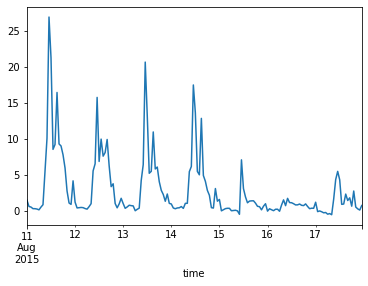

In [44]:
light_pred = (light_pred1 + light_pred2 + light_pred3 + light_pred4) / 4
light_pred[120:144] = light_pred2[120:144]

delta = light_pred - old_data["light"].values
light_pred = light_pred + 2 * delta

data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

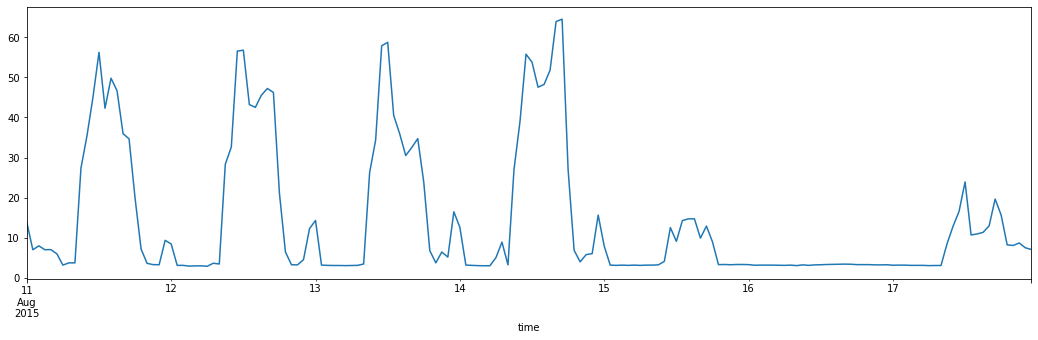

In [45]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [46]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_air = data_air["value_air"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_air.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [47]:
model_air1 = LGBMRegressor(n_estimators=10000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred1 = model_air1.predict(x_test_air)

<h5>取最后7*24个点作为模型2预测值</h5>

In [48]:
air_pred2 = data_air.loc[: "2015-08-17 23:00:00", "value_air"].values[-7*24:]

<h5>构建catboost</h5>

In [49]:
model_air3 = CatBoostRegressor(n_estimators=10000, random_state=1024).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred3 = model_air3.predict(x_test_air)

Learning rate set to 0.009761
0:	learn: 14.6427094	total: 2.97ms	remaining: 29.7s
1:	learn: 14.5482418	total: 5.73ms	remaining: 28.7s
2:	learn: 14.4549936	total: 8.47ms	remaining: 28.2s
3:	learn: 14.3631462	total: 11.1ms	remaining: 27.7s
4:	learn: 14.2722965	total: 13.8ms	remaining: 27.5s
5:	learn: 14.1828575	total: 16.4ms	remaining: 27.3s
6:	learn: 14.0957589	total: 18.9ms	remaining: 27s
7:	learn: 14.0098185	total: 21.6ms	remaining: 26.9s
8:	learn: 13.9245049	total: 24.2ms	remaining: 26.8s
9:	learn: 13.8408275	total: 26.7ms	remaining: 26.7s
10:	learn: 13.7564833	total: 29.4ms	remaining: 26.7s
11:	learn: 13.6731521	total: 31.9ms	remaining: 26.5s
12:	learn: 13.5907623	total: 34.5ms	remaining: 26.5s
13:	learn: 13.5095307	total: 37ms	remaining: 26.4s
14:	learn: 13.4291620	total: 39.7ms	remaining: 26.4s
15:	learn: 13.3511823	total: 42.4ms	remaining: 26.4s
16:	learn: 13.2727873	total: 45ms	remaining: 26.4s
17:	learn: 13.1971199	total: 47.6ms	remaining: 26.4s
18:	learn: 13.1207382	total: 50.

232:	learn: 7.4690732	total: 549ms	remaining: 23s
233:	learn: 7.4636085	total: 551ms	remaining: 23s
234:	learn: 7.4548216	total: 554ms	remaining: 23s
235:	learn: 7.4488155	total: 556ms	remaining: 23s
236:	learn: 7.4433342	total: 558ms	remaining: 23s
237:	learn: 7.4379845	total: 561ms	remaining: 23s
238:	learn: 7.4326453	total: 563ms	remaining: 23s
239:	learn: 7.4257519	total: 565ms	remaining: 23s
240:	learn: 7.4182297	total: 567ms	remaining: 23s
241:	learn: 7.4128939	total: 570ms	remaining: 23s
242:	learn: 7.4055453	total: 572ms	remaining: 23s
243:	learn: 7.3986444	total: 574ms	remaining: 23s
244:	learn: 7.3915567	total: 577ms	remaining: 23s
245:	learn: 7.3866087	total: 579ms	remaining: 23s
246:	learn: 7.3800842	total: 581ms	remaining: 23s
247:	learn: 7.3751654	total: 584ms	remaining: 22.9s
248:	learn: 7.3676789	total: 586ms	remaining: 22.9s
249:	learn: 7.3597619	total: 588ms	remaining: 22.9s
250:	learn: 7.3532909	total: 591ms	remaining: 22.9s
251:	learn: 7.3461245	total: 593ms	remaini

466:	learn: 6.3784077	total: 1.09s	remaining: 22.3s
467:	learn: 6.3748729	total: 1.09s	remaining: 22.3s
468:	learn: 6.3699648	total: 1.1s	remaining: 22.3s
469:	learn: 6.3670197	total: 1.1s	remaining: 22.3s
470:	learn: 6.3647093	total: 1.1s	remaining: 22.3s
471:	learn: 6.3617325	total: 1.1s	remaining: 22.3s
472:	learn: 6.3574482	total: 1.1s	remaining: 22.3s
473:	learn: 6.3534346	total: 1.11s	remaining: 22.3s
474:	learn: 6.3510213	total: 1.11s	remaining: 22.3s
475:	learn: 6.3471859	total: 1.11s	remaining: 22.3s
476:	learn: 6.3451182	total: 1.11s	remaining: 22.3s
477:	learn: 6.3423490	total: 1.12s	remaining: 22.3s
478:	learn: 6.3388234	total: 1.12s	remaining: 22.2s
479:	learn: 6.3356155	total: 1.12s	remaining: 22.2s
480:	learn: 6.3317864	total: 1.12s	remaining: 22.2s
481:	learn: 6.3282599	total: 1.13s	remaining: 22.2s
482:	learn: 6.3255893	total: 1.13s	remaining: 22.2s
483:	learn: 6.3226822	total: 1.13s	remaining: 22.2s
484:	learn: 6.3188580	total: 1.13s	remaining: 22.2s
485:	learn: 6.315

704:	learn: 5.7882105	total: 1.64s	remaining: 21.6s
705:	learn: 5.7869658	total: 1.64s	remaining: 21.6s
706:	learn: 5.7846885	total: 1.64s	remaining: 21.6s
707:	learn: 5.7824749	total: 1.64s	remaining: 21.6s
708:	learn: 5.7804540	total: 1.64s	remaining: 21.6s
709:	learn: 5.7788727	total: 1.65s	remaining: 21.6s
710:	learn: 5.7771993	total: 1.65s	remaining: 21.5s
711:	learn: 5.7759533	total: 1.65s	remaining: 21.5s
712:	learn: 5.7740970	total: 1.65s	remaining: 21.5s
713:	learn: 5.7722170	total: 1.66s	remaining: 21.5s
714:	learn: 5.7704765	total: 1.66s	remaining: 21.5s
715:	learn: 5.7680468	total: 1.66s	remaining: 21.5s
716:	learn: 5.7667267	total: 1.66s	remaining: 21.5s
717:	learn: 5.7647730	total: 1.67s	remaining: 21.5s
718:	learn: 5.7632167	total: 1.67s	remaining: 21.5s
719:	learn: 5.7612176	total: 1.67s	remaining: 21.5s
720:	learn: 5.7598129	total: 1.67s	remaining: 21.5s
721:	learn: 5.7586236	total: 1.67s	remaining: 21.5s
722:	learn: 5.7573350	total: 1.68s	remaining: 21.5s
723:	learn: 

865:	learn: 5.5059557	total: 2s	remaining: 21.1s
866:	learn: 5.5036819	total: 2s	remaining: 21.1s
867:	learn: 5.5023547	total: 2.01s	remaining: 21.1s
868:	learn: 5.5007511	total: 2.01s	remaining: 21.1s
869:	learn: 5.4987074	total: 2.01s	remaining: 21.1s
870:	learn: 5.4975629	total: 2.01s	remaining: 21.1s
871:	learn: 5.4953875	total: 2.02s	remaining: 21.1s
872:	learn: 5.4939797	total: 2.02s	remaining: 21.1s
873:	learn: 5.4922731	total: 2.02s	remaining: 21.1s
874:	learn: 5.4908643	total: 2.02s	remaining: 21.1s
875:	learn: 5.4888137	total: 2.02s	remaining: 21.1s
876:	learn: 5.4877429	total: 2.03s	remaining: 21.1s
877:	learn: 5.4856329	total: 2.03s	remaining: 21.1s
878:	learn: 5.4839964	total: 2.03s	remaining: 21.1s
879:	learn: 5.4820114	total: 2.04s	remaining: 21.1s
880:	learn: 5.4809596	total: 2.04s	remaining: 21.1s
881:	learn: 5.4792936	total: 2.04s	remaining: 21.1s
882:	learn: 5.4770879	total: 2.04s	remaining: 21.1s
883:	learn: 5.4755497	total: 2.04s	remaining: 21.1s
884:	learn: 5.4739

1027:	learn: 5.2776870	total: 2.37s	remaining: 20.7s
1028:	learn: 5.2766504	total: 2.38s	remaining: 20.7s
1029:	learn: 5.2760440	total: 2.38s	remaining: 20.7s
1030:	learn: 5.2747607	total: 2.38s	remaining: 20.7s
1031:	learn: 5.2739278	total: 2.38s	remaining: 20.7s
1032:	learn: 5.2728838	total: 2.38s	remaining: 20.7s
1033:	learn: 5.2720734	total: 2.39s	remaining: 20.7s
1034:	learn: 5.2707966	total: 2.39s	remaining: 20.7s
1035:	learn: 5.2696006	total: 2.39s	remaining: 20.7s
1036:	learn: 5.2687039	total: 2.39s	remaining: 20.7s
1037:	learn: 5.2675900	total: 2.4s	remaining: 20.7s
1038:	learn: 5.2667580	total: 2.4s	remaining: 20.7s
1039:	learn: 5.2654956	total: 2.4s	remaining: 20.7s
1040:	learn: 5.2643871	total: 2.4s	remaining: 20.7s
1041:	learn: 5.2631785	total: 2.4s	remaining: 20.7s
1042:	learn: 5.2618211	total: 2.41s	remaining: 20.7s
1043:	learn: 5.2605227	total: 2.41s	remaining: 20.7s
1044:	learn: 5.2596182	total: 2.41s	remaining: 20.7s
1045:	learn: 5.2584138	total: 2.41s	remaining: 20.7

1186:	learn: 5.0861846	total: 2.73s	remaining: 20.3s
1187:	learn: 5.0853147	total: 2.74s	remaining: 20.3s
1188:	learn: 5.0841897	total: 2.74s	remaining: 20.3s
1189:	learn: 5.0829642	total: 2.74s	remaining: 20.3s
1190:	learn: 5.0821419	total: 2.74s	remaining: 20.3s
1191:	learn: 5.0814630	total: 2.75s	remaining: 20.3s
1192:	learn: 5.0802457	total: 2.75s	remaining: 20.3s
1193:	learn: 5.0789357	total: 2.75s	remaining: 20.3s
1194:	learn: 5.0780715	total: 2.75s	remaining: 20.3s
1195:	learn: 5.0763987	total: 2.76s	remaining: 20.3s
1196:	learn: 5.0749250	total: 2.76s	remaining: 20.3s
1197:	learn: 5.0738695	total: 2.76s	remaining: 20.3s
1198:	learn: 5.0729214	total: 2.76s	remaining: 20.3s
1199:	learn: 5.0716790	total: 2.77s	remaining: 20.3s
1200:	learn: 5.0704697	total: 2.77s	remaining: 20.3s
1201:	learn: 5.0691099	total: 2.77s	remaining: 20.3s
1202:	learn: 5.0683744	total: 2.77s	remaining: 20.3s
1203:	learn: 5.0674649	total: 2.77s	remaining: 20.3s
1204:	learn: 5.0662020	total: 2.78s	remaining:

1344:	learn: 4.9272801	total: 3.1s	remaining: 19.9s
1345:	learn: 4.9268168	total: 3.1s	remaining: 19.9s
1346:	learn: 4.9256269	total: 3.1s	remaining: 19.9s
1347:	learn: 4.9246234	total: 3.1s	remaining: 19.9s
1348:	learn: 4.9232537	total: 3.1s	remaining: 19.9s
1349:	learn: 4.9221732	total: 3.11s	remaining: 19.9s
1350:	learn: 4.9207703	total: 3.11s	remaining: 19.9s
1351:	learn: 4.9196550	total: 3.11s	remaining: 19.9s
1352:	learn: 4.9188490	total: 3.11s	remaining: 19.9s
1353:	learn: 4.9178528	total: 3.12s	remaining: 19.9s
1354:	learn: 4.9165488	total: 3.12s	remaining: 19.9s
1355:	learn: 4.9157429	total: 3.12s	remaining: 19.9s
1356:	learn: 4.9149233	total: 3.12s	remaining: 19.9s
1357:	learn: 4.9141143	total: 3.13s	remaining: 19.9s
1358:	learn: 4.9132611	total: 3.13s	remaining: 19.9s
1359:	learn: 4.9124840	total: 3.13s	remaining: 19.9s
1360:	learn: 4.9116203	total: 3.13s	remaining: 19.9s
1361:	learn: 4.9108393	total: 3.13s	remaining: 19.9s
1362:	learn: 4.9097883	total: 3.14s	remaining: 19.9

1503:	learn: 4.7795964	total: 3.46s	remaining: 19.5s
1504:	learn: 4.7789021	total: 3.46s	remaining: 19.5s
1505:	learn: 4.7778801	total: 3.46s	remaining: 19.5s
1506:	learn: 4.7770048	total: 3.47s	remaining: 19.5s
1507:	learn: 4.7759702	total: 3.47s	remaining: 19.5s
1508:	learn: 4.7749664	total: 3.47s	remaining: 19.5s
1509:	learn: 4.7743812	total: 3.47s	remaining: 19.5s
1510:	learn: 4.7734281	total: 3.48s	remaining: 19.5s
1511:	learn: 4.7722030	total: 3.48s	remaining: 19.5s
1512:	learn: 4.7715736	total: 3.48s	remaining: 19.5s
1513:	learn: 4.7707751	total: 3.48s	remaining: 19.5s
1514:	learn: 4.7698967	total: 3.48s	remaining: 19.5s
1515:	learn: 4.7689285	total: 3.49s	remaining: 19.5s
1516:	learn: 4.7683861	total: 3.49s	remaining: 19.5s
1517:	learn: 4.7674935	total: 3.49s	remaining: 19.5s
1518:	learn: 4.7663940	total: 3.49s	remaining: 19.5s
1519:	learn: 4.7656946	total: 3.5s	remaining: 19.5s
1520:	learn: 4.7651533	total: 3.5s	remaining: 19.5s
1521:	learn: 4.7637057	total: 3.5s	remaining: 19

1662:	learn: 4.6466499	total: 3.83s	remaining: 19.2s
1663:	learn: 4.6457986	total: 3.83s	remaining: 19.2s
1664:	learn: 4.6451754	total: 3.83s	remaining: 19.2s
1665:	learn: 4.6444729	total: 3.83s	remaining: 19.2s
1666:	learn: 4.6436387	total: 3.84s	remaining: 19.2s
1667:	learn: 4.6428242	total: 3.84s	remaining: 19.2s
1668:	learn: 4.6419745	total: 3.84s	remaining: 19.2s
1669:	learn: 4.6414092	total: 3.84s	remaining: 19.2s
1670:	learn: 4.6404964	total: 3.85s	remaining: 19.2s
1671:	learn: 4.6398973	total: 3.85s	remaining: 19.2s
1672:	learn: 4.6389669	total: 3.85s	remaining: 19.2s
1673:	learn: 4.6381989	total: 3.85s	remaining: 19.2s
1674:	learn: 4.6372761	total: 3.85s	remaining: 19.2s
1675:	learn: 4.6367031	total: 3.86s	remaining: 19.2s
1676:	learn: 4.6360134	total: 3.86s	remaining: 19.2s
1677:	learn: 4.6349294	total: 3.86s	remaining: 19.2s
1678:	learn: 4.6338236	total: 3.86s	remaining: 19.2s
1679:	learn: 4.6324313	total: 3.87s	remaining: 19.2s
1680:	learn: 4.6318155	total: 3.87s	remaining:

1820:	learn: 4.5294051	total: 4.19s	remaining: 18.8s
1821:	learn: 4.5288152	total: 4.19s	remaining: 18.8s
1822:	learn: 4.5283449	total: 4.19s	remaining: 18.8s
1823:	learn: 4.5277814	total: 4.2s	remaining: 18.8s
1824:	learn: 4.5272227	total: 4.2s	remaining: 18.8s
1825:	learn: 4.5266294	total: 4.2s	remaining: 18.8s
1826:	learn: 4.5257986	total: 4.2s	remaining: 18.8s
1827:	learn: 4.5250271	total: 4.21s	remaining: 18.8s
1828:	learn: 4.5240466	total: 4.21s	remaining: 18.8s
1829:	learn: 4.5234210	total: 4.21s	remaining: 18.8s
1830:	learn: 4.5229737	total: 4.21s	remaining: 18.8s
1831:	learn: 4.5223632	total: 4.22s	remaining: 18.8s
1832:	learn: 4.5218623	total: 4.22s	remaining: 18.8s
1833:	learn: 4.5212923	total: 4.22s	remaining: 18.8s
1834:	learn: 4.5207539	total: 4.22s	remaining: 18.8s
1835:	learn: 4.5203088	total: 4.22s	remaining: 18.8s
1836:	learn: 4.5196950	total: 4.23s	remaining: 18.8s
1837:	learn: 4.5191890	total: 4.23s	remaining: 18.8s
1838:	learn: 4.5184822	total: 4.23s	remaining: 18.

1978:	learn: 4.4239071	total: 4.55s	remaining: 18.4s
1979:	learn: 4.4235557	total: 4.55s	remaining: 18.4s
1980:	learn: 4.4230034	total: 4.55s	remaining: 18.4s
1981:	learn: 4.4223520	total: 4.56s	remaining: 18.4s
1982:	learn: 4.4218187	total: 4.56s	remaining: 18.4s
1983:	learn: 4.4210261	total: 4.56s	remaining: 18.4s
1984:	learn: 4.4202006	total: 4.57s	remaining: 18.4s
1985:	learn: 4.4197761	total: 4.57s	remaining: 18.4s
1986:	learn: 4.4194489	total: 4.57s	remaining: 18.4s
1987:	learn: 4.4189349	total: 4.57s	remaining: 18.4s
1988:	learn: 4.4183958	total: 4.57s	remaining: 18.4s
1989:	learn: 4.4179814	total: 4.58s	remaining: 18.4s
1990:	learn: 4.4166506	total: 4.58s	remaining: 18.4s
1991:	learn: 4.4160143	total: 4.58s	remaining: 18.4s
1992:	learn: 4.4151740	total: 4.58s	remaining: 18.4s
1993:	learn: 4.4144960	total: 4.59s	remaining: 18.4s
1994:	learn: 4.4137388	total: 4.59s	remaining: 18.4s
1995:	learn: 4.4132197	total: 4.59s	remaining: 18.4s
1996:	learn: 4.4127859	total: 4.59s	remaining:

2136:	learn: 4.3287526	total: 4.91s	remaining: 18.1s
2137:	learn: 4.3281491	total: 4.92s	remaining: 18.1s
2138:	learn: 4.3278436	total: 4.92s	remaining: 18.1s
2139:	learn: 4.3275405	total: 4.92s	remaining: 18.1s
2140:	learn: 4.3270401	total: 4.92s	remaining: 18.1s
2141:	learn: 4.3267094	total: 4.92s	remaining: 18.1s
2142:	learn: 4.3263089	total: 4.93s	remaining: 18.1s
2143:	learn: 4.3257645	total: 4.93s	remaining: 18.1s
2144:	learn: 4.3253761	total: 4.93s	remaining: 18.1s
2145:	learn: 4.3248251	total: 4.93s	remaining: 18.1s
2146:	learn: 4.3244078	total: 4.94s	remaining: 18.1s
2147:	learn: 4.3237213	total: 4.94s	remaining: 18.1s
2148:	learn: 4.3231715	total: 4.94s	remaining: 18.1s
2149:	learn: 4.3227459	total: 4.94s	remaining: 18s
2150:	learn: 4.3223540	total: 4.95s	remaining: 18s
2151:	learn: 4.3216846	total: 4.95s	remaining: 18s
2152:	learn: 4.3209531	total: 4.95s	remaining: 18s
2153:	learn: 4.3204755	total: 4.95s	remaining: 18s
2154:	learn: 4.3201552	total: 4.95s	remaining: 18s
2155:

2298:	learn: 4.2453548	total: 5.28s	remaining: 17.7s
2299:	learn: 4.2450070	total: 5.28s	remaining: 17.7s
2300:	learn: 4.2446557	total: 5.29s	remaining: 17.7s
2301:	learn: 4.2439545	total: 5.29s	remaining: 17.7s
2302:	learn: 4.2433941	total: 5.29s	remaining: 17.7s
2303:	learn: 4.2430278	total: 5.29s	remaining: 17.7s
2304:	learn: 4.2426273	total: 5.3s	remaining: 17.7s
2305:	learn: 4.2420378	total: 5.3s	remaining: 17.7s
2306:	learn: 4.2413341	total: 5.3s	remaining: 17.7s
2307:	learn: 4.2408297	total: 5.3s	remaining: 17.7s
2308:	learn: 4.2402328	total: 5.31s	remaining: 17.7s
2309:	learn: 4.2395339	total: 5.31s	remaining: 17.7s
2310:	learn: 4.2391799	total: 5.31s	remaining: 17.7s
2311:	learn: 4.2388532	total: 5.31s	remaining: 17.7s
2312:	learn: 4.2386331	total: 5.32s	remaining: 17.7s
2313:	learn: 4.2380279	total: 5.32s	remaining: 17.7s
2314:	learn: 4.2374855	total: 5.32s	remaining: 17.7s
2315:	learn: 4.2366071	total: 5.32s	remaining: 17.7s
2316:	learn: 4.2358832	total: 5.32s	remaining: 17.

2453:	learn: 4.1697934	total: 5.63s	remaining: 17.3s
2454:	learn: 4.1688773	total: 5.64s	remaining: 17.3s
2455:	learn: 4.1682377	total: 5.64s	remaining: 17.3s
2456:	learn: 4.1677662	total: 5.64s	remaining: 17.3s
2457:	learn: 4.1671205	total: 5.64s	remaining: 17.3s
2458:	learn: 4.1667015	total: 5.65s	remaining: 17.3s
2459:	learn: 4.1662315	total: 5.65s	remaining: 17.3s
2460:	learn: 4.1657710	total: 5.65s	remaining: 17.3s
2461:	learn: 4.1655401	total: 5.65s	remaining: 17.3s
2462:	learn: 4.1644362	total: 5.66s	remaining: 17.3s
2463:	learn: 4.1638062	total: 5.66s	remaining: 17.3s
2464:	learn: 4.1631828	total: 5.66s	remaining: 17.3s
2465:	learn: 4.1628435	total: 5.66s	remaining: 17.3s
2466:	learn: 4.1624460	total: 5.67s	remaining: 17.3s
2467:	learn: 4.1621394	total: 5.67s	remaining: 17.3s
2468:	learn: 4.1615273	total: 5.67s	remaining: 17.3s
2469:	learn: 4.1610418	total: 5.67s	remaining: 17.3s
2470:	learn: 4.1606074	total: 5.67s	remaining: 17.3s
2471:	learn: 4.1600986	total: 5.68s	remaining:

2614:	learn: 4.0954165	total: 6s	remaining: 16.9s
2615:	learn: 4.0950943	total: 6s	remaining: 16.9s
2616:	learn: 4.0945111	total: 6s	remaining: 16.9s
2617:	learn: 4.0940229	total: 6.01s	remaining: 16.9s
2618:	learn: 4.0937172	total: 6.01s	remaining: 16.9s
2619:	learn: 4.0930539	total: 6.01s	remaining: 16.9s
2620:	learn: 4.0926019	total: 6.01s	remaining: 16.9s
2621:	learn: 4.0923712	total: 6.02s	remaining: 16.9s
2622:	learn: 4.0917284	total: 6.02s	remaining: 16.9s
2623:	learn: 4.0913886	total: 6.02s	remaining: 16.9s
2624:	learn: 4.0909950	total: 6.02s	remaining: 16.9s
2625:	learn: 4.0906287	total: 6.03s	remaining: 16.9s
2626:	learn: 4.0902132	total: 6.03s	remaining: 16.9s
2627:	learn: 4.0897761	total: 6.03s	remaining: 16.9s
2628:	learn: 4.0894287	total: 6.03s	remaining: 16.9s
2629:	learn: 4.0891417	total: 6.04s	remaining: 16.9s
2630:	learn: 4.0888568	total: 6.04s	remaining: 16.9s
2631:	learn: 4.0884814	total: 6.04s	remaining: 16.9s
2632:	learn: 4.0880051	total: 6.04s	remaining: 16.9s
26

2775:	learn: 4.0263648	total: 6.37s	remaining: 16.6s
2776:	learn: 4.0259994	total: 6.37s	remaining: 16.6s
2777:	learn: 4.0255135	total: 6.37s	remaining: 16.6s
2778:	learn: 4.0251714	total: 6.38s	remaining: 16.6s
2779:	learn: 4.0247479	total: 6.38s	remaining: 16.6s
2780:	learn: 4.0244141	total: 6.38s	remaining: 16.6s
2781:	learn: 4.0240581	total: 6.38s	remaining: 16.6s
2782:	learn: 4.0239004	total: 6.39s	remaining: 16.6s
2783:	learn: 4.0229957	total: 6.39s	remaining: 16.6s
2784:	learn: 4.0225699	total: 6.39s	remaining: 16.6s
2785:	learn: 4.0221887	total: 6.39s	remaining: 16.6s
2786:	learn: 4.0218388	total: 6.39s	remaining: 16.6s
2787:	learn: 4.0214320	total: 6.4s	remaining: 16.5s
2788:	learn: 4.0209160	total: 6.4s	remaining: 16.5s
2789:	learn: 4.0206161	total: 6.4s	remaining: 16.5s
2790:	learn: 4.0202397	total: 6.4s	remaining: 16.5s
2791:	learn: 4.0199302	total: 6.41s	remaining: 16.5s
2792:	learn: 4.0194567	total: 6.41s	remaining: 16.5s
2793:	learn: 4.0190437	total: 6.41s	remaining: 16.

2931:	learn: 3.9661319	total: 6.72s	remaining: 16.2s
2932:	learn: 3.9657398	total: 6.73s	remaining: 16.2s
2933:	learn: 3.9654526	total: 6.73s	remaining: 16.2s
2934:	learn: 3.9649503	total: 6.73s	remaining: 16.2s
2935:	learn: 3.9645542	total: 6.73s	remaining: 16.2s
2936:	learn: 3.9640919	total: 6.74s	remaining: 16.2s
2937:	learn: 3.9636994	total: 6.74s	remaining: 16.2s
2938:	learn: 3.9632811	total: 6.74s	remaining: 16.2s
2939:	learn: 3.9630476	total: 6.74s	remaining: 16.2s
2940:	learn: 3.9626999	total: 6.75s	remaining: 16.2s
2941:	learn: 3.9624224	total: 6.75s	remaining: 16.2s
2942:	learn: 3.9619537	total: 6.75s	remaining: 16.2s
2943:	learn: 3.9614369	total: 6.75s	remaining: 16.2s
2944:	learn: 3.9610604	total: 6.75s	remaining: 16.2s
2945:	learn: 3.9604833	total: 6.76s	remaining: 16.2s
2946:	learn: 3.9598795	total: 6.76s	remaining: 16.2s
2947:	learn: 3.9596118	total: 6.76s	remaining: 16.2s
2948:	learn: 3.9593166	total: 6.76s	remaining: 16.2s
2949:	learn: 3.9590051	total: 6.77s	remaining:

3089:	learn: 3.9070711	total: 7.09s	remaining: 15.9s
3090:	learn: 3.9064517	total: 7.09s	remaining: 15.9s
3091:	learn: 3.9061396	total: 7.09s	remaining: 15.9s
3092:	learn: 3.9059456	total: 7.1s	remaining: 15.8s
3093:	learn: 3.9056219	total: 7.1s	remaining: 15.8s
3094:	learn: 3.9053423	total: 7.1s	remaining: 15.8s
3095:	learn: 3.9050112	total: 7.1s	remaining: 15.8s
3096:	learn: 3.9046082	total: 7.11s	remaining: 15.8s
3097:	learn: 3.9043624	total: 7.11s	remaining: 15.8s
3098:	learn: 3.9041173	total: 7.11s	remaining: 15.8s
3099:	learn: 3.9037859	total: 7.11s	remaining: 15.8s
3100:	learn: 3.9032816	total: 7.12s	remaining: 15.8s
3101:	learn: 3.9029492	total: 7.12s	remaining: 15.8s
3102:	learn: 3.9024544	total: 7.12s	remaining: 15.8s
3103:	learn: 3.9021567	total: 7.12s	remaining: 15.8s
3104:	learn: 3.9015345	total: 7.12s	remaining: 15.8s
3105:	learn: 3.9010804	total: 7.13s	remaining: 15.8s
3106:	learn: 3.9007853	total: 7.13s	remaining: 15.8s
3107:	learn: 3.9004868	total: 7.13s	remaining: 15.

3249:	learn: 3.8509363	total: 7.45s	remaining: 15.5s
3250:	learn: 3.8506732	total: 7.46s	remaining: 15.5s
3251:	learn: 3.8502408	total: 7.46s	remaining: 15.5s
3252:	learn: 3.8498298	total: 7.46s	remaining: 15.5s
3253:	learn: 3.8493606	total: 7.46s	remaining: 15.5s
3254:	learn: 3.8490982	total: 7.46s	remaining: 15.5s
3255:	learn: 3.8487857	total: 7.47s	remaining: 15.5s
3256:	learn: 3.8482264	total: 7.47s	remaining: 15.5s
3257:	learn: 3.8477705	total: 7.47s	remaining: 15.5s
3258:	learn: 3.8475514	total: 7.47s	remaining: 15.5s
3259:	learn: 3.8472778	total: 7.48s	remaining: 15.5s
3260:	learn: 3.8470185	total: 7.48s	remaining: 15.5s
3261:	learn: 3.8467472	total: 7.48s	remaining: 15.5s
3262:	learn: 3.8463264	total: 7.48s	remaining: 15.5s
3263:	learn: 3.8459431	total: 7.49s	remaining: 15.5s
3264:	learn: 3.8456675	total: 7.49s	remaining: 15.4s
3265:	learn: 3.8453449	total: 7.49s	remaining: 15.4s
3266:	learn: 3.8450191	total: 7.49s	remaining: 15.4s
3267:	learn: 3.8448022	total: 7.5s	remaining: 

3414:	learn: 3.7960574	total: 7.83s	remaining: 15.1s
3415:	learn: 3.7956563	total: 7.83s	remaining: 15.1s
3416:	learn: 3.7954804	total: 7.83s	remaining: 15.1s
3417:	learn: 3.7951638	total: 7.83s	remaining: 15.1s
3418:	learn: 3.7948424	total: 7.84s	remaining: 15.1s
3419:	learn: 3.7944145	total: 7.84s	remaining: 15.1s
3420:	learn: 3.7939348	total: 7.84s	remaining: 15.1s
3421:	learn: 3.7936511	total: 7.84s	remaining: 15.1s
3422:	learn: 3.7933544	total: 7.85s	remaining: 15.1s
3423:	learn: 3.7930151	total: 7.85s	remaining: 15.1s
3424:	learn: 3.7927032	total: 7.85s	remaining: 15.1s
3425:	learn: 3.7924361	total: 7.85s	remaining: 15.1s
3426:	learn: 3.7920845	total: 7.86s	remaining: 15.1s
3427:	learn: 3.7917652	total: 7.86s	remaining: 15.1s
3428:	learn: 3.7915309	total: 7.86s	remaining: 15.1s
3429:	learn: 3.7912686	total: 7.86s	remaining: 15.1s
3430:	learn: 3.7909745	total: 7.87s	remaining: 15.1s
3431:	learn: 3.7905866	total: 7.87s	remaining: 15.1s
3432:	learn: 3.7902676	total: 7.87s	remaining:

3575:	learn: 3.7435488	total: 8.2s	remaining: 14.7s
3576:	learn: 3.7433207	total: 8.2s	remaining: 14.7s
3577:	learn: 3.7428775	total: 8.2s	remaining: 14.7s
3578:	learn: 3.7427034	total: 8.2s	remaining: 14.7s
3579:	learn: 3.7424433	total: 8.2s	remaining: 14.7s
3580:	learn: 3.7421636	total: 8.21s	remaining: 14.7s
3581:	learn: 3.7418781	total: 8.21s	remaining: 14.7s
3582:	learn: 3.7416577	total: 8.21s	remaining: 14.7s
3583:	learn: 3.7412917	total: 8.21s	remaining: 14.7s
3584:	learn: 3.7408348	total: 8.22s	remaining: 14.7s
3585:	learn: 3.7405514	total: 8.22s	remaining: 14.7s
3586:	learn: 3.7402531	total: 8.22s	remaining: 14.7s
3587:	learn: 3.7400428	total: 8.22s	remaining: 14.7s
3588:	learn: 3.7397527	total: 8.22s	remaining: 14.7s
3589:	learn: 3.7393679	total: 8.23s	remaining: 14.7s
3590:	learn: 3.7388980	total: 8.23s	remaining: 14.7s
3591:	learn: 3.7384328	total: 8.23s	remaining: 14.7s
3592:	learn: 3.7379469	total: 8.23s	remaining: 14.7s
3593:	learn: 3.7376928	total: 8.24s	remaining: 14.7

3740:	learn: 3.6934725	total: 8.57s	remaining: 14.3s
3741:	learn: 3.6932245	total: 8.57s	remaining: 14.3s
3742:	learn: 3.6930385	total: 8.58s	remaining: 14.3s
3743:	learn: 3.6926793	total: 8.58s	remaining: 14.3s
3744:	learn: 3.6922793	total: 8.58s	remaining: 14.3s
3745:	learn: 3.6919448	total: 8.59s	remaining: 14.3s
3746:	learn: 3.6916125	total: 8.59s	remaining: 14.3s
3747:	learn: 3.6913937	total: 8.59s	remaining: 14.3s
3748:	learn: 3.6910487	total: 8.59s	remaining: 14.3s
3749:	learn: 3.6908212	total: 8.6s	remaining: 14.3s
3750:	learn: 3.6905431	total: 8.6s	remaining: 14.3s
3751:	learn: 3.6903501	total: 8.6s	remaining: 14.3s
3752:	learn: 3.6901605	total: 8.6s	remaining: 14.3s
3753:	learn: 3.6899075	total: 8.6s	remaining: 14.3s
3754:	learn: 3.6895106	total: 8.61s	remaining: 14.3s
3755:	learn: 3.6891713	total: 8.61s	remaining: 14.3s
3756:	learn: 3.6890491	total: 8.61s	remaining: 14.3s
3757:	learn: 3.6887493	total: 8.61s	remaining: 14.3s
3758:	learn: 3.6884781	total: 8.62s	remaining: 14.3

3904:	learn: 3.6467147	total: 8.95s	remaining: 14s
3905:	learn: 3.6464415	total: 8.95s	remaining: 14s
3906:	learn: 3.6462629	total: 8.95s	remaining: 14s
3907:	learn: 3.6457252	total: 8.96s	remaining: 14s
3908:	learn: 3.6454828	total: 8.96s	remaining: 14s
3909:	learn: 3.6452488	total: 8.96s	remaining: 14s
3910:	learn: 3.6450528	total: 8.96s	remaining: 14s
3911:	learn: 3.6448849	total: 8.96s	remaining: 14s
3912:	learn: 3.6445717	total: 8.97s	remaining: 13.9s
3913:	learn: 3.6440932	total: 8.97s	remaining: 13.9s
3914:	learn: 3.6437978	total: 8.97s	remaining: 13.9s
3915:	learn: 3.6436300	total: 8.97s	remaining: 13.9s
3916:	learn: 3.6432927	total: 8.98s	remaining: 13.9s
3917:	learn: 3.6429735	total: 8.98s	remaining: 13.9s
3918:	learn: 3.6426996	total: 8.98s	remaining: 13.9s
3919:	learn: 3.6423706	total: 8.98s	remaining: 13.9s
3920:	learn: 3.6420525	total: 8.99s	remaining: 13.9s
3921:	learn: 3.6417632	total: 8.99s	remaining: 13.9s
3922:	learn: 3.6414754	total: 8.99s	remaining: 13.9s
3923:	lea

4060:	learn: 3.6043772	total: 9.3s	remaining: 13.6s
4061:	learn: 3.6041106	total: 9.31s	remaining: 13.6s
4062:	learn: 3.6037503	total: 9.31s	remaining: 13.6s
4063:	learn: 3.6035748	total: 9.31s	remaining: 13.6s
4064:	learn: 3.6033577	total: 9.31s	remaining: 13.6s
4065:	learn: 3.6029707	total: 9.31s	remaining: 13.6s
4066:	learn: 3.6025758	total: 9.32s	remaining: 13.6s
4067:	learn: 3.6023784	total: 9.32s	remaining: 13.6s
4068:	learn: 3.6019607	total: 9.32s	remaining: 13.6s
4069:	learn: 3.6017384	total: 9.32s	remaining: 13.6s
4070:	learn: 3.6015112	total: 9.33s	remaining: 13.6s
4071:	learn: 3.6012640	total: 9.33s	remaining: 13.6s
4072:	learn: 3.6008999	total: 9.33s	remaining: 13.6s
4073:	learn: 3.6006605	total: 9.33s	remaining: 13.6s
4074:	learn: 3.6003750	total: 9.34s	remaining: 13.6s
4075:	learn: 3.6001991	total: 9.34s	remaining: 13.6s
4076:	learn: 3.5998751	total: 9.34s	remaining: 13.6s
4077:	learn: 3.5991553	total: 9.34s	remaining: 13.6s
4078:	learn: 3.5989993	total: 9.35s	remaining: 

4221:	learn: 3.5633043	total: 9.67s	remaining: 13.2s
4222:	learn: 3.5631480	total: 9.67s	remaining: 13.2s
4223:	learn: 3.5629836	total: 9.68s	remaining: 13.2s
4224:	learn: 3.5628377	total: 9.68s	remaining: 13.2s
4225:	learn: 3.5626179	total: 9.68s	remaining: 13.2s
4226:	learn: 3.5623791	total: 9.68s	remaining: 13.2s
4227:	learn: 3.5621246	total: 9.69s	remaining: 13.2s
4228:	learn: 3.5618861	total: 9.69s	remaining: 13.2s
4229:	learn: 3.5616109	total: 9.69s	remaining: 13.2s
4230:	learn: 3.5614471	total: 9.69s	remaining: 13.2s
4231:	learn: 3.5612027	total: 9.69s	remaining: 13.2s
4232:	learn: 3.5610723	total: 9.7s	remaining: 13.2s
4233:	learn: 3.5608284	total: 9.7s	remaining: 13.2s
4234:	learn: 3.5606189	total: 9.7s	remaining: 13.2s
4235:	learn: 3.5604550	total: 9.7s	remaining: 13.2s
4236:	learn: 3.5601528	total: 9.71s	remaining: 13.2s
4237:	learn: 3.5596863	total: 9.71s	remaining: 13.2s
4238:	learn: 3.5595702	total: 9.71s	remaining: 13.2s
4239:	learn: 3.5592844	total: 9.71s	remaining: 13.

4380:	learn: 3.5241289	total: 10s	remaining: 12.9s
4381:	learn: 3.5238657	total: 10s	remaining: 12.9s
4382:	learn: 3.5237026	total: 10s	remaining: 12.9s
4383:	learn: 3.5235888	total: 10s	remaining: 12.9s
4384:	learn: 3.5234529	total: 10s	remaining: 12.9s
4385:	learn: 3.5232181	total: 10s	remaining: 12.9s
4386:	learn: 3.5230544	total: 10s	remaining: 12.9s
4387:	learn: 3.5229048	total: 10.1s	remaining: 12.9s
4388:	learn: 3.5226329	total: 10.1s	remaining: 12.9s
4389:	learn: 3.5224501	total: 10.1s	remaining: 12.8s
4390:	learn: 3.5222401	total: 10.1s	remaining: 12.8s
4391:	learn: 3.5220110	total: 10.1s	remaining: 12.8s
4392:	learn: 3.5217834	total: 10.1s	remaining: 12.8s
4393:	learn: 3.5215091	total: 10.1s	remaining: 12.8s
4394:	learn: 3.5212865	total: 10.1s	remaining: 12.8s
4395:	learn: 3.5210439	total: 10.1s	remaining: 12.8s
4396:	learn: 3.5208498	total: 10.1s	remaining: 12.8s
4397:	learn: 3.5205989	total: 10.1s	remaining: 12.8s
4398:	learn: 3.5203827	total: 10.1s	remaining: 12.8s
4399:	l

4536:	learn: 3.4880763	total: 10.4s	remaining: 12.5s
4537:	learn: 3.4877657	total: 10.4s	remaining: 12.5s
4538:	learn: 3.4875494	total: 10.4s	remaining: 12.5s
4539:	learn: 3.4873190	total: 10.4s	remaining: 12.5s
4540:	learn: 3.4871597	total: 10.4s	remaining: 12.5s
4541:	learn: 3.4869031	total: 10.4s	remaining: 12.5s
4542:	learn: 3.4867177	total: 10.4s	remaining: 12.5s
4543:	learn: 3.4864433	total: 10.4s	remaining: 12.5s
4544:	learn: 3.4863043	total: 10.4s	remaining: 12.5s
4545:	learn: 3.4860909	total: 10.4s	remaining: 12.5s
4546:	learn: 3.4858812	total: 10.4s	remaining: 12.5s
4547:	learn: 3.4857573	total: 10.4s	remaining: 12.5s
4548:	learn: 3.4855616	total: 10.4s	remaining: 12.5s
4549:	learn: 3.4852580	total: 10.4s	remaining: 12.5s
4550:	learn: 3.4850856	total: 10.4s	remaining: 12.5s
4551:	learn: 3.4848765	total: 10.4s	remaining: 12.5s
4552:	learn: 3.4845603	total: 10.4s	remaining: 12.5s
4553:	learn: 3.4842368	total: 10.4s	remaining: 12.5s
4554:	learn: 3.4839823	total: 10.4s	remaining:

4698:	learn: 3.4513806	total: 10.8s	remaining: 12.1s
4699:	learn: 3.4512421	total: 10.8s	remaining: 12.1s
4700:	learn: 3.4510171	total: 10.8s	remaining: 12.1s
4701:	learn: 3.4506063	total: 10.8s	remaining: 12.1s
4702:	learn: 3.4503844	total: 10.8s	remaining: 12.1s
4703:	learn: 3.4500665	total: 10.8s	remaining: 12.1s
4704:	learn: 3.4497087	total: 10.8s	remaining: 12.1s
4705:	learn: 3.4494453	total: 10.8s	remaining: 12.1s
4706:	learn: 3.4492393	total: 10.8s	remaining: 12.1s
4707:	learn: 3.4489635	total: 10.8s	remaining: 12.1s
4708:	learn: 3.4486865	total: 10.8s	remaining: 12.1s
4709:	learn: 3.4486095	total: 10.8s	remaining: 12.1s
4710:	learn: 3.4483196	total: 10.8s	remaining: 12.1s
4711:	learn: 3.4481122	total: 10.8s	remaining: 12.1s
4712:	learn: 3.4478641	total: 10.8s	remaining: 12.1s
4713:	learn: 3.4477303	total: 10.8s	remaining: 12.1s
4714:	learn: 3.4476322	total: 10.8s	remaining: 12.1s
4715:	learn: 3.4474233	total: 10.8s	remaining: 12.1s
4716:	learn: 3.4471504	total: 10.8s	remaining:

4856:	learn: 3.4167826	total: 11.1s	remaining: 11.8s
4857:	learn: 3.4166427	total: 11.1s	remaining: 11.8s
4858:	learn: 3.4164205	total: 11.1s	remaining: 11.8s
4859:	learn: 3.4163221	total: 11.1s	remaining: 11.8s
4860:	learn: 3.4160070	total: 11.1s	remaining: 11.8s
4861:	learn: 3.4156638	total: 11.1s	remaining: 11.8s
4862:	learn: 3.4154508	total: 11.1s	remaining: 11.8s
4863:	learn: 3.4152838	total: 11.1s	remaining: 11.8s
4864:	learn: 3.4150648	total: 11.1s	remaining: 11.8s
4865:	learn: 3.4148694	total: 11.1s	remaining: 11.8s
4866:	learn: 3.4147703	total: 11.1s	remaining: 11.8s
4867:	learn: 3.4145999	total: 11.1s	remaining: 11.7s
4868:	learn: 3.4142918	total: 11.1s	remaining: 11.7s
4869:	learn: 3.4137856	total: 11.1s	remaining: 11.7s
4870:	learn: 3.4135781	total: 11.2s	remaining: 11.7s
4871:	learn: 3.4134168	total: 11.2s	remaining: 11.7s
4872:	learn: 3.4129956	total: 11.2s	remaining: 11.7s
4873:	learn: 3.4127803	total: 11.2s	remaining: 11.7s
4874:	learn: 3.4126018	total: 11.2s	remaining:

5012:	learn: 3.3831534	total: 11.5s	remaining: 11.4s
5013:	learn: 3.3829645	total: 11.5s	remaining: 11.4s
5014:	learn: 3.3828387	total: 11.5s	remaining: 11.4s
5015:	learn: 3.3826621	total: 11.5s	remaining: 11.4s
5016:	learn: 3.3824953	total: 11.5s	remaining: 11.4s
5017:	learn: 3.3821881	total: 11.5s	remaining: 11.4s
5018:	learn: 3.3819734	total: 11.5s	remaining: 11.4s
5019:	learn: 3.3817534	total: 11.5s	remaining: 11.4s
5020:	learn: 3.3816839	total: 11.5s	remaining: 11.4s
5021:	learn: 3.3814996	total: 11.5s	remaining: 11.4s
5022:	learn: 3.3812803	total: 11.5s	remaining: 11.4s
5023:	learn: 3.3811083	total: 11.5s	remaining: 11.4s
5024:	learn: 3.3808432	total: 11.5s	remaining: 11.4s
5025:	learn: 3.3806691	total: 11.5s	remaining: 11.4s
5026:	learn: 3.3805080	total: 11.5s	remaining: 11.4s
5027:	learn: 3.3803912	total: 11.5s	remaining: 11.4s
5028:	learn: 3.3801909	total: 11.5s	remaining: 11.4s
5029:	learn: 3.3800748	total: 11.5s	remaining: 11.4s
5030:	learn: 3.3799086	total: 11.5s	remaining:

5175:	learn: 3.3504510	total: 11.8s	remaining: 11s
5176:	learn: 3.3502897	total: 11.8s	remaining: 11s
5177:	learn: 3.3501717	total: 11.8s	remaining: 11s
5178:	learn: 3.3500288	total: 11.8s	remaining: 11s
5179:	learn: 3.3498664	total: 11.9s	remaining: 11s
5180:	learn: 3.3497062	total: 11.9s	remaining: 11s
5181:	learn: 3.3495054	total: 11.9s	remaining: 11s
5182:	learn: 3.3493336	total: 11.9s	remaining: 11s
5183:	learn: 3.3492059	total: 11.9s	remaining: 11s
5184:	learn: 3.3489510	total: 11.9s	remaining: 11s
5185:	learn: 3.3488689	total: 11.9s	remaining: 11s
5186:	learn: 3.3486442	total: 11.9s	remaining: 11s
5187:	learn: 3.3484585	total: 11.9s	remaining: 11s
5188:	learn: 3.3483515	total: 11.9s	remaining: 11s
5189:	learn: 3.3480718	total: 11.9s	remaining: 11s
5190:	learn: 3.3477569	total: 11.9s	remaining: 11s
5191:	learn: 3.3474946	total: 11.9s	remaining: 11s
5192:	learn: 3.3472825	total: 11.9s	remaining: 11s
5193:	learn: 3.3470135	total: 11.9s	remaining: 11s
5194:	learn: 3.3468165	total: 1

5411:	learn: 3.3018984	total: 12.4s	remaining: 10.5s
5412:	learn: 3.3017314	total: 12.4s	remaining: 10.5s
5413:	learn: 3.3015661	total: 12.4s	remaining: 10.5s
5414:	learn: 3.3014153	total: 12.4s	remaining: 10.5s
5415:	learn: 3.3011977	total: 12.4s	remaining: 10.5s
5416:	learn: 3.3009401	total: 12.4s	remaining: 10.5s
5417:	learn: 3.3008646	total: 12.4s	remaining: 10.5s
5418:	learn: 3.3004802	total: 12.4s	remaining: 10.5s
5419:	learn: 3.3003035	total: 12.4s	remaining: 10.5s
5420:	learn: 3.3001080	total: 12.4s	remaining: 10.5s
5421:	learn: 3.2998405	total: 12.4s	remaining: 10.5s
5422:	learn: 3.2997212	total: 12.4s	remaining: 10.5s
5423:	learn: 3.2996154	total: 12.4s	remaining: 10.5s
5424:	learn: 3.2993270	total: 12.4s	remaining: 10.5s
5425:	learn: 3.2990833	total: 12.4s	remaining: 10.5s
5426:	learn: 3.2988372	total: 12.4s	remaining: 10.5s
5427:	learn: 3.2985551	total: 12.4s	remaining: 10.5s
5428:	learn: 3.2984634	total: 12.4s	remaining: 10.5s
5429:	learn: 3.2983111	total: 12.4s	remaining:

5573:	learn: 3.2711558	total: 12.7s	remaining: 10.1s
5574:	learn: 3.2709666	total: 12.8s	remaining: 10.1s
5575:	learn: 3.2708166	total: 12.8s	remaining: 10.1s
5576:	learn: 3.2706543	total: 12.8s	remaining: 10.1s
5577:	learn: 3.2704715	total: 12.8s	remaining: 10.1s
5578:	learn: 3.2703400	total: 12.8s	remaining: 10.1s
5579:	learn: 3.2701483	total: 12.8s	remaining: 10.1s
5580:	learn: 3.2700527	total: 12.8s	remaining: 10.1s
5581:	learn: 3.2697459	total: 12.8s	remaining: 10.1s
5582:	learn: 3.2696134	total: 12.8s	remaining: 10.1s
5583:	learn: 3.2694325	total: 12.8s	remaining: 10.1s
5584:	learn: 3.2691657	total: 12.8s	remaining: 10.1s
5585:	learn: 3.2688740	total: 12.8s	remaining: 10.1s
5586:	learn: 3.2687524	total: 12.8s	remaining: 10.1s
5587:	learn: 3.2686343	total: 12.8s	remaining: 10.1s
5588:	learn: 3.2685059	total: 12.8s	remaining: 10.1s
5589:	learn: 3.2683052	total: 12.8s	remaining: 10.1s
5590:	learn: 3.2681424	total: 12.8s	remaining: 10.1s
5591:	learn: 3.2679194	total: 12.8s	remaining:

5812:	learn: 3.2266502	total: 13.3s	remaining: 9.57s
5813:	learn: 3.2263684	total: 13.3s	remaining: 9.57s
5814:	learn: 3.2261808	total: 13.3s	remaining: 9.57s
5815:	learn: 3.2259929	total: 13.3s	remaining: 9.57s
5816:	learn: 3.2258942	total: 13.3s	remaining: 9.56s
5817:	learn: 3.2257653	total: 13.3s	remaining: 9.56s
5818:	learn: 3.2256411	total: 13.3s	remaining: 9.56s
5819:	learn: 3.2254960	total: 13.3s	remaining: 9.56s
5820:	learn: 3.2253757	total: 13.3s	remaining: 9.56s
5821:	learn: 3.2251441	total: 13.3s	remaining: 9.55s
5822:	learn: 3.2249797	total: 13.3s	remaining: 9.55s
5823:	learn: 3.2247669	total: 13.3s	remaining: 9.55s
5824:	learn: 3.2245799	total: 13.3s	remaining: 9.55s
5825:	learn: 3.2244201	total: 13.3s	remaining: 9.54s
5826:	learn: 3.2243041	total: 13.3s	remaining: 9.54s
5827:	learn: 3.2241349	total: 13.3s	remaining: 9.54s
5828:	learn: 3.2238866	total: 13.3s	remaining: 9.54s
5829:	learn: 3.2235462	total: 13.3s	remaining: 9.54s
5830:	learn: 3.2233477	total: 13.3s	remaining:

5967:	learn: 3.1994395	total: 13.6s	remaining: 9.22s
5968:	learn: 3.1993043	total: 13.7s	remaining: 9.22s
5969:	learn: 3.1991695	total: 13.7s	remaining: 9.22s
5970:	learn: 3.1990775	total: 13.7s	remaining: 9.21s
5971:	learn: 3.1987428	total: 13.7s	remaining: 9.21s
5972:	learn: 3.1986177	total: 13.7s	remaining: 9.21s
5973:	learn: 3.1984686	total: 13.7s	remaining: 9.21s
5974:	learn: 3.1983388	total: 13.7s	remaining: 9.2s
5975:	learn: 3.1982200	total: 13.7s	remaining: 9.2s
5976:	learn: 3.1979924	total: 13.7s	remaining: 9.2s
5977:	learn: 3.1977786	total: 13.7s	remaining: 9.2s
5978:	learn: 3.1975584	total: 13.7s	remaining: 9.2s
5979:	learn: 3.1973764	total: 13.7s	remaining: 9.19s
5980:	learn: 3.1972303	total: 13.7s	remaining: 9.19s
5981:	learn: 3.1971002	total: 13.7s	remaining: 9.19s
5982:	learn: 3.1969438	total: 13.7s	remaining: 9.19s
5983:	learn: 3.1968150	total: 13.7s	remaining: 9.18s
5984:	learn: 3.1966542	total: 13.7s	remaining: 9.18s
5985:	learn: 3.1965378	total: 13.7s	remaining: 9.18

6128:	learn: 3.1729665	total: 14s	remaining: 8.85s
6129:	learn: 3.1727839	total: 14s	remaining: 8.85s
6130:	learn: 3.1726863	total: 14s	remaining: 8.85s
6131:	learn: 3.1724122	total: 14s	remaining: 8.85s
6132:	learn: 3.1723556	total: 14s	remaining: 8.84s
6133:	learn: 3.1721005	total: 14s	remaining: 8.84s
6134:	learn: 3.1719422	total: 14s	remaining: 8.84s
6135:	learn: 3.1718905	total: 14s	remaining: 8.84s
6136:	learn: 3.1716383	total: 14s	remaining: 8.83s
6137:	learn: 3.1714657	total: 14s	remaining: 8.83s
6138:	learn: 3.1713133	total: 14s	remaining: 8.83s
6139:	learn: 3.1711866	total: 14s	remaining: 8.83s
6140:	learn: 3.1710126	total: 14s	remaining: 8.82s
6141:	learn: 3.1708892	total: 14s	remaining: 8.82s
6142:	learn: 3.1707214	total: 14s	remaining: 8.82s
6143:	learn: 3.1705918	total: 14.1s	remaining: 8.82s
6144:	learn: 3.1703667	total: 14.1s	remaining: 8.81s
6145:	learn: 3.1701432	total: 14.1s	remaining: 8.81s
6146:	learn: 3.1700409	total: 14.1s	remaining: 8.81s
6147:	learn: 3.1697905	

6287:	learn: 3.1459959	total: 14.4s	remaining: 8.49s
6288:	learn: 3.1458710	total: 14.4s	remaining: 8.48s
6289:	learn: 3.1458020	total: 14.4s	remaining: 8.48s
6290:	learn: 3.1456005	total: 14.4s	remaining: 8.48s
6291:	learn: 3.1455095	total: 14.4s	remaining: 8.48s
6292:	learn: 3.1452199	total: 14.4s	remaining: 8.47s
6293:	learn: 3.1450833	total: 14.4s	remaining: 8.47s
6294:	learn: 3.1449039	total: 14.4s	remaining: 8.47s
6295:	learn: 3.1447636	total: 14.4s	remaining: 8.47s
6296:	learn: 3.1446985	total: 14.4s	remaining: 8.47s
6297:	learn: 3.1446085	total: 14.4s	remaining: 8.46s
6298:	learn: 3.1445405	total: 14.4s	remaining: 8.46s
6299:	learn: 3.1443709	total: 14.4s	remaining: 8.46s
6300:	learn: 3.1441643	total: 14.4s	remaining: 8.46s
6301:	learn: 3.1441133	total: 14.4s	remaining: 8.45s
6302:	learn: 3.1439541	total: 14.4s	remaining: 8.45s
6303:	learn: 3.1437248	total: 14.4s	remaining: 8.45s
6304:	learn: 3.1435204	total: 14.4s	remaining: 8.45s
6305:	learn: 3.1433883	total: 14.4s	remaining:

6446:	learn: 3.1203205	total: 14.7s	remaining: 8.12s
6447:	learn: 3.1201618	total: 14.7s	remaining: 8.12s
6448:	learn: 3.1199636	total: 14.7s	remaining: 8.12s
6449:	learn: 3.1198355	total: 14.7s	remaining: 8.11s
6450:	learn: 3.1196146	total: 14.7s	remaining: 8.11s
6451:	learn: 3.1195164	total: 14.7s	remaining: 8.11s
6452:	learn: 3.1193967	total: 14.8s	remaining: 8.11s
6453:	learn: 3.1192883	total: 14.8s	remaining: 8.11s
6454:	learn: 3.1191987	total: 14.8s	remaining: 8.1s
6455:	learn: 3.1190997	total: 14.8s	remaining: 8.1s
6456:	learn: 3.1188354	total: 14.8s	remaining: 8.1s
6457:	learn: 3.1187191	total: 14.8s	remaining: 8.1s
6458:	learn: 3.1185046	total: 14.8s	remaining: 8.09s
6459:	learn: 3.1182886	total: 14.8s	remaining: 8.09s
6460:	learn: 3.1182097	total: 14.8s	remaining: 8.09s
6461:	learn: 3.1180493	total: 14.8s	remaining: 8.09s
6462:	learn: 3.1177734	total: 14.8s	remaining: 8.09s
6463:	learn: 3.1176434	total: 14.8s	remaining: 8.08s
6464:	learn: 3.1174970	total: 14.8s	remaining: 8.0

6685:	learn: 3.0835358	total: 15.3s	remaining: 7.57s
6686:	learn: 3.0833614	total: 15.3s	remaining: 7.57s
6687:	learn: 3.0832094	total: 15.3s	remaining: 7.57s
6688:	learn: 3.0830623	total: 15.3s	remaining: 7.57s
6689:	learn: 3.0829318	total: 15.3s	remaining: 7.57s
6690:	learn: 3.0827801	total: 15.3s	remaining: 7.56s
6691:	learn: 3.0827029	total: 15.3s	remaining: 7.56s
6692:	learn: 3.0823909	total: 15.3s	remaining: 7.56s
6693:	learn: 3.0822633	total: 15.3s	remaining: 7.56s
6694:	learn: 3.0821709	total: 15.3s	remaining: 7.55s
6695:	learn: 3.0820022	total: 15.3s	remaining: 7.55s
6696:	learn: 3.0818370	total: 15.3s	remaining: 7.55s
6697:	learn: 3.0816999	total: 15.3s	remaining: 7.55s
6698:	learn: 3.0816279	total: 15.3s	remaining: 7.54s
6699:	learn: 3.0815684	total: 15.3s	remaining: 7.54s
6700:	learn: 3.0814603	total: 15.3s	remaining: 7.54s
6701:	learn: 3.0813539	total: 15.3s	remaining: 7.54s
6702:	learn: 3.0812146	total: 15.3s	remaining: 7.54s
6703:	learn: 3.0811680	total: 15.3s	remaining:

6843:	learn: 3.0594741	total: 15.6s	remaining: 7.21s
6844:	learn: 3.0592577	total: 15.6s	remaining: 7.21s
6845:	learn: 3.0591420	total: 15.6s	remaining: 7.21s
6846:	learn: 3.0589461	total: 15.7s	remaining: 7.21s
6847:	learn: 3.0587952	total: 15.7s	remaining: 7.2s
6848:	learn: 3.0586875	total: 15.7s	remaining: 7.2s
6849:	learn: 3.0585145	total: 15.7s	remaining: 7.2s
6850:	learn: 3.0584427	total: 15.7s	remaining: 7.2s
6851:	learn: 3.0582598	total: 15.7s	remaining: 7.2s
6852:	learn: 3.0580835	total: 15.7s	remaining: 7.19s
6853:	learn: 3.0579620	total: 15.7s	remaining: 7.19s
6854:	learn: 3.0578769	total: 15.7s	remaining: 7.19s
6855:	learn: 3.0576868	total: 15.7s	remaining: 7.19s
6856:	learn: 3.0574830	total: 15.7s	remaining: 7.18s
6857:	learn: 3.0573584	total: 15.7s	remaining: 7.18s
6858:	learn: 3.0571614	total: 15.7s	remaining: 7.18s
6859:	learn: 3.0570644	total: 15.7s	remaining: 7.18s
6860:	learn: 3.0569454	total: 15.7s	remaining: 7.17s
6861:	learn: 3.0568190	total: 15.7s	remaining: 7.17

7075:	learn: 3.0253620	total: 16.2s	remaining: 6.68s
7076:	learn: 3.0251256	total: 16.2s	remaining: 6.68s
7077:	learn: 3.0250420	total: 16.2s	remaining: 6.68s
7078:	learn: 3.0249938	total: 16.2s	remaining: 6.68s
7079:	learn: 3.0247451	total: 16.2s	remaining: 6.68s
7080:	learn: 3.0246328	total: 16.2s	remaining: 6.67s
7081:	learn: 3.0243816	total: 16.2s	remaining: 6.67s
7082:	learn: 3.0242869	total: 16.2s	remaining: 6.67s
7083:	learn: 3.0240844	total: 16.2s	remaining: 6.67s
7084:	learn: 3.0239940	total: 16.2s	remaining: 6.67s
7085:	learn: 3.0238438	total: 16.2s	remaining: 6.66s
7086:	learn: 3.0237756	total: 16.2s	remaining: 6.66s
7087:	learn: 3.0235624	total: 16.2s	remaining: 6.66s
7088:	learn: 3.0233961	total: 16.2s	remaining: 6.66s
7089:	learn: 3.0232661	total: 16.2s	remaining: 6.65s
7090:	learn: 3.0231008	total: 16.2s	remaining: 6.65s
7091:	learn: 3.0229366	total: 16.2s	remaining: 6.65s
7092:	learn: 3.0228074	total: 16.2s	remaining: 6.65s
7093:	learn: 3.0227565	total: 16.2s	remaining:

7231:	learn: 3.0035559	total: 16.5s	remaining: 6.33s
7232:	learn: 3.0033532	total: 16.5s	remaining: 6.33s
7233:	learn: 3.0032592	total: 16.5s	remaining: 6.33s
7234:	learn: 3.0030739	total: 16.5s	remaining: 6.32s
7235:	learn: 3.0029391	total: 16.5s	remaining: 6.32s
7236:	learn: 3.0028245	total: 16.6s	remaining: 6.32s
7237:	learn: 3.0027252	total: 16.6s	remaining: 6.32s
7238:	learn: 3.0025900	total: 16.6s	remaining: 6.31s
7239:	learn: 3.0025344	total: 16.6s	remaining: 6.31s
7240:	learn: 3.0024529	total: 16.6s	remaining: 6.31s
7241:	learn: 3.0023402	total: 16.6s	remaining: 6.31s
7242:	learn: 3.0022131	total: 16.6s	remaining: 6.3s
7243:	learn: 3.0020861	total: 16.6s	remaining: 6.3s
7244:	learn: 3.0019211	total: 16.6s	remaining: 6.3s
7245:	learn: 3.0018370	total: 16.6s	remaining: 6.3s
7246:	learn: 3.0017438	total: 16.6s	remaining: 6.3s
7247:	learn: 3.0016823	total: 16.6s	remaining: 6.29s
7248:	learn: 3.0015953	total: 16.6s	remaining: 6.29s
7249:	learn: 3.0013035	total: 16.6s	remaining: 6.29

7393:	learn: 2.9819040	total: 16.9s	remaining: 5.96s
7394:	learn: 2.9817956	total: 16.9s	remaining: 5.96s
7395:	learn: 2.9816172	total: 16.9s	remaining: 5.96s
7396:	learn: 2.9815507	total: 16.9s	remaining: 5.95s
7397:	learn: 2.9814741	total: 16.9s	remaining: 5.95s
7398:	learn: 2.9813308	total: 16.9s	remaining: 5.95s
7399:	learn: 2.9812360	total: 16.9s	remaining: 5.95s
7400:	learn: 2.9811318	total: 16.9s	remaining: 5.94s
7401:	learn: 2.9810433	total: 16.9s	remaining: 5.94s
7402:	learn: 2.9808095	total: 16.9s	remaining: 5.94s
7403:	learn: 2.9807403	total: 16.9s	remaining: 5.94s
7404:	learn: 2.9806289	total: 16.9s	remaining: 5.93s
7405:	learn: 2.9805570	total: 16.9s	remaining: 5.93s
7406:	learn: 2.9804647	total: 16.9s	remaining: 5.93s
7407:	learn: 2.9802988	total: 16.9s	remaining: 5.93s
7408:	learn: 2.9801455	total: 16.9s	remaining: 5.93s
7409:	learn: 2.9799747	total: 16.9s	remaining: 5.92s
7410:	learn: 2.9798842	total: 16.9s	remaining: 5.92s
7411:	learn: 2.9797571	total: 17s	remaining: 5

7631:	learn: 2.9509715	total: 17.5s	remaining: 5.41s
7632:	learn: 2.9509070	total: 17.5s	remaining: 5.41s
7633:	learn: 2.9507001	total: 17.5s	remaining: 5.41s
7634:	learn: 2.9505754	total: 17.5s	remaining: 5.41s
7635:	learn: 2.9504771	total: 17.5s	remaining: 5.41s
7636:	learn: 2.9503457	total: 17.5s	remaining: 5.4s
7637:	learn: 2.9502909	total: 17.5s	remaining: 5.4s
7638:	learn: 2.9500923	total: 17.5s	remaining: 5.4s
7639:	learn: 2.9499921	total: 17.5s	remaining: 5.4s
7640:	learn: 2.9498696	total: 17.5s	remaining: 5.39s
7641:	learn: 2.9495762	total: 17.5s	remaining: 5.39s
7642:	learn: 2.9495110	total: 17.5s	remaining: 5.39s
7643:	learn: 2.9493076	total: 17.5s	remaining: 5.39s
7644:	learn: 2.9491275	total: 17.5s	remaining: 5.38s
7645:	learn: 2.9488311	total: 17.5s	remaining: 5.38s
7646:	learn: 2.9486426	total: 17.5s	remaining: 5.38s
7647:	learn: 2.9484805	total: 17.5s	remaining: 5.38s
7648:	learn: 2.9483449	total: 17.5s	remaining: 5.38s
7649:	learn: 2.9482499	total: 17.5s	remaining: 5.3

7787:	learn: 2.9297247	total: 17.8s	remaining: 5.06s
7788:	learn: 2.9296718	total: 17.8s	remaining: 5.05s
7789:	learn: 2.9294652	total: 17.8s	remaining: 5.05s
7790:	learn: 2.9293164	total: 17.8s	remaining: 5.05s
7791:	learn: 2.9292361	total: 17.8s	remaining: 5.05s
7792:	learn: 2.9291180	total: 17.8s	remaining: 5.05s
7793:	learn: 2.9289827	total: 17.8s	remaining: 5.04s
7794:	learn: 2.9288643	total: 17.8s	remaining: 5.04s
7795:	learn: 2.9287235	total: 17.8s	remaining: 5.04s
7796:	learn: 2.9286485	total: 17.8s	remaining: 5.04s
7797:	learn: 2.9286008	total: 17.8s	remaining: 5.03s
7798:	learn: 2.9283267	total: 17.8s	remaining: 5.03s
7799:	learn: 2.9282711	total: 17.8s	remaining: 5.03s
7800:	learn: 2.9281123	total: 17.8s	remaining: 5.03s
7801:	learn: 2.9279112	total: 17.8s	remaining: 5.03s
7802:	learn: 2.9278279	total: 17.8s	remaining: 5.02s
7803:	learn: 2.9276428	total: 17.8s	remaining: 5.02s
7804:	learn: 2.9275464	total: 17.8s	remaining: 5.02s
7805:	learn: 2.9273961	total: 17.8s	remaining:

7946:	learn: 2.9103043	total: 18.2s	remaining: 4.69s
7947:	learn: 2.9102591	total: 18.2s	remaining: 4.69s
7948:	learn: 2.9100617	total: 18.2s	remaining: 4.69s
7949:	learn: 2.9099041	total: 18.2s	remaining: 4.69s
7950:	learn: 2.9097832	total: 18.2s	remaining: 4.68s
7951:	learn: 2.9096375	total: 18.2s	remaining: 4.68s
7952:	learn: 2.9095131	total: 18.2s	remaining: 4.68s
7953:	learn: 2.9093743	total: 18.2s	remaining: 4.68s
7954:	learn: 2.9092542	total: 18.2s	remaining: 4.67s
7955:	learn: 2.9090871	total: 18.2s	remaining: 4.67s
7956:	learn: 2.9089823	total: 18.2s	remaining: 4.67s
7957:	learn: 2.9088694	total: 18.2s	remaining: 4.67s
7958:	learn: 2.9086823	total: 18.2s	remaining: 4.67s
7959:	learn: 2.9085736	total: 18.2s	remaining: 4.66s
7960:	learn: 2.9084359	total: 18.2s	remaining: 4.66s
7961:	learn: 2.9083081	total: 18.2s	remaining: 4.66s
7962:	learn: 2.9081838	total: 18.2s	remaining: 4.66s
7963:	learn: 2.9079931	total: 18.2s	remaining: 4.65s
7964:	learn: 2.9078832	total: 18.2s	remaining:

8106:	learn: 2.8906255	total: 18.5s	remaining: 4.33s
8107:	learn: 2.8905396	total: 18.5s	remaining: 4.32s
8108:	learn: 2.8904129	total: 18.5s	remaining: 4.32s
8109:	learn: 2.8902534	total: 18.5s	remaining: 4.32s
8110:	learn: 2.8901519	total: 18.5s	remaining: 4.32s
8111:	learn: 2.8900156	total: 18.5s	remaining: 4.32s
8112:	learn: 2.8898688	total: 18.5s	remaining: 4.31s
8113:	learn: 2.8897224	total: 18.5s	remaining: 4.31s
8114:	learn: 2.8895846	total: 18.5s	remaining: 4.31s
8115:	learn: 2.8894262	total: 18.6s	remaining: 4.31s
8116:	learn: 2.8893284	total: 18.6s	remaining: 4.3s
8117:	learn: 2.8891711	total: 18.6s	remaining: 4.3s
8118:	learn: 2.8890841	total: 18.6s	remaining: 4.3s
8119:	learn: 2.8889321	total: 18.6s	remaining: 4.3s
8120:	learn: 2.8887917	total: 18.6s	remaining: 4.29s
8121:	learn: 2.8886857	total: 18.6s	remaining: 4.29s
8122:	learn: 2.8885995	total: 18.6s	remaining: 4.29s
8123:	learn: 2.8884123	total: 18.6s	remaining: 4.29s
8124:	learn: 2.8883566	total: 18.6s	remaining: 4.2

8268:	learn: 2.8700981	total: 18.9s	remaining: 3.96s
8269:	learn: 2.8699495	total: 18.9s	remaining: 3.95s
8270:	learn: 2.8698236	total: 18.9s	remaining: 3.95s
8271:	learn: 2.8697818	total: 18.9s	remaining: 3.95s
8272:	learn: 2.8696412	total: 18.9s	remaining: 3.95s
8273:	learn: 2.8694458	total: 18.9s	remaining: 3.94s
8274:	learn: 2.8694087	total: 18.9s	remaining: 3.94s
8275:	learn: 2.8693642	total: 18.9s	remaining: 3.94s
8276:	learn: 2.8692926	total: 18.9s	remaining: 3.94s
8277:	learn: 2.8692177	total: 18.9s	remaining: 3.94s
8278:	learn: 2.8691517	total: 18.9s	remaining: 3.93s
8279:	learn: 2.8690598	total: 18.9s	remaining: 3.93s
8280:	learn: 2.8689678	total: 18.9s	remaining: 3.93s
8281:	learn: 2.8688745	total: 18.9s	remaining: 3.93s
8282:	learn: 2.8688217	total: 18.9s	remaining: 3.92s
8283:	learn: 2.8687815	total: 18.9s	remaining: 3.92s
8284:	learn: 2.8686060	total: 18.9s	remaining: 3.92s
8285:	learn: 2.8684916	total: 18.9s	remaining: 3.92s
8286:	learn: 2.8684077	total: 18.9s	remaining:

8499:	learn: 2.8435122	total: 19.4s	remaining: 3.43s
8500:	learn: 2.8433726	total: 19.4s	remaining: 3.43s
8501:	learn: 2.8432125	total: 19.4s	remaining: 3.42s
8502:	learn: 2.8431560	total: 19.4s	remaining: 3.42s
8503:	learn: 2.8430763	total: 19.4s	remaining: 3.42s
8504:	learn: 2.8430052	total: 19.4s	remaining: 3.42s
8505:	learn: 2.8428349	total: 19.4s	remaining: 3.42s
8506:	learn: 2.8427182	total: 19.5s	remaining: 3.41s
8507:	learn: 2.8426264	total: 19.5s	remaining: 3.41s
8508:	learn: 2.8424600	total: 19.5s	remaining: 3.41s
8509:	learn: 2.8423675	total: 19.5s	remaining: 3.41s
8510:	learn: 2.8421648	total: 19.5s	remaining: 3.4s
8511:	learn: 2.8420376	total: 19.5s	remaining: 3.4s
8512:	learn: 2.8419157	total: 19.5s	remaining: 3.4s
8513:	learn: 2.8417747	total: 19.5s	remaining: 3.4s
8514:	learn: 2.8417019	total: 19.5s	remaining: 3.4s
8515:	learn: 2.8416278	total: 19.5s	remaining: 3.39s
8516:	learn: 2.8414555	total: 19.5s	remaining: 3.39s
8517:	learn: 2.8413176	total: 19.5s	remaining: 3.39

8657:	learn: 2.8251425	total: 19.8s	remaining: 3.07s
8658:	learn: 2.8249901	total: 19.8s	remaining: 3.07s
8659:	learn: 2.8248810	total: 19.8s	remaining: 3.06s
8660:	learn: 2.8248011	total: 19.8s	remaining: 3.06s
8661:	learn: 2.8245623	total: 19.8s	remaining: 3.06s
8662:	learn: 2.8244243	total: 19.8s	remaining: 3.06s
8663:	learn: 2.8243882	total: 19.8s	remaining: 3.05s
8664:	learn: 2.8242683	total: 19.8s	remaining: 3.05s
8665:	learn: 2.8241829	total: 19.8s	remaining: 3.05s
8666:	learn: 2.8240890	total: 19.8s	remaining: 3.05s
8667:	learn: 2.8240048	total: 19.8s	remaining: 3.04s
8668:	learn: 2.8238664	total: 19.8s	remaining: 3.04s
8669:	learn: 2.8237840	total: 19.8s	remaining: 3.04s
8670:	learn: 2.8236902	total: 19.8s	remaining: 3.04s
8671:	learn: 2.8235642	total: 19.8s	remaining: 3.04s
8672:	learn: 2.8234380	total: 19.8s	remaining: 3.03s
8673:	learn: 2.8233724	total: 19.8s	remaining: 3.03s
8674:	learn: 2.8232112	total: 19.8s	remaining: 3.03s
8675:	learn: 2.8230121	total: 19.8s	remaining:

8820:	learn: 2.8070902	total: 20.2s	remaining: 2.69s
8821:	learn: 2.8070256	total: 20.2s	remaining: 2.69s
8822:	learn: 2.8069361	total: 20.2s	remaining: 2.69s
8823:	learn: 2.8068302	total: 20.2s	remaining: 2.69s
8824:	learn: 2.8067070	total: 20.2s	remaining: 2.69s
8825:	learn: 2.8066477	total: 20.2s	remaining: 2.68s
8826:	learn: 2.8065731	total: 20.2s	remaining: 2.68s
8827:	learn: 2.8064349	total: 20.2s	remaining: 2.68s
8828:	learn: 2.8062830	total: 20.2s	remaining: 2.68s
8829:	learn: 2.8061573	total: 20.2s	remaining: 2.67s
8830:	learn: 2.8061019	total: 20.2s	remaining: 2.67s
8831:	learn: 2.8059748	total: 20.2s	remaining: 2.67s
8832:	learn: 2.8057949	total: 20.2s	remaining: 2.67s
8833:	learn: 2.8057381	total: 20.2s	remaining: 2.67s
8834:	learn: 2.8056600	total: 20.2s	remaining: 2.66s
8835:	learn: 2.8055496	total: 20.2s	remaining: 2.66s
8836:	learn: 2.8055023	total: 20.2s	remaining: 2.66s
8837:	learn: 2.8054241	total: 20.2s	remaining: 2.66s
8838:	learn: 2.8052743	total: 20.2s	remaining:

8979:	learn: 2.7898365	total: 20.5s	remaining: 2.33s
8980:	learn: 2.7897404	total: 20.5s	remaining: 2.33s
8981:	learn: 2.7896716	total: 20.5s	remaining: 2.33s
8982:	learn: 2.7896089	total: 20.5s	remaining: 2.32s
8983:	learn: 2.7895269	total: 20.5s	remaining: 2.32s
8984:	learn: 2.7893509	total: 20.5s	remaining: 2.32s
8985:	learn: 2.7892436	total: 20.5s	remaining: 2.32s
8986:	learn: 2.7891461	total: 20.5s	remaining: 2.31s
8987:	learn: 2.7890730	total: 20.5s	remaining: 2.31s
8988:	learn: 2.7889850	total: 20.5s	remaining: 2.31s
8989:	learn: 2.7888841	total: 20.6s	remaining: 2.31s
8990:	learn: 2.7888344	total: 20.6s	remaining: 2.31s
8991:	learn: 2.7887801	total: 20.6s	remaining: 2.3s
8992:	learn: 2.7887290	total: 20.6s	remaining: 2.3s
8993:	learn: 2.7885806	total: 20.6s	remaining: 2.3s
8994:	learn: 2.7884695	total: 20.6s	remaining: 2.3s
8995:	learn: 2.7883841	total: 20.6s	remaining: 2.29s
8996:	learn: 2.7883026	total: 20.6s	remaining: 2.29s
8997:	learn: 2.7881284	total: 20.6s	remaining: 2.2

9138:	learn: 2.7733634	total: 20.9s	remaining: 1.97s
9139:	learn: 2.7732739	total: 20.9s	remaining: 1.97s
9140:	learn: 2.7731489	total: 20.9s	remaining: 1.96s
9141:	learn: 2.7730570	total: 20.9s	remaining: 1.96s
9142:	learn: 2.7729751	total: 20.9s	remaining: 1.96s
9143:	learn: 2.7728771	total: 20.9s	remaining: 1.96s
9144:	learn: 2.7727765	total: 20.9s	remaining: 1.95s
9145:	learn: 2.7726276	total: 20.9s	remaining: 1.95s
9146:	learn: 2.7725314	total: 20.9s	remaining: 1.95s
9147:	learn: 2.7724370	total: 20.9s	remaining: 1.95s
9148:	learn: 2.7722576	total: 20.9s	remaining: 1.95s
9149:	learn: 2.7721598	total: 20.9s	remaining: 1.94s
9150:	learn: 2.7720133	total: 20.9s	remaining: 1.94s
9151:	learn: 2.7718939	total: 20.9s	remaining: 1.94s
9152:	learn: 2.7717526	total: 20.9s	remaining: 1.94s
9153:	learn: 2.7716611	total: 20.9s	remaining: 1.93s
9154:	learn: 2.7714495	total: 20.9s	remaining: 1.93s
9155:	learn: 2.7713396	total: 20.9s	remaining: 1.93s
9156:	learn: 2.7712673	total: 20.9s	remaining:

9377:	learn: 2.7471663	total: 21.4s	remaining: 1.42s
9378:	learn: 2.7470411	total: 21.4s	remaining: 1.42s
9379:	learn: 2.7469672	total: 21.4s	remaining: 1.42s
9380:	learn: 2.7468892	total: 21.4s	remaining: 1.41s
9381:	learn: 2.7467466	total: 21.4s	remaining: 1.41s
9382:	learn: 2.7466736	total: 21.4s	remaining: 1.41s
9383:	learn: 2.7465275	total: 21.4s	remaining: 1.41s
9384:	learn: 2.7464253	total: 21.4s	remaining: 1.41s
9385:	learn: 2.7462475	total: 21.5s	remaining: 1.4s
9386:	learn: 2.7461529	total: 21.5s	remaining: 1.4s
9387:	learn: 2.7460930	total: 21.5s	remaining: 1.4s
9388:	learn: 2.7459486	total: 21.5s	remaining: 1.4s
9389:	learn: 2.7458626	total: 21.5s	remaining: 1.39s
9390:	learn: 2.7457601	total: 21.5s	remaining: 1.39s
9391:	learn: 2.7457190	total: 21.5s	remaining: 1.39s
9392:	learn: 2.7456188	total: 21.5s	remaining: 1.39s
9393:	learn: 2.7455798	total: 21.5s	remaining: 1.39s
9394:	learn: 2.7454652	total: 21.5s	remaining: 1.38s
9395:	learn: 2.7454343	total: 21.5s	remaining: 1.3

9533:	learn: 2.7315019	total: 21.8s	remaining: 1.06s
9534:	learn: 2.7314457	total: 21.8s	remaining: 1.06s
9535:	learn: 2.7313775	total: 21.8s	remaining: 1.06s
9536:	learn: 2.7312574	total: 21.8s	remaining: 1.06s
9537:	learn: 2.7311715	total: 21.8s	remaining: 1.05s
9538:	learn: 2.7310569	total: 21.8s	remaining: 1.05s
9539:	learn: 2.7309277	total: 21.8s	remaining: 1.05s
9540:	learn: 2.7308863	total: 21.8s	remaining: 1.05s
9541:	learn: 2.7307423	total: 21.8s	remaining: 1.05s
9542:	learn: 2.7306518	total: 21.8s	remaining: 1.04s
9543:	learn: 2.7305324	total: 21.8s	remaining: 1.04s
9544:	learn: 2.7303930	total: 21.8s	remaining: 1.04s
9545:	learn: 2.7303100	total: 21.8s	remaining: 1.04s
9546:	learn: 2.7302381	total: 21.8s	remaining: 1.03s
9547:	learn: 2.7301535	total: 21.8s	remaining: 1.03s
9548:	learn: 2.7300358	total: 21.8s	remaining: 1.03s
9549:	learn: 2.7299612	total: 21.8s	remaining: 1.03s
9550:	learn: 2.7298824	total: 21.8s	remaining: 1.03s
9551:	learn: 2.7297601	total: 21.8s	remaining:

9694:	learn: 2.7151234	total: 22.2s	remaining: 697ms
9695:	learn: 2.7149781	total: 22.2s	remaining: 695ms
9696:	learn: 2.7149077	total: 22.2s	remaining: 692ms
9697:	learn: 2.7147500	total: 22.2s	remaining: 690ms
9698:	learn: 2.7145999	total: 22.2s	remaining: 688ms
9699:	learn: 2.7145062	total: 22.2s	remaining: 686ms
9700:	learn: 2.7144029	total: 22.2s	remaining: 683ms
9701:	learn: 2.7143333	total: 22.2s	remaining: 681ms
9702:	learn: 2.7141387	total: 22.2s	remaining: 679ms
9703:	learn: 2.7140691	total: 22.2s	remaining: 676ms
9704:	learn: 2.7139728	total: 22.2s	remaining: 674ms
9705:	learn: 2.7139122	total: 22.2s	remaining: 672ms
9706:	learn: 2.7138085	total: 22.2s	remaining: 670ms
9707:	learn: 2.7136829	total: 22.2s	remaining: 667ms
9708:	learn: 2.7135022	total: 22.2s	remaining: 665ms
9709:	learn: 2.7134266	total: 22.2s	remaining: 663ms
9710:	learn: 2.7133337	total: 22.2s	remaining: 660ms
9711:	learn: 2.7132469	total: 22.2s	remaining: 658ms
9712:	learn: 2.7130894	total: 22.2s	remaining:

9851:	learn: 2.6999578	total: 22.5s	remaining: 338ms
9852:	learn: 2.6997954	total: 22.5s	remaining: 336ms
9853:	learn: 2.6997571	total: 22.5s	remaining: 334ms
9854:	learn: 2.6996694	total: 22.5s	remaining: 331ms
9855:	learn: 2.6995308	total: 22.5s	remaining: 329ms
9856:	learn: 2.6994328	total: 22.5s	remaining: 327ms
9857:	learn: 2.6993235	total: 22.5s	remaining: 324ms
9858:	learn: 2.6992226	total: 22.5s	remaining: 322ms
9859:	learn: 2.6991636	total: 22.5s	remaining: 320ms
9860:	learn: 2.6990331	total: 22.5s	remaining: 318ms
9861:	learn: 2.6989836	total: 22.5s	remaining: 315ms
9862:	learn: 2.6989111	total: 22.5s	remaining: 313ms
9863:	learn: 2.6988225	total: 22.5s	remaining: 311ms
9864:	learn: 2.6987136	total: 22.5s	remaining: 308ms
9865:	learn: 2.6986438	total: 22.5s	remaining: 306ms
9866:	learn: 2.6984940	total: 22.5s	remaining: 304ms
9867:	learn: 2.6983725	total: 22.5s	remaining: 302ms
9868:	learn: 2.6982922	total: 22.6s	remaining: 299ms
9869:	learn: 2.6982602	total: 22.6s	remaining:

<h5>构建xgboost</h5>

In [50]:
model_air4 = XGBRegressor(n_estimators=10000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_air.loc[y_train_air > 0], y_train_air[y_train_air > 0])
air_pred4 = model_air4.predict(x_test_air)

<h5>构建深度模型</h5>

In [51]:
ds_air1 = timeseries_dataset_from_array(
    data=data_air.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air2 = timeseries_dataset_from_array(
    data=data_air.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air3 = timeseries_dataset_from_array(
    data=data_air.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air = ds_air1.concatenate(ds_air2).concatenate(ds_air3).map(split_xy)
ds_air

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [52]:
model_air5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_air.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_air5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_air5.load_weights("../models/LSTM_air_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_air_final.h5")
except (OSError, ValueError) as e:
    history: History = model_air5.fit(
        ds_air,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_air5.save_weights("../models/LSTM_air_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_air_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 16:05:24,266 [INFO] loading LSTM model from ../models/LSTM_air_final.h5


In [53]:
air_pred5 = model_air5.predict(np.expand_dims(x_test_air.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

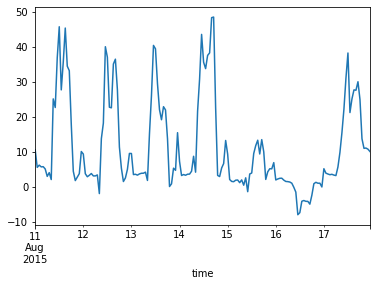

In [54]:
air_pred = (air_pred1 + air_pred2 + air_pred3 + air_pred4) / 4
air_pred[120:144] = air_pred2[120:144]

delta = air_pred - old_data["air"].values
air_pred = air_pred + 2 * delta

data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

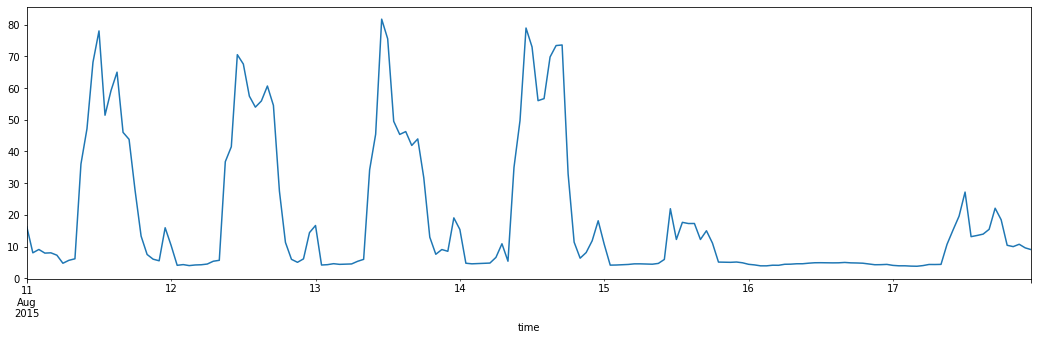

In [55]:
data.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [56]:
data_total = data.drop(columns=["value_socket", "value_light", "value_air"])
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = data_total["value_total"].loc[: "2015-08-17 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = y_train_total[y_train_total > 0]
x_train_total = x_train_total.loc[y_train_total.index]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-18 00:00:00" : "2015-08-24 23:00:00"]

sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [57]:
model_total1 = LGBMRegressor(n_estimators=70000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total1.predict(x_test_total)

<h5>取最后7*24个点作为模型2预测值</h5>

In [58]:
total_pred2 = data_total.loc[: "2015-08-17 23:00:00", "value_total"].values[-7*24:]

<h5>构建catboost</h5>

In [59]:
model_total3 = CatBoostRegressor(n_estimators=70000, random_state=1024).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred3 = model_total3.predict(x_test_total)

Learning rate set to 0.002007
0:	learn: 18.7901104	total: 3.42ms	remaining: 3m 59s
1:	learn: 18.7629050	total: 6.16ms	remaining: 3m 35s
2:	learn: 18.7357686	total: 9.21ms	remaining: 3m 34s
3:	learn: 18.7087011	total: 11.9ms	remaining: 3m 28s
4:	learn: 18.6817022	total: 14.4ms	remaining: 3m 21s
5:	learn: 18.6547718	total: 17ms	remaining: 3m 18s
6:	learn: 18.6279099	total: 19.6ms	remaining: 3m 16s
7:	learn: 18.6011163	total: 22.8ms	remaining: 3m 19s
8:	learn: 18.5744644	total: 25.5ms	remaining: 3m 17s
9:	learn: 18.5478057	total: 28ms	remaining: 3m 16s
10:	learn: 18.5212149	total: 30.8ms	remaining: 3m 15s
11:	learn: 18.4946918	total: 33.4ms	remaining: 3m 14s
12:	learn: 18.4682364	total: 36.1ms	remaining: 3m 14s
13:	learn: 18.4418484	total: 38.5ms	remaining: 3m 12s
14:	learn: 18.4155279	total: 41ms	remaining: 3m 11s
15:	learn: 18.3892746	total: 43.7ms	remaining: 3m 11s
16:	learn: 18.3631636	total: 46.3ms	remaining: 3m 10s
17:	learn: 18.3370425	total: 49ms	remaining: 3m 10s
18:	learn: 18.31

220:	learn: 14.1847069	total: 533ms	remaining: 2m 48s
221:	learn: 14.1692107	total: 535ms	remaining: 2m 48s
222:	learn: 14.1535829	total: 538ms	remaining: 2m 48s
223:	learn: 14.1381314	total: 540ms	remaining: 2m 48s
224:	learn: 14.1228630	total: 542ms	remaining: 2m 48s
225:	learn: 14.1073564	total: 544ms	remaining: 2m 48s
226:	learn: 14.0916952	total: 547ms	remaining: 2m 48s
227:	learn: 14.0763857	total: 549ms	remaining: 2m 48s
228:	learn: 14.0611158	total: 551ms	remaining: 2m 47s
229:	learn: 14.0458465	total: 554ms	remaining: 2m 47s
230:	learn: 14.0306553	total: 556ms	remaining: 2m 47s
231:	learn: 14.0154358	total: 558ms	remaining: 2m 47s
232:	learn: 14.0003360	total: 561ms	remaining: 2m 47s
233:	learn: 13.9852410	total: 563ms	remaining: 2m 47s
234:	learn: 13.9701549	total: 565ms	remaining: 2m 47s
235:	learn: 13.9551450	total: 568ms	remaining: 2m 47s
236:	learn: 13.9402290	total: 570ms	remaining: 2m 47s
237:	learn: 13.9254792	total: 572ms	remaining: 2m 47s
238:	learn: 13.9105066	total

376:	learn: 12.1876444	total: 889ms	remaining: 2m 44s
377:	learn: 12.1776186	total: 891ms	remaining: 2m 44s
378:	learn: 12.1671955	total: 893ms	remaining: 2m 44s
379:	learn: 12.1570506	total: 896ms	remaining: 2m 44s
380:	learn: 12.1466315	total: 898ms	remaining: 2m 44s
381:	learn: 12.1362325	total: 900ms	remaining: 2m 44s
382:	learn: 12.1260916	total: 903ms	remaining: 2m 44s
383:	learn: 12.1157642	total: 905ms	remaining: 2m 44s
384:	learn: 12.1058978	total: 907ms	remaining: 2m 44s
385:	learn: 12.0956876	total: 910ms	remaining: 2m 44s
386:	learn: 12.0858499	total: 912ms	remaining: 2m 44s
387:	learn: 12.0758529	total: 914ms	remaining: 2m 44s
388:	learn: 12.0657111	total: 917ms	remaining: 2m 44s
389:	learn: 12.0557723	total: 919ms	remaining: 2m 44s
390:	learn: 12.0456510	total: 921ms	remaining: 2m 43s
391:	learn: 12.0355293	total: 924ms	remaining: 2m 43s
392:	learn: 12.0256176	total: 926ms	remaining: 2m 43s
393:	learn: 12.0157938	total: 928ms	remaining: 2m 43s
394:	learn: 12.0058092	total

536:	learn: 10.8430595	total: 1.26s	remaining: 2m 42s
537:	learn: 10.8363685	total: 1.26s	remaining: 2m 42s
538:	learn: 10.8296887	total: 1.26s	remaining: 2m 42s
539:	learn: 10.8231198	total: 1.26s	remaining: 2m 42s
540:	learn: 10.8163575	total: 1.27s	remaining: 2m 42s
541:	learn: 10.8097792	total: 1.27s	remaining: 2m 42s
542:	learn: 10.8028602	total: 1.27s	remaining: 2m 42s
543:	learn: 10.7961010	total: 1.27s	remaining: 2m 42s
544:	learn: 10.7895295	total: 1.28s	remaining: 2m 42s
545:	learn: 10.7833642	total: 1.28s	remaining: 2m 42s
546:	learn: 10.7765515	total: 1.28s	remaining: 2m 42s
547:	learn: 10.7698954	total: 1.28s	remaining: 2m 42s
548:	learn: 10.7635381	total: 1.28s	remaining: 2m 42s
549:	learn: 10.7574776	total: 1.29s	remaining: 2m 42s
550:	learn: 10.7508883	total: 1.29s	remaining: 2m 42s
551:	learn: 10.7446968	total: 1.29s	remaining: 2m 42s
552:	learn: 10.7383386	total: 1.29s	remaining: 2m 42s
553:	learn: 10.7318694	total: 1.3s	remaining: 2m 42s
554:	learn: 10.7253026	total:

694:	learn: 9.9440759	total: 1.62s	remaining: 2m 41s
695:	learn: 9.9395633	total: 1.62s	remaining: 2m 41s
696:	learn: 9.9349562	total: 1.62s	remaining: 2m 41s
697:	learn: 9.9301976	total: 1.63s	remaining: 2m 41s
698:	learn: 9.9255545	total: 1.63s	remaining: 2m 41s
699:	learn: 9.9207962	total: 1.63s	remaining: 2m 41s
700:	learn: 9.9165755	total: 1.63s	remaining: 2m 41s
701:	learn: 9.9120559	total: 1.64s	remaining: 2m 41s
702:	learn: 9.9073406	total: 1.64s	remaining: 2m 41s
703:	learn: 9.9026898	total: 1.64s	remaining: 2m 41s
704:	learn: 9.8980722	total: 1.64s	remaining: 2m 41s
705:	learn: 9.8935203	total: 1.65s	remaining: 2m 41s
706:	learn: 9.8889266	total: 1.65s	remaining: 2m 41s
707:	learn: 9.8847766	total: 1.65s	remaining: 2m 41s
708:	learn: 9.8801376	total: 1.65s	remaining: 2m 41s
709:	learn: 9.8756783	total: 1.65s	remaining: 2m 41s
710:	learn: 9.8710557	total: 1.66s	remaining: 2m 41s
711:	learn: 9.8664494	total: 1.66s	remaining: 2m 41s
712:	learn: 9.8622441	total: 1.66s	remaining: 

927:	learn: 9.1033321	total: 2.16s	remaining: 2m 40s
928:	learn: 9.1003062	total: 2.16s	remaining: 2m 40s
929:	learn: 9.0975211	total: 2.16s	remaining: 2m 40s
930:	learn: 9.0948606	total: 2.16s	remaining: 2m 40s
931:	learn: 9.0923781	total: 2.17s	remaining: 2m 40s
932:	learn: 9.0899923	total: 2.17s	remaining: 2m 40s
933:	learn: 9.0873984	total: 2.17s	remaining: 2m 40s
934:	learn: 9.0848137	total: 2.17s	remaining: 2m 40s
935:	learn: 9.0823838	total: 2.17s	remaining: 2m 40s
936:	learn: 9.0799567	total: 2.18s	remaining: 2m 40s
937:	learn: 9.0769991	total: 2.18s	remaining: 2m 40s
938:	learn: 9.0746599	total: 2.18s	remaining: 2m 40s
939:	learn: 9.0723424	total: 2.18s	remaining: 2m 40s
940:	learn: 9.0697375	total: 2.19s	remaining: 2m 40s
941:	learn: 9.0671391	total: 2.19s	remaining: 2m 40s
942:	learn: 9.0643622	total: 2.19s	remaining: 2m 40s
943:	learn: 9.0620570	total: 2.19s	remaining: 2m 40s
944:	learn: 9.0591816	total: 2.2s	remaining: 2m 40s
945:	learn: 9.0568717	total: 2.2s	remaining: 2m

1086:	learn: 8.7344886	total: 2.52s	remaining: 2m 39s
1087:	learn: 8.7321877	total: 2.52s	remaining: 2m 39s
1088:	learn: 8.7300690	total: 2.52s	remaining: 2m 39s
1089:	learn: 8.7278620	total: 2.52s	remaining: 2m 39s
1090:	learn: 8.7261607	total: 2.53s	remaining: 2m 39s
1091:	learn: 8.7243785	total: 2.53s	remaining: 2m 39s
1092:	learn: 8.7226522	total: 2.53s	remaining: 2m 39s
1093:	learn: 8.7201747	total: 2.54s	remaining: 2m 39s
1094:	learn: 8.7183447	total: 2.54s	remaining: 2m 39s
1095:	learn: 8.7166215	total: 2.54s	remaining: 2m 39s
1096:	learn: 8.7146502	total: 2.54s	remaining: 2m 39s
1097:	learn: 8.7128931	total: 2.54s	remaining: 2m 39s
1098:	learn: 8.7104458	total: 2.55s	remaining: 2m 39s
1099:	learn: 8.7083188	total: 2.55s	remaining: 2m 39s
1100:	learn: 8.7059486	total: 2.55s	remaining: 2m 39s
1101:	learn: 8.7032640	total: 2.55s	remaining: 2m 39s
1102:	learn: 8.7012414	total: 2.56s	remaining: 2m 39s
1103:	learn: 8.6988548	total: 2.56s	remaining: 2m 39s
1104:	learn: 8.6970156	total

1246:	learn: 8.4242397	total: 2.88s	remaining: 2m 38s
1247:	learn: 8.4224588	total: 2.88s	remaining: 2m 38s
1248:	learn: 8.4209783	total: 2.88s	remaining: 2m 38s
1249:	learn: 8.4189210	total: 2.89s	remaining: 2m 38s
1250:	learn: 8.4175079	total: 2.89s	remaining: 2m 38s
1251:	learn: 8.4157111	total: 2.89s	remaining: 2m 38s
1252:	learn: 8.4135850	total: 2.9s	remaining: 2m 38s
1253:	learn: 8.4121807	total: 2.9s	remaining: 2m 38s
1254:	learn: 8.4103402	total: 2.9s	remaining: 2m 38s
1255:	learn: 8.4088580	total: 2.9s	remaining: 2m 38s
1256:	learn: 8.4073044	total: 2.9s	remaining: 2m 38s
1257:	learn: 8.4054783	total: 2.91s	remaining: 2m 38s
1258:	learn: 8.4037586	total: 2.91s	remaining: 2m 38s
1259:	learn: 8.4020122	total: 2.91s	remaining: 2m 38s
1260:	learn: 8.4003245	total: 2.91s	remaining: 2m 38s
1261:	learn: 8.3985084	total: 2.92s	remaining: 2m 38s
1262:	learn: 8.3964873	total: 2.92s	remaining: 2m 38s
1263:	learn: 8.3949355	total: 2.92s	remaining: 2m 38s
1264:	learn: 8.3935454	total: 2.9

1401:	learn: 8.1836840	total: 3.24s	remaining: 2m 38s
1402:	learn: 8.1820411	total: 3.25s	remaining: 2m 38s
1403:	learn: 8.1802291	total: 3.25s	remaining: 2m 38s
1404:	learn: 8.1788131	total: 3.25s	remaining: 2m 38s
1405:	learn: 8.1773792	total: 3.25s	remaining: 2m 38s
1406:	learn: 8.1759181	total: 3.26s	remaining: 2m 38s
1407:	learn: 8.1744611	total: 3.26s	remaining: 2m 38s
1408:	learn: 8.1730551	total: 3.26s	remaining: 2m 38s
1409:	learn: 8.1715956	total: 3.26s	remaining: 2m 38s
1410:	learn: 8.1698525	total: 3.27s	remaining: 2m 38s
1411:	learn: 8.1687516	total: 3.27s	remaining: 2m 38s
1412:	learn: 8.1672689	total: 3.27s	remaining: 2m 38s
1413:	learn: 8.1658840	total: 3.27s	remaining: 2m 38s
1414:	learn: 8.1644358	total: 3.27s	remaining: 2m 38s
1415:	learn: 8.1630597	total: 3.28s	remaining: 2m 38s
1416:	learn: 8.1613783	total: 3.28s	remaining: 2m 38s
1417:	learn: 8.1596024	total: 3.28s	remaining: 2m 38s
1418:	learn: 8.1585111	total: 3.28s	remaining: 2m 38s
1419:	learn: 8.1574237	total

1566:	learn: 7.9620702	total: 3.63s	remaining: 2m 38s
1567:	learn: 7.9608568	total: 3.63s	remaining: 2m 38s
1568:	learn: 7.9594269	total: 3.63s	remaining: 2m 38s
1569:	learn: 7.9580495	total: 3.63s	remaining: 2m 38s
1570:	learn: 7.9566484	total: 3.63s	remaining: 2m 38s
1571:	learn: 7.9552413	total: 3.64s	remaining: 2m 38s
1572:	learn: 7.9539892	total: 3.64s	remaining: 2m 38s
1573:	learn: 7.9524763	total: 3.64s	remaining: 2m 38s
1574:	learn: 7.9512276	total: 3.65s	remaining: 2m 38s
1575:	learn: 7.9497879	total: 3.65s	remaining: 2m 38s
1576:	learn: 7.9483531	total: 3.65s	remaining: 2m 38s
1577:	learn: 7.9471715	total: 3.65s	remaining: 2m 38s
1578:	learn: 7.9462641	total: 3.65s	remaining: 2m 38s
1579:	learn: 7.9450195	total: 3.66s	remaining: 2m 38s
1580:	learn: 7.9437732	total: 3.66s	remaining: 2m 38s
1581:	learn: 7.9425158	total: 3.66s	remaining: 2m 38s
1582:	learn: 7.9412601	total: 3.66s	remaining: 2m 38s
1583:	learn: 7.9399601	total: 3.67s	remaining: 2m 38s
1584:	learn: 7.9387255	total

1724:	learn: 7.7758459	total: 3.99s	remaining: 2m 37s
1725:	learn: 7.7745563	total: 3.99s	remaining: 2m 37s
1726:	learn: 7.7735224	total: 3.99s	remaining: 2m 37s
1727:	learn: 7.7725143	total: 3.99s	remaining: 2m 37s
1728:	learn: 7.7713132	total: 4s	remaining: 2m 37s
1729:	learn: 7.7703486	total: 4s	remaining: 2m 37s
1730:	learn: 7.7696435	total: 4s	remaining: 2m 37s
1731:	learn: 7.7685658	total: 4s	remaining: 2m 37s
1732:	learn: 7.7675364	total: 4s	remaining: 2m 37s
1733:	learn: 7.7664137	total: 4.01s	remaining: 2m 37s
1734:	learn: 7.7655646	total: 4.01s	remaining: 2m 37s
1735:	learn: 7.7644842	total: 4.01s	remaining: 2m 37s
1736:	learn: 7.7634596	total: 4.01s	remaining: 2m 37s
1737:	learn: 7.7625338	total: 4.02s	remaining: 2m 37s
1738:	learn: 7.7615430	total: 4.02s	remaining: 2m 37s
1739:	learn: 7.7603080	total: 4.02s	remaining: 2m 37s
1740:	learn: 7.7590272	total: 4.02s	remaining: 2m 37s
1741:	learn: 7.7582083	total: 4.03s	remaining: 2m 37s
1742:	learn: 7.7569965	total: 4.03s	remaini

1882:	learn: 7.6161934	total: 4.35s	remaining: 2m 37s
1883:	learn: 7.6152751	total: 4.35s	remaining: 2m 37s
1884:	learn: 7.6142678	total: 4.35s	remaining: 2m 37s
1885:	learn: 7.6133153	total: 4.35s	remaining: 2m 37s
1886:	learn: 7.6121868	total: 4.36s	remaining: 2m 37s
1887:	learn: 7.6113431	total: 4.36s	remaining: 2m 37s
1888:	learn: 7.6103484	total: 4.36s	remaining: 2m 37s
1889:	learn: 7.6095059	total: 4.36s	remaining: 2m 37s
1890:	learn: 7.6086143	total: 4.36s	remaining: 2m 37s
1891:	learn: 7.6074558	total: 4.37s	remaining: 2m 37s
1892:	learn: 7.6065120	total: 4.37s	remaining: 2m 37s
1893:	learn: 7.6056211	total: 4.37s	remaining: 2m 37s
1894:	learn: 7.6045201	total: 4.37s	remaining: 2m 37s
1895:	learn: 7.6036061	total: 4.38s	remaining: 2m 37s
1896:	learn: 7.6024957	total: 4.38s	remaining: 2m 37s
1897:	learn: 7.6013746	total: 4.38s	remaining: 2m 37s
1898:	learn: 7.6002512	total: 4.38s	remaining: 2m 37s
1899:	learn: 7.5994585	total: 4.38s	remaining: 2m 37s
1900:	learn: 7.5985209	total

2044:	learn: 7.4680158	total: 4.71s	remaining: 2m 36s
2045:	learn: 7.4672454	total: 4.71s	remaining: 2m 36s
2046:	learn: 7.4664417	total: 4.71s	remaining: 2m 36s
2047:	learn: 7.4656351	total: 4.72s	remaining: 2m 36s
2048:	learn: 7.4649380	total: 4.72s	remaining: 2m 36s
2049:	learn: 7.4638896	total: 4.72s	remaining: 2m 36s
2050:	learn: 7.4628754	total: 4.72s	remaining: 2m 36s
2051:	learn: 7.4618442	total: 4.73s	remaining: 2m 36s
2052:	learn: 7.4609965	total: 4.73s	remaining: 2m 36s
2053:	learn: 7.4602130	total: 4.73s	remaining: 2m 36s
2054:	learn: 7.4593387	total: 4.73s	remaining: 2m 36s
2055:	learn: 7.4585123	total: 4.74s	remaining: 2m 36s
2056:	learn: 7.4576897	total: 4.74s	remaining: 2m 36s
2057:	learn: 7.4569010	total: 4.74s	remaining: 2m 36s
2058:	learn: 7.4559610	total: 4.74s	remaining: 2m 36s
2059:	learn: 7.4549695	total: 4.75s	remaining: 2m 36s
2060:	learn: 7.4542344	total: 4.75s	remaining: 2m 36s
2061:	learn: 7.4535674	total: 4.75s	remaining: 2m 36s
2062:	learn: 7.4528350	total

2203:	learn: 7.3343353	total: 5.07s	remaining: 2m 35s
2204:	learn: 7.3335439	total: 5.07s	remaining: 2m 35s
2205:	learn: 7.3327584	total: 5.08s	remaining: 2m 35s
2206:	learn: 7.3318109	total: 5.08s	remaining: 2m 35s
2207:	learn: 7.3305932	total: 5.08s	remaining: 2m 35s
2208:	learn: 7.3296408	total: 5.08s	remaining: 2m 35s
2209:	learn: 7.3288770	total: 5.08s	remaining: 2m 35s
2210:	learn: 7.3281270	total: 5.09s	remaining: 2m 35s
2211:	learn: 7.3271263	total: 5.09s	remaining: 2m 35s
2212:	learn: 7.3262564	total: 5.09s	remaining: 2m 35s
2213:	learn: 7.3255415	total: 5.09s	remaining: 2m 35s
2214:	learn: 7.3246303	total: 5.09s	remaining: 2m 35s
2215:	learn: 7.3238999	total: 5.1s	remaining: 2m 35s
2216:	learn: 7.3227773	total: 5.1s	remaining: 2m 35s
2217:	learn: 7.3220550	total: 5.1s	remaining: 2m 35s
2218:	learn: 7.3213961	total: 5.11s	remaining: 2m 35s
2219:	learn: 7.3206794	total: 5.11s	remaining: 2m 35s
2220:	learn: 7.3198851	total: 5.11s	remaining: 2m 35s
2221:	learn: 7.3192403	total: 5

2361:	learn: 7.2136888	total: 5.43s	remaining: 2m 35s
2362:	learn: 7.2125905	total: 5.43s	remaining: 2m 35s
2363:	learn: 7.2115095	total: 5.43s	remaining: 2m 35s
2364:	learn: 7.2107975	total: 5.44s	remaining: 2m 35s
2365:	learn: 7.2101525	total: 5.44s	remaining: 2m 35s
2366:	learn: 7.2093258	total: 5.44s	remaining: 2m 35s
2367:	learn: 7.2086615	total: 5.44s	remaining: 2m 35s
2368:	learn: 7.2079859	total: 5.45s	remaining: 2m 35s
2369:	learn: 7.2072487	total: 5.45s	remaining: 2m 35s
2370:	learn: 7.2065232	total: 5.45s	remaining: 2m 35s
2371:	learn: 7.2057639	total: 5.45s	remaining: 2m 35s
2372:	learn: 7.2051453	total: 5.46s	remaining: 2m 35s
2373:	learn: 7.2045221	total: 5.46s	remaining: 2m 35s
2374:	learn: 7.2038954	total: 5.46s	remaining: 2m 35s
2375:	learn: 7.2030752	total: 5.46s	remaining: 2m 35s
2376:	learn: 7.2021141	total: 5.46s	remaining: 2m 35s
2377:	learn: 7.2014037	total: 5.47s	remaining: 2m 35s
2378:	learn: 7.2008112	total: 5.47s	remaining: 2m 35s
2379:	learn: 7.1999952	total

2519:	learn: 7.1032010	total: 5.79s	remaining: 2m 35s
2520:	learn: 7.1023330	total: 5.79s	remaining: 2m 35s
2521:	learn: 7.1016507	total: 5.79s	remaining: 2m 35s
2522:	learn: 7.1010252	total: 5.79s	remaining: 2m 35s
2523:	learn: 7.1004912	total: 5.8s	remaining: 2m 35s
2524:	learn: 7.0999038	total: 5.8s	remaining: 2m 35s
2525:	learn: 7.0993274	total: 5.8s	remaining: 2m 35s
2526:	learn: 7.0986447	total: 5.8s	remaining: 2m 35s
2527:	learn: 7.0979928	total: 5.81s	remaining: 2m 34s
2528:	learn: 7.0973392	total: 5.81s	remaining: 2m 34s
2529:	learn: 7.0965879	total: 5.81s	remaining: 2m 34s
2530:	learn: 7.0961160	total: 5.81s	remaining: 2m 34s
2531:	learn: 7.0953632	total: 5.82s	remaining: 2m 34s
2532:	learn: 7.0947316	total: 5.82s	remaining: 2m 34s
2533:	learn: 7.0940499	total: 5.82s	remaining: 2m 34s
2534:	learn: 7.0933891	total: 5.82s	remaining: 2m 34s
2535:	learn: 7.0925895	total: 5.83s	remaining: 2m 34s
2536:	learn: 7.0918957	total: 5.83s	remaining: 2m 34s
2537:	learn: 7.0913476	total: 5.

2679:	learn: 7.0026938	total: 6.15s	remaining: 2m 34s
2680:	learn: 7.0021890	total: 6.15s	remaining: 2m 34s
2681:	learn: 7.0015526	total: 6.16s	remaining: 2m 34s
2682:	learn: 7.0008898	total: 6.16s	remaining: 2m 34s
2683:	learn: 7.0002610	total: 6.16s	remaining: 2m 34s
2684:	learn: 6.9997552	total: 6.16s	remaining: 2m 34s
2685:	learn: 6.9992617	total: 6.16s	remaining: 2m 34s
2686:	learn: 6.9985100	total: 6.17s	remaining: 2m 34s
2687:	learn: 6.9978454	total: 6.17s	remaining: 2m 34s
2688:	learn: 6.9971869	total: 6.17s	remaining: 2m 34s
2689:	learn: 6.9965862	total: 6.17s	remaining: 2m 34s
2690:	learn: 6.9958851	total: 6.17s	remaining: 2m 34s
2691:	learn: 6.9953397	total: 6.18s	remaining: 2m 34s
2692:	learn: 6.9948124	total: 6.18s	remaining: 2m 34s
2693:	learn: 6.9941813	total: 6.18s	remaining: 2m 34s
2694:	learn: 6.9934173	total: 6.18s	remaining: 2m 34s
2695:	learn: 6.9928830	total: 6.19s	remaining: 2m 34s
2696:	learn: 6.9924103	total: 6.19s	remaining: 2m 34s
2697:	learn: 6.9918655	total

2839:	learn: 6.9101387	total: 6.51s	remaining: 2m 34s
2840:	learn: 6.9094591	total: 6.51s	remaining: 2m 34s
2841:	learn: 6.9090512	total: 6.52s	remaining: 2m 33s
2842:	learn: 6.9082630	total: 6.52s	remaining: 2m 33s
2843:	learn: 6.9078238	total: 6.52s	remaining: 2m 33s
2844:	learn: 6.9072261	total: 6.52s	remaining: 2m 33s
2845:	learn: 6.9067380	total: 6.53s	remaining: 2m 33s
2846:	learn: 6.9061907	total: 6.53s	remaining: 2m 33s
2847:	learn: 6.9054972	total: 6.53s	remaining: 2m 33s
2848:	learn: 6.9048593	total: 6.53s	remaining: 2m 33s
2849:	learn: 6.9043408	total: 6.54s	remaining: 2m 33s
2850:	learn: 6.9039057	total: 6.54s	remaining: 2m 33s
2851:	learn: 6.9033568	total: 6.54s	remaining: 2m 33s
2852:	learn: 6.9028761	total: 6.54s	remaining: 2m 33s
2853:	learn: 6.9023453	total: 6.54s	remaining: 2m 33s
2854:	learn: 6.9016775	total: 6.55s	remaining: 2m 33s
2855:	learn: 6.9011512	total: 6.55s	remaining: 2m 33s
2856:	learn: 6.9007025	total: 6.55s	remaining: 2m 33s
2857:	learn: 6.9001517	total

2998:	learn: 6.8239406	total: 6.87s	remaining: 2m 33s
2999:	learn: 6.8234558	total: 6.88s	remaining: 2m 33s
3000:	learn: 6.8230785	total: 6.88s	remaining: 2m 33s
3001:	learn: 6.8225982	total: 6.88s	remaining: 2m 33s
3002:	learn: 6.8218857	total: 6.88s	remaining: 2m 33s
3003:	learn: 6.8213446	total: 6.88s	remaining: 2m 33s
3004:	learn: 6.8209301	total: 6.89s	remaining: 2m 33s
3005:	learn: 6.8205087	total: 6.89s	remaining: 2m 33s
3006:	learn: 6.8199581	total: 6.89s	remaining: 2m 33s
3007:	learn: 6.8196183	total: 6.89s	remaining: 2m 33s
3008:	learn: 6.8191392	total: 6.9s	remaining: 2m 33s
3009:	learn: 6.8186506	total: 6.9s	remaining: 2m 33s
3010:	learn: 6.8180656	total: 6.9s	remaining: 2m 33s
3011:	learn: 6.8176121	total: 6.9s	remaining: 2m 33s
3012:	learn: 6.8168730	total: 6.91s	remaining: 2m 33s
3013:	learn: 6.8164715	total: 6.91s	remaining: 2m 33s
3014:	learn: 6.8159216	total: 6.91s	remaining: 2m 33s
3015:	learn: 6.8153200	total: 6.91s	remaining: 2m 33s
3016:	learn: 6.8146658	total: 6.

3160:	learn: 6.7403958	total: 7.24s	remaining: 2m 33s
3161:	learn: 6.7398131	total: 7.25s	remaining: 2m 33s
3162:	learn: 6.7393762	total: 7.25s	remaining: 2m 33s
3163:	learn: 6.7389669	total: 7.25s	remaining: 2m 33s
3164:	learn: 6.7383617	total: 7.25s	remaining: 2m 33s
3165:	learn: 6.7378746	total: 7.25s	remaining: 2m 33s
3166:	learn: 6.7375253	total: 7.26s	remaining: 2m 33s
3167:	learn: 6.7370288	total: 7.26s	remaining: 2m 33s
3168:	learn: 6.7366126	total: 7.26s	remaining: 2m 33s
3169:	learn: 6.7360106	total: 7.26s	remaining: 2m 33s
3170:	learn: 6.7354089	total: 7.27s	remaining: 2m 33s
3171:	learn: 6.7347633	total: 7.27s	remaining: 2m 33s
3172:	learn: 6.7343783	total: 7.27s	remaining: 2m 33s
3173:	learn: 6.7339645	total: 7.27s	remaining: 2m 33s
3174:	learn: 6.7335206	total: 7.28s	remaining: 2m 33s
3175:	learn: 6.7329222	total: 7.28s	remaining: 2m 33s
3176:	learn: 6.7324190	total: 7.28s	remaining: 2m 33s
3177:	learn: 6.7320306	total: 7.28s	remaining: 2m 33s
3178:	learn: 6.7315755	total

3319:	learn: 6.6617519	total: 7.6s	remaining: 2m 32s
3320:	learn: 6.6613343	total: 7.61s	remaining: 2m 32s
3321:	learn: 6.6608161	total: 7.61s	remaining: 2m 32s
3322:	learn: 6.6601886	total: 7.61s	remaining: 2m 32s
3323:	learn: 6.6599069	total: 7.61s	remaining: 2m 32s
3324:	learn: 6.6595536	total: 7.62s	remaining: 2m 32s
3325:	learn: 6.6590938	total: 7.62s	remaining: 2m 32s
3326:	learn: 6.6584687	total: 7.62s	remaining: 2m 32s
3327:	learn: 6.6578704	total: 7.62s	remaining: 2m 32s
3328:	learn: 6.6572123	total: 7.63s	remaining: 2m 32s
3329:	learn: 6.6567405	total: 7.63s	remaining: 2m 32s
3330:	learn: 6.6563711	total: 7.63s	remaining: 2m 32s
3331:	learn: 6.6560204	total: 7.63s	remaining: 2m 32s
3332:	learn: 6.6555628	total: 7.63s	remaining: 2m 32s
3333:	learn: 6.6552589	total: 7.64s	remaining: 2m 32s
3334:	learn: 6.6547868	total: 7.64s	remaining: 2m 32s
3335:	learn: 6.6541252	total: 7.64s	remaining: 2m 32s
3336:	learn: 6.6536350	total: 7.64s	remaining: 2m 32s
3337:	learn: 6.6532262	total:

3478:	learn: 6.5883630	total: 7.97s	remaining: 2m 32s
3479:	learn: 6.5880220	total: 7.97s	remaining: 2m 32s
3480:	learn: 6.5876939	total: 7.97s	remaining: 2m 32s
3481:	learn: 6.5870992	total: 7.97s	remaining: 2m 32s
3482:	learn: 6.5865502	total: 7.97s	remaining: 2m 32s
3483:	learn: 6.5860636	total: 7.98s	remaining: 2m 32s
3484:	learn: 6.5854628	total: 7.98s	remaining: 2m 32s
3485:	learn: 6.5847667	total: 7.98s	remaining: 2m 32s
3486:	learn: 6.5839598	total: 7.98s	remaining: 2m 32s
3487:	learn: 6.5835448	total: 7.99s	remaining: 2m 32s
3488:	learn: 6.5831435	total: 7.99s	remaining: 2m 32s
3489:	learn: 6.5826705	total: 7.99s	remaining: 2m 32s
3490:	learn: 6.5822612	total: 7.99s	remaining: 2m 32s
3491:	learn: 6.5815997	total: 8s	remaining: 2m 32s
3492:	learn: 6.5810779	total: 8s	remaining: 2m 32s
3493:	learn: 6.5803842	total: 8s	remaining: 2m 32s
3494:	learn: 6.5801179	total: 8s	remaining: 2m 32s
3495:	learn: 6.5798055	total: 8.01s	remaining: 2m 32s
3496:	learn: 6.5794879	total: 8.01s	rema

3636:	learn: 6.5160554	total: 8.33s	remaining: 2m 31s
3637:	learn: 6.5155568	total: 8.33s	remaining: 2m 31s
3638:	learn: 6.5150982	total: 8.33s	remaining: 2m 31s
3639:	learn: 6.5145634	total: 8.33s	remaining: 2m 31s
3640:	learn: 6.5139352	total: 8.34s	remaining: 2m 31s
3641:	learn: 6.5135724	total: 8.34s	remaining: 2m 31s
3642:	learn: 6.5131626	total: 8.34s	remaining: 2m 31s
3643:	learn: 6.5128157	total: 8.34s	remaining: 2m 31s
3644:	learn: 6.5123130	total: 8.35s	remaining: 2m 31s
3645:	learn: 6.5117843	total: 8.35s	remaining: 2m 31s
3646:	learn: 6.5115110	total: 8.35s	remaining: 2m 31s
3647:	learn: 6.5107270	total: 8.35s	remaining: 2m 31s
3648:	learn: 6.5102539	total: 8.36s	remaining: 2m 31s
3649:	learn: 6.5097473	total: 8.36s	remaining: 2m 31s
3650:	learn: 6.5093737	total: 8.36s	remaining: 2m 31s
3651:	learn: 6.5090073	total: 8.36s	remaining: 2m 31s
3652:	learn: 6.5085638	total: 8.36s	remaining: 2m 31s
3653:	learn: 6.5082153	total: 8.37s	remaining: 2m 31s
3654:	learn: 6.5076546	total

3791:	learn: 6.4482173	total: 8.68s	remaining: 2m 31s
3792:	learn: 6.4477410	total: 8.68s	remaining: 2m 31s
3793:	learn: 6.4474037	total: 8.69s	remaining: 2m 31s
3794:	learn: 6.4468629	total: 8.69s	remaining: 2m 31s
3795:	learn: 6.4465611	total: 8.69s	remaining: 2m 31s
3796:	learn: 6.4463154	total: 8.69s	remaining: 2m 31s
3797:	learn: 6.4459586	total: 8.7s	remaining: 2m 31s
3798:	learn: 6.4454783	total: 8.7s	remaining: 2m 31s
3799:	learn: 6.4449998	total: 8.7s	remaining: 2m 31s
3800:	learn: 6.4446470	total: 8.7s	remaining: 2m 31s
3801:	learn: 6.4443432	total: 8.7s	remaining: 2m 31s
3802:	learn: 6.4439906	total: 8.71s	remaining: 2m 31s
3803:	learn: 6.4435152	total: 8.71s	remaining: 2m 31s
3804:	learn: 6.4430319	total: 8.71s	remaining: 2m 31s
3805:	learn: 6.4426408	total: 8.71s	remaining: 2m 31s
3806:	learn: 6.4422823	total: 8.72s	remaining: 2m 31s
3807:	learn: 6.4419670	total: 8.72s	remaining: 2m 31s
3808:	learn: 6.4414312	total: 8.72s	remaining: 2m 31s
3809:	learn: 6.4410950	total: 8.7

3954:	learn: 6.3812154	total: 9.05s	remaining: 2m 31s
3955:	learn: 6.3809103	total: 9.05s	remaining: 2m 31s
3956:	learn: 6.3804821	total: 9.06s	remaining: 2m 31s
3957:	learn: 6.3801255	total: 9.06s	remaining: 2m 31s
3958:	learn: 6.3797937	total: 9.06s	remaining: 2m 31s
3959:	learn: 6.3794748	total: 9.06s	remaining: 2m 31s
3960:	learn: 6.3790172	total: 9.07s	remaining: 2m 31s
3961:	learn: 6.3786152	total: 9.07s	remaining: 2m 31s
3962:	learn: 6.3781838	total: 9.07s	remaining: 2m 31s
3963:	learn: 6.3776288	total: 9.07s	remaining: 2m 31s
3964:	learn: 6.3770759	total: 9.07s	remaining: 2m 31s
3965:	learn: 6.3763505	total: 9.08s	remaining: 2m 31s
3966:	learn: 6.3757841	total: 9.08s	remaining: 2m 31s
3967:	learn: 6.3752562	total: 9.08s	remaining: 2m 31s
3968:	learn: 6.3749558	total: 9.09s	remaining: 2m 31s
3969:	learn: 6.3746168	total: 9.09s	remaining: 2m 31s
3970:	learn: 6.3742335	total: 9.09s	remaining: 2m 31s
3971:	learn: 6.3738255	total: 9.09s	remaining: 2m 31s
3972:	learn: 6.3734655	total

4109:	learn: 6.3189744	total: 9.4s	remaining: 2m 30s
4110:	learn: 6.3185345	total: 9.41s	remaining: 2m 30s
4111:	learn: 6.3180962	total: 9.41s	remaining: 2m 30s
4112:	learn: 6.3177280	total: 9.41s	remaining: 2m 30s
4113:	learn: 6.3172978	total: 9.41s	remaining: 2m 30s
4114:	learn: 6.3169856	total: 9.42s	remaining: 2m 30s
4115:	learn: 6.3167004	total: 9.42s	remaining: 2m 30s
4116:	learn: 6.3162503	total: 9.42s	remaining: 2m 30s
4117:	learn: 6.3157998	total: 9.42s	remaining: 2m 30s
4118:	learn: 6.3153134	total: 9.43s	remaining: 2m 30s
4119:	learn: 6.3149969	total: 9.43s	remaining: 2m 30s
4120:	learn: 6.3146979	total: 9.43s	remaining: 2m 30s
4121:	learn: 6.3143409	total: 9.43s	remaining: 2m 30s
4122:	learn: 6.3140160	total: 9.44s	remaining: 2m 30s
4123:	learn: 6.3135721	total: 9.44s	remaining: 2m 30s
4124:	learn: 6.3131316	total: 9.44s	remaining: 2m 30s
4125:	learn: 6.3127702	total: 9.44s	remaining: 2m 30s
4126:	learn: 6.3123699	total: 9.44s	remaining: 2m 30s
4127:	learn: 6.3119984	total:

4272:	learn: 6.2546508	total: 9.78s	remaining: 2m 30s
4273:	learn: 6.2543262	total: 9.78s	remaining: 2m 30s
4274:	learn: 6.2540171	total: 9.78s	remaining: 2m 30s
4275:	learn: 6.2536541	total: 9.78s	remaining: 2m 30s
4276:	learn: 6.2531129	total: 9.78s	remaining: 2m 30s
4277:	learn: 6.2527547	total: 9.79s	remaining: 2m 30s
4278:	learn: 6.2523945	total: 9.79s	remaining: 2m 30s
4279:	learn: 6.2519060	total: 9.79s	remaining: 2m 30s
4280:	learn: 6.2515894	total: 9.79s	remaining: 2m 30s
4281:	learn: 6.2511757	total: 9.8s	remaining: 2m 30s
4282:	learn: 6.2508046	total: 9.8s	remaining: 2m 30s
4283:	learn: 6.2503241	total: 9.8s	remaining: 2m 30s
4284:	learn: 6.2498346	total: 9.8s	remaining: 2m 30s
4285:	learn: 6.2494057	total: 9.8s	remaining: 2m 30s
4286:	learn: 6.2490013	total: 9.81s	remaining: 2m 30s
4287:	learn: 6.2487709	total: 9.81s	remaining: 2m 30s
4288:	learn: 6.2485231	total: 9.81s	remaining: 2m 30s
4289:	learn: 6.2481939	total: 9.81s	remaining: 2m 30s
4290:	learn: 6.2476946	total: 9.8

4431:	learn: 6.1959039	total: 10.1s	remaining: 2m 29s
4432:	learn: 6.1955776	total: 10.1s	remaining: 2m 29s
4433:	learn: 6.1952438	total: 10.1s	remaining: 2m 29s
4434:	learn: 6.1949213	total: 10.1s	remaining: 2m 29s
4435:	learn: 6.1942805	total: 10.1s	remaining: 2m 29s
4436:	learn: 6.1940310	total: 10.1s	remaining: 2m 29s
4437:	learn: 6.1937963	total: 10.2s	remaining: 2m 29s
4438:	learn: 6.1933299	total: 10.2s	remaining: 2m 29s
4439:	learn: 6.1929863	total: 10.2s	remaining: 2m 29s
4440:	learn: 6.1926098	total: 10.2s	remaining: 2m 29s
4441:	learn: 6.1922909	total: 10.2s	remaining: 2m 29s
4442:	learn: 6.1917759	total: 10.2s	remaining: 2m 29s
4443:	learn: 6.1911916	total: 10.2s	remaining: 2m 29s
4444:	learn: 6.1910103	total: 10.2s	remaining: 2m 29s
4445:	learn: 6.1907638	total: 10.2s	remaining: 2m 29s
4446:	learn: 6.1904994	total: 10.2s	remaining: 2m 29s
4447:	learn: 6.1901283	total: 10.2s	remaining: 2m 29s
4448:	learn: 6.1897507	total: 10.2s	remaining: 2m 29s
4449:	learn: 6.1894677	total

4592:	learn: 6.1380627	total: 10.5s	remaining: 2m 29s
4593:	learn: 6.1377042	total: 10.5s	remaining: 2m 29s
4594:	learn: 6.1373759	total: 10.5s	remaining: 2m 29s
4595:	learn: 6.1371072	total: 10.5s	remaining: 2m 29s
4596:	learn: 6.1366867	total: 10.5s	remaining: 2m 29s
4597:	learn: 6.1364274	total: 10.5s	remaining: 2m 29s
4598:	learn: 6.1360660	total: 10.5s	remaining: 2m 29s
4599:	learn: 6.1355870	total: 10.5s	remaining: 2m 29s
4600:	learn: 6.1352403	total: 10.5s	remaining: 2m 29s
4601:	learn: 6.1350163	total: 10.5s	remaining: 2m 29s
4602:	learn: 6.1347780	total: 10.5s	remaining: 2m 29s
4603:	learn: 6.1343981	total: 10.5s	remaining: 2m 29s
4604:	learn: 6.1340429	total: 10.5s	remaining: 2m 29s
4605:	learn: 6.1337615	total: 10.5s	remaining: 2m 29s
4606:	learn: 6.1334064	total: 10.5s	remaining: 2m 29s
4607:	learn: 6.1329618	total: 10.5s	remaining: 2m 29s
4608:	learn: 6.1327716	total: 10.5s	remaining: 2m 29s
4609:	learn: 6.1324512	total: 10.5s	remaining: 2m 29s
4610:	learn: 6.1321779	total

4753:	learn: 6.0818207	total: 10.9s	remaining: 2m 29s
4754:	learn: 6.0814530	total: 10.9s	remaining: 2m 29s
4755:	learn: 6.0810815	total: 10.9s	remaining: 2m 29s
4756:	learn: 6.0806336	total: 10.9s	remaining: 2m 29s
4757:	learn: 6.0801459	total: 10.9s	remaining: 2m 29s
4758:	learn: 6.0799640	total: 10.9s	remaining: 2m 29s
4759:	learn: 6.0796752	total: 10.9s	remaining: 2m 29s
4760:	learn: 6.0793742	total: 10.9s	remaining: 2m 29s
4761:	learn: 6.0790962	total: 10.9s	remaining: 2m 29s
4762:	learn: 6.0786995	total: 10.9s	remaining: 2m 29s
4763:	learn: 6.0784513	total: 10.9s	remaining: 2m 29s
4764:	learn: 6.0781745	total: 10.9s	remaining: 2m 29s
4765:	learn: 6.0777058	total: 10.9s	remaining: 2m 29s
4766:	learn: 6.0773444	total: 10.9s	remaining: 2m 29s
4767:	learn: 6.0770040	total: 10.9s	remaining: 2m 29s
4768:	learn: 6.0765697	total: 10.9s	remaining: 2m 29s
4769:	learn: 6.0763013	total: 10.9s	remaining: 2m 29s
4770:	learn: 6.0759983	total: 10.9s	remaining: 2m 29s
4771:	learn: 6.0756427	total

4914:	learn: 6.0290504	total: 11.2s	remaining: 2m 28s
4915:	learn: 6.0287396	total: 11.2s	remaining: 2m 28s
4916:	learn: 6.0282923	total: 11.2s	remaining: 2m 28s
4917:	learn: 6.0278791	total: 11.2s	remaining: 2m 28s
4918:	learn: 6.0274240	total: 11.3s	remaining: 2m 28s
4919:	learn: 6.0270746	total: 11.3s	remaining: 2m 28s
4920:	learn: 6.0267850	total: 11.3s	remaining: 2m 28s
4921:	learn: 6.0262557	total: 11.3s	remaining: 2m 28s
4922:	learn: 6.0259181	total: 11.3s	remaining: 2m 28s
4923:	learn: 6.0256023	total: 11.3s	remaining: 2m 28s
4924:	learn: 6.0252306	total: 11.3s	remaining: 2m 28s
4925:	learn: 6.0248627	total: 11.3s	remaining: 2m 28s
4926:	learn: 6.0245334	total: 11.3s	remaining: 2m 28s
4927:	learn: 6.0241649	total: 11.3s	remaining: 2m 28s
4928:	learn: 6.0237049	total: 11.3s	remaining: 2m 28s
4929:	learn: 6.0234256	total: 11.3s	remaining: 2m 28s
4930:	learn: 6.0231702	total: 11.3s	remaining: 2m 28s
4931:	learn: 6.0226289	total: 11.3s	remaining: 2m 28s
4932:	learn: 6.0223286	total

5081:	learn: 5.9749320	total: 11.6s	remaining: 2m 28s
5082:	learn: 5.9746120	total: 11.6s	remaining: 2m 28s
5083:	learn: 5.9743175	total: 11.6s	remaining: 2m 28s
5084:	learn: 5.9741324	total: 11.6s	remaining: 2m 28s
5085:	learn: 5.9739276	total: 11.6s	remaining: 2m 28s
5086:	learn: 5.9735533	total: 11.6s	remaining: 2m 28s
5087:	learn: 5.9731789	total: 11.6s	remaining: 2m 28s
5088:	learn: 5.9729097	total: 11.6s	remaining: 2m 28s
5089:	learn: 5.9725879	total: 11.7s	remaining: 2m 28s
5090:	learn: 5.9723863	total: 11.7s	remaining: 2m 28s
5091:	learn: 5.9720693	total: 11.7s	remaining: 2m 28s
5092:	learn: 5.9716758	total: 11.7s	remaining: 2m 28s
5093:	learn: 5.9712127	total: 11.7s	remaining: 2m 28s
5094:	learn: 5.9707911	total: 11.7s	remaining: 2m 28s
5095:	learn: 5.9705615	total: 11.7s	remaining: 2m 28s
5096:	learn: 5.9700642	total: 11.7s	remaining: 2m 28s
5097:	learn: 5.9696596	total: 11.7s	remaining: 2m 28s
5098:	learn: 5.9694505	total: 11.7s	remaining: 2m 28s
5099:	learn: 5.9691630	total

5240:	learn: 5.9270042	total: 12s	remaining: 2m 28s
5241:	learn: 5.9267085	total: 12s	remaining: 2m 28s
5242:	learn: 5.9265141	total: 12s	remaining: 2m 28s
5243:	learn: 5.9262007	total: 12s	remaining: 2m 28s
5244:	learn: 5.9259848	total: 12s	remaining: 2m 28s
5245:	learn: 5.9256781	total: 12s	remaining: 2m 28s
5246:	learn: 5.9252958	total: 12s	remaining: 2m 28s
5247:	learn: 5.9248319	total: 12s	remaining: 2m 28s
5248:	learn: 5.9245275	total: 12s	remaining: 2m 28s
5249:	learn: 5.9242590	total: 12s	remaining: 2m 28s
5250:	learn: 5.9239720	total: 12s	remaining: 2m 28s
5251:	learn: 5.9237796	total: 12s	remaining: 2m 28s
5252:	learn: 5.9235246	total: 12s	remaining: 2m 28s
5253:	learn: 5.9232289	total: 12s	remaining: 2m 28s
5254:	learn: 5.9230247	total: 12s	remaining: 2m 28s
5255:	learn: 5.9227621	total: 12s	remaining: 2m 28s
5256:	learn: 5.9222941	total: 12s	remaining: 2m 28s
5257:	learn: 5.9219209	total: 12s	remaining: 2m 28s
5258:	learn: 5.9216799	total: 12s	remaining: 2m 28s
5259:	learn:

5398:	learn: 5.8810763	total: 12.4s	remaining: 2m 27s
5399:	learn: 5.8808240	total: 12.4s	remaining: 2m 27s
5400:	learn: 5.8805377	total: 12.4s	remaining: 2m 27s
5401:	learn: 5.8802974	total: 12.4s	remaining: 2m 27s
5402:	learn: 5.8799892	total: 12.4s	remaining: 2m 27s
5403:	learn: 5.8798295	total: 12.4s	remaining: 2m 27s
5404:	learn: 5.8795949	total: 12.4s	remaining: 2m 27s
5405:	learn: 5.8792029	total: 12.4s	remaining: 2m 27s
5406:	learn: 5.8788134	total: 12.4s	remaining: 2m 27s
5407:	learn: 5.8785191	total: 12.4s	remaining: 2m 27s
5408:	learn: 5.8780793	total: 12.4s	remaining: 2m 27s
5409:	learn: 5.8778154	total: 12.4s	remaining: 2m 27s
5410:	learn: 5.8775542	total: 12.4s	remaining: 2m 27s
5411:	learn: 5.8772546	total: 12.4s	remaining: 2m 27s
5412:	learn: 5.8768912	total: 12.4s	remaining: 2m 27s
5413:	learn: 5.8766543	total: 12.4s	remaining: 2m 27s
5414:	learn: 5.8764871	total: 12.4s	remaining: 2m 27s
5415:	learn: 5.8761894	total: 12.4s	remaining: 2m 27s
5416:	learn: 5.8759266	total

5555:	learn: 5.8367311	total: 12.7s	remaining: 2m 27s
5556:	learn: 5.8363929	total: 12.7s	remaining: 2m 27s
5557:	learn: 5.8361851	total: 12.7s	remaining: 2m 27s
5558:	learn: 5.8358513	total: 12.7s	remaining: 2m 27s
5559:	learn: 5.8354868	total: 12.7s	remaining: 2m 27s
5560:	learn: 5.8353049	total: 12.7s	remaining: 2m 27s
5561:	learn: 5.8350091	total: 12.7s	remaining: 2m 27s
5562:	learn: 5.8347545	total: 12.7s	remaining: 2m 27s
5563:	learn: 5.8345475	total: 12.7s	remaining: 2m 27s
5564:	learn: 5.8340795	total: 12.7s	remaining: 2m 27s
5565:	learn: 5.8338651	total: 12.7s	remaining: 2m 27s
5566:	learn: 5.8335736	total: 12.7s	remaining: 2m 27s
5567:	learn: 5.8333772	total: 12.7s	remaining: 2m 27s
5568:	learn: 5.8330534	total: 12.7s	remaining: 2m 27s
5569:	learn: 5.8328321	total: 12.7s	remaining: 2m 27s
5570:	learn: 5.8325060	total: 12.7s	remaining: 2m 27s
5571:	learn: 5.8322535	total: 12.7s	remaining: 2m 27s
5572:	learn: 5.8319563	total: 12.7s	remaining: 2m 27s
5573:	learn: 5.8315331	total

5713:	learn: 5.7932386	total: 13.1s	remaining: 2m 27s
5714:	learn: 5.7929884	total: 13.1s	remaining: 2m 27s
5715:	learn: 5.7927407	total: 13.1s	remaining: 2m 27s
5716:	learn: 5.7924656	total: 13.1s	remaining: 2m 27s
5717:	learn: 5.7921575	total: 13.1s	remaining: 2m 27s
5718:	learn: 5.7917863	total: 13.1s	remaining: 2m 27s
5719:	learn: 5.7915668	total: 13.1s	remaining: 2m 27s
5720:	learn: 5.7912925	total: 13.1s	remaining: 2m 27s
5721:	learn: 5.7909899	total: 13.1s	remaining: 2m 27s
5722:	learn: 5.7906743	total: 13.1s	remaining: 2m 27s
5723:	learn: 5.7904048	total: 13.1s	remaining: 2m 27s
5724:	learn: 5.7901365	total: 13.1s	remaining: 2m 27s
5725:	learn: 5.7898659	total: 13.1s	remaining: 2m 27s
5726:	learn: 5.7896703	total: 13.1s	remaining: 2m 27s
5727:	learn: 5.7895208	total: 13.1s	remaining: 2m 27s
5728:	learn: 5.7892681	total: 13.1s	remaining: 2m 27s
5729:	learn: 5.7889692	total: 13.1s	remaining: 2m 27s
5730:	learn: 5.7887500	total: 13.1s	remaining: 2m 27s
5731:	learn: 5.7884655	total

5875:	learn: 5.7493356	total: 13.4s	remaining: 2m 26s
5876:	learn: 5.7491132	total: 13.4s	remaining: 2m 26s
5877:	learn: 5.7488843	total: 13.4s	remaining: 2m 26s
5878:	learn: 5.7485488	total: 13.4s	remaining: 2m 26s
5879:	learn: 5.7483819	total: 13.4s	remaining: 2m 26s
5880:	learn: 5.7481178	total: 13.4s	remaining: 2m 26s
5881:	learn: 5.7478838	total: 13.5s	remaining: 2m 26s
5882:	learn: 5.7475923	total: 13.5s	remaining: 2m 26s
5883:	learn: 5.7473486	total: 13.5s	remaining: 2m 26s
5884:	learn: 5.7471113	total: 13.5s	remaining: 2m 26s
5885:	learn: 5.7466714	total: 13.5s	remaining: 2m 26s
5886:	learn: 5.7463157	total: 13.5s	remaining: 2m 26s
5887:	learn: 5.7461276	total: 13.5s	remaining: 2m 26s
5888:	learn: 5.7458931	total: 13.5s	remaining: 2m 26s
5889:	learn: 5.7456495	total: 13.5s	remaining: 2m 26s
5890:	learn: 5.7454438	total: 13.5s	remaining: 2m 26s
5891:	learn: 5.7451952	total: 13.5s	remaining: 2m 26s
5892:	learn: 5.7449822	total: 13.5s	remaining: 2m 26s
5893:	learn: 5.7447687	total

6035:	learn: 5.7077570	total: 13.8s	remaining: 2m 26s
6036:	learn: 5.7075195	total: 13.8s	remaining: 2m 26s
6037:	learn: 5.7072311	total: 13.8s	remaining: 2m 26s
6038:	learn: 5.7070633	total: 13.8s	remaining: 2m 26s
6039:	learn: 5.7068728	total: 13.8s	remaining: 2m 26s
6040:	learn: 5.7066556	total: 13.8s	remaining: 2m 26s
6041:	learn: 5.7064132	total: 13.8s	remaining: 2m 26s
6042:	learn: 5.7061977	total: 13.8s	remaining: 2m 26s
6043:	learn: 5.7057749	total: 13.8s	remaining: 2m 26s
6044:	learn: 5.7055247	total: 13.8s	remaining: 2m 26s
6045:	learn: 5.7053193	total: 13.8s	remaining: 2m 26s
6046:	learn: 5.7051155	total: 13.8s	remaining: 2m 26s
6047:	learn: 5.7046942	total: 13.8s	remaining: 2m 26s
6048:	learn: 5.7044304	total: 13.8s	remaining: 2m 26s
6049:	learn: 5.7042725	total: 13.8s	remaining: 2m 26s
6050:	learn: 5.7039725	total: 13.8s	remaining: 2m 26s
6051:	learn: 5.7037397	total: 13.8s	remaining: 2m 26s
6052:	learn: 5.7034976	total: 13.8s	remaining: 2m 26s
6053:	learn: 5.7033094	total

6194:	learn: 5.6693132	total: 14.2s	remaining: 2m 25s
6195:	learn: 5.6691005	total: 14.2s	remaining: 2m 25s
6196:	learn: 5.6688434	total: 14.2s	remaining: 2m 25s
6197:	learn: 5.6686181	total: 14.2s	remaining: 2m 25s
6198:	learn: 5.6684067	total: 14.2s	remaining: 2m 25s
6199:	learn: 5.6681944	total: 14.2s	remaining: 2m 25s
6200:	learn: 5.6679914	total: 14.2s	remaining: 2m 25s
6201:	learn: 5.6677614	total: 14.2s	remaining: 2m 25s
6202:	learn: 5.6675541	total: 14.2s	remaining: 2m 25s
6203:	learn: 5.6671344	total: 14.2s	remaining: 2m 25s
6204:	learn: 5.6669635	total: 14.2s	remaining: 2m 25s
6205:	learn: 5.6667357	total: 14.2s	remaining: 2m 25s
6206:	learn: 5.6664221	total: 14.2s	remaining: 2m 25s
6207:	learn: 5.6662022	total: 14.2s	remaining: 2m 25s
6208:	learn: 5.6659889	total: 14.2s	remaining: 2m 25s
6209:	learn: 5.6658603	total: 14.2s	remaining: 2m 25s
6210:	learn: 5.6655972	total: 14.2s	remaining: 2m 25s
6211:	learn: 5.6654384	total: 14.2s	remaining: 2m 25s
6212:	learn: 5.6652381	total

6350:	learn: 5.6323446	total: 14.5s	remaining: 2m 25s
6351:	learn: 5.6321224	total: 14.5s	remaining: 2m 25s
6352:	learn: 5.6318672	total: 14.5s	remaining: 2m 25s
6353:	learn: 5.6315111	total: 14.5s	remaining: 2m 25s
6354:	learn: 5.6313148	total: 14.5s	remaining: 2m 25s
6355:	learn: 5.6311504	total: 14.5s	remaining: 2m 25s
6356:	learn: 5.6309370	total: 14.5s	remaining: 2m 25s
6357:	learn: 5.6307036	total: 14.5s	remaining: 2m 25s
6358:	learn: 5.6303862	total: 14.5s	remaining: 2m 25s
6359:	learn: 5.6301909	total: 14.5s	remaining: 2m 25s
6360:	learn: 5.6299344	total: 14.5s	remaining: 2m 25s
6361:	learn: 5.6297391	total: 14.5s	remaining: 2m 25s
6362:	learn: 5.6295992	total: 14.5s	remaining: 2m 25s
6363:	learn: 5.6293862	total: 14.5s	remaining: 2m 25s
6364:	learn: 5.6290670	total: 14.6s	remaining: 2m 25s
6365:	learn: 5.6288298	total: 14.6s	remaining: 2m 25s
6366:	learn: 5.6286254	total: 14.6s	remaining: 2m 25s
6367:	learn: 5.6284495	total: 14.6s	remaining: 2m 25s
6368:	learn: 5.6282766	total

6509:	learn: 5.5956350	total: 14.9s	remaining: 2m 25s
6510:	learn: 5.5954398	total: 14.9s	remaining: 2m 25s
6511:	learn: 5.5952503	total: 14.9s	remaining: 2m 25s
6512:	learn: 5.5949908	total: 14.9s	remaining: 2m 25s
6513:	learn: 5.5947633	total: 14.9s	remaining: 2m 25s
6514:	learn: 5.5945599	total: 14.9s	remaining: 2m 25s
6515:	learn: 5.5944119	total: 14.9s	remaining: 2m 25s
6516:	learn: 5.5942766	total: 14.9s	remaining: 2m 25s
6517:	learn: 5.5940683	total: 14.9s	remaining: 2m 25s
6518:	learn: 5.5937829	total: 14.9s	remaining: 2m 25s
6519:	learn: 5.5935487	total: 14.9s	remaining: 2m 25s
6520:	learn: 5.5932953	total: 14.9s	remaining: 2m 25s
6521:	learn: 5.5930569	total: 14.9s	remaining: 2m 25s
6522:	learn: 5.5928268	total: 14.9s	remaining: 2m 25s
6523:	learn: 5.5926210	total: 14.9s	remaining: 2m 25s
6524:	learn: 5.5924413	total: 14.9s	remaining: 2m 25s
6525:	learn: 5.5922022	total: 14.9s	remaining: 2m 25s
6526:	learn: 5.5918927	total: 14.9s	remaining: 2m 25s
6527:	learn: 5.5916827	total

6669:	learn: 5.5595412	total: 15.2s	remaining: 2m 24s
6670:	learn: 5.5593559	total: 15.2s	remaining: 2m 24s
6671:	learn: 5.5591331	total: 15.2s	remaining: 2m 24s
6672:	learn: 5.5587372	total: 15.2s	remaining: 2m 24s
6673:	learn: 5.5585178	total: 15.3s	remaining: 2m 24s
6674:	learn: 5.5583812	total: 15.3s	remaining: 2m 24s
6675:	learn: 5.5581450	total: 15.3s	remaining: 2m 24s
6676:	learn: 5.5579105	total: 15.3s	remaining: 2m 24s
6677:	learn: 5.5575976	total: 15.3s	remaining: 2m 24s
6678:	learn: 5.5573247	total: 15.3s	remaining: 2m 24s
6679:	learn: 5.5571694	total: 15.3s	remaining: 2m 24s
6680:	learn: 5.5567717	total: 15.3s	remaining: 2m 24s
6681:	learn: 5.5566400	total: 15.3s	remaining: 2m 24s
6682:	learn: 5.5563656	total: 15.3s	remaining: 2m 24s
6683:	learn: 5.5561799	total: 15.3s	remaining: 2m 24s
6684:	learn: 5.5559183	total: 15.3s	remaining: 2m 24s
6685:	learn: 5.5557287	total: 15.3s	remaining: 2m 24s
6686:	learn: 5.5555466	total: 15.3s	remaining: 2m 24s
6687:	learn: 5.5553488	total

6831:	learn: 5.5252248	total: 15.6s	remaining: 2m 24s
6832:	learn: 5.5249822	total: 15.6s	remaining: 2m 24s
6833:	learn: 5.5248080	total: 15.6s	remaining: 2m 24s
6834:	learn: 5.5246356	total: 15.6s	remaining: 2m 24s
6835:	learn: 5.5244396	total: 15.6s	remaining: 2m 24s
6836:	learn: 5.5242126	total: 15.6s	remaining: 2m 24s
6837:	learn: 5.5240533	total: 15.6s	remaining: 2m 24s
6838:	learn: 5.5237937	total: 15.6s	remaining: 2m 24s
6839:	learn: 5.5235505	total: 15.6s	remaining: 2m 24s
6840:	learn: 5.5231605	total: 15.6s	remaining: 2m 24s
6841:	learn: 5.5229407	total: 15.6s	remaining: 2m 24s
6842:	learn: 5.5228101	total: 15.6s	remaining: 2m 24s
6843:	learn: 5.5226192	total: 15.6s	remaining: 2m 24s
6844:	learn: 5.5222314	total: 15.6s	remaining: 2m 24s
6845:	learn: 5.5220415	total: 15.6s	remaining: 2m 24s
6846:	learn: 5.5217294	total: 15.6s	remaining: 2m 24s
6847:	learn: 5.5215657	total: 15.6s	remaining: 2m 24s
6848:	learn: 5.5211795	total: 15.6s	remaining: 2m 24s
6849:	learn: 5.5210019	total

6991:	learn: 5.4916478	total: 16s	remaining: 2m 23s
6992:	learn: 5.4914667	total: 16s	remaining: 2m 23s
6993:	learn: 5.4911889	total: 16s	remaining: 2m 23s
6994:	learn: 5.4909595	total: 16s	remaining: 2m 23s
6995:	learn: 5.4907321	total: 16s	remaining: 2m 23s
6996:	learn: 5.4904965	total: 16s	remaining: 2m 23s
6997:	learn: 5.4902687	total: 16s	remaining: 2m 23s
6998:	learn: 5.4900991	total: 16s	remaining: 2m 23s
6999:	learn: 5.4898936	total: 16s	remaining: 2m 23s
7000:	learn: 5.4896934	total: 16s	remaining: 2m 23s
7001:	learn: 5.4893871	total: 16s	remaining: 2m 23s
7002:	learn: 5.4892383	total: 16s	remaining: 2m 23s
7003:	learn: 5.4890486	total: 16s	remaining: 2m 23s
7004:	learn: 5.4888078	total: 16s	remaining: 2m 23s
7005:	learn: 5.4886227	total: 16s	remaining: 2m 23s
7006:	learn: 5.4882451	total: 16s	remaining: 2m 23s
7007:	learn: 5.4880453	total: 16s	remaining: 2m 23s
7008:	learn: 5.4878764	total: 16s	remaining: 2m 23s
7009:	learn: 5.4876860	total: 16s	remaining: 2m 23s
7010:	learn:

7151:	learn: 5.4583671	total: 16.3s	remaining: 2m 23s
7152:	learn: 5.4581521	total: 16.3s	remaining: 2m 23s
7153:	learn: 5.4579373	total: 16.3s	remaining: 2m 23s
7154:	learn: 5.4576396	total: 16.3s	remaining: 2m 23s
7155:	learn: 5.4574086	total: 16.3s	remaining: 2m 23s
7156:	learn: 5.4571485	total: 16.3s	remaining: 2m 23s
7157:	learn: 5.4568633	total: 16.3s	remaining: 2m 23s
7158:	learn: 5.4566409	total: 16.4s	remaining: 2m 23s
7159:	learn: 5.4564921	total: 16.4s	remaining: 2m 23s
7160:	learn: 5.4562120	total: 16.4s	remaining: 2m 23s
7161:	learn: 5.4560187	total: 16.4s	remaining: 2m 23s
7162:	learn: 5.4557526	total: 16.4s	remaining: 2m 23s
7163:	learn: 5.4555907	total: 16.4s	remaining: 2m 23s
7164:	learn: 5.4554435	total: 16.4s	remaining: 2m 23s
7165:	learn: 5.4552358	total: 16.4s	remaining: 2m 23s
7166:	learn: 5.4550849	total: 16.4s	remaining: 2m 23s
7167:	learn: 5.4548553	total: 16.4s	remaining: 2m 23s
7168:	learn: 5.4546362	total: 16.4s	remaining: 2m 23s
7169:	learn: 5.4542944	total

7315:	learn: 5.4254516	total: 16.7s	remaining: 2m 23s
7316:	learn: 5.4252967	total: 16.7s	remaining: 2m 23s
7317:	learn: 5.4251029	total: 16.7s	remaining: 2m 23s
7318:	learn: 5.4250143	total: 16.7s	remaining: 2m 23s
7319:	learn: 5.4248014	total: 16.7s	remaining: 2m 23s
7320:	learn: 5.4246172	total: 16.7s	remaining: 2m 23s
7321:	learn: 5.4244015	total: 16.7s	remaining: 2m 23s
7322:	learn: 5.4242185	total: 16.7s	remaining: 2m 23s
7323:	learn: 5.4238756	total: 16.7s	remaining: 2m 23s
7324:	learn: 5.4236340	total: 16.7s	remaining: 2m 23s
7325:	learn: 5.4234538	total: 16.7s	remaining: 2m 23s
7326:	learn: 5.4232721	total: 16.7s	remaining: 2m 23s
7327:	learn: 5.4229610	total: 16.7s	remaining: 2m 23s
7328:	learn: 5.4227811	total: 16.7s	remaining: 2m 23s
7329:	learn: 5.4225039	total: 16.7s	remaining: 2m 23s
7330:	learn: 5.4222979	total: 16.7s	remaining: 2m 23s
7331:	learn: 5.4221853	total: 16.7s	remaining: 2m 23s
7332:	learn: 5.4219242	total: 16.7s	remaining: 2m 23s
7333:	learn: 5.4216202	total

7475:	learn: 5.3934566	total: 17.1s	remaining: 2m 22s
7476:	learn: 5.3933824	total: 17.1s	remaining: 2m 22s
7477:	learn: 5.3932152	total: 17.1s	remaining: 2m 22s
7478:	learn: 5.3931019	total: 17.1s	remaining: 2m 22s
7479:	learn: 5.3929069	total: 17.1s	remaining: 2m 22s
7480:	learn: 5.3925666	total: 17.1s	remaining: 2m 22s
7481:	learn: 5.3923947	total: 17.1s	remaining: 2m 22s
7482:	learn: 5.3922149	total: 17.1s	remaining: 2m 22s
7483:	learn: 5.3920088	total: 17.1s	remaining: 2m 22s
7484:	learn: 5.3916808	total: 17.1s	remaining: 2m 22s
7485:	learn: 5.3915190	total: 17.1s	remaining: 2m 22s
7486:	learn: 5.3913465	total: 17.1s	remaining: 2m 22s
7487:	learn: 5.3911610	total: 17.1s	remaining: 2m 22s
7488:	learn: 5.3909671	total: 17.1s	remaining: 2m 22s
7489:	learn: 5.3908337	total: 17.1s	remaining: 2m 22s
7490:	learn: 5.3906873	total: 17.1s	remaining: 2m 22s
7491:	learn: 5.3905340	total: 17.1s	remaining: 2m 22s
7492:	learn: 5.3904109	total: 17.1s	remaining: 2m 22s
7493:	learn: 5.3901343	total

7631:	learn: 5.3639651	total: 17.4s	remaining: 2m 22s
7632:	learn: 5.3636061	total: 17.4s	remaining: 2m 22s
7633:	learn: 5.3634773	total: 17.4s	remaining: 2m 22s
7634:	learn: 5.3633023	total: 17.4s	remaining: 2m 22s
7635:	learn: 5.3630317	total: 17.4s	remaining: 2m 22s
7636:	learn: 5.3628927	total: 17.4s	remaining: 2m 22s
7637:	learn: 5.3627305	total: 17.4s	remaining: 2m 22s
7638:	learn: 5.3625028	total: 17.4s	remaining: 2m 22s
7639:	learn: 5.3623084	total: 17.4s	remaining: 2m 22s
7640:	learn: 5.3621504	total: 17.4s	remaining: 2m 22s
7641:	learn: 5.3619770	total: 17.4s	remaining: 2m 22s
7642:	learn: 5.3618768	total: 17.4s	remaining: 2m 22s
7643:	learn: 5.3616401	total: 17.5s	remaining: 2m 22s
7644:	learn: 5.3614936	total: 17.5s	remaining: 2m 22s
7645:	learn: 5.3612444	total: 17.5s	remaining: 2m 22s
7646:	learn: 5.3610726	total: 17.5s	remaining: 2m 22s
7647:	learn: 5.3609439	total: 17.5s	remaining: 2m 22s
7648:	learn: 5.3606105	total: 17.5s	remaining: 2m 22s
7649:	learn: 5.3604352	total

7791:	learn: 5.3332810	total: 17.8s	remaining: 2m 22s
7792:	learn: 5.3331257	total: 17.8s	remaining: 2m 22s
7793:	learn: 5.3329221	total: 17.8s	remaining: 2m 22s
7794:	learn: 5.3327571	total: 17.8s	remaining: 2m 22s
7795:	learn: 5.3324451	total: 17.8s	remaining: 2m 22s
7796:	learn: 5.3323078	total: 17.8s	remaining: 2m 22s
7797:	learn: 5.3321442	total: 17.8s	remaining: 2m 22s
7798:	learn: 5.3320108	total: 17.8s	remaining: 2m 22s
7799:	learn: 5.3317481	total: 17.8s	remaining: 2m 21s
7800:	learn: 5.3315491	total: 17.8s	remaining: 2m 21s
7801:	learn: 5.3314152	total: 17.8s	remaining: 2m 21s
7802:	learn: 5.3312342	total: 17.8s	remaining: 2m 21s
7803:	learn: 5.3310907	total: 17.8s	remaining: 2m 21s
7804:	learn: 5.3308497	total: 17.8s	remaining: 2m 21s
7805:	learn: 5.3306833	total: 17.8s	remaining: 2m 21s
7806:	learn: 5.3305415	total: 17.8s	remaining: 2m 21s
7807:	learn: 5.3304127	total: 17.8s	remaining: 2m 21s
7808:	learn: 5.3302989	total: 17.8s	remaining: 2m 21s
7809:	learn: 5.3300956	total

7951:	learn: 5.3046669	total: 18.1s	remaining: 2m 21s
7952:	learn: 5.3043216	total: 18.2s	remaining: 2m 21s
7953:	learn: 5.3041723	total: 18.2s	remaining: 2m 21s
7954:	learn: 5.3040239	total: 18.2s	remaining: 2m 21s
7955:	learn: 5.3038654	total: 18.2s	remaining: 2m 21s
7956:	learn: 5.3037124	total: 18.2s	remaining: 2m 21s
7957:	learn: 5.3035843	total: 18.2s	remaining: 2m 21s
7958:	learn: 5.3034414	total: 18.2s	remaining: 2m 21s
7959:	learn: 5.3032980	total: 18.2s	remaining: 2m 21s
7960:	learn: 5.3030058	total: 18.2s	remaining: 2m 21s
7961:	learn: 5.3028276	total: 18.2s	remaining: 2m 21s
7962:	learn: 5.3026918	total: 18.2s	remaining: 2m 21s
7963:	learn: 5.3024985	total: 18.2s	remaining: 2m 21s
7964:	learn: 5.3023502	total: 18.2s	remaining: 2m 21s
7965:	learn: 5.3021144	total: 18.2s	remaining: 2m 21s
7966:	learn: 5.3017595	total: 18.2s	remaining: 2m 21s
7967:	learn: 5.3016069	total: 18.2s	remaining: 2m 21s
7968:	learn: 5.3014548	total: 18.2s	remaining: 2m 21s
7969:	learn: 5.3012236	total

8110:	learn: 5.2758650	total: 18.5s	remaining: 2m 21s
8111:	learn: 5.2755553	total: 18.5s	remaining: 2m 21s
8112:	learn: 5.2753479	total: 18.5s	remaining: 2m 21s
8113:	learn: 5.2752205	total: 18.5s	remaining: 2m 21s
8114:	learn: 5.2750456	total: 18.5s	remaining: 2m 21s
8115:	learn: 5.2748530	total: 18.5s	remaining: 2m 21s
8116:	learn: 5.2746015	total: 18.5s	remaining: 2m 21s
8117:	learn: 5.2744323	total: 18.5s	remaining: 2m 21s
8118:	learn: 5.2743120	total: 18.5s	remaining: 2m 21s
8119:	learn: 5.2741744	total: 18.5s	remaining: 2m 21s
8120:	learn: 5.2739863	total: 18.5s	remaining: 2m 21s
8121:	learn: 5.2737756	total: 18.5s	remaining: 2m 21s
8122:	learn: 5.2735912	total: 18.5s	remaining: 2m 21s
8123:	learn: 5.2734364	total: 18.5s	remaining: 2m 21s
8124:	learn: 5.2732752	total: 18.5s	remaining: 2m 21s
8125:	learn: 5.2730616	total: 18.5s	remaining: 2m 21s
8126:	learn: 5.2728618	total: 18.5s	remaining: 2m 21s
8127:	learn: 5.2727704	total: 18.5s	remaining: 2m 21s
8128:	learn: 5.2726496	total

8273:	learn: 5.2466562	total: 18.9s	remaining: 2m 20s
8274:	learn: 5.2465047	total: 18.9s	remaining: 2m 20s
8275:	learn: 5.2463146	total: 18.9s	remaining: 2m 20s
8276:	learn: 5.2461892	total: 18.9s	remaining: 2m 20s
8277:	learn: 5.2460454	total: 18.9s	remaining: 2m 20s
8278:	learn: 5.2458550	total: 18.9s	remaining: 2m 20s
8279:	learn: 5.2457034	total: 18.9s	remaining: 2m 20s
8280:	learn: 5.2455111	total: 18.9s	remaining: 2m 20s
8281:	learn: 5.2452628	total: 18.9s	remaining: 2m 20s
8282:	learn: 5.2450906	total: 18.9s	remaining: 2m 20s
8283:	learn: 5.2449641	total: 18.9s	remaining: 2m 20s
8284:	learn: 5.2446379	total: 18.9s	remaining: 2m 20s
8285:	learn: 5.2444478	total: 18.9s	remaining: 2m 20s
8286:	learn: 5.2443050	total: 18.9s	remaining: 2m 20s
8287:	learn: 5.2441459	total: 18.9s	remaining: 2m 20s
8288:	learn: 5.2440094	total: 18.9s	remaining: 2m 20s
8289:	learn: 5.2438165	total: 18.9s	remaining: 2m 20s
8290:	learn: 5.2437224	total: 18.9s	remaining: 2m 20s
8291:	learn: 5.2436301	total

8429:	learn: 5.2204890	total: 19.2s	remaining: 2m 20s
8430:	learn: 5.2203412	total: 19.2s	remaining: 2m 20s
8431:	learn: 5.2201976	total: 19.2s	remaining: 2m 20s
8432:	learn: 5.2199875	total: 19.2s	remaining: 2m 20s
8433:	learn: 5.2198214	total: 19.3s	remaining: 2m 20s
8434:	learn: 5.2196546	total: 19.3s	remaining: 2m 20s
8435:	learn: 5.2194662	total: 19.3s	remaining: 2m 20s
8436:	learn: 5.2193185	total: 19.3s	remaining: 2m 20s
8437:	learn: 5.2190740	total: 19.3s	remaining: 2m 20s
8438:	learn: 5.2189373	total: 19.3s	remaining: 2m 20s
8439:	learn: 5.2188296	total: 19.3s	remaining: 2m 20s
8440:	learn: 5.2186899	total: 19.3s	remaining: 2m 20s
8441:	learn: 5.2185053	total: 19.3s	remaining: 2m 20s
8442:	learn: 5.2183920	total: 19.3s	remaining: 2m 20s
8443:	learn: 5.2182173	total: 19.3s	remaining: 2m 20s
8444:	learn: 5.2180474	total: 19.3s	remaining: 2m 20s
8445:	learn: 5.2178892	total: 19.3s	remaining: 2m 20s
8446:	learn: 5.2177478	total: 19.3s	remaining: 2m 20s
8447:	learn: 5.2175407	total

8588:	learn: 5.1945964	total: 19.6s	remaining: 2m 20s
8589:	learn: 5.1944581	total: 19.6s	remaining: 2m 20s
8590:	learn: 5.1943489	total: 19.6s	remaining: 2m 20s
8591:	learn: 5.1941869	total: 19.6s	remaining: 2m 20s
8592:	learn: 5.1940838	total: 19.6s	remaining: 2m 20s
8593:	learn: 5.1939460	total: 19.6s	remaining: 2m 20s
8594:	learn: 5.1937796	total: 19.6s	remaining: 2m 20s
8595:	learn: 5.1936638	total: 19.6s	remaining: 2m 20s
8596:	learn: 5.1935091	total: 19.6s	remaining: 2m 20s
8597:	learn: 5.1933785	total: 19.6s	remaining: 2m 20s
8598:	learn: 5.1931767	total: 19.6s	remaining: 2m 20s
8599:	learn: 5.1929957	total: 19.6s	remaining: 2m 20s
8600:	learn: 5.1928360	total: 19.6s	remaining: 2m 20s
8601:	learn: 5.1927264	total: 19.6s	remaining: 2m 20s
8602:	learn: 5.1925798	total: 19.6s	remaining: 2m 20s
8603:	learn: 5.1923582	total: 19.6s	remaining: 2m 20s
8604:	learn: 5.1921689	total: 19.6s	remaining: 2m 20s
8605:	learn: 5.1920735	total: 19.6s	remaining: 2m 20s
8606:	learn: 5.1919645	total

8745:	learn: 5.1685405	total: 20s	remaining: 2m 19s
8746:	learn: 5.1683882	total: 20s	remaining: 2m 19s
8747:	learn: 5.1682346	total: 20s	remaining: 2m 19s
8748:	learn: 5.1680458	total: 20s	remaining: 2m 19s
8749:	learn: 5.1679078	total: 20s	remaining: 2m 19s
8750:	learn: 5.1677394	total: 20s	remaining: 2m 19s
8751:	learn: 5.1675216	total: 20s	remaining: 2m 19s
8752:	learn: 5.1673939	total: 20s	remaining: 2m 19s
8753:	learn: 5.1672001	total: 20s	remaining: 2m 19s
8754:	learn: 5.1670329	total: 20s	remaining: 2m 19s
8755:	learn: 5.1668848	total: 20s	remaining: 2m 19s
8756:	learn: 5.1667331	total: 20s	remaining: 2m 19s
8757:	learn: 5.1666136	total: 20s	remaining: 2m 19s
8758:	learn: 5.1664679	total: 20s	remaining: 2m 19s
8759:	learn: 5.1663119	total: 20s	remaining: 2m 19s
8760:	learn: 5.1660111	total: 20s	remaining: 2m 19s
8761:	learn: 5.1658684	total: 20s	remaining: 2m 19s
8762:	learn: 5.1656013	total: 20s	remaining: 2m 19s
8763:	learn: 5.1653171	total: 20s	remaining: 2m 19s
8764:	learn:

8901:	learn: 5.1433077	total: 20.3s	remaining: 2m 19s
8902:	learn: 5.1431887	total: 20.3s	remaining: 2m 19s
8903:	learn: 5.1430053	total: 20.3s	remaining: 2m 19s
8904:	learn: 5.1428767	total: 20.3s	remaining: 2m 19s
8905:	learn: 5.1426798	total: 20.3s	remaining: 2m 19s
8906:	learn: 5.1425418	total: 20.3s	remaining: 2m 19s
8907:	learn: 5.1424513	total: 20.3s	remaining: 2m 19s
8908:	learn: 5.1423315	total: 20.3s	remaining: 2m 19s
8909:	learn: 5.1421747	total: 20.3s	remaining: 2m 19s
8910:	learn: 5.1420036	total: 20.3s	remaining: 2m 19s
8911:	learn: 5.1418123	total: 20.3s	remaining: 2m 19s
8912:	learn: 5.1416469	total: 20.3s	remaining: 2m 19s
8913:	learn: 5.1415576	total: 20.3s	remaining: 2m 19s
8914:	learn: 5.1414343	total: 20.3s	remaining: 2m 19s
8915:	learn: 5.1412804	total: 20.4s	remaining: 2m 19s
8916:	learn: 5.1409776	total: 20.4s	remaining: 2m 19s
8917:	learn: 5.1407942	total: 20.4s	remaining: 2m 19s
8918:	learn: 5.1406188	total: 20.4s	remaining: 2m 19s
8919:	learn: 5.1404973	total

9063:	learn: 5.1176908	total: 20.7s	remaining: 2m 19s
9064:	learn: 5.1175633	total: 20.7s	remaining: 2m 19s
9065:	learn: 5.1173774	total: 20.7s	remaining: 2m 19s
9066:	learn: 5.1172018	total: 20.7s	remaining: 2m 19s
9067:	learn: 5.1171144	total: 20.7s	remaining: 2m 19s
9068:	learn: 5.1169737	total: 20.7s	remaining: 2m 19s
9069:	learn: 5.1168008	total: 20.7s	remaining: 2m 19s
9070:	learn: 5.1166594	total: 20.7s	remaining: 2m 19s
9071:	learn: 5.1164861	total: 20.7s	remaining: 2m 19s
9072:	learn: 5.1163239	total: 20.7s	remaining: 2m 19s
9073:	learn: 5.1162193	total: 20.7s	remaining: 2m 19s
9074:	learn: 5.1160576	total: 20.7s	remaining: 2m 19s
9075:	learn: 5.1159525	total: 20.7s	remaining: 2m 19s
9076:	learn: 5.1158720	total: 20.7s	remaining: 2m 19s
9077:	learn: 5.1156989	total: 20.7s	remaining: 2m 19s
9078:	learn: 5.1155093	total: 20.7s	remaining: 2m 19s
9079:	learn: 5.1153510	total: 20.7s	remaining: 2m 19s
9080:	learn: 5.1151875	total: 20.7s	remaining: 2m 19s
9081:	learn: 5.1149856	total

9218:	learn: 5.0939173	total: 21s	remaining: 2m 18s
9219:	learn: 5.0937476	total: 21s	remaining: 2m 18s
9220:	learn: 5.0936203	total: 21s	remaining: 2m 18s
9221:	learn: 5.0934192	total: 21.1s	remaining: 2m 18s
9222:	learn: 5.0932519	total: 21.1s	remaining: 2m 18s
9223:	learn: 5.0930932	total: 21.1s	remaining: 2m 18s
9224:	learn: 5.0929987	total: 21.1s	remaining: 2m 18s
9225:	learn: 5.0928666	total: 21.1s	remaining: 2m 18s
9226:	learn: 5.0927535	total: 21.1s	remaining: 2m 18s
9227:	learn: 5.0926092	total: 21.1s	remaining: 2m 18s
9228:	learn: 5.0924328	total: 21.1s	remaining: 2m 18s
9229:	learn: 5.0923583	total: 21.1s	remaining: 2m 18s
9230:	learn: 5.0921832	total: 21.1s	remaining: 2m 18s
9231:	learn: 5.0920746	total: 21.1s	remaining: 2m 18s
9232:	learn: 5.0919775	total: 21.1s	remaining: 2m 18s
9233:	learn: 5.0918537	total: 21.1s	remaining: 2m 18s
9234:	learn: 5.0916992	total: 21.1s	remaining: 2m 18s
9235:	learn: 5.0915598	total: 21.1s	remaining: 2m 18s
9236:	learn: 5.0915124	total: 21.1

9379:	learn: 5.0706463	total: 21.4s	remaining: 2m 18s
9380:	learn: 5.0705167	total: 21.4s	remaining: 2m 18s
9381:	learn: 5.0703543	total: 21.4s	remaining: 2m 18s
9382:	learn: 5.0702421	total: 21.4s	remaining: 2m 18s
9383:	learn: 5.0700939	total: 21.4s	remaining: 2m 18s
9384:	learn: 5.0698825	total: 21.4s	remaining: 2m 18s
9385:	learn: 5.0697250	total: 21.4s	remaining: 2m 18s
9386:	learn: 5.0696358	total: 21.4s	remaining: 2m 18s
9387:	learn: 5.0695182	total: 21.4s	remaining: 2m 18s
9388:	learn: 5.0693268	total: 21.4s	remaining: 2m 18s
9389:	learn: 5.0691532	total: 21.4s	remaining: 2m 18s
9390:	learn: 5.0690380	total: 21.4s	remaining: 2m 18s
9391:	learn: 5.0688898	total: 21.4s	remaining: 2m 18s
9392:	learn: 5.0687591	total: 21.4s	remaining: 2m 18s
9393:	learn: 5.0686171	total: 21.4s	remaining: 2m 18s
9394:	learn: 5.0684829	total: 21.4s	remaining: 2m 18s
9395:	learn: 5.0683230	total: 21.4s	remaining: 2m 18s
9396:	learn: 5.0681787	total: 21.5s	remaining: 2m 18s
9397:	learn: 5.0679391	total

9538:	learn: 5.0468662	total: 21.8s	remaining: 2m 18s
9539:	learn: 5.0466249	total: 21.8s	remaining: 2m 18s
9540:	learn: 5.0465627	total: 21.8s	remaining: 2m 18s
9541:	learn: 5.0463832	total: 21.8s	remaining: 2m 18s
9542:	learn: 5.0462404	total: 21.8s	remaining: 2m 18s
9543:	learn: 5.0460824	total: 21.8s	remaining: 2m 18s
9544:	learn: 5.0457957	total: 21.8s	remaining: 2m 18s
9545:	learn: 5.0456226	total: 21.8s	remaining: 2m 18s
9546:	learn: 5.0454539	total: 21.8s	remaining: 2m 18s
9547:	learn: 5.0452790	total: 21.8s	remaining: 2m 17s
9548:	learn: 5.0451689	total: 21.8s	remaining: 2m 17s
9549:	learn: 5.0450024	total: 21.8s	remaining: 2m 17s
9550:	learn: 5.0447615	total: 21.8s	remaining: 2m 17s
9551:	learn: 5.0445099	total: 21.8s	remaining: 2m 17s
9552:	learn: 5.0442949	total: 21.8s	remaining: 2m 17s
9553:	learn: 5.0441242	total: 21.8s	remaining: 2m 17s
9554:	learn: 5.0439280	total: 21.8s	remaining: 2m 17s
9555:	learn: 5.0437537	total: 21.8s	remaining: 2m 17s
9556:	learn: 5.0436350	total

9697:	learn: 5.0233991	total: 22.1s	remaining: 2m 17s
9698:	learn: 5.0231178	total: 22.1s	remaining: 2m 17s
9699:	learn: 5.0229921	total: 22.1s	remaining: 2m 17s
9700:	learn: 5.0228359	total: 22.1s	remaining: 2m 17s
9701:	learn: 5.0226171	total: 22.1s	remaining: 2m 17s
9702:	learn: 5.0224790	total: 22.1s	remaining: 2m 17s
9703:	learn: 5.0222270	total: 22.1s	remaining: 2m 17s
9704:	learn: 5.0220807	total: 22.2s	remaining: 2m 17s
9705:	learn: 5.0219429	total: 22.2s	remaining: 2m 17s
9706:	learn: 5.0217896	total: 22.2s	remaining: 2m 17s
9707:	learn: 5.0216294	total: 22.2s	remaining: 2m 17s
9708:	learn: 5.0214213	total: 22.2s	remaining: 2m 17s
9709:	learn: 5.0212833	total: 22.2s	remaining: 2m 17s
9710:	learn: 5.0211709	total: 22.2s	remaining: 2m 17s
9711:	learn: 5.0210511	total: 22.2s	remaining: 2m 17s
9712:	learn: 5.0208799	total: 22.2s	remaining: 2m 17s
9713:	learn: 5.0206720	total: 22.2s	remaining: 2m 17s
9714:	learn: 5.0205218	total: 22.2s	remaining: 2m 17s
9715:	learn: 5.0203252	total

9855:	learn: 5.0010174	total: 22.5s	remaining: 2m 17s
9856:	learn: 5.0008872	total: 22.5s	remaining: 2m 17s
9857:	learn: 5.0006721	total: 22.5s	remaining: 2m 17s
9858:	learn: 5.0005381	total: 22.5s	remaining: 2m 17s
9859:	learn: 5.0002622	total: 22.5s	remaining: 2m 17s
9860:	learn: 5.0001541	total: 22.5s	remaining: 2m 17s
9861:	learn: 5.0000472	total: 22.5s	remaining: 2m 17s
9862:	learn: 4.9998768	total: 22.5s	remaining: 2m 17s
9863:	learn: 4.9996986	total: 22.5s	remaining: 2m 17s
9864:	learn: 4.9996206	total: 22.5s	remaining: 2m 17s
9865:	learn: 4.9995169	total: 22.5s	remaining: 2m 17s
9866:	learn: 4.9993802	total: 22.5s	remaining: 2m 17s
9867:	learn: 4.9992271	total: 22.5s	remaining: 2m 17s
9868:	learn: 4.9991205	total: 22.5s	remaining: 2m 17s
9869:	learn: 4.9990356	total: 22.5s	remaining: 2m 17s
9870:	learn: 4.9989047	total: 22.5s	remaining: 2m 17s
9871:	learn: 4.9987409	total: 22.5s	remaining: 2m 17s
9872:	learn: 4.9985351	total: 22.5s	remaining: 2m 17s
9873:	learn: 4.9983762	total

10010:	learn: 4.9789582	total: 22.9s	remaining: 2m 16s
10011:	learn: 4.9788425	total: 22.9s	remaining: 2m 16s
10012:	learn: 4.9787530	total: 22.9s	remaining: 2m 16s
10013:	learn: 4.9784649	total: 22.9s	remaining: 2m 16s
10014:	learn: 4.9783345	total: 22.9s	remaining: 2m 16s
10015:	learn: 4.9782398	total: 22.9s	remaining: 2m 16s
10016:	learn: 4.9780928	total: 22.9s	remaining: 2m 16s
10017:	learn: 4.9779624	total: 22.9s	remaining: 2m 16s
10018:	learn: 4.9778260	total: 22.9s	remaining: 2m 16s
10019:	learn: 4.9777234	total: 22.9s	remaining: 2m 16s
10020:	learn: 4.9775905	total: 22.9s	remaining: 2m 16s
10021:	learn: 4.9774403	total: 22.9s	remaining: 2m 16s
10022:	learn: 4.9773167	total: 22.9s	remaining: 2m 16s
10023:	learn: 4.9771765	total: 22.9s	remaining: 2m 16s
10024:	learn: 4.9770273	total: 22.9s	remaining: 2m 16s
10025:	learn: 4.9769485	total: 22.9s	remaining: 2m 16s
10026:	learn: 4.9768466	total: 22.9s	remaining: 2m 16s
10027:	learn: 4.9767052	total: 22.9s	remaining: 2m 16s
10028:	lea

10167:	learn: 4.9568381	total: 23.2s	remaining: 2m 16s
10168:	learn: 4.9567386	total: 23.2s	remaining: 2m 16s
10169:	learn: 4.9565872	total: 23.2s	remaining: 2m 16s
10170:	learn: 4.9565039	total: 23.2s	remaining: 2m 16s
10171:	learn: 4.9563658	total: 23.2s	remaining: 2m 16s
10172:	learn: 4.9562051	total: 23.2s	remaining: 2m 16s
10173:	learn: 4.9560583	total: 23.2s	remaining: 2m 16s
10174:	learn: 4.9559665	total: 23.2s	remaining: 2m 16s
10175:	learn: 4.9558596	total: 23.2s	remaining: 2m 16s
10176:	learn: 4.9557269	total: 23.2s	remaining: 2m 16s
10177:	learn: 4.9556082	total: 23.2s	remaining: 2m 16s
10178:	learn: 4.9555112	total: 23.2s	remaining: 2m 16s
10179:	learn: 4.9554210	total: 23.2s	remaining: 2m 16s
10180:	learn: 4.9552433	total: 23.2s	remaining: 2m 16s
10181:	learn: 4.9550818	total: 23.3s	remaining: 2m 16s
10182:	learn: 4.9549688	total: 23.3s	remaining: 2m 16s
10183:	learn: 4.9548742	total: 23.3s	remaining: 2m 16s
10184:	learn: 4.9547784	total: 23.3s	remaining: 2m 16s
10185:	lea

10326:	learn: 4.9359237	total: 23.6s	remaining: 2m 16s
10327:	learn: 4.9357902	total: 23.6s	remaining: 2m 16s
10328:	learn: 4.9355744	total: 23.6s	remaining: 2m 16s
10329:	learn: 4.9354986	total: 23.6s	remaining: 2m 16s
10330:	learn: 4.9353324	total: 23.6s	remaining: 2m 16s
10331:	learn: 4.9351252	total: 23.6s	remaining: 2m 16s
10332:	learn: 4.9349490	total: 23.6s	remaining: 2m 16s
10333:	learn: 4.9347995	total: 23.6s	remaining: 2m 16s
10334:	learn: 4.9347341	total: 23.6s	remaining: 2m 16s
10335:	learn: 4.9346231	total: 23.6s	remaining: 2m 16s
10336:	learn: 4.9345424	total: 23.6s	remaining: 2m 16s
10337:	learn: 4.9344307	total: 23.6s	remaining: 2m 16s
10338:	learn: 4.9343135	total: 23.6s	remaining: 2m 16s
10339:	learn: 4.9341729	total: 23.6s	remaining: 2m 16s
10340:	learn: 4.9340569	total: 23.6s	remaining: 2m 16s
10341:	learn: 4.9337896	total: 23.6s	remaining: 2m 16s
10342:	learn: 4.9336523	total: 23.6s	remaining: 2m 16s
10343:	learn: 4.9335001	total: 23.6s	remaining: 2m 16s
10344:	lea

10485:	learn: 4.9147054	total: 23.9s	remaining: 2m 15s
10486:	learn: 4.9145822	total: 23.9s	remaining: 2m 15s
10487:	learn: 4.9143871	total: 23.9s	remaining: 2m 15s
10488:	learn: 4.9141705	total: 24s	remaining: 2m 15s
10489:	learn: 4.9141000	total: 24s	remaining: 2m 15s
10490:	learn: 4.9139617	total: 24s	remaining: 2m 15s
10491:	learn: 4.9138448	total: 24s	remaining: 2m 15s
10492:	learn: 4.9136728	total: 24s	remaining: 2m 15s
10493:	learn: 4.9135099	total: 24s	remaining: 2m 15s
10494:	learn: 4.9132865	total: 24s	remaining: 2m 15s
10495:	learn: 4.9131541	total: 24s	remaining: 2m 15s
10496:	learn: 4.9130749	total: 24s	remaining: 2m 15s
10497:	learn: 4.9129546	total: 24s	remaining: 2m 15s
10498:	learn: 4.9128163	total: 24s	remaining: 2m 15s
10499:	learn: 4.9127422	total: 24s	remaining: 2m 15s
10500:	learn: 4.9125505	total: 24s	remaining: 2m 15s
10501:	learn: 4.9123955	total: 24s	remaining: 2m 15s
10502:	learn: 4.9122578	total: 24s	remaining: 2m 15s
10503:	learn: 4.9121199	total: 24s	remai

10643:	learn: 4.8946755	total: 24.3s	remaining: 2m 15s
10644:	learn: 4.8945932	total: 24.3s	remaining: 2m 15s
10645:	learn: 4.8944287	total: 24.3s	remaining: 2m 15s
10646:	learn: 4.8943247	total: 24.3s	remaining: 2m 15s
10647:	learn: 4.8941787	total: 24.3s	remaining: 2m 15s
10648:	learn: 4.8940768	total: 24.3s	remaining: 2m 15s
10649:	learn: 4.8939558	total: 24.3s	remaining: 2m 15s
10650:	learn: 4.8937390	total: 24.3s	remaining: 2m 15s
10651:	learn: 4.8936376	total: 24.3s	remaining: 2m 15s
10652:	learn: 4.8935057	total: 24.3s	remaining: 2m 15s
10653:	learn: 4.8933954	total: 24.3s	remaining: 2m 15s
10654:	learn: 4.8933356	total: 24.3s	remaining: 2m 15s
10655:	learn: 4.8932384	total: 24.3s	remaining: 2m 15s
10656:	learn: 4.8931190	total: 24.3s	remaining: 2m 15s
10657:	learn: 4.8929965	total: 24.3s	remaining: 2m 15s
10658:	learn: 4.8927873	total: 24.3s	remaining: 2m 15s
10659:	learn: 4.8926833	total: 24.3s	remaining: 2m 15s
10660:	learn: 4.8925573	total: 24.3s	remaining: 2m 15s
10661:	lea

10793:	learn: 4.8751747	total: 24.7s	remaining: 2m 15s
10794:	learn: 4.8751004	total: 24.7s	remaining: 2m 15s
10795:	learn: 4.8748939	total: 24.7s	remaining: 2m 15s
10796:	learn: 4.8747811	total: 24.7s	remaining: 2m 15s
10797:	learn: 4.8746801	total: 24.7s	remaining: 2m 15s
10798:	learn: 4.8745781	total: 24.7s	remaining: 2m 15s
10799:	learn: 4.8744520	total: 24.7s	remaining: 2m 15s
10800:	learn: 4.8743107	total: 24.7s	remaining: 2m 15s
10801:	learn: 4.8742212	total: 24.7s	remaining: 2m 15s
10802:	learn: 4.8741094	total: 24.7s	remaining: 2m 15s
10803:	learn: 4.8739787	total: 24.7s	remaining: 2m 15s
10804:	learn: 4.8737193	total: 24.7s	remaining: 2m 15s
10805:	learn: 4.8735892	total: 24.7s	remaining: 2m 15s
10806:	learn: 4.8734913	total: 24.7s	remaining: 2m 15s
10807:	learn: 4.8733237	total: 24.7s	remaining: 2m 15s
10808:	learn: 4.8732322	total: 24.7s	remaining: 2m 15s
10809:	learn: 4.8731292	total: 24.7s	remaining: 2m 15s
10810:	learn: 4.8730737	total: 24.7s	remaining: 2m 15s
10811:	lea

10947:	learn: 4.8555983	total: 25s	remaining: 2m 14s
10948:	learn: 4.8554911	total: 25s	remaining: 2m 14s
10949:	learn: 4.8553783	total: 25s	remaining: 2m 14s
10950:	learn: 4.8552882	total: 25s	remaining: 2m 14s
10951:	learn: 4.8552199	total: 25s	remaining: 2m 14s
10952:	learn: 4.8551032	total: 25s	remaining: 2m 14s
10953:	learn: 4.8550165	total: 25s	remaining: 2m 14s
10954:	learn: 4.8549310	total: 25s	remaining: 2m 14s
10955:	learn: 4.8548296	total: 25s	remaining: 2m 14s
10956:	learn: 4.8546949	total: 25s	remaining: 2m 14s
10957:	learn: 4.8545748	total: 25s	remaining: 2m 14s
10958:	learn: 4.8544533	total: 25s	remaining: 2m 14s
10959:	learn: 4.8543479	total: 25.1s	remaining: 2m 14s
10960:	learn: 4.8542314	total: 25.1s	remaining: 2m 14s
10961:	learn: 4.8541323	total: 25.1s	remaining: 2m 14s
10962:	learn: 4.8538804	total: 25.1s	remaining: 2m 14s
10963:	learn: 4.8537879	total: 25.1s	remaining: 2m 14s
10964:	learn: 4.8536994	total: 25.1s	remaining: 2m 14s
10965:	learn: 4.8536286	total: 25.

11099:	learn: 4.8370219	total: 25.4s	remaining: 2m 14s
11100:	learn: 4.8368192	total: 25.4s	remaining: 2m 14s
11101:	learn: 4.8366815	total: 25.4s	remaining: 2m 14s
11102:	learn: 4.8365235	total: 25.4s	remaining: 2m 14s
11103:	learn: 4.8363838	total: 25.4s	remaining: 2m 14s
11104:	learn: 4.8362437	total: 25.4s	remaining: 2m 14s
11105:	learn: 4.8361437	total: 25.4s	remaining: 2m 14s
11106:	learn: 4.8360350	total: 25.4s	remaining: 2m 14s
11107:	learn: 4.8359382	total: 25.4s	remaining: 2m 14s
11108:	learn: 4.8358499	total: 25.4s	remaining: 2m 14s
11109:	learn: 4.8357143	total: 25.4s	remaining: 2m 14s
11110:	learn: 4.8356170	total: 25.4s	remaining: 2m 14s
11111:	learn: 4.8354759	total: 25.4s	remaining: 2m 14s
11112:	learn: 4.8352795	total: 25.4s	remaining: 2m 14s
11113:	learn: 4.8351314	total: 25.4s	remaining: 2m 14s
11114:	learn: 4.8350152	total: 25.4s	remaining: 2m 14s
11115:	learn: 4.8348563	total: 25.4s	remaining: 2m 14s
11116:	learn: 4.8347247	total: 25.4s	remaining: 2m 14s
11117:	lea

11315:	learn: 4.8104133	total: 25.9s	remaining: 2m 14s
11316:	learn: 4.8102028	total: 25.9s	remaining: 2m 14s
11317:	learn: 4.8100888	total: 25.9s	remaining: 2m 14s
11318:	learn: 4.8099615	total: 25.9s	remaining: 2m 14s
11319:	learn: 4.8098723	total: 25.9s	remaining: 2m 14s
11320:	learn: 4.8097274	total: 25.9s	remaining: 2m 14s
11321:	learn: 4.8096065	total: 25.9s	remaining: 2m 14s
11322:	learn: 4.8095092	total: 25.9s	remaining: 2m 14s
11323:	learn: 4.8094420	total: 25.9s	remaining: 2m 14s
11324:	learn: 4.8093473	total: 25.9s	remaining: 2m 14s
11325:	learn: 4.8092089	total: 25.9s	remaining: 2m 14s
11326:	learn: 4.8091024	total: 26s	remaining: 2m 14s
11327:	learn: 4.8089781	total: 26s	remaining: 2m 14s
11328:	learn: 4.8088553	total: 26s	remaining: 2m 14s
11329:	learn: 4.8086052	total: 26s	remaining: 2m 14s
11330:	learn: 4.8084766	total: 26s	remaining: 2m 14s
11331:	learn: 4.8083688	total: 26s	remaining: 2m 14s
11332:	learn: 4.8081960	total: 26s	remaining: 2m 14s
11333:	learn: 4.8081297	

11533:	learn: 4.7836024	total: 26.5s	remaining: 2m 14s
11534:	learn: 4.7834947	total: 26.5s	remaining: 2m 14s
11535:	learn: 4.7833866	total: 26.5s	remaining: 2m 14s
11536:	learn: 4.7832871	total: 26.5s	remaining: 2m 14s
11537:	learn: 4.7831256	total: 26.5s	remaining: 2m 14s
11538:	learn: 4.7830005	total: 26.5s	remaining: 2m 14s
11539:	learn: 4.7828896	total: 26.5s	remaining: 2m 14s
11540:	learn: 4.7827930	total: 26.5s	remaining: 2m 14s
11541:	learn: 4.7827031	total: 26.5s	remaining: 2m 14s
11542:	learn: 4.7826150	total: 26.5s	remaining: 2m 14s
11543:	learn: 4.7824354	total: 26.5s	remaining: 2m 14s
11544:	learn: 4.7823666	total: 26.5s	remaining: 2m 14s
11545:	learn: 4.7822661	total: 26.5s	remaining: 2m 14s
11546:	learn: 4.7821523	total: 26.5s	remaining: 2m 14s
11547:	learn: 4.7820588	total: 26.5s	remaining: 2m 14s
11548:	learn: 4.7819770	total: 26.5s	remaining: 2m 14s
11549:	learn: 4.7818695	total: 26.5s	remaining: 2m 14s
11550:	learn: 4.7817331	total: 26.5s	remaining: 2m 14s
11551:	lea

11746:	learn: 4.7592139	total: 27s	remaining: 2m 13s
11747:	learn: 4.7591378	total: 27s	remaining: 2m 13s
11748:	learn: 4.7588974	total: 27s	remaining: 2m 13s
11749:	learn: 4.7587488	total: 27s	remaining: 2m 13s
11750:	learn: 4.7585927	total: 27s	remaining: 2m 13s
11751:	learn: 4.7584873	total: 27s	remaining: 2m 13s
11752:	learn: 4.7583743	total: 27s	remaining: 2m 13s
11753:	learn: 4.7582701	total: 27s	remaining: 2m 13s
11754:	learn: 4.7581494	total: 27s	remaining: 2m 13s
11755:	learn: 4.7580504	total: 27s	remaining: 2m 13s
11756:	learn: 4.7578946	total: 27s	remaining: 2m 13s
11757:	learn: 4.7577711	total: 27s	remaining: 2m 13s
11758:	learn: 4.7576920	total: 27s	remaining: 2m 13s
11759:	learn: 4.7575897	total: 27s	remaining: 2m 13s
11760:	learn: 4.7575040	total: 27s	remaining: 2m 13s
11761:	learn: 4.7573134	total: 27s	remaining: 2m 13s
11762:	learn: 4.7572263	total: 27s	remaining: 2m 13s
11763:	learn: 4.7571592	total: 27.1s	remaining: 2m 13s
11764:	learn: 4.7569465	total: 27.1s	remaini

11956:	learn: 4.7351334	total: 27.5s	remaining: 2m 13s
11957:	learn: 4.7350232	total: 27.5s	remaining: 2m 13s
11958:	learn: 4.7349407	total: 27.6s	remaining: 2m 13s
11959:	learn: 4.7348122	total: 27.6s	remaining: 2m 13s
11960:	learn: 4.7347090	total: 27.6s	remaining: 2m 13s
11961:	learn: 4.7345789	total: 27.6s	remaining: 2m 13s
11962:	learn: 4.7344734	total: 27.6s	remaining: 2m 13s
11963:	learn: 4.7343600	total: 27.6s	remaining: 2m 13s
11964:	learn: 4.7341690	total: 27.6s	remaining: 2m 13s
11965:	learn: 4.7340483	total: 27.6s	remaining: 2m 13s
11966:	learn: 4.7339212	total: 27.6s	remaining: 2m 13s
11967:	learn: 4.7338371	total: 27.6s	remaining: 2m 13s
11968:	learn: 4.7337835	total: 27.6s	remaining: 2m 13s
11969:	learn: 4.7336906	total: 27.6s	remaining: 2m 13s
11970:	learn: 4.7335534	total: 27.6s	remaining: 2m 13s
11971:	learn: 4.7335075	total: 27.6s	remaining: 2m 13s
11972:	learn: 4.7333918	total: 27.6s	remaining: 2m 13s
11973:	learn: 4.7332818	total: 27.6s	remaining: 2m 13s
11974:	lea

12108:	learn: 4.7179000	total: 27.9s	remaining: 2m 13s
12109:	learn: 4.7178177	total: 27.9s	remaining: 2m 13s
12110:	learn: 4.7177146	total: 27.9s	remaining: 2m 13s
12111:	learn: 4.7176347	total: 27.9s	remaining: 2m 13s
12112:	learn: 4.7175399	total: 27.9s	remaining: 2m 13s
12113:	learn: 4.7174172	total: 27.9s	remaining: 2m 13s
12114:	learn: 4.7173727	total: 27.9s	remaining: 2m 13s
12115:	learn: 4.7172949	total: 27.9s	remaining: 2m 13s
12116:	learn: 4.7171714	total: 27.9s	remaining: 2m 13s
12117:	learn: 4.7170316	total: 27.9s	remaining: 2m 13s
12118:	learn: 4.7169578	total: 27.9s	remaining: 2m 13s
12119:	learn: 4.7168587	total: 27.9s	remaining: 2m 13s
12120:	learn: 4.7167502	total: 27.9s	remaining: 2m 13s
12121:	learn: 4.7165957	total: 27.9s	remaining: 2m 13s
12122:	learn: 4.7164704	total: 27.9s	remaining: 2m 13s
12123:	learn: 4.7163304	total: 27.9s	remaining: 2m 13s
12124:	learn: 4.7162773	total: 27.9s	remaining: 2m 13s
12125:	learn: 4.7161637	total: 27.9s	remaining: 2m 13s
12126:	lea

12265:	learn: 4.7005540	total: 28.3s	remaining: 2m 13s
12266:	learn: 4.7004521	total: 28.3s	remaining: 2m 13s
12267:	learn: 4.7003443	total: 28.3s	remaining: 2m 13s
12268:	learn: 4.7002620	total: 28.3s	remaining: 2m 13s
12269:	learn: 4.7001608	total: 28.3s	remaining: 2m 13s
12270:	learn: 4.7000425	total: 28.3s	remaining: 2m 13s
12271:	learn: 4.6999371	total: 28.3s	remaining: 2m 13s
12272:	learn: 4.6998329	total: 28.3s	remaining: 2m 13s
12273:	learn: 4.6997111	total: 28.3s	remaining: 2m 13s
12274:	learn: 4.6996328	total: 28.3s	remaining: 2m 13s
12275:	learn: 4.6994995	total: 28.3s	remaining: 2m 13s
12276:	learn: 4.6994047	total: 28.3s	remaining: 2m 13s
12277:	learn: 4.6993140	total: 28.3s	remaining: 2m 13s
12278:	learn: 4.6992202	total: 28.3s	remaining: 2m 13s
12279:	learn: 4.6991049	total: 28.3s	remaining: 2m 13s
12280:	learn: 4.6989962	total: 28.3s	remaining: 2m 13s
12281:	learn: 4.6988843	total: 28.3s	remaining: 2m 13s
12282:	learn: 4.6987718	total: 28.3s	remaining: 2m 13s
12283:	lea

12420:	learn: 4.6837997	total: 28.6s	remaining: 2m 12s
12421:	learn: 4.6837175	total: 28.6s	remaining: 2m 12s
12422:	learn: 4.6835893	total: 28.6s	remaining: 2m 12s
12423:	learn: 4.6835082	total: 28.6s	remaining: 2m 12s
12424:	learn: 4.6833454	total: 28.6s	remaining: 2m 12s
12425:	learn: 4.6832404	total: 28.6s	remaining: 2m 12s
12426:	learn: 4.6831346	total: 28.7s	remaining: 2m 12s
12427:	learn: 4.6829794	total: 28.7s	remaining: 2m 12s
12428:	learn: 4.6828535	total: 28.7s	remaining: 2m 12s
12429:	learn: 4.6827674	total: 28.7s	remaining: 2m 12s
12430:	learn: 4.6826690	total: 28.7s	remaining: 2m 12s
12431:	learn: 4.6825585	total: 28.7s	remaining: 2m 12s
12432:	learn: 4.6824647	total: 28.7s	remaining: 2m 12s
12433:	learn: 4.6823631	total: 28.7s	remaining: 2m 12s
12434:	learn: 4.6822359	total: 28.7s	remaining: 2m 12s
12435:	learn: 4.6821715	total: 28.7s	remaining: 2m 12s
12436:	learn: 4.6820557	total: 28.7s	remaining: 2m 12s
12437:	learn: 4.6819492	total: 28.7s	remaining: 2m 12s
12438:	lea

12574:	learn: 4.6672250	total: 29s	remaining: 2m 12s
12575:	learn: 4.6671521	total: 29s	remaining: 2m 12s
12576:	learn: 4.6670436	total: 29s	remaining: 2m 12s
12577:	learn: 4.6669834	total: 29s	remaining: 2m 12s
12578:	learn: 4.6669131	total: 29s	remaining: 2m 12s
12579:	learn: 4.6667929	total: 29s	remaining: 2m 12s
12580:	learn: 4.6667045	total: 29s	remaining: 2m 12s
12581:	learn: 4.6665763	total: 29s	remaining: 2m 12s
12582:	learn: 4.6664433	total: 29s	remaining: 2m 12s
12583:	learn: 4.6663647	total: 29s	remaining: 2m 12s
12584:	learn: 4.6662879	total: 29s	remaining: 2m 12s
12585:	learn: 4.6662329	total: 29s	remaining: 2m 12s
12586:	learn: 4.6661716	total: 29s	remaining: 2m 12s
12587:	learn: 4.6660944	total: 29s	remaining: 2m 12s
12588:	learn: 4.6659996	total: 29s	remaining: 2m 12s
12589:	learn: 4.6659078	total: 29s	remaining: 2m 12s
12590:	learn: 4.6657841	total: 29s	remaining: 2m 12s
12591:	learn: 4.6656556	total: 29s	remaining: 2m 12s
12592:	learn: 4.6655787	total: 29s	remaining: 

12725:	learn: 4.6524172	total: 29.4s	remaining: 2m 12s
12726:	learn: 4.6523725	total: 29.4s	remaining: 2m 12s
12727:	learn: 4.6522356	total: 29.4s	remaining: 2m 12s
12728:	learn: 4.6521600	total: 29.4s	remaining: 2m 12s
12729:	learn: 4.6520893	total: 29.4s	remaining: 2m 12s
12730:	learn: 4.6519748	total: 29.4s	remaining: 2m 12s
12731:	learn: 4.6518979	total: 29.4s	remaining: 2m 12s
12732:	learn: 4.6518033	total: 29.4s	remaining: 2m 12s
12733:	learn: 4.6516969	total: 29.4s	remaining: 2m 12s
12734:	learn: 4.6516449	total: 29.4s	remaining: 2m 12s
12735:	learn: 4.6515928	total: 29.4s	remaining: 2m 12s
12736:	learn: 4.6514890	total: 29.4s	remaining: 2m 12s
12737:	learn: 4.6513236	total: 29.4s	remaining: 2m 12s
12738:	learn: 4.6512303	total: 29.4s	remaining: 2m 12s
12739:	learn: 4.6511561	total: 29.4s	remaining: 2m 12s
12740:	learn: 4.6510327	total: 29.4s	remaining: 2m 12s
12741:	learn: 4.6509166	total: 29.4s	remaining: 2m 12s
12742:	learn: 4.6508160	total: 29.4s	remaining: 2m 12s
12743:	lea

12878:	learn: 4.6359765	total: 29.7s	remaining: 2m 11s
12879:	learn: 4.6358558	total: 29.7s	remaining: 2m 11s
12880:	learn: 4.6357633	total: 29.7s	remaining: 2m 11s
12881:	learn: 4.6356014	total: 29.7s	remaining: 2m 11s
12882:	learn: 4.6355068	total: 29.7s	remaining: 2m 11s
12883:	learn: 4.6353753	total: 29.7s	remaining: 2m 11s
12884:	learn: 4.6352513	total: 29.7s	remaining: 2m 11s
12885:	learn: 4.6351365	total: 29.7s	remaining: 2m 11s
12886:	learn: 4.6350724	total: 29.7s	remaining: 2m 11s
12887:	learn: 4.6349661	total: 29.7s	remaining: 2m 11s
12888:	learn: 4.6348558	total: 29.7s	remaining: 2m 11s
12889:	learn: 4.6347505	total: 29.7s	remaining: 2m 11s
12890:	learn: 4.6346540	total: 29.7s	remaining: 2m 11s
12891:	learn: 4.6345761	total: 29.7s	remaining: 2m 11s
12892:	learn: 4.6344535	total: 29.8s	remaining: 2m 11s
12893:	learn: 4.6343150	total: 29.8s	remaining: 2m 11s
12894:	learn: 4.6342155	total: 29.8s	remaining: 2m 11s
12895:	learn: 4.6341085	total: 29.8s	remaining: 2m 11s
12896:	lea

13044:	learn: 4.6185379	total: 30.1s	remaining: 2m 11s
13045:	learn: 4.6183147	total: 30.1s	remaining: 2m 11s
13046:	learn: 4.6182198	total: 30.1s	remaining: 2m 11s
13047:	learn: 4.6180976	total: 30.1s	remaining: 2m 11s
13048:	learn: 4.6179931	total: 30.1s	remaining: 2m 11s
13049:	learn: 4.6178221	total: 30.1s	remaining: 2m 11s
13050:	learn: 4.6177469	total: 30.1s	remaining: 2m 11s
13051:	learn: 4.6176179	total: 30.1s	remaining: 2m 11s
13052:	learn: 4.6174883	total: 30.1s	remaining: 2m 11s
13053:	learn: 4.6173923	total: 30.1s	remaining: 2m 11s
13054:	learn: 4.6173304	total: 30.1s	remaining: 2m 11s
13055:	learn: 4.6172596	total: 30.1s	remaining: 2m 11s
13056:	learn: 4.6172003	total: 30.1s	remaining: 2m 11s
13057:	learn: 4.6170975	total: 30.1s	remaining: 2m 11s
13058:	learn: 4.6170466	total: 30.1s	remaining: 2m 11s
13059:	learn: 4.6169661	total: 30.1s	remaining: 2m 11s
13060:	learn: 4.6168819	total: 30.1s	remaining: 2m 11s
13061:	learn: 4.6167683	total: 30.1s	remaining: 2m 11s
13062:	lea

13204:	learn: 4.6021918	total: 30.5s	remaining: 2m 11s
13205:	learn: 4.6021177	total: 30.5s	remaining: 2m 11s
13206:	learn: 4.6020519	total: 30.5s	remaining: 2m 11s
13207:	learn: 4.6019409	total: 30.5s	remaining: 2m 11s
13208:	learn: 4.6018623	total: 30.5s	remaining: 2m 11s
13209:	learn: 4.6017420	total: 30.5s	remaining: 2m 11s
13210:	learn: 4.6016655	total: 30.5s	remaining: 2m 11s
13211:	learn: 4.6015520	total: 30.5s	remaining: 2m 11s
13212:	learn: 4.6014431	total: 30.5s	remaining: 2m 11s
13213:	learn: 4.6012301	total: 30.5s	remaining: 2m 11s
13214:	learn: 4.6011502	total: 30.5s	remaining: 2m 11s
13215:	learn: 4.6010777	total: 30.5s	remaining: 2m 11s
13216:	learn: 4.6009976	total: 30.5s	remaining: 2m 11s
13217:	learn: 4.6009034	total: 30.5s	remaining: 2m 11s
13218:	learn: 4.6007943	total: 30.5s	remaining: 2m 11s
13219:	learn: 4.6007077	total: 30.5s	remaining: 2m 11s
13220:	learn: 4.6005743	total: 30.5s	remaining: 2m 11s
13221:	learn: 4.6005048	total: 30.5s	remaining: 2m 11s
13222:	lea

13374:	learn: 4.5849920	total: 30.9s	remaining: 2m 10s
13375:	learn: 4.5849304	total: 30.9s	remaining: 2m 10s
13376:	learn: 4.5848419	total: 30.9s	remaining: 2m 10s
13377:	learn: 4.5847495	total: 30.9s	remaining: 2m 10s
13378:	learn: 4.5846651	total: 30.9s	remaining: 2m 10s
13379:	learn: 4.5845106	total: 30.9s	remaining: 2m 10s
13380:	learn: 4.5844211	total: 30.9s	remaining: 2m 10s
13381:	learn: 4.5843036	total: 30.9s	remaining: 2m 10s
13382:	learn: 4.5841878	total: 30.9s	remaining: 2m 10s
13383:	learn: 4.5840490	total: 30.9s	remaining: 2m 10s
13384:	learn: 4.5839479	total: 30.9s	remaining: 2m 10s
13385:	learn: 4.5838739	total: 30.9s	remaining: 2m 10s
13386:	learn: 4.5838046	total: 30.9s	remaining: 2m 10s
13387:	learn: 4.5837041	total: 30.9s	remaining: 2m 10s
13388:	learn: 4.5835154	total: 30.9s	remaining: 2m 10s
13389:	learn: 4.5834534	total: 30.9s	remaining: 2m 10s
13390:	learn: 4.5833334	total: 30.9s	remaining: 2m 10s
13391:	learn: 4.5832206	total: 30.9s	remaining: 2m 10s
13392:	lea

13528:	learn: 4.5700553	total: 31.2s	remaining: 2m 10s
13529:	learn: 4.5699680	total: 31.2s	remaining: 2m 10s
13530:	learn: 4.5699011	total: 31.2s	remaining: 2m 10s
13531:	learn: 4.5698107	total: 31.2s	remaining: 2m 10s
13532:	learn: 4.5697467	total: 31.2s	remaining: 2m 10s
13533:	learn: 4.5696677	total: 31.2s	remaining: 2m 10s
13534:	learn: 4.5695718	total: 31.2s	remaining: 2m 10s
13535:	learn: 4.5694595	total: 31.2s	remaining: 2m 10s
13536:	learn: 4.5693573	total: 31.2s	remaining: 2m 10s
13537:	learn: 4.5692717	total: 31.2s	remaining: 2m 10s
13538:	learn: 4.5691240	total: 31.2s	remaining: 2m 10s
13539:	learn: 4.5690361	total: 31.2s	remaining: 2m 10s
13540:	learn: 4.5689428	total: 31.2s	remaining: 2m 10s
13541:	learn: 4.5688114	total: 31.2s	remaining: 2m 10s
13542:	learn: 4.5687294	total: 31.2s	remaining: 2m 10s
13543:	learn: 4.5686022	total: 31.2s	remaining: 2m 10s
13544:	learn: 4.5684894	total: 31.2s	remaining: 2m 10s
13545:	learn: 4.5683825	total: 31.2s	remaining: 2m 10s
13546:	lea

13684:	learn: 4.5551629	total: 31.6s	remaining: 2m 9s
13685:	learn: 4.5549572	total: 31.6s	remaining: 2m 9s
13686:	learn: 4.5548627	total: 31.6s	remaining: 2m 9s
13687:	learn: 4.5547867	total: 31.6s	remaining: 2m 9s
13688:	learn: 4.5547370	total: 31.6s	remaining: 2m 9s
13689:	learn: 4.5546394	total: 31.6s	remaining: 2m 9s
13690:	learn: 4.5545105	total: 31.6s	remaining: 2m 9s
13691:	learn: 4.5543898	total: 31.6s	remaining: 2m 9s
13692:	learn: 4.5543381	total: 31.6s	remaining: 2m 9s
13693:	learn: 4.5542767	total: 31.6s	remaining: 2m 9s
13694:	learn: 4.5541651	total: 31.6s	remaining: 2m 9s
13695:	learn: 4.5540440	total: 31.6s	remaining: 2m 9s
13696:	learn: 4.5539462	total: 31.6s	remaining: 2m 9s
13697:	learn: 4.5538683	total: 31.6s	remaining: 2m 9s
13698:	learn: 4.5537620	total: 31.6s	remaining: 2m 9s
13699:	learn: 4.5536648	total: 31.6s	remaining: 2m 9s
13700:	learn: 4.5535891	total: 31.6s	remaining: 2m 9s
13701:	learn: 4.5534842	total: 31.6s	remaining: 2m 9s
13702:	learn: 4.5533958	tota

13838:	learn: 4.5402082	total: 31.9s	remaining: 2m 9s
13839:	learn: 4.5401128	total: 31.9s	remaining: 2m 9s
13840:	learn: 4.5399635	total: 31.9s	remaining: 2m 9s
13841:	learn: 4.5398581	total: 31.9s	remaining: 2m 9s
13842:	learn: 4.5397623	total: 31.9s	remaining: 2m 9s
13843:	learn: 4.5396164	total: 31.9s	remaining: 2m 9s
13844:	learn: 4.5395550	total: 31.9s	remaining: 2m 9s
13845:	learn: 4.5394458	total: 31.9s	remaining: 2m 9s
13846:	learn: 4.5393899	total: 31.9s	remaining: 2m 9s
13847:	learn: 4.5393175	total: 32s	remaining: 2m 9s
13848:	learn: 4.5392158	total: 32s	remaining: 2m 9s
13849:	learn: 4.5391545	total: 32s	remaining: 2m 9s
13850:	learn: 4.5390262	total: 32s	remaining: 2m 9s
13851:	learn: 4.5389239	total: 32s	remaining: 2m 9s
13852:	learn: 4.5387874	total: 32s	remaining: 2m 9s
13853:	learn: 4.5386995	total: 32s	remaining: 2m 9s
13854:	learn: 4.5386225	total: 32s	remaining: 2m 9s
13855:	learn: 4.5385280	total: 32s	remaining: 2m 9s
13856:	learn: 4.5384429	total: 32s	remaining: 

13995:	learn: 4.5249062	total: 32.3s	remaining: 2m 9s
13996:	learn: 4.5248385	total: 32.3s	remaining: 2m 9s
13997:	learn: 4.5247696	total: 32.3s	remaining: 2m 9s
13998:	learn: 4.5246796	total: 32.3s	remaining: 2m 9s
13999:	learn: 4.5246084	total: 32.3s	remaining: 2m 9s
14000:	learn: 4.5245040	total: 32.3s	remaining: 2m 9s
14001:	learn: 4.5244115	total: 32.3s	remaining: 2m 9s
14002:	learn: 4.5243262	total: 32.3s	remaining: 2m 9s
14003:	learn: 4.5242614	total: 32.3s	remaining: 2m 9s
14004:	learn: 4.5241152	total: 32.3s	remaining: 2m 9s
14005:	learn: 4.5240331	total: 32.3s	remaining: 2m 9s
14006:	learn: 4.5238859	total: 32.3s	remaining: 2m 9s
14007:	learn: 4.5237487	total: 32.3s	remaining: 2m 9s
14008:	learn: 4.5236559	total: 32.3s	remaining: 2m 9s
14009:	learn: 4.5235318	total: 32.3s	remaining: 2m 9s
14010:	learn: 4.5234596	total: 32.3s	remaining: 2m 9s
14011:	learn: 4.5233915	total: 32.3s	remaining: 2m 9s
14012:	learn: 4.5233098	total: 32.3s	remaining: 2m 9s
14013:	learn: 4.5231891	tota

14221:	learn: 4.5042319	total: 32.8s	remaining: 2m 8s
14222:	learn: 4.5041181	total: 32.8s	remaining: 2m 8s
14223:	learn: 4.5040182	total: 32.8s	remaining: 2m 8s
14224:	learn: 4.5038989	total: 32.8s	remaining: 2m 8s
14225:	learn: 4.5038192	total: 32.8s	remaining: 2m 8s
14226:	learn: 4.5037377	total: 32.8s	remaining: 2m 8s
14227:	learn: 4.5036462	total: 32.8s	remaining: 2m 8s
14228:	learn: 4.5035378	total: 32.8s	remaining: 2m 8s
14229:	learn: 4.5034093	total: 32.9s	remaining: 2m 8s
14230:	learn: 4.5033353	total: 32.9s	remaining: 2m 8s
14231:	learn: 4.5032167	total: 32.9s	remaining: 2m 8s
14232:	learn: 4.5031395	total: 32.9s	remaining: 2m 8s
14233:	learn: 4.5030452	total: 32.9s	remaining: 2m 8s
14234:	learn: 4.5029331	total: 32.9s	remaining: 2m 8s
14235:	learn: 4.5028614	total: 32.9s	remaining: 2m 8s
14236:	learn: 4.5027802	total: 32.9s	remaining: 2m 8s
14237:	learn: 4.5026315	total: 32.9s	remaining: 2m 8s
14238:	learn: 4.5025360	total: 32.9s	remaining: 2m 8s
14239:	learn: 4.5024631	tota

14450:	learn: 4.4833014	total: 33.4s	remaining: 2m 8s
14451:	learn: 4.4830976	total: 33.4s	remaining: 2m 8s
14452:	learn: 4.4830174	total: 33.4s	remaining: 2m 8s
14453:	learn: 4.4828750	total: 33.4s	remaining: 2m 8s
14454:	learn: 4.4828024	total: 33.4s	remaining: 2m 8s
14455:	learn: 4.4827123	total: 33.4s	remaining: 2m 8s
14456:	learn: 4.4825894	total: 33.4s	remaining: 2m 8s
14457:	learn: 4.4825233	total: 33.4s	remaining: 2m 8s
14458:	learn: 4.4824579	total: 33.4s	remaining: 2m 8s
14459:	learn: 4.4823145	total: 33.4s	remaining: 2m 8s
14460:	learn: 4.4822424	total: 33.4s	remaining: 2m 8s
14461:	learn: 4.4821516	total: 33.4s	remaining: 2m 8s
14462:	learn: 4.4820421	total: 33.4s	remaining: 2m 8s
14463:	learn: 4.4819389	total: 33.4s	remaining: 2m 8s
14464:	learn: 4.4818723	total: 33.4s	remaining: 2m 8s
14465:	learn: 4.4817883	total: 33.4s	remaining: 2m 8s
14466:	learn: 4.4817134	total: 33.4s	remaining: 2m 8s
14467:	learn: 4.4816221	total: 33.4s	remaining: 2m 8s
14468:	learn: 4.4815596	tota

14607:	learn: 4.4689570	total: 33.7s	remaining: 2m 7s
14608:	learn: 4.4688865	total: 33.7s	remaining: 2m 7s
14609:	learn: 4.4687783	total: 33.7s	remaining: 2m 7s
14610:	learn: 4.4686566	total: 33.7s	remaining: 2m 7s
14611:	learn: 4.4685810	total: 33.7s	remaining: 2m 7s
14612:	learn: 4.4685057	total: 33.8s	remaining: 2m 7s
14613:	learn: 4.4684043	total: 33.8s	remaining: 2m 7s
14614:	learn: 4.4682804	total: 33.8s	remaining: 2m 7s
14615:	learn: 4.4681317	total: 33.8s	remaining: 2m 7s
14616:	learn: 4.4680118	total: 33.8s	remaining: 2m 7s
14617:	learn: 4.4679114	total: 33.8s	remaining: 2m 7s
14618:	learn: 4.4677792	total: 33.8s	remaining: 2m 7s
14619:	learn: 4.4677122	total: 33.8s	remaining: 2m 7s
14620:	learn: 4.4676231	total: 33.8s	remaining: 2m 7s
14621:	learn: 4.4675433	total: 33.8s	remaining: 2m 7s
14622:	learn: 4.4674639	total: 33.8s	remaining: 2m 7s
14623:	learn: 4.4673915	total: 33.8s	remaining: 2m 7s
14624:	learn: 4.4673353	total: 33.8s	remaining: 2m 7s
14625:	learn: 4.4672655	tota

14764:	learn: 4.4549055	total: 34.1s	remaining: 2m 7s
14765:	learn: 4.4547745	total: 34.1s	remaining: 2m 7s
14766:	learn: 4.4547171	total: 34.1s	remaining: 2m 7s
14767:	learn: 4.4546627	total: 34.1s	remaining: 2m 7s
14768:	learn: 4.4545820	total: 34.1s	remaining: 2m 7s
14769:	learn: 4.4545417	total: 34.1s	remaining: 2m 7s
14770:	learn: 4.4544494	total: 34.1s	remaining: 2m 7s
14771:	learn: 4.4544029	total: 34.1s	remaining: 2m 7s
14772:	learn: 4.4542876	total: 34.1s	remaining: 2m 7s
14773:	learn: 4.4542290	total: 34.1s	remaining: 2m 7s
14774:	learn: 4.4541620	total: 34.1s	remaining: 2m 7s
14775:	learn: 4.4541240	total: 34.1s	remaining: 2m 7s
14776:	learn: 4.4540685	total: 34.1s	remaining: 2m 7s
14777:	learn: 4.4540122	total: 34.1s	remaining: 2m 7s
14778:	learn: 4.4539310	total: 34.1s	remaining: 2m 7s
14779:	learn: 4.4537623	total: 34.1s	remaining: 2m 7s
14780:	learn: 4.4536622	total: 34.1s	remaining: 2m 7s
14781:	learn: 4.4535731	total: 34.1s	remaining: 2m 7s
14782:	learn: 4.4535197	tota

14919:	learn: 4.4417000	total: 34.5s	remaining: 2m 7s
14920:	learn: 4.4415957	total: 34.5s	remaining: 2m 7s
14921:	learn: 4.4415098	total: 34.5s	remaining: 2m 7s
14922:	learn: 4.4414646	total: 34.5s	remaining: 2m 7s
14923:	learn: 4.4413508	total: 34.5s	remaining: 2m 7s
14924:	learn: 4.4413161	total: 34.5s	remaining: 2m 7s
14925:	learn: 4.4412201	total: 34.5s	remaining: 2m 7s
14926:	learn: 4.4411629	total: 34.5s	remaining: 2m 7s
14927:	learn: 4.4410890	total: 34.5s	remaining: 2m 7s
14928:	learn: 4.4410316	total: 34.5s	remaining: 2m 7s
14929:	learn: 4.4409472	total: 34.5s	remaining: 2m 7s
14930:	learn: 4.4408523	total: 34.5s	remaining: 2m 7s
14931:	learn: 4.4408017	total: 34.5s	remaining: 2m 7s
14932:	learn: 4.4406801	total: 34.5s	remaining: 2m 7s
14933:	learn: 4.4406024	total: 34.5s	remaining: 2m 7s
14934:	learn: 4.4405140	total: 34.5s	remaining: 2m 7s
14935:	learn: 4.4404311	total: 34.5s	remaining: 2m 7s
14936:	learn: 4.4403580	total: 34.5s	remaining: 2m 7s
14937:	learn: 4.4402494	tota

15150:	learn: 4.4214092	total: 35s	remaining: 2m 6s
15151:	learn: 4.4213343	total: 35s	remaining: 2m 6s
15152:	learn: 4.4212645	total: 35s	remaining: 2m 6s
15153:	learn: 4.4212057	total: 35s	remaining: 2m 6s
15154:	learn: 4.4211412	total: 35s	remaining: 2m 6s
15155:	learn: 4.4210863	total: 35s	remaining: 2m 6s
15156:	learn: 4.4210285	total: 35s	remaining: 2m 6s
15157:	learn: 4.4209494	total: 35s	remaining: 2m 6s
15158:	learn: 4.4208725	total: 35s	remaining: 2m 6s
15159:	learn: 4.4208252	total: 35s	remaining: 2m 6s
15160:	learn: 4.4207726	total: 35s	remaining: 2m 6s
15161:	learn: 4.4206448	total: 35s	remaining: 2m 6s
15162:	learn: 4.4205917	total: 35s	remaining: 2m 6s
15163:	learn: 4.4205381	total: 35s	remaining: 2m 6s
15164:	learn: 4.4204727	total: 35s	remaining: 2m 6s
15165:	learn: 4.4203521	total: 35s	remaining: 2m 6s
15166:	learn: 4.4202911	total: 35s	remaining: 2m 6s
15167:	learn: 4.4202189	total: 35s	remaining: 2m 6s
15168:	learn: 4.4201374	total: 35s	remaining: 2m 6s
15169:	learn

15307:	learn: 4.4082817	total: 35.4s	remaining: 2m 6s
15308:	learn: 4.4081751	total: 35.4s	remaining: 2m 6s
15309:	learn: 4.4081088	total: 35.4s	remaining: 2m 6s
15310:	learn: 4.4080457	total: 35.4s	remaining: 2m 6s
15311:	learn: 4.4079605	total: 35.4s	remaining: 2m 6s
15312:	learn: 4.4078770	total: 35.4s	remaining: 2m 6s
15313:	learn: 4.4077924	total: 35.4s	remaining: 2m 6s
15314:	learn: 4.4077194	total: 35.4s	remaining: 2m 6s
15315:	learn: 4.4076107	total: 35.4s	remaining: 2m 6s
15316:	learn: 4.4075528	total: 35.4s	remaining: 2m 6s
15317:	learn: 4.4074818	total: 35.4s	remaining: 2m 6s
15318:	learn: 4.4073809	total: 35.4s	remaining: 2m 6s
15319:	learn: 4.4072335	total: 35.4s	remaining: 2m 6s
15320:	learn: 4.4071020	total: 35.4s	remaining: 2m 6s
15321:	learn: 4.4070104	total: 35.4s	remaining: 2m 6s
15322:	learn: 4.4069351	total: 35.4s	remaining: 2m 6s
15323:	learn: 4.4068525	total: 35.4s	remaining: 2m 6s
15324:	learn: 4.4067846	total: 35.4s	remaining: 2m 6s
15325:	learn: 4.4067093	tota

15467:	learn: 4.3943408	total: 35.7s	remaining: 2m 6s
15468:	learn: 4.3942732	total: 35.7s	remaining: 2m 5s
15469:	learn: 4.3941990	total: 35.7s	remaining: 2m 5s
15470:	learn: 4.3941457	total: 35.7s	remaining: 2m 5s
15471:	learn: 4.3940799	total: 35.7s	remaining: 2m 5s
15472:	learn: 4.3939593	total: 35.8s	remaining: 2m 5s
15473:	learn: 4.3938406	total: 35.8s	remaining: 2m 5s
15474:	learn: 4.3937478	total: 35.8s	remaining: 2m 5s
15475:	learn: 4.3936444	total: 35.8s	remaining: 2m 5s
15476:	learn: 4.3935939	total: 35.8s	remaining: 2m 5s
15477:	learn: 4.3934936	total: 35.8s	remaining: 2m 5s
15478:	learn: 4.3933670	total: 35.8s	remaining: 2m 5s
15479:	learn: 4.3932744	total: 35.8s	remaining: 2m 5s
15480:	learn: 4.3931741	total: 35.8s	remaining: 2m 5s
15481:	learn: 4.3930736	total: 35.8s	remaining: 2m 5s
15482:	learn: 4.3930213	total: 35.8s	remaining: 2m 5s
15483:	learn: 4.3929374	total: 35.8s	remaining: 2m 5s
15484:	learn: 4.3928383	total: 35.8s	remaining: 2m 5s
15485:	learn: 4.3927429	tota

15630:	learn: 4.3809374	total: 36.1s	remaining: 2m 5s
15631:	learn: 4.3808957	total: 36.1s	remaining: 2m 5s
15632:	learn: 4.3808194	total: 36.1s	remaining: 2m 5s
15633:	learn: 4.3807537	total: 36.1s	remaining: 2m 5s
15634:	learn: 4.3806816	total: 36.1s	remaining: 2m 5s
15635:	learn: 4.3805902	total: 36.1s	remaining: 2m 5s
15636:	learn: 4.3805143	total: 36.1s	remaining: 2m 5s
15637:	learn: 4.3804226	total: 36.1s	remaining: 2m 5s
15638:	learn: 4.3803338	total: 36.1s	remaining: 2m 5s
15639:	learn: 4.3802772	total: 36.1s	remaining: 2m 5s
15640:	learn: 4.3802282	total: 36.1s	remaining: 2m 5s
15641:	learn: 4.3800800	total: 36.1s	remaining: 2m 5s
15642:	learn: 4.3799913	total: 36.1s	remaining: 2m 5s
15643:	learn: 4.3799170	total: 36.1s	remaining: 2m 5s
15644:	learn: 4.3798028	total: 36.1s	remaining: 2m 5s
15645:	learn: 4.3797510	total: 36.2s	remaining: 2m 5s
15646:	learn: 4.3796821	total: 36.2s	remaining: 2m 5s
15647:	learn: 4.3796356	total: 36.2s	remaining: 2m 5s
15648:	learn: 4.3795819	tota

15800:	learn: 4.3668511	total: 36.5s	remaining: 2m 5s
15801:	learn: 4.3667729	total: 36.5s	remaining: 2m 5s
15802:	learn: 4.3667111	total: 36.5s	remaining: 2m 5s
15803:	learn: 4.3666449	total: 36.5s	remaining: 2m 5s
15804:	learn: 4.3665527	total: 36.5s	remaining: 2m 5s
15805:	learn: 4.3664597	total: 36.5s	remaining: 2m 5s
15806:	learn: 4.3663898	total: 36.5s	remaining: 2m 5s
15807:	learn: 4.3663271	total: 36.5s	remaining: 2m 5s
15808:	learn: 4.3662350	total: 36.5s	remaining: 2m 5s
15809:	learn: 4.3661529	total: 36.5s	remaining: 2m 5s
15810:	learn: 4.3660625	total: 36.5s	remaining: 2m 5s
15811:	learn: 4.3659905	total: 36.5s	remaining: 2m 5s
15812:	learn: 4.3658631	total: 36.5s	remaining: 2m 5s
15813:	learn: 4.3657748	total: 36.5s	remaining: 2m 5s
15814:	learn: 4.3657017	total: 36.5s	remaining: 2m 5s
15815:	learn: 4.3656256	total: 36.5s	remaining: 2m 5s
15816:	learn: 4.3655481	total: 36.5s	remaining: 2m 5s
15817:	learn: 4.3654008	total: 36.5s	remaining: 2m 5s
15818:	learn: 4.3653353	tota

15969:	learn: 4.3537158	total: 36.9s	remaining: 2m 4s
15970:	learn: 4.3536802	total: 36.9s	remaining: 2m 4s
15971:	learn: 4.3535423	total: 36.9s	remaining: 2m 4s
15972:	learn: 4.3534818	total: 36.9s	remaining: 2m 4s
15973:	learn: 4.3533876	total: 36.9s	remaining: 2m 4s
15974:	learn: 4.3533064	total: 36.9s	remaining: 2m 4s
15975:	learn: 4.3532399	total: 36.9s	remaining: 2m 4s
15976:	learn: 4.3531683	total: 36.9s	remaining: 2m 4s
15977:	learn: 4.3530911	total: 36.9s	remaining: 2m 4s
15978:	learn: 4.3529682	total: 36.9s	remaining: 2m 4s
15979:	learn: 4.3529028	total: 36.9s	remaining: 2m 4s
15980:	learn: 4.3528308	total: 36.9s	remaining: 2m 4s
15981:	learn: 4.3527431	total: 36.9s	remaining: 2m 4s
15982:	learn: 4.3526997	total: 36.9s	remaining: 2m 4s
15983:	learn: 4.3525877	total: 36.9s	remaining: 2m 4s
15984:	learn: 4.3525482	total: 36.9s	remaining: 2m 4s
15985:	learn: 4.3525035	total: 36.9s	remaining: 2m 4s
15986:	learn: 4.3524044	total: 36.9s	remaining: 2m 4s
15987:	learn: 4.3523119	tota

16126:	learn: 4.3413644	total: 37.3s	remaining: 2m 4s
16127:	learn: 4.3412290	total: 37.3s	remaining: 2m 4s
16128:	learn: 4.3411561	total: 37.3s	remaining: 2m 4s
16129:	learn: 4.3411178	total: 37.3s	remaining: 2m 4s
16130:	learn: 4.3409561	total: 37.3s	remaining: 2m 4s
16131:	learn: 4.3408554	total: 37.3s	remaining: 2m 4s
16132:	learn: 4.3407628	total: 37.3s	remaining: 2m 4s
16133:	learn: 4.3406684	total: 37.3s	remaining: 2m 4s
16134:	learn: 4.3406134	total: 37.3s	remaining: 2m 4s
16135:	learn: 4.3405105	total: 37.3s	remaining: 2m 4s
16136:	learn: 4.3404490	total: 37.3s	remaining: 2m 4s
16137:	learn: 4.3403816	total: 37.3s	remaining: 2m 4s
16138:	learn: 4.3402843	total: 37.3s	remaining: 2m 4s
16139:	learn: 4.3402411	total: 37.3s	remaining: 2m 4s
16140:	learn: 4.3401610	total: 37.3s	remaining: 2m 4s
16141:	learn: 4.3401147	total: 37.3s	remaining: 2m 4s
16142:	learn: 4.3400379	total: 37.3s	remaining: 2m 4s
16143:	learn: 4.3399441	total: 37.3s	remaining: 2m 4s
16144:	learn: 4.3398919	tota

16284:	learn: 4.3286600	total: 37.6s	remaining: 2m 4s
16285:	learn: 4.3285255	total: 37.6s	remaining: 2m 4s
16286:	learn: 4.3284095	total: 37.6s	remaining: 2m 4s
16287:	learn: 4.3283471	total: 37.6s	remaining: 2m 4s
16288:	learn: 4.3282574	total: 37.6s	remaining: 2m 4s
16289:	learn: 4.3281682	total: 37.6s	remaining: 2m 4s
16290:	learn: 4.3281108	total: 37.6s	remaining: 2m 4s
16291:	learn: 4.3280629	total: 37.6s	remaining: 2m 4s
16292:	learn: 4.3280077	total: 37.6s	remaining: 2m 4s
16293:	learn: 4.3278406	total: 37.6s	remaining: 2m 4s
16294:	learn: 4.3277831	total: 37.6s	remaining: 2m 4s
16295:	learn: 4.3277207	total: 37.6s	remaining: 2m 4s
16296:	learn: 4.3276366	total: 37.6s	remaining: 2m 4s
16297:	learn: 4.3275802	total: 37.6s	remaining: 2m 4s
16298:	learn: 4.3274628	total: 37.6s	remaining: 2m 4s
16299:	learn: 4.3273776	total: 37.7s	remaining: 2m 4s
16300:	learn: 4.3272703	total: 37.7s	remaining: 2m 4s
16301:	learn: 4.3271840	total: 37.7s	remaining: 2m 4s
16302:	learn: 4.3271247	tota

16450:	learn: 4.3154398	total: 38s	remaining: 2m 3s
16451:	learn: 4.3153719	total: 38s	remaining: 2m 3s
16452:	learn: 4.3152980	total: 38s	remaining: 2m 3s
16453:	learn: 4.3152090	total: 38s	remaining: 2m 3s
16454:	learn: 4.3151452	total: 38s	remaining: 2m 3s
16455:	learn: 4.3150643	total: 38s	remaining: 2m 3s
16456:	learn: 4.3150124	total: 38s	remaining: 2m 3s
16457:	learn: 4.3149557	total: 38s	remaining: 2m 3s
16458:	learn: 4.3148525	total: 38s	remaining: 2m 3s
16459:	learn: 4.3147655	total: 38s	remaining: 2m 3s
16460:	learn: 4.3146871	total: 38s	remaining: 2m 3s
16461:	learn: 4.3145987	total: 38s	remaining: 2m 3s
16462:	learn: 4.3145475	total: 38s	remaining: 2m 3s
16463:	learn: 4.3144762	total: 38s	remaining: 2m 3s
16464:	learn: 4.3144226	total: 38s	remaining: 2m 3s
16465:	learn: 4.3143542	total: 38s	remaining: 2m 3s
16466:	learn: 4.3142974	total: 38s	remaining: 2m 3s
16467:	learn: 4.3142546	total: 38s	remaining: 2m 3s
16468:	learn: 4.3142001	total: 38s	remaining: 2m 3s
16469:	learn

16620:	learn: 4.3022153	total: 38.4s	remaining: 2m 3s
16621:	learn: 4.3021650	total: 38.4s	remaining: 2m 3s
16622:	learn: 4.3020794	total: 38.4s	remaining: 2m 3s
16623:	learn: 4.3019915	total: 38.4s	remaining: 2m 3s
16624:	learn: 4.3019562	total: 38.4s	remaining: 2m 3s
16625:	learn: 4.3018523	total: 38.4s	remaining: 2m 3s
16626:	learn: 4.3017775	total: 38.4s	remaining: 2m 3s
16627:	learn: 4.3016829	total: 38.4s	remaining: 2m 3s
16628:	learn: 4.3015724	total: 38.4s	remaining: 2m 3s
16629:	learn: 4.3014502	total: 38.4s	remaining: 2m 3s
16630:	learn: 4.3013665	total: 38.4s	remaining: 2m 3s
16631:	learn: 4.3012960	total: 38.4s	remaining: 2m 3s
16632:	learn: 4.3011888	total: 38.4s	remaining: 2m 3s
16633:	learn: 4.3011105	total: 38.4s	remaining: 2m 3s
16634:	learn: 4.3010369	total: 38.4s	remaining: 2m 3s
16635:	learn: 4.3009699	total: 38.4s	remaining: 2m 3s
16636:	learn: 4.3008957	total: 38.4s	remaining: 2m 3s
16637:	learn: 4.3007651	total: 38.4s	remaining: 2m 3s
16638:	learn: 4.3007286	tota

16783:	learn: 4.2895540	total: 38.8s	remaining: 2m 2s
16784:	learn: 4.2894866	total: 38.8s	remaining: 2m 2s
16785:	learn: 4.2893994	total: 38.8s	remaining: 2m 2s
16786:	learn: 4.2893559	total: 38.8s	remaining: 2m 2s
16787:	learn: 4.2892921	total: 38.8s	remaining: 2m 2s
16788:	learn: 4.2892321	total: 38.8s	remaining: 2m 2s
16789:	learn: 4.2891602	total: 38.8s	remaining: 2m 2s
16790:	learn: 4.2890962	total: 38.8s	remaining: 2m 2s
16791:	learn: 4.2890112	total: 38.8s	remaining: 2m 2s
16792:	learn: 4.2889454	total: 38.8s	remaining: 2m 2s
16793:	learn: 4.2888983	total: 38.8s	remaining: 2m 2s
16794:	learn: 4.2888223	total: 38.8s	remaining: 2m 2s
16795:	learn: 4.2887296	total: 38.8s	remaining: 2m 2s
16796:	learn: 4.2886631	total: 38.8s	remaining: 2m 2s
16797:	learn: 4.2886189	total: 38.8s	remaining: 2m 2s
16798:	learn: 4.2885783	total: 38.8s	remaining: 2m 2s
16799:	learn: 4.2885076	total: 38.8s	remaining: 2m 2s
16800:	learn: 4.2884644	total: 38.8s	remaining: 2m 2s
16801:	learn: 4.2884001	tota

16942:	learn: 4.2778574	total: 39.1s	remaining: 2m 2s
16943:	learn: 4.2777409	total: 39.1s	remaining: 2m 2s
16944:	learn: 4.2776806	total: 39.1s	remaining: 2m 2s
16945:	learn: 4.2776394	total: 39.1s	remaining: 2m 2s
16946:	learn: 4.2775963	total: 39.1s	remaining: 2m 2s
16947:	learn: 4.2775047	total: 39.1s	remaining: 2m 2s
16948:	learn: 4.2773917	total: 39.1s	remaining: 2m 2s
16949:	learn: 4.2772519	total: 39.1s	remaining: 2m 2s
16950:	learn: 4.2771937	total: 39.1s	remaining: 2m 2s
16951:	learn: 4.2771472	total: 39.1s	remaining: 2m 2s
16952:	learn: 4.2770742	total: 39.1s	remaining: 2m 2s
16953:	learn: 4.2769721	total: 39.2s	remaining: 2m 2s
16954:	learn: 4.2769100	total: 39.2s	remaining: 2m 2s
16955:	learn: 4.2768543	total: 39.2s	remaining: 2m 2s
16956:	learn: 4.2767824	total: 39.2s	remaining: 2m 2s
16957:	learn: 4.2766680	total: 39.2s	remaining: 2m 2s
16958:	learn: 4.2766115	total: 39.2s	remaining: 2m 2s
16959:	learn: 4.2765450	total: 39.2s	remaining: 2m 2s
16960:	learn: 4.2764620	tota

17101:	learn: 4.2660406	total: 39.5s	remaining: 2m 2s
17102:	learn: 4.2659215	total: 39.5s	remaining: 2m 2s
17103:	learn: 4.2658591	total: 39.5s	remaining: 2m 2s
17104:	learn: 4.2657892	total: 39.5s	remaining: 2m 2s
17105:	learn: 4.2657486	total: 39.5s	remaining: 2m 2s
17106:	learn: 4.2656819	total: 39.5s	remaining: 2m 2s
17107:	learn: 4.2656094	total: 39.5s	remaining: 2m 2s
17108:	learn: 4.2655299	total: 39.5s	remaining: 2m 2s
17109:	learn: 4.2654155	total: 39.5s	remaining: 2m 2s
17110:	learn: 4.2653226	total: 39.5s	remaining: 2m 2s
17111:	learn: 4.2652590	total: 39.5s	remaining: 2m 2s
17112:	learn: 4.2651923	total: 39.5s	remaining: 2m 2s
17113:	learn: 4.2651555	total: 39.5s	remaining: 2m 2s
17114:	learn: 4.2650310	total: 39.5s	remaining: 2m 2s
17115:	learn: 4.2649845	total: 39.5s	remaining: 2m 2s
17116:	learn: 4.2649306	total: 39.5s	remaining: 2m 2s
17117:	learn: 4.2648821	total: 39.5s	remaining: 2m 2s
17118:	learn: 4.2648031	total: 39.5s	remaining: 2m 2s
17119:	learn: 4.2647518	tota

17257:	learn: 4.2546219	total: 39.8s	remaining: 2m 1s
17258:	learn: 4.2545602	total: 39.8s	remaining: 2m 1s
17259:	learn: 4.2545158	total: 39.8s	remaining: 2m 1s
17260:	learn: 4.2544357	total: 39.8s	remaining: 2m 1s
17261:	learn: 4.2543633	total: 39.9s	remaining: 2m 1s
17262:	learn: 4.2543046	total: 39.9s	remaining: 2m 1s
17263:	learn: 4.2542135	total: 39.9s	remaining: 2m 1s
17264:	learn: 4.2541364	total: 39.9s	remaining: 2m 1s
17265:	learn: 4.2540912	total: 39.9s	remaining: 2m 1s
17266:	learn: 4.2540389	total: 39.9s	remaining: 2m 1s
17267:	learn: 4.2540140	total: 39.9s	remaining: 2m 1s
17268:	learn: 4.2539445	total: 39.9s	remaining: 2m 1s
17269:	learn: 4.2538760	total: 39.9s	remaining: 2m 1s
17270:	learn: 4.2538034	total: 39.9s	remaining: 2m 1s
17271:	learn: 4.2537438	total: 39.9s	remaining: 2m 1s
17272:	learn: 4.2536313	total: 39.9s	remaining: 2m 1s
17273:	learn: 4.2535195	total: 39.9s	remaining: 2m 1s
17274:	learn: 4.2534494	total: 39.9s	remaining: 2m 1s
17275:	learn: 4.2533493	tota

17418:	learn: 4.2432378	total: 40.2s	remaining: 2m 1s
17419:	learn: 4.2431790	total: 40.2s	remaining: 2m 1s
17420:	learn: 4.2431223	total: 40.2s	remaining: 2m 1s
17421:	learn: 4.2430618	total: 40.2s	remaining: 2m 1s
17422:	learn: 4.2429862	total: 40.2s	remaining: 2m 1s
17423:	learn: 4.2429387	total: 40.2s	remaining: 2m 1s
17424:	learn: 4.2428701	total: 40.2s	remaining: 2m 1s
17425:	learn: 4.2427338	total: 40.2s	remaining: 2m 1s
17426:	learn: 4.2426369	total: 40.2s	remaining: 2m 1s
17427:	learn: 4.2425724	total: 40.2s	remaining: 2m 1s
17428:	learn: 4.2425027	total: 40.2s	remaining: 2m 1s
17429:	learn: 4.2424442	total: 40.2s	remaining: 2m 1s
17430:	learn: 4.2423866	total: 40.2s	remaining: 2m 1s
17431:	learn: 4.2422530	total: 40.2s	remaining: 2m 1s
17432:	learn: 4.2421465	total: 40.2s	remaining: 2m 1s
17433:	learn: 4.2420845	total: 40.2s	remaining: 2m 1s
17434:	learn: 4.2420125	total: 40.2s	remaining: 2m 1s
17435:	learn: 4.2419575	total: 40.2s	remaining: 2m 1s
17436:	learn: 4.2418676	tota

17576:	learn: 4.2318550	total: 40.6s	remaining: 2m 1s
17577:	learn: 4.2318183	total: 40.6s	remaining: 2m 1s
17578:	learn: 4.2317239	total: 40.6s	remaining: 2m
17579:	learn: 4.2316511	total: 40.6s	remaining: 2m
17580:	learn: 4.2315958	total: 40.6s	remaining: 2m
17581:	learn: 4.2315133	total: 40.6s	remaining: 2m
17582:	learn: 4.2314546	total: 40.6s	remaining: 2m
17583:	learn: 4.2313822	total: 40.6s	remaining: 2m
17584:	learn: 4.2313147	total: 40.6s	remaining: 2m
17585:	learn: 4.2312576	total: 40.6s	remaining: 2m
17586:	learn: 4.2310771	total: 40.6s	remaining: 2m
17587:	learn: 4.2310071	total: 40.6s	remaining: 2m
17588:	learn: 4.2309053	total: 40.6s	remaining: 2m
17589:	learn: 4.2308470	total: 40.6s	remaining: 2m
17590:	learn: 4.2307597	total: 40.6s	remaining: 2m
17591:	learn: 4.2306880	total: 40.6s	remaining: 2m
17592:	learn: 4.2305935	total: 40.6s	remaining: 2m
17593:	learn: 4.2305332	total: 40.6s	remaining: 2m
17594:	learn: 4.2304669	total: 40.6s	remaining: 2m
17595:	learn: 4.2304052	t

17810:	learn: 4.2148972	total: 41.1s	remaining: 2m
17811:	learn: 4.2148367	total: 41.1s	remaining: 2m
17812:	learn: 4.2147572	total: 41.1s	remaining: 2m
17813:	learn: 4.2147034	total: 41.1s	remaining: 2m
17814:	learn: 4.2146510	total: 41.1s	remaining: 2m
17815:	learn: 4.2145771	total: 41.1s	remaining: 2m
17816:	learn: 4.2145359	total: 41.1s	remaining: 2m
17817:	learn: 4.2144918	total: 41.1s	remaining: 2m
17818:	learn: 4.2144391	total: 41.1s	remaining: 2m
17819:	learn: 4.2143708	total: 41.1s	remaining: 2m
17820:	learn: 4.2142648	total: 41.1s	remaining: 2m
17821:	learn: 4.2142052	total: 41.1s	remaining: 2m
17822:	learn: 4.2141541	total: 41.1s	remaining: 2m
17823:	learn: 4.2140513	total: 41.1s	remaining: 2m
17824:	learn: 4.2139766	total: 41.1s	remaining: 2m
17825:	learn: 4.2139191	total: 41.1s	remaining: 2m
17826:	learn: 4.2138701	total: 41.1s	remaining: 2m
17827:	learn: 4.2137918	total: 41.1s	remaining: 2m
17828:	learn: 4.2137317	total: 41.1s	remaining: 2m
17829:	learn: 4.2136990	total: 

17972:	learn: 4.2038140	total: 41.5s	remaining: 2m
17973:	learn: 4.2037595	total: 41.5s	remaining: 2m
17974:	learn: 4.2036497	total: 41.5s	remaining: 2m
17975:	learn: 4.2035793	total: 41.5s	remaining: 2m
17976:	learn: 4.2034265	total: 41.5s	remaining: 2m
17977:	learn: 4.2033575	total: 41.5s	remaining: 2m
17978:	learn: 4.2032871	total: 41.5s	remaining: 2m
17979:	learn: 4.2032347	total: 41.5s	remaining: 2m
17980:	learn: 4.2031684	total: 41.5s	remaining: 2m
17981:	learn: 4.2031129	total: 41.5s	remaining: 2m
17982:	learn: 4.2030552	total: 41.5s	remaining: 2m
17983:	learn: 4.2029930	total: 41.5s	remaining: 2m
17984:	learn: 4.2028989	total: 41.5s	remaining: 2m
17985:	learn: 4.2028361	total: 41.5s	remaining: 2m
17986:	learn: 4.2027823	total: 41.5s	remaining: 2m
17987:	learn: 4.2026533	total: 41.5s	remaining: 2m
17988:	learn: 4.2025784	total: 41.5s	remaining: 2m
17989:	learn: 4.2025228	total: 41.5s	remaining: 2m
17990:	learn: 4.2024378	total: 41.5s	remaining: 2m
17991:	learn: 4.2023845	total: 

18131:	learn: 4.1927997	total: 41.8s	remaining: 1m 59s
18132:	learn: 4.1927196	total: 41.8s	remaining: 1m 59s
18133:	learn: 4.1926360	total: 41.8s	remaining: 1m 59s
18134:	learn: 4.1925763	total: 41.8s	remaining: 1m 59s
18135:	learn: 4.1925170	total: 41.8s	remaining: 1m 59s
18136:	learn: 4.1923760	total: 41.8s	remaining: 1m 59s
18137:	learn: 4.1923291	total: 41.9s	remaining: 1m 59s
18138:	learn: 4.1922800	total: 41.9s	remaining: 1m 59s
18139:	learn: 4.1922174	total: 41.9s	remaining: 1m 59s
18140:	learn: 4.1921806	total: 41.9s	remaining: 1m 59s
18141:	learn: 4.1920861	total: 41.9s	remaining: 1m 59s
18142:	learn: 4.1920319	total: 41.9s	remaining: 1m 59s
18143:	learn: 4.1919919	total: 41.9s	remaining: 1m 59s
18144:	learn: 4.1919111	total: 41.9s	remaining: 1m 59s
18145:	learn: 4.1918515	total: 41.9s	remaining: 1m 59s
18146:	learn: 4.1917814	total: 41.9s	remaining: 1m 59s
18147:	learn: 4.1916877	total: 41.9s	remaining: 1m 59s
18148:	learn: 4.1916470	total: 41.9s	remaining: 1m 59s
18149:	lea

18289:	learn: 4.1820413	total: 42.2s	remaining: 1m 59s
18290:	learn: 4.1820012	total: 42.2s	remaining: 1m 59s
18291:	learn: 4.1819421	total: 42.2s	remaining: 1m 59s
18292:	learn: 4.1818963	total: 42.2s	remaining: 1m 59s
18293:	learn: 4.1818242	total: 42.2s	remaining: 1m 59s
18294:	learn: 4.1817635	total: 42.2s	remaining: 1m 59s
18295:	learn: 4.1817081	total: 42.2s	remaining: 1m 59s
18296:	learn: 4.1816346	total: 42.2s	remaining: 1m 59s
18297:	learn: 4.1815554	total: 42.2s	remaining: 1m 59s
18298:	learn: 4.1814928	total: 42.2s	remaining: 1m 59s
18299:	learn: 4.1814513	total: 42.2s	remaining: 1m 59s
18300:	learn: 4.1813455	total: 42.2s	remaining: 1m 59s
18301:	learn: 4.1812359	total: 42.2s	remaining: 1m 59s
18302:	learn: 4.1811716	total: 42.2s	remaining: 1m 59s
18303:	learn: 4.1810974	total: 42.2s	remaining: 1m 59s
18304:	learn: 4.1810247	total: 42.2s	remaining: 1m 59s
18305:	learn: 4.1809799	total: 42.2s	remaining: 1m 59s
18306:	learn: 4.1809227	total: 42.2s	remaining: 1m 59s
18307:	lea

18441:	learn: 4.1719856	total: 42.6s	remaining: 1m 58s
18442:	learn: 4.1719392	total: 42.6s	remaining: 1m 58s
18443:	learn: 4.1718934	total: 42.6s	remaining: 1m 58s
18444:	learn: 4.1718457	total: 42.6s	remaining: 1m 58s
18445:	learn: 4.1717972	total: 42.6s	remaining: 1m 58s
18446:	learn: 4.1717389	total: 42.6s	remaining: 1m 58s
18447:	learn: 4.1716641	total: 42.6s	remaining: 1m 58s
18448:	learn: 4.1716037	total: 42.6s	remaining: 1m 58s
18449:	learn: 4.1715483	total: 42.6s	remaining: 1m 58s
18450:	learn: 4.1714738	total: 42.6s	remaining: 1m 58s
18451:	learn: 4.1714230	total: 42.6s	remaining: 1m 58s
18452:	learn: 4.1713929	total: 42.6s	remaining: 1m 58s
18453:	learn: 4.1713187	total: 42.6s	remaining: 1m 58s
18454:	learn: 4.1711938	total: 42.6s	remaining: 1m 58s
18455:	learn: 4.1711001	total: 42.6s	remaining: 1m 58s
18456:	learn: 4.1710416	total: 42.6s	remaining: 1m 58s
18457:	learn: 4.1709501	total: 42.6s	remaining: 1m 58s
18458:	learn: 4.1708807	total: 42.6s	remaining: 1m 58s
18459:	lea

18599:	learn: 4.1612202	total: 42.9s	remaining: 1m 58s
18600:	learn: 4.1611553	total: 42.9s	remaining: 1m 58s
18601:	learn: 4.1610790	total: 42.9s	remaining: 1m 58s
18602:	learn: 4.1610087	total: 42.9s	remaining: 1m 58s
18603:	learn: 4.1609305	total: 42.9s	remaining: 1m 58s
18604:	learn: 4.1608560	total: 42.9s	remaining: 1m 58s
18605:	learn: 4.1608076	total: 42.9s	remaining: 1m 58s
18606:	learn: 4.1606658	total: 42.9s	remaining: 1m 58s
18607:	learn: 4.1606011	total: 42.9s	remaining: 1m 58s
18608:	learn: 4.1605320	total: 42.9s	remaining: 1m 58s
18609:	learn: 4.1604542	total: 42.9s	remaining: 1m 58s
18610:	learn: 4.1603694	total: 42.9s	remaining: 1m 58s
18611:	learn: 4.1603300	total: 42.9s	remaining: 1m 58s
18612:	learn: 4.1602804	total: 43s	remaining: 1m 58s
18613:	learn: 4.1602120	total: 43s	remaining: 1m 58s
18614:	learn: 4.1601073	total: 43s	remaining: 1m 58s
18615:	learn: 4.1600572	total: 43s	remaining: 1m 58s
18616:	learn: 4.1600107	total: 43s	remaining: 1m 58s
18617:	learn: 4.1599

18755:	learn: 4.1510288	total: 43.3s	remaining: 1m 58s
18756:	learn: 4.1509374	total: 43.3s	remaining: 1m 58s
18757:	learn: 4.1508815	total: 43.3s	remaining: 1m 58s
18758:	learn: 4.1508318	total: 43.3s	remaining: 1m 58s
18759:	learn: 4.1507652	total: 43.3s	remaining: 1m 58s
18760:	learn: 4.1507094	total: 43.3s	remaining: 1m 58s
18761:	learn: 4.1505937	total: 43.3s	remaining: 1m 58s
18762:	learn: 4.1505476	total: 43.3s	remaining: 1m 58s
18763:	learn: 4.1504368	total: 43.3s	remaining: 1m 58s
18764:	learn: 4.1503119	total: 43.3s	remaining: 1m 58s
18765:	learn: 4.1502567	total: 43.3s	remaining: 1m 58s
18766:	learn: 4.1501977	total: 43.3s	remaining: 1m 58s
18767:	learn: 4.1500768	total: 43.3s	remaining: 1m 58s
18768:	learn: 4.1500262	total: 43.3s	remaining: 1m 58s
18769:	learn: 4.1499584	total: 43.3s	remaining: 1m 58s
18770:	learn: 4.1498793	total: 43.3s	remaining: 1m 58s
18771:	learn: 4.1498146	total: 43.3s	remaining: 1m 58s
18772:	learn: 4.1497755	total: 43.3s	remaining: 1m 58s
18773:	lea

18913:	learn: 4.1404677	total: 43.6s	remaining: 1m 57s
18914:	learn: 4.1403653	total: 43.6s	remaining: 1m 57s
18915:	learn: 4.1403136	total: 43.6s	remaining: 1m 57s
18916:	learn: 4.1402535	total: 43.6s	remaining: 1m 57s
18917:	learn: 4.1401839	total: 43.6s	remaining: 1m 57s
18918:	learn: 4.1401231	total: 43.6s	remaining: 1m 57s
18919:	learn: 4.1400907	total: 43.7s	remaining: 1m 57s
18920:	learn: 4.1400220	total: 43.7s	remaining: 1m 57s
18921:	learn: 4.1399772	total: 43.7s	remaining: 1m 57s
18922:	learn: 4.1399238	total: 43.7s	remaining: 1m 57s
18923:	learn: 4.1397946	total: 43.7s	remaining: 1m 57s
18924:	learn: 4.1397500	total: 43.7s	remaining: 1m 57s
18925:	learn: 4.1396986	total: 43.7s	remaining: 1m 57s
18926:	learn: 4.1396510	total: 43.7s	remaining: 1m 57s
18927:	learn: 4.1396032	total: 43.7s	remaining: 1m 57s
18928:	learn: 4.1395499	total: 43.7s	remaining: 1m 57s
18929:	learn: 4.1395023	total: 43.7s	remaining: 1m 57s
18930:	learn: 4.1394436	total: 43.7s	remaining: 1m 57s
18931:	lea

19075:	learn: 4.1298259	total: 44s	remaining: 1m 57s
19076:	learn: 4.1297715	total: 44s	remaining: 1m 57s
19077:	learn: 4.1297161	total: 44s	remaining: 1m 57s
19078:	learn: 4.1296804	total: 44s	remaining: 1m 57s
19079:	learn: 4.1296235	total: 44s	remaining: 1m 57s
19080:	learn: 4.1295370	total: 44s	remaining: 1m 57s
19081:	learn: 4.1294777	total: 44s	remaining: 1m 57s
19082:	learn: 4.1294215	total: 44s	remaining: 1m 57s
19083:	learn: 4.1293859	total: 44s	remaining: 1m 57s
19084:	learn: 4.1292911	total: 44s	remaining: 1m 57s
19085:	learn: 4.1292100	total: 44s	remaining: 1m 57s
19086:	learn: 4.1291657	total: 44s	remaining: 1m 57s
19087:	learn: 4.1291200	total: 44s	remaining: 1m 57s
19088:	learn: 4.1290472	total: 44s	remaining: 1m 57s
19089:	learn: 4.1289829	total: 44s	remaining: 1m 57s
19090:	learn: 4.1289273	total: 44s	remaining: 1m 57s
19091:	learn: 4.1288207	total: 44s	remaining: 1m 57s
19092:	learn: 4.1287693	total: 44s	remaining: 1m 57s
19093:	learn: 4.1286963	total: 44s	remaining: 

19230:	learn: 4.1199397	total: 44.4s	remaining: 1m 57s
19231:	learn: 4.1198556	total: 44.4s	remaining: 1m 57s
19232:	learn: 4.1197792	total: 44.4s	remaining: 1m 57s
19233:	learn: 4.1197103	total: 44.4s	remaining: 1m 57s
19234:	learn: 4.1196279	total: 44.4s	remaining: 1m 57s
19235:	learn: 4.1195791	total: 44.4s	remaining: 1m 57s
19236:	learn: 4.1195246	total: 44.4s	remaining: 1m 57s
19237:	learn: 4.1194464	total: 44.4s	remaining: 1m 57s
19238:	learn: 4.1193657	total: 44.4s	remaining: 1m 57s
19239:	learn: 4.1193071	total: 44.4s	remaining: 1m 57s
19240:	learn: 4.1192493	total: 44.4s	remaining: 1m 57s
19241:	learn: 4.1191637	total: 44.4s	remaining: 1m 57s
19242:	learn: 4.1191117	total: 44.4s	remaining: 1m 57s
19243:	learn: 4.1190516	total: 44.4s	remaining: 1m 57s
19244:	learn: 4.1189945	total: 44.4s	remaining: 1m 57s
19245:	learn: 4.1189548	total: 44.4s	remaining: 1m 57s
19246:	learn: 4.1188837	total: 44.4s	remaining: 1m 57s
19247:	learn: 4.1187929	total: 44.4s	remaining: 1m 57s
19248:	lea

19393:	learn: 4.1091205	total: 44.7s	remaining: 1m 56s
19394:	learn: 4.1090821	total: 44.7s	remaining: 1m 56s
19395:	learn: 4.1090314	total: 44.7s	remaining: 1m 56s
19396:	learn: 4.1089689	total: 44.7s	remaining: 1m 56s
19397:	learn: 4.1088570	total: 44.7s	remaining: 1m 56s
19398:	learn: 4.1087923	total: 44.7s	remaining: 1m 56s
19399:	learn: 4.1087690	total: 44.7s	remaining: 1m 56s
19400:	learn: 4.1087094	total: 44.7s	remaining: 1m 56s
19401:	learn: 4.1086566	total: 44.8s	remaining: 1m 56s
19402:	learn: 4.1085951	total: 44.8s	remaining: 1m 56s
19403:	learn: 4.1085385	total: 44.8s	remaining: 1m 56s
19404:	learn: 4.1084838	total: 44.8s	remaining: 1m 56s
19405:	learn: 4.1084250	total: 44.8s	remaining: 1m 56s
19406:	learn: 4.1083943	total: 44.8s	remaining: 1m 56s
19407:	learn: 4.1083592	total: 44.8s	remaining: 1m 56s
19408:	learn: 4.1083054	total: 44.8s	remaining: 1m 56s
19409:	learn: 4.1082400	total: 44.8s	remaining: 1m 56s
19410:	learn: 4.1081746	total: 44.8s	remaining: 1m 56s
19411:	lea

19550:	learn: 4.0990829	total: 45.1s	remaining: 1m 56s
19551:	learn: 4.0990357	total: 45.1s	remaining: 1m 56s
19552:	learn: 4.0989896	total: 45.1s	remaining: 1m 56s
19553:	learn: 4.0989071	total: 45.1s	remaining: 1m 56s
19554:	learn: 4.0988414	total: 45.1s	remaining: 1m 56s
19555:	learn: 4.0987757	total: 45.1s	remaining: 1m 56s
19556:	learn: 4.0986851	total: 45.1s	remaining: 1m 56s
19557:	learn: 4.0986308	total: 45.1s	remaining: 1m 56s
19558:	learn: 4.0985435	total: 45.1s	remaining: 1m 56s
19559:	learn: 4.0984707	total: 45.1s	remaining: 1m 56s
19560:	learn: 4.0984020	total: 45.1s	remaining: 1m 56s
19561:	learn: 4.0983216	total: 45.1s	remaining: 1m 56s
19562:	learn: 4.0982572	total: 45.1s	remaining: 1m 56s
19563:	learn: 4.0982284	total: 45.1s	remaining: 1m 56s
19564:	learn: 4.0981472	total: 45.1s	remaining: 1m 56s
19565:	learn: 4.0980500	total: 45.1s	remaining: 1m 56s
19566:	learn: 4.0980226	total: 45.1s	remaining: 1m 56s
19567:	learn: 4.0979627	total: 45.1s	remaining: 1m 56s
19568:	lea

19709:	learn: 4.0887623	total: 45.5s	remaining: 1m 55s
19710:	learn: 4.0887234	total: 45.5s	remaining: 1m 55s
19711:	learn: 4.0886763	total: 45.5s	remaining: 1m 55s
19712:	learn: 4.0886200	total: 45.5s	remaining: 1m 55s
19713:	learn: 4.0885773	total: 45.5s	remaining: 1m 55s
19714:	learn: 4.0885142	total: 45.5s	remaining: 1m 55s
19715:	learn: 4.0884745	total: 45.5s	remaining: 1m 55s
19716:	learn: 4.0884041	total: 45.5s	remaining: 1m 55s
19717:	learn: 4.0883447	total: 45.5s	remaining: 1m 55s
19718:	learn: 4.0883037	total: 45.5s	remaining: 1m 55s
19719:	learn: 4.0882680	total: 45.5s	remaining: 1m 55s
19720:	learn: 4.0882292	total: 45.5s	remaining: 1m 55s
19721:	learn: 4.0881958	total: 45.5s	remaining: 1m 55s
19722:	learn: 4.0881113	total: 45.5s	remaining: 1m 55s
19723:	learn: 4.0880361	total: 45.5s	remaining: 1m 55s
19724:	learn: 4.0879929	total: 45.5s	remaining: 1m 55s
19725:	learn: 4.0879252	total: 45.5s	remaining: 1m 55s
19726:	learn: 4.0878773	total: 45.5s	remaining: 1m 55s
19727:	lea

19864:	learn: 4.0793245	total: 45.8s	remaining: 1m 55s
19865:	learn: 4.0792596	total: 45.8s	remaining: 1m 55s
19866:	learn: 4.0791946	total: 45.8s	remaining: 1m 55s
19867:	learn: 4.0791577	total: 45.8s	remaining: 1m 55s
19868:	learn: 4.0789949	total: 45.8s	remaining: 1m 55s
19869:	learn: 4.0789534	total: 45.8s	remaining: 1m 55s
19870:	learn: 4.0788694	total: 45.8s	remaining: 1m 55s
19871:	learn: 4.0787993	total: 45.8s	remaining: 1m 55s
19872:	learn: 4.0786936	total: 45.8s	remaining: 1m 55s
19873:	learn: 4.0786372	total: 45.8s	remaining: 1m 55s
19874:	learn: 4.0785549	total: 45.8s	remaining: 1m 55s
19875:	learn: 4.0785162	total: 45.8s	remaining: 1m 55s
19876:	learn: 4.0783940	total: 45.8s	remaining: 1m 55s
19877:	learn: 4.0783611	total: 45.8s	remaining: 1m 55s
19878:	learn: 4.0782845	total: 45.8s	remaining: 1m 55s
19879:	learn: 4.0782261	total: 45.8s	remaining: 1m 55s
19880:	learn: 4.0781067	total: 45.8s	remaining: 1m 55s
19881:	learn: 4.0780699	total: 45.8s	remaining: 1m 55s
19882:	lea

20025:	learn: 4.0695595	total: 46.2s	remaining: 1m 55s
20026:	learn: 4.0694584	total: 46.2s	remaining: 1m 55s
20027:	learn: 4.0693881	total: 46.2s	remaining: 1m 55s
20028:	learn: 4.0693065	total: 46.2s	remaining: 1m 55s
20029:	learn: 4.0692309	total: 46.2s	remaining: 1m 55s
20030:	learn: 4.0691419	total: 46.2s	remaining: 1m 55s
20031:	learn: 4.0690850	total: 46.2s	remaining: 1m 55s
20032:	learn: 4.0689990	total: 46.2s	remaining: 1m 55s
20033:	learn: 4.0689053	total: 46.2s	remaining: 1m 55s
20034:	learn: 4.0688290	total: 46.2s	remaining: 1m 55s
20035:	learn: 4.0687514	total: 46.2s	remaining: 1m 55s
20036:	learn: 4.0686926	total: 46.2s	remaining: 1m 55s
20037:	learn: 4.0686276	total: 46.2s	remaining: 1m 55s
20038:	learn: 4.0685921	total: 46.2s	remaining: 1m 55s
20039:	learn: 4.0685078	total: 46.2s	remaining: 1m 55s
20040:	learn: 4.0684549	total: 46.2s	remaining: 1m 55s
20041:	learn: 4.0683954	total: 46.2s	remaining: 1m 55s
20042:	learn: 4.0683403	total: 46.2s	remaining: 1m 55s
20043:	lea

20179:	learn: 4.0601359	total: 46.5s	remaining: 1m 54s
20180:	learn: 4.0600661	total: 46.5s	remaining: 1m 54s
20181:	learn: 4.0599792	total: 46.5s	remaining: 1m 54s
20182:	learn: 4.0598975	total: 46.5s	remaining: 1m 54s
20183:	learn: 4.0598226	total: 46.5s	remaining: 1m 54s
20184:	learn: 4.0597941	total: 46.5s	remaining: 1m 54s
20185:	learn: 4.0596907	total: 46.5s	remaining: 1m 54s
20186:	learn: 4.0596340	total: 46.5s	remaining: 1m 54s
20187:	learn: 4.0595682	total: 46.5s	remaining: 1m 54s
20188:	learn: 4.0595112	total: 46.6s	remaining: 1m 54s
20189:	learn: 4.0594725	total: 46.6s	remaining: 1m 54s
20190:	learn: 4.0594494	total: 46.6s	remaining: 1m 54s
20191:	learn: 4.0593939	total: 46.6s	remaining: 1m 54s
20192:	learn: 4.0593470	total: 46.6s	remaining: 1m 54s
20193:	learn: 4.0592962	total: 46.6s	remaining: 1m 54s
20194:	learn: 4.0592603	total: 46.6s	remaining: 1m 54s
20195:	learn: 4.0591661	total: 46.6s	remaining: 1m 54s
20196:	learn: 4.0591110	total: 46.6s	remaining: 1m 54s
20197:	lea

20338:	learn: 4.0507137	total: 46.9s	remaining: 1m 54s
20339:	learn: 4.0506550	total: 46.9s	remaining: 1m 54s
20340:	learn: 4.0506006	total: 46.9s	remaining: 1m 54s
20341:	learn: 4.0505303	total: 46.9s	remaining: 1m 54s
20342:	learn: 4.0504556	total: 46.9s	remaining: 1m 54s
20343:	learn: 4.0503385	total: 46.9s	remaining: 1m 54s
20344:	learn: 4.0502882	total: 46.9s	remaining: 1m 54s
20345:	learn: 4.0502159	total: 46.9s	remaining: 1m 54s
20346:	learn: 4.0501625	total: 46.9s	remaining: 1m 54s
20347:	learn: 4.0501093	total: 46.9s	remaining: 1m 54s
20348:	learn: 4.0500596	total: 46.9s	remaining: 1m 54s
20349:	learn: 4.0500247	total: 46.9s	remaining: 1m 54s
20350:	learn: 4.0499394	total: 46.9s	remaining: 1m 54s
20351:	learn: 4.0499018	total: 46.9s	remaining: 1m 54s
20352:	learn: 4.0498516	total: 46.9s	remaining: 1m 54s
20353:	learn: 4.0498087	total: 46.9s	remaining: 1m 54s
20354:	learn: 4.0497610	total: 46.9s	remaining: 1m 54s
20355:	learn: 4.0496965	total: 46.9s	remaining: 1m 54s
20356:	lea

20496:	learn: 4.0414871	total: 47.3s	remaining: 1m 54s
20497:	learn: 4.0414454	total: 47.3s	remaining: 1m 54s
20498:	learn: 4.0413919	total: 47.3s	remaining: 1m 54s
20499:	learn: 4.0413489	total: 47.3s	remaining: 1m 54s
20500:	learn: 4.0412948	total: 47.3s	remaining: 1m 54s
20501:	learn: 4.0412709	total: 47.3s	remaining: 1m 54s
20502:	learn: 4.0411493	total: 47.3s	remaining: 1m 54s
20503:	learn: 4.0411129	total: 47.3s	remaining: 1m 54s
20504:	learn: 4.0410354	total: 47.3s	remaining: 1m 54s
20505:	learn: 4.0409786	total: 47.3s	remaining: 1m 54s
20506:	learn: 4.0409428	total: 47.3s	remaining: 1m 54s
20507:	learn: 4.0408499	total: 47.3s	remaining: 1m 54s
20508:	learn: 4.0408035	total: 47.3s	remaining: 1m 54s
20509:	learn: 4.0407473	total: 47.3s	remaining: 1m 54s
20510:	learn: 4.0407069	total: 47.3s	remaining: 1m 54s
20511:	learn: 4.0406582	total: 47.3s	remaining: 1m 54s
20512:	learn: 4.0405872	total: 47.3s	remaining: 1m 54s
20513:	learn: 4.0405398	total: 47.3s	remaining: 1m 54s
20514:	lea

20658:	learn: 4.0321577	total: 47.6s	remaining: 1m 53s
20659:	learn: 4.0321220	total: 47.6s	remaining: 1m 53s
20660:	learn: 4.0320735	total: 47.6s	remaining: 1m 53s
20661:	learn: 4.0320320	total: 47.6s	remaining: 1m 53s
20662:	learn: 4.0319814	total: 47.6s	remaining: 1m 53s
20663:	learn: 4.0319277	total: 47.6s	remaining: 1m 53s
20664:	learn: 4.0318093	total: 47.6s	remaining: 1m 53s
20665:	learn: 4.0317356	total: 47.6s	remaining: 1m 53s
20666:	learn: 4.0316888	total: 47.6s	remaining: 1m 53s
20667:	learn: 4.0316308	total: 47.6s	remaining: 1m 53s
20668:	learn: 4.0315900	total: 47.6s	remaining: 1m 53s
20669:	learn: 4.0315490	total: 47.6s	remaining: 1m 53s
20670:	learn: 4.0314855	total: 47.7s	remaining: 1m 53s
20671:	learn: 4.0313990	total: 47.7s	remaining: 1m 53s
20672:	learn: 4.0313554	total: 47.7s	remaining: 1m 53s
20673:	learn: 4.0312727	total: 47.7s	remaining: 1m 53s
20674:	learn: 4.0312224	total: 47.7s	remaining: 1m 53s
20675:	learn: 4.0311086	total: 47.7s	remaining: 1m 53s
20676:	lea

20814:	learn: 4.0232711	total: 48s	remaining: 1m 53s
20815:	learn: 4.0232210	total: 48s	remaining: 1m 53s
20816:	learn: 4.0231688	total: 48s	remaining: 1m 53s
20817:	learn: 4.0231134	total: 48s	remaining: 1m 53s
20818:	learn: 4.0230723	total: 48s	remaining: 1m 53s
20819:	learn: 4.0230240	total: 48s	remaining: 1m 53s
20820:	learn: 4.0230000	total: 48s	remaining: 1m 53s
20821:	learn: 4.0229607	total: 48s	remaining: 1m 53s
20822:	learn: 4.0229222	total: 48s	remaining: 1m 53s
20823:	learn: 4.0228621	total: 48s	remaining: 1m 53s
20824:	learn: 4.0227913	total: 48s	remaining: 1m 53s
20825:	learn: 4.0227467	total: 48s	remaining: 1m 53s
20826:	learn: 4.0226829	total: 48s	remaining: 1m 53s
20827:	learn: 4.0226184	total: 48s	remaining: 1m 53s
20828:	learn: 4.0225802	total: 48s	remaining: 1m 53s
20829:	learn: 4.0225469	total: 48s	remaining: 1m 53s
20830:	learn: 4.0224971	total: 48s	remaining: 1m 53s
20831:	learn: 4.0224316	total: 48s	remaining: 1m 53s
20832:	learn: 4.0223772	total: 48s	remaining: 

20972:	learn: 4.0145692	total: 48.3s	remaining: 1m 53s
20973:	learn: 4.0145165	total: 48.3s	remaining: 1m 53s
20974:	learn: 4.0144696	total: 48.3s	remaining: 1m 53s
20975:	learn: 4.0144156	total: 48.3s	remaining: 1m 52s
20976:	learn: 4.0143728	total: 48.4s	remaining: 1m 52s
20977:	learn: 4.0142575	total: 48.4s	remaining: 1m 52s
20978:	learn: 4.0141910	total: 48.4s	remaining: 1m 52s
20979:	learn: 4.0141428	total: 48.4s	remaining: 1m 52s
20980:	learn: 4.0140957	total: 48.4s	remaining: 1m 52s
20981:	learn: 4.0140609	total: 48.4s	remaining: 1m 52s
20982:	learn: 4.0139847	total: 48.4s	remaining: 1m 52s
20983:	learn: 4.0139453	total: 48.4s	remaining: 1m 52s
20984:	learn: 4.0138747	total: 48.4s	remaining: 1m 52s
20985:	learn: 4.0138083	total: 48.4s	remaining: 1m 52s
20986:	learn: 4.0137522	total: 48.4s	remaining: 1m 52s
20987:	learn: 4.0136922	total: 48.4s	remaining: 1m 52s
20988:	learn: 4.0136558	total: 48.4s	remaining: 1m 52s
20989:	learn: 4.0136374	total: 48.4s	remaining: 1m 52s
20990:	lea

21133:	learn: 4.0048394	total: 48.7s	remaining: 1m 52s
21134:	learn: 4.0047886	total: 48.7s	remaining: 1m 52s
21135:	learn: 4.0047385	total: 48.7s	remaining: 1m 52s
21136:	learn: 4.0046426	total: 48.7s	remaining: 1m 52s
21137:	learn: 4.0046082	total: 48.7s	remaining: 1m 52s
21138:	learn: 4.0045605	total: 48.7s	remaining: 1m 52s
21139:	learn: 4.0045199	total: 48.7s	remaining: 1m 52s
21140:	learn: 4.0044799	total: 48.7s	remaining: 1m 52s
21141:	learn: 4.0044418	total: 48.7s	remaining: 1m 52s
21142:	learn: 4.0043728	total: 48.7s	remaining: 1m 52s
21143:	learn: 4.0043212	total: 48.7s	remaining: 1m 52s
21144:	learn: 4.0042681	total: 48.7s	remaining: 1m 52s
21145:	learn: 4.0041963	total: 48.7s	remaining: 1m 52s
21146:	learn: 4.0041416	total: 48.7s	remaining: 1m 52s
21147:	learn: 4.0040780	total: 48.7s	remaining: 1m 52s
21148:	learn: 4.0040400	total: 48.7s	remaining: 1m 52s
21149:	learn: 4.0039836	total: 48.7s	remaining: 1m 52s
21150:	learn: 4.0039450	total: 48.7s	remaining: 1m 52s
21151:	lea

21287:	learn: 3.9957589	total: 49.1s	remaining: 1m 52s
21288:	learn: 3.9957084	total: 49.1s	remaining: 1m 52s
21289:	learn: 3.9956570	total: 49.1s	remaining: 1m 52s
21290:	learn: 3.9955928	total: 49.1s	remaining: 1m 52s
21291:	learn: 3.9955400	total: 49.1s	remaining: 1m 52s
21292:	learn: 3.9954909	total: 49.1s	remaining: 1m 52s
21293:	learn: 3.9954401	total: 49.1s	remaining: 1m 52s
21294:	learn: 3.9953848	total: 49.1s	remaining: 1m 52s
21295:	learn: 3.9953396	total: 49.1s	remaining: 1m 52s
21296:	learn: 3.9952999	total: 49.1s	remaining: 1m 52s
21297:	learn: 3.9952687	total: 49.1s	remaining: 1m 52s
21298:	learn: 3.9951874	total: 49.1s	remaining: 1m 52s
21299:	learn: 3.9951327	total: 49.1s	remaining: 1m 52s
21300:	learn: 3.9950970	total: 49.1s	remaining: 1m 52s
21301:	learn: 3.9950183	total: 49.1s	remaining: 1m 52s
21302:	learn: 3.9949371	total: 49.1s	remaining: 1m 52s
21303:	learn: 3.9948409	total: 49.1s	remaining: 1m 52s
21304:	learn: 3.9947967	total: 49.1s	remaining: 1m 52s
21305:	lea

21445:	learn: 3.9869115	total: 49.4s	remaining: 1m 51s
21446:	learn: 3.9868568	total: 49.4s	remaining: 1m 51s
21447:	learn: 3.9868063	total: 49.4s	remaining: 1m 51s
21448:	learn: 3.9867539	total: 49.4s	remaining: 1m 51s
21449:	learn: 3.9866807	total: 49.4s	remaining: 1m 51s
21450:	learn: 3.9866334	total: 49.4s	remaining: 1m 51s
21451:	learn: 3.9865758	total: 49.4s	remaining: 1m 51s
21452:	learn: 3.9864469	total: 49.4s	remaining: 1m 51s
21453:	learn: 3.9863205	total: 49.4s	remaining: 1m 51s
21454:	learn: 3.9862592	total: 49.4s	remaining: 1m 51s
21455:	learn: 3.9862093	total: 49.5s	remaining: 1m 51s
21456:	learn: 3.9861785	total: 49.5s	remaining: 1m 51s
21457:	learn: 3.9861138	total: 49.5s	remaining: 1m 51s
21458:	learn: 3.9860567	total: 49.5s	remaining: 1m 51s
21459:	learn: 3.9859813	total: 49.5s	remaining: 1m 51s
21460:	learn: 3.9859295	total: 49.5s	remaining: 1m 51s
21461:	learn: 3.9858865	total: 49.5s	remaining: 1m 51s
21462:	learn: 3.9858449	total: 49.5s	remaining: 1m 51s
21463:	lea

21605:	learn: 3.9777194	total: 49.8s	remaining: 1m 51s
21606:	learn: 3.9776372	total: 49.8s	remaining: 1m 51s
21607:	learn: 3.9775615	total: 49.8s	remaining: 1m 51s
21608:	learn: 3.9774557	total: 49.8s	remaining: 1m 51s
21609:	learn: 3.9774044	total: 49.8s	remaining: 1m 51s
21610:	learn: 3.9773741	total: 49.8s	remaining: 1m 51s
21611:	learn: 3.9773002	total: 49.8s	remaining: 1m 51s
21612:	learn: 3.9772590	total: 49.8s	remaining: 1m 51s
21613:	learn: 3.9771703	total: 49.8s	remaining: 1m 51s
21614:	learn: 3.9771060	total: 49.8s	remaining: 1m 51s
21615:	learn: 3.9770851	total: 49.8s	remaining: 1m 51s
21616:	learn: 3.9770458	total: 49.8s	remaining: 1m 51s
21617:	learn: 3.9770116	total: 49.8s	remaining: 1m 51s
21618:	learn: 3.9769660	total: 49.8s	remaining: 1m 51s
21619:	learn: 3.9768802	total: 49.8s	remaining: 1m 51s
21620:	learn: 3.9768198	total: 49.8s	remaining: 1m 51s
21621:	learn: 3.9767654	total: 49.8s	remaining: 1m 51s
21622:	learn: 3.9767091	total: 49.8s	remaining: 1m 51s
21623:	lea

21763:	learn: 3.9686751	total: 50.2s	remaining: 1m 51s
21764:	learn: 3.9686250	total: 50.2s	remaining: 1m 51s
21765:	learn: 3.9685270	total: 50.2s	remaining: 1m 51s
21766:	learn: 3.9684716	total: 50.2s	remaining: 1m 51s
21767:	learn: 3.9684252	total: 50.2s	remaining: 1m 51s
21768:	learn: 3.9683924	total: 50.2s	remaining: 1m 51s
21769:	learn: 3.9683564	total: 50.2s	remaining: 1m 51s
21770:	learn: 3.9683043	total: 50.2s	remaining: 1m 51s
21771:	learn: 3.9682378	total: 50.2s	remaining: 1m 51s
21772:	learn: 3.9681926	total: 50.2s	remaining: 1m 51s
21773:	learn: 3.9681292	total: 50.2s	remaining: 1m 51s
21774:	learn: 3.9680804	total: 50.2s	remaining: 1m 51s
21775:	learn: 3.9680104	total: 50.2s	remaining: 1m 51s
21776:	learn: 3.9679671	total: 50.2s	remaining: 1m 51s
21777:	learn: 3.9679275	total: 50.2s	remaining: 1m 51s
21778:	learn: 3.9678180	total: 50.2s	remaining: 1m 51s
21779:	learn: 3.9677756	total: 50.2s	remaining: 1m 51s
21780:	learn: 3.9677439	total: 50.2s	remaining: 1m 51s
21781:	lea

21918:	learn: 3.9599598	total: 50.5s	remaining: 1m 50s
21919:	learn: 3.9599087	total: 50.5s	remaining: 1m 50s
21920:	learn: 3.9598064	total: 50.5s	remaining: 1m 50s
21921:	learn: 3.9597429	total: 50.5s	remaining: 1m 50s
21922:	learn: 3.9596988	total: 50.5s	remaining: 1m 50s
21923:	learn: 3.9596337	total: 50.5s	remaining: 1m 50s
21924:	learn: 3.9595825	total: 50.5s	remaining: 1m 50s
21925:	learn: 3.9595452	total: 50.5s	remaining: 1m 50s
21926:	learn: 3.9595018	total: 50.5s	remaining: 1m 50s
21927:	learn: 3.9594352	total: 50.5s	remaining: 1m 50s
21928:	learn: 3.9593774	total: 50.5s	remaining: 1m 50s
21929:	learn: 3.9593074	total: 50.5s	remaining: 1m 50s
21930:	learn: 3.9592546	total: 50.5s	remaining: 1m 50s
21931:	learn: 3.9592088	total: 50.5s	remaining: 1m 50s
21932:	learn: 3.9591325	total: 50.5s	remaining: 1m 50s
21933:	learn: 3.9590707	total: 50.6s	remaining: 1m 50s
21934:	learn: 3.9590393	total: 50.6s	remaining: 1m 50s
21935:	learn: 3.9589878	total: 50.6s	remaining: 1m 50s
21936:	lea

22076:	learn: 3.9508988	total: 50.9s	remaining: 1m 50s
22077:	learn: 3.9508538	total: 50.9s	remaining: 1m 50s
22078:	learn: 3.9508017	total: 50.9s	remaining: 1m 50s
22079:	learn: 3.9507635	total: 50.9s	remaining: 1m 50s
22080:	learn: 3.9507139	total: 50.9s	remaining: 1m 50s
22081:	learn: 3.9506772	total: 50.9s	remaining: 1m 50s
22082:	learn: 3.9506316	total: 50.9s	remaining: 1m 50s
22083:	learn: 3.9505950	total: 50.9s	remaining: 1m 50s
22084:	learn: 3.9505470	total: 50.9s	remaining: 1m 50s
22085:	learn: 3.9505063	total: 50.9s	remaining: 1m 50s
22086:	learn: 3.9504579	total: 50.9s	remaining: 1m 50s
22087:	learn: 3.9504006	total: 50.9s	remaining: 1m 50s
22088:	learn: 3.9503648	total: 50.9s	remaining: 1m 50s
22089:	learn: 3.9502838	total: 50.9s	remaining: 1m 50s
22090:	learn: 3.9502229	total: 50.9s	remaining: 1m 50s
22091:	learn: 3.9501835	total: 50.9s	remaining: 1m 50s
22092:	learn: 3.9501297	total: 50.9s	remaining: 1m 50s
22093:	learn: 3.9500980	total: 50.9s	remaining: 1m 50s
22094:	lea

22230:	learn: 3.9425993	total: 51.2s	remaining: 1m 50s
22231:	learn: 3.9425377	total: 51.2s	remaining: 1m 50s
22232:	learn: 3.9424942	total: 51.2s	remaining: 1m 50s
22233:	learn: 3.9424469	total: 51.2s	remaining: 1m 50s
22234:	learn: 3.9424029	total: 51.2s	remaining: 1m 50s
22235:	learn: 3.9423621	total: 51.2s	remaining: 1m 50s
22236:	learn: 3.9423139	total: 51.2s	remaining: 1m 50s
22237:	learn: 3.9422393	total: 51.3s	remaining: 1m 50s
22238:	learn: 3.9421903	total: 51.3s	remaining: 1m 50s
22239:	learn: 3.9421559	total: 51.3s	remaining: 1m 50s
22240:	learn: 3.9420969	total: 51.3s	remaining: 1m 50s
22241:	learn: 3.9420585	total: 51.3s	remaining: 1m 50s
22242:	learn: 3.9420231	total: 51.3s	remaining: 1m 50s
22243:	learn: 3.9419861	total: 51.3s	remaining: 1m 50s
22244:	learn: 3.9419359	total: 51.3s	remaining: 1m 50s
22245:	learn: 3.9419069	total: 51.3s	remaining: 1m 50s
22246:	learn: 3.9417842	total: 51.3s	remaining: 1m 50s
22247:	learn: 3.9417134	total: 51.3s	remaining: 1m 50s
22248:	lea

22392:	learn: 3.9338766	total: 51.6s	remaining: 1m 49s
22393:	learn: 3.9338044	total: 51.6s	remaining: 1m 49s
22394:	learn: 3.9337308	total: 51.6s	remaining: 1m 49s
22395:	learn: 3.9336537	total: 51.6s	remaining: 1m 49s
22396:	learn: 3.9335828	total: 51.6s	remaining: 1m 49s
22397:	learn: 3.9335290	total: 51.6s	remaining: 1m 49s
22398:	learn: 3.9334685	total: 51.6s	remaining: 1m 49s
22399:	learn: 3.9334158	total: 51.6s	remaining: 1m 49s
22400:	learn: 3.9333337	total: 51.6s	remaining: 1m 49s
22401:	learn: 3.9332886	total: 51.6s	remaining: 1m 49s
22402:	learn: 3.9332477	total: 51.6s	remaining: 1m 49s
22403:	learn: 3.9332097	total: 51.6s	remaining: 1m 49s
22404:	learn: 3.9331202	total: 51.6s	remaining: 1m 49s
22405:	learn: 3.9330805	total: 51.6s	remaining: 1m 49s
22406:	learn: 3.9330070	total: 51.6s	remaining: 1m 49s
22407:	learn: 3.9329647	total: 51.6s	remaining: 1m 49s
22408:	learn: 3.9328641	total: 51.6s	remaining: 1m 49s
22409:	learn: 3.9328131	total: 51.6s	remaining: 1m 49s
22410:	lea

22550:	learn: 3.9252201	total: 52s	remaining: 1m 49s
22551:	learn: 3.9251647	total: 52s	remaining: 1m 49s
22552:	learn: 3.9251281	total: 52s	remaining: 1m 49s
22553:	learn: 3.9250526	total: 52s	remaining: 1m 49s
22554:	learn: 3.9249720	total: 52s	remaining: 1m 49s
22555:	learn: 3.9249361	total: 52s	remaining: 1m 49s
22556:	learn: 3.9248742	total: 52s	remaining: 1m 49s
22557:	learn: 3.9248415	total: 52s	remaining: 1m 49s
22558:	learn: 3.9248091	total: 52s	remaining: 1m 49s
22559:	learn: 3.9247703	total: 52s	remaining: 1m 49s
22560:	learn: 3.9246835	total: 52s	remaining: 1m 49s
22561:	learn: 3.9246255	total: 52s	remaining: 1m 49s
22562:	learn: 3.9245705	total: 52s	remaining: 1m 49s
22563:	learn: 3.9245267	total: 52s	remaining: 1m 49s
22564:	learn: 3.9244898	total: 52s	remaining: 1m 49s
22565:	learn: 3.9244296	total: 52s	remaining: 1m 49s
22566:	learn: 3.9243801	total: 52s	remaining: 1m 49s
22567:	learn: 3.9243390	total: 52s	remaining: 1m 49s
22568:	learn: 3.9242585	total: 52s	remaining: 

22708:	learn: 3.9169258	total: 52.3s	remaining: 1m 48s
22709:	learn: 3.9168787	total: 52.3s	remaining: 1m 48s
22710:	learn: 3.9168272	total: 52.3s	remaining: 1m 48s
22711:	learn: 3.9167805	total: 52.3s	remaining: 1m 48s
22712:	learn: 3.9167438	total: 52.3s	remaining: 1m 48s
22713:	learn: 3.9166869	total: 52.3s	remaining: 1m 48s
22714:	learn: 3.9166184	total: 52.3s	remaining: 1m 48s
22715:	learn: 3.9165833	total: 52.3s	remaining: 1m 48s
22716:	learn: 3.9165171	total: 52.3s	remaining: 1m 48s
22717:	learn: 3.9164814	total: 52.3s	remaining: 1m 48s
22718:	learn: 3.9164462	total: 52.4s	remaining: 1m 48s
22719:	learn: 3.9163975	total: 52.4s	remaining: 1m 48s
22720:	learn: 3.9163246	total: 52.4s	remaining: 1m 48s
22721:	learn: 3.9162829	total: 52.4s	remaining: 1m 48s
22722:	learn: 3.9162386	total: 52.4s	remaining: 1m 48s
22723:	learn: 3.9161838	total: 52.4s	remaining: 1m 48s
22724:	learn: 3.9161284	total: 52.4s	remaining: 1m 48s
22725:	learn: 3.9160696	total: 52.4s	remaining: 1m 48s
22726:	lea

22866:	learn: 3.9088243	total: 52.7s	remaining: 1m 48s
22867:	learn: 3.9087876	total: 52.7s	remaining: 1m 48s
22868:	learn: 3.9087495	total: 52.7s	remaining: 1m 48s
22869:	learn: 3.9086807	total: 52.7s	remaining: 1m 48s
22870:	learn: 3.9086343	total: 52.7s	remaining: 1m 48s
22871:	learn: 3.9085885	total: 52.7s	remaining: 1m 48s
22872:	learn: 3.9085610	total: 52.7s	remaining: 1m 48s
22873:	learn: 3.9085193	total: 52.7s	remaining: 1m 48s
22874:	learn: 3.9084820	total: 52.7s	remaining: 1m 48s
22875:	learn: 3.9084207	total: 52.7s	remaining: 1m 48s
22876:	learn: 3.9083769	total: 52.7s	remaining: 1m 48s
22877:	learn: 3.9083077	total: 52.7s	remaining: 1m 48s
22878:	learn: 3.9082388	total: 52.7s	remaining: 1m 48s
22879:	learn: 3.9082010	total: 52.7s	remaining: 1m 48s
22880:	learn: 3.9081586	total: 52.7s	remaining: 1m 48s
22881:	learn: 3.9080332	total: 52.7s	remaining: 1m 48s
22882:	learn: 3.9079858	total: 52.7s	remaining: 1m 48s
22883:	learn: 3.9079171	total: 52.7s	remaining: 1m 48s
22884:	lea

23020:	learn: 3.9005417	total: 53s	remaining: 1m 48s
23021:	learn: 3.9004977	total: 53s	remaining: 1m 48s
23022:	learn: 3.9004578	total: 53s	remaining: 1m 48s
23023:	learn: 3.9003930	total: 53.1s	remaining: 1m 48s
23024:	learn: 3.9003404	total: 53.1s	remaining: 1m 48s
23025:	learn: 3.9002850	total: 53.1s	remaining: 1m 48s
23026:	learn: 3.9002320	total: 53.1s	remaining: 1m 48s
23027:	learn: 3.9002092	total: 53.1s	remaining: 1m 48s
23028:	learn: 3.9000978	total: 53.1s	remaining: 1m 48s
23029:	learn: 3.9000433	total: 53.1s	remaining: 1m 48s
23030:	learn: 3.8999977	total: 53.1s	remaining: 1m 48s
23031:	learn: 3.8999449	total: 53.1s	remaining: 1m 48s
23032:	learn: 3.8999070	total: 53.1s	remaining: 1m 48s
23033:	learn: 3.8998531	total: 53.1s	remaining: 1m 48s
23034:	learn: 3.8998127	total: 53.1s	remaining: 1m 48s
23035:	learn: 3.8997483	total: 53.1s	remaining: 1m 48s
23036:	learn: 3.8996980	total: 53.1s	remaining: 1m 48s
23037:	learn: 3.8996420	total: 53.1s	remaining: 1m 48s
23038:	learn: 3.

23180:	learn: 3.8921097	total: 53.4s	remaining: 1m 47s
23181:	learn: 3.8920490	total: 53.4s	remaining: 1m 47s
23182:	learn: 3.8920310	total: 53.4s	remaining: 1m 47s
23183:	learn: 3.8919612	total: 53.4s	remaining: 1m 47s
23184:	learn: 3.8919023	total: 53.4s	remaining: 1m 47s
23185:	learn: 3.8918285	total: 53.4s	remaining: 1m 47s
23186:	learn: 3.8918014	total: 53.4s	remaining: 1m 47s
23187:	learn: 3.8917792	total: 53.4s	remaining: 1m 47s
23188:	learn: 3.8917306	total: 53.4s	remaining: 1m 47s
23189:	learn: 3.8917056	total: 53.4s	remaining: 1m 47s
23190:	learn: 3.8916659	total: 53.4s	remaining: 1m 47s
23191:	learn: 3.8916172	total: 53.4s	remaining: 1m 47s
23192:	learn: 3.8915773	total: 53.4s	remaining: 1m 47s
23193:	learn: 3.8915342	total: 53.4s	remaining: 1m 47s
23194:	learn: 3.8915025	total: 53.4s	remaining: 1m 47s
23195:	learn: 3.8914387	total: 53.4s	remaining: 1m 47s
23196:	learn: 3.8913857	total: 53.4s	remaining: 1m 47s
23197:	learn: 3.8913248	total: 53.5s	remaining: 1m 47s
23198:	lea

23336:	learn: 3.8841435	total: 53.8s	remaining: 1m 47s
23337:	learn: 3.8841150	total: 53.8s	remaining: 1m 47s
23338:	learn: 3.8840713	total: 53.8s	remaining: 1m 47s
23339:	learn: 3.8840147	total: 53.8s	remaining: 1m 47s
23340:	learn: 3.8839918	total: 53.8s	remaining: 1m 47s
23341:	learn: 3.8839337	total: 53.8s	remaining: 1m 47s
23342:	learn: 3.8838599	total: 53.8s	remaining: 1m 47s
23343:	learn: 3.8838006	total: 53.8s	remaining: 1m 47s
23344:	learn: 3.8837228	total: 53.8s	remaining: 1m 47s
23345:	learn: 3.8837037	total: 53.8s	remaining: 1m 47s
23346:	learn: 3.8836264	total: 53.8s	remaining: 1m 47s
23347:	learn: 3.8835582	total: 53.8s	remaining: 1m 47s
23348:	learn: 3.8835354	total: 53.8s	remaining: 1m 47s
23349:	learn: 3.8834946	total: 53.8s	remaining: 1m 47s
23350:	learn: 3.8834485	total: 53.8s	remaining: 1m 47s
23351:	learn: 3.8834213	total: 53.8s	remaining: 1m 47s
23352:	learn: 3.8833382	total: 53.8s	remaining: 1m 47s
23353:	learn: 3.8833064	total: 53.8s	remaining: 1m 47s
23354:	lea

23493:	learn: 3.8761885	total: 54.1s	remaining: 1m 47s
23494:	learn: 3.8761364	total: 54.1s	remaining: 1m 47s
23495:	learn: 3.8760833	total: 54.1s	remaining: 1m 47s
23496:	learn: 3.8760032	total: 54.1s	remaining: 1m 47s
23497:	learn: 3.8759550	total: 54.1s	remaining: 1m 47s
23498:	learn: 3.8759048	total: 54.1s	remaining: 1m 47s
23499:	learn: 3.8758569	total: 54.1s	remaining: 1m 47s
23500:	learn: 3.8757862	total: 54.1s	remaining: 1m 47s
23501:	learn: 3.8757411	total: 54.2s	remaining: 1m 47s
23502:	learn: 3.8757142	total: 54.2s	remaining: 1m 47s
23503:	learn: 3.8756730	total: 54.2s	remaining: 1m 47s
23504:	learn: 3.8755851	total: 54.2s	remaining: 1m 47s
23505:	learn: 3.8755391	total: 54.2s	remaining: 1m 47s
23506:	learn: 3.8755013	total: 54.2s	remaining: 1m 47s
23507:	learn: 3.8754342	total: 54.2s	remaining: 1m 47s
23508:	learn: 3.8753737	total: 54.2s	remaining: 1m 47s
23509:	learn: 3.8753169	total: 54.2s	remaining: 1m 47s
23510:	learn: 3.8752665	total: 54.2s	remaining: 1m 47s
23511:	lea

23648:	learn: 3.8687177	total: 54.5s	remaining: 1m 46s
23649:	learn: 3.8686837	total: 54.5s	remaining: 1m 46s
23650:	learn: 3.8686232	total: 54.5s	remaining: 1m 46s
23651:	learn: 3.8685828	total: 54.5s	remaining: 1m 46s
23652:	learn: 3.8685264	total: 54.5s	remaining: 1m 46s
23653:	learn: 3.8684675	total: 54.5s	remaining: 1m 46s
23654:	learn: 3.8684298	total: 54.5s	remaining: 1m 46s
23655:	learn: 3.8683975	total: 54.5s	remaining: 1m 46s
23656:	learn: 3.8683246	total: 54.5s	remaining: 1m 46s
23657:	learn: 3.8682779	total: 54.5s	remaining: 1m 46s
23658:	learn: 3.8682286	total: 54.5s	remaining: 1m 46s
23659:	learn: 3.8681837	total: 54.5s	remaining: 1m 46s
23660:	learn: 3.8681340	total: 54.5s	remaining: 1m 46s
23661:	learn: 3.8680913	total: 54.5s	remaining: 1m 46s
23662:	learn: 3.8680603	total: 54.5s	remaining: 1m 46s
23663:	learn: 3.8679688	total: 54.5s	remaining: 1m 46s
23664:	learn: 3.8679119	total: 54.5s	remaining: 1m 46s
23665:	learn: 3.8678576	total: 54.5s	remaining: 1m 46s
23666:	lea

23808:	learn: 3.8606807	total: 54.9s	remaining: 1m 46s
23809:	learn: 3.8606356	total: 54.9s	remaining: 1m 46s
23810:	learn: 3.8605718	total: 54.9s	remaining: 1m 46s
23811:	learn: 3.8605306	total: 54.9s	remaining: 1m 46s
23812:	learn: 3.8604912	total: 54.9s	remaining: 1m 46s
23813:	learn: 3.8603939	total: 54.9s	remaining: 1m 46s
23814:	learn: 3.8603388	total: 54.9s	remaining: 1m 46s
23815:	learn: 3.8602561	total: 54.9s	remaining: 1m 46s
23816:	learn: 3.8602239	total: 54.9s	remaining: 1m 46s
23817:	learn: 3.8601508	total: 54.9s	remaining: 1m 46s
23818:	learn: 3.8600987	total: 54.9s	remaining: 1m 46s
23819:	learn: 3.8600407	total: 54.9s	remaining: 1m 46s
23820:	learn: 3.8600039	total: 54.9s	remaining: 1m 46s
23821:	learn: 3.8599594	total: 54.9s	remaining: 1m 46s
23822:	learn: 3.8598735	total: 54.9s	remaining: 1m 46s
23823:	learn: 3.8598134	total: 54.9s	remaining: 1m 46s
23824:	learn: 3.8597586	total: 54.9s	remaining: 1m 46s
23825:	learn: 3.8597268	total: 54.9s	remaining: 1m 46s
23826:	lea

23967:	learn: 3.8524995	total: 55.2s	remaining: 1m 46s
23968:	learn: 3.8524382	total: 55.2s	remaining: 1m 46s
23969:	learn: 3.8523796	total: 55.2s	remaining: 1m 46s
23970:	learn: 3.8523356	total: 55.2s	remaining: 1m 46s
23971:	learn: 3.8522938	total: 55.2s	remaining: 1m 46s
23972:	learn: 3.8522332	total: 55.2s	remaining: 1m 46s
23973:	learn: 3.8521888	total: 55.2s	remaining: 1m 46s
23974:	learn: 3.8521526	total: 55.2s	remaining: 1m 46s
23975:	learn: 3.8521222	total: 55.2s	remaining: 1m 46s
23976:	learn: 3.8520599	total: 55.2s	remaining: 1m 46s
23977:	learn: 3.8520301	total: 55.2s	remaining: 1m 46s
23978:	learn: 3.8519825	total: 55.2s	remaining: 1m 46s
23979:	learn: 3.8518934	total: 55.3s	remaining: 1m 46s
23980:	learn: 3.8518677	total: 55.3s	remaining: 1m 46s
23981:	learn: 3.8518168	total: 55.3s	remaining: 1m 46s
23982:	learn: 3.8517769	total: 55.3s	remaining: 1m 46s
23983:	learn: 3.8517352	total: 55.3s	remaining: 1m 46s
23984:	learn: 3.8516859	total: 55.3s	remaining: 1m 46s
23985:	lea

24125:	learn: 3.8444289	total: 55.6s	remaining: 1m 45s
24126:	learn: 3.8443838	total: 55.6s	remaining: 1m 45s
24127:	learn: 3.8443525	total: 55.6s	remaining: 1m 45s
24128:	learn: 3.8442617	total: 55.6s	remaining: 1m 45s
24129:	learn: 3.8441905	total: 55.6s	remaining: 1m 45s
24130:	learn: 3.8441482	total: 55.6s	remaining: 1m 45s
24131:	learn: 3.8441056	total: 55.6s	remaining: 1m 45s
24132:	learn: 3.8440709	total: 55.6s	remaining: 1m 45s
24133:	learn: 3.8440440	total: 55.6s	remaining: 1m 45s
24134:	learn: 3.8439802	total: 55.6s	remaining: 1m 45s
24135:	learn: 3.8439551	total: 55.6s	remaining: 1m 45s
24136:	learn: 3.8439089	total: 55.6s	remaining: 1m 45s
24137:	learn: 3.8438638	total: 55.6s	remaining: 1m 45s
24138:	learn: 3.8438080	total: 55.6s	remaining: 1m 45s
24139:	learn: 3.8437479	total: 55.6s	remaining: 1m 45s
24140:	learn: 3.8437082	total: 55.6s	remaining: 1m 45s
24141:	learn: 3.8436623	total: 55.6s	remaining: 1m 45s
24142:	learn: 3.8436328	total: 55.6s	remaining: 1m 45s
24143:	lea

24283:	learn: 3.8367487	total: 55.9s	remaining: 1m 45s
24284:	learn: 3.8366877	total: 55.9s	remaining: 1m 45s
24285:	learn: 3.8366385	total: 55.9s	remaining: 1m 45s
24286:	learn: 3.8365951	total: 56s	remaining: 1m 45s
24287:	learn: 3.8365471	total: 56s	remaining: 1m 45s
24288:	learn: 3.8365055	total: 56s	remaining: 1m 45s
24289:	learn: 3.8364774	total: 56s	remaining: 1m 45s
24290:	learn: 3.8364470	total: 56s	remaining: 1m 45s
24291:	learn: 3.8363865	total: 56s	remaining: 1m 45s
24292:	learn: 3.8363387	total: 56s	remaining: 1m 45s
24293:	learn: 3.8363072	total: 56s	remaining: 1m 45s
24294:	learn: 3.8362426	total: 56s	remaining: 1m 45s
24295:	learn: 3.8362111	total: 56s	remaining: 1m 45s
24296:	learn: 3.8361628	total: 56s	remaining: 1m 45s
24297:	learn: 3.8361291	total: 56s	remaining: 1m 45s
24298:	learn: 3.8360885	total: 56s	remaining: 1m 45s
24299:	learn: 3.8360326	total: 56s	remaining: 1m 45s
24300:	learn: 3.8359848	total: 56s	remaining: 1m 45s
24301:	learn: 3.8359448	total: 56s	remai

24440:	learn: 3.8288684	total: 56.3s	remaining: 1m 44s
24441:	learn: 3.8288378	total: 56.3s	remaining: 1m 44s
24442:	learn: 3.8287759	total: 56.3s	remaining: 1m 44s
24443:	learn: 3.8287381	total: 56.3s	remaining: 1m 44s
24444:	learn: 3.8286741	total: 56.3s	remaining: 1m 44s
24445:	learn: 3.8286350	total: 56.3s	remaining: 1m 44s
24446:	learn: 3.8285641	total: 56.3s	remaining: 1m 44s
24447:	learn: 3.8284611	total: 56.3s	remaining: 1m 44s
24448:	learn: 3.8284258	total: 56.3s	remaining: 1m 44s
24449:	learn: 3.8283684	total: 56.3s	remaining: 1m 44s
24450:	learn: 3.8283321	total: 56.3s	remaining: 1m 44s
24451:	learn: 3.8282881	total: 56.3s	remaining: 1m 44s
24452:	learn: 3.8282470	total: 56.3s	remaining: 1m 44s
24453:	learn: 3.8281880	total: 56.3s	remaining: 1m 44s
24454:	learn: 3.8281558	total: 56.3s	remaining: 1m 44s
24455:	learn: 3.8281368	total: 56.3s	remaining: 1m 44s
24456:	learn: 3.8281006	total: 56.3s	remaining: 1m 44s
24457:	learn: 3.8280492	total: 56.3s	remaining: 1m 44s
24458:	lea

24599:	learn: 3.8207814	total: 56.7s	remaining: 1m 44s
24600:	learn: 3.8207226	total: 56.7s	remaining: 1m 44s
24601:	learn: 3.8206742	total: 56.7s	remaining: 1m 44s
24602:	learn: 3.8206168	total: 56.7s	remaining: 1m 44s
24603:	learn: 3.8205657	total: 56.7s	remaining: 1m 44s
24604:	learn: 3.8205347	total: 56.7s	remaining: 1m 44s
24605:	learn: 3.8205039	total: 56.7s	remaining: 1m 44s
24606:	learn: 3.8204518	total: 56.7s	remaining: 1m 44s
24607:	learn: 3.8203762	total: 56.7s	remaining: 1m 44s
24608:	learn: 3.8203178	total: 56.7s	remaining: 1m 44s
24609:	learn: 3.8202717	total: 56.7s	remaining: 1m 44s
24610:	learn: 3.8201885	total: 56.7s	remaining: 1m 44s
24611:	learn: 3.8201315	total: 56.7s	remaining: 1m 44s
24612:	learn: 3.8200904	total: 56.7s	remaining: 1m 44s
24613:	learn: 3.8200434	total: 56.7s	remaining: 1m 44s
24614:	learn: 3.8200115	total: 56.7s	remaining: 1m 44s
24615:	learn: 3.8199781	total: 56.7s	remaining: 1m 44s
24616:	learn: 3.8199420	total: 56.7s	remaining: 1m 44s
24617:	lea

24755:	learn: 3.8131716	total: 57s	remaining: 1m 44s
24756:	learn: 3.8131164	total: 57s	remaining: 1m 44s
24757:	learn: 3.8130585	total: 57s	remaining: 1m 44s
24758:	learn: 3.8130067	total: 57s	remaining: 1m 44s
24759:	learn: 3.8129644	total: 57s	remaining: 1m 44s
24760:	learn: 3.8129100	total: 57s	remaining: 1m 44s
24761:	learn: 3.8128657	total: 57s	remaining: 1m 44s
24762:	learn: 3.8128345	total: 57s	remaining: 1m 44s
24763:	learn: 3.8127761	total: 57s	remaining: 1m 44s
24764:	learn: 3.8127447	total: 57s	remaining: 1m 44s
24765:	learn: 3.8127007	total: 57s	remaining: 1m 44s
24766:	learn: 3.8126782	total: 57s	remaining: 1m 44s
24767:	learn: 3.8126418	total: 57s	remaining: 1m 44s
24768:	learn: 3.8126061	total: 57.1s	remaining: 1m 44s
24769:	learn: 3.8125603	total: 57.1s	remaining: 1m 44s
24770:	learn: 3.8125039	total: 57.1s	remaining: 1m 44s
24771:	learn: 3.8124651	total: 57.1s	remaining: 1m 44s
24772:	learn: 3.8124281	total: 57.1s	remaining: 1m 44s
24773:	learn: 3.8123624	total: 57.1s

24913:	learn: 3.8057129	total: 57.4s	remaining: 1m 43s
24914:	learn: 3.8056727	total: 57.4s	remaining: 1m 43s
24915:	learn: 3.8056312	total: 57.4s	remaining: 1m 43s
24916:	learn: 3.8055904	total: 57.4s	remaining: 1m 43s
24917:	learn: 3.8055577	total: 57.4s	remaining: 1m 43s
24918:	learn: 3.8054971	total: 57.4s	remaining: 1m 43s
24919:	learn: 3.8054166	total: 57.4s	remaining: 1m 43s
24920:	learn: 3.8053438	total: 57.4s	remaining: 1m 43s
24921:	learn: 3.8052868	total: 57.4s	remaining: 1m 43s
24922:	learn: 3.8052127	total: 57.4s	remaining: 1m 43s
24923:	learn: 3.8051690	total: 57.4s	remaining: 1m 43s
24924:	learn: 3.8051219	total: 57.4s	remaining: 1m 43s
24925:	learn: 3.8050818	total: 57.4s	remaining: 1m 43s
24926:	learn: 3.8050271	total: 57.4s	remaining: 1m 43s
24927:	learn: 3.8049885	total: 57.4s	remaining: 1m 43s
24928:	learn: 3.8049375	total: 57.4s	remaining: 1m 43s
24929:	learn: 3.8049152	total: 57.4s	remaining: 1m 43s
24930:	learn: 3.8048029	total: 57.4s	remaining: 1m 43s
24931:	lea

25071:	learn: 3.7979101	total: 57.7s	remaining: 1m 43s
25072:	learn: 3.7978607	total: 57.7s	remaining: 1m 43s
25073:	learn: 3.7978334	total: 57.8s	remaining: 1m 43s
25074:	learn: 3.7978009	total: 57.8s	remaining: 1m 43s
25075:	learn: 3.7976681	total: 57.8s	remaining: 1m 43s
25076:	learn: 3.7976093	total: 57.8s	remaining: 1m 43s
25077:	learn: 3.7975809	total: 57.8s	remaining: 1m 43s
25078:	learn: 3.7975613	total: 57.8s	remaining: 1m 43s
25079:	learn: 3.7974861	total: 57.8s	remaining: 1m 43s
25080:	learn: 3.7974540	total: 57.8s	remaining: 1m 43s
25081:	learn: 3.7974213	total: 57.8s	remaining: 1m 43s
25082:	learn: 3.7973681	total: 57.8s	remaining: 1m 43s
25083:	learn: 3.7973338	total: 57.8s	remaining: 1m 43s
25084:	learn: 3.7972538	total: 57.8s	remaining: 1m 43s
25085:	learn: 3.7972193	total: 57.8s	remaining: 1m 43s
25086:	learn: 3.7971898	total: 57.8s	remaining: 1m 43s
25087:	learn: 3.7971238	total: 57.8s	remaining: 1m 43s
25088:	learn: 3.7971038	total: 57.8s	remaining: 1m 43s
25089:	lea

25230:	learn: 3.7903274	total: 58.1s	remaining: 1m 43s
25231:	learn: 3.7902862	total: 58.1s	remaining: 1m 43s
25232:	learn: 3.7902275	total: 58.1s	remaining: 1m 43s
25233:	learn: 3.7902053	total: 58.1s	remaining: 1m 43s
25234:	learn: 3.7901504	total: 58.1s	remaining: 1m 43s
25235:	learn: 3.7900612	total: 58.1s	remaining: 1m 43s
25236:	learn: 3.7900148	total: 58.1s	remaining: 1m 43s
25237:	learn: 3.7899697	total: 58.1s	remaining: 1m 43s
25238:	learn: 3.7899396	total: 58.1s	remaining: 1m 43s
25239:	learn: 3.7899146	total: 58.1s	remaining: 1m 43s
25240:	learn: 3.7898560	total: 58.1s	remaining: 1m 43s
25241:	learn: 3.7897646	total: 58.1s	remaining: 1m 43s
25242:	learn: 3.7897253	total: 58.1s	remaining: 1m 43s
25243:	learn: 3.7896839	total: 58.1s	remaining: 1m 43s
25244:	learn: 3.7896213	total: 58.1s	remaining: 1m 43s
25245:	learn: 3.7895971	total: 58.1s	remaining: 1m 43s
25246:	learn: 3.7895513	total: 58.2s	remaining: 1m 43s
25247:	learn: 3.7895263	total: 58.2s	remaining: 1m 43s
25248:	lea

25385:	learn: 3.7833514	total: 58.5s	remaining: 1m 42s
25386:	learn: 3.7832867	total: 58.5s	remaining: 1m 42s
25387:	learn: 3.7832353	total: 58.5s	remaining: 1m 42s
25388:	learn: 3.7831927	total: 58.5s	remaining: 1m 42s
25389:	learn: 3.7831183	total: 58.5s	remaining: 1m 42s
25390:	learn: 3.7830751	total: 58.5s	remaining: 1m 42s
25391:	learn: 3.7830053	total: 58.5s	remaining: 1m 42s
25392:	learn: 3.7829546	total: 58.5s	remaining: 1m 42s
25393:	learn: 3.7829135	total: 58.5s	remaining: 1m 42s
25394:	learn: 3.7828595	total: 58.5s	remaining: 1m 42s
25395:	learn: 3.7828390	total: 58.5s	remaining: 1m 42s
25396:	learn: 3.7827737	total: 58.5s	remaining: 1m 42s
25397:	learn: 3.7827253	total: 58.5s	remaining: 1m 42s
25398:	learn: 3.7826936	total: 58.5s	remaining: 1m 42s
25399:	learn: 3.7826354	total: 58.5s	remaining: 1m 42s
25400:	learn: 3.7825926	total: 58.5s	remaining: 1m 42s
25401:	learn: 3.7825504	total: 58.5s	remaining: 1m 42s
25402:	learn: 3.7825254	total: 58.5s	remaining: 1m 42s
25403:	lea

25542:	learn: 3.7757519	total: 58.8s	remaining: 1m 42s
25543:	learn: 3.7757198	total: 58.8s	remaining: 1m 42s
25544:	learn: 3.7756598	total: 58.8s	remaining: 1m 42s
25545:	learn: 3.7755903	total: 58.8s	remaining: 1m 42s
25546:	learn: 3.7755059	total: 58.8s	remaining: 1m 42s
25547:	learn: 3.7754471	total: 58.8s	remaining: 1m 42s
25548:	learn: 3.7754287	total: 58.8s	remaining: 1m 42s
25549:	learn: 3.7753977	total: 58.8s	remaining: 1m 42s
25550:	learn: 3.7753637	total: 58.9s	remaining: 1m 42s
25551:	learn: 3.7753132	total: 58.9s	remaining: 1m 42s
25552:	learn: 3.7752755	total: 58.9s	remaining: 1m 42s
25553:	learn: 3.7752041	total: 58.9s	remaining: 1m 42s
25554:	learn: 3.7751300	total: 58.9s	remaining: 1m 42s
25555:	learn: 3.7750705	total: 58.9s	remaining: 1m 42s
25556:	learn: 3.7749946	total: 58.9s	remaining: 1m 42s
25557:	learn: 3.7749673	total: 58.9s	remaining: 1m 42s
25558:	learn: 3.7749356	total: 58.9s	remaining: 1m 42s
25559:	learn: 3.7748871	total: 58.9s	remaining: 1m 42s
25560:	lea

25703:	learn: 3.7680078	total: 59.2s	remaining: 1m 42s
25704:	learn: 3.7679627	total: 59.2s	remaining: 1m 42s
25705:	learn: 3.7679142	total: 59.2s	remaining: 1m 42s
25706:	learn: 3.7678690	total: 59.2s	remaining: 1m 42s
25707:	learn: 3.7678374	total: 59.2s	remaining: 1m 42s
25708:	learn: 3.7677829	total: 59.2s	remaining: 1m 42s
25709:	learn: 3.7677538	total: 59.2s	remaining: 1m 42s
25710:	learn: 3.7677056	total: 59.2s	remaining: 1m 42s
25711:	learn: 3.7676437	total: 59.2s	remaining: 1m 42s
25712:	learn: 3.7675827	total: 59.2s	remaining: 1m 42s
25713:	learn: 3.7675394	total: 59.2s	remaining: 1m 41s
25714:	learn: 3.7674478	total: 59.2s	remaining: 1m 41s
25715:	learn: 3.7674061	total: 59.2s	remaining: 1m 41s
25716:	learn: 3.7673659	total: 59.2s	remaining: 1m 41s
25717:	learn: 3.7673021	total: 59.2s	remaining: 1m 41s
25718:	learn: 3.7672764	total: 59.2s	remaining: 1m 41s
25719:	learn: 3.7672317	total: 59.2s	remaining: 1m 41s
25720:	learn: 3.7671565	total: 59.2s	remaining: 1m 41s
25721:	lea

25862:	learn: 3.7607550	total: 59.6s	remaining: 1m 41s
25863:	learn: 3.7607071	total: 59.6s	remaining: 1m 41s
25864:	learn: 3.7606294	total: 59.6s	remaining: 1m 41s
25865:	learn: 3.7605858	total: 59.6s	remaining: 1m 41s
25866:	learn: 3.7605381	total: 59.6s	remaining: 1m 41s
25867:	learn: 3.7604755	total: 59.6s	remaining: 1m 41s
25868:	learn: 3.7604399	total: 59.6s	remaining: 1m 41s
25869:	learn: 3.7603886	total: 59.6s	remaining: 1m 41s
25870:	learn: 3.7603508	total: 59.6s	remaining: 1m 41s
25871:	learn: 3.7602941	total: 59.6s	remaining: 1m 41s
25872:	learn: 3.7602578	total: 59.6s	remaining: 1m 41s
25873:	learn: 3.7602113	total: 59.6s	remaining: 1m 41s
25874:	learn: 3.7601732	total: 59.6s	remaining: 1m 41s
25875:	learn: 3.7601434	total: 59.6s	remaining: 1m 41s
25876:	learn: 3.7600854	total: 59.6s	remaining: 1m 41s
25877:	learn: 3.7600201	total: 59.6s	remaining: 1m 41s
25878:	learn: 3.7599923	total: 59.6s	remaining: 1m 41s
25879:	learn: 3.7599539	total: 59.6s	remaining: 1m 41s
25880:	lea

26017:	learn: 3.7535406	total: 59.9s	remaining: 1m 41s
26018:	learn: 3.7534750	total: 59.9s	remaining: 1m 41s
26019:	learn: 3.7534505	total: 59.9s	remaining: 1m 41s
26020:	learn: 3.7534253	total: 59.9s	remaining: 1m 41s
26021:	learn: 3.7533905	total: 59.9s	remaining: 1m 41s
26022:	learn: 3.7533445	total: 59.9s	remaining: 1m 41s
26023:	learn: 3.7532850	total: 59.9s	remaining: 1m 41s
26024:	learn: 3.7532468	total: 59.9s	remaining: 1m 41s
26025:	learn: 3.7532267	total: 59.9s	remaining: 1m 41s
26026:	learn: 3.7531839	total: 59.9s	remaining: 1m 41s
26027:	learn: 3.7531547	total: 59.9s	remaining: 1m 41s
26028:	learn: 3.7530864	total: 59.9s	remaining: 1m 41s
26029:	learn: 3.7530173	total: 59.9s	remaining: 1m 41s
26030:	learn: 3.7530026	total: 59.9s	remaining: 1m 41s
26031:	learn: 3.7529491	total: 60s	remaining: 1m 41s
26032:	learn: 3.7529030	total: 60s	remaining: 1m 41s
26033:	learn: 3.7528354	total: 60s	remaining: 1m 41s
26034:	learn: 3.7527767	total: 60s	remaining: 1m 41s
26035:	learn: 3.75

26178:	learn: 3.7465553	total: 1m	remaining: 1m 40s
26179:	learn: 3.7465210	total: 1m	remaining: 1m 40s
26180:	learn: 3.7464695	total: 1m	remaining: 1m 40s
26181:	learn: 3.7464336	total: 1m	remaining: 1m 40s
26182:	learn: 3.7463804	total: 1m	remaining: 1m 40s
26183:	learn: 3.7463471	total: 1m	remaining: 1m 40s
26184:	learn: 3.7463202	total: 1m	remaining: 1m 40s
26185:	learn: 3.7462951	total: 1m	remaining: 1m 40s
26186:	learn: 3.7462487	total: 1m	remaining: 1m 40s
26187:	learn: 3.7461762	total: 1m	remaining: 1m 40s
26188:	learn: 3.7461437	total: 1m	remaining: 1m 40s
26189:	learn: 3.7461133	total: 1m	remaining: 1m 40s
26190:	learn: 3.7460842	total: 1m	remaining: 1m 40s
26191:	learn: 3.7460599	total: 1m	remaining: 1m 40s
26192:	learn: 3.7460365	total: 1m	remaining: 1m 40s
26193:	learn: 3.7459928	total: 1m	remaining: 1m 40s
26194:	learn: 3.7459613	total: 1m	remaining: 1m 40s
26195:	learn: 3.7459283	total: 1m	remaining: 1m 40s
26196:	learn: 3.7459101	total: 1m	remaining: 1m 40s
26197:	learn

26416:	learn: 3.7360099	total: 1m	remaining: 1m 40s
26417:	learn: 3.7359839	total: 1m	remaining: 1m 40s
26418:	learn: 3.7359221	total: 1m	remaining: 1m 40s
26419:	learn: 3.7358739	total: 1m	remaining: 1m 40s
26420:	learn: 3.7358079	total: 1m	remaining: 1m 40s
26421:	learn: 3.7357502	total: 1m	remaining: 1m 40s
26422:	learn: 3.7356951	total: 1m	remaining: 1m 40s
26423:	learn: 3.7356611	total: 1m	remaining: 1m 40s
26424:	learn: 3.7356145	total: 1m	remaining: 1m 40s
26425:	learn: 3.7355797	total: 1m	remaining: 1m 40s
26426:	learn: 3.7355349	total: 1m	remaining: 1m 40s
26427:	learn: 3.7354842	total: 1m	remaining: 1m 40s
26428:	learn: 3.7354510	total: 1m	remaining: 1m 40s
26429:	learn: 3.7353990	total: 1m	remaining: 1m 40s
26430:	learn: 3.7353658	total: 1m	remaining: 1m 40s
26431:	learn: 3.7353254	total: 1m	remaining: 1m 40s
26432:	learn: 3.7352776	total: 1m	remaining: 1m 40s
26433:	learn: 3.7352012	total: 1m	remaining: 1m 40s
26434:	learn: 3.7351469	total: 1m	remaining: 1m 40s
26435:	learn

26571:	learn: 3.7292405	total: 1m 1s	remaining: 1m 39s
26572:	learn: 3.7291832	total: 1m 1s	remaining: 1m 39s
26573:	learn: 3.7291420	total: 1m 1s	remaining: 1m 39s
26574:	learn: 3.7290781	total: 1m 1s	remaining: 1m 39s
26575:	learn: 3.7290257	total: 1m 1s	remaining: 1m 39s
26576:	learn: 3.7289500	total: 1m 1s	remaining: 1m 39s
26577:	learn: 3.7289221	total: 1m 1s	remaining: 1m 39s
26578:	learn: 3.7288941	total: 1m 1s	remaining: 1m 39s
26579:	learn: 3.7288464	total: 1m 1s	remaining: 1m 39s
26580:	learn: 3.7288155	total: 1m 1s	remaining: 1m 39s
26581:	learn: 3.7287789	total: 1m 1s	remaining: 1m 39s
26582:	learn: 3.7287438	total: 1m 1s	remaining: 1m 39s
26583:	learn: 3.7287197	total: 1m 1s	remaining: 1m 39s
26584:	learn: 3.7286830	total: 1m 1s	remaining: 1m 39s
26585:	learn: 3.7286600	total: 1m 1s	remaining: 1m 39s
26586:	learn: 3.7286195	total: 1m 1s	remaining: 1m 39s
26587:	learn: 3.7285991	total: 1m 1s	remaining: 1m 39s
26588:	learn: 3.7285043	total: 1m 1s	remaining: 1m 39s
26589:	lea

26733:	learn: 3.7218889	total: 1m 1s	remaining: 1m 39s
26734:	learn: 3.7218487	total: 1m 1s	remaining: 1m 39s
26735:	learn: 3.7218092	total: 1m 1s	remaining: 1m 39s
26736:	learn: 3.7217763	total: 1m 1s	remaining: 1m 39s
26737:	learn: 3.7216671	total: 1m 1s	remaining: 1m 39s
26738:	learn: 3.7216057	total: 1m 1s	remaining: 1m 39s
26739:	learn: 3.7215287	total: 1m 1s	remaining: 1m 39s
26740:	learn: 3.7214952	total: 1m 1s	remaining: 1m 39s
26741:	learn: 3.7214575	total: 1m 1s	remaining: 1m 39s
26742:	learn: 3.7214357	total: 1m 1s	remaining: 1m 39s
26743:	learn: 3.7213707	total: 1m 1s	remaining: 1m 39s
26744:	learn: 3.7213341	total: 1m 1s	remaining: 1m 39s
26745:	learn: 3.7212826	total: 1m 1s	remaining: 1m 39s
26746:	learn: 3.7212077	total: 1m 1s	remaining: 1m 39s
26747:	learn: 3.7211843	total: 1m 1s	remaining: 1m 39s
26748:	learn: 3.7211523	total: 1m 1s	remaining: 1m 39s
26749:	learn: 3.7210904	total: 1m 1s	remaining: 1m 39s
26750:	learn: 3.7210299	total: 1m 1s	remaining: 1m 39s
26751:	lea

26892:	learn: 3.7144893	total: 1m 1s	remaining: 1m 39s
26893:	learn: 3.7144422	total: 1m 1s	remaining: 1m 39s
26894:	learn: 3.7144053	total: 1m 1s	remaining: 1m 39s
26895:	learn: 3.7143798	total: 1m 1s	remaining: 1m 39s
26896:	learn: 3.7142882	total: 1m 1s	remaining: 1m 39s
26897:	learn: 3.7142662	total: 1m 1s	remaining: 1m 39s
26898:	learn: 3.7142138	total: 1m 1s	remaining: 1m 39s
26899:	learn: 3.7141848	total: 1m 1s	remaining: 1m 39s
26900:	learn: 3.7141261	total: 1m 1s	remaining: 1m 39s
26901:	learn: 3.7140461	total: 1m 1s	remaining: 1m 39s
26902:	learn: 3.7140129	total: 1m 1s	remaining: 1m 39s
26903:	learn: 3.7139350	total: 1m 1s	remaining: 1m 39s
26904:	learn: 3.7138967	total: 1m 1s	remaining: 1m 39s
26905:	learn: 3.7138703	total: 1m 1s	remaining: 1m 39s
26906:	learn: 3.7138039	total: 1m 1s	remaining: 1m 39s
26907:	learn: 3.7137558	total: 1m 1s	remaining: 1m 39s
26908:	learn: 3.7137345	total: 1m 1s	remaining: 1m 39s
26909:	learn: 3.7136546	total: 1m 1s	remaining: 1m 39s
26910:	lea

27049:	learn: 3.7075882	total: 1m 2s	remaining: 1m 38s
27050:	learn: 3.7075464	total: 1m 2s	remaining: 1m 38s
27051:	learn: 3.7075055	total: 1m 2s	remaining: 1m 38s
27052:	learn: 3.7074325	total: 1m 2s	remaining: 1m 38s
27053:	learn: 3.7073826	total: 1m 2s	remaining: 1m 38s
27054:	learn: 3.7073300	total: 1m 2s	remaining: 1m 38s
27055:	learn: 3.7073002	total: 1m 2s	remaining: 1m 38s
27056:	learn: 3.7072522	total: 1m 2s	remaining: 1m 38s
27057:	learn: 3.7072289	total: 1m 2s	remaining: 1m 38s
27058:	learn: 3.7072023	total: 1m 2s	remaining: 1m 38s
27059:	learn: 3.7071770	total: 1m 2s	remaining: 1m 38s
27060:	learn: 3.7071417	total: 1m 2s	remaining: 1m 38s
27061:	learn: 3.7070961	total: 1m 2s	remaining: 1m 38s
27062:	learn: 3.7070687	total: 1m 2s	remaining: 1m 38s
27063:	learn: 3.7070437	total: 1m 2s	remaining: 1m 38s
27064:	learn: 3.7069859	total: 1m 2s	remaining: 1m 38s
27065:	learn: 3.7069566	total: 1m 2s	remaining: 1m 38s
27066:	learn: 3.7069181	total: 1m 2s	remaining: 1m 38s
27067:	lea

27203:	learn: 3.7009333	total: 1m 2s	remaining: 1m 38s
27204:	learn: 3.7008547	total: 1m 2s	remaining: 1m 38s
27205:	learn: 3.7008139	total: 1m 2s	remaining: 1m 38s
27206:	learn: 3.7007777	total: 1m 2s	remaining: 1m 38s
27207:	learn: 3.7007565	total: 1m 2s	remaining: 1m 38s
27208:	learn: 3.7007053	total: 1m 2s	remaining: 1m 38s
27209:	learn: 3.7006473	total: 1m 2s	remaining: 1m 38s
27210:	learn: 3.7006007	total: 1m 2s	remaining: 1m 38s
27211:	learn: 3.7005476	total: 1m 2s	remaining: 1m 38s
27212:	learn: 3.7005098	total: 1m 2s	remaining: 1m 38s
27213:	learn: 3.7004557	total: 1m 2s	remaining: 1m 38s
27214:	learn: 3.7003972	total: 1m 2s	remaining: 1m 38s
27215:	learn: 3.7003616	total: 1m 2s	remaining: 1m 38s
27216:	learn: 3.7003325	total: 1m 2s	remaining: 1m 38s
27217:	learn: 3.7002751	total: 1m 2s	remaining: 1m 38s
27218:	learn: 3.7002194	total: 1m 2s	remaining: 1m 38s
27219:	learn: 3.7001371	total: 1m 2s	remaining: 1m 38s
27220:	learn: 3.7000746	total: 1m 2s	remaining: 1m 38s
27221:	lea

27360:	learn: 3.6940975	total: 1m 2s	remaining: 1m 38s
27361:	learn: 3.6940598	total: 1m 2s	remaining: 1m 38s
27362:	learn: 3.6940243	total: 1m 2s	remaining: 1m 38s
27363:	learn: 3.6939933	total: 1m 2s	remaining: 1m 38s
27364:	learn: 3.6939502	total: 1m 2s	remaining: 1m 38s
27365:	learn: 3.6939117	total: 1m 3s	remaining: 1m 38s
27366:	learn: 3.6938650	total: 1m 3s	remaining: 1m 38s
27367:	learn: 3.6938104	total: 1m 3s	remaining: 1m 38s
27368:	learn: 3.6937763	total: 1m 3s	remaining: 1m 38s
27369:	learn: 3.6937358	total: 1m 3s	remaining: 1m 38s
27370:	learn: 3.6937179	total: 1m 3s	remaining: 1m 38s
27371:	learn: 3.6936795	total: 1m 3s	remaining: 1m 38s
27372:	learn: 3.6936337	total: 1m 3s	remaining: 1m 38s
27373:	learn: 3.6935554	total: 1m 3s	remaining: 1m 38s
27374:	learn: 3.6935155	total: 1m 3s	remaining: 1m 38s
27375:	learn: 3.6934615	total: 1m 3s	remaining: 1m 38s
27376:	learn: 3.6934336	total: 1m 3s	remaining: 1m 38s
27377:	learn: 3.6934093	total: 1m 3s	remaining: 1m 38s
27378:	lea

27522:	learn: 3.6873383	total: 1m 3s	remaining: 1m 37s
27523:	learn: 3.6873035	total: 1m 3s	remaining: 1m 37s
27524:	learn: 3.6872680	total: 1m 3s	remaining: 1m 37s
27525:	learn: 3.6872274	total: 1m 3s	remaining: 1m 37s
27526:	learn: 3.6871759	total: 1m 3s	remaining: 1m 37s
27527:	learn: 3.6871253	total: 1m 3s	remaining: 1m 37s
27528:	learn: 3.6870557	total: 1m 3s	remaining: 1m 37s
27529:	learn: 3.6869831	total: 1m 3s	remaining: 1m 37s
27530:	learn: 3.6869563	total: 1m 3s	remaining: 1m 37s
27531:	learn: 3.6868645	total: 1m 3s	remaining: 1m 37s
27532:	learn: 3.6868209	total: 1m 3s	remaining: 1m 37s
27533:	learn: 3.6867699	total: 1m 3s	remaining: 1m 37s
27534:	learn: 3.6867300	total: 1m 3s	remaining: 1m 37s
27535:	learn: 3.6866947	total: 1m 3s	remaining: 1m 37s
27536:	learn: 3.6866545	total: 1m 3s	remaining: 1m 37s
27537:	learn: 3.6865938	total: 1m 3s	remaining: 1m 37s
27538:	learn: 3.6865421	total: 1m 3s	remaining: 1m 37s
27539:	learn: 3.6864863	total: 1m 3s	remaining: 1m 37s
27540:	lea

27681:	learn: 3.6808319	total: 1m 3s	remaining: 1m 37s
27682:	learn: 3.6808017	total: 1m 3s	remaining: 1m 37s
27683:	learn: 3.6807698	total: 1m 3s	remaining: 1m 37s
27684:	learn: 3.6807421	total: 1m 3s	remaining: 1m 37s
27685:	learn: 3.6807135	total: 1m 3s	remaining: 1m 37s
27686:	learn: 3.6806607	total: 1m 3s	remaining: 1m 37s
27687:	learn: 3.6806387	total: 1m 3s	remaining: 1m 37s
27688:	learn: 3.6805933	total: 1m 3s	remaining: 1m 37s
27689:	learn: 3.6805616	total: 1m 3s	remaining: 1m 37s
27690:	learn: 3.6805295	total: 1m 3s	remaining: 1m 37s
27691:	learn: 3.6804962	total: 1m 3s	remaining: 1m 37s
27692:	learn: 3.6804404	total: 1m 3s	remaining: 1m 37s
27693:	learn: 3.6803978	total: 1m 3s	remaining: 1m 37s
27694:	learn: 3.6803489	total: 1m 3s	remaining: 1m 37s
27695:	learn: 3.6803141	total: 1m 3s	remaining: 1m 37s
27696:	learn: 3.6802815	total: 1m 3s	remaining: 1m 37s
27697:	learn: 3.6802479	total: 1m 3s	remaining: 1m 37s
27698:	learn: 3.6801992	total: 1m 3s	remaining: 1m 37s
27699:	lea

27839:	learn: 3.6742311	total: 1m 4s	remaining: 1m 37s
27840:	learn: 3.6741751	total: 1m 4s	remaining: 1m 37s
27841:	learn: 3.6741280	total: 1m 4s	remaining: 1m 37s
27842:	learn: 3.6740897	total: 1m 4s	remaining: 1m 37s
27843:	learn: 3.6740555	total: 1m 4s	remaining: 1m 37s
27844:	learn: 3.6740353	total: 1m 4s	remaining: 1m 37s
27845:	learn: 3.6740012	total: 1m 4s	remaining: 1m 37s
27846:	learn: 3.6739562	total: 1m 4s	remaining: 1m 37s
27847:	learn: 3.6739144	total: 1m 4s	remaining: 1m 37s
27848:	learn: 3.6738752	total: 1m 4s	remaining: 1m 37s
27849:	learn: 3.6738290	total: 1m 4s	remaining: 1m 37s
27850:	learn: 3.6737999	total: 1m 4s	remaining: 1m 37s
27851:	learn: 3.6737531	total: 1m 4s	remaining: 1m 37s
27852:	learn: 3.6737204	total: 1m 4s	remaining: 1m 37s
27853:	learn: 3.6736728	total: 1m 4s	remaining: 1m 37s
27854:	learn: 3.6736361	total: 1m 4s	remaining: 1m 37s
27855:	learn: 3.6736033	total: 1m 4s	remaining: 1m 37s
27856:	learn: 3.6735698	total: 1m 4s	remaining: 1m 37s
27857:	lea

27998:	learn: 3.6676904	total: 1m 4s	remaining: 1m 36s
27999:	learn: 3.6676383	total: 1m 4s	remaining: 1m 36s
28000:	learn: 3.6676083	total: 1m 4s	remaining: 1m 36s
28001:	learn: 3.6675667	total: 1m 4s	remaining: 1m 36s
28002:	learn: 3.6675331	total: 1m 4s	remaining: 1m 36s
28003:	learn: 3.6674857	total: 1m 4s	remaining: 1m 36s
28004:	learn: 3.6673916	total: 1m 4s	remaining: 1m 36s
28005:	learn: 3.6673328	total: 1m 4s	remaining: 1m 36s
28006:	learn: 3.6673122	total: 1m 4s	remaining: 1m 36s
28007:	learn: 3.6672972	total: 1m 4s	remaining: 1m 36s
28008:	learn: 3.6672600	total: 1m 4s	remaining: 1m 36s
28009:	learn: 3.6672053	total: 1m 4s	remaining: 1m 36s
28010:	learn: 3.6671529	total: 1m 4s	remaining: 1m 36s
28011:	learn: 3.6671132	total: 1m 4s	remaining: 1m 36s
28012:	learn: 3.6670644	total: 1m 4s	remaining: 1m 36s
28013:	learn: 3.6670193	total: 1m 4s	remaining: 1m 36s
28014:	learn: 3.6669423	total: 1m 4s	remaining: 1m 36s
28015:	learn: 3.6669198	total: 1m 4s	remaining: 1m 36s
28016:	lea

28155:	learn: 3.6610371	total: 1m 4s	remaining: 1m 36s
28156:	learn: 3.6609753	total: 1m 4s	remaining: 1m 36s
28157:	learn: 3.6609182	total: 1m 4s	remaining: 1m 36s
28158:	learn: 3.6608693	total: 1m 4s	remaining: 1m 36s
28159:	learn: 3.6608431	total: 1m 4s	remaining: 1m 36s
28160:	learn: 3.6608127	total: 1m 4s	remaining: 1m 36s
28161:	learn: 3.6607730	total: 1m 4s	remaining: 1m 36s
28162:	learn: 3.6607462	total: 1m 4s	remaining: 1m 36s
28163:	learn: 3.6607012	total: 1m 4s	remaining: 1m 36s
28164:	learn: 3.6606606	total: 1m 4s	remaining: 1m 36s
28165:	learn: 3.6606162	total: 1m 4s	remaining: 1m 36s
28166:	learn: 3.6605694	total: 1m 4s	remaining: 1m 36s
28167:	learn: 3.6605349	total: 1m 4s	remaining: 1m 36s
28168:	learn: 3.6604845	total: 1m 4s	remaining: 1m 36s
28169:	learn: 3.6604544	total: 1m 4s	remaining: 1m 36s
28170:	learn: 3.6604331	total: 1m 4s	remaining: 1m 36s
28171:	learn: 3.6603506	total: 1m 4s	remaining: 1m 36s
28172:	learn: 3.6602913	total: 1m 4s	remaining: 1m 36s
28173:	lea

28310:	learn: 3.6547346	total: 1m 5s	remaining: 1m 35s
28311:	learn: 3.6546985	total: 1m 5s	remaining: 1m 35s
28312:	learn: 3.6546676	total: 1m 5s	remaining: 1m 35s
28313:	learn: 3.6546277	total: 1m 5s	remaining: 1m 35s
28314:	learn: 3.6545886	total: 1m 5s	remaining: 1m 35s
28315:	learn: 3.6545128	total: 1m 5s	remaining: 1m 35s
28316:	learn: 3.6544953	total: 1m 5s	remaining: 1m 35s
28317:	learn: 3.6544293	total: 1m 5s	remaining: 1m 35s
28318:	learn: 3.6544042	total: 1m 5s	remaining: 1m 35s
28319:	learn: 3.6543359	total: 1m 5s	remaining: 1m 35s
28320:	learn: 3.6542609	total: 1m 5s	remaining: 1m 35s
28321:	learn: 3.6542323	total: 1m 5s	remaining: 1m 35s
28322:	learn: 3.6541674	total: 1m 5s	remaining: 1m 35s
28323:	learn: 3.6541156	total: 1m 5s	remaining: 1m 35s
28324:	learn: 3.6540647	total: 1m 5s	remaining: 1m 35s
28325:	learn: 3.6540136	total: 1m 5s	remaining: 1m 35s
28326:	learn: 3.6539598	total: 1m 5s	remaining: 1m 35s
28327:	learn: 3.6539294	total: 1m 5s	remaining: 1m 35s
28328:	lea

28472:	learn: 3.6477509	total: 1m 5s	remaining: 1m 35s
28473:	learn: 3.6477176	total: 1m 5s	remaining: 1m 35s
28474:	learn: 3.6476582	total: 1m 5s	remaining: 1m 35s
28475:	learn: 3.6475942	total: 1m 5s	remaining: 1m 35s
28476:	learn: 3.6475611	total: 1m 5s	remaining: 1m 35s
28477:	learn: 3.6475100	total: 1m 5s	remaining: 1m 35s
28478:	learn: 3.6474255	total: 1m 5s	remaining: 1m 35s
28479:	learn: 3.6473871	total: 1m 5s	remaining: 1m 35s
28480:	learn: 3.6473501	total: 1m 5s	remaining: 1m 35s
28481:	learn: 3.6473185	total: 1m 5s	remaining: 1m 35s
28482:	learn: 3.6472573	total: 1m 5s	remaining: 1m 35s
28483:	learn: 3.6471931	total: 1m 5s	remaining: 1m 35s
28484:	learn: 3.6471518	total: 1m 5s	remaining: 1m 35s
28485:	learn: 3.6471209	total: 1m 5s	remaining: 1m 35s
28486:	learn: 3.6470479	total: 1m 5s	remaining: 1m 35s
28487:	learn: 3.6470228	total: 1m 5s	remaining: 1m 35s
28488:	learn: 3.6469655	total: 1m 5s	remaining: 1m 35s
28489:	learn: 3.6469170	total: 1m 5s	remaining: 1m 35s
28490:	lea

28626:	learn: 3.6412284	total: 1m 5s	remaining: 1m 35s
28627:	learn: 3.6411942	total: 1m 5s	remaining: 1m 35s
28628:	learn: 3.6411273	total: 1m 5s	remaining: 1m 35s
28629:	learn: 3.6410985	total: 1m 5s	remaining: 1m 35s
28630:	learn: 3.6410612	total: 1m 5s	remaining: 1m 35s
28631:	learn: 3.6410300	total: 1m 5s	remaining: 1m 35s
28632:	learn: 3.6409824	total: 1m 5s	remaining: 1m 35s
28633:	learn: 3.6409657	total: 1m 5s	remaining: 1m 35s
28634:	learn: 3.6409272	total: 1m 5s	remaining: 1m 35s
28635:	learn: 3.6408878	total: 1m 5s	remaining: 1m 35s
28636:	learn: 3.6408423	total: 1m 5s	remaining: 1m 35s
28637:	learn: 3.6407862	total: 1m 5s	remaining: 1m 35s
28638:	learn: 3.6407694	total: 1m 5s	remaining: 1m 35s
28639:	learn: 3.6407330	total: 1m 5s	remaining: 1m 35s
28640:	learn: 3.6406955	total: 1m 5s	remaining: 1m 35s
28641:	learn: 3.6406681	total: 1m 5s	remaining: 1m 35s
28642:	learn: 3.6406401	total: 1m 5s	remaining: 1m 35s
28643:	learn: 3.6405989	total: 1m 5s	remaining: 1m 35s
28644:	lea

28779:	learn: 3.6352191	total: 1m 6s	remaining: 1m 34s
28780:	learn: 3.6351822	total: 1m 6s	remaining: 1m 34s
28781:	learn: 3.6351265	total: 1m 6s	remaining: 1m 34s
28782:	learn: 3.6350893	total: 1m 6s	remaining: 1m 34s
28783:	learn: 3.6350477	total: 1m 6s	remaining: 1m 34s
28784:	learn: 3.6349925	total: 1m 6s	remaining: 1m 34s
28785:	learn: 3.6349545	total: 1m 6s	remaining: 1m 34s
28786:	learn: 3.6348998	total: 1m 6s	remaining: 1m 34s
28787:	learn: 3.6348498	total: 1m 6s	remaining: 1m 34s
28788:	learn: 3.6347978	total: 1m 6s	remaining: 1m 34s
28789:	learn: 3.6347579	total: 1m 6s	remaining: 1m 34s
28790:	learn: 3.6347209	total: 1m 6s	remaining: 1m 34s
28791:	learn: 3.6346334	total: 1m 6s	remaining: 1m 34s
28792:	learn: 3.6345523	total: 1m 6s	remaining: 1m 34s
28793:	learn: 3.6344976	total: 1m 6s	remaining: 1m 34s
28794:	learn: 3.6344257	total: 1m 6s	remaining: 1m 34s
28795:	learn: 3.6343770	total: 1m 6s	remaining: 1m 34s
28796:	learn: 3.6343594	total: 1m 6s	remaining: 1m 34s
28797:	lea

28940:	learn: 3.6283074	total: 1m 6s	remaining: 1m 34s
28941:	learn: 3.6282578	total: 1m 6s	remaining: 1m 34s
28942:	learn: 3.6282205	total: 1m 6s	remaining: 1m 34s
28943:	learn: 3.6281683	total: 1m 6s	remaining: 1m 34s
28944:	learn: 3.6281382	total: 1m 6s	remaining: 1m 34s
28945:	learn: 3.6280985	total: 1m 6s	remaining: 1m 34s
28946:	learn: 3.6280391	total: 1m 6s	remaining: 1m 34s
28947:	learn: 3.6280065	total: 1m 6s	remaining: 1m 34s
28948:	learn: 3.6279586	total: 1m 6s	remaining: 1m 34s
28949:	learn: 3.6279069	total: 1m 6s	remaining: 1m 34s
28950:	learn: 3.6278789	total: 1m 6s	remaining: 1m 34s
28951:	learn: 3.6278077	total: 1m 6s	remaining: 1m 34s
28952:	learn: 3.6277846	total: 1m 6s	remaining: 1m 34s
28953:	learn: 3.6277664	total: 1m 6s	remaining: 1m 34s
28954:	learn: 3.6277228	total: 1m 6s	remaining: 1m 34s
28955:	learn: 3.6276641	total: 1m 6s	remaining: 1m 34s
28956:	learn: 3.6275924	total: 1m 6s	remaining: 1m 34s
28957:	learn: 3.6275513	total: 1m 6s	remaining: 1m 34s
28958:	lea

29095:	learn: 3.6221503	total: 1m 6s	remaining: 1m 34s
29096:	learn: 3.6221264	total: 1m 6s	remaining: 1m 34s
29097:	learn: 3.6220997	total: 1m 6s	remaining: 1m 34s
29098:	learn: 3.6220598	total: 1m 6s	remaining: 1m 34s
29099:	learn: 3.6220201	total: 1m 6s	remaining: 1m 34s
29100:	learn: 3.6220027	total: 1m 6s	remaining: 1m 34s
29101:	learn: 3.6219307	total: 1m 6s	remaining: 1m 34s
29102:	learn: 3.6218670	total: 1m 6s	remaining: 1m 34s
29103:	learn: 3.6218296	total: 1m 6s	remaining: 1m 34s
29104:	learn: 3.6217821	total: 1m 6s	remaining: 1m 34s
29105:	learn: 3.6217518	total: 1m 6s	remaining: 1m 34s
29106:	learn: 3.6217228	total: 1m 6s	remaining: 1m 34s
29107:	learn: 3.6216733	total: 1m 7s	remaining: 1m 34s
29108:	learn: 3.6216310	total: 1m 7s	remaining: 1m 34s
29109:	learn: 3.6215850	total: 1m 7s	remaining: 1m 34s
29110:	learn: 3.6215065	total: 1m 7s	remaining: 1m 34s
29111:	learn: 3.6214777	total: 1m 7s	remaining: 1m 34s
29112:	learn: 3.6214402	total: 1m 7s	remaining: 1m 34s
29113:	lea

29253:	learn: 3.6157628	total: 1m 7s	remaining: 1m 33s
29254:	learn: 3.6157288	total: 1m 7s	remaining: 1m 33s
29255:	learn: 3.6156804	total: 1m 7s	remaining: 1m 33s
29256:	learn: 3.6156459	total: 1m 7s	remaining: 1m 33s
29257:	learn: 3.6155996	total: 1m 7s	remaining: 1m 33s
29258:	learn: 3.6155779	total: 1m 7s	remaining: 1m 33s
29259:	learn: 3.6154833	total: 1m 7s	remaining: 1m 33s
29260:	learn: 3.6154443	total: 1m 7s	remaining: 1m 33s
29261:	learn: 3.6154172	total: 1m 7s	remaining: 1m 33s
29262:	learn: 3.6153944	total: 1m 7s	remaining: 1m 33s
29263:	learn: 3.6153608	total: 1m 7s	remaining: 1m 33s
29264:	learn: 3.6153043	total: 1m 7s	remaining: 1m 33s
29265:	learn: 3.6152661	total: 1m 7s	remaining: 1m 33s
29266:	learn: 3.6152093	total: 1m 7s	remaining: 1m 33s
29267:	learn: 3.6151707	total: 1m 7s	remaining: 1m 33s
29268:	learn: 3.6151301	total: 1m 7s	remaining: 1m 33s
29269:	learn: 3.6150962	total: 1m 7s	remaining: 1m 33s
29270:	learn: 3.6150666	total: 1m 7s	remaining: 1m 33s
29271:	lea

29411:	learn: 3.6093305	total: 1m 7s	remaining: 1m 33s
29412:	learn: 3.6092895	total: 1m 7s	remaining: 1m 33s
29413:	learn: 3.6092275	total: 1m 7s	remaining: 1m 33s
29414:	learn: 3.6091795	total: 1m 7s	remaining: 1m 33s
29415:	learn: 3.6091405	total: 1m 7s	remaining: 1m 33s
29416:	learn: 3.6091085	total: 1m 7s	remaining: 1m 33s
29417:	learn: 3.6090929	total: 1m 7s	remaining: 1m 33s
29418:	learn: 3.6090510	total: 1m 7s	remaining: 1m 33s
29419:	learn: 3.6090184	total: 1m 7s	remaining: 1m 33s
29420:	learn: 3.6089529	total: 1m 7s	remaining: 1m 33s
29421:	learn: 3.6089104	total: 1m 7s	remaining: 1m 33s
29422:	learn: 3.6088768	total: 1m 7s	remaining: 1m 33s
29423:	learn: 3.6088275	total: 1m 7s	remaining: 1m 33s
29424:	learn: 3.6087980	total: 1m 7s	remaining: 1m 33s
29425:	learn: 3.6087509	total: 1m 7s	remaining: 1m 33s
29426:	learn: 3.6086619	total: 1m 7s	remaining: 1m 33s
29427:	learn: 3.6086126	total: 1m 7s	remaining: 1m 33s
29428:	learn: 3.6085929	total: 1m 7s	remaining: 1m 33s
29429:	lea

29573:	learn: 3.6028711	total: 1m 8s	remaining: 1m 33s
29574:	learn: 3.6028585	total: 1m 8s	remaining: 1m 33s
29575:	learn: 3.6028146	total: 1m 8s	remaining: 1m 33s
29576:	learn: 3.6027632	total: 1m 8s	remaining: 1m 33s
29577:	learn: 3.6027192	total: 1m 8s	remaining: 1m 33s
29578:	learn: 3.6026741	total: 1m 8s	remaining: 1m 33s
29579:	learn: 3.6026379	total: 1m 8s	remaining: 1m 33s
29580:	learn: 3.6026060	total: 1m 8s	remaining: 1m 33s
29581:	learn: 3.6025528	total: 1m 8s	remaining: 1m 33s
29582:	learn: 3.6025024	total: 1m 8s	remaining: 1m 33s
29583:	learn: 3.6024856	total: 1m 8s	remaining: 1m 33s
29584:	learn: 3.6024272	total: 1m 8s	remaining: 1m 33s
29585:	learn: 3.6024034	total: 1m 8s	remaining: 1m 33s
29586:	learn: 3.6023401	total: 1m 8s	remaining: 1m 33s
29587:	learn: 3.6023073	total: 1m 8s	remaining: 1m 33s
29588:	learn: 3.6022798	total: 1m 8s	remaining: 1m 33s
29589:	learn: 3.6022449	total: 1m 8s	remaining: 1m 33s
29590:	learn: 3.6022182	total: 1m 8s	remaining: 1m 33s
29591:	lea

29728:	learn: 3.5969005	total: 1m 8s	remaining: 1m 32s
29729:	learn: 3.5968683	total: 1m 8s	remaining: 1m 32s
29730:	learn: 3.5968386	total: 1m 8s	remaining: 1m 32s
29731:	learn: 3.5968205	total: 1m 8s	remaining: 1m 32s
29732:	learn: 3.5967529	total: 1m 8s	remaining: 1m 32s
29733:	learn: 3.5967321	total: 1m 8s	remaining: 1m 32s
29734:	learn: 3.5967028	total: 1m 8s	remaining: 1m 32s
29735:	learn: 3.5966823	total: 1m 8s	remaining: 1m 32s
29736:	learn: 3.5966435	total: 1m 8s	remaining: 1m 32s
29737:	learn: 3.5966049	total: 1m 8s	remaining: 1m 32s
29738:	learn: 3.5965604	total: 1m 8s	remaining: 1m 32s
29739:	learn: 3.5965349	total: 1m 8s	remaining: 1m 32s
29740:	learn: 3.5965092	total: 1m 8s	remaining: 1m 32s
29741:	learn: 3.5964769	total: 1m 8s	remaining: 1m 32s
29742:	learn: 3.5964609	total: 1m 8s	remaining: 1m 32s
29743:	learn: 3.5964340	total: 1m 8s	remaining: 1m 32s
29744:	learn: 3.5963888	total: 1m 8s	remaining: 1m 32s
29745:	learn: 3.5963680	total: 1m 8s	remaining: 1m 32s
29746:	lea

29889:	learn: 3.5905288	total: 1m 8s	remaining: 1m 32s
29890:	learn: 3.5904864	total: 1m 8s	remaining: 1m 32s
29891:	learn: 3.5904383	total: 1m 8s	remaining: 1m 32s
29892:	learn: 3.5904039	total: 1m 8s	remaining: 1m 32s
29893:	learn: 3.5903722	total: 1m 8s	remaining: 1m 32s
29894:	learn: 3.5903264	total: 1m 8s	remaining: 1m 32s
29895:	learn: 3.5902983	total: 1m 8s	remaining: 1m 32s
29896:	learn: 3.5902513	total: 1m 8s	remaining: 1m 32s
29897:	learn: 3.5902101	total: 1m 8s	remaining: 1m 32s
29898:	learn: 3.5901676	total: 1m 8s	remaining: 1m 32s
29899:	learn: 3.5901506	total: 1m 8s	remaining: 1m 32s
29900:	learn: 3.5901230	total: 1m 8s	remaining: 1m 32s
29901:	learn: 3.5900781	total: 1m 8s	remaining: 1m 32s
29902:	learn: 3.5900162	total: 1m 8s	remaining: 1m 32s
29903:	learn: 3.5899706	total: 1m 8s	remaining: 1m 32s
29904:	learn: 3.5899501	total: 1m 8s	remaining: 1m 32s
29905:	learn: 3.5899230	total: 1m 8s	remaining: 1m 32s
29906:	learn: 3.5899051	total: 1m 8s	remaining: 1m 32s
29907:	lea

30048:	learn: 3.5841000	total: 1m 9s	remaining: 1m 31s
30049:	learn: 3.5840574	total: 1m 9s	remaining: 1m 31s
30050:	learn: 3.5840174	total: 1m 9s	remaining: 1m 31s
30051:	learn: 3.5839956	total: 1m 9s	remaining: 1m 31s
30052:	learn: 3.5839572	total: 1m 9s	remaining: 1m 31s
30053:	learn: 3.5839326	total: 1m 9s	remaining: 1m 31s
30054:	learn: 3.5839108	total: 1m 9s	remaining: 1m 31s
30055:	learn: 3.5838633	total: 1m 9s	remaining: 1m 31s
30056:	learn: 3.5838308	total: 1m 9s	remaining: 1m 31s
30057:	learn: 3.5837930	total: 1m 9s	remaining: 1m 31s
30058:	learn: 3.5837406	total: 1m 9s	remaining: 1m 31s
30059:	learn: 3.5836821	total: 1m 9s	remaining: 1m 31s
30060:	learn: 3.5836464	total: 1m 9s	remaining: 1m 31s
30061:	learn: 3.5836223	total: 1m 9s	remaining: 1m 31s
30062:	learn: 3.5835955	total: 1m 9s	remaining: 1m 31s
30063:	learn: 3.5835741	total: 1m 9s	remaining: 1m 31s
30064:	learn: 3.5835296	total: 1m 9s	remaining: 1m 31s
30065:	learn: 3.5834909	total: 1m 9s	remaining: 1m 31s
30066:	lea

30202:	learn: 3.5780182	total: 1m 9s	remaining: 1m 31s
30203:	learn: 3.5779779	total: 1m 9s	remaining: 1m 31s
30204:	learn: 3.5779344	total: 1m 9s	remaining: 1m 31s
30205:	learn: 3.5778646	total: 1m 9s	remaining: 1m 31s
30206:	learn: 3.5778096	total: 1m 9s	remaining: 1m 31s
30207:	learn: 3.5777898	total: 1m 9s	remaining: 1m 31s
30208:	learn: 3.5777574	total: 1m 9s	remaining: 1m 31s
30209:	learn: 3.5777110	total: 1m 9s	remaining: 1m 31s
30210:	learn: 3.5776661	total: 1m 9s	remaining: 1m 31s
30211:	learn: 3.5776413	total: 1m 9s	remaining: 1m 31s
30212:	learn: 3.5775982	total: 1m 9s	remaining: 1m 31s
30213:	learn: 3.5775508	total: 1m 9s	remaining: 1m 31s
30214:	learn: 3.5775209	total: 1m 9s	remaining: 1m 31s
30215:	learn: 3.5774871	total: 1m 9s	remaining: 1m 31s
30216:	learn: 3.5774679	total: 1m 9s	remaining: 1m 31s
30217:	learn: 3.5774157	total: 1m 9s	remaining: 1m 31s
30218:	learn: 3.5773823	total: 1m 9s	remaining: 1m 31s
30219:	learn: 3.5773606	total: 1m 9s	remaining: 1m 31s
30220:	lea

30364:	learn: 3.5717125	total: 1m 9s	remaining: 1m 31s
30365:	learn: 3.5716806	total: 1m 9s	remaining: 1m 31s
30366:	learn: 3.5716600	total: 1m 9s	remaining: 1m 31s
30367:	learn: 3.5716210	total: 1m 9s	remaining: 1m 31s
30368:	learn: 3.5715646	total: 1m 9s	remaining: 1m 31s
30369:	learn: 3.5715191	total: 1m 9s	remaining: 1m 31s
30370:	learn: 3.5714640	total: 1m 9s	remaining: 1m 31s
30371:	learn: 3.5714230	total: 1m 9s	remaining: 1m 31s
30372:	learn: 3.5713966	total: 1m 9s	remaining: 1m 31s
30373:	learn: 3.5713557	total: 1m 9s	remaining: 1m 31s
30374:	learn: 3.5713308	total: 1m 9s	remaining: 1m 31s
30375:	learn: 3.5712848	total: 1m 9s	remaining: 1m 31s
30376:	learn: 3.5712182	total: 1m 9s	remaining: 1m 31s
30377:	learn: 3.5711719	total: 1m 9s	remaining: 1m 31s
30378:	learn: 3.5711423	total: 1m 9s	remaining: 1m 31s
30379:	learn: 3.5711037	total: 1m 9s	remaining: 1m 31s
30380:	learn: 3.5710725	total: 1m 9s	remaining: 1m 31s
30381:	learn: 3.5710371	total: 1m 9s	remaining: 1m 31s
30382:	lea

30519:	learn: 3.5658323	total: 1m 10s	remaining: 1m 30s
30520:	learn: 3.5658077	total: 1m 10s	remaining: 1m 30s
30521:	learn: 3.5657372	total: 1m 10s	remaining: 1m 30s
30522:	learn: 3.5657128	total: 1m 10s	remaining: 1m 30s
30523:	learn: 3.5656725	total: 1m 10s	remaining: 1m 30s
30524:	learn: 3.5656352	total: 1m 10s	remaining: 1m 30s
30525:	learn: 3.5655559	total: 1m 10s	remaining: 1m 30s
30526:	learn: 3.5654851	total: 1m 10s	remaining: 1m 30s
30527:	learn: 3.5654640	total: 1m 10s	remaining: 1m 30s
30528:	learn: 3.5654076	total: 1m 10s	remaining: 1m 30s
30529:	learn: 3.5653933	total: 1m 10s	remaining: 1m 30s
30530:	learn: 3.5653510	total: 1m 10s	remaining: 1m 30s
30531:	learn: 3.5652980	total: 1m 10s	remaining: 1m 30s
30532:	learn: 3.5652538	total: 1m 10s	remaining: 1m 30s
30533:	learn: 3.5652336	total: 1m 10s	remaining: 1m 30s
30534:	learn: 3.5651951	total: 1m 10s	remaining: 1m 30s
30535:	learn: 3.5651659	total: 1m 10s	remaining: 1m 30s
30536:	learn: 3.5651105	total: 1m 10s	remaining:

30680:	learn: 3.5596152	total: 1m 10s	remaining: 1m 30s
30681:	learn: 3.5595525	total: 1m 10s	remaining: 1m 30s
30682:	learn: 3.5595169	total: 1m 10s	remaining: 1m 30s
30683:	learn: 3.5594940	total: 1m 10s	remaining: 1m 30s
30684:	learn: 3.5594623	total: 1m 10s	remaining: 1m 30s
30685:	learn: 3.5594277	total: 1m 10s	remaining: 1m 30s
30686:	learn: 3.5593534	total: 1m 10s	remaining: 1m 30s
30687:	learn: 3.5593406	total: 1m 10s	remaining: 1m 30s
30688:	learn: 3.5593132	total: 1m 10s	remaining: 1m 30s
30689:	learn: 3.5592690	total: 1m 10s	remaining: 1m 30s
30690:	learn: 3.5592588	total: 1m 10s	remaining: 1m 30s
30691:	learn: 3.5592413	total: 1m 10s	remaining: 1m 30s
30692:	learn: 3.5591977	total: 1m 10s	remaining: 1m 30s
30693:	learn: 3.5591666	total: 1m 10s	remaining: 1m 30s
30694:	learn: 3.5591398	total: 1m 10s	remaining: 1m 30s
30695:	learn: 3.5590787	total: 1m 10s	remaining: 1m 30s
30696:	learn: 3.5590452	total: 1m 10s	remaining: 1m 30s
30697:	learn: 3.5590190	total: 1m 10s	remaining:

30834:	learn: 3.5539786	total: 1m 10s	remaining: 1m 30s
30835:	learn: 3.5539352	total: 1m 10s	remaining: 1m 30s
30836:	learn: 3.5539075	total: 1m 10s	remaining: 1m 30s
30837:	learn: 3.5538569	total: 1m 10s	remaining: 1m 30s
30838:	learn: 3.5538191	total: 1m 10s	remaining: 1m 30s
30839:	learn: 3.5537835	total: 1m 10s	remaining: 1m 30s
30840:	learn: 3.5537355	total: 1m 10s	remaining: 1m 30s
30841:	learn: 3.5536868	total: 1m 10s	remaining: 1m 30s
30842:	learn: 3.5536597	total: 1m 10s	remaining: 1m 30s
30843:	learn: 3.5536380	total: 1m 10s	remaining: 1m 30s
30844:	learn: 3.5535731	total: 1m 10s	remaining: 1m 30s
30845:	learn: 3.5535215	total: 1m 10s	remaining: 1m 30s
30846:	learn: 3.5535002	total: 1m 10s	remaining: 1m 30s
30847:	learn: 3.5534705	total: 1m 10s	remaining: 1m 30s
30848:	learn: 3.5534181	total: 1m 10s	remaining: 1m 30s
30849:	learn: 3.5533715	total: 1m 10s	remaining: 1m 30s
30850:	learn: 3.5533426	total: 1m 10s	remaining: 1m 30s
30851:	learn: 3.5532958	total: 1m 10s	remaining:

30991:	learn: 3.5479615	total: 1m 11s	remaining: 1m 29s
30992:	learn: 3.5479142	total: 1m 11s	remaining: 1m 29s
30993:	learn: 3.5478509	total: 1m 11s	remaining: 1m 29s
30994:	learn: 3.5477846	total: 1m 11s	remaining: 1m 29s
30995:	learn: 3.5477492	total: 1m 11s	remaining: 1m 29s
30996:	learn: 3.5477118	total: 1m 11s	remaining: 1m 29s
30997:	learn: 3.5476683	total: 1m 11s	remaining: 1m 29s
30998:	learn: 3.5476506	total: 1m 11s	remaining: 1m 29s
30999:	learn: 3.5476120	total: 1m 11s	remaining: 1m 29s
31000:	learn: 3.5475764	total: 1m 11s	remaining: 1m 29s
31001:	learn: 3.5475499	total: 1m 11s	remaining: 1m 29s
31002:	learn: 3.5475101	total: 1m 11s	remaining: 1m 29s
31003:	learn: 3.5474880	total: 1m 11s	remaining: 1m 29s
31004:	learn: 3.5474500	total: 1m 11s	remaining: 1m 29s
31005:	learn: 3.5473896	total: 1m 11s	remaining: 1m 29s
31006:	learn: 3.5473606	total: 1m 11s	remaining: 1m 29s
31007:	learn: 3.5473366	total: 1m 11s	remaining: 1m 29s
31008:	learn: 3.5473038	total: 1m 11s	remaining:

31152:	learn: 3.5419297	total: 1m 11s	remaining: 1m 29s
31153:	learn: 3.5419059	total: 1m 11s	remaining: 1m 29s
31154:	learn: 3.5418668	total: 1m 11s	remaining: 1m 29s
31155:	learn: 3.5418307	total: 1m 11s	remaining: 1m 29s
31156:	learn: 3.5417960	total: 1m 11s	remaining: 1m 29s
31157:	learn: 3.5417620	total: 1m 11s	remaining: 1m 29s
31158:	learn: 3.5417101	total: 1m 11s	remaining: 1m 29s
31159:	learn: 3.5416888	total: 1m 11s	remaining: 1m 29s
31160:	learn: 3.5416383	total: 1m 11s	remaining: 1m 29s
31161:	learn: 3.5416026	total: 1m 11s	remaining: 1m 29s
31162:	learn: 3.5415632	total: 1m 11s	remaining: 1m 29s
31163:	learn: 3.5415280	total: 1m 11s	remaining: 1m 29s
31164:	learn: 3.5414857	total: 1m 11s	remaining: 1m 29s
31165:	learn: 3.5414417	total: 1m 11s	remaining: 1m 29s
31166:	learn: 3.5414117	total: 1m 11s	remaining: 1m 29s
31167:	learn: 3.5413632	total: 1m 11s	remaining: 1m 29s
31168:	learn: 3.5413058	total: 1m 11s	remaining: 1m 29s
31169:	learn: 3.5412608	total: 1m 11s	remaining:

31310:	learn: 3.5362199	total: 1m 12s	remaining: 1m 29s
31311:	learn: 3.5361832	total: 1m 12s	remaining: 1m 29s
31312:	learn: 3.5361336	total: 1m 12s	remaining: 1m 29s
31313:	learn: 3.5360794	total: 1m 12s	remaining: 1m 29s
31314:	learn: 3.5360564	total: 1m 12s	remaining: 1m 29s
31315:	learn: 3.5360239	total: 1m 12s	remaining: 1m 29s
31316:	learn: 3.5359528	total: 1m 12s	remaining: 1m 29s
31317:	learn: 3.5358772	total: 1m 12s	remaining: 1m 29s
31318:	learn: 3.5358397	total: 1m 12s	remaining: 1m 29s
31319:	learn: 3.5357809	total: 1m 12s	remaining: 1m 28s
31320:	learn: 3.5357358	total: 1m 12s	remaining: 1m 28s
31321:	learn: 3.5357068	total: 1m 12s	remaining: 1m 28s
31322:	learn: 3.5356796	total: 1m 12s	remaining: 1m 28s
31323:	learn: 3.5356292	total: 1m 12s	remaining: 1m 28s
31324:	learn: 3.5355634	total: 1m 12s	remaining: 1m 28s
31325:	learn: 3.5355417	total: 1m 12s	remaining: 1m 28s
31326:	learn: 3.5354957	total: 1m 12s	remaining: 1m 28s
31327:	learn: 3.5354633	total: 1m 12s	remaining:

31465:	learn: 3.5305859	total: 1m 12s	remaining: 1m 28s
31466:	learn: 3.5305694	total: 1m 12s	remaining: 1m 28s
31467:	learn: 3.5305120	total: 1m 12s	remaining: 1m 28s
31468:	learn: 3.5304800	total: 1m 12s	remaining: 1m 28s
31469:	learn: 3.5304439	total: 1m 12s	remaining: 1m 28s
31470:	learn: 3.5303993	total: 1m 12s	remaining: 1m 28s
31471:	learn: 3.5303684	total: 1m 12s	remaining: 1m 28s
31472:	learn: 3.5303457	total: 1m 12s	remaining: 1m 28s
31473:	learn: 3.5302937	total: 1m 12s	remaining: 1m 28s
31474:	learn: 3.5302547	total: 1m 12s	remaining: 1m 28s
31475:	learn: 3.5302241	total: 1m 12s	remaining: 1m 28s
31476:	learn: 3.5301972	total: 1m 12s	remaining: 1m 28s
31477:	learn: 3.5301609	total: 1m 12s	remaining: 1m 28s
31478:	learn: 3.5301339	total: 1m 12s	remaining: 1m 28s
31479:	learn: 3.5300948	total: 1m 12s	remaining: 1m 28s
31480:	learn: 3.5300574	total: 1m 12s	remaining: 1m 28s
31481:	learn: 3.5300334	total: 1m 12s	remaining: 1m 28s
31482:	learn: 3.5300105	total: 1m 12s	remaining:

31621:	learn: 3.5247326	total: 1m 12s	remaining: 1m 28s
31622:	learn: 3.5247093	total: 1m 12s	remaining: 1m 28s
31623:	learn: 3.5246547	total: 1m 12s	remaining: 1m 28s
31624:	learn: 3.5246099	total: 1m 12s	remaining: 1m 28s
31625:	learn: 3.5245717	total: 1m 12s	remaining: 1m 28s
31626:	learn: 3.5245536	total: 1m 12s	remaining: 1m 28s
31627:	learn: 3.5245129	total: 1m 12s	remaining: 1m 28s
31628:	learn: 3.5244768	total: 1m 12s	remaining: 1m 28s
31629:	learn: 3.5244348	total: 1m 12s	remaining: 1m 28s
31630:	learn: 3.5243988	total: 1m 12s	remaining: 1m 28s
31631:	learn: 3.5243710	total: 1m 12s	remaining: 1m 28s
31632:	learn: 3.5243305	total: 1m 12s	remaining: 1m 28s
31633:	learn: 3.5242940	total: 1m 12s	remaining: 1m 28s
31634:	learn: 3.5242772	total: 1m 12s	remaining: 1m 28s
31635:	learn: 3.5242569	total: 1m 12s	remaining: 1m 28s
31636:	learn: 3.5242150	total: 1m 12s	remaining: 1m 28s
31637:	learn: 3.5241522	total: 1m 12s	remaining: 1m 28s
31638:	learn: 3.5241365	total: 1m 12s	remaining:

31776:	learn: 3.5191731	total: 1m 13s	remaining: 1m 27s
31777:	learn: 3.5191116	total: 1m 13s	remaining: 1m 27s
31778:	learn: 3.5190985	total: 1m 13s	remaining: 1m 27s
31779:	learn: 3.5190464	total: 1m 13s	remaining: 1m 27s
31780:	learn: 3.5190064	total: 1m 13s	remaining: 1m 27s
31781:	learn: 3.5189497	total: 1m 13s	remaining: 1m 27s
31782:	learn: 3.5189007	total: 1m 13s	remaining: 1m 27s
31783:	learn: 3.5188669	total: 1m 13s	remaining: 1m 27s
31784:	learn: 3.5188277	total: 1m 13s	remaining: 1m 27s
31785:	learn: 3.5187922	total: 1m 13s	remaining: 1m 27s
31786:	learn: 3.5187532	total: 1m 13s	remaining: 1m 27s
31787:	learn: 3.5187174	total: 1m 13s	remaining: 1m 27s
31788:	learn: 3.5186915	total: 1m 13s	remaining: 1m 27s
31789:	learn: 3.5186258	total: 1m 13s	remaining: 1m 27s
31790:	learn: 3.5185876	total: 1m 13s	remaining: 1m 27s
31791:	learn: 3.5185516	total: 1m 13s	remaining: 1m 27s
31792:	learn: 3.5185272	total: 1m 13s	remaining: 1m 27s
31793:	learn: 3.5184851	total: 1m 13s	remaining:

31933:	learn: 3.5133502	total: 1m 13s	remaining: 1m 27s
31934:	learn: 3.5133210	total: 1m 13s	remaining: 1m 27s
31935:	learn: 3.5132562	total: 1m 13s	remaining: 1m 27s
31936:	learn: 3.5132353	total: 1m 13s	remaining: 1m 27s
31937:	learn: 3.5132161	total: 1m 13s	remaining: 1m 27s
31938:	learn: 3.5131906	total: 1m 13s	remaining: 1m 27s
31939:	learn: 3.5131758	total: 1m 13s	remaining: 1m 27s
31940:	learn: 3.5131526	total: 1m 13s	remaining: 1m 27s
31941:	learn: 3.5131286	total: 1m 13s	remaining: 1m 27s
31942:	learn: 3.5130896	total: 1m 13s	remaining: 1m 27s
31943:	learn: 3.5130553	total: 1m 13s	remaining: 1m 27s
31944:	learn: 3.5130245	total: 1m 13s	remaining: 1m 27s
31945:	learn: 3.5129884	total: 1m 13s	remaining: 1m 27s
31946:	learn: 3.5129327	total: 1m 13s	remaining: 1m 27s
31947:	learn: 3.5128937	total: 1m 13s	remaining: 1m 27s
31948:	learn: 3.5128774	total: 1m 13s	remaining: 1m 27s
31949:	learn: 3.5128375	total: 1m 13s	remaining: 1m 27s
31950:	learn: 3.5128015	total: 1m 13s	remaining:

32090:	learn: 3.5077306	total: 1m 13s	remaining: 1m 27s
32091:	learn: 3.5076594	total: 1m 13s	remaining: 1m 27s
32092:	learn: 3.5076365	total: 1m 13s	remaining: 1m 27s
32093:	learn: 3.5075848	total: 1m 13s	remaining: 1m 27s
32094:	learn: 3.5075476	total: 1m 13s	remaining: 1m 27s
32095:	learn: 3.5075169	total: 1m 13s	remaining: 1m 27s
32096:	learn: 3.5074776	total: 1m 13s	remaining: 1m 27s
32097:	learn: 3.5074372	total: 1m 13s	remaining: 1m 27s
32098:	learn: 3.5074033	total: 1m 13s	remaining: 1m 27s
32099:	learn: 3.5073662	total: 1m 13s	remaining: 1m 27s
32100:	learn: 3.5073402	total: 1m 13s	remaining: 1m 27s
32101:	learn: 3.5072994	total: 1m 13s	remaining: 1m 27s
32102:	learn: 3.5072670	total: 1m 13s	remaining: 1m 27s
32103:	learn: 3.5072417	total: 1m 13s	remaining: 1m 27s
32104:	learn: 3.5072071	total: 1m 13s	remaining: 1m 27s
32105:	learn: 3.5071478	total: 1m 13s	remaining: 1m 27s
32106:	learn: 3.5071093	total: 1m 13s	remaining: 1m 27s
32107:	learn: 3.5070914	total: 1m 13s	remaining:

32250:	learn: 3.5020750	total: 1m 14s	remaining: 1m 26s
32251:	learn: 3.5020503	total: 1m 14s	remaining: 1m 26s
32252:	learn: 3.5020193	total: 1m 14s	remaining: 1m 26s
32253:	learn: 3.5019957	total: 1m 14s	remaining: 1m 26s
32254:	learn: 3.5019647	total: 1m 14s	remaining: 1m 26s
32255:	learn: 3.5019584	total: 1m 14s	remaining: 1m 26s
32256:	learn: 3.5019413	total: 1m 14s	remaining: 1m 26s
32257:	learn: 3.5019065	total: 1m 14s	remaining: 1m 26s
32258:	learn: 3.5018635	total: 1m 14s	remaining: 1m 26s
32259:	learn: 3.5018275	total: 1m 14s	remaining: 1m 26s
32260:	learn: 3.5017988	total: 1m 14s	remaining: 1m 26s
32261:	learn: 3.5017741	total: 1m 14s	remaining: 1m 26s
32262:	learn: 3.5017437	total: 1m 14s	remaining: 1m 26s
32263:	learn: 3.5016944	total: 1m 14s	remaining: 1m 26s
32264:	learn: 3.5016716	total: 1m 14s	remaining: 1m 26s
32265:	learn: 3.5016599	total: 1m 14s	remaining: 1m 26s
32266:	learn: 3.5016297	total: 1m 14s	remaining: 1m 26s
32267:	learn: 3.5015921	total: 1m 14s	remaining:

32403:	learn: 3.4969344	total: 1m 14s	remaining: 1m 26s
32404:	learn: 3.4969008	total: 1m 14s	remaining: 1m 26s
32405:	learn: 3.4968630	total: 1m 14s	remaining: 1m 26s
32406:	learn: 3.4968388	total: 1m 14s	remaining: 1m 26s
32407:	learn: 3.4967951	total: 1m 14s	remaining: 1m 26s
32408:	learn: 3.4967547	total: 1m 14s	remaining: 1m 26s
32409:	learn: 3.4967337	total: 1m 14s	remaining: 1m 26s
32410:	learn: 3.4966920	total: 1m 14s	remaining: 1m 26s
32411:	learn: 3.4966599	total: 1m 14s	remaining: 1m 26s
32412:	learn: 3.4966177	total: 1m 14s	remaining: 1m 26s
32413:	learn: 3.4965809	total: 1m 14s	remaining: 1m 26s
32414:	learn: 3.4965622	total: 1m 14s	remaining: 1m 26s
32415:	learn: 3.4965012	total: 1m 14s	remaining: 1m 26s
32416:	learn: 3.4964810	total: 1m 14s	remaining: 1m 26s
32417:	learn: 3.4964451	total: 1m 14s	remaining: 1m 26s
32418:	learn: 3.4964175	total: 1m 14s	remaining: 1m 26s
32419:	learn: 3.4964009	total: 1m 14s	remaining: 1m 26s
32420:	learn: 3.4963619	total: 1m 14s	remaining:

32560:	learn: 3.4914431	total: 1m 14s	remaining: 1m 26s
32561:	learn: 3.4914227	total: 1m 14s	remaining: 1m 26s
32562:	learn: 3.4913854	total: 1m 14s	remaining: 1m 26s
32563:	learn: 3.4913495	total: 1m 14s	remaining: 1m 26s
32564:	learn: 3.4913125	total: 1m 14s	remaining: 1m 26s
32565:	learn: 3.4912992	total: 1m 14s	remaining: 1m 26s
32566:	learn: 3.4912772	total: 1m 14s	remaining: 1m 26s
32567:	learn: 3.4912585	total: 1m 14s	remaining: 1m 26s
32568:	learn: 3.4912276	total: 1m 14s	remaining: 1m 26s
32569:	learn: 3.4911705	total: 1m 14s	remaining: 1m 26s
32570:	learn: 3.4911465	total: 1m 14s	remaining: 1m 26s
32571:	learn: 3.4911024	total: 1m 14s	remaining: 1m 26s
32572:	learn: 3.4910716	total: 1m 14s	remaining: 1m 26s
32573:	learn: 3.4910446	total: 1m 14s	remaining: 1m 26s
32574:	learn: 3.4910110	total: 1m 14s	remaining: 1m 26s
32575:	learn: 3.4909876	total: 1m 14s	remaining: 1m 26s
32576:	learn: 3.4909552	total: 1m 14s	remaining: 1m 26s
32577:	learn: 3.4908969	total: 1m 14s	remaining:

32718:	learn: 3.4857392	total: 1m 15s	remaining: 1m 25s
32719:	learn: 3.4857057	total: 1m 15s	remaining: 1m 25s
32720:	learn: 3.4856650	total: 1m 15s	remaining: 1m 25s
32721:	learn: 3.4856308	total: 1m 15s	remaining: 1m 25s
32722:	learn: 3.4855886	total: 1m 15s	remaining: 1m 25s
32723:	learn: 3.4855684	total: 1m 15s	remaining: 1m 25s
32724:	learn: 3.4855219	total: 1m 15s	remaining: 1m 25s
32725:	learn: 3.4854837	total: 1m 15s	remaining: 1m 25s
32726:	learn: 3.4854707	total: 1m 15s	remaining: 1m 25s
32727:	learn: 3.4854495	total: 1m 15s	remaining: 1m 25s
32728:	learn: 3.4854225	total: 1m 15s	remaining: 1m 25s
32729:	learn: 3.4853872	total: 1m 15s	remaining: 1m 25s
32730:	learn: 3.4853555	total: 1m 15s	remaining: 1m 25s
32731:	learn: 3.4853304	total: 1m 15s	remaining: 1m 25s
32732:	learn: 3.4852982	total: 1m 15s	remaining: 1m 25s
32733:	learn: 3.4852676	total: 1m 15s	remaining: 1m 25s
32734:	learn: 3.4852397	total: 1m 15s	remaining: 1m 25s
32735:	learn: 3.4852112	total: 1m 15s	remaining:

32868:	learn: 3.4804099	total: 1m 15s	remaining: 1m 25s
32869:	learn: 3.4803563	total: 1m 15s	remaining: 1m 25s
32870:	learn: 3.4803018	total: 1m 15s	remaining: 1m 25s
32871:	learn: 3.4802943	total: 1m 15s	remaining: 1m 25s
32872:	learn: 3.4802704	total: 1m 15s	remaining: 1m 25s
32873:	learn: 3.4802556	total: 1m 15s	remaining: 1m 25s
32874:	learn: 3.4802167	total: 1m 15s	remaining: 1m 25s
32875:	learn: 3.4801802	total: 1m 15s	remaining: 1m 25s
32876:	learn: 3.4801637	total: 1m 15s	remaining: 1m 25s
32877:	learn: 3.4801267	total: 1m 15s	remaining: 1m 25s
32878:	learn: 3.4800963	total: 1m 15s	remaining: 1m 25s
32879:	learn: 3.4800662	total: 1m 15s	remaining: 1m 25s
32880:	learn: 3.4800511	total: 1m 15s	remaining: 1m 25s
32881:	learn: 3.4800126	total: 1m 15s	remaining: 1m 25s
32882:	learn: 3.4799382	total: 1m 15s	remaining: 1m 25s
32883:	learn: 3.4799038	total: 1m 15s	remaining: 1m 25s
32884:	learn: 3.4798729	total: 1m 15s	remaining: 1m 25s
32885:	learn: 3.4798048	total: 1m 15s	remaining:

33022:	learn: 3.4749602	total: 1m 16s	remaining: 1m 25s
33023:	learn: 3.4749348	total: 1m 16s	remaining: 1m 25s
33024:	learn: 3.4748965	total: 1m 16s	remaining: 1m 25s
33025:	learn: 3.4748562	total: 1m 16s	remaining: 1m 25s
33026:	learn: 3.4748151	total: 1m 16s	remaining: 1m 25s
33027:	learn: 3.4747810	total: 1m 16s	remaining: 1m 25s
33028:	learn: 3.4747421	total: 1m 16s	remaining: 1m 25s
33029:	learn: 3.4747097	total: 1m 16s	remaining: 1m 25s
33030:	learn: 3.4746685	total: 1m 16s	remaining: 1m 25s
33031:	learn: 3.4746315	total: 1m 16s	remaining: 1m 25s
33032:	learn: 3.4746036	total: 1m 16s	remaining: 1m 25s
33033:	learn: 3.4745711	total: 1m 16s	remaining: 1m 25s
33034:	learn: 3.4745191	total: 1m 16s	remaining: 1m 25s
33035:	learn: 3.4744960	total: 1m 16s	remaining: 1m 25s
33036:	learn: 3.4744701	total: 1m 16s	remaining: 1m 25s
33037:	learn: 3.4744385	total: 1m 16s	remaining: 1m 25s
33038:	learn: 3.4744007	total: 1m 16s	remaining: 1m 25s
33039:	learn: 3.4743429	total: 1m 16s	remaining:

33246:	learn: 3.4672238	total: 1m 16s	remaining: 1m 24s
33247:	learn: 3.4671646	total: 1m 16s	remaining: 1m 24s
33248:	learn: 3.4671345	total: 1m 16s	remaining: 1m 24s
33249:	learn: 3.4670912	total: 1m 16s	remaining: 1m 24s
33250:	learn: 3.4670441	total: 1m 16s	remaining: 1m 24s
33251:	learn: 3.4670014	total: 1m 16s	remaining: 1m 24s
33252:	learn: 3.4669644	total: 1m 16s	remaining: 1m 24s
33253:	learn: 3.4669154	total: 1m 16s	remaining: 1m 24s
33254:	learn: 3.4668613	total: 1m 16s	remaining: 1m 24s
33255:	learn: 3.4668314	total: 1m 16s	remaining: 1m 24s
33256:	learn: 3.4668033	total: 1m 16s	remaining: 1m 24s
33257:	learn: 3.4667750	total: 1m 16s	remaining: 1m 24s
33258:	learn: 3.4667509	total: 1m 16s	remaining: 1m 24s
33259:	learn: 3.4667356	total: 1m 16s	remaining: 1m 24s
33260:	learn: 3.4667065	total: 1m 16s	remaining: 1m 24s
33261:	learn: 3.4666811	total: 1m 16s	remaining: 1m 24s
33262:	learn: 3.4666654	total: 1m 16s	remaining: 1m 24s
33263:	learn: 3.4666400	total: 1m 16s	remaining:

33467:	learn: 3.4600640	total: 1m 17s	remaining: 1m 24s
33468:	learn: 3.4600300	total: 1m 17s	remaining: 1m 24s
33469:	learn: 3.4600064	total: 1m 17s	remaining: 1m 24s
33470:	learn: 3.4599763	total: 1m 17s	remaining: 1m 24s
33471:	learn: 3.4599476	total: 1m 17s	remaining: 1m 24s
33472:	learn: 3.4599316	total: 1m 17s	remaining: 1m 24s
33473:	learn: 3.4598610	total: 1m 17s	remaining: 1m 24s
33474:	learn: 3.4598260	total: 1m 17s	remaining: 1m 24s
33475:	learn: 3.4597951	total: 1m 17s	remaining: 1m 24s
33476:	learn: 3.4597706	total: 1m 17s	remaining: 1m 24s
33477:	learn: 3.4597582	total: 1m 17s	remaining: 1m 24s
33478:	learn: 3.4597047	total: 1m 17s	remaining: 1m 24s
33479:	learn: 3.4596635	total: 1m 17s	remaining: 1m 24s
33480:	learn: 3.4596192	total: 1m 17s	remaining: 1m 24s
33481:	learn: 3.4595855	total: 1m 17s	remaining: 1m 24s
33482:	learn: 3.4595479	total: 1m 17s	remaining: 1m 24s
33483:	learn: 3.4595248	total: 1m 17s	remaining: 1m 24s
33484:	learn: 3.4594904	total: 1m 17s	remaining:

33623:	learn: 3.4546243	total: 1m 17s	remaining: 1m 23s
33624:	learn: 3.4546037	total: 1m 17s	remaining: 1m 23s
33625:	learn: 3.4545851	total: 1m 17s	remaining: 1m 23s
33626:	learn: 3.4545539	total: 1m 17s	remaining: 1m 23s
33627:	learn: 3.4545028	total: 1m 17s	remaining: 1m 23s
33628:	learn: 3.4544748	total: 1m 17s	remaining: 1m 23s
33629:	learn: 3.4544495	total: 1m 17s	remaining: 1m 23s
33630:	learn: 3.4544178	total: 1m 17s	remaining: 1m 23s
33631:	learn: 3.4543698	total: 1m 17s	remaining: 1m 23s
33632:	learn: 3.4543258	total: 1m 17s	remaining: 1m 23s
33633:	learn: 3.4542877	total: 1m 17s	remaining: 1m 23s
33634:	learn: 3.4542531	total: 1m 17s	remaining: 1m 23s
33635:	learn: 3.4542228	total: 1m 17s	remaining: 1m 23s
33636:	learn: 3.4541918	total: 1m 17s	remaining: 1m 23s
33637:	learn: 3.4541658	total: 1m 17s	remaining: 1m 23s
33638:	learn: 3.4541203	total: 1m 17s	remaining: 1m 23s
33639:	learn: 3.4540891	total: 1m 17s	remaining: 1m 23s
33640:	learn: 3.4540569	total: 1m 17s	remaining:

33770:	learn: 3.4497063	total: 1m 17s	remaining: 1m 23s
33771:	learn: 3.4496716	total: 1m 17s	remaining: 1m 23s
33772:	learn: 3.4496318	total: 1m 17s	remaining: 1m 23s
33773:	learn: 3.4496066	total: 1m 17s	remaining: 1m 23s
33774:	learn: 3.4495821	total: 1m 17s	remaining: 1m 23s
33775:	learn: 3.4495301	total: 1m 17s	remaining: 1m 23s
33776:	learn: 3.4494990	total: 1m 17s	remaining: 1m 23s
33777:	learn: 3.4494783	total: 1m 17s	remaining: 1m 23s
33778:	learn: 3.4494426	total: 1m 17s	remaining: 1m 23s
33779:	learn: 3.4494196	total: 1m 17s	remaining: 1m 23s
33780:	learn: 3.4493863	total: 1m 17s	remaining: 1m 23s
33781:	learn: 3.4493697	total: 1m 17s	remaining: 1m 23s
33782:	learn: 3.4493156	total: 1m 17s	remaining: 1m 23s
33783:	learn: 3.4492916	total: 1m 17s	remaining: 1m 23s
33784:	learn: 3.4492766	total: 1m 17s	remaining: 1m 23s
33785:	learn: 3.4492430	total: 1m 17s	remaining: 1m 23s
33786:	learn: 3.4492042	total: 1m 17s	remaining: 1m 23s
33787:	learn: 3.4491805	total: 1m 17s	remaining:

33917:	learn: 3.4448905	total: 1m 18s	remaining: 1m 23s
33918:	learn: 3.4448718	total: 1m 18s	remaining: 1m 23s
33919:	learn: 3.4448388	total: 1m 18s	remaining: 1m 23s
33920:	learn: 3.4448214	total: 1m 18s	remaining: 1m 23s
33921:	learn: 3.4447954	total: 1m 18s	remaining: 1m 23s
33922:	learn: 3.4447475	total: 1m 18s	remaining: 1m 23s
33923:	learn: 3.4447262	total: 1m 18s	remaining: 1m 23s
33924:	learn: 3.4446898	total: 1m 18s	remaining: 1m 23s
33925:	learn: 3.4446658	total: 1m 18s	remaining: 1m 23s
33926:	learn: 3.4446383	total: 1m 18s	remaining: 1m 23s
33927:	learn: 3.4445856	total: 1m 18s	remaining: 1m 23s
33928:	learn: 3.4445499	total: 1m 18s	remaining: 1m 23s
33929:	learn: 3.4445207	total: 1m 18s	remaining: 1m 23s
33930:	learn: 3.4444939	total: 1m 18s	remaining: 1m 23s
33931:	learn: 3.4444655	total: 1m 18s	remaining: 1m 23s
33932:	learn: 3.4444443	total: 1m 18s	remaining: 1m 23s
33933:	learn: 3.4444226	total: 1m 18s	remaining: 1m 23s
33934:	learn: 3.4443604	total: 1m 18s	remaining:

34072:	learn: 3.4396484	total: 1m 18s	remaining: 1m 22s
34073:	learn: 3.4396294	total: 1m 18s	remaining: 1m 22s
34074:	learn: 3.4396003	total: 1m 18s	remaining: 1m 22s
34075:	learn: 3.4395682	total: 1m 18s	remaining: 1m 22s
34076:	learn: 3.4395421	total: 1m 18s	remaining: 1m 22s
34077:	learn: 3.4395073	total: 1m 18s	remaining: 1m 22s
34078:	learn: 3.4394834	total: 1m 18s	remaining: 1m 22s
34079:	learn: 3.4394542	total: 1m 18s	remaining: 1m 22s
34080:	learn: 3.4394210	total: 1m 18s	remaining: 1m 22s
34081:	learn: 3.4393755	total: 1m 18s	remaining: 1m 22s
34082:	learn: 3.4393236	total: 1m 18s	remaining: 1m 22s
34083:	learn: 3.4392783	total: 1m 18s	remaining: 1m 22s
34084:	learn: 3.4392445	total: 1m 18s	remaining: 1m 22s
34085:	learn: 3.4392008	total: 1m 18s	remaining: 1m 22s
34086:	learn: 3.4391880	total: 1m 18s	remaining: 1m 22s
34087:	learn: 3.4391683	total: 1m 18s	remaining: 1m 22s
34088:	learn: 3.4391376	total: 1m 18s	remaining: 1m 22s
34089:	learn: 3.4391048	total: 1m 18s	remaining:

34222:	learn: 3.4343198	total: 1m 18s	remaining: 1m 22s
34223:	learn: 3.4342771	total: 1m 18s	remaining: 1m 22s
34224:	learn: 3.4342281	total: 1m 18s	remaining: 1m 22s
34225:	learn: 3.4341634	total: 1m 18s	remaining: 1m 22s
34226:	learn: 3.4341400	total: 1m 18s	remaining: 1m 22s
34227:	learn: 3.4340864	total: 1m 18s	remaining: 1m 22s
34228:	learn: 3.4340607	total: 1m 18s	remaining: 1m 22s
34229:	learn: 3.4340253	total: 1m 18s	remaining: 1m 22s
34230:	learn: 3.4339841	total: 1m 18s	remaining: 1m 22s
34231:	learn: 3.4339544	total: 1m 18s	remaining: 1m 22s
34232:	learn: 3.4339248	total: 1m 18s	remaining: 1m 22s
34233:	learn: 3.4338974	total: 1m 18s	remaining: 1m 22s
34234:	learn: 3.4338798	total: 1m 18s	remaining: 1m 22s
34235:	learn: 3.4338593	total: 1m 18s	remaining: 1m 22s
34236:	learn: 3.4338028	total: 1m 18s	remaining: 1m 22s
34237:	learn: 3.4337507	total: 1m 18s	remaining: 1m 22s
34238:	learn: 3.4337201	total: 1m 18s	remaining: 1m 22s
34239:	learn: 3.4336800	total: 1m 18s	remaining:

34376:	learn: 3.4291197	total: 1m 19s	remaining: 1m 22s
34377:	learn: 3.4290995	total: 1m 19s	remaining: 1m 22s
34378:	learn: 3.4290736	total: 1m 19s	remaining: 1m 22s
34379:	learn: 3.4290481	total: 1m 19s	remaining: 1m 22s
34380:	learn: 3.4290197	total: 1m 19s	remaining: 1m 22s
34381:	learn: 3.4289886	total: 1m 19s	remaining: 1m 22s
34382:	learn: 3.4289672	total: 1m 19s	remaining: 1m 22s
34383:	learn: 3.4289519	total: 1m 19s	remaining: 1m 22s
34384:	learn: 3.4289094	total: 1m 19s	remaining: 1m 22s
34385:	learn: 3.4288583	total: 1m 19s	remaining: 1m 22s
34386:	learn: 3.4288152	total: 1m 19s	remaining: 1m 22s
34387:	learn: 3.4287829	total: 1m 19s	remaining: 1m 22s
34388:	learn: 3.4287454	total: 1m 19s	remaining: 1m 22s
34389:	learn: 3.4287110	total: 1m 19s	remaining: 1m 22s
34390:	learn: 3.4286722	total: 1m 19s	remaining: 1m 22s
34391:	learn: 3.4286328	total: 1m 19s	remaining: 1m 22s
34392:	learn: 3.4286110	total: 1m 19s	remaining: 1m 22s
34393:	learn: 3.4285822	total: 1m 19s	remaining:

34530:	learn: 3.4240961	total: 1m 19s	remaining: 1m 21s
34531:	learn: 3.4240604	total: 1m 19s	remaining: 1m 21s
34532:	learn: 3.4240347	total: 1m 19s	remaining: 1m 21s
34533:	learn: 3.4239901	total: 1m 19s	remaining: 1m 21s
34534:	learn: 3.4239735	total: 1m 19s	remaining: 1m 21s
34535:	learn: 3.4239395	total: 1m 19s	remaining: 1m 21s
34536:	learn: 3.4239119	total: 1m 19s	remaining: 1m 21s
34537:	learn: 3.4238886	total: 1m 19s	remaining: 1m 21s
34538:	learn: 3.4238445	total: 1m 19s	remaining: 1m 21s
34539:	learn: 3.4238174	total: 1m 19s	remaining: 1m 21s
34540:	learn: 3.4237824	total: 1m 19s	remaining: 1m 21s
34541:	learn: 3.4237425	total: 1m 19s	remaining: 1m 21s
34542:	learn: 3.4237111	total: 1m 19s	remaining: 1m 21s
34543:	learn: 3.4236861	total: 1m 19s	remaining: 1m 21s
34544:	learn: 3.4236619	total: 1m 19s	remaining: 1m 21s
34545:	learn: 3.4236244	total: 1m 19s	remaining: 1m 21s
34546:	learn: 3.4235860	total: 1m 19s	remaining: 1m 21s
34547:	learn: 3.4235501	total: 1m 19s	remaining:

34684:	learn: 3.4190918	total: 1m 19s	remaining: 1m 21s
34685:	learn: 3.4190485	total: 1m 19s	remaining: 1m 21s
34686:	learn: 3.4190113	total: 1m 19s	remaining: 1m 21s
34687:	learn: 3.4189831	total: 1m 19s	remaining: 1m 21s
34688:	learn: 3.4189720	total: 1m 20s	remaining: 1m 21s
34689:	learn: 3.4189517	total: 1m 20s	remaining: 1m 21s
34690:	learn: 3.4189302	total: 1m 20s	remaining: 1m 21s
34691:	learn: 3.4189046	total: 1m 20s	remaining: 1m 21s
34692:	learn: 3.4188656	total: 1m 20s	remaining: 1m 21s
34693:	learn: 3.4188332	total: 1m 20s	remaining: 1m 21s
34694:	learn: 3.4187725	total: 1m 20s	remaining: 1m 21s
34695:	learn: 3.4187505	total: 1m 20s	remaining: 1m 21s
34696:	learn: 3.4187214	total: 1m 20s	remaining: 1m 21s
34697:	learn: 3.4186817	total: 1m 20s	remaining: 1m 21s
34698:	learn: 3.4186380	total: 1m 20s	remaining: 1m 21s
34699:	learn: 3.4185835	total: 1m 20s	remaining: 1m 21s
34700:	learn: 3.4185663	total: 1m 20s	remaining: 1m 21s
34701:	learn: 3.4185410	total: 1m 20s	remaining:

34842:	learn: 3.4139339	total: 1m 20s	remaining: 1m 21s
34843:	learn: 3.4139043	total: 1m 20s	remaining: 1m 21s
34844:	learn: 3.4138614	total: 1m 20s	remaining: 1m 21s
34845:	learn: 3.4138396	total: 1m 20s	remaining: 1m 21s
34846:	learn: 3.4137872	total: 1m 20s	remaining: 1m 21s
34847:	learn: 3.4137577	total: 1m 20s	remaining: 1m 21s
34848:	learn: 3.4137287	total: 1m 20s	remaining: 1m 21s
34849:	learn: 3.4136792	total: 1m 20s	remaining: 1m 21s
34850:	learn: 3.4136671	total: 1m 20s	remaining: 1m 21s
34851:	learn: 3.4136187	total: 1m 20s	remaining: 1m 21s
34852:	learn: 3.4135959	total: 1m 20s	remaining: 1m 21s
34853:	learn: 3.4135730	total: 1m 20s	remaining: 1m 21s
34854:	learn: 3.4135275	total: 1m 20s	remaining: 1m 21s
34855:	learn: 3.4134595	total: 1m 20s	remaining: 1m 21s
34856:	learn: 3.4134134	total: 1m 20s	remaining: 1m 21s
34857:	learn: 3.4133618	total: 1m 20s	remaining: 1m 21s
34858:	learn: 3.4133414	total: 1m 20s	remaining: 1m 21s
34859:	learn: 3.4133093	total: 1m 20s	remaining:

34996:	learn: 3.4089065	total: 1m 20s	remaining: 1m 20s
34997:	learn: 3.4088767	total: 1m 20s	remaining: 1m 20s
34998:	learn: 3.4088448	total: 1m 20s	remaining: 1m 20s
34999:	learn: 3.4088122	total: 1m 20s	remaining: 1m 20s
35000:	learn: 3.4087767	total: 1m 20s	remaining: 1m 20s
35001:	learn: 3.4087426	total: 1m 20s	remaining: 1m 20s
35002:	learn: 3.4087284	total: 1m 20s	remaining: 1m 20s
35003:	learn: 3.4087070	total: 1m 20s	remaining: 1m 20s
35004:	learn: 3.4086711	total: 1m 20s	remaining: 1m 20s
35005:	learn: 3.4086334	total: 1m 20s	remaining: 1m 20s
35006:	learn: 3.4085959	total: 1m 20s	remaining: 1m 20s
35007:	learn: 3.4085675	total: 1m 20s	remaining: 1m 20s
35008:	learn: 3.4085371	total: 1m 20s	remaining: 1m 20s
35009:	learn: 3.4084929	total: 1m 20s	remaining: 1m 20s
35010:	learn: 3.4084595	total: 1m 20s	remaining: 1m 20s
35011:	learn: 3.4084312	total: 1m 20s	remaining: 1m 20s
35012:	learn: 3.4083845	total: 1m 20s	remaining: 1m 20s
35013:	learn: 3.4083494	total: 1m 20s	remaining:

35149:	learn: 3.4039592	total: 1m 21s	remaining: 1m 20s
35150:	learn: 3.4039328	total: 1m 21s	remaining: 1m 20s
35151:	learn: 3.4038957	total: 1m 21s	remaining: 1m 20s
35152:	learn: 3.4038531	total: 1m 21s	remaining: 1m 20s
35153:	learn: 3.4038259	total: 1m 21s	remaining: 1m 20s
35154:	learn: 3.4037712	total: 1m 21s	remaining: 1m 20s
35155:	learn: 3.4037509	total: 1m 21s	remaining: 1m 20s
35156:	learn: 3.4037161	total: 1m 21s	remaining: 1m 20s
35157:	learn: 3.4036630	total: 1m 21s	remaining: 1m 20s
35158:	learn: 3.4036241	total: 1m 21s	remaining: 1m 20s
35159:	learn: 3.4035803	total: 1m 21s	remaining: 1m 20s
35160:	learn: 3.4035426	total: 1m 21s	remaining: 1m 20s
35161:	learn: 3.4035140	total: 1m 21s	remaining: 1m 20s
35162:	learn: 3.4034780	total: 1m 21s	remaining: 1m 20s
35163:	learn: 3.4034471	total: 1m 21s	remaining: 1m 20s
35164:	learn: 3.4034013	total: 1m 21s	remaining: 1m 20s
35165:	learn: 3.4033908	total: 1m 21s	remaining: 1m 20s
35166:	learn: 3.4033547	total: 1m 21s	remaining:

35300:	learn: 3.3989548	total: 1m 21s	remaining: 1m 20s
35301:	learn: 3.3988997	total: 1m 21s	remaining: 1m 20s
35302:	learn: 3.3988716	total: 1m 21s	remaining: 1m 20s
35303:	learn: 3.3988203	total: 1m 21s	remaining: 1m 20s
35304:	learn: 3.3987775	total: 1m 21s	remaining: 1m 20s
35305:	learn: 3.3987514	total: 1m 21s	remaining: 1m 20s
35306:	learn: 3.3987249	total: 1m 21s	remaining: 1m 20s
35307:	learn: 3.3986975	total: 1m 21s	remaining: 1m 20s
35308:	learn: 3.3986522	total: 1m 21s	remaining: 1m 20s
35309:	learn: 3.3986245	total: 1m 21s	remaining: 1m 20s
35310:	learn: 3.3985957	total: 1m 21s	remaining: 1m 20s
35311:	learn: 3.3985750	total: 1m 21s	remaining: 1m 20s
35312:	learn: 3.3985367	total: 1m 21s	remaining: 1m 20s
35313:	learn: 3.3985157	total: 1m 21s	remaining: 1m 20s
35314:	learn: 3.3984828	total: 1m 21s	remaining: 1m 20s
35315:	learn: 3.3984646	total: 1m 21s	remaining: 1m 20s
35316:	learn: 3.3984273	total: 1m 21s	remaining: 1m 20s
35317:	learn: 3.3983749	total: 1m 21s	remaining:

35454:	learn: 3.3940916	total: 1m 21s	remaining: 1m 19s
35455:	learn: 3.3940413	total: 1m 21s	remaining: 1m 19s
35456:	learn: 3.3940064	total: 1m 21s	remaining: 1m 19s
35457:	learn: 3.3939807	total: 1m 21s	remaining: 1m 19s
35458:	learn: 3.3939558	total: 1m 21s	remaining: 1m 19s
35459:	learn: 3.3939126	total: 1m 21s	remaining: 1m 19s
35460:	learn: 3.3938959	total: 1m 21s	remaining: 1m 19s
35461:	learn: 3.3938634	total: 1m 21s	remaining: 1m 19s
35462:	learn: 3.3938249	total: 1m 21s	remaining: 1m 19s
35463:	learn: 3.3937985	total: 1m 21s	remaining: 1m 19s
35464:	learn: 3.3937686	total: 1m 21s	remaining: 1m 19s
35465:	learn: 3.3937261	total: 1m 21s	remaining: 1m 19s
35466:	learn: 3.3937080	total: 1m 21s	remaining: 1m 19s
35467:	learn: 3.3936547	total: 1m 21s	remaining: 1m 19s
35468:	learn: 3.3936357	total: 1m 21s	remaining: 1m 19s
35469:	learn: 3.3936228	total: 1m 21s	remaining: 1m 19s
35470:	learn: 3.3935985	total: 1m 21s	remaining: 1m 19s
35471:	learn: 3.3935671	total: 1m 21s	remaining:

35611:	learn: 3.3890056	total: 1m 22s	remaining: 1m 19s
35612:	learn: 3.3889422	total: 1m 22s	remaining: 1m 19s
35613:	learn: 3.3889007	total: 1m 22s	remaining: 1m 19s
35614:	learn: 3.3888739	total: 1m 22s	remaining: 1m 19s
35615:	learn: 3.3888502	total: 1m 22s	remaining: 1m 19s
35616:	learn: 3.3888128	total: 1m 22s	remaining: 1m 19s
35617:	learn: 3.3887811	total: 1m 22s	remaining: 1m 19s
35618:	learn: 3.3887381	total: 1m 22s	remaining: 1m 19s
35619:	learn: 3.3887183	total: 1m 22s	remaining: 1m 19s
35620:	learn: 3.3886913	total: 1m 22s	remaining: 1m 19s
35621:	learn: 3.3886315	total: 1m 22s	remaining: 1m 19s
35622:	learn: 3.3886114	total: 1m 22s	remaining: 1m 19s
35623:	learn: 3.3885872	total: 1m 22s	remaining: 1m 19s
35624:	learn: 3.3885376	total: 1m 22s	remaining: 1m 19s
35625:	learn: 3.3885194	total: 1m 22s	remaining: 1m 19s
35626:	learn: 3.3885016	total: 1m 22s	remaining: 1m 19s
35627:	learn: 3.3884932	total: 1m 22s	remaining: 1m 19s
35628:	learn: 3.3884665	total: 1m 22s	remaining:

35765:	learn: 3.3842066	total: 1m 22s	remaining: 1m 19s
35766:	learn: 3.3841895	total: 1m 22s	remaining: 1m 18s
35767:	learn: 3.3841537	total: 1m 22s	remaining: 1m 18s
35768:	learn: 3.3841029	total: 1m 22s	remaining: 1m 18s
35769:	learn: 3.3840821	total: 1m 22s	remaining: 1m 18s
35770:	learn: 3.3840631	total: 1m 22s	remaining: 1m 18s
35771:	learn: 3.3840160	total: 1m 22s	remaining: 1m 18s
35772:	learn: 3.3839835	total: 1m 22s	remaining: 1m 18s
35773:	learn: 3.3839516	total: 1m 22s	remaining: 1m 18s
35774:	learn: 3.3839137	total: 1m 22s	remaining: 1m 18s
35775:	learn: 3.3838797	total: 1m 22s	remaining: 1m 18s
35776:	learn: 3.3838489	total: 1m 22s	remaining: 1m 18s
35777:	learn: 3.3838122	total: 1m 22s	remaining: 1m 18s
35778:	learn: 3.3837747	total: 1m 22s	remaining: 1m 18s
35779:	learn: 3.3837413	total: 1m 22s	remaining: 1m 18s
35780:	learn: 3.3837175	total: 1m 22s	remaining: 1m 18s
35781:	learn: 3.3836737	total: 1m 22s	remaining: 1m 18s
35782:	learn: 3.3836477	total: 1m 22s	remaining:

35921:	learn: 3.3792063	total: 1m 22s	remaining: 1m 18s
35922:	learn: 3.3791807	total: 1m 22s	remaining: 1m 18s
35923:	learn: 3.3791494	total: 1m 22s	remaining: 1m 18s
35924:	learn: 3.3791174	total: 1m 22s	remaining: 1m 18s
35925:	learn: 3.3790912	total: 1m 22s	remaining: 1m 18s
35926:	learn: 3.3790775	total: 1m 22s	remaining: 1m 18s
35927:	learn: 3.3790352	total: 1m 22s	remaining: 1m 18s
35928:	learn: 3.3789975	total: 1m 22s	remaining: 1m 18s
35929:	learn: 3.3789879	total: 1m 22s	remaining: 1m 18s
35930:	learn: 3.3789756	total: 1m 22s	remaining: 1m 18s
35931:	learn: 3.3789082	total: 1m 22s	remaining: 1m 18s
35932:	learn: 3.3788575	total: 1m 22s	remaining: 1m 18s
35933:	learn: 3.3788253	total: 1m 22s	remaining: 1m 18s
35934:	learn: 3.3788017	total: 1m 22s	remaining: 1m 18s
35935:	learn: 3.3787734	total: 1m 22s	remaining: 1m 18s
35936:	learn: 3.3787613	total: 1m 22s	remaining: 1m 18s
35937:	learn: 3.3787278	total: 1m 22s	remaining: 1m 18s
35938:	learn: 3.3787079	total: 1m 22s	remaining:

36081:	learn: 3.3740285	total: 1m 23s	remaining: 1m 18s
36082:	learn: 3.3740123	total: 1m 23s	remaining: 1m 18s
36083:	learn: 3.3739776	total: 1m 23s	remaining: 1m 18s
36084:	learn: 3.3739451	total: 1m 23s	remaining: 1m 18s
36085:	learn: 3.3739269	total: 1m 23s	remaining: 1m 18s
36086:	learn: 3.3738923	total: 1m 23s	remaining: 1m 18s
36087:	learn: 3.3738587	total: 1m 23s	remaining: 1m 18s
36088:	learn: 3.3738265	total: 1m 23s	remaining: 1m 18s
36089:	learn: 3.3737418	total: 1m 23s	remaining: 1m 18s
36090:	learn: 3.3737219	total: 1m 23s	remaining: 1m 18s
36091:	learn: 3.3737002	total: 1m 23s	remaining: 1m 18s
36092:	learn: 3.3736462	total: 1m 23s	remaining: 1m 18s
36093:	learn: 3.3736176	total: 1m 23s	remaining: 1m 18s
36094:	learn: 3.3735756	total: 1m 23s	remaining: 1m 18s
36095:	learn: 3.3735420	total: 1m 23s	remaining: 1m 18s
36096:	learn: 3.3734952	total: 1m 23s	remaining: 1m 18s
36097:	learn: 3.3734544	total: 1m 23s	remaining: 1m 18s
36098:	learn: 3.3734164	total: 1m 23s	remaining:

36241:	learn: 3.3688142	total: 1m 23s	remaining: 1m 17s
36242:	learn: 3.3687709	total: 1m 23s	remaining: 1m 17s
36243:	learn: 3.3687176	total: 1m 23s	remaining: 1m 17s
36244:	learn: 3.3686839	total: 1m 23s	remaining: 1m 17s
36245:	learn: 3.3686424	total: 1m 23s	remaining: 1m 17s
36246:	learn: 3.3686110	total: 1m 23s	remaining: 1m 17s
36247:	learn: 3.3685708	total: 1m 23s	remaining: 1m 17s
36248:	learn: 3.3685291	total: 1m 23s	remaining: 1m 17s
36249:	learn: 3.3685031	total: 1m 23s	remaining: 1m 17s
36250:	learn: 3.3684748	total: 1m 23s	remaining: 1m 17s
36251:	learn: 3.3684543	total: 1m 23s	remaining: 1m 17s
36252:	learn: 3.3684377	total: 1m 23s	remaining: 1m 17s
36253:	learn: 3.3683951	total: 1m 23s	remaining: 1m 17s
36254:	learn: 3.3683539	total: 1m 23s	remaining: 1m 17s
36255:	learn: 3.3683198	total: 1m 23s	remaining: 1m 17s
36256:	learn: 3.3682954	total: 1m 23s	remaining: 1m 17s
36257:	learn: 3.3682667	total: 1m 23s	remaining: 1m 17s
36258:	learn: 3.3682506	total: 1m 23s	remaining:

36401:	learn: 3.3639456	total: 1m 24s	remaining: 1m 17s
36402:	learn: 3.3639059	total: 1m 24s	remaining: 1m 17s
36403:	learn: 3.3638490	total: 1m 24s	remaining: 1m 17s
36404:	learn: 3.3638146	total: 1m 24s	remaining: 1m 17s
36405:	learn: 3.3637973	total: 1m 24s	remaining: 1m 17s
36406:	learn: 3.3637400	total: 1m 24s	remaining: 1m 17s
36407:	learn: 3.3637197	total: 1m 24s	remaining: 1m 17s
36408:	learn: 3.3636891	total: 1m 24s	remaining: 1m 17s
36409:	learn: 3.3636738	total: 1m 24s	remaining: 1m 17s
36410:	learn: 3.3636614	total: 1m 24s	remaining: 1m 17s
36411:	learn: 3.3636363	total: 1m 24s	remaining: 1m 17s
36412:	learn: 3.3636063	total: 1m 24s	remaining: 1m 17s
36413:	learn: 3.3635413	total: 1m 24s	remaining: 1m 17s
36414:	learn: 3.3635085	total: 1m 24s	remaining: 1m 17s
36415:	learn: 3.3634748	total: 1m 24s	remaining: 1m 17s
36416:	learn: 3.3634512	total: 1m 24s	remaining: 1m 17s
36417:	learn: 3.3634297	total: 1m 24s	remaining: 1m 17s
36418:	learn: 3.3634016	total: 1m 24s	remaining:

36552:	learn: 3.3593964	total: 1m 24s	remaining: 1m 17s
36553:	learn: 3.3593783	total: 1m 24s	remaining: 1m 17s
36554:	learn: 3.3593442	total: 1m 24s	remaining: 1m 17s
36555:	learn: 3.3592970	total: 1m 24s	remaining: 1m 17s
36556:	learn: 3.3592689	total: 1m 24s	remaining: 1m 17s
36557:	learn: 3.3592157	total: 1m 24s	remaining: 1m 17s
36558:	learn: 3.3591953	total: 1m 24s	remaining: 1m 17s
36559:	learn: 3.3591500	total: 1m 24s	remaining: 1m 17s
36560:	learn: 3.3591265	total: 1m 24s	remaining: 1m 17s
36561:	learn: 3.3590884	total: 1m 24s	remaining: 1m 17s
36562:	learn: 3.3590461	total: 1m 24s	remaining: 1m 17s
36563:	learn: 3.3590151	total: 1m 24s	remaining: 1m 17s
36564:	learn: 3.3589848	total: 1m 24s	remaining: 1m 17s
36565:	learn: 3.3589654	total: 1m 24s	remaining: 1m 17s
36566:	learn: 3.3589440	total: 1m 24s	remaining: 1m 17s
36567:	learn: 3.3589125	total: 1m 24s	remaining: 1m 17s
36568:	learn: 3.3588782	total: 1m 24s	remaining: 1m 17s
36569:	learn: 3.3588575	total: 1m 24s	remaining:

36706:	learn: 3.3547942	total: 1m 24s	remaining: 1m 16s
36707:	learn: 3.3547719	total: 1m 24s	remaining: 1m 16s
36708:	learn: 3.3547434	total: 1m 24s	remaining: 1m 16s
36709:	learn: 3.3547247	total: 1m 24s	remaining: 1m 16s
36710:	learn: 3.3547039	total: 1m 24s	remaining: 1m 16s
36711:	learn: 3.3546719	total: 1m 24s	remaining: 1m 16s
36712:	learn: 3.3546331	total: 1m 24s	remaining: 1m 16s
36713:	learn: 3.3546078	total: 1m 24s	remaining: 1m 16s
36714:	learn: 3.3545761	total: 1m 24s	remaining: 1m 16s
36715:	learn: 3.3545649	total: 1m 24s	remaining: 1m 16s
36716:	learn: 3.3545513	total: 1m 24s	remaining: 1m 16s
36717:	learn: 3.3544949	total: 1m 24s	remaining: 1m 16s
36718:	learn: 3.3544665	total: 1m 24s	remaining: 1m 16s
36719:	learn: 3.3544325	total: 1m 24s	remaining: 1m 16s
36720:	learn: 3.3544158	total: 1m 24s	remaining: 1m 16s
36721:	learn: 3.3543863	total: 1m 24s	remaining: 1m 16s
36722:	learn: 3.3543533	total: 1m 24s	remaining: 1m 16s
36723:	learn: 3.3543174	total: 1m 24s	remaining:

36864:	learn: 3.3500655	total: 1m 25s	remaining: 1m 16s
36865:	learn: 3.3500352	total: 1m 25s	remaining: 1m 16s
36866:	learn: 3.3500114	total: 1m 25s	remaining: 1m 16s
36867:	learn: 3.3499716	total: 1m 25s	remaining: 1m 16s
36868:	learn: 3.3499546	total: 1m 25s	remaining: 1m 16s
36869:	learn: 3.3499231	total: 1m 25s	remaining: 1m 16s
36870:	learn: 3.3498966	total: 1m 25s	remaining: 1m 16s
36871:	learn: 3.3498673	total: 1m 25s	remaining: 1m 16s
36872:	learn: 3.3498231	total: 1m 25s	remaining: 1m 16s
36873:	learn: 3.3497917	total: 1m 25s	remaining: 1m 16s
36874:	learn: 3.3497756	total: 1m 25s	remaining: 1m 16s
36875:	learn: 3.3497596	total: 1m 25s	remaining: 1m 16s
36876:	learn: 3.3497352	total: 1m 25s	remaining: 1m 16s
36877:	learn: 3.3497047	total: 1m 25s	remaining: 1m 16s
36878:	learn: 3.3496905	total: 1m 25s	remaining: 1m 16s
36879:	learn: 3.3496573	total: 1m 25s	remaining: 1m 16s
36880:	learn: 3.3496448	total: 1m 25s	remaining: 1m 16s
36881:	learn: 3.3496202	total: 1m 25s	remaining:

37016:	learn: 3.3456813	total: 1m 25s	remaining: 1m 16s
37017:	learn: 3.3456586	total: 1m 25s	remaining: 1m 16s
37018:	learn: 3.3456230	total: 1m 25s	remaining: 1m 16s
37019:	learn: 3.3455950	total: 1m 25s	remaining: 1m 16s
37020:	learn: 3.3455414	total: 1m 25s	remaining: 1m 16s
37021:	learn: 3.3455157	total: 1m 25s	remaining: 1m 16s
37022:	learn: 3.3454891	total: 1m 25s	remaining: 1m 16s
37023:	learn: 3.3454606	total: 1m 25s	remaining: 1m 16s
37024:	learn: 3.3454268	total: 1m 25s	remaining: 1m 16s
37025:	learn: 3.3453874	total: 1m 25s	remaining: 1m 16s
37026:	learn: 3.3453630	total: 1m 25s	remaining: 1m 16s
37027:	learn: 3.3453499	total: 1m 25s	remaining: 1m 16s
37028:	learn: 3.3453135	total: 1m 25s	remaining: 1m 16s
37029:	learn: 3.3452901	total: 1m 25s	remaining: 1m 16s
37030:	learn: 3.3452534	total: 1m 25s	remaining: 1m 16s
37031:	learn: 3.3452118	total: 1m 25s	remaining: 1m 16s
37032:	learn: 3.3451708	total: 1m 25s	remaining: 1m 16s
37033:	learn: 3.3451251	total: 1m 25s	remaining:

37171:	learn: 3.3409125	total: 1m 25s	remaining: 1m 15s
37172:	learn: 3.3408853	total: 1m 25s	remaining: 1m 15s
37173:	learn: 3.3408714	total: 1m 25s	remaining: 1m 15s
37174:	learn: 3.3408158	total: 1m 25s	remaining: 1m 15s
37175:	learn: 3.3407961	total: 1m 25s	remaining: 1m 15s
37176:	learn: 3.3407515	total: 1m 25s	remaining: 1m 15s
37177:	learn: 3.3407250	total: 1m 25s	remaining: 1m 15s
37178:	learn: 3.3406922	total: 1m 25s	remaining: 1m 15s
37179:	learn: 3.3406703	total: 1m 25s	remaining: 1m 15s
37180:	learn: 3.3406062	total: 1m 25s	remaining: 1m 15s
37181:	learn: 3.3405746	total: 1m 25s	remaining: 1m 15s
37182:	learn: 3.3405530	total: 1m 25s	remaining: 1m 15s
37183:	learn: 3.3405165	total: 1m 25s	remaining: 1m 15s
37184:	learn: 3.3404735	total: 1m 25s	remaining: 1m 15s
37185:	learn: 3.3404604	total: 1m 25s	remaining: 1m 15s
37186:	learn: 3.3404405	total: 1m 25s	remaining: 1m 15s
37187:	learn: 3.3404091	total: 1m 25s	remaining: 1m 15s
37188:	learn: 3.3403589	total: 1m 25s	remaining:

37324:	learn: 3.3360792	total: 1m 26s	remaining: 1m 15s
37325:	learn: 3.3360531	total: 1m 26s	remaining: 1m 15s
37326:	learn: 3.3360430	total: 1m 26s	remaining: 1m 15s
37327:	learn: 3.3360213	total: 1m 26s	remaining: 1m 15s
37328:	learn: 3.3359993	total: 1m 26s	remaining: 1m 15s
37329:	learn: 3.3359777	total: 1m 26s	remaining: 1m 15s
37330:	learn: 3.3359296	total: 1m 26s	remaining: 1m 15s
37331:	learn: 3.3359022	total: 1m 26s	remaining: 1m 15s
37332:	learn: 3.3358764	total: 1m 26s	remaining: 1m 15s
37333:	learn: 3.3358468	total: 1m 26s	remaining: 1m 15s
37334:	learn: 3.3358299	total: 1m 26s	remaining: 1m 15s
37335:	learn: 3.3358126	total: 1m 26s	remaining: 1m 15s
37336:	learn: 3.3357838	total: 1m 26s	remaining: 1m 15s
37337:	learn: 3.3357683	total: 1m 26s	remaining: 1m 15s
37338:	learn: 3.3357463	total: 1m 26s	remaining: 1m 15s
37339:	learn: 3.3357128	total: 1m 26s	remaining: 1m 15s
37340:	learn: 3.3356885	total: 1m 26s	remaining: 1m 15s
37341:	learn: 3.3356705	total: 1m 26s	remaining:

37483:	learn: 3.3312334	total: 1m 26s	remaining: 1m 15s
37484:	learn: 3.3311929	total: 1m 26s	remaining: 1m 15s
37485:	learn: 3.3311601	total: 1m 26s	remaining: 1m 15s
37486:	learn: 3.3311413	total: 1m 26s	remaining: 1m 15s
37487:	learn: 3.3311230	total: 1m 26s	remaining: 1m 15s
37488:	learn: 3.3310877	total: 1m 26s	remaining: 1m 15s
37489:	learn: 3.3310522	total: 1m 26s	remaining: 1m 15s
37490:	learn: 3.3310218	total: 1m 26s	remaining: 1m 15s
37491:	learn: 3.3310003	total: 1m 26s	remaining: 1m 15s
37492:	learn: 3.3309774	total: 1m 26s	remaining: 1m 15s
37493:	learn: 3.3309513	total: 1m 26s	remaining: 1m 15s
37494:	learn: 3.3309334	total: 1m 26s	remaining: 1m 15s
37495:	learn: 3.3309018	total: 1m 26s	remaining: 1m 15s
37496:	learn: 3.3308673	total: 1m 26s	remaining: 1m 15s
37497:	learn: 3.3308449	total: 1m 26s	remaining: 1m 15s
37498:	learn: 3.3308270	total: 1m 26s	remaining: 1m 15s
37499:	learn: 3.3307712	total: 1m 26s	remaining: 1m 15s
37500:	learn: 3.3307566	total: 1m 26s	remaining:

37634:	learn: 3.3268933	total: 1m 26s	remaining: 1m 14s
37635:	learn: 3.3268646	total: 1m 26s	remaining: 1m 14s
37636:	learn: 3.3268275	total: 1m 26s	remaining: 1m 14s
37637:	learn: 3.3268080	total: 1m 26s	remaining: 1m 14s
37638:	learn: 3.3267835	total: 1m 26s	remaining: 1m 14s
37639:	learn: 3.3267439	total: 1m 26s	remaining: 1m 14s
37640:	learn: 3.3267238	total: 1m 26s	remaining: 1m 14s
37641:	learn: 3.3267110	total: 1m 26s	remaining: 1m 14s
37642:	learn: 3.3266869	total: 1m 26s	remaining: 1m 14s
37643:	learn: 3.3266343	total: 1m 26s	remaining: 1m 14s
37644:	learn: 3.3266210	total: 1m 26s	remaining: 1m 14s
37645:	learn: 3.3265871	total: 1m 26s	remaining: 1m 14s
37646:	learn: 3.3265653	total: 1m 26s	remaining: 1m 14s
37647:	learn: 3.3265414	total: 1m 26s	remaining: 1m 14s
37648:	learn: 3.3265162	total: 1m 26s	remaining: 1m 14s
37649:	learn: 3.3264877	total: 1m 26s	remaining: 1m 14s
37650:	learn: 3.3264622	total: 1m 26s	remaining: 1m 14s
37651:	learn: 3.3264396	total: 1m 26s	remaining:

37788:	learn: 3.3222245	total: 1m 27s	remaining: 1m 14s
37789:	learn: 3.3222062	total: 1m 27s	remaining: 1m 14s
37790:	learn: 3.3221823	total: 1m 27s	remaining: 1m 14s
37791:	learn: 3.3221467	total: 1m 27s	remaining: 1m 14s
37792:	learn: 3.3221263	total: 1m 27s	remaining: 1m 14s
37793:	learn: 3.3220829	total: 1m 27s	remaining: 1m 14s
37794:	learn: 3.3220623	total: 1m 27s	remaining: 1m 14s
37795:	learn: 3.3220443	total: 1m 27s	remaining: 1m 14s
37796:	learn: 3.3220186	total: 1m 27s	remaining: 1m 14s
37797:	learn: 3.3219870	total: 1m 27s	remaining: 1m 14s
37798:	learn: 3.3219601	total: 1m 27s	remaining: 1m 14s
37799:	learn: 3.3219270	total: 1m 27s	remaining: 1m 14s
37800:	learn: 3.3218909	total: 1m 27s	remaining: 1m 14s
37801:	learn: 3.3218639	total: 1m 27s	remaining: 1m 14s
37802:	learn: 3.3218538	total: 1m 27s	remaining: 1m 14s
37803:	learn: 3.3218320	total: 1m 27s	remaining: 1m 14s
37804:	learn: 3.3218027	total: 1m 27s	remaining: 1m 14s
37805:	learn: 3.3217707	total: 1m 27s	remaining:

37943:	learn: 3.3175712	total: 1m 27s	remaining: 1m 14s
37944:	learn: 3.3175333	total: 1m 27s	remaining: 1m 14s
37945:	learn: 3.3174941	total: 1m 27s	remaining: 1m 14s
37946:	learn: 3.3174650	total: 1m 27s	remaining: 1m 14s
37947:	learn: 3.3174266	total: 1m 27s	remaining: 1m 14s
37948:	learn: 3.3174159	total: 1m 27s	remaining: 1m 14s
37949:	learn: 3.3173935	total: 1m 27s	remaining: 1m 14s
37950:	learn: 3.3173585	total: 1m 27s	remaining: 1m 14s
37951:	learn: 3.3173504	total: 1m 27s	remaining: 1m 14s
37952:	learn: 3.3172901	total: 1m 27s	remaining: 1m 14s
37953:	learn: 3.3172633	total: 1m 27s	remaining: 1m 14s
37954:	learn: 3.3172388	total: 1m 27s	remaining: 1m 14s
37955:	learn: 3.3172042	total: 1m 27s	remaining: 1m 14s
37956:	learn: 3.3171597	total: 1m 27s	remaining: 1m 14s
37957:	learn: 3.3171190	total: 1m 27s	remaining: 1m 14s
37958:	learn: 3.3170792	total: 1m 27s	remaining: 1m 14s
37959:	learn: 3.3170260	total: 1m 27s	remaining: 1m 14s
37960:	learn: 3.3169919	total: 1m 27s	remaining:

38097:	learn: 3.3130589	total: 1m 28s	remaining: 1m 13s
38098:	learn: 3.3130359	total: 1m 28s	remaining: 1m 13s
38099:	learn: 3.3130008	total: 1m 28s	remaining: 1m 13s
38100:	learn: 3.3129754	total: 1m 28s	remaining: 1m 13s
38101:	learn: 3.3129578	total: 1m 28s	remaining: 1m 13s
38102:	learn: 3.3129284	total: 1m 28s	remaining: 1m 13s
38103:	learn: 3.3129146	total: 1m 28s	remaining: 1m 13s
38104:	learn: 3.3129014	total: 1m 28s	remaining: 1m 13s
38105:	learn: 3.3128732	total: 1m 28s	remaining: 1m 13s
38106:	learn: 3.3128472	total: 1m 28s	remaining: 1m 13s
38107:	learn: 3.3128112	total: 1m 28s	remaining: 1m 13s
38108:	learn: 3.3127650	total: 1m 28s	remaining: 1m 13s
38109:	learn: 3.3127381	total: 1m 28s	remaining: 1m 13s
38110:	learn: 3.3127044	total: 1m 28s	remaining: 1m 13s
38111:	learn: 3.3126756	total: 1m 28s	remaining: 1m 13s
38112:	learn: 3.3126240	total: 1m 28s	remaining: 1m 13s
38113:	learn: 3.3125903	total: 1m 28s	remaining: 1m 13s
38114:	learn: 3.3125570	total: 1m 28s	remaining:

38256:	learn: 3.3084574	total: 1m 28s	remaining: 1m 13s
38257:	learn: 3.3084338	total: 1m 28s	remaining: 1m 13s
38258:	learn: 3.3084141	total: 1m 28s	remaining: 1m 13s
38259:	learn: 3.3083906	total: 1m 28s	remaining: 1m 13s
38260:	learn: 3.3083390	total: 1m 28s	remaining: 1m 13s
38261:	learn: 3.3082984	total: 1m 28s	remaining: 1m 13s
38262:	learn: 3.3082818	total: 1m 28s	remaining: 1m 13s
38263:	learn: 3.3082473	total: 1m 28s	remaining: 1m 13s
38264:	learn: 3.3081872	total: 1m 28s	remaining: 1m 13s
38265:	learn: 3.3081573	total: 1m 28s	remaining: 1m 13s
38266:	learn: 3.3081234	total: 1m 28s	remaining: 1m 13s
38267:	learn: 3.3081000	total: 1m 28s	remaining: 1m 13s
38268:	learn: 3.3080826	total: 1m 28s	remaining: 1m 13s
38269:	learn: 3.3080685	total: 1m 28s	remaining: 1m 13s
38270:	learn: 3.3080566	total: 1m 28s	remaining: 1m 13s
38271:	learn: 3.3080402	total: 1m 28s	remaining: 1m 13s
38272:	learn: 3.3080168	total: 1m 28s	remaining: 1m 13s
38273:	learn: 3.3080001	total: 1m 28s	remaining:

38416:	learn: 3.3036148	total: 1m 28s	remaining: 1m 12s
38417:	learn: 3.3035848	total: 1m 28s	remaining: 1m 12s
38418:	learn: 3.3035324	total: 1m 28s	remaining: 1m 12s
38419:	learn: 3.3035108	total: 1m 28s	remaining: 1m 12s
38420:	learn: 3.3034969	total: 1m 28s	remaining: 1m 12s
38421:	learn: 3.3034719	total: 1m 28s	remaining: 1m 12s
38422:	learn: 3.3034309	total: 1m 28s	remaining: 1m 12s
38423:	learn: 3.3033960	total: 1m 28s	remaining: 1m 12s
38424:	learn: 3.3033717	total: 1m 28s	remaining: 1m 12s
38425:	learn: 3.3033390	total: 1m 28s	remaining: 1m 12s
38426:	learn: 3.3033117	total: 1m 28s	remaining: 1m 12s
38427:	learn: 3.3032803	total: 1m 28s	remaining: 1m 12s
38428:	learn: 3.3032591	total: 1m 28s	remaining: 1m 12s
38429:	learn: 3.3032359	total: 1m 28s	remaining: 1m 12s
38430:	learn: 3.3032081	total: 1m 28s	remaining: 1m 12s
38431:	learn: 3.3031680	total: 1m 28s	remaining: 1m 12s
38432:	learn: 3.3031560	total: 1m 28s	remaining: 1m 12s
38433:	learn: 3.3031287	total: 1m 28s	remaining:

38568:	learn: 3.2993380	total: 1m 29s	remaining: 1m 12s
38569:	learn: 3.2993087	total: 1m 29s	remaining: 1m 12s
38570:	learn: 3.2992769	total: 1m 29s	remaining: 1m 12s
38571:	learn: 3.2992484	total: 1m 29s	remaining: 1m 12s
38572:	learn: 3.2992127	total: 1m 29s	remaining: 1m 12s
38573:	learn: 3.2991895	total: 1m 29s	remaining: 1m 12s
38574:	learn: 3.2991351	total: 1m 29s	remaining: 1m 12s
38575:	learn: 3.2991027	total: 1m 29s	remaining: 1m 12s
38576:	learn: 3.2990749	total: 1m 29s	remaining: 1m 12s
38577:	learn: 3.2990638	total: 1m 29s	remaining: 1m 12s
38578:	learn: 3.2990398	total: 1m 29s	remaining: 1m 12s
38579:	learn: 3.2990171	total: 1m 29s	remaining: 1m 12s
38580:	learn: 3.2989909	total: 1m 29s	remaining: 1m 12s
38581:	learn: 3.2989652	total: 1m 29s	remaining: 1m 12s
38582:	learn: 3.2989528	total: 1m 29s	remaining: 1m 12s
38583:	learn: 3.2989322	total: 1m 29s	remaining: 1m 12s
38584:	learn: 3.2988988	total: 1m 29s	remaining: 1m 12s
38585:	learn: 3.2988450	total: 1m 29s	remaining:

38719:	learn: 3.2949244	total: 1m 29s	remaining: 1m 12s
38720:	learn: 3.2949094	total: 1m 29s	remaining: 1m 12s
38721:	learn: 3.2948855	total: 1m 29s	remaining: 1m 12s
38722:	learn: 3.2948586	total: 1m 29s	remaining: 1m 12s
38723:	learn: 3.2948314	total: 1m 29s	remaining: 1m 12s
38724:	learn: 3.2947982	total: 1m 29s	remaining: 1m 12s
38725:	learn: 3.2947851	total: 1m 29s	remaining: 1m 12s
38726:	learn: 3.2947715	total: 1m 29s	remaining: 1m 12s
38727:	learn: 3.2947213	total: 1m 29s	remaining: 1m 12s
38728:	learn: 3.2946923	total: 1m 29s	remaining: 1m 12s
38729:	learn: 3.2946589	total: 1m 29s	remaining: 1m 12s
38730:	learn: 3.2946131	total: 1m 29s	remaining: 1m 12s
38731:	learn: 3.2946037	total: 1m 29s	remaining: 1m 12s
38732:	learn: 3.2945921	total: 1m 29s	remaining: 1m 12s
38733:	learn: 3.2945658	total: 1m 29s	remaining: 1m 12s
38734:	learn: 3.2945335	total: 1m 29s	remaining: 1m 12s
38735:	learn: 3.2944963	total: 1m 29s	remaining: 1m 12s
38736:	learn: 3.2944538	total: 1m 29s	remaining:

38873:	learn: 3.2905849	total: 1m 29s	remaining: 1m 11s
38874:	learn: 3.2905667	total: 1m 29s	remaining: 1m 11s
38875:	learn: 3.2905425	total: 1m 29s	remaining: 1m 11s
38876:	learn: 3.2905231	total: 1m 29s	remaining: 1m 11s
38877:	learn: 3.2905053	total: 1m 29s	remaining: 1m 11s
38878:	learn: 3.2904764	total: 1m 29s	remaining: 1m 11s
38879:	learn: 3.2904614	total: 1m 29s	remaining: 1m 11s
38880:	learn: 3.2904201	total: 1m 29s	remaining: 1m 11s
38881:	learn: 3.2903972	total: 1m 29s	remaining: 1m 11s
38882:	learn: 3.2903616	total: 1m 29s	remaining: 1m 11s
38883:	learn: 3.2903366	total: 1m 29s	remaining: 1m 11s
38884:	learn: 3.2902989	total: 1m 29s	remaining: 1m 11s
38885:	learn: 3.2902790	total: 1m 29s	remaining: 1m 11s
38886:	learn: 3.2902475	total: 1m 29s	remaining: 1m 11s
38887:	learn: 3.2902220	total: 1m 29s	remaining: 1m 11s
38888:	learn: 3.2901953	total: 1m 29s	remaining: 1m 11s
38889:	learn: 3.2901713	total: 1m 29s	remaining: 1m 11s
38890:	learn: 3.2901346	total: 1m 29s	remaining:

39024:	learn: 3.2863334	total: 1m 30s	remaining: 1m 11s
39025:	learn: 3.2862707	total: 1m 30s	remaining: 1m 11s
39026:	learn: 3.2862540	total: 1m 30s	remaining: 1m 11s
39027:	learn: 3.2862231	total: 1m 30s	remaining: 1m 11s
39028:	learn: 3.2861910	total: 1m 30s	remaining: 1m 11s
39029:	learn: 3.2861733	total: 1m 30s	remaining: 1m 11s
39030:	learn: 3.2861505	total: 1m 30s	remaining: 1m 11s
39031:	learn: 3.2861250	total: 1m 30s	remaining: 1m 11s
39032:	learn: 3.2861094	total: 1m 30s	remaining: 1m 11s
39033:	learn: 3.2860725	total: 1m 30s	remaining: 1m 11s
39034:	learn: 3.2860621	total: 1m 30s	remaining: 1m 11s
39035:	learn: 3.2860321	total: 1m 30s	remaining: 1m 11s
39036:	learn: 3.2860124	total: 1m 30s	remaining: 1m 11s
39037:	learn: 3.2859953	total: 1m 30s	remaining: 1m 11s
39038:	learn: 3.2859726	total: 1m 30s	remaining: 1m 11s
39039:	learn: 3.2859412	total: 1m 30s	remaining: 1m 11s
39040:	learn: 3.2859169	total: 1m 30s	remaining: 1m 11s
39041:	learn: 3.2859095	total: 1m 30s	remaining:

39178:	learn: 3.2822189	total: 1m 30s	remaining: 1m 11s
39179:	learn: 3.2821801	total: 1m 30s	remaining: 1m 11s
39180:	learn: 3.2821591	total: 1m 30s	remaining: 1m 11s
39181:	learn: 3.2821309	total: 1m 30s	remaining: 1m 11s
39182:	learn: 3.2820962	total: 1m 30s	remaining: 1m 11s
39183:	learn: 3.2820573	total: 1m 30s	remaining: 1m 11s
39184:	learn: 3.2820347	total: 1m 30s	remaining: 1m 11s
39185:	learn: 3.2819966	total: 1m 30s	remaining: 1m 11s
39186:	learn: 3.2819686	total: 1m 30s	remaining: 1m 11s
39187:	learn: 3.2819403	total: 1m 30s	remaining: 1m 11s
39188:	learn: 3.2819074	total: 1m 30s	remaining: 1m 11s
39189:	learn: 3.2818697	total: 1m 30s	remaining: 1m 11s
39190:	learn: 3.2818298	total: 1m 30s	remaining: 1m 11s
39191:	learn: 3.2818028	total: 1m 30s	remaining: 1m 11s
39192:	learn: 3.2817878	total: 1m 30s	remaining: 1m 11s
39193:	learn: 3.2817621	total: 1m 30s	remaining: 1m 11s
39194:	learn: 3.2817283	total: 1m 30s	remaining: 1m 11s
39195:	learn: 3.2816943	total: 1m 30s	remaining:

39330:	learn: 3.2776694	total: 1m 30s	remaining: 1m 10s
39331:	learn: 3.2776325	total: 1m 30s	remaining: 1m 10s
39332:	learn: 3.2775940	total: 1m 30s	remaining: 1m 10s
39333:	learn: 3.2775716	total: 1m 30s	remaining: 1m 10s
39334:	learn: 3.2775274	total: 1m 30s	remaining: 1m 10s
39335:	learn: 3.2774992	total: 1m 30s	remaining: 1m 10s
39336:	learn: 3.2774641	total: 1m 30s	remaining: 1m 10s
39337:	learn: 3.2774402	total: 1m 30s	remaining: 1m 10s
39338:	learn: 3.2774151	total: 1m 30s	remaining: 1m 10s
39339:	learn: 3.2774005	total: 1m 30s	remaining: 1m 10s
39340:	learn: 3.2773728	total: 1m 30s	remaining: 1m 10s
39341:	learn: 3.2773159	total: 1m 30s	remaining: 1m 10s
39342:	learn: 3.2772886	total: 1m 30s	remaining: 1m 10s
39343:	learn: 3.2772656	total: 1m 30s	remaining: 1m 10s
39344:	learn: 3.2772450	total: 1m 30s	remaining: 1m 10s
39345:	learn: 3.2771930	total: 1m 30s	remaining: 1m 10s
39346:	learn: 3.2771697	total: 1m 30s	remaining: 1m 10s
39347:	learn: 3.2771276	total: 1m 30s	remaining:

39480:	learn: 3.2735684	total: 1m 31s	remaining: 1m 10s
39481:	learn: 3.2735338	total: 1m 31s	remaining: 1m 10s
39482:	learn: 3.2734919	total: 1m 31s	remaining: 1m 10s
39483:	learn: 3.2734659	total: 1m 31s	remaining: 1m 10s
39484:	learn: 3.2734301	total: 1m 31s	remaining: 1m 10s
39485:	learn: 3.2734017	total: 1m 31s	remaining: 1m 10s
39486:	learn: 3.2733790	total: 1m 31s	remaining: 1m 10s
39487:	learn: 3.2733609	total: 1m 31s	remaining: 1m 10s
39488:	learn: 3.2733316	total: 1m 31s	remaining: 1m 10s
39489:	learn: 3.2733045	total: 1m 31s	remaining: 1m 10s
39490:	learn: 3.2732797	total: 1m 31s	remaining: 1m 10s
39491:	learn: 3.2732641	total: 1m 31s	remaining: 1m 10s
39492:	learn: 3.2732474	total: 1m 31s	remaining: 1m 10s
39493:	learn: 3.2731980	total: 1m 31s	remaining: 1m 10s
39494:	learn: 3.2731758	total: 1m 31s	remaining: 1m 10s
39495:	learn: 3.2731544	total: 1m 31s	remaining: 1m 10s
39496:	learn: 3.2731229	total: 1m 31s	remaining: 1m 10s
39497:	learn: 3.2730969	total: 1m 31s	remaining:

39685:	learn: 3.2675636	total: 1m 31s	remaining: 1m 10s
39686:	learn: 3.2675190	total: 1m 31s	remaining: 1m 10s
39687:	learn: 3.2675037	total: 1m 31s	remaining: 1m 10s
39688:	learn: 3.2674816	total: 1m 31s	remaining: 1m 10s
39689:	learn: 3.2674486	total: 1m 31s	remaining: 1m 10s
39690:	learn: 3.2674285	total: 1m 31s	remaining: 1m 10s
39691:	learn: 3.2674004	total: 1m 31s	remaining: 1m 10s
39692:	learn: 3.2673837	total: 1m 31s	remaining: 1m 10s
39693:	learn: 3.2673713	total: 1m 31s	remaining: 1m 10s
39694:	learn: 3.2673517	total: 1m 31s	remaining: 1m 10s
39695:	learn: 3.2673350	total: 1m 31s	remaining: 1m 10s
39696:	learn: 3.2673214	total: 1m 31s	remaining: 1m 10s
39697:	learn: 3.2672900	total: 1m 31s	remaining: 1m 10s
39698:	learn: 3.2672685	total: 1m 31s	remaining: 1m 10s
39699:	learn: 3.2672468	total: 1m 31s	remaining: 1m 10s
39700:	learn: 3.2672264	total: 1m 31s	remaining: 1m 10s
39701:	learn: 3.2671973	total: 1m 31s	remaining: 1m 10s
39702:	learn: 3.2671645	total: 1m 31s	remaining:

39904:	learn: 3.2614079	total: 1m 32s	remaining: 1m 9s
39905:	learn: 3.2613749	total: 1m 32s	remaining: 1m 9s
39906:	learn: 3.2613606	total: 1m 32s	remaining: 1m 9s
39907:	learn: 3.2613469	total: 1m 32s	remaining: 1m 9s
39908:	learn: 3.2613293	total: 1m 32s	remaining: 1m 9s
39909:	learn: 3.2612800	total: 1m 32s	remaining: 1m 9s
39910:	learn: 3.2612342	total: 1m 32s	remaining: 1m 9s
39911:	learn: 3.2612161	total: 1m 32s	remaining: 1m 9s
39912:	learn: 3.2611898	total: 1m 32s	remaining: 1m 9s
39913:	learn: 3.2611623	total: 1m 32s	remaining: 1m 9s
39914:	learn: 3.2611345	total: 1m 32s	remaining: 1m 9s
39915:	learn: 3.2611073	total: 1m 32s	remaining: 1m 9s
39916:	learn: 3.2610792	total: 1m 32s	remaining: 1m 9s
39917:	learn: 3.2610562	total: 1m 32s	remaining: 1m 9s
39918:	learn: 3.2610122	total: 1m 32s	remaining: 1m 9s
39919:	learn: 3.2609748	total: 1m 32s	remaining: 1m 9s
39920:	learn: 3.2609519	total: 1m 32s	remaining: 1m 9s
39921:	learn: 3.2609330	total: 1m 32s	remaining: 1m 9s
39922:	lea

40057:	learn: 3.2571944	total: 1m 32s	remaining: 1m 9s
40058:	learn: 3.2571520	total: 1m 32s	remaining: 1m 9s
40059:	learn: 3.2571424	total: 1m 32s	remaining: 1m 9s
40060:	learn: 3.2571140	total: 1m 32s	remaining: 1m 9s
40061:	learn: 3.2570898	total: 1m 32s	remaining: 1m 9s
40062:	learn: 3.2570700	total: 1m 32s	remaining: 1m 9s
40063:	learn: 3.2570521	total: 1m 32s	remaining: 1m 9s
40064:	learn: 3.2570112	total: 1m 32s	remaining: 1m 9s
40065:	learn: 3.2569905	total: 1m 32s	remaining: 1m 9s
40066:	learn: 3.2569585	total: 1m 32s	remaining: 1m 9s
40067:	learn: 3.2569374	total: 1m 32s	remaining: 1m 9s
40068:	learn: 3.2569164	total: 1m 32s	remaining: 1m 9s
40069:	learn: 3.2568783	total: 1m 32s	remaining: 1m 9s
40070:	learn: 3.2568628	total: 1m 32s	remaining: 1m 9s
40071:	learn: 3.2568311	total: 1m 32s	remaining: 1m 9s
40072:	learn: 3.2567916	total: 1m 32s	remaining: 1m 9s
40073:	learn: 3.2567694	total: 1m 32s	remaining: 1m 9s
40074:	learn: 3.2567313	total: 1m 32s	remaining: 1m 9s
40075:	lea

40208:	learn: 3.2531583	total: 1m 33s	remaining: 1m 8s
40209:	learn: 3.2531222	total: 1m 33s	remaining: 1m 8s
40210:	learn: 3.2531042	total: 1m 33s	remaining: 1m 8s
40211:	learn: 3.2530710	total: 1m 33s	remaining: 1m 8s
40212:	learn: 3.2530599	total: 1m 33s	remaining: 1m 8s
40213:	learn: 3.2530340	total: 1m 33s	remaining: 1m 8s
40214:	learn: 3.2530068	total: 1m 33s	remaining: 1m 8s
40215:	learn: 3.2529754	total: 1m 33s	remaining: 1m 8s
40216:	learn: 3.2529413	total: 1m 33s	remaining: 1m 8s
40217:	learn: 3.2528938	total: 1m 33s	remaining: 1m 8s
40218:	learn: 3.2528773	total: 1m 33s	remaining: 1m 8s
40219:	learn: 3.2528481	total: 1m 33s	remaining: 1m 8s
40220:	learn: 3.2528145	total: 1m 33s	remaining: 1m 8s
40221:	learn: 3.2527833	total: 1m 33s	remaining: 1m 8s
40222:	learn: 3.2527509	total: 1m 33s	remaining: 1m 8s
40223:	learn: 3.2527370	total: 1m 33s	remaining: 1m 8s
40224:	learn: 3.2526977	total: 1m 33s	remaining: 1m 8s
40225:	learn: 3.2526666	total: 1m 33s	remaining: 1m 8s
40226:	lea

40358:	learn: 3.2489951	total: 1m 33s	remaining: 1m 8s
40359:	learn: 3.2489794	total: 1m 33s	remaining: 1m 8s
40360:	learn: 3.2489559	total: 1m 33s	remaining: 1m 8s
40361:	learn: 3.2489169	total: 1m 33s	remaining: 1m 8s
40362:	learn: 3.2489116	total: 1m 33s	remaining: 1m 8s
40363:	learn: 3.2488843	total: 1m 33s	remaining: 1m 8s
40364:	learn: 3.2488548	total: 1m 33s	remaining: 1m 8s
40365:	learn: 3.2488046	total: 1m 33s	remaining: 1m 8s
40366:	learn: 3.2487624	total: 1m 33s	remaining: 1m 8s
40367:	learn: 3.2487303	total: 1m 33s	remaining: 1m 8s
40368:	learn: 3.2487190	total: 1m 33s	remaining: 1m 8s
40369:	learn: 3.2487016	total: 1m 33s	remaining: 1m 8s
40370:	learn: 3.2486833	total: 1m 33s	remaining: 1m 8s
40371:	learn: 3.2486620	total: 1m 33s	remaining: 1m 8s
40372:	learn: 3.2486372	total: 1m 33s	remaining: 1m 8s
40373:	learn: 3.2486207	total: 1m 33s	remaining: 1m 8s
40374:	learn: 3.2486059	total: 1m 33s	remaining: 1m 8s
40375:	learn: 3.2485602	total: 1m 33s	remaining: 1m 8s
40376:	lea

40508:	learn: 3.2449112	total: 1m 33s	remaining: 1m 8s
40509:	learn: 3.2448984	total: 1m 33s	remaining: 1m 8s
40510:	learn: 3.2448682	total: 1m 33s	remaining: 1m 8s
40511:	learn: 3.2448426	total: 1m 33s	remaining: 1m 8s
40512:	learn: 3.2448238	total: 1m 33s	remaining: 1m 8s
40513:	learn: 3.2448013	total: 1m 33s	remaining: 1m 8s
40514:	learn: 3.2447767	total: 1m 33s	remaining: 1m 8s
40515:	learn: 3.2447667	total: 1m 33s	remaining: 1m 8s
40516:	learn: 3.2447458	total: 1m 33s	remaining: 1m 8s
40517:	learn: 3.2447080	total: 1m 33s	remaining: 1m 8s
40518:	learn: 3.2446631	total: 1m 33s	remaining: 1m 8s
40519:	learn: 3.2446267	total: 1m 33s	remaining: 1m 8s
40520:	learn: 3.2445952	total: 1m 33s	remaining: 1m 8s
40521:	learn: 3.2445727	total: 1m 33s	remaining: 1m 8s
40522:	learn: 3.2445482	total: 1m 33s	remaining: 1m 8s
40523:	learn: 3.2445355	total: 1m 33s	remaining: 1m 8s
40524:	learn: 3.2445206	total: 1m 33s	remaining: 1m 8s
40525:	learn: 3.2444960	total: 1m 33s	remaining: 1m 8s
40526:	lea

40664:	learn: 3.2405648	total: 1m 34s	remaining: 1m 7s
40665:	learn: 3.2405416	total: 1m 34s	remaining: 1m 7s
40666:	learn: 3.2405064	total: 1m 34s	remaining: 1m 7s
40667:	learn: 3.2404549	total: 1m 34s	remaining: 1m 7s
40668:	learn: 3.2404391	total: 1m 34s	remaining: 1m 7s
40669:	learn: 3.2404047	total: 1m 34s	remaining: 1m 7s
40670:	learn: 3.2403775	total: 1m 34s	remaining: 1m 7s
40671:	learn: 3.2403617	total: 1m 34s	remaining: 1m 7s
40672:	learn: 3.2403324	total: 1m 34s	remaining: 1m 7s
40673:	learn: 3.2402950	total: 1m 34s	remaining: 1m 7s
40674:	learn: 3.2402646	total: 1m 34s	remaining: 1m 7s
40675:	learn: 3.2402396	total: 1m 34s	remaining: 1m 7s
40676:	learn: 3.2402097	total: 1m 34s	remaining: 1m 7s
40677:	learn: 3.2401840	total: 1m 34s	remaining: 1m 7s
40678:	learn: 3.2401601	total: 1m 34s	remaining: 1m 7s
40679:	learn: 3.2401380	total: 1m 34s	remaining: 1m 7s
40680:	learn: 3.2401164	total: 1m 34s	remaining: 1m 7s
40681:	learn: 3.2400934	total: 1m 34s	remaining: 1m 7s
40682:	lea

40813:	learn: 3.2364639	total: 1m 34s	remaining: 1m 7s
40814:	learn: 3.2364198	total: 1m 34s	remaining: 1m 7s
40815:	learn: 3.2363925	total: 1m 34s	remaining: 1m 7s
40816:	learn: 3.2363514	total: 1m 34s	remaining: 1m 7s
40817:	learn: 3.2363226	total: 1m 34s	remaining: 1m 7s
40818:	learn: 3.2362759	total: 1m 34s	remaining: 1m 7s
40819:	learn: 3.2362617	total: 1m 34s	remaining: 1m 7s
40820:	learn: 3.2362181	total: 1m 34s	remaining: 1m 7s
40821:	learn: 3.2361984	total: 1m 34s	remaining: 1m 7s
40822:	learn: 3.2361737	total: 1m 34s	remaining: 1m 7s
40823:	learn: 3.2361504	total: 1m 34s	remaining: 1m 7s
40824:	learn: 3.2361247	total: 1m 34s	remaining: 1m 7s
40825:	learn: 3.2361047	total: 1m 34s	remaining: 1m 7s
40826:	learn: 3.2360869	total: 1m 34s	remaining: 1m 7s
40827:	learn: 3.2360709	total: 1m 34s	remaining: 1m 7s
40828:	learn: 3.2360469	total: 1m 34s	remaining: 1m 7s
40829:	learn: 3.2360213	total: 1m 34s	remaining: 1m 7s
40830:	learn: 3.2359995	total: 1m 34s	remaining: 1m 7s
40831:	lea

41024:	learn: 3.2304715	total: 1m 35s	remaining: 1m 7s
41025:	learn: 3.2304366	total: 1m 35s	remaining: 1m 7s
41026:	learn: 3.2304212	total: 1m 35s	remaining: 1m 7s
41027:	learn: 3.2303889	total: 1m 35s	remaining: 1m 7s
41028:	learn: 3.2303621	total: 1m 35s	remaining: 1m 7s
41029:	learn: 3.2303472	total: 1m 35s	remaining: 1m 7s
41030:	learn: 3.2303223	total: 1m 35s	remaining: 1m 7s
41031:	learn: 3.2302822	total: 1m 35s	remaining: 1m 7s
41032:	learn: 3.2302593	total: 1m 35s	remaining: 1m 7s
41033:	learn: 3.2302256	total: 1m 35s	remaining: 1m 7s
41034:	learn: 3.2301923	total: 1m 35s	remaining: 1m 7s
41035:	learn: 3.2301826	total: 1m 35s	remaining: 1m 7s
41036:	learn: 3.2301612	total: 1m 35s	remaining: 1m 7s
41037:	learn: 3.2301444	total: 1m 35s	remaining: 1m 7s
41038:	learn: 3.2301238	total: 1m 35s	remaining: 1m 7s
41039:	learn: 3.2301068	total: 1m 35s	remaining: 1m 7s
41040:	learn: 3.2300892	total: 1m 35s	remaining: 1m 7s
41041:	learn: 3.2300681	total: 1m 35s	remaining: 1m 7s
41042:	lea

41243:	learn: 3.2247275	total: 1m 35s	remaining: 1m 6s
41244:	learn: 3.2247086	total: 1m 35s	remaining: 1m 6s
41245:	learn: 3.2246630	total: 1m 35s	remaining: 1m 6s
41246:	learn: 3.2246019	total: 1m 35s	remaining: 1m 6s
41247:	learn: 3.2245839	total: 1m 35s	remaining: 1m 6s
41248:	learn: 3.2245498	total: 1m 35s	remaining: 1m 6s
41249:	learn: 3.2245304	total: 1m 35s	remaining: 1m 6s
41250:	learn: 3.2244771	total: 1m 35s	remaining: 1m 6s
41251:	learn: 3.2244443	total: 1m 35s	remaining: 1m 6s
41252:	learn: 3.2243968	total: 1m 35s	remaining: 1m 6s
41253:	learn: 3.2243708	total: 1m 35s	remaining: 1m 6s
41254:	learn: 3.2243281	total: 1m 35s	remaining: 1m 6s
41255:	learn: 3.2242952	total: 1m 35s	remaining: 1m 6s
41256:	learn: 3.2242737	total: 1m 35s	remaining: 1m 6s
41257:	learn: 3.2242613	total: 1m 35s	remaining: 1m 6s
41258:	learn: 3.2242486	total: 1m 35s	remaining: 1m 6s
41259:	learn: 3.2242041	total: 1m 35s	remaining: 1m 6s
41260:	learn: 3.2241922	total: 1m 35s	remaining: 1m 6s
41261:	lea

41395:	learn: 3.2206299	total: 1m 35s	remaining: 1m 6s
41396:	learn: 3.2206036	total: 1m 35s	remaining: 1m 6s
41397:	learn: 3.2205953	total: 1m 35s	remaining: 1m 6s
41398:	learn: 3.2205621	total: 1m 35s	remaining: 1m 6s
41399:	learn: 3.2205393	total: 1m 35s	remaining: 1m 6s
41400:	learn: 3.2205002	total: 1m 35s	remaining: 1m 6s
41401:	learn: 3.2204858	total: 1m 35s	remaining: 1m 6s
41402:	learn: 3.2204537	total: 1m 35s	remaining: 1m 6s
41403:	learn: 3.2204262	total: 1m 35s	remaining: 1m 6s
41404:	learn: 3.2204122	total: 1m 35s	remaining: 1m 6s
41405:	learn: 3.2203516	total: 1m 35s	remaining: 1m 6s
41406:	learn: 3.2203351	total: 1m 35s	remaining: 1m 6s
41407:	learn: 3.2203088	total: 1m 36s	remaining: 1m 6s
41408:	learn: 3.2202845	total: 1m 36s	remaining: 1m 6s
41409:	learn: 3.2202592	total: 1m 36s	remaining: 1m 6s
41410:	learn: 3.2202363	total: 1m 36s	remaining: 1m 6s
41411:	learn: 3.2202203	total: 1m 36s	remaining: 1m 6s
41412:	learn: 3.2201951	total: 1m 36s	remaining: 1m 6s
41413:	lea

41548:	learn: 3.2166164	total: 1m 36s	remaining: 1m 5s
41549:	learn: 3.2165834	total: 1m 36s	remaining: 1m 5s
41550:	learn: 3.2165522	total: 1m 36s	remaining: 1m 5s
41551:	learn: 3.2165229	total: 1m 36s	remaining: 1m 5s
41552:	learn: 3.2165134	total: 1m 36s	remaining: 1m 5s
41553:	learn: 3.2164848	total: 1m 36s	remaining: 1m 5s
41554:	learn: 3.2164728	total: 1m 36s	remaining: 1m 5s
41555:	learn: 3.2164503	total: 1m 36s	remaining: 1m 5s
41556:	learn: 3.2164408	total: 1m 36s	remaining: 1m 5s
41557:	learn: 3.2164251	total: 1m 36s	remaining: 1m 5s
41558:	learn: 3.2163914	total: 1m 36s	remaining: 1m 5s
41559:	learn: 3.2163722	total: 1m 36s	remaining: 1m 5s
41560:	learn: 3.2163511	total: 1m 36s	remaining: 1m 5s
41561:	learn: 3.2163202	total: 1m 36s	remaining: 1m 5s
41562:	learn: 3.2163041	total: 1m 36s	remaining: 1m 5s
41563:	learn: 3.2162793	total: 1m 36s	remaining: 1m 5s
41564:	learn: 3.2162555	total: 1m 36s	remaining: 1m 5s
41565:	learn: 3.2162144	total: 1m 36s	remaining: 1m 5s
41566:	lea

41700:	learn: 3.2124584	total: 1m 36s	remaining: 1m 5s
41701:	learn: 3.2124367	total: 1m 36s	remaining: 1m 5s
41702:	learn: 3.2124173	total: 1m 36s	remaining: 1m 5s
41703:	learn: 3.2123922	total: 1m 36s	remaining: 1m 5s
41704:	learn: 3.2123770	total: 1m 36s	remaining: 1m 5s
41705:	learn: 3.2123605	total: 1m 36s	remaining: 1m 5s
41706:	learn: 3.2123347	total: 1m 36s	remaining: 1m 5s
41707:	learn: 3.2123270	total: 1m 36s	remaining: 1m 5s
41708:	learn: 3.2122977	total: 1m 36s	remaining: 1m 5s
41709:	learn: 3.2122715	total: 1m 36s	remaining: 1m 5s
41710:	learn: 3.2122436	total: 1m 36s	remaining: 1m 5s
41711:	learn: 3.2121800	total: 1m 36s	remaining: 1m 5s
41712:	learn: 3.2121451	total: 1m 36s	remaining: 1m 5s
41713:	learn: 3.2121235	total: 1m 36s	remaining: 1m 5s
41714:	learn: 3.2121126	total: 1m 36s	remaining: 1m 5s
41715:	learn: 3.2120928	total: 1m 36s	remaining: 1m 5s
41716:	learn: 3.2120531	total: 1m 36s	remaining: 1m 5s
41717:	learn: 3.2120100	total: 1m 36s	remaining: 1m 5s
41718:	lea

41855:	learn: 3.2085805	total: 1m 37s	remaining: 1m 5s
41856:	learn: 3.2085495	total: 1m 37s	remaining: 1m 5s
41857:	learn: 3.2085122	total: 1m 37s	remaining: 1m 5s
41858:	learn: 3.2084919	total: 1m 37s	remaining: 1m 5s
41859:	learn: 3.2084789	total: 1m 37s	remaining: 1m 5s
41860:	learn: 3.2084677	total: 1m 37s	remaining: 1m 5s
41861:	learn: 3.2084598	total: 1m 37s	remaining: 1m 5s
41862:	learn: 3.2084425	total: 1m 37s	remaining: 1m 5s
41863:	learn: 3.2084283	total: 1m 37s	remaining: 1m 5s
41864:	learn: 3.2084108	total: 1m 37s	remaining: 1m 5s
41865:	learn: 3.2083865	total: 1m 37s	remaining: 1m 5s
41866:	learn: 3.2083706	total: 1m 37s	remaining: 1m 5s
41867:	learn: 3.2083471	total: 1m 37s	remaining: 1m 5s
41868:	learn: 3.2083192	total: 1m 37s	remaining: 1m 5s
41869:	learn: 3.2082917	total: 1m 37s	remaining: 1m 5s
41870:	learn: 3.2082732	total: 1m 37s	remaining: 1m 5s
41871:	learn: 3.2082600	total: 1m 37s	remaining: 1m 5s
41872:	learn: 3.2082324	total: 1m 37s	remaining: 1m 5s
41873:	lea

42007:	learn: 3.2048955	total: 1m 37s	remaining: 1m 4s
42008:	learn: 3.2048658	total: 1m 37s	remaining: 1m 4s
42009:	learn: 3.2048466	total: 1m 37s	remaining: 1m 4s
42010:	learn: 3.2048175	total: 1m 37s	remaining: 1m 4s
42011:	learn: 3.2047822	total: 1m 37s	remaining: 1m 4s
42012:	learn: 3.2047649	total: 1m 37s	remaining: 1m 4s
42013:	learn: 3.2047458	total: 1m 37s	remaining: 1m 4s
42014:	learn: 3.2047369	total: 1m 37s	remaining: 1m 4s
42015:	learn: 3.2047236	total: 1m 37s	remaining: 1m 4s
42016:	learn: 3.2047077	total: 1m 37s	remaining: 1m 4s
42017:	learn: 3.2046931	total: 1m 37s	remaining: 1m 4s
42018:	learn: 3.2046629	total: 1m 37s	remaining: 1m 4s
42019:	learn: 3.2046495	total: 1m 37s	remaining: 1m 4s
42020:	learn: 3.2046347	total: 1m 37s	remaining: 1m 4s
42021:	learn: 3.2045974	total: 1m 37s	remaining: 1m 4s
42022:	learn: 3.2045786	total: 1m 37s	remaining: 1m 4s
42023:	learn: 3.2045514	total: 1m 37s	remaining: 1m 4s
42024:	learn: 3.2045198	total: 1m 37s	remaining: 1m 4s
42025:	lea

42159:	learn: 3.2011099	total: 1m 37s	remaining: 1m 4s
42160:	learn: 3.2010886	total: 1m 37s	remaining: 1m 4s
42161:	learn: 3.2010735	total: 1m 37s	remaining: 1m 4s
42162:	learn: 3.2010451	total: 1m 37s	remaining: 1m 4s
42163:	learn: 3.2010232	total: 1m 37s	remaining: 1m 4s
42164:	learn: 3.2010016	total: 1m 37s	remaining: 1m 4s
42165:	learn: 3.2009818	total: 1m 37s	remaining: 1m 4s
42166:	learn: 3.2009497	total: 1m 37s	remaining: 1m 4s
42167:	learn: 3.2009301	total: 1m 37s	remaining: 1m 4s
42168:	learn: 3.2009166	total: 1m 37s	remaining: 1m 4s
42169:	learn: 3.2008703	total: 1m 37s	remaining: 1m 4s
42170:	learn: 3.2008561	total: 1m 37s	remaining: 1m 4s
42171:	learn: 3.2008439	total: 1m 37s	remaining: 1m 4s
42172:	learn: 3.2008239	total: 1m 37s	remaining: 1m 4s
42173:	learn: 3.2008136	total: 1m 37s	remaining: 1m 4s
42174:	learn: 3.2007897	total: 1m 37s	remaining: 1m 4s
42175:	learn: 3.2007591	total: 1m 37s	remaining: 1m 4s
42176:	learn: 3.2007383	total: 1m 37s	remaining: 1m 4s
42177:	lea

42312:	learn: 3.1971874	total: 1m 38s	remaining: 1m 4s
42313:	learn: 3.1971655	total: 1m 38s	remaining: 1m 4s
42314:	learn: 3.1971486	total: 1m 38s	remaining: 1m 4s
42315:	learn: 3.1971339	total: 1m 38s	remaining: 1m 4s
42316:	learn: 3.1971061	total: 1m 38s	remaining: 1m 4s
42317:	learn: 3.1970581	total: 1m 38s	remaining: 1m 4s
42318:	learn: 3.1970261	total: 1m 38s	remaining: 1m 4s
42319:	learn: 3.1969902	total: 1m 38s	remaining: 1m 4s
42320:	learn: 3.1969719	total: 1m 38s	remaining: 1m 4s
42321:	learn: 3.1969460	total: 1m 38s	remaining: 1m 4s
42322:	learn: 3.1969109	total: 1m 38s	remaining: 1m 4s
42323:	learn: 3.1968911	total: 1m 38s	remaining: 1m 4s
42324:	learn: 3.1968723	total: 1m 38s	remaining: 1m 4s
42325:	learn: 3.1968364	total: 1m 38s	remaining: 1m 4s
42326:	learn: 3.1968284	total: 1m 38s	remaining: 1m 4s
42327:	learn: 3.1968128	total: 1m 38s	remaining: 1m 4s
42328:	learn: 3.1967918	total: 1m 38s	remaining: 1m 4s
42329:	learn: 3.1967540	total: 1m 38s	remaining: 1m 4s
42330:	lea

42467:	learn: 3.1931372	total: 1m 38s	remaining: 1m 3s
42468:	learn: 3.1931138	total: 1m 38s	remaining: 1m 3s
42469:	learn: 3.1930873	total: 1m 38s	remaining: 1m 3s
42470:	learn: 3.1930767	total: 1m 38s	remaining: 1m 3s
42471:	learn: 3.1930656	total: 1m 38s	remaining: 1m 3s
42472:	learn: 3.1930452	total: 1m 38s	remaining: 1m 3s
42473:	learn: 3.1930108	total: 1m 38s	remaining: 1m 3s
42474:	learn: 3.1929759	total: 1m 38s	remaining: 1m 3s
42475:	learn: 3.1929454	total: 1m 38s	remaining: 1m 3s
42476:	learn: 3.1929112	total: 1m 38s	remaining: 1m 3s
42477:	learn: 3.1928948	total: 1m 38s	remaining: 1m 3s
42478:	learn: 3.1928779	total: 1m 38s	remaining: 1m 3s
42479:	learn: 3.1928614	total: 1m 38s	remaining: 1m 3s
42480:	learn: 3.1928486	total: 1m 38s	remaining: 1m 3s
42481:	learn: 3.1928120	total: 1m 38s	remaining: 1m 3s
42482:	learn: 3.1927789	total: 1m 38s	remaining: 1m 3s
42483:	learn: 3.1927620	total: 1m 38s	remaining: 1m 3s
42484:	learn: 3.1927365	total: 1m 38s	remaining: 1m 3s
42485:	lea

42619:	learn: 3.1892233	total: 1m 38s	remaining: 1m 3s
42620:	learn: 3.1891987	total: 1m 38s	remaining: 1m 3s
42621:	learn: 3.1891785	total: 1m 38s	remaining: 1m 3s
42622:	learn: 3.1891555	total: 1m 38s	remaining: 1m 3s
42623:	learn: 3.1891363	total: 1m 38s	remaining: 1m 3s
42624:	learn: 3.1890904	total: 1m 38s	remaining: 1m 3s
42625:	learn: 3.1890500	total: 1m 38s	remaining: 1m 3s
42626:	learn: 3.1890154	total: 1m 38s	remaining: 1m 3s
42627:	learn: 3.1889936	total: 1m 38s	remaining: 1m 3s
42628:	learn: 3.1889774	total: 1m 38s	remaining: 1m 3s
42629:	learn: 3.1889351	total: 1m 38s	remaining: 1m 3s
42630:	learn: 3.1889099	total: 1m 38s	remaining: 1m 3s
42631:	learn: 3.1888956	total: 1m 38s	remaining: 1m 3s
42632:	learn: 3.1888670	total: 1m 38s	remaining: 1m 3s
42633:	learn: 3.1888447	total: 1m 38s	remaining: 1m 3s
42634:	learn: 3.1888277	total: 1m 38s	remaining: 1m 3s
42635:	learn: 3.1888154	total: 1m 38s	remaining: 1m 3s
42636:	learn: 3.1887832	total: 1m 38s	remaining: 1m 3s
42637:	lea

42770:	learn: 3.1852738	total: 1m 39s	remaining: 1m 3s
42771:	learn: 3.1852468	total: 1m 39s	remaining: 1m 3s
42772:	learn: 3.1852036	total: 1m 39s	remaining: 1m 3s
42773:	learn: 3.1851591	total: 1m 39s	remaining: 1m 3s
42774:	learn: 3.1851343	total: 1m 39s	remaining: 1m 3s
42775:	learn: 3.1851209	total: 1m 39s	remaining: 1m 3s
42776:	learn: 3.1851004	total: 1m 39s	remaining: 1m 3s
42777:	learn: 3.1850864	total: 1m 39s	remaining: 1m 3s
42778:	learn: 3.1850471	total: 1m 39s	remaining: 1m 3s
42779:	learn: 3.1850176	total: 1m 39s	remaining: 1m 3s
42780:	learn: 3.1850009	total: 1m 39s	remaining: 1m 3s
42781:	learn: 3.1849651	total: 1m 39s	remaining: 1m 3s
42782:	learn: 3.1849469	total: 1m 39s	remaining: 1m 3s
42783:	learn: 3.1849103	total: 1m 39s	remaining: 1m 3s
42784:	learn: 3.1848884	total: 1m 39s	remaining: 1m 3s
42785:	learn: 3.1848682	total: 1m 39s	remaining: 1m 3s
42786:	learn: 3.1848475	total: 1m 39s	remaining: 1m 3s
42787:	learn: 3.1848263	total: 1m 39s	remaining: 1m 3s
42788:	lea

42924:	learn: 3.1811704	total: 1m 39s	remaining: 1m 2s
42925:	learn: 3.1811433	total: 1m 39s	remaining: 1m 2s
42926:	learn: 3.1811234	total: 1m 39s	remaining: 1m 2s
42927:	learn: 3.1810977	total: 1m 39s	remaining: 1m 2s
42928:	learn: 3.1810812	total: 1m 39s	remaining: 1m 2s
42929:	learn: 3.1810685	total: 1m 39s	remaining: 1m 2s
42930:	learn: 3.1810350	total: 1m 39s	remaining: 1m 2s
42931:	learn: 3.1810053	total: 1m 39s	remaining: 1m 2s
42932:	learn: 3.1809849	total: 1m 39s	remaining: 1m 2s
42933:	learn: 3.1809417	total: 1m 39s	remaining: 1m 2s
42934:	learn: 3.1809085	total: 1m 39s	remaining: 1m 2s
42935:	learn: 3.1808854	total: 1m 39s	remaining: 1m 2s
42936:	learn: 3.1808522	total: 1m 39s	remaining: 1m 2s
42937:	learn: 3.1808178	total: 1m 39s	remaining: 1m 2s
42938:	learn: 3.1807970	total: 1m 39s	remaining: 1m 2s
42939:	learn: 3.1807718	total: 1m 39s	remaining: 1m 2s
42940:	learn: 3.1807618	total: 1m 39s	remaining: 1m 2s
42941:	learn: 3.1807194	total: 1m 39s	remaining: 1m 2s
42942:	lea

43076:	learn: 3.1775128	total: 1m 39s	remaining: 1m 2s
43077:	learn: 3.1774796	total: 1m 39s	remaining: 1m 2s
43078:	learn: 3.1774543	total: 1m 39s	remaining: 1m 2s
43079:	learn: 3.1774385	total: 1m 39s	remaining: 1m 2s
43080:	learn: 3.1774097	total: 1m 39s	remaining: 1m 2s
43081:	learn: 3.1773785	total: 1m 39s	remaining: 1m 2s
43082:	learn: 3.1773628	total: 1m 39s	remaining: 1m 2s
43083:	learn: 3.1773263	total: 1m 39s	remaining: 1m 2s
43084:	learn: 3.1773011	total: 1m 39s	remaining: 1m 2s
43085:	learn: 3.1772752	total: 1m 39s	remaining: 1m 2s
43086:	learn: 3.1772363	total: 1m 39s	remaining: 1m 2s
43087:	learn: 3.1772191	total: 1m 39s	remaining: 1m 2s
43088:	learn: 3.1771994	total: 1m 39s	remaining: 1m 2s
43089:	learn: 3.1771894	total: 1m 39s	remaining: 1m 2s
43090:	learn: 3.1771587	total: 1m 39s	remaining: 1m 2s
43091:	learn: 3.1771325	total: 1m 39s	remaining: 1m 2s
43092:	learn: 3.1771057	total: 1m 40s	remaining: 1m 2s
43093:	learn: 3.1770951	total: 1m 40s	remaining: 1m 2s
43094:	lea

43229:	learn: 3.1735329	total: 1m 40s	remaining: 1m 2s
43230:	learn: 3.1734971	total: 1m 40s	remaining: 1m 2s
43231:	learn: 3.1734694	total: 1m 40s	remaining: 1m 2s
43232:	learn: 3.1734174	total: 1m 40s	remaining: 1m 2s
43233:	learn: 3.1733905	total: 1m 40s	remaining: 1m 2s
43234:	learn: 3.1733258	total: 1m 40s	remaining: 1m 2s
43235:	learn: 3.1733143	total: 1m 40s	remaining: 1m 2s
43236:	learn: 3.1732805	total: 1m 40s	remaining: 1m 2s
43237:	learn: 3.1732618	total: 1m 40s	remaining: 1m 2s
43238:	learn: 3.1732463	total: 1m 40s	remaining: 1m 2s
43239:	learn: 3.1732209	total: 1m 40s	remaining: 1m 2s
43240:	learn: 3.1731926	total: 1m 40s	remaining: 1m 2s
43241:	learn: 3.1731656	total: 1m 40s	remaining: 1m 2s
43242:	learn: 3.1731311	total: 1m 40s	remaining: 1m 2s
43243:	learn: 3.1730991	total: 1m 40s	remaining: 1m 2s
43244:	learn: 3.1730728	total: 1m 40s	remaining: 1m 2s
43245:	learn: 3.1730610	total: 1m 40s	remaining: 1m 2s
43246:	learn: 3.1730248	total: 1m 40s	remaining: 1m 2s
43247:	lea

43448:	learn: 3.1679260	total: 1m 40s	remaining: 1m 1s
43449:	learn: 3.1679149	total: 1m 40s	remaining: 1m 1s
43450:	learn: 3.1678898	total: 1m 40s	remaining: 1m 1s
43451:	learn: 3.1678401	total: 1m 40s	remaining: 1m 1s
43452:	learn: 3.1677920	total: 1m 40s	remaining: 1m 1s
43453:	learn: 3.1677683	total: 1m 40s	remaining: 1m 1s
43454:	learn: 3.1677413	total: 1m 40s	remaining: 1m 1s
43455:	learn: 3.1677218	total: 1m 40s	remaining: 1m 1s
43456:	learn: 3.1676961	total: 1m 40s	remaining: 1m 1s
43457:	learn: 3.1676832	total: 1m 40s	remaining: 1m 1s
43458:	learn: 3.1676699	total: 1m 40s	remaining: 1m 1s
43459:	learn: 3.1676387	total: 1m 40s	remaining: 1m 1s
43460:	learn: 3.1676148	total: 1m 40s	remaining: 1m 1s
43461:	learn: 3.1675915	total: 1m 40s	remaining: 1m 1s
43462:	learn: 3.1675687	total: 1m 40s	remaining: 1m 1s
43463:	learn: 3.1675452	total: 1m 40s	remaining: 1m 1s
43464:	learn: 3.1675181	total: 1m 40s	remaining: 1m 1s
43465:	learn: 3.1674859	total: 1m 40s	remaining: 1m 1s
43466:	lea

43673:	learn: 3.1623882	total: 1m 41s	remaining: 1m 1s
43674:	learn: 3.1623759	total: 1m 41s	remaining: 1m 1s
43675:	learn: 3.1623575	total: 1m 41s	remaining: 1m 1s
43676:	learn: 3.1623352	total: 1m 41s	remaining: 1m 1s
43677:	learn: 3.1623170	total: 1m 41s	remaining: 1m 1s
43678:	learn: 3.1622895	total: 1m 41s	remaining: 1m 1s
43679:	learn: 3.1622710	total: 1m 41s	remaining: 1m 1s
43680:	learn: 3.1622468	total: 1m 41s	remaining: 1m 1s
43681:	learn: 3.1622290	total: 1m 41s	remaining: 1m 1s
43682:	learn: 3.1622025	total: 1m 41s	remaining: 1m 1s
43683:	learn: 3.1621836	total: 1m 41s	remaining: 1m 1s
43684:	learn: 3.1621677	total: 1m 41s	remaining: 1m 1s
43685:	learn: 3.1621454	total: 1m 41s	remaining: 1m 1s
43686:	learn: 3.1621282	total: 1m 41s	remaining: 1m 1s
43687:	learn: 3.1620920	total: 1m 41s	remaining: 1m 1s
43688:	learn: 3.1620687	total: 1m 41s	remaining: 1m 1s
43689:	learn: 3.1620468	total: 1m 41s	remaining: 1m 1s
43690:	learn: 3.1620238	total: 1m 41s	remaining: 1m 1s
43691:	lea

43899:	learn: 3.1568154	total: 1m 41s	remaining: 1m
43900:	learn: 3.1567953	total: 1m 41s	remaining: 1m
43901:	learn: 3.1567746	total: 1m 41s	remaining: 1m
43902:	learn: 3.1567573	total: 1m 41s	remaining: 1m
43903:	learn: 3.1567199	total: 1m 41s	remaining: 1m
43904:	learn: 3.1566935	total: 1m 41s	remaining: 1m
43905:	learn: 3.1566784	total: 1m 41s	remaining: 1m
43906:	learn: 3.1566593	total: 1m 41s	remaining: 1m
43907:	learn: 3.1566255	total: 1m 41s	remaining: 1m
43908:	learn: 3.1565962	total: 1m 41s	remaining: 1m
43909:	learn: 3.1565702	total: 1m 41s	remaining: 1m
43910:	learn: 3.1565281	total: 1m 41s	remaining: 1m
43911:	learn: 3.1565084	total: 1m 41s	remaining: 1m
43912:	learn: 3.1564878	total: 1m 41s	remaining: 1m
43913:	learn: 3.1564542	total: 1m 41s	remaining: 1m
43914:	learn: 3.1564331	total: 1m 41s	remaining: 1m
43915:	learn: 3.1564085	total: 1m 41s	remaining: 1m
43916:	learn: 3.1563733	total: 1m 41s	remaining: 1m
43917:	learn: 3.1563229	total: 1m 41s	remaining: 1m
43918:	learn

44134:	learn: 3.1508919	total: 1m 42s	remaining: 1m
44135:	learn: 3.1508584	total: 1m 42s	remaining: 1m
44136:	learn: 3.1508402	total: 1m 42s	remaining: 1m
44137:	learn: 3.1508287	total: 1m 42s	remaining: 1m
44138:	learn: 3.1507890	total: 1m 42s	remaining: 1m
44139:	learn: 3.1507531	total: 1m 42s	remaining: 1m
44140:	learn: 3.1507176	total: 1m 42s	remaining: 1m
44141:	learn: 3.1507021	total: 1m 42s	remaining: 1m
44142:	learn: 3.1506873	total: 1m 42s	remaining: 1m
44143:	learn: 3.1506685	total: 1m 42s	remaining: 1m
44144:	learn: 3.1506438	total: 1m 42s	remaining: 1m
44145:	learn: 3.1506234	total: 1m 42s	remaining: 1m
44146:	learn: 3.1506048	total: 1m 42s	remaining: 1m
44147:	learn: 3.1505696	total: 1m 42s	remaining: 1m
44148:	learn: 3.1505459	total: 1m 42s	remaining: 1m
44149:	learn: 3.1505357	total: 1m 42s	remaining: 1m
44150:	learn: 3.1505193	total: 1m 42s	remaining: 1m
44151:	learn: 3.1504936	total: 1m 42s	remaining: 1m
44152:	learn: 3.1504734	total: 1m 42s	remaining: 1m
44153:	learn

44288:	learn: 3.1470387	total: 1m 42s	remaining: 59.7s
44289:	learn: 3.1470266	total: 1m 42s	remaining: 59.7s
44290:	learn: 3.1469987	total: 1m 42s	remaining: 59.7s
44291:	learn: 3.1469753	total: 1m 42s	remaining: 59.7s
44292:	learn: 3.1469348	total: 1m 42s	remaining: 59.7s
44293:	learn: 3.1469027	total: 1m 42s	remaining: 59.7s
44294:	learn: 3.1468740	total: 1m 42s	remaining: 59.7s
44295:	learn: 3.1468634	total: 1m 42s	remaining: 59.7s
44296:	learn: 3.1468440	total: 1m 42s	remaining: 59.7s
44297:	learn: 3.1468310	total: 1m 42s	remaining: 59.7s
44298:	learn: 3.1468061	total: 1m 42s	remaining: 59.7s
44299:	learn: 3.1467938	total: 1m 42s	remaining: 59.7s
44300:	learn: 3.1467561	total: 1m 42s	remaining: 59.7s
44301:	learn: 3.1467308	total: 1m 42s	remaining: 59.7s
44302:	learn: 3.1467184	total: 1m 42s	remaining: 59.7s
44303:	learn: 3.1466757	total: 1m 42s	remaining: 59.7s
44304:	learn: 3.1466619	total: 1m 42s	remaining: 59.7s
44305:	learn: 3.1466237	total: 1m 42s	remaining: 59.7s
44306:	lea

44438:	learn: 3.1431239	total: 1m 43s	remaining: 59.4s
44439:	learn: 3.1430884	total: 1m 43s	remaining: 59.4s
44440:	learn: 3.1430449	total: 1m 43s	remaining: 59.4s
44441:	learn: 3.1430363	total: 1m 43s	remaining: 59.4s
44442:	learn: 3.1430039	total: 1m 43s	remaining: 59.4s
44443:	learn: 3.1429682	total: 1m 43s	remaining: 59.4s
44444:	learn: 3.1429499	total: 1m 43s	remaining: 59.4s
44445:	learn: 3.1429072	total: 1m 43s	remaining: 59.3s
44446:	learn: 3.1428838	total: 1m 43s	remaining: 59.3s
44447:	learn: 3.1428586	total: 1m 43s	remaining: 59.3s
44448:	learn: 3.1428357	total: 1m 43s	remaining: 59.3s
44449:	learn: 3.1428082	total: 1m 43s	remaining: 59.3s
44450:	learn: 3.1427771	total: 1m 43s	remaining: 59.3s
44451:	learn: 3.1427605	total: 1m 43s	remaining: 59.3s
44452:	learn: 3.1427331	total: 1m 43s	remaining: 59.3s
44453:	learn: 3.1427211	total: 1m 43s	remaining: 59.3s
44454:	learn: 3.1427119	total: 1m 43s	remaining: 59.3s
44455:	learn: 3.1426837	total: 1m 43s	remaining: 59.3s
44456:	lea

44591:	learn: 3.1393902	total: 1m 43s	remaining: 59s
44592:	learn: 3.1393726	total: 1m 43s	remaining: 59s
44593:	learn: 3.1393213	total: 1m 43s	remaining: 59s
44594:	learn: 3.1393017	total: 1m 43s	remaining: 59s
44595:	learn: 3.1392880	total: 1m 43s	remaining: 59s
44596:	learn: 3.1392617	total: 1m 43s	remaining: 59s
44597:	learn: 3.1392384	total: 1m 43s	remaining: 59s
44598:	learn: 3.1392204	total: 1m 43s	remaining: 59s
44599:	learn: 3.1391838	total: 1m 43s	remaining: 59s
44600:	learn: 3.1391412	total: 1m 43s	remaining: 59s
44601:	learn: 3.1391117	total: 1m 43s	remaining: 59s
44602:	learn: 3.1390868	total: 1m 43s	remaining: 59s
44603:	learn: 3.1390368	total: 1m 43s	remaining: 59s
44604:	learn: 3.1390124	total: 1m 43s	remaining: 59s
44605:	learn: 3.1389956	total: 1m 43s	remaining: 59s
44606:	learn: 3.1389762	total: 1m 43s	remaining: 59s
44607:	learn: 3.1389567	total: 1m 43s	remaining: 59s
44608:	learn: 3.1389403	total: 1m 43s	remaining: 59s
44609:	learn: 3.1389278	total: 1m 43s	remainin

44744:	learn: 3.1356022	total: 1m 43s	remaining: 58.7s
44745:	learn: 3.1355906	total: 1m 43s	remaining: 58.7s
44746:	learn: 3.1355560	total: 1m 43s	remaining: 58.7s
44747:	learn: 3.1355312	total: 1m 43s	remaining: 58.7s
44748:	learn: 3.1355145	total: 1m 43s	remaining: 58.7s
44749:	learn: 3.1354953	total: 1m 43s	remaining: 58.6s
44750:	learn: 3.1354693	total: 1m 43s	remaining: 58.6s
44751:	learn: 3.1354578	total: 1m 43s	remaining: 58.6s
44752:	learn: 3.1354437	total: 1m 43s	remaining: 58.6s
44753:	learn: 3.1354016	total: 1m 43s	remaining: 58.6s
44754:	learn: 3.1353793	total: 1m 43s	remaining: 58.6s
44755:	learn: 3.1353427	total: 1m 43s	remaining: 58.6s
44756:	learn: 3.1353273	total: 1m 43s	remaining: 58.6s
44757:	learn: 3.1352940	total: 1m 43s	remaining: 58.6s
44758:	learn: 3.1352576	total: 1m 43s	remaining: 58.6s
44759:	learn: 3.1352231	total: 1m 43s	remaining: 58.6s
44760:	learn: 3.1352036	total: 1m 43s	remaining: 58.6s
44761:	learn: 3.1351634	total: 1m 43s	remaining: 58.6s
44762:	lea

44902:	learn: 3.1317895	total: 1m 44s	remaining: 58.3s
44903:	learn: 3.1317595	total: 1m 44s	remaining: 58.3s
44904:	learn: 3.1317199	total: 1m 44s	remaining: 58.3s
44905:	learn: 3.1316851	total: 1m 44s	remaining: 58.3s
44906:	learn: 3.1316602	total: 1m 44s	remaining: 58.3s
44907:	learn: 3.1316395	total: 1m 44s	remaining: 58.3s
44908:	learn: 3.1316223	total: 1m 44s	remaining: 58.3s
44909:	learn: 3.1315889	total: 1m 44s	remaining: 58.3s
44910:	learn: 3.1315565	total: 1m 44s	remaining: 58.3s
44911:	learn: 3.1315251	total: 1m 44s	remaining: 58.3s
44912:	learn: 3.1314874	total: 1m 44s	remaining: 58.3s
44913:	learn: 3.1314752	total: 1m 44s	remaining: 58.3s
44914:	learn: 3.1314470	total: 1m 44s	remaining: 58.3s
44915:	learn: 3.1314040	total: 1m 44s	remaining: 58.3s
44916:	learn: 3.1313712	total: 1m 44s	remaining: 58.3s
44917:	learn: 3.1313588	total: 1m 44s	remaining: 58.3s
44918:	learn: 3.1313267	total: 1m 44s	remaining: 58.3s
44919:	learn: 3.1313188	total: 1m 44s	remaining: 58.3s
44920:	lea

45124:	learn: 3.1264042	total: 1m 44s	remaining: 57.8s
45125:	learn: 3.1263778	total: 1m 44s	remaining: 57.8s
45126:	learn: 3.1263625	total: 1m 44s	remaining: 57.8s
45127:	learn: 3.1263452	total: 1m 44s	remaining: 57.8s
45128:	learn: 3.1263116	total: 1m 44s	remaining: 57.8s
45129:	learn: 3.1262735	total: 1m 44s	remaining: 57.8s
45130:	learn: 3.1262504	total: 1m 44s	remaining: 57.8s
45131:	learn: 3.1262257	total: 1m 44s	remaining: 57.8s
45132:	learn: 3.1261939	total: 1m 44s	remaining: 57.8s
45133:	learn: 3.1261439	total: 1m 44s	remaining: 57.8s
45134:	learn: 3.1261251	total: 1m 44s	remaining: 57.8s
45135:	learn: 3.1261009	total: 1m 44s	remaining: 57.8s
45136:	learn: 3.1260747	total: 1m 44s	remaining: 57.8s
45137:	learn: 3.1260408	total: 1m 44s	remaining: 57.8s
45138:	learn: 3.1259964	total: 1m 44s	remaining: 57.8s
45139:	learn: 3.1259803	total: 1m 44s	remaining: 57.8s
45140:	learn: 3.1259585	total: 1m 44s	remaining: 57.8s
45141:	learn: 3.1259541	total: 1m 44s	remaining: 57.8s
45142:	lea

45278:	learn: 3.1226695	total: 1m 45s	remaining: 57.4s
45279:	learn: 3.1226440	total: 1m 45s	remaining: 57.4s
45280:	learn: 3.1226249	total: 1m 45s	remaining: 57.4s
45281:	learn: 3.1226092	total: 1m 45s	remaining: 57.4s
45282:	learn: 3.1225903	total: 1m 45s	remaining: 57.4s
45283:	learn: 3.1225459	total: 1m 45s	remaining: 57.4s
45284:	learn: 3.1225056	total: 1m 45s	remaining: 57.4s
45285:	learn: 3.1224803	total: 1m 45s	remaining: 57.4s
45286:	learn: 3.1224486	total: 1m 45s	remaining: 57.4s
45287:	learn: 3.1224215	total: 1m 45s	remaining: 57.4s
45288:	learn: 3.1223790	total: 1m 45s	remaining: 57.4s
45289:	learn: 3.1223546	total: 1m 45s	remaining: 57.4s
45290:	learn: 3.1223329	total: 1m 45s	remaining: 57.4s
45291:	learn: 3.1223166	total: 1m 45s	remaining: 57.4s
45292:	learn: 3.1222851	total: 1m 45s	remaining: 57.4s
45293:	learn: 3.1222534	total: 1m 45s	remaining: 57.4s
45294:	learn: 3.1222403	total: 1m 45s	remaining: 57.4s
45295:	learn: 3.1222142	total: 1m 45s	remaining: 57.4s
45296:	lea

45432:	learn: 3.1187164	total: 1m 45s	remaining: 57.1s
45433:	learn: 3.1187010	total: 1m 45s	remaining: 57.1s
45434:	learn: 3.1186917	total: 1m 45s	remaining: 57.1s
45435:	learn: 3.1186667	total: 1m 45s	remaining: 57.1s
45436:	learn: 3.1186378	total: 1m 45s	remaining: 57.1s
45437:	learn: 3.1186100	total: 1m 45s	remaining: 57.1s
45438:	learn: 3.1185823	total: 1m 45s	remaining: 57.1s
45439:	learn: 3.1185662	total: 1m 45s	remaining: 57.1s
45440:	learn: 3.1185486	total: 1m 45s	remaining: 57.1s
45441:	learn: 3.1185175	total: 1m 45s	remaining: 57.1s
45442:	learn: 3.1184840	total: 1m 45s	remaining: 57.1s
45443:	learn: 3.1184574	total: 1m 45s	remaining: 57.1s
45444:	learn: 3.1184353	total: 1m 45s	remaining: 57.1s
45445:	learn: 3.1184212	total: 1m 45s	remaining: 57s
45446:	learn: 3.1183542	total: 1m 45s	remaining: 57s
45447:	learn: 3.1183321	total: 1m 45s	remaining: 57s
45448:	learn: 3.1182983	total: 1m 45s	remaining: 57s
45449:	learn: 3.1182761	total: 1m 45s	remaining: 57s
45450:	learn: 3.1182

45591:	learn: 3.1149028	total: 1m 45s	remaining: 56.7s
45592:	learn: 3.1148725	total: 1m 45s	remaining: 56.7s
45593:	learn: 3.1148293	total: 1m 45s	remaining: 56.7s
45594:	learn: 3.1148104	total: 1m 45s	remaining: 56.7s
45595:	learn: 3.1147940	total: 1m 45s	remaining: 56.7s
45596:	learn: 3.1147538	total: 1m 45s	remaining: 56.7s
45597:	learn: 3.1147258	total: 1m 45s	remaining: 56.7s
45598:	learn: 3.1146980	total: 1m 45s	remaining: 56.7s
45599:	learn: 3.1146827	total: 1m 45s	remaining: 56.7s
45600:	learn: 3.1146606	total: 1m 45s	remaining: 56.7s
45601:	learn: 3.1146426	total: 1m 45s	remaining: 56.7s
45602:	learn: 3.1146087	total: 1m 45s	remaining: 56.7s
45603:	learn: 3.1145690	total: 1m 45s	remaining: 56.7s
45604:	learn: 3.1145410	total: 1m 45s	remaining: 56.7s
45605:	learn: 3.1145187	total: 1m 45s	remaining: 56.7s
45606:	learn: 3.1144984	total: 1m 45s	remaining: 56.7s
45607:	learn: 3.1144874	total: 1m 45s	remaining: 56.7s
45608:	learn: 3.1144556	total: 1m 45s	remaining: 56.7s
45609:	lea

45743:	learn: 3.1111893	total: 1m 46s	remaining: 56.4s
45744:	learn: 3.1111609	total: 1m 46s	remaining: 56.4s
45745:	learn: 3.1111456	total: 1m 46s	remaining: 56.4s
45746:	learn: 3.1111060	total: 1m 46s	remaining: 56.4s
45747:	learn: 3.1110950	total: 1m 46s	remaining: 56.4s
45748:	learn: 3.1110799	total: 1m 46s	remaining: 56.4s
45749:	learn: 3.1110495	total: 1m 46s	remaining: 56.3s
45750:	learn: 3.1110343	total: 1m 46s	remaining: 56.3s
45751:	learn: 3.1110046	total: 1m 46s	remaining: 56.3s
45752:	learn: 3.1109520	total: 1m 46s	remaining: 56.3s
45753:	learn: 3.1109358	total: 1m 46s	remaining: 56.3s
45754:	learn: 3.1109153	total: 1m 46s	remaining: 56.3s
45755:	learn: 3.1108981	total: 1m 46s	remaining: 56.3s
45756:	learn: 3.1108849	total: 1m 46s	remaining: 56.3s
45757:	learn: 3.1108450	total: 1m 46s	remaining: 56.3s
45758:	learn: 3.1108359	total: 1m 46s	remaining: 56.3s
45759:	learn: 3.1107873	total: 1m 46s	remaining: 56.3s
45760:	learn: 3.1107589	total: 1m 46s	remaining: 56.3s
45761:	lea

45903:	learn: 3.1073994	total: 1m 46s	remaining: 56s
45904:	learn: 3.1073707	total: 1m 46s	remaining: 56s
45905:	learn: 3.1073572	total: 1m 46s	remaining: 56s
45906:	learn: 3.1073364	total: 1m 46s	remaining: 56s
45907:	learn: 3.1073122	total: 1m 46s	remaining: 56s
45908:	learn: 3.1072681	total: 1m 46s	remaining: 56s
45909:	learn: 3.1072314	total: 1m 46s	remaining: 56s
45910:	learn: 3.1071956	total: 1m 46s	remaining: 56s
45911:	learn: 3.1071893	total: 1m 46s	remaining: 56s
45912:	learn: 3.1071651	total: 1m 46s	remaining: 56s
45913:	learn: 3.1071257	total: 1m 46s	remaining: 56s
45914:	learn: 3.1071188	total: 1m 46s	remaining: 56s
45915:	learn: 3.1070985	total: 1m 46s	remaining: 56s
45916:	learn: 3.1070745	total: 1m 46s	remaining: 56s
45917:	learn: 3.1070568	total: 1m 46s	remaining: 56s
45918:	learn: 3.1070429	total: 1m 46s	remaining: 56s
45919:	learn: 3.1070222	total: 1m 46s	remaining: 56s
45920:	learn: 3.1069830	total: 1m 46s	remaining: 56s
45921:	learn: 3.1069644	total: 1m 46s	remainin

46056:	learn: 3.1041281	total: 1m 47s	remaining: 55.6s
46057:	learn: 3.1040956	total: 1m 47s	remaining: 55.6s
46058:	learn: 3.1040798	total: 1m 47s	remaining: 55.6s
46059:	learn: 3.1040496	total: 1m 47s	remaining: 55.6s
46060:	learn: 3.1040320	total: 1m 47s	remaining: 55.6s
46061:	learn: 3.1040150	total: 1m 47s	remaining: 55.6s
46062:	learn: 3.1039718	total: 1m 47s	remaining: 55.6s
46063:	learn: 3.1039572	total: 1m 47s	remaining: 55.6s
46064:	learn: 3.1039147	total: 1m 47s	remaining: 55.6s
46065:	learn: 3.1038923	total: 1m 47s	remaining: 55.6s
46066:	learn: 3.1038817	total: 1m 47s	remaining: 55.6s
46067:	learn: 3.1038510	total: 1m 47s	remaining: 55.6s
46068:	learn: 3.1038250	total: 1m 47s	remaining: 55.6s
46069:	learn: 3.1038104	total: 1m 47s	remaining: 55.6s
46070:	learn: 3.1037915	total: 1m 47s	remaining: 55.6s
46071:	learn: 3.1037683	total: 1m 47s	remaining: 55.6s
46072:	learn: 3.1037570	total: 1m 47s	remaining: 55.6s
46073:	learn: 3.1037195	total: 1m 47s	remaining: 55.6s
46074:	lea

46212:	learn: 3.1003848	total: 1m 47s	remaining: 55.3s
46213:	learn: 3.1003619	total: 1m 47s	remaining: 55.3s
46214:	learn: 3.1003346	total: 1m 47s	remaining: 55.3s
46215:	learn: 3.1003236	total: 1m 47s	remaining: 55.3s
46216:	learn: 3.1003023	total: 1m 47s	remaining: 55.3s
46217:	learn: 3.1002707	total: 1m 47s	remaining: 55.3s
46218:	learn: 3.1002292	total: 1m 47s	remaining: 55.3s
46219:	learn: 3.1002033	total: 1m 47s	remaining: 55.3s
46220:	learn: 3.1001806	total: 1m 47s	remaining: 55.3s
46221:	learn: 3.1001642	total: 1m 47s	remaining: 55.3s
46222:	learn: 3.1001396	total: 1m 47s	remaining: 55.3s
46223:	learn: 3.1001254	total: 1m 47s	remaining: 55.3s
46224:	learn: 3.1001122	total: 1m 47s	remaining: 55.3s
46225:	learn: 3.1000864	total: 1m 47s	remaining: 55.3s
46226:	learn: 3.1000708	total: 1m 47s	remaining: 55.3s
46227:	learn: 3.1000311	total: 1m 47s	remaining: 55.3s
46228:	learn: 3.1000092	total: 1m 47s	remaining: 55.2s
46229:	learn: 3.0999935	total: 1m 47s	remaining: 55.2s
46230:	lea

46441:	learn: 3.0951728	total: 1m 47s	remaining: 54.8s
46442:	learn: 3.0951495	total: 1m 47s	remaining: 54.8s
46443:	learn: 3.0950920	total: 1m 47s	remaining: 54.8s
46444:	learn: 3.0950672	total: 1m 47s	remaining: 54.8s
46445:	learn: 3.0950563	total: 1m 47s	remaining: 54.8s
46446:	learn: 3.0950287	total: 1m 47s	remaining: 54.7s
46447:	learn: 3.0950129	total: 1m 47s	remaining: 54.7s
46448:	learn: 3.0949779	total: 1m 47s	remaining: 54.7s
46449:	learn: 3.0949640	total: 1m 47s	remaining: 54.7s
46450:	learn: 3.0949454	total: 1m 47s	remaining: 54.7s
46451:	learn: 3.0949143	total: 1m 47s	remaining: 54.7s
46452:	learn: 3.0948960	total: 1m 47s	remaining: 54.7s
46453:	learn: 3.0948580	total: 1m 47s	remaining: 54.7s
46454:	learn: 3.0948418	total: 1m 47s	remaining: 54.7s
46455:	learn: 3.0948300	total: 1m 47s	remaining: 54.7s
46456:	learn: 3.0948135	total: 1m 47s	remaining: 54.7s
46457:	learn: 3.0947950	total: 1m 47s	remaining: 54.7s
46458:	learn: 3.0947838	total: 1m 47s	remaining: 54.7s
46459:	lea

46598:	learn: 3.0916033	total: 1m 48s	remaining: 54.4s
46599:	learn: 3.0915839	total: 1m 48s	remaining: 54.4s
46600:	learn: 3.0915708	total: 1m 48s	remaining: 54.4s
46601:	learn: 3.0915598	total: 1m 48s	remaining: 54.4s
46602:	learn: 3.0915405	total: 1m 48s	remaining: 54.4s
46603:	learn: 3.0915151	total: 1m 48s	remaining: 54.4s
46604:	learn: 3.0915016	total: 1m 48s	remaining: 54.4s
46605:	learn: 3.0914827	total: 1m 48s	remaining: 54.4s
46606:	learn: 3.0914752	total: 1m 48s	remaining: 54.4s
46607:	learn: 3.0914470	total: 1m 48s	remaining: 54.4s
46608:	learn: 3.0914194	total: 1m 48s	remaining: 54.4s
46609:	learn: 3.0913925	total: 1m 48s	remaining: 54.4s
46610:	learn: 3.0913656	total: 1m 48s	remaining: 54.4s
46611:	learn: 3.0913273	total: 1m 48s	remaining: 54.4s
46612:	learn: 3.0912823	total: 1m 48s	remaining: 54.4s
46613:	learn: 3.0912736	total: 1m 48s	remaining: 54.4s
46614:	learn: 3.0912575	total: 1m 48s	remaining: 54.4s
46615:	learn: 3.0912297	total: 1m 48s	remaining: 54.4s
46616:	lea

46751:	learn: 3.0881955	total: 1m 48s	remaining: 54s
46752:	learn: 3.0881813	total: 1m 48s	remaining: 54s
46753:	learn: 3.0881754	total: 1m 48s	remaining: 54s
46754:	learn: 3.0881444	total: 1m 48s	remaining: 54s
46755:	learn: 3.0881312	total: 1m 48s	remaining: 54s
46756:	learn: 3.0881107	total: 1m 48s	remaining: 54s
46757:	learn: 3.0881003	total: 1m 48s	remaining: 54s
46758:	learn: 3.0880781	total: 1m 48s	remaining: 54s
46759:	learn: 3.0880562	total: 1m 48s	remaining: 54s
46760:	learn: 3.0880328	total: 1m 48s	remaining: 54s
46761:	learn: 3.0880008	total: 1m 48s	remaining: 54s
46762:	learn: 3.0879877	total: 1m 48s	remaining: 54s
46763:	learn: 3.0879732	total: 1m 48s	remaining: 54s
46764:	learn: 3.0879453	total: 1m 48s	remaining: 54s
46765:	learn: 3.0879281	total: 1m 48s	remaining: 54s
46766:	learn: 3.0878932	total: 1m 48s	remaining: 54s
46767:	learn: 3.0878807	total: 1m 48s	remaining: 54s
46768:	learn: 3.0878513	total: 1m 48s	remaining: 54s
46769:	learn: 3.0878264	total: 1m 48s	remainin

46904:	learn: 3.0847590	total: 1m 49s	remaining: 53.7s
46905:	learn: 3.0847460	total: 1m 49s	remaining: 53.7s
46906:	learn: 3.0847291	total: 1m 49s	remaining: 53.7s
46907:	learn: 3.0847108	total: 1m 49s	remaining: 53.7s
46908:	learn: 3.0847020	total: 1m 49s	remaining: 53.7s
46909:	learn: 3.0846822	total: 1m 49s	remaining: 53.7s
46910:	learn: 3.0846580	total: 1m 49s	remaining: 53.7s
46911:	learn: 3.0846377	total: 1m 49s	remaining: 53.7s
46912:	learn: 3.0846123	total: 1m 49s	remaining: 53.7s
46913:	learn: 3.0845924	total: 1m 49s	remaining: 53.7s
46914:	learn: 3.0845587	total: 1m 49s	remaining: 53.7s
46915:	learn: 3.0845415	total: 1m 49s	remaining: 53.7s
46916:	learn: 3.0845220	total: 1m 49s	remaining: 53.7s
46917:	learn: 3.0844860	total: 1m 49s	remaining: 53.7s
46918:	learn: 3.0844718	total: 1m 49s	remaining: 53.7s
46919:	learn: 3.0844458	total: 1m 49s	remaining: 53.7s
46920:	learn: 3.0844301	total: 1m 49s	remaining: 53.7s
46921:	learn: 3.0844127	total: 1m 49s	remaining: 53.7s
46922:	lea

47056:	learn: 3.0814171	total: 1m 49s	remaining: 53.3s
47057:	learn: 3.0814090	total: 1m 49s	remaining: 53.3s
47058:	learn: 3.0813993	total: 1m 49s	remaining: 53.3s
47059:	learn: 3.0813830	total: 1m 49s	remaining: 53.3s
47060:	learn: 3.0813551	total: 1m 49s	remaining: 53.3s
47061:	learn: 3.0813347	total: 1m 49s	remaining: 53.3s
47062:	learn: 3.0813133	total: 1m 49s	remaining: 53.3s
47063:	learn: 3.0812958	total: 1m 49s	remaining: 53.3s
47064:	learn: 3.0812737	total: 1m 49s	remaining: 53.3s
47065:	learn: 3.0812444	total: 1m 49s	remaining: 53.3s
47066:	learn: 3.0812256	total: 1m 49s	remaining: 53.3s
47067:	learn: 3.0811971	total: 1m 49s	remaining: 53.3s
47068:	learn: 3.0811703	total: 1m 49s	remaining: 53.3s
47069:	learn: 3.0811440	total: 1m 49s	remaining: 53.3s
47070:	learn: 3.0811212	total: 1m 49s	remaining: 53.3s
47071:	learn: 3.0810911	total: 1m 49s	remaining: 53.3s
47072:	learn: 3.0810390	total: 1m 49s	remaining: 53.3s
47073:	learn: 3.0810148	total: 1m 49s	remaining: 53.3s
47074:	lea

47209:	learn: 3.0777833	total: 1m 49s	remaining: 53s
47210:	learn: 3.0777633	total: 1m 49s	remaining: 53s
47211:	learn: 3.0777513	total: 1m 49s	remaining: 53s
47212:	learn: 3.0777333	total: 1m 49s	remaining: 53s
47213:	learn: 3.0777095	total: 1m 49s	remaining: 53s
47214:	learn: 3.0776917	total: 1m 49s	remaining: 53s
47215:	learn: 3.0776705	total: 1m 49s	remaining: 53s
47216:	learn: 3.0776446	total: 1m 49s	remaining: 53s
47217:	learn: 3.0776187	total: 1m 49s	remaining: 53s
47218:	learn: 3.0775922	total: 1m 49s	remaining: 53s
47219:	learn: 3.0775794	total: 1m 49s	remaining: 53s
47220:	learn: 3.0775580	total: 1m 49s	remaining: 53s
47221:	learn: 3.0775378	total: 1m 49s	remaining: 53s
47222:	learn: 3.0775127	total: 1m 49s	remaining: 53s
47223:	learn: 3.0774989	total: 1m 49s	remaining: 53s
47224:	learn: 3.0774849	total: 1m 49s	remaining: 53s
47225:	learn: 3.0774464	total: 1m 49s	remaining: 53s
47226:	learn: 3.0774293	total: 1m 49s	remaining: 53s
47227:	learn: 3.0774189	total: 1m 49s	remainin

47362:	learn: 3.0744387	total: 1m 50s	remaining: 52.6s
47363:	learn: 3.0744207	total: 1m 50s	remaining: 52.6s
47364:	learn: 3.0744013	total: 1m 50s	remaining: 52.6s
47365:	learn: 3.0743815	total: 1m 50s	remaining: 52.6s
47366:	learn: 3.0743655	total: 1m 50s	remaining: 52.6s
47367:	learn: 3.0743368	total: 1m 50s	remaining: 52.6s
47368:	learn: 3.0743090	total: 1m 50s	remaining: 52.6s
47369:	learn: 3.0742941	total: 1m 50s	remaining: 52.6s
47370:	learn: 3.0742714	total: 1m 50s	remaining: 52.6s
47371:	learn: 3.0742454	total: 1m 50s	remaining: 52.6s
47372:	learn: 3.0742204	total: 1m 50s	remaining: 52.6s
47373:	learn: 3.0741961	total: 1m 50s	remaining: 52.6s
47374:	learn: 3.0741790	total: 1m 50s	remaining: 52.6s
47375:	learn: 3.0741576	total: 1m 50s	remaining: 52.6s
47376:	learn: 3.0741366	total: 1m 50s	remaining: 52.6s
47377:	learn: 3.0741080	total: 1m 50s	remaining: 52.6s
47378:	learn: 3.0740943	total: 1m 50s	remaining: 52.6s
47379:	learn: 3.0740658	total: 1m 50s	remaining: 52.6s
47380:	lea

47516:	learn: 3.0709213	total: 1m 50s	remaining: 52.3s
47517:	learn: 3.0709094	total: 1m 50s	remaining: 52.3s
47518:	learn: 3.0708942	total: 1m 50s	remaining: 52.3s
47519:	learn: 3.0708731	total: 1m 50s	remaining: 52.3s
47520:	learn: 3.0708406	total: 1m 50s	remaining: 52.3s
47521:	learn: 3.0708190	total: 1m 50s	remaining: 52.3s
47522:	learn: 3.0707866	total: 1m 50s	remaining: 52.3s
47523:	learn: 3.0707646	total: 1m 50s	remaining: 52.3s
47524:	learn: 3.0707434	total: 1m 50s	remaining: 52.3s
47525:	learn: 3.0707148	total: 1m 50s	remaining: 52.3s
47526:	learn: 3.0706963	total: 1m 50s	remaining: 52.3s
47527:	learn: 3.0706837	total: 1m 50s	remaining: 52.3s
47528:	learn: 3.0706651	total: 1m 50s	remaining: 52.3s
47529:	learn: 3.0706419	total: 1m 50s	remaining: 52.3s
47530:	learn: 3.0706252	total: 1m 50s	remaining: 52.3s
47531:	learn: 3.0705867	total: 1m 50s	remaining: 52.3s
47532:	learn: 3.0705675	total: 1m 50s	remaining: 52.2s
47533:	learn: 3.0705322	total: 1m 50s	remaining: 52.2s
47534:	lea

47669:	learn: 3.0675238	total: 1m 50s	remaining: 51.9s
47670:	learn: 3.0675076	total: 1m 50s	remaining: 51.9s
47671:	learn: 3.0674776	total: 1m 50s	remaining: 51.9s
47672:	learn: 3.0674450	total: 1m 50s	remaining: 51.9s
47673:	learn: 3.0674387	total: 1m 50s	remaining: 51.9s
47674:	learn: 3.0674104	total: 1m 50s	remaining: 51.9s
47675:	learn: 3.0673769	total: 1m 50s	remaining: 51.9s
47676:	learn: 3.0673598	total: 1m 50s	remaining: 51.9s
47677:	learn: 3.0673232	total: 1m 50s	remaining: 51.9s
47678:	learn: 3.0673027	total: 1m 50s	remaining: 51.9s
47679:	learn: 3.0672906	total: 1m 50s	remaining: 51.9s
47680:	learn: 3.0672710	total: 1m 50s	remaining: 51.9s
47681:	learn: 3.0672242	total: 1m 50s	remaining: 51.9s
47682:	learn: 3.0671912	total: 1m 50s	remaining: 51.9s
47683:	learn: 3.0671782	total: 1m 50s	remaining: 51.9s
47684:	learn: 3.0671481	total: 1m 50s	remaining: 51.9s
47685:	learn: 3.0671366	total: 1m 50s	remaining: 51.9s
47686:	learn: 3.0671047	total: 1m 50s	remaining: 51.9s
47687:	lea

47892:	learn: 3.0625623	total: 1m 51s	remaining: 51.4s
47893:	learn: 3.0625249	total: 1m 51s	remaining: 51.4s
47894:	learn: 3.0624933	total: 1m 51s	remaining: 51.4s
47895:	learn: 3.0624827	total: 1m 51s	remaining: 51.4s
47896:	learn: 3.0624661	total: 1m 51s	remaining: 51.4s
47897:	learn: 3.0624394	total: 1m 51s	remaining: 51.4s
47898:	learn: 3.0624078	total: 1m 51s	remaining: 51.4s
47899:	learn: 3.0623730	total: 1m 51s	remaining: 51.4s
47900:	learn: 3.0623524	total: 1m 51s	remaining: 51.4s
47901:	learn: 3.0623295	total: 1m 51s	remaining: 51.4s
47902:	learn: 3.0623134	total: 1m 51s	remaining: 51.4s
47903:	learn: 3.0623017	total: 1m 51s	remaining: 51.4s
47904:	learn: 3.0622704	total: 1m 51s	remaining: 51.4s
47905:	learn: 3.0622631	total: 1m 51s	remaining: 51.4s
47906:	learn: 3.0622531	total: 1m 51s	remaining: 51.4s
47907:	learn: 3.0622377	total: 1m 51s	remaining: 51.4s
47908:	learn: 3.0622092	total: 1m 51s	remaining: 51.4s
47909:	learn: 3.0621985	total: 1m 51s	remaining: 51.4s
47910:	lea

48043:	learn: 3.0593619	total: 1m 51s	remaining: 51.1s
48044:	learn: 3.0593385	total: 1m 51s	remaining: 51.1s
48045:	learn: 3.0593033	total: 1m 51s	remaining: 51.1s
48046:	learn: 3.0592923	total: 1m 51s	remaining: 51.1s
48047:	learn: 3.0592686	total: 1m 51s	remaining: 51.1s
48048:	learn: 3.0592483	total: 1m 51s	remaining: 51.1s
48049:	learn: 3.0592355	total: 1m 51s	remaining: 51.1s
48050:	learn: 3.0592152	total: 1m 51s	remaining: 51.1s
48051:	learn: 3.0591880	total: 1m 51s	remaining: 51.1s
48052:	learn: 3.0591624	total: 1m 51s	remaining: 51.1s
48053:	learn: 3.0591449	total: 1m 51s	remaining: 51.1s
48054:	learn: 3.0590863	total: 1m 51s	remaining: 51.1s
48055:	learn: 3.0590531	total: 1m 51s	remaining: 51.1s
48056:	learn: 3.0590341	total: 1m 51s	remaining: 51.1s
48057:	learn: 3.0590168	total: 1m 51s	remaining: 51s
48058:	learn: 3.0589843	total: 1m 51s	remaining: 51s
48059:	learn: 3.0589562	total: 1m 51s	remaining: 51s
48060:	learn: 3.0589241	total: 1m 51s	remaining: 51s
48061:	learn: 3.05

48198:	learn: 3.0557611	total: 1m 52s	remaining: 50.7s
48199:	learn: 3.0557444	total: 1m 52s	remaining: 50.7s
48200:	learn: 3.0557310	total: 1m 52s	remaining: 50.7s
48201:	learn: 3.0557229	total: 1m 52s	remaining: 50.7s
48202:	learn: 3.0557069	total: 1m 52s	remaining: 50.7s
48203:	learn: 3.0556931	total: 1m 52s	remaining: 50.7s
48204:	learn: 3.0556773	total: 1m 52s	remaining: 50.7s
48205:	learn: 3.0556506	total: 1m 52s	remaining: 50.7s
48206:	learn: 3.0556300	total: 1m 52s	remaining: 50.7s
48207:	learn: 3.0556180	total: 1m 52s	remaining: 50.7s
48208:	learn: 3.0556020	total: 1m 52s	remaining: 50.7s
48209:	learn: 3.0555950	total: 1m 52s	remaining: 50.7s
48210:	learn: 3.0555876	total: 1m 52s	remaining: 50.7s
48211:	learn: 3.0555679	total: 1m 52s	remaining: 50.7s
48212:	learn: 3.0555452	total: 1m 52s	remaining: 50.7s
48213:	learn: 3.0555313	total: 1m 52s	remaining: 50.7s
48214:	learn: 3.0555008	total: 1m 52s	remaining: 50.7s
48215:	learn: 3.0554694	total: 1m 52s	remaining: 50.7s
48216:	lea

48347:	learn: 3.0525481	total: 1m 52s	remaining: 50.4s
48348:	learn: 3.0525040	total: 1m 52s	remaining: 50.4s
48349:	learn: 3.0524754	total: 1m 52s	remaining: 50.4s
48350:	learn: 3.0524668	total: 1m 52s	remaining: 50.4s
48351:	learn: 3.0524545	total: 1m 52s	remaining: 50.4s
48352:	learn: 3.0524380	total: 1m 52s	remaining: 50.4s
48353:	learn: 3.0524066	total: 1m 52s	remaining: 50.4s
48354:	learn: 3.0523893	total: 1m 52s	remaining: 50.4s
48355:	learn: 3.0523677	total: 1m 52s	remaining: 50.4s
48356:	learn: 3.0523468	total: 1m 52s	remaining: 50.4s
48357:	learn: 3.0523305	total: 1m 52s	remaining: 50.4s
48358:	learn: 3.0523191	total: 1m 52s	remaining: 50.4s
48359:	learn: 3.0523106	total: 1m 52s	remaining: 50.4s
48360:	learn: 3.0522850	total: 1m 52s	remaining: 50.3s
48361:	learn: 3.0522457	total: 1m 52s	remaining: 50.3s
48362:	learn: 3.0522168	total: 1m 52s	remaining: 50.3s
48363:	learn: 3.0521972	total: 1m 52s	remaining: 50.3s
48364:	learn: 3.0521663	total: 1m 52s	remaining: 50.3s
48365:	lea

48499:	learn: 3.0492222	total: 1m 52s	remaining: 50s
48500:	learn: 3.0492069	total: 1m 52s	remaining: 50s
48501:	learn: 3.0491765	total: 1m 52s	remaining: 50s
48502:	learn: 3.0491090	total: 1m 52s	remaining: 50s
48503:	learn: 3.0490914	total: 1m 52s	remaining: 50s
48504:	learn: 3.0490884	total: 1m 52s	remaining: 50s
48505:	learn: 3.0490718	total: 1m 52s	remaining: 50s
48506:	learn: 3.0490456	total: 1m 52s	remaining: 50s
48507:	learn: 3.0490362	total: 1m 52s	remaining: 50s
48508:	learn: 3.0490115	total: 1m 52s	remaining: 50s
48509:	learn: 3.0489917	total: 1m 52s	remaining: 50s
48510:	learn: 3.0489803	total: 1m 52s	remaining: 50s
48511:	learn: 3.0489613	total: 1m 52s	remaining: 50s
48512:	learn: 3.0489489	total: 1m 52s	remaining: 50s
48513:	learn: 3.0489373	total: 1m 52s	remaining: 50s
48514:	learn: 3.0489182	total: 1m 52s	remaining: 50s
48515:	learn: 3.0488919	total: 1m 52s	remaining: 50s
48516:	learn: 3.0488662	total: 1m 52s	remaining: 50s
48517:	learn: 3.0488268	total: 1m 52s	remainin

48652:	learn: 3.0457733	total: 1m 53s	remaining: 49.7s
48653:	learn: 3.0457444	total: 1m 53s	remaining: 49.7s
48654:	learn: 3.0457147	total: 1m 53s	remaining: 49.7s
48655:	learn: 3.0456685	total: 1m 53s	remaining: 49.7s
48656:	learn: 3.0456480	total: 1m 53s	remaining: 49.7s
48657:	learn: 3.0456005	total: 1m 53s	remaining: 49.7s
48658:	learn: 3.0455896	total: 1m 53s	remaining: 49.7s
48659:	learn: 3.0455660	total: 1m 53s	remaining: 49.7s
48660:	learn: 3.0455374	total: 1m 53s	remaining: 49.7s
48661:	learn: 3.0455203	total: 1m 53s	remaining: 49.7s
48662:	learn: 3.0454972	total: 1m 53s	remaining: 49.7s
48663:	learn: 3.0454706	total: 1m 53s	remaining: 49.7s
48664:	learn: 3.0454483	total: 1m 53s	remaining: 49.6s
48665:	learn: 3.0454328	total: 1m 53s	remaining: 49.6s
48666:	learn: 3.0454165	total: 1m 53s	remaining: 49.6s
48667:	learn: 3.0453811	total: 1m 53s	remaining: 49.6s
48668:	learn: 3.0453593	total: 1m 53s	remaining: 49.6s
48669:	learn: 3.0453264	total: 1m 53s	remaining: 49.6s
48670:	lea

48807:	learn: 3.0422699	total: 1m 53s	remaining: 49.3s
48808:	learn: 3.0422547	total: 1m 53s	remaining: 49.3s
48809:	learn: 3.0421945	total: 1m 53s	remaining: 49.3s
48810:	learn: 3.0421694	total: 1m 53s	remaining: 49.3s
48811:	learn: 3.0421573	total: 1m 53s	remaining: 49.3s
48812:	learn: 3.0421324	total: 1m 53s	remaining: 49.3s
48813:	learn: 3.0421045	total: 1m 53s	remaining: 49.3s
48814:	learn: 3.0420847	total: 1m 53s	remaining: 49.3s
48815:	learn: 3.0420676	total: 1m 53s	remaining: 49.3s
48816:	learn: 3.0420535	total: 1m 53s	remaining: 49.3s
48817:	learn: 3.0420398	total: 1m 53s	remaining: 49.3s
48818:	learn: 3.0420285	total: 1m 53s	remaining: 49.3s
48819:	learn: 3.0420115	total: 1m 53s	remaining: 49.3s
48820:	learn: 3.0420001	total: 1m 53s	remaining: 49.3s
48821:	learn: 3.0419916	total: 1m 53s	remaining: 49.3s
48822:	learn: 3.0419755	total: 1m 53s	remaining: 49.3s
48823:	learn: 3.0419472	total: 1m 53s	remaining: 49.3s
48824:	learn: 3.0419126	total: 1m 53s	remaining: 49.3s
48825:	lea

48965:	learn: 3.0390038	total: 1m 53s	remaining: 49s
48966:	learn: 3.0389864	total: 1m 53s	remaining: 49s
48967:	learn: 3.0389723	total: 1m 53s	remaining: 49s
48968:	learn: 3.0389622	total: 1m 53s	remaining: 49s
48969:	learn: 3.0389504	total: 1m 53s	remaining: 48.9s
48970:	learn: 3.0389377	total: 1m 53s	remaining: 48.9s
48971:	learn: 3.0389077	total: 1m 53s	remaining: 48.9s
48972:	learn: 3.0388722	total: 1m 53s	remaining: 48.9s
48973:	learn: 3.0388481	total: 1m 53s	remaining: 48.9s
48974:	learn: 3.0388311	total: 1m 53s	remaining: 48.9s
48975:	learn: 3.0388034	total: 1m 53s	remaining: 48.9s
48976:	learn: 3.0387866	total: 1m 53s	remaining: 48.9s
48977:	learn: 3.0387736	total: 1m 53s	remaining: 48.9s
48978:	learn: 3.0387410	total: 1m 54s	remaining: 48.9s
48979:	learn: 3.0387190	total: 1m 54s	remaining: 48.9s
48980:	learn: 3.0387072	total: 1m 54s	remaining: 48.9s
48981:	learn: 3.0386789	total: 1m 54s	remaining: 48.9s
48982:	learn: 3.0386483	total: 1m 54s	remaining: 48.9s
48983:	learn: 3.03

49188:	learn: 3.0342838	total: 1m 54s	remaining: 48.5s
49189:	learn: 3.0342620	total: 1m 54s	remaining: 48.4s
49190:	learn: 3.0342443	total: 1m 54s	remaining: 48.4s
49191:	learn: 3.0342341	total: 1m 54s	remaining: 48.4s
49192:	learn: 3.0342171	total: 1m 54s	remaining: 48.4s
49193:	learn: 3.0342039	total: 1m 54s	remaining: 48.4s
49194:	learn: 3.0341768	total: 1m 54s	remaining: 48.4s
49195:	learn: 3.0341475	total: 1m 54s	remaining: 48.4s
49196:	learn: 3.0341092	total: 1m 54s	remaining: 48.4s
49197:	learn: 3.0340763	total: 1m 54s	remaining: 48.4s
49198:	learn: 3.0340303	total: 1m 54s	remaining: 48.4s
49199:	learn: 3.0340119	total: 1m 54s	remaining: 48.4s
49200:	learn: 3.0339742	total: 1m 54s	remaining: 48.4s
49201:	learn: 3.0339563	total: 1m 54s	remaining: 48.4s
49202:	learn: 3.0339410	total: 1m 54s	remaining: 48.4s
49203:	learn: 3.0339213	total: 1m 54s	remaining: 48.4s
49204:	learn: 3.0338963	total: 1m 54s	remaining: 48.4s
49205:	learn: 3.0338786	total: 1m 54s	remaining: 48.4s
49206:	lea

49399:	learn: 3.0299682	total: 1m 55s	remaining: 48s
49400:	learn: 3.0299528	total: 1m 55s	remaining: 48s
49401:	learn: 3.0299289	total: 1m 55s	remaining: 48s
49402:	learn: 3.0299044	total: 1m 55s	remaining: 48s
49403:	learn: 3.0298793	total: 1m 55s	remaining: 48s
49404:	learn: 3.0298688	total: 1m 55s	remaining: 48s
49405:	learn: 3.0298473	total: 1m 55s	remaining: 48s
49406:	learn: 3.0298094	total: 1m 55s	remaining: 48s
49407:	learn: 3.0297924	total: 1m 55s	remaining: 48s
49408:	learn: 3.0297706	total: 1m 55s	remaining: 48s
49409:	learn: 3.0297433	total: 1m 55s	remaining: 48s
49410:	learn: 3.0297164	total: 1m 55s	remaining: 48s
49411:	learn: 3.0296963	total: 1m 55s	remaining: 48s
49412:	learn: 3.0296868	total: 1m 55s	remaining: 48s
49413:	learn: 3.0296742	total: 1m 55s	remaining: 47.9s
49414:	learn: 3.0296517	total: 1m 55s	remaining: 47.9s
49415:	learn: 3.0296175	total: 1m 55s	remaining: 47.9s
49416:	learn: 3.0295972	total: 1m 55s	remaining: 47.9s
49417:	learn: 3.0295668	total: 1m 55s	

49555:	learn: 3.0264757	total: 1m 55s	remaining: 47.6s
49556:	learn: 3.0264616	total: 1m 55s	remaining: 47.6s
49557:	learn: 3.0264500	total: 1m 55s	remaining: 47.6s
49558:	learn: 3.0264272	total: 1m 55s	remaining: 47.6s
49559:	learn: 3.0264107	total: 1m 55s	remaining: 47.6s
49560:	learn: 3.0263878	total: 1m 55s	remaining: 47.6s
49561:	learn: 3.0263703	total: 1m 55s	remaining: 47.6s
49562:	learn: 3.0263544	total: 1m 55s	remaining: 47.6s
49563:	learn: 3.0263222	total: 1m 55s	remaining: 47.6s
49564:	learn: 3.0263067	total: 1m 55s	remaining: 47.6s
49565:	learn: 3.0262950	total: 1m 55s	remaining: 47.6s
49566:	learn: 3.0262821	total: 1m 55s	remaining: 47.6s
49567:	learn: 3.0262595	total: 1m 55s	remaining: 47.6s
49568:	learn: 3.0262475	total: 1m 55s	remaining: 47.6s
49569:	learn: 3.0262342	total: 1m 55s	remaining: 47.6s
49570:	learn: 3.0262212	total: 1m 55s	remaining: 47.6s
49571:	learn: 3.0261923	total: 1m 55s	remaining: 47.6s
49572:	learn: 3.0261763	total: 1m 55s	remaining: 47.6s
49573:	lea

49705:	learn: 3.0233824	total: 1m 55s	remaining: 47.3s
49706:	learn: 3.0233672	total: 1m 55s	remaining: 47.3s
49707:	learn: 3.0233344	total: 1m 55s	remaining: 47.3s
49708:	learn: 3.0233228	total: 1m 55s	remaining: 47.3s
49709:	learn: 3.0232782	total: 1m 55s	remaining: 47.3s
49710:	learn: 3.0232500	total: 1m 55s	remaining: 47.3s
49711:	learn: 3.0232352	total: 1m 55s	remaining: 47.3s
49712:	learn: 3.0232202	total: 1m 55s	remaining: 47.3s
49713:	learn: 3.0232037	total: 1m 55s	remaining: 47.3s
49714:	learn: 3.0231950	total: 1m 55s	remaining: 47.3s
49715:	learn: 3.0231882	total: 1m 55s	remaining: 47.3s
49716:	learn: 3.0231802	total: 1m 55s	remaining: 47.3s
49717:	learn: 3.0231626	total: 1m 55s	remaining: 47.3s
49718:	learn: 3.0231348	total: 1m 55s	remaining: 47.2s
49719:	learn: 3.0231101	total: 1m 55s	remaining: 47.2s
49720:	learn: 3.0230882	total: 1m 55s	remaining: 47.2s
49721:	learn: 3.0230735	total: 1m 55s	remaining: 47.2s
49722:	learn: 3.0230534	total: 1m 55s	remaining: 47.2s
49723:	lea

49857:	learn: 3.0202112	total: 1m 56s	remaining: 46.9s
49858:	learn: 3.0201760	total: 1m 56s	remaining: 46.9s
49859:	learn: 3.0201534	total: 1m 56s	remaining: 46.9s
49860:	learn: 3.0201375	total: 1m 56s	remaining: 46.9s
49861:	learn: 3.0201205	total: 1m 56s	remaining: 46.9s
49862:	learn: 3.0200916	total: 1m 56s	remaining: 46.9s
49863:	learn: 3.0200730	total: 1m 56s	remaining: 46.9s
49864:	learn: 3.0200536	total: 1m 56s	remaining: 46.9s
49865:	learn: 3.0200336	total: 1m 56s	remaining: 46.9s
49866:	learn: 3.0200177	total: 1m 56s	remaining: 46.9s
49867:	learn: 3.0199964	total: 1m 56s	remaining: 46.9s
49868:	learn: 3.0199859	total: 1m 56s	remaining: 46.9s
49869:	learn: 3.0199743	total: 1m 56s	remaining: 46.9s
49870:	learn: 3.0199392	total: 1m 56s	remaining: 46.9s
49871:	learn: 3.0199091	total: 1m 56s	remaining: 46.9s
49872:	learn: 3.0198971	total: 1m 56s	remaining: 46.9s
49873:	learn: 3.0198795	total: 1m 56s	remaining: 46.9s
49874:	learn: 3.0198501	total: 1m 56s	remaining: 46.9s
49875:	lea

50085:	learn: 3.0151352	total: 1m 56s	remaining: 46.4s
50086:	learn: 3.0151027	total: 1m 56s	remaining: 46.4s
50087:	learn: 3.0150752	total: 1m 56s	remaining: 46.4s
50088:	learn: 3.0150572	total: 1m 56s	remaining: 46.4s
50089:	learn: 3.0150360	total: 1m 56s	remaining: 46.4s
50090:	learn: 3.0150038	total: 1m 56s	remaining: 46.4s
50091:	learn: 3.0149617	total: 1m 56s	remaining: 46.4s
50092:	learn: 3.0149478	total: 1m 56s	remaining: 46.4s
50093:	learn: 3.0149304	total: 1m 56s	remaining: 46.4s
50094:	learn: 3.0149053	total: 1m 56s	remaining: 46.4s
50095:	learn: 3.0148874	total: 1m 56s	remaining: 46.4s
50096:	learn: 3.0148741	total: 1m 56s	remaining: 46.4s
50097:	learn: 3.0148486	total: 1m 56s	remaining: 46.4s
50098:	learn: 3.0148068	total: 1m 56s	remaining: 46.4s
50099:	learn: 3.0147770	total: 1m 56s	remaining: 46.4s
50100:	learn: 3.0147463	total: 1m 56s	remaining: 46.4s
50101:	learn: 3.0147372	total: 1m 56s	remaining: 46.4s
50102:	learn: 3.0147219	total: 1m 56s	remaining: 46.4s
50103:	lea

50237:	learn: 3.0116842	total: 1m 57s	remaining: 46.1s
50238:	learn: 3.0116675	total: 1m 57s	remaining: 46s
50239:	learn: 3.0116383	total: 1m 57s	remaining: 46s
50240:	learn: 3.0116138	total: 1m 57s	remaining: 46s
50241:	learn: 3.0116016	total: 1m 57s	remaining: 46s
50242:	learn: 3.0115851	total: 1m 57s	remaining: 46s
50243:	learn: 3.0115619	total: 1m 57s	remaining: 46s
50244:	learn: 3.0115330	total: 1m 57s	remaining: 46s
50245:	learn: 3.0115063	total: 1m 57s	remaining: 46s
50246:	learn: 3.0114856	total: 1m 57s	remaining: 46s
50247:	learn: 3.0114730	total: 1m 57s	remaining: 46s
50248:	learn: 3.0114616	total: 1m 57s	remaining: 46s
50249:	learn: 3.0114358	total: 1m 57s	remaining: 46s
50250:	learn: 3.0114126	total: 1m 57s	remaining: 46s
50251:	learn: 3.0114026	total: 1m 57s	remaining: 46s
50252:	learn: 3.0113927	total: 1m 57s	remaining: 46s
50253:	learn: 3.0113815	total: 1m 57s	remaining: 46s
50254:	learn: 3.0113497	total: 1m 57s	remaining: 46s
50255:	learn: 3.0113394	total: 1m 57s	remain

50465:	learn: 3.0068424	total: 1m 57s	remaining: 45.5s
50466:	learn: 3.0068207	total: 1m 57s	remaining: 45.5s
50467:	learn: 3.0068084	total: 1m 57s	remaining: 45.5s
50468:	learn: 3.0067979	total: 1m 57s	remaining: 45.5s
50469:	learn: 3.0067845	total: 1m 57s	remaining: 45.5s
50470:	learn: 3.0067703	total: 1m 57s	remaining: 45.5s
50471:	learn: 3.0067303	total: 1m 57s	remaining: 45.5s
50472:	learn: 3.0067130	total: 1m 57s	remaining: 45.5s
50473:	learn: 3.0066770	total: 1m 57s	remaining: 45.5s
50474:	learn: 3.0066572	total: 1m 57s	remaining: 45.5s
50475:	learn: 3.0066456	total: 1m 57s	remaining: 45.5s
50476:	learn: 3.0066247	total: 1m 57s	remaining: 45.5s
50477:	learn: 3.0065932	total: 1m 57s	remaining: 45.5s
50478:	learn: 3.0065733	total: 1m 57s	remaining: 45.5s
50479:	learn: 3.0065516	total: 1m 57s	remaining: 45.5s
50480:	learn: 3.0065358	total: 1m 57s	remaining: 45.5s
50481:	learn: 3.0065159	total: 1m 57s	remaining: 45.5s
50482:	learn: 3.0064925	total: 1m 57s	remaining: 45.5s
50483:	lea

50693:	learn: 3.0019467	total: 1m 58s	remaining: 45s
50694:	learn: 3.0019304	total: 1m 58s	remaining: 45s
50695:	learn: 3.0019106	total: 1m 58s	remaining: 45s
50696:	learn: 3.0018927	total: 1m 58s	remaining: 45s
50697:	learn: 3.0018508	total: 1m 58s	remaining: 45s
50698:	learn: 3.0018294	total: 1m 58s	remaining: 45s
50699:	learn: 3.0018179	total: 1m 58s	remaining: 45s
50700:	learn: 3.0017943	total: 1m 58s	remaining: 45s
50701:	learn: 3.0017774	total: 1m 58s	remaining: 45s
50702:	learn: 3.0017623	total: 1m 58s	remaining: 45s
50703:	learn: 3.0017208	total: 1m 58s	remaining: 45s
50704:	learn: 3.0016750	total: 1m 58s	remaining: 45s
50705:	learn: 3.0016481	total: 1m 58s	remaining: 45s
50706:	learn: 3.0016351	total: 1m 58s	remaining: 45s
50707:	learn: 3.0016220	total: 1m 58s	remaining: 45s
50708:	learn: 3.0015916	total: 1m 58s	remaining: 45s
50709:	learn: 3.0015760	total: 1m 58s	remaining: 45s
50710:	learn: 3.0015690	total: 1m 58s	remaining: 45s
50711:	learn: 3.0015422	total: 1m 58s	remainin

50845:	learn: 2.9986844	total: 1m 58s	remaining: 44.7s
50846:	learn: 2.9986560	total: 1m 58s	remaining: 44.7s
50847:	learn: 2.9986279	total: 1m 58s	remaining: 44.6s
50848:	learn: 2.9985972	total: 1m 58s	remaining: 44.6s
50849:	learn: 2.9985682	total: 1m 58s	remaining: 44.6s
50850:	learn: 2.9985521	total: 1m 58s	remaining: 44.6s
50851:	learn: 2.9985370	total: 1m 58s	remaining: 44.6s
50852:	learn: 2.9985260	total: 1m 58s	remaining: 44.6s
50853:	learn: 2.9985007	total: 1m 58s	remaining: 44.6s
50854:	learn: 2.9984777	total: 1m 58s	remaining: 44.6s
50855:	learn: 2.9984590	total: 1m 58s	remaining: 44.6s
50856:	learn: 2.9984422	total: 1m 58s	remaining: 44.6s
50857:	learn: 2.9984220	total: 1m 58s	remaining: 44.6s
50858:	learn: 2.9984118	total: 1m 58s	remaining: 44.6s
50859:	learn: 2.9983901	total: 1m 58s	remaining: 44.6s
50860:	learn: 2.9983688	total: 1m 58s	remaining: 44.6s
50861:	learn: 2.9983527	total: 1m 58s	remaining: 44.6s
50862:	learn: 2.9983442	total: 1m 58s	remaining: 44.6s
50863:	lea

50996:	learn: 2.9955229	total: 1m 58s	remaining: 44.3s
50997:	learn: 2.9955154	total: 1m 58s	remaining: 44.3s
50998:	learn: 2.9954988	total: 1m 58s	remaining: 44.3s
50999:	learn: 2.9954668	total: 1m 58s	remaining: 44.3s
51000:	learn: 2.9954544	total: 1m 58s	remaining: 44.3s
51001:	learn: 2.9954211	total: 1m 58s	remaining: 44.3s
51002:	learn: 2.9953955	total: 1m 58s	remaining: 44.3s
51003:	learn: 2.9953810	total: 1m 58s	remaining: 44.3s
51004:	learn: 2.9953414	total: 1m 58s	remaining: 44.3s
51005:	learn: 2.9953135	total: 1m 58s	remaining: 44.3s
51006:	learn: 2.9952739	total: 1m 58s	remaining: 44.3s
51007:	learn: 2.9952631	total: 1m 58s	remaining: 44.3s
51008:	learn: 2.9952431	total: 1m 58s	remaining: 44.3s
51009:	learn: 2.9952273	total: 1m 58s	remaining: 44.3s
51010:	learn: 2.9952011	total: 1m 58s	remaining: 44.3s
51011:	learn: 2.9951852	total: 1m 58s	remaining: 44.3s
51012:	learn: 2.9951704	total: 1m 58s	remaining: 44.3s
51013:	learn: 2.9951593	total: 1m 58s	remaining: 44.3s
51014:	lea

51221:	learn: 2.9907744	total: 1m 59s	remaining: 43.8s
51222:	learn: 2.9907564	total: 1m 59s	remaining: 43.8s
51223:	learn: 2.9907402	total: 1m 59s	remaining: 43.8s
51224:	learn: 2.9907139	total: 1m 59s	remaining: 43.8s
51225:	learn: 2.9906959	total: 1m 59s	remaining: 43.8s
51226:	learn: 2.9906766	total: 1m 59s	remaining: 43.8s
51227:	learn: 2.9906581	total: 1m 59s	remaining: 43.8s
51228:	learn: 2.9906470	total: 1m 59s	remaining: 43.8s
51229:	learn: 2.9906323	total: 1m 59s	remaining: 43.8s
51230:	learn: 2.9906271	total: 1m 59s	remaining: 43.8s
51231:	learn: 2.9906056	total: 1m 59s	remaining: 43.8s
51232:	learn: 2.9905930	total: 1m 59s	remaining: 43.8s
51233:	learn: 2.9905659	total: 1m 59s	remaining: 43.8s
51234:	learn: 2.9905411	total: 1m 59s	remaining: 43.8s
51235:	learn: 2.9905257	total: 1m 59s	remaining: 43.8s
51236:	learn: 2.9905077	total: 1m 59s	remaining: 43.8s
51237:	learn: 2.9904799	total: 1m 59s	remaining: 43.8s
51238:	learn: 2.9904612	total: 1m 59s	remaining: 43.8s
51239:	lea

51377:	learn: 2.9875133	total: 1m 59s	remaining: 43.4s
51378:	learn: 2.9874849	total: 1m 59s	remaining: 43.4s
51379:	learn: 2.9874708	total: 1m 59s	remaining: 43.4s
51380:	learn: 2.9874535	total: 1m 59s	remaining: 43.4s
51381:	learn: 2.9874374	total: 1m 59s	remaining: 43.4s
51382:	learn: 2.9874095	total: 1m 59s	remaining: 43.4s
51383:	learn: 2.9873793	total: 1m 59s	remaining: 43.4s
51384:	learn: 2.9873526	total: 1m 59s	remaining: 43.4s
51385:	learn: 2.9873270	total: 1m 59s	remaining: 43.4s
51386:	learn: 2.9872992	total: 1m 59s	remaining: 43.4s
51387:	learn: 2.9872787	total: 1m 59s	remaining: 43.4s
51388:	learn: 2.9872575	total: 1m 59s	remaining: 43.4s
51389:	learn: 2.9872419	total: 1m 59s	remaining: 43.4s
51390:	learn: 2.9872116	total: 1m 59s	remaining: 43.4s
51391:	learn: 2.9871877	total: 1m 59s	remaining: 43.4s
51392:	learn: 2.9871805	total: 1m 59s	remaining: 43.4s
51393:	learn: 2.9871647	total: 1m 59s	remaining: 43.4s
51394:	learn: 2.9871527	total: 1m 59s	remaining: 43.4s
51395:	lea

51535:	learn: 2.9841847	total: 2m	remaining: 43.1s
51536:	learn: 2.9841647	total: 2m	remaining: 43.1s
51537:	learn: 2.9841494	total: 2m	remaining: 43.1s
51538:	learn: 2.9841258	total: 2m	remaining: 43.1s
51539:	learn: 2.9841002	total: 2m	remaining: 43.1s
51540:	learn: 2.9840766	total: 2m	remaining: 43.1s
51541:	learn: 2.9840486	total: 2m	remaining: 43.1s
51542:	learn: 2.9840192	total: 2m	remaining: 43.1s
51543:	learn: 2.9839845	total: 2m	remaining: 43.1s
51544:	learn: 2.9839459	total: 2m	remaining: 43s
51545:	learn: 2.9839377	total: 2m	remaining: 43s
51546:	learn: 2.9838947	total: 2m	remaining: 43s
51547:	learn: 2.9838829	total: 2m	remaining: 43s
51548:	learn: 2.9838601	total: 2m	remaining: 43s
51549:	learn: 2.9838409	total: 2m	remaining: 43s
51550:	learn: 2.9838357	total: 2m	remaining: 43s
51551:	learn: 2.9837882	total: 2m	remaining: 43s
51552:	learn: 2.9837752	total: 2m	remaining: 43s
51553:	learn: 2.9837326	total: 2m	remaining: 43s
51554:	learn: 2.9836994	total: 2m	remaining: 43s
51

51754:	learn: 2.9795238	total: 2m	remaining: 42.6s
51755:	learn: 2.9794849	total: 2m	remaining: 42.6s
51756:	learn: 2.9794702	total: 2m	remaining: 42.6s
51757:	learn: 2.9794606	total: 2m	remaining: 42.6s
51758:	learn: 2.9794408	total: 2m	remaining: 42.6s
51759:	learn: 2.9794139	total: 2m	remaining: 42.6s
51760:	learn: 2.9793798	total: 2m	remaining: 42.6s
51761:	learn: 2.9793486	total: 2m	remaining: 42.6s
51762:	learn: 2.9793276	total: 2m	remaining: 42.5s
51763:	learn: 2.9793106	total: 2m	remaining: 42.5s
51764:	learn: 2.9792817	total: 2m	remaining: 42.5s
51765:	learn: 2.9792453	total: 2m	remaining: 42.5s
51766:	learn: 2.9792307	total: 2m	remaining: 42.5s
51767:	learn: 2.9792136	total: 2m	remaining: 42.5s
51768:	learn: 2.9791929	total: 2m	remaining: 42.5s
51769:	learn: 2.9791520	total: 2m	remaining: 42.5s
51770:	learn: 2.9791430	total: 2m	remaining: 42.5s
51771:	learn: 2.9791239	total: 2m	remaining: 42.5s
51772:	learn: 2.9791074	total: 2m	remaining: 42.5s
51773:	learn: 2.9790724	total: 

51978:	learn: 2.9747997	total: 2m 1s	remaining: 42.1s
51979:	learn: 2.9747895	total: 2m 1s	remaining: 42s
51980:	learn: 2.9747748	total: 2m 1s	remaining: 42s
51981:	learn: 2.9747674	total: 2m 1s	remaining: 42s
51982:	learn: 2.9747573	total: 2m 1s	remaining: 42s
51983:	learn: 2.9747318	total: 2m 1s	remaining: 42s
51984:	learn: 2.9747138	total: 2m 1s	remaining: 42s
51985:	learn: 2.9747005	total: 2m 1s	remaining: 42s
51986:	learn: 2.9746664	total: 2m 1s	remaining: 42s
51987:	learn: 2.9746448	total: 2m 1s	remaining: 42s
51988:	learn: 2.9746270	total: 2m 1s	remaining: 42s
51989:	learn: 2.9746127	total: 2m 1s	remaining: 42s
51990:	learn: 2.9745962	total: 2m 1s	remaining: 42s
51991:	learn: 2.9745749	total: 2m 1s	remaining: 42s
51992:	learn: 2.9745486	total: 2m 1s	remaining: 42s
51993:	learn: 2.9745317	total: 2m 1s	remaining: 42s
51994:	learn: 2.9744870	total: 2m 1s	remaining: 42s
51995:	learn: 2.9744813	total: 2m 1s	remaining: 42s
51996:	learn: 2.9744431	total: 2m 1s	remaining: 42s
51997:	lea

52134:	learn: 2.9715595	total: 2m 1s	remaining: 41.7s
52135:	learn: 2.9715410	total: 2m 1s	remaining: 41.7s
52136:	learn: 2.9715212	total: 2m 1s	remaining: 41.7s
52137:	learn: 2.9715106	total: 2m 1s	remaining: 41.7s
52138:	learn: 2.9714797	total: 2m 1s	remaining: 41.7s
52139:	learn: 2.9714497	total: 2m 1s	remaining: 41.7s
52140:	learn: 2.9714393	total: 2m 1s	remaining: 41.7s
52141:	learn: 2.9714258	total: 2m 1s	remaining: 41.7s
52142:	learn: 2.9714038	total: 2m 1s	remaining: 41.7s
52143:	learn: 2.9713720	total: 2m 1s	remaining: 41.7s
52144:	learn: 2.9713504	total: 2m 1s	remaining: 41.7s
52145:	learn: 2.9713421	total: 2m 1s	remaining: 41.7s
52146:	learn: 2.9713133	total: 2m 1s	remaining: 41.7s
52147:	learn: 2.9712926	total: 2m 1s	remaining: 41.7s
52148:	learn: 2.9712772	total: 2m 1s	remaining: 41.7s
52149:	learn: 2.9712660	total: 2m 1s	remaining: 41.7s
52150:	learn: 2.9712458	total: 2m 1s	remaining: 41.7s
52151:	learn: 2.9711822	total: 2m 1s	remaining: 41.6s
52152:	learn: 2.9711655	tota

52359:	learn: 2.9671385	total: 2m 2s	remaining: 41.2s
52360:	learn: 2.9671254	total: 2m 2s	remaining: 41.2s
52361:	learn: 2.9671019	total: 2m 2s	remaining: 41.2s
52362:	learn: 2.9670793	total: 2m 2s	remaining: 41.2s
52363:	learn: 2.9670520	total: 2m 2s	remaining: 41.2s
52364:	learn: 2.9670284	total: 2m 2s	remaining: 41.2s
52365:	learn: 2.9670172	total: 2m 2s	remaining: 41.2s
52366:	learn: 2.9669909	total: 2m 2s	remaining: 41.2s
52367:	learn: 2.9669647	total: 2m 2s	remaining: 41.1s
52368:	learn: 2.9669482	total: 2m 2s	remaining: 41.1s
52369:	learn: 2.9669240	total: 2m 2s	remaining: 41.1s
52370:	learn: 2.9669008	total: 2m 2s	remaining: 41.1s
52371:	learn: 2.9668867	total: 2m 2s	remaining: 41.1s
52372:	learn: 2.9668510	total: 2m 2s	remaining: 41.1s
52373:	learn: 2.9668314	total: 2m 2s	remaining: 41.1s
52374:	learn: 2.9668215	total: 2m 2s	remaining: 41.1s
52375:	learn: 2.9668110	total: 2m 2s	remaining: 41.1s
52376:	learn: 2.9667908	total: 2m 2s	remaining: 41.1s
52377:	learn: 2.9667496	tota

52593:	learn: 2.9625546	total: 2m 2s	remaining: 40.6s
52594:	learn: 2.9625457	total: 2m 2s	remaining: 40.6s
52595:	learn: 2.9625202	total: 2m 2s	remaining: 40.6s
52596:	learn: 2.9625024	total: 2m 2s	remaining: 40.6s
52597:	learn: 2.9624849	total: 2m 2s	remaining: 40.6s
52598:	learn: 2.9624539	total: 2m 2s	remaining: 40.6s
52599:	learn: 2.9624209	total: 2m 2s	remaining: 40.6s
52600:	learn: 2.9624052	total: 2m 2s	remaining: 40.6s
52601:	learn: 2.9623922	total: 2m 2s	remaining: 40.6s
52602:	learn: 2.9623775	total: 2m 2s	remaining: 40.6s
52603:	learn: 2.9623449	total: 2m 2s	remaining: 40.6s
52604:	learn: 2.9623330	total: 2m 2s	remaining: 40.6s
52605:	learn: 2.9623063	total: 2m 2s	remaining: 40.6s
52606:	learn: 2.9622876	total: 2m 2s	remaining: 40.6s
52607:	learn: 2.9622633	total: 2m 2s	remaining: 40.6s
52608:	learn: 2.9622402	total: 2m 2s	remaining: 40.6s
52609:	learn: 2.9622244	total: 2m 2s	remaining: 40.6s
52610:	learn: 2.9622039	total: 2m 2s	remaining: 40.6s
52611:	learn: 2.9621750	tota

52823:	learn: 2.9576573	total: 2m 3s	remaining: 40.1s
52824:	learn: 2.9576454	total: 2m 3s	remaining: 40.1s
52825:	learn: 2.9576205	total: 2m 3s	remaining: 40.1s
52826:	learn: 2.9576053	total: 2m 3s	remaining: 40.1s
52827:	learn: 2.9575708	total: 2m 3s	remaining: 40.1s
52828:	learn: 2.9575443	total: 2m 3s	remaining: 40.1s
52829:	learn: 2.9575243	total: 2m 3s	remaining: 40.1s
52830:	learn: 2.9574965	total: 2m 3s	remaining: 40.1s
52831:	learn: 2.9574780	total: 2m 3s	remaining: 40.1s
52832:	learn: 2.9574573	total: 2m 3s	remaining: 40.1s
52833:	learn: 2.9574436	total: 2m 3s	remaining: 40.1s
52834:	learn: 2.9574078	total: 2m 3s	remaining: 40.1s
52835:	learn: 2.9573960	total: 2m 3s	remaining: 40.1s
52836:	learn: 2.9573721	total: 2m 3s	remaining: 40.1s
52837:	learn: 2.9573389	total: 2m 3s	remaining: 40.1s
52838:	learn: 2.9573329	total: 2m 3s	remaining: 40.1s
52839:	learn: 2.9573088	total: 2m 3s	remaining: 40.1s
52840:	learn: 2.9572764	total: 2m 3s	remaining: 40.1s
52841:	learn: 2.9572400	tota

53053:	learn: 2.9532336	total: 2m 3s	remaining: 39.6s
53054:	learn: 2.9532169	total: 2m 3s	remaining: 39.6s
53055:	learn: 2.9532007	total: 2m 3s	remaining: 39.5s
53056:	learn: 2.9531890	total: 2m 3s	remaining: 39.5s
53057:	learn: 2.9531685	total: 2m 3s	remaining: 39.5s
53058:	learn: 2.9531527	total: 2m 3s	remaining: 39.5s
53059:	learn: 2.9531375	total: 2m 3s	remaining: 39.5s
53060:	learn: 2.9531172	total: 2m 3s	remaining: 39.5s
53061:	learn: 2.9531014	total: 2m 3s	remaining: 39.5s
53062:	learn: 2.9530812	total: 2m 3s	remaining: 39.5s
53063:	learn: 2.9530645	total: 2m 3s	remaining: 39.5s
53064:	learn: 2.9530376	total: 2m 3s	remaining: 39.5s
53065:	learn: 2.9530163	total: 2m 3s	remaining: 39.5s
53066:	learn: 2.9529792	total: 2m 3s	remaining: 39.5s
53067:	learn: 2.9529501	total: 2m 3s	remaining: 39.5s
53068:	learn: 2.9529326	total: 2m 3s	remaining: 39.5s
53069:	learn: 2.9529174	total: 2m 3s	remaining: 39.5s
53070:	learn: 2.9528907	total: 2m 3s	remaining: 39.5s
53071:	learn: 2.9528550	tota

53278:	learn: 2.9486373	total: 2m 4s	remaining: 39s
53279:	learn: 2.9486147	total: 2m 4s	remaining: 39s
53280:	learn: 2.9485895	total: 2m 4s	remaining: 39s
53281:	learn: 2.9485640	total: 2m 4s	remaining: 39s
53282:	learn: 2.9485534	total: 2m 4s	remaining: 39s
53283:	learn: 2.9485382	total: 2m 4s	remaining: 39s
53284:	learn: 2.9485083	total: 2m 4s	remaining: 39s
53285:	learn: 2.9484931	total: 2m 4s	remaining: 39s
53286:	learn: 2.9484911	total: 2m 4s	remaining: 39s
53287:	learn: 2.9484776	total: 2m 4s	remaining: 39s
53288:	learn: 2.9484600	total: 2m 4s	remaining: 39s
53289:	learn: 2.9484376	total: 2m 4s	remaining: 39s
53290:	learn: 2.9484221	total: 2m 4s	remaining: 39s
53291:	learn: 2.9484043	total: 2m 4s	remaining: 39s
53292:	learn: 2.9483796	total: 2m 4s	remaining: 39s
53293:	learn: 2.9483405	total: 2m 4s	remaining: 39s
53294:	learn: 2.9483312	total: 2m 4s	remaining: 39s
53295:	learn: 2.9483205	total: 2m 4s	remaining: 39s
53296:	learn: 2.9482931	total: 2m 4s	remaining: 39s
53297:	learn

53502:	learn: 2.9441815	total: 2m 4s	remaining: 38.5s
53503:	learn: 2.9441243	total: 2m 4s	remaining: 38.5s
53504:	learn: 2.9440889	total: 2m 4s	remaining: 38.5s
53505:	learn: 2.9440700	total: 2m 4s	remaining: 38.5s
53506:	learn: 2.9440550	total: 2m 4s	remaining: 38.5s
53507:	learn: 2.9440282	total: 2m 4s	remaining: 38.5s
53508:	learn: 2.9440133	total: 2m 4s	remaining: 38.5s
53509:	learn: 2.9439943	total: 2m 4s	remaining: 38.5s
53510:	learn: 2.9439782	total: 2m 4s	remaining: 38.5s
53511:	learn: 2.9439674	total: 2m 4s	remaining: 38.5s
53512:	learn: 2.9439428	total: 2m 4s	remaining: 38.5s
53513:	learn: 2.9439196	total: 2m 4s	remaining: 38.5s
53514:	learn: 2.9438853	total: 2m 4s	remaining: 38.5s
53515:	learn: 2.9438627	total: 2m 4s	remaining: 38.5s
53516:	learn: 2.9438296	total: 2m 4s	remaining: 38.5s
53517:	learn: 2.9438171	total: 2m 4s	remaining: 38.5s
53518:	learn: 2.9437890	total: 2m 4s	remaining: 38.5s
53519:	learn: 2.9437660	total: 2m 4s	remaining: 38.5s
53520:	learn: 2.9437396	tota

53660:	learn: 2.9409647	total: 2m 5s	remaining: 38.1s
53661:	learn: 2.9409484	total: 2m 5s	remaining: 38.1s
53662:	learn: 2.9409340	total: 2m 5s	remaining: 38.1s
53663:	learn: 2.9409071	total: 2m 5s	remaining: 38.1s
53664:	learn: 2.9408893	total: 2m 5s	remaining: 38.1s
53665:	learn: 2.9408713	total: 2m 5s	remaining: 38.1s
53666:	learn: 2.9408492	total: 2m 5s	remaining: 38.1s
53667:	learn: 2.9408334	total: 2m 5s	remaining: 38.1s
53668:	learn: 2.9408045	total: 2m 5s	remaining: 38.1s
53669:	learn: 2.9407767	total: 2m 5s	remaining: 38.1s
53670:	learn: 2.9407406	total: 2m 5s	remaining: 38.1s
53671:	learn: 2.9407206	total: 2m 5s	remaining: 38.1s
53672:	learn: 2.9407001	total: 2m 5s	remaining: 38.1s
53673:	learn: 2.9406879	total: 2m 5s	remaining: 38.1s
53674:	learn: 2.9406631	total: 2m 5s	remaining: 38.1s
53675:	learn: 2.9406400	total: 2m 5s	remaining: 38.1s
53676:	learn: 2.9406210	total: 2m 5s	remaining: 38.1s
53677:	learn: 2.9405961	total: 2m 5s	remaining: 38.1s
53678:	learn: 2.9405838	tota

53815:	learn: 2.9378876	total: 2m 5s	remaining: 37.8s
53816:	learn: 2.9378568	total: 2m 5s	remaining: 37.8s
53817:	learn: 2.9378451	total: 2m 5s	remaining: 37.8s
53818:	learn: 2.9378262	total: 2m 5s	remaining: 37.8s
53819:	learn: 2.9378009	total: 2m 5s	remaining: 37.8s
53820:	learn: 2.9377862	total: 2m 5s	remaining: 37.8s
53821:	learn: 2.9377660	total: 2m 5s	remaining: 37.8s
53822:	learn: 2.9377317	total: 2m 5s	remaining: 37.8s
53823:	learn: 2.9377250	total: 2m 5s	remaining: 37.8s
53824:	learn: 2.9377097	total: 2m 5s	remaining: 37.8s
53825:	learn: 2.9376981	total: 2m 5s	remaining: 37.8s
53826:	learn: 2.9376647	total: 2m 5s	remaining: 37.8s
53827:	learn: 2.9376505	total: 2m 5s	remaining: 37.8s
53828:	learn: 2.9376357	total: 2m 5s	remaining: 37.8s
53829:	learn: 2.9376143	total: 2m 5s	remaining: 37.8s
53830:	learn: 2.9376072	total: 2m 5s	remaining: 37.8s
53831:	learn: 2.9375684	total: 2m 5s	remaining: 37.8s
53832:	learn: 2.9375621	total: 2m 5s	remaining: 37.8s
53833:	learn: 2.9375303	tota

54045:	learn: 2.9333130	total: 2m 6s	remaining: 37.3s
54046:	learn: 2.9332861	total: 2m 6s	remaining: 37.3s
54047:	learn: 2.9332765	total: 2m 6s	remaining: 37.3s
54048:	learn: 2.9332605	total: 2m 6s	remaining: 37.3s
54049:	learn: 2.9332431	total: 2m 6s	remaining: 37.3s
54050:	learn: 2.9332300	total: 2m 6s	remaining: 37.2s
54051:	learn: 2.9332139	total: 2m 6s	remaining: 37.2s
54052:	learn: 2.9331759	total: 2m 6s	remaining: 37.2s
54053:	learn: 2.9331627	total: 2m 6s	remaining: 37.2s
54054:	learn: 2.9331554	total: 2m 6s	remaining: 37.2s
54055:	learn: 2.9331419	total: 2m 6s	remaining: 37.2s
54056:	learn: 2.9331224	total: 2m 6s	remaining: 37.2s
54057:	learn: 2.9331065	total: 2m 6s	remaining: 37.2s
54058:	learn: 2.9330839	total: 2m 6s	remaining: 37.2s
54059:	learn: 2.9330766	total: 2m 6s	remaining: 37.2s
54060:	learn: 2.9330552	total: 2m 6s	remaining: 37.2s
54061:	learn: 2.9330322	total: 2m 6s	remaining: 37.2s
54062:	learn: 2.9330250	total: 2m 6s	remaining: 37.2s
54063:	learn: 2.9330117	tota

54273:	learn: 2.9288484	total: 2m 6s	remaining: 36.7s
54274:	learn: 2.9288334	total: 2m 6s	remaining: 36.7s
54275:	learn: 2.9288046	total: 2m 6s	remaining: 36.7s
54276:	learn: 2.9287855	total: 2m 6s	remaining: 36.7s
54277:	learn: 2.9287769	total: 2m 6s	remaining: 36.7s
54278:	learn: 2.9287612	total: 2m 6s	remaining: 36.7s
54279:	learn: 2.9287431	total: 2m 6s	remaining: 36.7s
54280:	learn: 2.9287184	total: 2m 6s	remaining: 36.7s
54281:	learn: 2.9287011	total: 2m 6s	remaining: 36.7s
54282:	learn: 2.9286878	total: 2m 6s	remaining: 36.7s
54283:	learn: 2.9286772	total: 2m 6s	remaining: 36.7s
54284:	learn: 2.9286697	total: 2m 6s	remaining: 36.7s
54285:	learn: 2.9286578	total: 2m 6s	remaining: 36.7s
54286:	learn: 2.9286286	total: 2m 6s	remaining: 36.7s
54287:	learn: 2.9286227	total: 2m 6s	remaining: 36.7s
54288:	learn: 2.9286048	total: 2m 6s	remaining: 36.7s
54289:	learn: 2.9285752	total: 2m 6s	remaining: 36.7s
54290:	learn: 2.9285487	total: 2m 6s	remaining: 36.7s
54291:	learn: 2.9285352	tota

54497:	learn: 2.9246480	total: 2m 7s	remaining: 36.2s
54498:	learn: 2.9246405	total: 2m 7s	remaining: 36.2s
54499:	learn: 2.9246138	total: 2m 7s	remaining: 36.2s
54500:	learn: 2.9245986	total: 2m 7s	remaining: 36.2s
54501:	learn: 2.9245788	total: 2m 7s	remaining: 36.2s
54502:	learn: 2.9245679	total: 2m 7s	remaining: 36.2s
54503:	learn: 2.9245559	total: 2m 7s	remaining: 36.2s
54504:	learn: 2.9245235	total: 2m 7s	remaining: 36.2s
54505:	learn: 2.9245053	total: 2m 7s	remaining: 36.2s
54506:	learn: 2.9244815	total: 2m 7s	remaining: 36.2s
54507:	learn: 2.9244688	total: 2m 7s	remaining: 36.2s
54508:	learn: 2.9244526	total: 2m 7s	remaining: 36.2s
54509:	learn: 2.9244298	total: 2m 7s	remaining: 36.2s
54510:	learn: 2.9244107	total: 2m 7s	remaining: 36.2s
54511:	learn: 2.9243936	total: 2m 7s	remaining: 36.2s
54512:	learn: 2.9243778	total: 2m 7s	remaining: 36.2s
54513:	learn: 2.9243702	total: 2m 7s	remaining: 36.2s
54514:	learn: 2.9243507	total: 2m 7s	remaining: 36.2s
54515:	learn: 2.9243219	tota

54720:	learn: 2.9204055	total: 2m 7s	remaining: 35.7s
54721:	learn: 2.9203965	total: 2m 7s	remaining: 35.7s
54722:	learn: 2.9203793	total: 2m 7s	remaining: 35.7s
54723:	learn: 2.9203513	total: 2m 7s	remaining: 35.7s
54724:	learn: 2.9203305	total: 2m 7s	remaining: 35.7s
54725:	learn: 2.9203023	total: 2m 7s	remaining: 35.7s
54726:	learn: 2.9202964	total: 2m 7s	remaining: 35.7s
54727:	learn: 2.9202834	total: 2m 7s	remaining: 35.7s
54728:	learn: 2.9202761	total: 2m 7s	remaining: 35.7s
54729:	learn: 2.9202722	total: 2m 7s	remaining: 35.7s
54730:	learn: 2.9202527	total: 2m 7s	remaining: 35.7s
54731:	learn: 2.9202334	total: 2m 7s	remaining: 35.7s
54732:	learn: 2.9202113	total: 2m 7s	remaining: 35.7s
54733:	learn: 2.9201859	total: 2m 7s	remaining: 35.7s
54734:	learn: 2.9201665	total: 2m 7s	remaining: 35.7s
54735:	learn: 2.9201586	total: 2m 7s	remaining: 35.7s
54736:	learn: 2.9201485	total: 2m 7s	remaining: 35.7s
54737:	learn: 2.9201331	total: 2m 7s	remaining: 35.7s
54738:	learn: 2.9201182	tota

54879:	learn: 2.9172456	total: 2m 8s	remaining: 35.3s
54880:	learn: 2.9172294	total: 2m 8s	remaining: 35.3s
54881:	learn: 2.9172028	total: 2m 8s	remaining: 35.3s
54882:	learn: 2.9171709	total: 2m 8s	remaining: 35.3s
54883:	learn: 2.9171478	total: 2m 8s	remaining: 35.3s
54884:	learn: 2.9171250	total: 2m 8s	remaining: 35.3s
54885:	learn: 2.9171110	total: 2m 8s	remaining: 35.3s
54886:	learn: 2.9170987	total: 2m 8s	remaining: 35.3s
54887:	learn: 2.9170610	total: 2m 8s	remaining: 35.3s
54888:	learn: 2.9170478	total: 2m 8s	remaining: 35.3s
54889:	learn: 2.9170284	total: 2m 8s	remaining: 35.3s
54890:	learn: 2.9170085	total: 2m 8s	remaining: 35.3s
54891:	learn: 2.9169888	total: 2m 8s	remaining: 35.3s
54892:	learn: 2.9169552	total: 2m 8s	remaining: 35.3s
54893:	learn: 2.9169379	total: 2m 8s	remaining: 35.3s
54894:	learn: 2.9169219	total: 2m 8s	remaining: 35.3s
54895:	learn: 2.9169002	total: 2m 8s	remaining: 35.3s
54896:	learn: 2.9168819	total: 2m 8s	remaining: 35.3s
54897:	learn: 2.9168570	tota

55110:	learn: 2.9127543	total: 2m 8s	remaining: 34.8s
55111:	learn: 2.9127291	total: 2m 8s	remaining: 34.8s
55112:	learn: 2.9127128	total: 2m 8s	remaining: 34.8s
55113:	learn: 2.9126924	total: 2m 8s	remaining: 34.8s
55114:	learn: 2.9126698	total: 2m 8s	remaining: 34.8s
55115:	learn: 2.9126518	total: 2m 8s	remaining: 34.8s
55116:	learn: 2.9126361	total: 2m 8s	remaining: 34.8s
55117:	learn: 2.9126260	total: 2m 8s	remaining: 34.8s
55118:	learn: 2.9126083	total: 2m 8s	remaining: 34.8s
55119:	learn: 2.9125812	total: 2m 8s	remaining: 34.8s
55120:	learn: 2.9125414	total: 2m 8s	remaining: 34.8s
55121:	learn: 2.9125190	total: 2m 8s	remaining: 34.8s
55122:	learn: 2.9125058	total: 2m 8s	remaining: 34.8s
55123:	learn: 2.9124898	total: 2m 8s	remaining: 34.8s
55124:	learn: 2.9124607	total: 2m 8s	remaining: 34.8s
55125:	learn: 2.9124376	total: 2m 8s	remaining: 34.8s
55126:	learn: 2.9124230	total: 2m 8s	remaining: 34.8s
55127:	learn: 2.9124013	total: 2m 8s	remaining: 34.8s
55128:	learn: 2.9123921	tota

55264:	learn: 2.9099284	total: 2m 9s	remaining: 34.4s
55265:	learn: 2.9098993	total: 2m 9s	remaining: 34.4s
55266:	learn: 2.9098942	total: 2m 9s	remaining: 34.4s
55267:	learn: 2.9098821	total: 2m 9s	remaining: 34.4s
55268:	learn: 2.9098674	total: 2m 9s	remaining: 34.4s
55269:	learn: 2.9098489	total: 2m 9s	remaining: 34.4s
55270:	learn: 2.9098386	total: 2m 9s	remaining: 34.4s
55271:	learn: 2.9098100	total: 2m 9s	remaining: 34.4s
55272:	learn: 2.9097963	total: 2m 9s	remaining: 34.4s
55273:	learn: 2.9097805	total: 2m 9s	remaining: 34.4s
55274:	learn: 2.9097642	total: 2m 9s	remaining: 34.4s
55275:	learn: 2.9097447	total: 2m 9s	remaining: 34.4s
55276:	learn: 2.9097225	total: 2m 9s	remaining: 34.4s
55277:	learn: 2.9097055	total: 2m 9s	remaining: 34.4s
55278:	learn: 2.9096886	total: 2m 9s	remaining: 34.4s
55279:	learn: 2.9096790	total: 2m 9s	remaining: 34.4s
55280:	learn: 2.9096464	total: 2m 9s	remaining: 34.4s
55281:	learn: 2.9096320	total: 2m 9s	remaining: 34.4s
55282:	learn: 2.9095979	tota

55417:	learn: 2.9069149	total: 2m 9s	remaining: 34.1s
55418:	learn: 2.9069132	total: 2m 9s	remaining: 34.1s
55419:	learn: 2.9069056	total: 2m 9s	remaining: 34.1s
55420:	learn: 2.9068855	total: 2m 9s	remaining: 34.1s
55421:	learn: 2.9068702	total: 2m 9s	remaining: 34.1s
55422:	learn: 2.9068577	total: 2m 9s	remaining: 34.1s
55423:	learn: 2.9068287	total: 2m 9s	remaining: 34.1s
55424:	learn: 2.9068002	total: 2m 9s	remaining: 34.1s
55425:	learn: 2.9067608	total: 2m 9s	remaining: 34.1s
55426:	learn: 2.9067482	total: 2m 9s	remaining: 34.1s
55427:	learn: 2.9067362	total: 2m 9s	remaining: 34.1s
55428:	learn: 2.9067021	total: 2m 9s	remaining: 34s
55429:	learn: 2.9066846	total: 2m 9s	remaining: 34s
55430:	learn: 2.9066773	total: 2m 9s	remaining: 34s
55431:	learn: 2.9066534	total: 2m 9s	remaining: 34s
55432:	learn: 2.9066387	total: 2m 9s	remaining: 34s
55433:	learn: 2.9066077	total: 2m 9s	remaining: 34s
55434:	learn: 2.9065856	total: 2m 9s	remaining: 34s
55435:	learn: 2.9065634	total: 2m 9s	remai

55643:	learn: 2.9023940	total: 2m 10s	remaining: 33.5s
55644:	learn: 2.9023802	total: 2m 10s	remaining: 33.5s
55645:	learn: 2.9023628	total: 2m 10s	remaining: 33.5s
55646:	learn: 2.9023359	total: 2m 10s	remaining: 33.5s
55647:	learn: 2.9023187	total: 2m 10s	remaining: 33.5s
55648:	learn: 2.9023032	total: 2m 10s	remaining: 33.5s
55649:	learn: 2.9022789	total: 2m 10s	remaining: 33.5s
55650:	learn: 2.9022641	total: 2m 10s	remaining: 33.5s
55651:	learn: 2.9022335	total: 2m 10s	remaining: 33.5s
55652:	learn: 2.9022281	total: 2m 10s	remaining: 33.5s
55653:	learn: 2.9022136	total: 2m 10s	remaining: 33.5s
55654:	learn: 2.9021881	total: 2m 10s	remaining: 33.5s
55655:	learn: 2.9021790	total: 2m 10s	remaining: 33.5s
55656:	learn: 2.9021756	total: 2m 10s	remaining: 33.5s
55657:	learn: 2.9021664	total: 2m 10s	remaining: 33.5s
55658:	learn: 2.9021537	total: 2m 10s	remaining: 33.5s
55659:	learn: 2.9021422	total: 2m 10s	remaining: 33.5s
55660:	learn: 2.9021329	total: 2m 10s	remaining: 33.5s
55661:	lea

55795:	learn: 2.8994972	total: 2m 10s	remaining: 33.2s
55796:	learn: 2.8994787	total: 2m 10s	remaining: 33.2s
55797:	learn: 2.8994417	total: 2m 10s	remaining: 33.2s
55798:	learn: 2.8994243	total: 2m 10s	remaining: 33.2s
55799:	learn: 2.8994048	total: 2m 10s	remaining: 33.2s
55800:	learn: 2.8993746	total: 2m 10s	remaining: 33.2s
55801:	learn: 2.8993568	total: 2m 10s	remaining: 33.2s
55802:	learn: 2.8993400	total: 2m 10s	remaining: 33.2s
55803:	learn: 2.8993236	total: 2m 10s	remaining: 33.2s
55804:	learn: 2.8993033	total: 2m 10s	remaining: 33.2s
55805:	learn: 2.8992777	total: 2m 10s	remaining: 33.2s
55806:	learn: 2.8992610	total: 2m 10s	remaining: 33.2s
55807:	learn: 2.8992374	total: 2m 10s	remaining: 33.2s
55808:	learn: 2.8992256	total: 2m 10s	remaining: 33.2s
55809:	learn: 2.8992078	total: 2m 10s	remaining: 33.2s
55810:	learn: 2.8991978	total: 2m 10s	remaining: 33.2s
55811:	learn: 2.8991687	total: 2m 10s	remaining: 33.2s
55812:	learn: 2.8991456	total: 2m 10s	remaining: 33.2s
55813:	lea

55948:	learn: 2.8967228	total: 2m 10s	remaining: 32.8s
55949:	learn: 2.8967116	total: 2m 10s	remaining: 32.8s
55950:	learn: 2.8966927	total: 2m 10s	remaining: 32.8s
55951:	learn: 2.8966848	total: 2m 10s	remaining: 32.8s
55952:	learn: 2.8966611	total: 2m 10s	remaining: 32.8s
55953:	learn: 2.8966370	total: 2m 10s	remaining: 32.8s
55954:	learn: 2.8966259	total: 2m 10s	remaining: 32.8s
55955:	learn: 2.8966010	total: 2m 10s	remaining: 32.8s
55956:	learn: 2.8965820	total: 2m 10s	remaining: 32.8s
55957:	learn: 2.8965637	total: 2m 10s	remaining: 32.8s
55958:	learn: 2.8965489	total: 2m 10s	remaining: 32.8s
55959:	learn: 2.8965261	total: 2m 10s	remaining: 32.8s
55960:	learn: 2.8965070	total: 2m 10s	remaining: 32.8s
55961:	learn: 2.8964914	total: 2m 10s	remaining: 32.8s
55962:	learn: 2.8964778	total: 2m 10s	remaining: 32.8s
55963:	learn: 2.8964607	total: 2m 10s	remaining: 32.8s
55964:	learn: 2.8964418	total: 2m 10s	remaining: 32.8s
55965:	learn: 2.8964339	total: 2m 10s	remaining: 32.8s
55966:	lea

56102:	learn: 2.8937874	total: 2m 11s	remaining: 32.5s
56103:	learn: 2.8937712	total: 2m 11s	remaining: 32.5s
56104:	learn: 2.8937597	total: 2m 11s	remaining: 32.5s
56105:	learn: 2.8937475	total: 2m 11s	remaining: 32.5s
56106:	learn: 2.8937305	total: 2m 11s	remaining: 32.5s
56107:	learn: 2.8937215	total: 2m 11s	remaining: 32.5s
56108:	learn: 2.8937006	total: 2m 11s	remaining: 32.5s
56109:	learn: 2.8936731	total: 2m 11s	remaining: 32.5s
56110:	learn: 2.8936587	total: 2m 11s	remaining: 32.5s
56111:	learn: 2.8936448	total: 2m 11s	remaining: 32.5s
56112:	learn: 2.8936330	total: 2m 11s	remaining: 32.5s
56113:	learn: 2.8936139	total: 2m 11s	remaining: 32.5s
56114:	learn: 2.8935921	total: 2m 11s	remaining: 32.5s
56115:	learn: 2.8935653	total: 2m 11s	remaining: 32.5s
56116:	learn: 2.8935591	total: 2m 11s	remaining: 32.4s
56117:	learn: 2.8935487	total: 2m 11s	remaining: 32.4s
56118:	learn: 2.8935328	total: 2m 11s	remaining: 32.4s
56119:	learn: 2.8935190	total: 2m 11s	remaining: 32.4s
56120:	lea

56256:	learn: 2.8909763	total: 2m 11s	remaining: 32.1s
56257:	learn: 2.8909557	total: 2m 11s	remaining: 32.1s
56258:	learn: 2.8909211	total: 2m 11s	remaining: 32.1s
56259:	learn: 2.8909087	total: 2m 11s	remaining: 32.1s
56260:	learn: 2.8908927	total: 2m 11s	remaining: 32.1s
56261:	learn: 2.8908731	total: 2m 11s	remaining: 32.1s
56262:	learn: 2.8908581	total: 2m 11s	remaining: 32.1s
56263:	learn: 2.8908448	total: 2m 11s	remaining: 32.1s
56264:	learn: 2.8908331	total: 2m 11s	remaining: 32.1s
56265:	learn: 2.8907967	total: 2m 11s	remaining: 32.1s
56266:	learn: 2.8907849	total: 2m 11s	remaining: 32.1s
56267:	learn: 2.8907393	total: 2m 11s	remaining: 32.1s
56268:	learn: 2.8907108	total: 2m 11s	remaining: 32.1s
56269:	learn: 2.8906954	total: 2m 11s	remaining: 32.1s
56270:	learn: 2.8906802	total: 2m 11s	remaining: 32.1s
56271:	learn: 2.8906606	total: 2m 11s	remaining: 32.1s
56272:	learn: 2.8906480	total: 2m 11s	remaining: 32.1s
56273:	learn: 2.8906220	total: 2m 11s	remaining: 32.1s
56274:	lea

56408:	learn: 2.8878778	total: 2m 11s	remaining: 31.8s
56409:	learn: 2.8878643	total: 2m 11s	remaining: 31.8s
56410:	learn: 2.8878385	total: 2m 11s	remaining: 31.8s
56411:	learn: 2.8878097	total: 2m 11s	remaining: 31.8s
56412:	learn: 2.8877690	total: 2m 11s	remaining: 31.8s
56413:	learn: 2.8877587	total: 2m 11s	remaining: 31.8s
56414:	learn: 2.8877382	total: 2m 11s	remaining: 31.8s
56415:	learn: 2.8877158	total: 2m 11s	remaining: 31.8s
56416:	learn: 2.8876981	total: 2m 11s	remaining: 31.7s
56417:	learn: 2.8876889	total: 2m 11s	remaining: 31.7s
56418:	learn: 2.8876646	total: 2m 11s	remaining: 31.7s
56419:	learn: 2.8876427	total: 2m 11s	remaining: 31.7s
56420:	learn: 2.8876281	total: 2m 11s	remaining: 31.7s
56421:	learn: 2.8876169	total: 2m 11s	remaining: 31.7s
56422:	learn: 2.8875947	total: 2m 11s	remaining: 31.7s
56423:	learn: 2.8875696	total: 2m 11s	remaining: 31.7s
56424:	learn: 2.8875520	total: 2m 11s	remaining: 31.7s
56425:	learn: 2.8875320	total: 2m 11s	remaining: 31.7s
56426:	lea

56561:	learn: 2.8850007	total: 2m 12s	remaining: 31.4s
56562:	learn: 2.8849747	total: 2m 12s	remaining: 31.4s
56563:	learn: 2.8849580	total: 2m 12s	remaining: 31.4s
56564:	learn: 2.8849396	total: 2m 12s	remaining: 31.4s
56565:	learn: 2.8849255	total: 2m 12s	remaining: 31.4s
56566:	learn: 2.8849195	total: 2m 12s	remaining: 31.4s
56567:	learn: 2.8849061	total: 2m 12s	remaining: 31.4s
56568:	learn: 2.8848896	total: 2m 12s	remaining: 31.4s
56569:	learn: 2.8848660	total: 2m 12s	remaining: 31.4s
56570:	learn: 2.8848500	total: 2m 12s	remaining: 31.4s
56571:	learn: 2.8848226	total: 2m 12s	remaining: 31.4s
56572:	learn: 2.8848166	total: 2m 12s	remaining: 31.4s
56573:	learn: 2.8847945	total: 2m 12s	remaining: 31.4s
56574:	learn: 2.8847865	total: 2m 12s	remaining: 31.4s
56575:	learn: 2.8847597	total: 2m 12s	remaining: 31.4s
56576:	learn: 2.8847418	total: 2m 12s	remaining: 31.4s
56577:	learn: 2.8847115	total: 2m 12s	remaining: 31.4s
56578:	learn: 2.8846885	total: 2m 12s	remaining: 31.4s
56579:	lea

56714:	learn: 2.8822329	total: 2m 12s	remaining: 31.1s
56715:	learn: 2.8822094	total: 2m 12s	remaining: 31.1s
56716:	learn: 2.8821969	total: 2m 12s	remaining: 31s
56717:	learn: 2.8821651	total: 2m 12s	remaining: 31s
56718:	learn: 2.8821489	total: 2m 12s	remaining: 31s
56719:	learn: 2.8821270	total: 2m 12s	remaining: 31s
56720:	learn: 2.8821122	total: 2m 12s	remaining: 31s
56721:	learn: 2.8820849	total: 2m 12s	remaining: 31s
56722:	learn: 2.8820758	total: 2m 12s	remaining: 31s
56723:	learn: 2.8820467	total: 2m 12s	remaining: 31s
56724:	learn: 2.8820288	total: 2m 12s	remaining: 31s
56725:	learn: 2.8820191	total: 2m 12s	remaining: 31s
56726:	learn: 2.8820099	total: 2m 12s	remaining: 31s
56727:	learn: 2.8820011	total: 2m 12s	remaining: 31s
56728:	learn: 2.8819801	total: 2m 12s	remaining: 31s
56729:	learn: 2.8819733	total: 2m 12s	remaining: 31s
56730:	learn: 2.8819540	total: 2m 12s	remaining: 31s
56731:	learn: 2.8819402	total: 2m 12s	remaining: 31s
56732:	learn: 2.8819298	total: 2m 12s	rema

56865:	learn: 2.8792980	total: 2m 12s	remaining: 30.7s
56866:	learn: 2.8792897	total: 2m 12s	remaining: 30.7s
56867:	learn: 2.8792771	total: 2m 12s	remaining: 30.7s
56868:	learn: 2.8792581	total: 2m 12s	remaining: 30.7s
56869:	learn: 2.8792358	total: 2m 12s	remaining: 30.7s
56870:	learn: 2.8792163	total: 2m 12s	remaining: 30.7s
56871:	learn: 2.8791913	total: 2m 12s	remaining: 30.7s
56872:	learn: 2.8791745	total: 2m 12s	remaining: 30.7s
56873:	learn: 2.8791549	total: 2m 12s	remaining: 30.7s
56874:	learn: 2.8791300	total: 2m 12s	remaining: 30.7s
56875:	learn: 2.8791199	total: 2m 12s	remaining: 30.7s
56876:	learn: 2.8790903	total: 2m 12s	remaining: 30.7s
56877:	learn: 2.8790744	total: 2m 12s	remaining: 30.7s
56878:	learn: 2.8790616	total: 2m 12s	remaining: 30.7s
56879:	learn: 2.8790526	total: 2m 12s	remaining: 30.7s
56880:	learn: 2.8790334	total: 2m 12s	remaining: 30.7s
56881:	learn: 2.8790167	total: 2m 12s	remaining: 30.7s
56882:	learn: 2.8790044	total: 2m 12s	remaining: 30.7s
56883:	lea

57018:	learn: 2.8767501	total: 2m 13s	remaining: 30.3s
57019:	learn: 2.8767292	total: 2m 13s	remaining: 30.3s
57020:	learn: 2.8767140	total: 2m 13s	remaining: 30.3s
57021:	learn: 2.8766851	total: 2m 13s	remaining: 30.3s
57022:	learn: 2.8766758	total: 2m 13s	remaining: 30.3s
57023:	learn: 2.8766620	total: 2m 13s	remaining: 30.3s
57024:	learn: 2.8766445	total: 2m 13s	remaining: 30.3s
57025:	learn: 2.8766311	total: 2m 13s	remaining: 30.3s
57026:	learn: 2.8765972	total: 2m 13s	remaining: 30.3s
57027:	learn: 2.8765765	total: 2m 13s	remaining: 30.3s
57028:	learn: 2.8765578	total: 2m 13s	remaining: 30.3s
57029:	learn: 2.8765409	total: 2m 13s	remaining: 30.3s
57030:	learn: 2.8765253	total: 2m 13s	remaining: 30.3s
57031:	learn: 2.8765136	total: 2m 13s	remaining: 30.3s
57032:	learn: 2.8765019	total: 2m 13s	remaining: 30.3s
57033:	learn: 2.8764889	total: 2m 13s	remaining: 30.3s
57034:	learn: 2.8764808	total: 2m 13s	remaining: 30.3s
57035:	learn: 2.8764504	total: 2m 13s	remaining: 30.3s
57036:	lea

57171:	learn: 2.8739112	total: 2m 13s	remaining: 30s
57172:	learn: 2.8738892	total: 2m 13s	remaining: 30s
57173:	learn: 2.8738644	total: 2m 13s	remaining: 30s
57174:	learn: 2.8738448	total: 2m 13s	remaining: 30s
57175:	learn: 2.8738333	total: 2m 13s	remaining: 30s
57176:	learn: 2.8738248	total: 2m 13s	remaining: 30s
57177:	learn: 2.8738110	total: 2m 13s	remaining: 30s
57178:	learn: 2.8737924	total: 2m 13s	remaining: 30s
57179:	learn: 2.8737721	total: 2m 13s	remaining: 30s
57180:	learn: 2.8737574	total: 2m 13s	remaining: 30s
57181:	learn: 2.8737489	total: 2m 13s	remaining: 30s
57182:	learn: 2.8737351	total: 2m 13s	remaining: 30s
57183:	learn: 2.8737147	total: 2m 13s	remaining: 30s
57184:	learn: 2.8737028	total: 2m 13s	remaining: 30s
57185:	learn: 2.8736784	total: 2m 13s	remaining: 30s
57186:	learn: 2.8736691	total: 2m 13s	remaining: 30s
57187:	learn: 2.8736478	total: 2m 13s	remaining: 30s
57188:	learn: 2.8736417	total: 2m 13s	remaining: 29.9s
57189:	learn: 2.8736213	total: 2m 13s	remain

57325:	learn: 2.8710768	total: 2m 14s	remaining: 29.6s
57326:	learn: 2.8710514	total: 2m 14s	remaining: 29.6s
57327:	learn: 2.8710389	total: 2m 14s	remaining: 29.6s
57328:	learn: 2.8710262	total: 2m 14s	remaining: 29.6s
57329:	learn: 2.8710127	total: 2m 14s	remaining: 29.6s
57330:	learn: 2.8709993	total: 2m 14s	remaining: 29.6s
57331:	learn: 2.8709788	total: 2m 14s	remaining: 29.6s
57332:	learn: 2.8709648	total: 2m 14s	remaining: 29.6s
57333:	learn: 2.8709489	total: 2m 14s	remaining: 29.6s
57334:	learn: 2.8709391	total: 2m 14s	remaining: 29.6s
57335:	learn: 2.8709145	total: 2m 14s	remaining: 29.6s
57336:	learn: 2.8709037	total: 2m 14s	remaining: 29.6s
57337:	learn: 2.8708914	total: 2m 14s	remaining: 29.6s
57338:	learn: 2.8708724	total: 2m 14s	remaining: 29.6s
57339:	learn: 2.8708564	total: 2m 14s	remaining: 29.6s
57340:	learn: 2.8708337	total: 2m 14s	remaining: 29.6s
57341:	learn: 2.8708141	total: 2m 14s	remaining: 29.6s
57342:	learn: 2.8708058	total: 2m 14s	remaining: 29.6s
57343:	lea

57479:	learn: 2.8683893	total: 2m 14s	remaining: 29.3s
57480:	learn: 2.8683757	total: 2m 14s	remaining: 29.3s
57481:	learn: 2.8683668	total: 2m 14s	remaining: 29.3s
57482:	learn: 2.8683529	total: 2m 14s	remaining: 29.3s
57483:	learn: 2.8683185	total: 2m 14s	remaining: 29.3s
57484:	learn: 2.8683087	total: 2m 14s	remaining: 29.3s
57485:	learn: 2.8682871	total: 2m 14s	remaining: 29.3s
57486:	learn: 2.8682599	total: 2m 14s	remaining: 29.3s
57487:	learn: 2.8682537	total: 2m 14s	remaining: 29.3s
57488:	learn: 2.8682443	total: 2m 14s	remaining: 29.3s
57489:	learn: 2.8682245	total: 2m 14s	remaining: 29.2s
57490:	learn: 2.8682150	total: 2m 14s	remaining: 29.2s
57491:	learn: 2.8681861	total: 2m 14s	remaining: 29.2s
57492:	learn: 2.8681471	total: 2m 14s	remaining: 29.2s
57493:	learn: 2.8681322	total: 2m 14s	remaining: 29.2s
57494:	learn: 2.8681077	total: 2m 14s	remaining: 29.2s
57495:	learn: 2.8680870	total: 2m 14s	remaining: 29.2s
57496:	learn: 2.8680709	total: 2m 14s	remaining: 29.2s
57497:	lea

57632:	learn: 2.8655663	total: 2m 14s	remaining: 28.9s
57633:	learn: 2.8655563	total: 2m 14s	remaining: 28.9s
57634:	learn: 2.8655361	total: 2m 14s	remaining: 28.9s
57635:	learn: 2.8655204	total: 2m 14s	remaining: 28.9s
57636:	learn: 2.8654986	total: 2m 14s	remaining: 28.9s
57637:	learn: 2.8654878	total: 2m 14s	remaining: 28.9s
57638:	learn: 2.8654732	total: 2m 14s	remaining: 28.9s
57639:	learn: 2.8654382	total: 2m 14s	remaining: 28.9s
57640:	learn: 2.8653995	total: 2m 14s	remaining: 28.9s
57641:	learn: 2.8653848	total: 2m 14s	remaining: 28.9s
57642:	learn: 2.8653657	total: 2m 14s	remaining: 28.9s
57643:	learn: 2.8653312	total: 2m 14s	remaining: 28.9s
57644:	learn: 2.8652981	total: 2m 14s	remaining: 28.9s
57645:	learn: 2.8652802	total: 2m 14s	remaining: 28.9s
57646:	learn: 2.8652654	total: 2m 14s	remaining: 28.9s
57647:	learn: 2.8652561	total: 2m 14s	remaining: 28.9s
57648:	learn: 2.8652410	total: 2m 14s	remaining: 28.9s
57649:	learn: 2.8652184	total: 2m 14s	remaining: 28.9s
57650:	lea

57785:	learn: 2.8628072	total: 2m 15s	remaining: 28.6s
57786:	learn: 2.8627945	total: 2m 15s	remaining: 28.6s
57787:	learn: 2.8627561	total: 2m 15s	remaining: 28.6s
57788:	learn: 2.8627273	total: 2m 15s	remaining: 28.6s
57789:	learn: 2.8627001	total: 2m 15s	remaining: 28.5s
57790:	learn: 2.8626863	total: 2m 15s	remaining: 28.5s
57791:	learn: 2.8626446	total: 2m 15s	remaining: 28.5s
57792:	learn: 2.8626303	total: 2m 15s	remaining: 28.5s
57793:	learn: 2.8626148	total: 2m 15s	remaining: 28.5s
57794:	learn: 2.8625983	total: 2m 15s	remaining: 28.5s
57795:	learn: 2.8625862	total: 2m 15s	remaining: 28.5s
57796:	learn: 2.8625541	total: 2m 15s	remaining: 28.5s
57797:	learn: 2.8625394	total: 2m 15s	remaining: 28.5s
57798:	learn: 2.8625255	total: 2m 15s	remaining: 28.5s
57799:	learn: 2.8625111	total: 2m 15s	remaining: 28.5s
57800:	learn: 2.8625003	total: 2m 15s	remaining: 28.5s
57801:	learn: 2.8624914	total: 2m 15s	remaining: 28.5s
57802:	learn: 2.8624750	total: 2m 15s	remaining: 28.5s
57803:	lea

57938:	learn: 2.8599745	total: 2m 15s	remaining: 28.2s
57939:	learn: 2.8599613	total: 2m 15s	remaining: 28.2s
57940:	learn: 2.8599536	total: 2m 15s	remaining: 28.2s
57941:	learn: 2.8599327	total: 2m 15s	remaining: 28.2s
57942:	learn: 2.8599029	total: 2m 15s	remaining: 28.2s
57943:	learn: 2.8598812	total: 2m 15s	remaining: 28.2s
57944:	learn: 2.8598556	total: 2m 15s	remaining: 28.2s
57945:	learn: 2.8598281	total: 2m 15s	remaining: 28.2s
57946:	learn: 2.8598191	total: 2m 15s	remaining: 28.2s
57947:	learn: 2.8597933	total: 2m 15s	remaining: 28.2s
57948:	learn: 2.8597813	total: 2m 15s	remaining: 28.2s
57949:	learn: 2.8597623	total: 2m 15s	remaining: 28.2s
57950:	learn: 2.8597479	total: 2m 15s	remaining: 28.2s
57951:	learn: 2.8597348	total: 2m 15s	remaining: 28.2s
57952:	learn: 2.8597041	total: 2m 15s	remaining: 28.2s
57953:	learn: 2.8596818	total: 2m 15s	remaining: 28.2s
57954:	learn: 2.8596590	total: 2m 15s	remaining: 28.2s
57955:	learn: 2.8596461	total: 2m 15s	remaining: 28.2s
57956:	lea

58089:	learn: 2.8573680	total: 2m 15s	remaining: 27.8s
58090:	learn: 2.8573571	total: 2m 15s	remaining: 27.8s
58091:	learn: 2.8573369	total: 2m 15s	remaining: 27.8s
58092:	learn: 2.8573094	total: 2m 15s	remaining: 27.8s
58093:	learn: 2.8573013	total: 2m 15s	remaining: 27.8s
58094:	learn: 2.8572804	total: 2m 15s	remaining: 27.8s
58095:	learn: 2.8572478	total: 2m 15s	remaining: 27.8s
58096:	learn: 2.8572185	total: 2m 15s	remaining: 27.8s
58097:	learn: 2.8572040	total: 2m 15s	remaining: 27.8s
58098:	learn: 2.8571928	total: 2m 15s	remaining: 27.8s
58099:	learn: 2.8571755	total: 2m 15s	remaining: 27.8s
58100:	learn: 2.8571522	total: 2m 15s	remaining: 27.8s
58101:	learn: 2.8571454	total: 2m 15s	remaining: 27.8s
58102:	learn: 2.8571322	total: 2m 15s	remaining: 27.8s
58103:	learn: 2.8571185	total: 2m 15s	remaining: 27.8s
58104:	learn: 2.8571031	total: 2m 15s	remaining: 27.8s
58105:	learn: 2.8570785	total: 2m 15s	remaining: 27.8s
58106:	learn: 2.8570681	total: 2m 15s	remaining: 27.8s
58107:	lea

58239:	learn: 2.8547466	total: 2m 16s	remaining: 27.5s
58240:	learn: 2.8547224	total: 2m 16s	remaining: 27.5s
58241:	learn: 2.8547072	total: 2m 16s	remaining: 27.5s
58242:	learn: 2.8546807	total: 2m 16s	remaining: 27.5s
58243:	learn: 2.8546626	total: 2m 16s	remaining: 27.5s
58244:	learn: 2.8546379	total: 2m 16s	remaining: 27.5s
58245:	learn: 2.8546195	total: 2m 16s	remaining: 27.5s
58246:	learn: 2.8546010	total: 2m 16s	remaining: 27.5s
58247:	learn: 2.8545834	total: 2m 16s	remaining: 27.5s
58248:	learn: 2.8545692	total: 2m 16s	remaining: 27.5s
58249:	learn: 2.8545495	total: 2m 16s	remaining: 27.5s
58250:	learn: 2.8545244	total: 2m 16s	remaining: 27.5s
58251:	learn: 2.8544897	total: 2m 16s	remaining: 27.5s
58252:	learn: 2.8544698	total: 2m 16s	remaining: 27.5s
58253:	learn: 2.8544645	total: 2m 16s	remaining: 27.5s
58254:	learn: 2.8544217	total: 2m 16s	remaining: 27.5s
58255:	learn: 2.8544118	total: 2m 16s	remaining: 27.5s
58256:	learn: 2.8544079	total: 2m 16s	remaining: 27.5s
58257:	lea

58393:	learn: 2.8519867	total: 2m 16s	remaining: 27.1s
58394:	learn: 2.8519646	total: 2m 16s	remaining: 27.1s
58395:	learn: 2.8519498	total: 2m 16s	remaining: 27.1s
58396:	learn: 2.8519304	total: 2m 16s	remaining: 27.1s
58397:	learn: 2.8519168	total: 2m 16s	remaining: 27.1s
58398:	learn: 2.8518905	total: 2m 16s	remaining: 27.1s
58399:	learn: 2.8518719	total: 2m 16s	remaining: 27.1s
58400:	learn: 2.8518520	total: 2m 16s	remaining: 27.1s
58401:	learn: 2.8518224	total: 2m 16s	remaining: 27.1s
58402:	learn: 2.8518023	total: 2m 16s	remaining: 27.1s
58403:	learn: 2.8517852	total: 2m 16s	remaining: 27.1s
58404:	learn: 2.8517583	total: 2m 16s	remaining: 27.1s
58405:	learn: 2.8517403	total: 2m 16s	remaining: 27.1s
58406:	learn: 2.8517203	total: 2m 16s	remaining: 27.1s
58407:	learn: 2.8516956	total: 2m 16s	remaining: 27.1s
58408:	learn: 2.8516845	total: 2m 16s	remaining: 27.1s
58409:	learn: 2.8516645	total: 2m 16s	remaining: 27.1s
58410:	learn: 2.8516448	total: 2m 16s	remaining: 27.1s
58411:	lea

58546:	learn: 2.8492049	total: 2m 16s	remaining: 26.8s
58547:	learn: 2.8491827	total: 2m 16s	remaining: 26.8s
58548:	learn: 2.8491648	total: 2m 16s	remaining: 26.8s
58549:	learn: 2.8491493	total: 2m 16s	remaining: 26.8s
58550:	learn: 2.8491308	total: 2m 16s	remaining: 26.8s
58551:	learn: 2.8491099	total: 2m 16s	remaining: 26.8s
58552:	learn: 2.8490866	total: 2m 16s	remaining: 26.8s
58553:	learn: 2.8490788	total: 2m 16s	remaining: 26.8s
58554:	learn: 2.8490591	total: 2m 16s	remaining: 26.8s
58555:	learn: 2.8490405	total: 2m 16s	remaining: 26.8s
58556:	learn: 2.8490082	total: 2m 16s	remaining: 26.8s
58557:	learn: 2.8489917	total: 2m 16s	remaining: 26.8s
58558:	learn: 2.8489784	total: 2m 16s	remaining: 26.8s
58559:	learn: 2.8489467	total: 2m 16s	remaining: 26.8s
58560:	learn: 2.8489418	total: 2m 16s	remaining: 26.8s
58561:	learn: 2.8489321	total: 2m 16s	remaining: 26.7s
58562:	learn: 2.8489189	total: 2m 16s	remaining: 26.7s
58563:	learn: 2.8488992	total: 2m 16s	remaining: 26.7s
58564:	lea

58702:	learn: 2.8465318	total: 2m 17s	remaining: 26.4s
58703:	learn: 2.8464991	total: 2m 17s	remaining: 26.4s
58704:	learn: 2.8464904	total: 2m 17s	remaining: 26.4s
58705:	learn: 2.8464781	total: 2m 17s	remaining: 26.4s
58706:	learn: 2.8464665	total: 2m 17s	remaining: 26.4s
58707:	learn: 2.8464403	total: 2m 17s	remaining: 26.4s
58708:	learn: 2.8464236	total: 2m 17s	remaining: 26.4s
58709:	learn: 2.8464012	total: 2m 17s	remaining: 26.4s
58710:	learn: 2.8463691	total: 2m 17s	remaining: 26.4s
58711:	learn: 2.8463620	total: 2m 17s	remaining: 26.4s
58712:	learn: 2.8463428	total: 2m 17s	remaining: 26.4s
58713:	learn: 2.8463331	total: 2m 17s	remaining: 26.4s
58714:	learn: 2.8463179	total: 2m 17s	remaining: 26.4s
58715:	learn: 2.8463074	total: 2m 17s	remaining: 26.4s
58716:	learn: 2.8462878	total: 2m 17s	remaining: 26.4s
58717:	learn: 2.8462505	total: 2m 17s	remaining: 26.4s
58718:	learn: 2.8462398	total: 2m 17s	remaining: 26.4s
58719:	learn: 2.8462259	total: 2m 17s	remaining: 26.4s
58720:	lea

58854:	learn: 2.8437983	total: 2m 17s	remaining: 26.1s
58855:	learn: 2.8437879	total: 2m 17s	remaining: 26.1s
58856:	learn: 2.8437771	total: 2m 17s	remaining: 26.1s
58857:	learn: 2.8437651	total: 2m 17s	remaining: 26.1s
58858:	learn: 2.8437398	total: 2m 17s	remaining: 26.1s
58859:	learn: 2.8437153	total: 2m 17s	remaining: 26.1s
58860:	learn: 2.8436924	total: 2m 17s	remaining: 26.1s
58861:	learn: 2.8436722	total: 2m 17s	remaining: 26s
58862:	learn: 2.8436662	total: 2m 17s	remaining: 26s
58863:	learn: 2.8436501	total: 2m 17s	remaining: 26s
58864:	learn: 2.8436282	total: 2m 17s	remaining: 26s
58865:	learn: 2.8436054	total: 2m 17s	remaining: 26s
58866:	learn: 2.8435863	total: 2m 17s	remaining: 26s
58867:	learn: 2.8435723	total: 2m 17s	remaining: 26s
58868:	learn: 2.8435616	total: 2m 17s	remaining: 26s
58869:	learn: 2.8435507	total: 2m 17s	remaining: 26s
58870:	learn: 2.8435366	total: 2m 17s	remaining: 26s
58871:	learn: 2.8435249	total: 2m 17s	remaining: 26s
58872:	learn: 2.8435151	total: 2

59008:	learn: 2.8412490	total: 2m 18s	remaining: 25.7s
59009:	learn: 2.8412179	total: 2m 18s	remaining: 25.7s
59010:	learn: 2.8411991	total: 2m 18s	remaining: 25.7s
59011:	learn: 2.8411800	total: 2m 18s	remaining: 25.7s
59012:	learn: 2.8411675	total: 2m 18s	remaining: 25.7s
59013:	learn: 2.8411523	total: 2m 18s	remaining: 25.7s
59014:	learn: 2.8411273	total: 2m 18s	remaining: 25.7s
59015:	learn: 2.8411210	total: 2m 18s	remaining: 25.7s
59016:	learn: 2.8411045	total: 2m 18s	remaining: 25.7s
59017:	learn: 2.8410824	total: 2m 18s	remaining: 25.7s
59018:	learn: 2.8410647	total: 2m 18s	remaining: 25.7s
59019:	learn: 2.8410535	total: 2m 18s	remaining: 25.7s
59020:	learn: 2.8410369	total: 2m 18s	remaining: 25.7s
59021:	learn: 2.8410147	total: 2m 18s	remaining: 25.7s
59022:	learn: 2.8409976	total: 2m 18s	remaining: 25.7s
59023:	learn: 2.8409797	total: 2m 18s	remaining: 25.7s
59024:	learn: 2.8409493	total: 2m 18s	remaining: 25.7s
59025:	learn: 2.8409439	total: 2m 18s	remaining: 25.7s
59026:	lea

59161:	learn: 2.8385905	total: 2m 18s	remaining: 25.3s
59162:	learn: 2.8385586	total: 2m 18s	remaining: 25.3s
59163:	learn: 2.8385495	total: 2m 18s	remaining: 25.3s
59164:	learn: 2.8385339	total: 2m 18s	remaining: 25.3s
59165:	learn: 2.8385042	total: 2m 18s	remaining: 25.3s
59166:	learn: 2.8384860	total: 2m 18s	remaining: 25.3s
59167:	learn: 2.8384674	total: 2m 18s	remaining: 25.3s
59168:	learn: 2.8384530	total: 2m 18s	remaining: 25.3s
59169:	learn: 2.8384379	total: 2m 18s	remaining: 25.3s
59170:	learn: 2.8384126	total: 2m 18s	remaining: 25.3s
59171:	learn: 2.8383867	total: 2m 18s	remaining: 25.3s
59172:	learn: 2.8383439	total: 2m 18s	remaining: 25.3s
59173:	learn: 2.8383364	total: 2m 18s	remaining: 25.3s
59174:	learn: 2.8383262	total: 2m 18s	remaining: 25.3s
59175:	learn: 2.8383136	total: 2m 18s	remaining: 25.3s
59176:	learn: 2.8382959	total: 2m 18s	remaining: 25.3s
59177:	learn: 2.8382846	total: 2m 18s	remaining: 25.3s
59178:	learn: 2.8382753	total: 2m 18s	remaining: 25.3s
59179:	lea

59315:	learn: 2.8357902	total: 2m 18s	remaining: 25s
59316:	learn: 2.8357568	total: 2m 18s	remaining: 25s
59317:	learn: 2.8357412	total: 2m 18s	remaining: 25s
59318:	learn: 2.8357280	total: 2m 18s	remaining: 25s
59319:	learn: 2.8357081	total: 2m 18s	remaining: 25s
59320:	learn: 2.8357037	total: 2m 18s	remaining: 25s
59321:	learn: 2.8356945	total: 2m 18s	remaining: 25s
59322:	learn: 2.8356786	total: 2m 18s	remaining: 25s
59323:	learn: 2.8356681	total: 2m 18s	remaining: 25s
59324:	learn: 2.8356509	total: 2m 18s	remaining: 25s
59325:	learn: 2.8356255	total: 2m 18s	remaining: 25s
59326:	learn: 2.8356123	total: 2m 18s	remaining: 25s
59327:	learn: 2.8355974	total: 2m 18s	remaining: 25s
59328:	learn: 2.8355668	total: 2m 18s	remaining: 25s
59329:	learn: 2.8355546	total: 2m 18s	remaining: 25s
59330:	learn: 2.8355235	total: 2m 18s	remaining: 25s
59331:	learn: 2.8355177	total: 2m 18s	remaining: 25s
59332:	learn: 2.8354924	total: 2m 18s	remaining: 24.9s
59333:	learn: 2.8354698	total: 2m 18s	remain

59465:	learn: 2.8331354	total: 2m 19s	remaining: 24.6s
59466:	learn: 2.8331214	total: 2m 19s	remaining: 24.6s
59467:	learn: 2.8331152	total: 2m 19s	remaining: 24.6s
59468:	learn: 2.8330897	total: 2m 19s	remaining: 24.6s
59469:	learn: 2.8330798	total: 2m 19s	remaining: 24.6s
59470:	learn: 2.8330690	total: 2m 19s	remaining: 24.6s
59471:	learn: 2.8330586	total: 2m 19s	remaining: 24.6s
59472:	learn: 2.8330354	total: 2m 19s	remaining: 24.6s
59473:	learn: 2.8330185	total: 2m 19s	remaining: 24.6s
59474:	learn: 2.8329994	total: 2m 19s	remaining: 24.6s
59475:	learn: 2.8329932	total: 2m 19s	remaining: 24.6s
59476:	learn: 2.8329845	total: 2m 19s	remaining: 24.6s
59477:	learn: 2.8329650	total: 2m 19s	remaining: 24.6s
59478:	learn: 2.8329541	total: 2m 19s	remaining: 24.6s
59479:	learn: 2.8329419	total: 2m 19s	remaining: 24.6s
59480:	learn: 2.8329343	total: 2m 19s	remaining: 24.6s
59481:	learn: 2.8329089	total: 2m 19s	remaining: 24.6s
59482:	learn: 2.8328891	total: 2m 19s	remaining: 24.6s
59483:	lea

59618:	learn: 2.8305914	total: 2m 19s	remaining: 24.3s
59619:	learn: 2.8305657	total: 2m 19s	remaining: 24.3s
59620:	learn: 2.8305472	total: 2m 19s	remaining: 24.3s
59621:	learn: 2.8305317	total: 2m 19s	remaining: 24.3s
59622:	learn: 2.8305199	total: 2m 19s	remaining: 24.3s
59623:	learn: 2.8305107	total: 2m 19s	remaining: 24.3s
59624:	learn: 2.8304996	total: 2m 19s	remaining: 24.3s
59625:	learn: 2.8304898	total: 2m 19s	remaining: 24.3s
59626:	learn: 2.8304866	total: 2m 19s	remaining: 24.3s
59627:	learn: 2.8304589	total: 2m 19s	remaining: 24.3s
59628:	learn: 2.8304452	total: 2m 19s	remaining: 24.3s
59629:	learn: 2.8304240	total: 2m 19s	remaining: 24.3s
59630:	learn: 2.8304117	total: 2m 19s	remaining: 24.3s
59631:	learn: 2.8303794	total: 2m 19s	remaining: 24.3s
59632:	learn: 2.8303518	total: 2m 19s	remaining: 24.2s
59633:	learn: 2.8303298	total: 2m 19s	remaining: 24.2s
59634:	learn: 2.8303197	total: 2m 19s	remaining: 24.2s
59635:	learn: 2.8303125	total: 2m 19s	remaining: 24.2s
59636:	lea

59771:	learn: 2.8278983	total: 2m 19s	remaining: 23.9s
59772:	learn: 2.8278814	total: 2m 19s	remaining: 23.9s
59773:	learn: 2.8278565	total: 2m 19s	remaining: 23.9s
59774:	learn: 2.8278193	total: 2m 19s	remaining: 23.9s
59775:	learn: 2.8278084	total: 2m 19s	remaining: 23.9s
59776:	learn: 2.8277929	total: 2m 19s	remaining: 23.9s
59777:	learn: 2.8277821	total: 2m 19s	remaining: 23.9s
59778:	learn: 2.8277626	total: 2m 19s	remaining: 23.9s
59779:	learn: 2.8277472	total: 2m 19s	remaining: 23.9s
59780:	learn: 2.8277284	total: 2m 19s	remaining: 23.9s
59781:	learn: 2.8277205	total: 2m 19s	remaining: 23.9s
59782:	learn: 2.8276954	total: 2m 19s	remaining: 23.9s
59783:	learn: 2.8276726	total: 2m 19s	remaining: 23.9s
59784:	learn: 2.8276635	total: 2m 19s	remaining: 23.9s
59785:	learn: 2.8276483	total: 2m 19s	remaining: 23.9s
59786:	learn: 2.8276271	total: 2m 19s	remaining: 23.9s
59787:	learn: 2.8276068	total: 2m 19s	remaining: 23.9s
59788:	learn: 2.8275966	total: 2m 19s	remaining: 23.9s
59789:	lea

59924:	learn: 2.8252263	total: 2m 20s	remaining: 23.6s
59925:	learn: 2.8252096	total: 2m 20s	remaining: 23.6s
59926:	learn: 2.8251964	total: 2m 20s	remaining: 23.6s
59927:	learn: 2.8251731	total: 2m 20s	remaining: 23.6s
59928:	learn: 2.8251551	total: 2m 20s	remaining: 23.6s
59929:	learn: 2.8251321	total: 2m 20s	remaining: 23.6s
59930:	learn: 2.8251115	total: 2m 20s	remaining: 23.6s
59931:	learn: 2.8250902	total: 2m 20s	remaining: 23.6s
59932:	learn: 2.8250680	total: 2m 20s	remaining: 23.5s
59933:	learn: 2.8250543	total: 2m 20s	remaining: 23.5s
59934:	learn: 2.8250416	total: 2m 20s	remaining: 23.5s
59935:	learn: 2.8250301	total: 2m 20s	remaining: 23.5s
59936:	learn: 2.8250103	total: 2m 20s	remaining: 23.5s
59937:	learn: 2.8249877	total: 2m 20s	remaining: 23.5s
59938:	learn: 2.8249730	total: 2m 20s	remaining: 23.5s
59939:	learn: 2.8249465	total: 2m 20s	remaining: 23.5s
59940:	learn: 2.8249235	total: 2m 20s	remaining: 23.5s
59941:	learn: 2.8249092	total: 2m 20s	remaining: 23.5s
59942:	lea

60076:	learn: 2.8225185	total: 2m 20s	remaining: 23.2s
60077:	learn: 2.8224986	total: 2m 20s	remaining: 23.2s
60078:	learn: 2.8224771	total: 2m 20s	remaining: 23.2s
60079:	learn: 2.8224327	total: 2m 20s	remaining: 23.2s
60080:	learn: 2.8224242	total: 2m 20s	remaining: 23.2s
60081:	learn: 2.8224169	total: 2m 20s	remaining: 23.2s
60082:	learn: 2.8223957	total: 2m 20s	remaining: 23.2s
60083:	learn: 2.8223799	total: 2m 20s	remaining: 23.2s
60084:	learn: 2.8223522	total: 2m 20s	remaining: 23.2s
60085:	learn: 2.8223287	total: 2m 20s	remaining: 23.2s
60086:	learn: 2.8223166	total: 2m 20s	remaining: 23.2s
60087:	learn: 2.8222924	total: 2m 20s	remaining: 23.2s
60088:	learn: 2.8222766	total: 2m 20s	remaining: 23.2s
60089:	learn: 2.8222694	total: 2m 20s	remaining: 23.2s
60090:	learn: 2.8222424	total: 2m 20s	remaining: 23.2s
60091:	learn: 2.8222199	total: 2m 20s	remaining: 23.2s
60092:	learn: 2.8222148	total: 2m 20s	remaining: 23.2s
60093:	learn: 2.8221976	total: 2m 20s	remaining: 23.2s
60094:	lea

60229:	learn: 2.8198611	total: 2m 20s	remaining: 22.9s
60230:	learn: 2.8198483	total: 2m 20s	remaining: 22.9s
60231:	learn: 2.8198284	total: 2m 20s	remaining: 22.9s
60232:	learn: 2.8198152	total: 2m 20s	remaining: 22.8s
60233:	learn: 2.8197915	total: 2m 20s	remaining: 22.8s
60234:	learn: 2.8197701	total: 2m 20s	remaining: 22.8s
60235:	learn: 2.8197617	total: 2m 20s	remaining: 22.8s
60236:	learn: 2.8197587	total: 2m 20s	remaining: 22.8s
60237:	learn: 2.8197468	total: 2m 20s	remaining: 22.8s
60238:	learn: 2.8197351	total: 2m 20s	remaining: 22.8s
60239:	learn: 2.8197201	total: 2m 20s	remaining: 22.8s
60240:	learn: 2.8197016	total: 2m 20s	remaining: 22.8s
60241:	learn: 2.8196897	total: 2m 20s	remaining: 22.8s
60242:	learn: 2.8196744	total: 2m 20s	remaining: 22.8s
60243:	learn: 2.8196545	total: 2m 20s	remaining: 22.8s
60244:	learn: 2.8196238	total: 2m 20s	remaining: 22.8s
60245:	learn: 2.8196121	total: 2m 20s	remaining: 22.8s
60246:	learn: 2.8195970	total: 2m 20s	remaining: 22.8s
60247:	lea

60383:	learn: 2.8173328	total: 2m 21s	remaining: 22.5s
60384:	learn: 2.8173149	total: 2m 21s	remaining: 22.5s
60385:	learn: 2.8172841	total: 2m 21s	remaining: 22.5s
60386:	learn: 2.8172575	total: 2m 21s	remaining: 22.5s
60387:	learn: 2.8172356	total: 2m 21s	remaining: 22.5s
60388:	learn: 2.8172067	total: 2m 21s	remaining: 22.5s
60389:	learn: 2.8171897	total: 2m 21s	remaining: 22.5s
60390:	learn: 2.8171731	total: 2m 21s	remaining: 22.5s
60391:	learn: 2.8171671	total: 2m 21s	remaining: 22.5s
60392:	learn: 2.8171524	total: 2m 21s	remaining: 22.5s
60393:	learn: 2.8171439	total: 2m 21s	remaining: 22.5s
60394:	learn: 2.8171314	total: 2m 21s	remaining: 22.5s
60395:	learn: 2.8170945	total: 2m 21s	remaining: 22.5s
60396:	learn: 2.8170794	total: 2m 21s	remaining: 22.5s
60397:	learn: 2.8170534	total: 2m 21s	remaining: 22.5s
60398:	learn: 2.8170301	total: 2m 21s	remaining: 22.5s
60399:	learn: 2.8170167	total: 2m 21s	remaining: 22.5s
60400:	learn: 2.8170021	total: 2m 21s	remaining: 22.5s
60401:	lea

60536:	learn: 2.8145461	total: 2m 21s	remaining: 22.1s
60537:	learn: 2.8145180	total: 2m 21s	remaining: 22.1s
60538:	learn: 2.8144746	total: 2m 21s	remaining: 22.1s
60539:	learn: 2.8144527	total: 2m 21s	remaining: 22.1s
60540:	learn: 2.8144429	total: 2m 21s	remaining: 22.1s
60541:	learn: 2.8144289	total: 2m 21s	remaining: 22.1s
60542:	learn: 2.8144221	total: 2m 21s	remaining: 22.1s
60543:	learn: 2.8144101	total: 2m 21s	remaining: 22.1s
60544:	learn: 2.8144000	total: 2m 21s	remaining: 22.1s
60545:	learn: 2.8143817	total: 2m 21s	remaining: 22.1s
60546:	learn: 2.8143737	total: 2m 21s	remaining: 22.1s
60547:	learn: 2.8143613	total: 2m 21s	remaining: 22.1s
60548:	learn: 2.8143473	total: 2m 21s	remaining: 22.1s
60549:	learn: 2.8143126	total: 2m 21s	remaining: 22.1s
60550:	learn: 2.8142935	total: 2m 21s	remaining: 22.1s
60551:	learn: 2.8142803	total: 2m 21s	remaining: 22.1s
60552:	learn: 2.8142641	total: 2m 21s	remaining: 22.1s
60553:	learn: 2.8142530	total: 2m 21s	remaining: 22.1s
60554:	lea

60688:	learn: 2.8116932	total: 2m 21s	remaining: 21.8s
60689:	learn: 2.8116771	total: 2m 21s	remaining: 21.8s
60690:	learn: 2.8116711	total: 2m 21s	remaining: 21.8s
60691:	learn: 2.8116565	total: 2m 21s	remaining: 21.8s
60692:	learn: 2.8116242	total: 2m 21s	remaining: 21.8s
60693:	learn: 2.8116114	total: 2m 21s	remaining: 21.8s
60694:	learn: 2.8115902	total: 2m 21s	remaining: 21.8s
60695:	learn: 2.8115744	total: 2m 22s	remaining: 21.8s
60696:	learn: 2.8115548	total: 2m 22s	remaining: 21.8s
60697:	learn: 2.8115210	total: 2m 22s	remaining: 21.8s
60698:	learn: 2.8114820	total: 2m 22s	remaining: 21.8s
60699:	learn: 2.8114677	total: 2m 22s	remaining: 21.8s
60700:	learn: 2.8114448	total: 2m 22s	remaining: 21.8s
60701:	learn: 2.8114399	total: 2m 22s	remaining: 21.8s
60702:	learn: 2.8114203	total: 2m 22s	remaining: 21.8s
60703:	learn: 2.8114125	total: 2m 22s	remaining: 21.7s
60704:	learn: 2.8113947	total: 2m 22s	remaining: 21.7s
60705:	learn: 2.8113817	total: 2m 22s	remaining: 21.7s
60706:	lea

60841:	learn: 2.8090368	total: 2m 22s	remaining: 21.4s
60842:	learn: 2.8090213	total: 2m 22s	remaining: 21.4s
60843:	learn: 2.8090148	total: 2m 22s	remaining: 21.4s
60844:	learn: 2.8090040	total: 2m 22s	remaining: 21.4s
60845:	learn: 2.8089953	total: 2m 22s	remaining: 21.4s
60846:	learn: 2.8089851	total: 2m 22s	remaining: 21.4s
60847:	learn: 2.8089777	total: 2m 22s	remaining: 21.4s
60848:	learn: 2.8089745	total: 2m 22s	remaining: 21.4s
60849:	learn: 2.8089579	total: 2m 22s	remaining: 21.4s
60850:	learn: 2.8089461	total: 2m 22s	remaining: 21.4s
60851:	learn: 2.8089342	total: 2m 22s	remaining: 21.4s
60852:	learn: 2.8089137	total: 2m 22s	remaining: 21.4s
60853:	learn: 2.8089037	total: 2m 22s	remaining: 21.4s
60854:	learn: 2.8088895	total: 2m 22s	remaining: 21.4s
60855:	learn: 2.8088766	total: 2m 22s	remaining: 21.4s
60856:	learn: 2.8088517	total: 2m 22s	remaining: 21.4s
60857:	learn: 2.8088376	total: 2m 22s	remaining: 21.4s
60858:	learn: 2.8088108	total: 2m 22s	remaining: 21.4s
60859:	lea

60996:	learn: 2.8063930	total: 2m 22s	remaining: 21.1s
60997:	learn: 2.8063703	total: 2m 22s	remaining: 21.1s
60998:	learn: 2.8063507	total: 2m 22s	remaining: 21.1s
60999:	learn: 2.8063416	total: 2m 22s	remaining: 21.1s
61000:	learn: 2.8063317	total: 2m 22s	remaining: 21.1s
61001:	learn: 2.8063137	total: 2m 22s	remaining: 21.1s
61002:	learn: 2.8063059	total: 2m 22s	remaining: 21s
61003:	learn: 2.8062870	total: 2m 22s	remaining: 21s
61004:	learn: 2.8062670	total: 2m 22s	remaining: 21s
61005:	learn: 2.8062620	total: 2m 22s	remaining: 21s
61006:	learn: 2.8062446	total: 2m 22s	remaining: 21s
61007:	learn: 2.8062256	total: 2m 22s	remaining: 21s
61008:	learn: 2.8062113	total: 2m 22s	remaining: 21s
61009:	learn: 2.8061997	total: 2m 22s	remaining: 21s
61010:	learn: 2.8061833	total: 2m 22s	remaining: 21s
61011:	learn: 2.8061761	total: 2m 22s	remaining: 21s
61012:	learn: 2.8061565	total: 2m 22s	remaining: 21s
61013:	learn: 2.8061443	total: 2m 22s	remaining: 21s
61014:	learn: 2.8061206	total: 2m 

61150:	learn: 2.8035970	total: 2m 23s	remaining: 20.7s
61151:	learn: 2.8035911	total: 2m 23s	remaining: 20.7s
61152:	learn: 2.8035834	total: 2m 23s	remaining: 20.7s
61153:	learn: 2.8035764	total: 2m 23s	remaining: 20.7s
61154:	learn: 2.8035343	total: 2m 23s	remaining: 20.7s
61155:	learn: 2.8035135	total: 2m 23s	remaining: 20.7s
61156:	learn: 2.8035040	total: 2m 23s	remaining: 20.7s
61157:	learn: 2.8034888	total: 2m 23s	remaining: 20.7s
61158:	learn: 2.8034740	total: 2m 23s	remaining: 20.7s
61159:	learn: 2.8034475	total: 2m 23s	remaining: 20.7s
61160:	learn: 2.8034327	total: 2m 23s	remaining: 20.7s
61161:	learn: 2.8034145	total: 2m 23s	remaining: 20.7s
61162:	learn: 2.8034017	total: 2m 23s	remaining: 20.7s
61163:	learn: 2.8033825	total: 2m 23s	remaining: 20.7s
61164:	learn: 2.8033564	total: 2m 23s	remaining: 20.7s
61165:	learn: 2.8033428	total: 2m 23s	remaining: 20.7s
61166:	learn: 2.8033159	total: 2m 23s	remaining: 20.7s
61167:	learn: 2.8033001	total: 2m 23s	remaining: 20.7s
61168:	lea

61304:	learn: 2.8011517	total: 2m 23s	remaining: 20.3s
61305:	learn: 2.8011391	total: 2m 23s	remaining: 20.3s
61306:	learn: 2.8011025	total: 2m 23s	remaining: 20.3s
61307:	learn: 2.8010820	total: 2m 23s	remaining: 20.3s
61308:	learn: 2.8010630	total: 2m 23s	remaining: 20.3s
61309:	learn: 2.8010463	total: 2m 23s	remaining: 20.3s
61310:	learn: 2.8010278	total: 2m 23s	remaining: 20.3s
61311:	learn: 2.8010044	total: 2m 23s	remaining: 20.3s
61312:	learn: 2.8009912	total: 2m 23s	remaining: 20.3s
61313:	learn: 2.8009799	total: 2m 23s	remaining: 20.3s
61314:	learn: 2.8009488	total: 2m 23s	remaining: 20.3s
61315:	learn: 2.8009363	total: 2m 23s	remaining: 20.3s
61316:	learn: 2.8009073	total: 2m 23s	remaining: 20.3s
61317:	learn: 2.8008915	total: 2m 23s	remaining: 20.3s
61318:	learn: 2.8008606	total: 2m 23s	remaining: 20.3s
61319:	learn: 2.8008344	total: 2m 23s	remaining: 20.3s
61320:	learn: 2.8008300	total: 2m 23s	remaining: 20.3s
61321:	learn: 2.8008202	total: 2m 23s	remaining: 20.3s
61322:	lea

61533:	learn: 2.7972047	total: 2m 23s	remaining: 19.8s
61534:	learn: 2.7971891	total: 2m 23s	remaining: 19.8s
61535:	learn: 2.7971766	total: 2m 23s	remaining: 19.8s
61536:	learn: 2.7971664	total: 2m 23s	remaining: 19.8s
61537:	learn: 2.7971441	total: 2m 23s	remaining: 19.8s
61538:	learn: 2.7971412	total: 2m 23s	remaining: 19.8s
61539:	learn: 2.7971355	total: 2m 23s	remaining: 19.8s
61540:	learn: 2.7971267	total: 2m 24s	remaining: 19.8s
61541:	learn: 2.7970912	total: 2m 24s	remaining: 19.8s
61542:	learn: 2.7970781	total: 2m 24s	remaining: 19.8s
61543:	learn: 2.7970595	total: 2m 24s	remaining: 19.8s
61544:	learn: 2.7970550	total: 2m 24s	remaining: 19.8s
61545:	learn: 2.7970247	total: 2m 24s	remaining: 19.8s
61546:	learn: 2.7970109	total: 2m 24s	remaining: 19.8s
61547:	learn: 2.7969967	total: 2m 24s	remaining: 19.8s
61548:	learn: 2.7969837	total: 2m 24s	remaining: 19.8s
61549:	learn: 2.7969616	total: 2m 24s	remaining: 19.8s
61550:	learn: 2.7969374	total: 2m 24s	remaining: 19.8s
61551:	lea

61683:	learn: 2.7947225	total: 2m 24s	remaining: 19.5s
61684:	learn: 2.7947045	total: 2m 24s	remaining: 19.5s
61685:	learn: 2.7946911	total: 2m 24s	remaining: 19.5s
61686:	learn: 2.7946804	total: 2m 24s	remaining: 19.5s
61687:	learn: 2.7946718	total: 2m 24s	remaining: 19.4s
61688:	learn: 2.7946516	total: 2m 24s	remaining: 19.4s
61689:	learn: 2.7946368	total: 2m 24s	remaining: 19.4s
61690:	learn: 2.7946258	total: 2m 24s	remaining: 19.4s
61691:	learn: 2.7946048	total: 2m 24s	remaining: 19.4s
61692:	learn: 2.7945982	total: 2m 24s	remaining: 19.4s
61693:	learn: 2.7945870	total: 2m 24s	remaining: 19.4s
61694:	learn: 2.7945591	total: 2m 24s	remaining: 19.4s
61695:	learn: 2.7945338	total: 2m 24s	remaining: 19.4s
61696:	learn: 2.7945254	total: 2m 24s	remaining: 19.4s
61697:	learn: 2.7944908	total: 2m 24s	remaining: 19.4s
61698:	learn: 2.7944872	total: 2m 24s	remaining: 19.4s
61699:	learn: 2.7944631	total: 2m 24s	remaining: 19.4s
61700:	learn: 2.7944436	total: 2m 24s	remaining: 19.4s
61701:	lea

61836:	learn: 2.7921491	total: 2m 24s	remaining: 19.1s
61837:	learn: 2.7921402	total: 2m 24s	remaining: 19.1s
61838:	learn: 2.7921297	total: 2m 24s	remaining: 19.1s
61839:	learn: 2.7921211	total: 2m 24s	remaining: 19.1s
61840:	learn: 2.7921011	total: 2m 24s	remaining: 19.1s
61841:	learn: 2.7920855	total: 2m 24s	remaining: 19.1s
61842:	learn: 2.7920744	total: 2m 24s	remaining: 19.1s
61843:	learn: 2.7920570	total: 2m 24s	remaining: 19.1s
61844:	learn: 2.7920299	total: 2m 24s	remaining: 19.1s
61845:	learn: 2.7920231	total: 2m 24s	remaining: 19.1s
61846:	learn: 2.7920055	total: 2m 24s	remaining: 19.1s
61847:	learn: 2.7919883	total: 2m 24s	remaining: 19.1s
61848:	learn: 2.7919650	total: 2m 24s	remaining: 19.1s
61849:	learn: 2.7919416	total: 2m 24s	remaining: 19.1s
61850:	learn: 2.7919148	total: 2m 24s	remaining: 19.1s
61851:	learn: 2.7918981	total: 2m 24s	remaining: 19.1s
61852:	learn: 2.7918803	total: 2m 24s	remaining: 19.1s
61853:	learn: 2.7918535	total: 2m 24s	remaining: 19.1s
61854:	lea

61989:	learn: 2.7894012	total: 2m 25s	remaining: 18.7s
61990:	learn: 2.7893773	total: 2m 25s	remaining: 18.7s
61991:	learn: 2.7893608	total: 2m 25s	remaining: 18.7s
61992:	learn: 2.7893542	total: 2m 25s	remaining: 18.7s
61993:	learn: 2.7893282	total: 2m 25s	remaining: 18.7s
61994:	learn: 2.7893136	total: 2m 25s	remaining: 18.7s
61995:	learn: 2.7893102	total: 2m 25s	remaining: 18.7s
61996:	learn: 2.7893011	total: 2m 25s	remaining: 18.7s
61997:	learn: 2.7892836	total: 2m 25s	remaining: 18.7s
61998:	learn: 2.7892674	total: 2m 25s	remaining: 18.7s
61999:	learn: 2.7892458	total: 2m 25s	remaining: 18.7s
62000:	learn: 2.7892167	total: 2m 25s	remaining: 18.7s
62001:	learn: 2.7891931	total: 2m 25s	remaining: 18.7s
62002:	learn: 2.7891792	total: 2m 25s	remaining: 18.7s
62003:	learn: 2.7891586	total: 2m 25s	remaining: 18.7s
62004:	learn: 2.7891467	total: 2m 25s	remaining: 18.7s
62005:	learn: 2.7891367	total: 2m 25s	remaining: 18.7s
62006:	learn: 2.7891047	total: 2m 25s	remaining: 18.7s
62007:	lea

62140:	learn: 2.7867768	total: 2m 25s	remaining: 18.4s
62141:	learn: 2.7867576	total: 2m 25s	remaining: 18.4s
62142:	learn: 2.7867426	total: 2m 25s	remaining: 18.4s
62143:	learn: 2.7867305	total: 2m 25s	remaining: 18.4s
62144:	learn: 2.7867228	total: 2m 25s	remaining: 18.4s
62145:	learn: 2.7866851	total: 2m 25s	remaining: 18.4s
62146:	learn: 2.7866782	total: 2m 25s	remaining: 18.4s
62147:	learn: 2.7866712	total: 2m 25s	remaining: 18.4s
62148:	learn: 2.7866565	total: 2m 25s	remaining: 18.4s
62149:	learn: 2.7866437	total: 2m 25s	remaining: 18.4s
62150:	learn: 2.7866135	total: 2m 25s	remaining: 18.4s
62151:	learn: 2.7865872	total: 2m 25s	remaining: 18.4s
62152:	learn: 2.7865688	total: 2m 25s	remaining: 18.4s
62153:	learn: 2.7865585	total: 2m 25s	remaining: 18.4s
62154:	learn: 2.7865431	total: 2m 25s	remaining: 18.4s
62155:	learn: 2.7865248	total: 2m 25s	remaining: 18.4s
62156:	learn: 2.7865078	total: 2m 25s	remaining: 18.4s
62157:	learn: 2.7865006	total: 2m 25s	remaining: 18.4s
62158:	lea

62291:	learn: 2.7843052	total: 2m 25s	remaining: 18s
62292:	learn: 2.7842780	total: 2m 25s	remaining: 18s
62293:	learn: 2.7842671	total: 2m 25s	remaining: 18s
62294:	learn: 2.7842560	total: 2m 25s	remaining: 18s
62295:	learn: 2.7842284	total: 2m 25s	remaining: 18s
62296:	learn: 2.7842099	total: 2m 25s	remaining: 18s
62297:	learn: 2.7842022	total: 2m 25s	remaining: 18s
62298:	learn: 2.7841951	total: 2m 25s	remaining: 18s
62299:	learn: 2.7841850	total: 2m 25s	remaining: 18s
62300:	learn: 2.7841660	total: 2m 25s	remaining: 18s
62301:	learn: 2.7841455	total: 2m 25s	remaining: 18s
62302:	learn: 2.7841298	total: 2m 25s	remaining: 18s
62303:	learn: 2.7841065	total: 2m 25s	remaining: 18s
62304:	learn: 2.7840907	total: 2m 25s	remaining: 18s
62305:	learn: 2.7840829	total: 2m 25s	remaining: 18s
62306:	learn: 2.7840654	total: 2m 25s	remaining: 18s
62307:	learn: 2.7840501	total: 2m 25s	remaining: 18s
62308:	learn: 2.7840221	total: 2m 25s	remaining: 18s
62309:	learn: 2.7839792	total: 2m 25s	remainin

62514:	learn: 2.7804442	total: 2m 26s	remaining: 17.5s
62515:	learn: 2.7804282	total: 2m 26s	remaining: 17.5s
62516:	learn: 2.7803977	total: 2m 26s	remaining: 17.5s
62517:	learn: 2.7803809	total: 2m 26s	remaining: 17.5s
62518:	learn: 2.7803490	total: 2m 26s	remaining: 17.5s
62519:	learn: 2.7803288	total: 2m 26s	remaining: 17.5s
62520:	learn: 2.7803122	total: 2m 26s	remaining: 17.5s
62521:	learn: 2.7802996	total: 2m 26s	remaining: 17.5s
62522:	learn: 2.7802817	total: 2m 26s	remaining: 17.5s
62523:	learn: 2.7802738	total: 2m 26s	remaining: 17.5s
62524:	learn: 2.7802639	total: 2m 26s	remaining: 17.5s
62525:	learn: 2.7802351	total: 2m 26s	remaining: 17.5s
62526:	learn: 2.7802104	total: 2m 26s	remaining: 17.5s
62527:	learn: 2.7801921	total: 2m 26s	remaining: 17.5s
62528:	learn: 2.7801790	total: 2m 26s	remaining: 17.5s
62529:	learn: 2.7801664	total: 2m 26s	remaining: 17.5s
62530:	learn: 2.7801459	total: 2m 26s	remaining: 17.5s
62531:	learn: 2.7801229	total: 2m 26s	remaining: 17.5s
62532:	lea

62666:	learn: 2.7779775	total: 2m 26s	remaining: 17.2s
62667:	learn: 2.7779602	total: 2m 26s	remaining: 17.2s
62668:	learn: 2.7779493	total: 2m 26s	remaining: 17.2s
62669:	learn: 2.7779290	total: 2m 26s	remaining: 17.2s
62670:	learn: 2.7779125	total: 2m 26s	remaining: 17.2s
62671:	learn: 2.7778920	total: 2m 26s	remaining: 17.2s
62672:	learn: 2.7778775	total: 2m 26s	remaining: 17.2s
62673:	learn: 2.7778689	total: 2m 26s	remaining: 17.1s
62674:	learn: 2.7778177	total: 2m 26s	remaining: 17.1s
62675:	learn: 2.7778109	total: 2m 26s	remaining: 17.1s
62676:	learn: 2.7777971	total: 2m 26s	remaining: 17.1s
62677:	learn: 2.7777699	total: 2m 26s	remaining: 17.1s
62678:	learn: 2.7777570	total: 2m 26s	remaining: 17.1s
62679:	learn: 2.7777488	total: 2m 26s	remaining: 17.1s
62680:	learn: 2.7777347	total: 2m 26s	remaining: 17.1s
62681:	learn: 2.7777222	total: 2m 26s	remaining: 17.1s
62682:	learn: 2.7777072	total: 2m 26s	remaining: 17.1s
62683:	learn: 2.7777014	total: 2m 26s	remaining: 17.1s
62684:	lea

62889:	learn: 2.7743726	total: 2m 27s	remaining: 16.6s
62890:	learn: 2.7743646	total: 2m 27s	remaining: 16.6s
62891:	learn: 2.7743540	total: 2m 27s	remaining: 16.6s
62892:	learn: 2.7743329	total: 2m 27s	remaining: 16.6s
62893:	learn: 2.7743136	total: 2m 27s	remaining: 16.6s
62894:	learn: 2.7742890	total: 2m 27s	remaining: 16.6s
62895:	learn: 2.7742806	total: 2m 27s	remaining: 16.6s
62896:	learn: 2.7742712	total: 2m 27s	remaining: 16.6s
62897:	learn: 2.7742416	total: 2m 27s	remaining: 16.6s
62898:	learn: 2.7742305	total: 2m 27s	remaining: 16.6s
62899:	learn: 2.7742210	total: 2m 27s	remaining: 16.6s
62900:	learn: 2.7742124	total: 2m 27s	remaining: 16.6s
62901:	learn: 2.7741959	total: 2m 27s	remaining: 16.6s
62902:	learn: 2.7741738	total: 2m 27s	remaining: 16.6s
62903:	learn: 2.7741642	total: 2m 27s	remaining: 16.6s
62904:	learn: 2.7741507	total: 2m 27s	remaining: 16.6s
62905:	learn: 2.7741342	total: 2m 27s	remaining: 16.6s
62906:	learn: 2.7741265	total: 2m 27s	remaining: 16.6s
62907:	lea

63047:	learn: 2.7718795	total: 2m 27s	remaining: 16.3s
63048:	learn: 2.7718657	total: 2m 27s	remaining: 16.3s
63049:	learn: 2.7718430	total: 2m 27s	remaining: 16.3s
63050:	learn: 2.7718362	total: 2m 27s	remaining: 16.3s
63051:	learn: 2.7718232	total: 2m 27s	remaining: 16.3s
63052:	learn: 2.7718102	total: 2m 27s	remaining: 16.3s
63053:	learn: 2.7717831	total: 2m 27s	remaining: 16.3s
63054:	learn: 2.7717710	total: 2m 27s	remaining: 16.3s
63055:	learn: 2.7717436	total: 2m 27s	remaining: 16.3s
63056:	learn: 2.7717264	total: 2m 27s	remaining: 16.3s
63057:	learn: 2.7717157	total: 2m 27s	remaining: 16.3s
63058:	learn: 2.7717007	total: 2m 27s	remaining: 16.3s
63059:	learn: 2.7716850	total: 2m 27s	remaining: 16.2s
63060:	learn: 2.7716748	total: 2m 27s	remaining: 16.2s
63061:	learn: 2.7716695	total: 2m 27s	remaining: 16.2s
63062:	learn: 2.7716611	total: 2m 27s	remaining: 16.2s
63063:	learn: 2.7716431	total: 2m 27s	remaining: 16.2s
63064:	learn: 2.7716307	total: 2m 27s	remaining: 16.2s
63065:	lea

63206:	learn: 2.7692805	total: 2m 27s	remaining: 15.9s
63207:	learn: 2.7692705	total: 2m 27s	remaining: 15.9s
63208:	learn: 2.7692264	total: 2m 27s	remaining: 15.9s
63209:	learn: 2.7692193	total: 2m 27s	remaining: 15.9s
63210:	learn: 2.7692015	total: 2m 27s	remaining: 15.9s
63211:	learn: 2.7691904	total: 2m 27s	remaining: 15.9s
63212:	learn: 2.7691822	total: 2m 27s	remaining: 15.9s
63213:	learn: 2.7691699	total: 2m 27s	remaining: 15.9s
63214:	learn: 2.7691551	total: 2m 28s	remaining: 15.9s
63215:	learn: 2.7691456	total: 2m 28s	remaining: 15.9s
63216:	learn: 2.7691329	total: 2m 28s	remaining: 15.9s
63217:	learn: 2.7691173	total: 2m 28s	remaining: 15.9s
63218:	learn: 2.7690930	total: 2m 28s	remaining: 15.9s
63219:	learn: 2.7690841	total: 2m 28s	remaining: 15.9s
63220:	learn: 2.7690635	total: 2m 28s	remaining: 15.9s
63221:	learn: 2.7690445	total: 2m 28s	remaining: 15.9s
63222:	learn: 2.7690375	total: 2m 28s	remaining: 15.9s
63223:	learn: 2.7690291	total: 2m 28s	remaining: 15.9s
63224:	lea

63359:	learn: 2.7669189	total: 2m 28s	remaining: 15.5s
63360:	learn: 2.7669037	total: 2m 28s	remaining: 15.5s
63361:	learn: 2.7668875	total: 2m 28s	remaining: 15.5s
63362:	learn: 2.7668665	total: 2m 28s	remaining: 15.5s
63363:	learn: 2.7668559	total: 2m 28s	remaining: 15.5s
63364:	learn: 2.7668383	total: 2m 28s	remaining: 15.5s
63365:	learn: 2.7668108	total: 2m 28s	remaining: 15.5s
63366:	learn: 2.7667893	total: 2m 28s	remaining: 15.5s
63367:	learn: 2.7667781	total: 2m 28s	remaining: 15.5s
63368:	learn: 2.7667592	total: 2m 28s	remaining: 15.5s
63369:	learn: 2.7667351	total: 2m 28s	remaining: 15.5s
63370:	learn: 2.7667271	total: 2m 28s	remaining: 15.5s
63371:	learn: 2.7667106	total: 2m 28s	remaining: 15.5s
63372:	learn: 2.7666809	total: 2m 28s	remaining: 15.5s
63373:	learn: 2.7666594	total: 2m 28s	remaining: 15.5s
63374:	learn: 2.7666291	total: 2m 28s	remaining: 15.5s
63375:	learn: 2.7666042	total: 2m 28s	remaining: 15.5s
63376:	learn: 2.7665942	total: 2m 28s	remaining: 15.5s
63377:	lea

63517:	learn: 2.7641305	total: 2m 28s	remaining: 15.2s
63518:	learn: 2.7641100	total: 2m 28s	remaining: 15.2s
63519:	learn: 2.7640991	total: 2m 28s	remaining: 15.2s
63520:	learn: 2.7640886	total: 2m 28s	remaining: 15.2s
63521:	learn: 2.7640786	total: 2m 28s	remaining: 15.2s
63522:	learn: 2.7640524	total: 2m 28s	remaining: 15.2s
63523:	learn: 2.7640444	total: 2m 28s	remaining: 15.2s
63524:	learn: 2.7640323	total: 2m 28s	remaining: 15.2s
63525:	learn: 2.7640192	total: 2m 28s	remaining: 15.2s
63526:	learn: 2.7640112	total: 2m 28s	remaining: 15.2s
63527:	learn: 2.7639964	total: 2m 28s	remaining: 15.2s
63528:	learn: 2.7639865	total: 2m 28s	remaining: 15.2s
63529:	learn: 2.7639642	total: 2m 28s	remaining: 15.1s
63530:	learn: 2.7639544	total: 2m 28s	remaining: 15.1s
63531:	learn: 2.7639433	total: 2m 28s	remaining: 15.1s
63532:	learn: 2.7639271	total: 2m 28s	remaining: 15.1s
63533:	learn: 2.7639156	total: 2m 28s	remaining: 15.1s
63534:	learn: 2.7639092	total: 2m 28s	remaining: 15.1s
63535:	lea

63676:	learn: 2.7616179	total: 2m 29s	remaining: 14.8s
63677:	learn: 2.7615885	total: 2m 29s	remaining: 14.8s
63678:	learn: 2.7615732	total: 2m 29s	remaining: 14.8s
63679:	learn: 2.7615436	total: 2m 29s	remaining: 14.8s
63680:	learn: 2.7615206	total: 2m 29s	remaining: 14.8s
63681:	learn: 2.7615026	total: 2m 29s	remaining: 14.8s
63682:	learn: 2.7614960	total: 2m 29s	remaining: 14.8s
63683:	learn: 2.7614748	total: 2m 29s	remaining: 14.8s
63684:	learn: 2.7614637	total: 2m 29s	remaining: 14.8s
63685:	learn: 2.7614292	total: 2m 29s	remaining: 14.8s
63686:	learn: 2.7614189	total: 2m 29s	remaining: 14.8s
63687:	learn: 2.7614116	total: 2m 29s	remaining: 14.8s
63688:	learn: 2.7614072	total: 2m 29s	remaining: 14.8s
63689:	learn: 2.7613875	total: 2m 29s	remaining: 14.8s
63690:	learn: 2.7613707	total: 2m 29s	remaining: 14.8s
63691:	learn: 2.7613650	total: 2m 29s	remaining: 14.8s
63692:	learn: 2.7613525	total: 2m 29s	remaining: 14.8s
63693:	learn: 2.7613361	total: 2m 29s	remaining: 14.8s
63694:	lea

63825:	learn: 2.7591524	total: 2m 29s	remaining: 14.5s
63826:	learn: 2.7591450	total: 2m 29s	remaining: 14.5s
63827:	learn: 2.7591321	total: 2m 29s	remaining: 14.5s
63828:	learn: 2.7591173	total: 2m 29s	remaining: 14.4s
63829:	learn: 2.7591006	total: 2m 29s	remaining: 14.4s
63830:	learn: 2.7590908	total: 2m 29s	remaining: 14.4s
63831:	learn: 2.7590702	total: 2m 29s	remaining: 14.4s
63832:	learn: 2.7590451	total: 2m 29s	remaining: 14.4s
63833:	learn: 2.7590348	total: 2m 29s	remaining: 14.4s
63834:	learn: 2.7590253	total: 2m 29s	remaining: 14.4s
63835:	learn: 2.7590137	total: 2m 29s	remaining: 14.4s
63836:	learn: 2.7589916	total: 2m 29s	remaining: 14.4s
63837:	learn: 2.7589791	total: 2m 29s	remaining: 14.4s
63838:	learn: 2.7589651	total: 2m 29s	remaining: 14.4s
63839:	learn: 2.7589476	total: 2m 29s	remaining: 14.4s
63840:	learn: 2.7589368	total: 2m 29s	remaining: 14.4s
63841:	learn: 2.7589313	total: 2m 29s	remaining: 14.4s
63842:	learn: 2.7589182	total: 2m 29s	remaining: 14.4s
63843:	lea

63977:	learn: 2.7567096	total: 2m 29s	remaining: 14.1s
63978:	learn: 2.7566935	total: 2m 29s	remaining: 14.1s
63979:	learn: 2.7566857	total: 2m 29s	remaining: 14.1s
63980:	learn: 2.7566658	total: 2m 29s	remaining: 14.1s
63981:	learn: 2.7566529	total: 2m 29s	remaining: 14.1s
63982:	learn: 2.7566453	total: 2m 29s	remaining: 14.1s
63983:	learn: 2.7566077	total: 2m 29s	remaining: 14.1s
63984:	learn: 2.7565824	total: 2m 29s	remaining: 14.1s
63985:	learn: 2.7565708	total: 2m 29s	remaining: 14.1s
63986:	learn: 2.7565477	total: 2m 29s	remaining: 14.1s
63987:	learn: 2.7565391	total: 2m 29s	remaining: 14.1s
63988:	learn: 2.7565259	total: 2m 29s	remaining: 14.1s
63989:	learn: 2.7565178	total: 2m 29s	remaining: 14.1s
63990:	learn: 2.7564904	total: 2m 29s	remaining: 14.1s
63991:	learn: 2.7564766	total: 2m 29s	remaining: 14.1s
63992:	learn: 2.7564454	total: 2m 29s	remaining: 14.1s
63993:	learn: 2.7564352	total: 2m 29s	remaining: 14.1s
63994:	learn: 2.7564182	total: 2m 29s	remaining: 14.1s
63995:	lea

64130:	learn: 2.7541476	total: 2m 30s	remaining: 13.7s
64131:	learn: 2.7541383	total: 2m 30s	remaining: 13.7s
64132:	learn: 2.7541319	total: 2m 30s	remaining: 13.7s
64133:	learn: 2.7541251	total: 2m 30s	remaining: 13.7s
64134:	learn: 2.7541193	total: 2m 30s	remaining: 13.7s
64135:	learn: 2.7540801	total: 2m 30s	remaining: 13.7s
64136:	learn: 2.7540560	total: 2m 30s	remaining: 13.7s
64137:	learn: 2.7540334	total: 2m 30s	remaining: 13.7s
64138:	learn: 2.7540214	total: 2m 30s	remaining: 13.7s
64139:	learn: 2.7540001	total: 2m 30s	remaining: 13.7s
64140:	learn: 2.7539862	total: 2m 30s	remaining: 13.7s
64141:	learn: 2.7539741	total: 2m 30s	remaining: 13.7s
64142:	learn: 2.7539655	total: 2m 30s	remaining: 13.7s
64143:	learn: 2.7539565	total: 2m 30s	remaining: 13.7s
64144:	learn: 2.7539276	total: 2m 30s	remaining: 13.7s
64145:	learn: 2.7538986	total: 2m 30s	remaining: 13.7s
64146:	learn: 2.7538930	total: 2m 30s	remaining: 13.7s
64147:	learn: 2.7538751	total: 2m 30s	remaining: 13.7s
64148:	lea

64282:	learn: 2.7516823	total: 2m 30s	remaining: 13.4s
64283:	learn: 2.7516719	total: 2m 30s	remaining: 13.4s
64284:	learn: 2.7516417	total: 2m 30s	remaining: 13.4s
64285:	learn: 2.7516264	total: 2m 30s	remaining: 13.4s
64286:	learn: 2.7516099	total: 2m 30s	remaining: 13.4s
64287:	learn: 2.7515889	total: 2m 30s	remaining: 13.4s
64288:	learn: 2.7515679	total: 2m 30s	remaining: 13.4s
64289:	learn: 2.7515495	total: 2m 30s	remaining: 13.4s
64290:	learn: 2.7515311	total: 2m 30s	remaining: 13.4s
64291:	learn: 2.7515267	total: 2m 30s	remaining: 13.4s
64292:	learn: 2.7515036	total: 2m 30s	remaining: 13.4s
64293:	learn: 2.7514932	total: 2m 30s	remaining: 13.4s
64294:	learn: 2.7514802	total: 2m 30s	remaining: 13.4s
64295:	learn: 2.7514727	total: 2m 30s	remaining: 13.4s
64296:	learn: 2.7514571	total: 2m 30s	remaining: 13.4s
64297:	learn: 2.7514369	total: 2m 30s	remaining: 13.4s
64298:	learn: 2.7514248	total: 2m 30s	remaining: 13.4s
64299:	learn: 2.7514011	total: 2m 30s	remaining: 13.3s
64300:	lea

64435:	learn: 2.7491294	total: 2m 30s	remaining: 13s
64436:	learn: 2.7491229	total: 2m 30s	remaining: 13s
64437:	learn: 2.7491117	total: 2m 30s	remaining: 13s
64438:	learn: 2.7491038	total: 2m 30s	remaining: 13s
64439:	learn: 2.7490929	total: 2m 30s	remaining: 13s
64440:	learn: 2.7490757	total: 2m 30s	remaining: 13s
64441:	learn: 2.7490660	total: 2m 30s	remaining: 13s
64442:	learn: 2.7490504	total: 2m 30s	remaining: 13s
64443:	learn: 2.7490343	total: 2m 30s	remaining: 13s
64444:	learn: 2.7490189	total: 2m 30s	remaining: 13s
64445:	learn: 2.7490134	total: 2m 30s	remaining: 13s
64446:	learn: 2.7490039	total: 2m 30s	remaining: 13s
64447:	learn: 2.7489889	total: 2m 30s	remaining: 13s
64448:	learn: 2.7489755	total: 2m 30s	remaining: 13s
64449:	learn: 2.7489690	total: 2m 30s	remaining: 13s
64450:	learn: 2.7489467	total: 2m 30s	remaining: 13s
64451:	learn: 2.7489310	total: 2m 30s	remaining: 13s
64452:	learn: 2.7489131	total: 2m 30s	remaining: 13s
64453:	learn: 2.7488907	total: 2m 30s	remainin

64592:	learn: 2.7466589	total: 2m 31s	remaining: 12.7s
64593:	learn: 2.7466384	total: 2m 31s	remaining: 12.7s
64594:	learn: 2.7466023	total: 2m 31s	remaining: 12.7s
64595:	learn: 2.7465869	total: 2m 31s	remaining: 12.7s
64596:	learn: 2.7465683	total: 2m 31s	remaining: 12.7s
64597:	learn: 2.7465374	total: 2m 31s	remaining: 12.7s
64598:	learn: 2.7465144	total: 2m 31s	remaining: 12.6s
64599:	learn: 2.7464930	total: 2m 31s	remaining: 12.6s
64600:	learn: 2.7464703	total: 2m 31s	remaining: 12.6s
64601:	learn: 2.7464606	total: 2m 31s	remaining: 12.6s
64602:	learn: 2.7464524	total: 2m 31s	remaining: 12.6s
64603:	learn: 2.7464413	total: 2m 31s	remaining: 12.6s
64604:	learn: 2.7464131	total: 2m 31s	remaining: 12.6s
64605:	learn: 2.7464070	total: 2m 31s	remaining: 12.6s
64606:	learn: 2.7463973	total: 2m 31s	remaining: 12.6s
64607:	learn: 2.7463700	total: 2m 31s	remaining: 12.6s
64608:	learn: 2.7463490	total: 2m 31s	remaining: 12.6s
64609:	learn: 2.7463387	total: 2m 31s	remaining: 12.6s
64610:	lea

64741:	learn: 2.7442127	total: 2m 31s	remaining: 12.3s
64742:	learn: 2.7442010	total: 2m 31s	remaining: 12.3s
64743:	learn: 2.7441864	total: 2m 31s	remaining: 12.3s
64744:	learn: 2.7441619	total: 2m 31s	remaining: 12.3s
64745:	learn: 2.7441345	total: 2m 31s	remaining: 12.3s
64746:	learn: 2.7441186	total: 2m 31s	remaining: 12.3s
64747:	learn: 2.7441059	total: 2m 31s	remaining: 12.3s
64748:	learn: 2.7440827	total: 2m 31s	remaining: 12.3s
64749:	learn: 2.7440580	total: 2m 31s	remaining: 12.3s
64750:	learn: 2.7440516	total: 2m 31s	remaining: 12.3s
64751:	learn: 2.7440350	total: 2m 31s	remaining: 12.3s
64752:	learn: 2.7440147	total: 2m 31s	remaining: 12.3s
64753:	learn: 2.7440027	total: 2m 31s	remaining: 12.3s
64754:	learn: 2.7439791	total: 2m 31s	remaining: 12.3s
64755:	learn: 2.7439735	total: 2m 31s	remaining: 12.3s
64756:	learn: 2.7439591	total: 2m 31s	remaining: 12.3s
64757:	learn: 2.7439426	total: 2m 31s	remaining: 12.3s
64758:	learn: 2.7439322	total: 2m 31s	remaining: 12.3s
64759:	lea

64896:	learn: 2.7418450	total: 2m 32s	remaining: 12s
64897:	learn: 2.7418165	total: 2m 32s	remaining: 11.9s
64898:	learn: 2.7418083	total: 2m 32s	remaining: 11.9s
64899:	learn: 2.7417891	total: 2m 32s	remaining: 11.9s
64900:	learn: 2.7417745	total: 2m 32s	remaining: 11.9s
64901:	learn: 2.7417635	total: 2m 32s	remaining: 11.9s
64902:	learn: 2.7417419	total: 2m 32s	remaining: 11.9s
64903:	learn: 2.7417345	total: 2m 32s	remaining: 11.9s
64904:	learn: 2.7417329	total: 2m 32s	remaining: 11.9s
64905:	learn: 2.7417272	total: 2m 32s	remaining: 11.9s
64906:	learn: 2.7417137	total: 2m 32s	remaining: 11.9s
64907:	learn: 2.7417051	total: 2m 32s	remaining: 11.9s
64908:	learn: 2.7416990	total: 2m 32s	remaining: 11.9s
64909:	learn: 2.7416828	total: 2m 32s	remaining: 11.9s
64910:	learn: 2.7416690	total: 2m 32s	remaining: 11.9s
64911:	learn: 2.7416610	total: 2m 32s	remaining: 11.9s
64912:	learn: 2.7416423	total: 2m 32s	remaining: 11.9s
64913:	learn: 2.7416194	total: 2m 32s	remaining: 11.9s
64914:	learn

65051:	learn: 2.7394099	total: 2m 32s	remaining: 11.6s
65052:	learn: 2.7394001	total: 2m 32s	remaining: 11.6s
65053:	learn: 2.7393822	total: 2m 32s	remaining: 11.6s
65054:	learn: 2.7393675	total: 2m 32s	remaining: 11.6s
65055:	learn: 2.7393512	total: 2m 32s	remaining: 11.6s
65056:	learn: 2.7393242	total: 2m 32s	remaining: 11.6s
65057:	learn: 2.7393071	total: 2m 32s	remaining: 11.6s
65058:	learn: 2.7392982	total: 2m 32s	remaining: 11.6s
65059:	learn: 2.7392835	total: 2m 32s	remaining: 11.6s
65060:	learn: 2.7392726	total: 2m 32s	remaining: 11.6s
65061:	learn: 2.7392617	total: 2m 32s	remaining: 11.6s
65062:	learn: 2.7392493	total: 2m 32s	remaining: 11.6s
65063:	learn: 2.7392360	total: 2m 32s	remaining: 11.6s
65064:	learn: 2.7392278	total: 2m 32s	remaining: 11.6s
65065:	learn: 2.7392206	total: 2m 32s	remaining: 11.6s
65066:	learn: 2.7392152	total: 2m 32s	remaining: 11.6s
65067:	learn: 2.7392077	total: 2m 32s	remaining: 11.6s
65068:	learn: 2.7391861	total: 2m 32s	remaining: 11.5s
65069:	lea

65201:	learn: 2.7369727	total: 2m 32s	remaining: 11.2s
65202:	learn: 2.7369457	total: 2m 32s	remaining: 11.2s
65203:	learn: 2.7369111	total: 2m 32s	remaining: 11.2s
65204:	learn: 2.7369002	total: 2m 32s	remaining: 11.2s
65205:	learn: 2.7368812	total: 2m 32s	remaining: 11.2s
65206:	learn: 2.7368677	total: 2m 32s	remaining: 11.2s
65207:	learn: 2.7368566	total: 2m 32s	remaining: 11.2s
65208:	learn: 2.7368472	total: 2m 32s	remaining: 11.2s
65209:	learn: 2.7368262	total: 2m 32s	remaining: 11.2s
65210:	learn: 2.7368131	total: 2m 32s	remaining: 11.2s
65211:	learn: 2.7368044	total: 2m 32s	remaining: 11.2s
65212:	learn: 2.7367945	total: 2m 32s	remaining: 11.2s
65213:	learn: 2.7367866	total: 2m 32s	remaining: 11.2s
65214:	learn: 2.7367716	total: 2m 32s	remaining: 11.2s
65215:	learn: 2.7367562	total: 2m 32s	remaining: 11.2s
65216:	learn: 2.7367340	total: 2m 32s	remaining: 11.2s
65217:	learn: 2.7367118	total: 2m 32s	remaining: 11.2s
65218:	learn: 2.7366957	total: 2m 32s	remaining: 11.2s
65219:	lea

65355:	learn: 2.7344996	total: 2m 33s	remaining: 10.9s
65356:	learn: 2.7344812	total: 2m 33s	remaining: 10.9s
65357:	learn: 2.7344647	total: 2m 33s	remaining: 10.9s
65358:	learn: 2.7344531	total: 2m 33s	remaining: 10.9s
65359:	learn: 2.7344364	total: 2m 33s	remaining: 10.9s
65360:	learn: 2.7344190	total: 2m 33s	remaining: 10.9s
65361:	learn: 2.7343965	total: 2m 33s	remaining: 10.9s
65362:	learn: 2.7343868	total: 2m 33s	remaining: 10.9s
65363:	learn: 2.7343764	total: 2m 33s	remaining: 10.9s
65364:	learn: 2.7343585	total: 2m 33s	remaining: 10.9s
65365:	learn: 2.7343300	total: 2m 33s	remaining: 10.9s
65366:	learn: 2.7343119	total: 2m 33s	remaining: 10.9s
65367:	learn: 2.7343000	total: 2m 33s	remaining: 10.8s
65368:	learn: 2.7342985	total: 2m 33s	remaining: 10.8s
65369:	learn: 2.7342715	total: 2m 33s	remaining: 10.8s
65370:	learn: 2.7342514	total: 2m 33s	remaining: 10.8s
65371:	learn: 2.7342315	total: 2m 33s	remaining: 10.8s
65372:	learn: 2.7342124	total: 2m 33s	remaining: 10.8s
65373:	lea

65509:	learn: 2.7320060	total: 2m 33s	remaining: 10.5s
65510:	learn: 2.7319889	total: 2m 33s	remaining: 10.5s
65511:	learn: 2.7319831	total: 2m 33s	remaining: 10.5s
65512:	learn: 2.7319620	total: 2m 33s	remaining: 10.5s
65513:	learn: 2.7319434	total: 2m 33s	remaining: 10.5s
65514:	learn: 2.7319312	total: 2m 33s	remaining: 10.5s
65515:	learn: 2.7319046	total: 2m 33s	remaining: 10.5s
65516:	learn: 2.7318919	total: 2m 33s	remaining: 10.5s
65517:	learn: 2.7318821	total: 2m 33s	remaining: 10.5s
65518:	learn: 2.7318721	total: 2m 33s	remaining: 10.5s
65519:	learn: 2.7318638	total: 2m 33s	remaining: 10.5s
65520:	learn: 2.7318583	total: 2m 33s	remaining: 10.5s
65521:	learn: 2.7318478	total: 2m 33s	remaining: 10.5s
65522:	learn: 2.7318392	total: 2m 33s	remaining: 10.5s
65523:	learn: 2.7318237	total: 2m 33s	remaining: 10.5s
65524:	learn: 2.7317985	total: 2m 33s	remaining: 10.5s
65525:	learn: 2.7317728	total: 2m 33s	remaining: 10.5s
65526:	learn: 2.7317535	total: 2m 33s	remaining: 10.5s
65527:	lea

65664:	learn: 2.7296624	total: 2m 33s	remaining: 10.2s
65665:	learn: 2.7296495	total: 2m 33s	remaining: 10.2s
65666:	learn: 2.7296411	total: 2m 33s	remaining: 10.1s
65667:	learn: 2.7296329	total: 2m 33s	remaining: 10.1s
65668:	learn: 2.7296194	total: 2m 33s	remaining: 10.1s
65669:	learn: 2.7296106	total: 2m 33s	remaining: 10.1s
65670:	learn: 2.7296005	total: 2m 33s	remaining: 10.1s
65671:	learn: 2.7295819	total: 2m 33s	remaining: 10.1s
65672:	learn: 2.7295659	total: 2m 33s	remaining: 10.1s
65673:	learn: 2.7295525	total: 2m 33s	remaining: 10.1s
65674:	learn: 2.7295376	total: 2m 33s	remaining: 10.1s
65675:	learn: 2.7295029	total: 2m 33s	remaining: 10.1s
65676:	learn: 2.7294817	total: 2m 33s	remaining: 10.1s
65677:	learn: 2.7294630	total: 2m 33s	remaining: 10.1s
65678:	learn: 2.7294437	total: 2m 33s	remaining: 10.1s
65679:	learn: 2.7294245	total: 2m 33s	remaining: 10.1s
65680:	learn: 2.7294145	total: 2m 33s	remaining: 10.1s
65681:	learn: 2.7294078	total: 2m 33s	remaining: 10.1s
65682:	lea

65820:	learn: 2.7272791	total: 2m 34s	remaining: 9.79s
65821:	learn: 2.7272539	total: 2m 34s	remaining: 9.79s
65822:	learn: 2.7272439	total: 2m 34s	remaining: 9.78s
65823:	learn: 2.7272063	total: 2m 34s	remaining: 9.78s
65824:	learn: 2.7271956	total: 2m 34s	remaining: 9.78s
65825:	learn: 2.7271860	total: 2m 34s	remaining: 9.78s
65826:	learn: 2.7271685	total: 2m 34s	remaining: 9.77s
65827:	learn: 2.7271595	total: 2m 34s	remaining: 9.77s
65828:	learn: 2.7271392	total: 2m 34s	remaining: 9.77s
65829:	learn: 2.7271225	total: 2m 34s	remaining: 9.77s
65830:	learn: 2.7271064	total: 2m 34s	remaining: 9.76s
65831:	learn: 2.7270867	total: 2m 34s	remaining: 9.76s
65832:	learn: 2.7270682	total: 2m 34s	remaining: 9.76s
65833:	learn: 2.7270498	total: 2m 34s	remaining: 9.76s
65834:	learn: 2.7270362	total: 2m 34s	remaining: 9.76s
65835:	learn: 2.7270251	total: 2m 34s	remaining: 9.75s
65836:	learn: 2.7270043	total: 2m 34s	remaining: 9.75s
65837:	learn: 2.7269830	total: 2m 34s	remaining: 9.75s
65838:	lea

65976:	learn: 2.7245987	total: 2m 34s	remaining: 9.42s
65977:	learn: 2.7245911	total: 2m 34s	remaining: 9.42s
65978:	learn: 2.7245698	total: 2m 34s	remaining: 9.42s
65979:	learn: 2.7245638	total: 2m 34s	remaining: 9.41s
65980:	learn: 2.7245479	total: 2m 34s	remaining: 9.41s
65981:	learn: 2.7245385	total: 2m 34s	remaining: 9.41s
65982:	learn: 2.7245123	total: 2m 34s	remaining: 9.41s
65983:	learn: 2.7244880	total: 2m 34s	remaining: 9.41s
65984:	learn: 2.7244794	total: 2m 34s	remaining: 9.4s
65985:	learn: 2.7244758	total: 2m 34s	remaining: 9.4s
65986:	learn: 2.7244621	total: 2m 34s	remaining: 9.4s
65987:	learn: 2.7244523	total: 2m 34s	remaining: 9.4s
65988:	learn: 2.7244357	total: 2m 34s	remaining: 9.39s
65989:	learn: 2.7244255	total: 2m 34s	remaining: 9.39s
65990:	learn: 2.7244057	total: 2m 34s	remaining: 9.39s
65991:	learn: 2.7244002	total: 2m 34s	remaining: 9.39s
65992:	learn: 2.7243904	total: 2m 34s	remaining: 9.38s
65993:	learn: 2.7243858	total: 2m 34s	remaining: 9.38s
65994:	learn: 

66136:	learn: 2.7221694	total: 2m 34s	remaining: 9.05s
66137:	learn: 2.7221636	total: 2m 34s	remaining: 9.04s
66138:	learn: 2.7221451	total: 2m 34s	remaining: 9.04s
66139:	learn: 2.7221126	total: 2m 34s	remaining: 9.04s
66140:	learn: 2.7221063	total: 2m 34s	remaining: 9.04s
66141:	learn: 2.7221041	total: 2m 34s	remaining: 9.04s
66142:	learn: 2.7220878	total: 2m 34s	remaining: 9.03s
66143:	learn: 2.7220830	total: 2m 34s	remaining: 9.03s
66144:	learn: 2.7220682	total: 2m 34s	remaining: 9.03s
66145:	learn: 2.7220488	total: 2m 34s	remaining: 9.03s
66146:	learn: 2.7220387	total: 2m 34s	remaining: 9.02s
66147:	learn: 2.7220110	total: 2m 34s	remaining: 9.02s
66148:	learn: 2.7219863	total: 2m 34s	remaining: 9.02s
66149:	learn: 2.7219666	total: 2m 34s	remaining: 9.02s
66150:	learn: 2.7219537	total: 2m 34s	remaining: 9.01s
66151:	learn: 2.7219363	total: 2m 34s	remaining: 9.01s
66152:	learn: 2.7219168	total: 2m 34s	remaining: 9.01s
66153:	learn: 2.7218854	total: 2m 34s	remaining: 9.01s
66154:	lea

66295:	learn: 2.7198034	total: 2m 35s	remaining: 8.67s
66296:	learn: 2.7197932	total: 2m 35s	remaining: 8.67s
66297:	learn: 2.7197647	total: 2m 35s	remaining: 8.67s
66298:	learn: 2.7197513	total: 2m 35s	remaining: 8.67s
66299:	learn: 2.7197396	total: 2m 35s	remaining: 8.66s
66300:	learn: 2.7196988	total: 2m 35s	remaining: 8.66s
66301:	learn: 2.7196893	total: 2m 35s	remaining: 8.66s
66302:	learn: 2.7196734	total: 2m 35s	remaining: 8.66s
66303:	learn: 2.7196633	total: 2m 35s	remaining: 8.65s
66304:	learn: 2.7196496	total: 2m 35s	remaining: 8.65s
66305:	learn: 2.7196437	total: 2m 35s	remaining: 8.65s
66306:	learn: 2.7196238	total: 2m 35s	remaining: 8.65s
66307:	learn: 2.7196033	total: 2m 35s	remaining: 8.65s
66308:	learn: 2.7195788	total: 2m 35s	remaining: 8.64s
66309:	learn: 2.7195557	total: 2m 35s	remaining: 8.64s
66310:	learn: 2.7195305	total: 2m 35s	remaining: 8.64s
66311:	learn: 2.7195175	total: 2m 35s	remaining: 8.64s
66312:	learn: 2.7195014	total: 2m 35s	remaining: 8.63s
66313:	lea

66448:	learn: 2.7173003	total: 2m 35s	remaining: 8.31s
66449:	learn: 2.7172973	total: 2m 35s	remaining: 8.31s
66450:	learn: 2.7172831	total: 2m 35s	remaining: 8.31s
66451:	learn: 2.7172654	total: 2m 35s	remaining: 8.31s
66452:	learn: 2.7172600	total: 2m 35s	remaining: 8.31s
66453:	learn: 2.7172446	total: 2m 35s	remaining: 8.3s
66454:	learn: 2.7172378	total: 2m 35s	remaining: 8.3s
66455:	learn: 2.7172274	total: 2m 35s	remaining: 8.3s
66456:	learn: 2.7172105	total: 2m 35s	remaining: 8.3s
66457:	learn: 2.7172027	total: 2m 35s	remaining: 8.29s
66458:	learn: 2.7171857	total: 2m 35s	remaining: 8.29s
66459:	learn: 2.7171776	total: 2m 35s	remaining: 8.29s
66460:	learn: 2.7171615	total: 2m 35s	remaining: 8.29s
66461:	learn: 2.7171546	total: 2m 35s	remaining: 8.29s
66462:	learn: 2.7171387	total: 2m 35s	remaining: 8.28s
66463:	learn: 2.7171120	total: 2m 35s	remaining: 8.28s
66464:	learn: 2.7170705	total: 2m 35s	remaining: 8.28s
66465:	learn: 2.7170636	total: 2m 35s	remaining: 8.28s
66466:	learn: 

66607:	learn: 2.7147409	total: 2m 35s	remaining: 7.94s
66608:	learn: 2.7147261	total: 2m 35s	remaining: 7.94s
66609:	learn: 2.7147176	total: 2m 35s	remaining: 7.94s
66610:	learn: 2.7147042	total: 2m 35s	remaining: 7.94s
66611:	learn: 2.7146786	total: 2m 35s	remaining: 7.93s
66612:	learn: 2.7146735	total: 2m 35s	remaining: 7.93s
66613:	learn: 2.7146633	total: 2m 35s	remaining: 7.93s
66614:	learn: 2.7146474	total: 2m 36s	remaining: 7.93s
66615:	learn: 2.7146346	total: 2m 36s	remaining: 7.92s
66616:	learn: 2.7146182	total: 2m 36s	remaining: 7.92s
66617:	learn: 2.7146011	total: 2m 36s	remaining: 7.92s
66618:	learn: 2.7145893	total: 2m 36s	remaining: 7.92s
66619:	learn: 2.7145800	total: 2m 36s	remaining: 7.92s
66620:	learn: 2.7145687	total: 2m 36s	remaining: 7.91s
66621:	learn: 2.7145470	total: 2m 36s	remaining: 7.91s
66622:	learn: 2.7145372	total: 2m 36s	remaining: 7.91s
66623:	learn: 2.7145021	total: 2m 36s	remaining: 7.91s
66624:	learn: 2.7144729	total: 2m 36s	remaining: 7.9s
66625:	lear

66771:	learn: 2.7122668	total: 2m 36s	remaining: 7.56s
66772:	learn: 2.7122543	total: 2m 36s	remaining: 7.56s
66773:	learn: 2.7122338	total: 2m 36s	remaining: 7.55s
66774:	learn: 2.7122145	total: 2m 36s	remaining: 7.55s
66775:	learn: 2.7122021	total: 2m 36s	remaining: 7.55s
66776:	learn: 2.7121958	total: 2m 36s	remaining: 7.55s
66777:	learn: 2.7121788	total: 2m 36s	remaining: 7.54s
66778:	learn: 2.7121739	total: 2m 36s	remaining: 7.54s
66779:	learn: 2.7121617	total: 2m 36s	remaining: 7.54s
66780:	learn: 2.7121466	total: 2m 36s	remaining: 7.54s
66781:	learn: 2.7121221	total: 2m 36s	remaining: 7.54s
66782:	learn: 2.7121041	total: 2m 36s	remaining: 7.53s
66783:	learn: 2.7120800	total: 2m 36s	remaining: 7.53s
66784:	learn: 2.7120658	total: 2m 36s	remaining: 7.53s
66785:	learn: 2.7120578	total: 2m 36s	remaining: 7.53s
66786:	learn: 2.7120352	total: 2m 36s	remaining: 7.52s
66787:	learn: 2.7120229	total: 2m 36s	remaining: 7.52s
66788:	learn: 2.7120015	total: 2m 36s	remaining: 7.52s
66789:	lea

66931:	learn: 2.7097491	total: 2m 36s	remaining: 7.18s
66932:	learn: 2.7097309	total: 2m 36s	remaining: 7.18s
66933:	learn: 2.7097116	total: 2m 36s	remaining: 7.18s
66934:	learn: 2.7097026	total: 2m 36s	remaining: 7.18s
66935:	learn: 2.7096888	total: 2m 36s	remaining: 7.17s
66936:	learn: 2.7096771	total: 2m 36s	remaining: 7.17s
66937:	learn: 2.7096591	total: 2m 36s	remaining: 7.17s
66938:	learn: 2.7096508	total: 2m 36s	remaining: 7.17s
66939:	learn: 2.7096405	total: 2m 36s	remaining: 7.17s
66940:	learn: 2.7096341	total: 2m 36s	remaining: 7.16s
66941:	learn: 2.7096239	total: 2m 36s	remaining: 7.16s
66942:	learn: 2.7096167	total: 2m 36s	remaining: 7.16s
66943:	learn: 2.7096082	total: 2m 36s	remaining: 7.16s
66944:	learn: 2.7095869	total: 2m 36s	remaining: 7.15s
66945:	learn: 2.7095695	total: 2m 36s	remaining: 7.15s
66946:	learn: 2.7095574	total: 2m 36s	remaining: 7.15s
66947:	learn: 2.7095465	total: 2m 36s	remaining: 7.15s
66948:	learn: 2.7095374	total: 2m 36s	remaining: 7.14s
66949:	lea

67090:	learn: 2.7072614	total: 2m 37s	remaining: 6.81s
67091:	learn: 2.7072232	total: 2m 37s	remaining: 6.81s
67092:	learn: 2.7072103	total: 2m 37s	remaining: 6.81s
67093:	learn: 2.7072042	total: 2m 37s	remaining: 6.8s
67094:	learn: 2.7071920	total: 2m 37s	remaining: 6.8s
67095:	learn: 2.7071758	total: 2m 37s	remaining: 6.8s
67096:	learn: 2.7071609	total: 2m 37s	remaining: 6.8s
67097:	learn: 2.7071366	total: 2m 37s	remaining: 6.79s
67098:	learn: 2.7071191	total: 2m 37s	remaining: 6.79s
67099:	learn: 2.7070886	total: 2m 37s	remaining: 6.79s
67100:	learn: 2.7070712	total: 2m 37s	remaining: 6.79s
67101:	learn: 2.7070575	total: 2m 37s	remaining: 6.79s
67102:	learn: 2.7070400	total: 2m 37s	remaining: 6.78s
67103:	learn: 2.7070241	total: 2m 37s	remaining: 6.78s
67104:	learn: 2.7069989	total: 2m 37s	remaining: 6.78s
67105:	learn: 2.7069913	total: 2m 37s	remaining: 6.78s
67106:	learn: 2.7069772	total: 2m 37s	remaining: 6.77s
67107:	learn: 2.7069579	total: 2m 37s	remaining: 6.77s
67108:	learn: 

67250:	learn: 2.7048102	total: 2m 37s	remaining: 6.44s
67251:	learn: 2.7047981	total: 2m 37s	remaining: 6.43s
67252:	learn: 2.7047900	total: 2m 37s	remaining: 6.43s
67253:	learn: 2.7047726	total: 2m 37s	remaining: 6.43s
67254:	learn: 2.7047641	total: 2m 37s	remaining: 6.43s
67255:	learn: 2.7047573	total: 2m 37s	remaining: 6.42s
67256:	learn: 2.7047495	total: 2m 37s	remaining: 6.42s
67257:	learn: 2.7047213	total: 2m 37s	remaining: 6.42s
67258:	learn: 2.7046933	total: 2m 37s	remaining: 6.42s
67259:	learn: 2.7046868	total: 2m 37s	remaining: 6.42s
67260:	learn: 2.7046821	total: 2m 37s	remaining: 6.41s
67261:	learn: 2.7046565	total: 2m 37s	remaining: 6.41s
67262:	learn: 2.7046459	total: 2m 37s	remaining: 6.41s
67263:	learn: 2.7046318	total: 2m 37s	remaining: 6.41s
67264:	learn: 2.7046251	total: 2m 37s	remaining: 6.4s
67265:	learn: 2.7045962	total: 2m 37s	remaining: 6.4s
67266:	learn: 2.7045811	total: 2m 37s	remaining: 6.4s
67267:	learn: 2.7045684	total: 2m 37s	remaining: 6.4s
67268:	learn: 

67409:	learn: 2.7024727	total: 2m 37s	remaining: 6.06s
67410:	learn: 2.7024641	total: 2m 37s	remaining: 6.06s
67411:	learn: 2.7024491	total: 2m 37s	remaining: 6.06s
67412:	learn: 2.7024231	total: 2m 37s	remaining: 6.06s
67413:	learn: 2.7024050	total: 2m 37s	remaining: 6.05s
67414:	learn: 2.7023981	total: 2m 37s	remaining: 6.05s
67415:	learn: 2.7023831	total: 2m 37s	remaining: 6.05s
67416:	learn: 2.7023704	total: 2m 37s	remaining: 6.05s
67417:	learn: 2.7023632	total: 2m 37s	remaining: 6.04s
67418:	learn: 2.7023447	total: 2m 37s	remaining: 6.04s
67419:	learn: 2.7023343	total: 2m 37s	remaining: 6.04s
67420:	learn: 2.7023097	total: 2m 37s	remaining: 6.04s
67421:	learn: 2.7022902	total: 2m 37s	remaining: 6.04s
67422:	learn: 2.7022704	total: 2m 37s	remaining: 6.03s
67423:	learn: 2.7022404	total: 2m 37s	remaining: 6.03s
67424:	learn: 2.7022255	total: 2m 37s	remaining: 6.03s
67425:	learn: 2.7022022	total: 2m 37s	remaining: 6.03s
67426:	learn: 2.7021925	total: 2m 37s	remaining: 6.02s
67427:	lea

67575:	learn: 2.6999906	total: 2m 38s	remaining: 5.67s
67576:	learn: 2.6999795	total: 2m 38s	remaining: 5.67s
67577:	learn: 2.6999605	total: 2m 38s	remaining: 5.67s
67578:	learn: 2.6999361	total: 2m 38s	remaining: 5.67s
67579:	learn: 2.6999175	total: 2m 38s	remaining: 5.67s
67580:	learn: 2.6999009	total: 2m 38s	remaining: 5.66s
67581:	learn: 2.6998868	total: 2m 38s	remaining: 5.66s
67582:	learn: 2.6998793	total: 2m 38s	remaining: 5.66s
67583:	learn: 2.6998596	total: 2m 38s	remaining: 5.66s
67584:	learn: 2.6998330	total: 2m 38s	remaining: 5.65s
67585:	learn: 2.6998231	total: 2m 38s	remaining: 5.65s
67586:	learn: 2.6998154	total: 2m 38s	remaining: 5.65s
67587:	learn: 2.6998012	total: 2m 38s	remaining: 5.65s
67588:	learn: 2.6997917	total: 2m 38s	remaining: 5.64s
67589:	learn: 2.6997798	total: 2m 38s	remaining: 5.64s
67590:	learn: 2.6997570	total: 2m 38s	remaining: 5.64s
67591:	learn: 2.6997346	total: 2m 38s	remaining: 5.64s
67592:	learn: 2.6997048	total: 2m 38s	remaining: 5.63s
67593:	lea

67727:	learn: 2.6976780	total: 2m 38s	remaining: 5.32s
67728:	learn: 2.6976659	total: 2m 38s	remaining: 5.32s
67729:	learn: 2.6976587	total: 2m 38s	remaining: 5.31s
67730:	learn: 2.6976542	total: 2m 38s	remaining: 5.31s
67731:	learn: 2.6976423	total: 2m 38s	remaining: 5.31s
67732:	learn: 2.6976348	total: 2m 38s	remaining: 5.31s
67733:	learn: 2.6976301	total: 2m 38s	remaining: 5.3s
67734:	learn: 2.6976223	total: 2m 38s	remaining: 5.3s
67735:	learn: 2.6976141	total: 2m 38s	remaining: 5.3s
67736:	learn: 2.6976026	total: 2m 38s	remaining: 5.3s
67737:	learn: 2.6975838	total: 2m 38s	remaining: 5.29s
67738:	learn: 2.6975726	total: 2m 38s	remaining: 5.29s
67739:	learn: 2.6975611	total: 2m 38s	remaining: 5.29s
67740:	learn: 2.6975548	total: 2m 38s	remaining: 5.29s
67741:	learn: 2.6975417	total: 2m 38s	remaining: 5.29s
67742:	learn: 2.6975199	total: 2m 38s	remaining: 5.28s
67743:	learn: 2.6974991	total: 2m 38s	remaining: 5.28s
67744:	learn: 2.6974871	total: 2m 38s	remaining: 5.28s
67745:	learn: 

67886:	learn: 2.6955153	total: 2m 38s	remaining: 4.95s
67887:	learn: 2.6955001	total: 2m 38s	remaining: 4.94s
67888:	learn: 2.6954912	total: 2m 38s	remaining: 4.94s
67889:	learn: 2.6954817	total: 2m 38s	remaining: 4.94s
67890:	learn: 2.6954493	total: 2m 38s	remaining: 4.94s
67891:	learn: 2.6954388	total: 2m 38s	remaining: 4.93s
67892:	learn: 2.6954216	total: 2m 38s	remaining: 4.93s
67893:	learn: 2.6954115	total: 2m 38s	remaining: 4.93s
67894:	learn: 2.6953933	total: 2m 38s	remaining: 4.93s
67895:	learn: 2.6953650	total: 2m 38s	remaining: 4.92s
67896:	learn: 2.6953544	total: 2m 38s	remaining: 4.92s
67897:	learn: 2.6953372	total: 2m 38s	remaining: 4.92s
67898:	learn: 2.6953291	total: 2m 38s	remaining: 4.92s
67899:	learn: 2.6953053	total: 2m 38s	remaining: 4.92s
67900:	learn: 2.6952952	total: 2m 38s	remaining: 4.91s
67901:	learn: 2.6952835	total: 2m 38s	remaining: 4.91s
67902:	learn: 2.6952564	total: 2m 38s	remaining: 4.91s
67903:	learn: 2.6952348	total: 2m 38s	remaining: 4.91s
67904:	lea

68043:	learn: 2.6931469	total: 2m 39s	remaining: 4.58s
68044:	learn: 2.6931275	total: 2m 39s	remaining: 4.58s
68045:	learn: 2.6931146	total: 2m 39s	remaining: 4.57s
68046:	learn: 2.6931043	total: 2m 39s	remaining: 4.57s
68047:	learn: 2.6930845	total: 2m 39s	remaining: 4.57s
68048:	learn: 2.6930701	total: 2m 39s	remaining: 4.57s
68049:	learn: 2.6930619	total: 2m 39s	remaining: 4.57s
68050:	learn: 2.6930428	total: 2m 39s	remaining: 4.56s
68051:	learn: 2.6930296	total: 2m 39s	remaining: 4.56s
68052:	learn: 2.6930229	total: 2m 39s	remaining: 4.56s
68053:	learn: 2.6930105	total: 2m 39s	remaining: 4.55s
68054:	learn: 2.6929961	total: 2m 39s	remaining: 4.55s
68055:	learn: 2.6929780	total: 2m 39s	remaining: 4.55s
68056:	learn: 2.6929643	total: 2m 39s	remaining: 4.55s
68057:	learn: 2.6929481	total: 2m 39s	remaining: 4.55s
68058:	learn: 2.6929275	total: 2m 39s	remaining: 4.54s
68059:	learn: 2.6929025	total: 2m 39s	remaining: 4.54s
68060:	learn: 2.6928903	total: 2m 39s	remaining: 4.54s
68061:	lea

68193:	learn: 2.6910529	total: 2m 39s	remaining: 4.23s
68194:	learn: 2.6910314	total: 2m 39s	remaining: 4.22s
68195:	learn: 2.6910121	total: 2m 39s	remaining: 4.22s
68196:	learn: 2.6910051	total: 2m 39s	remaining: 4.22s
68197:	learn: 2.6909989	total: 2m 39s	remaining: 4.22s
68198:	learn: 2.6909847	total: 2m 39s	remaining: 4.22s
68199:	learn: 2.6909622	total: 2m 39s	remaining: 4.21s
68200:	learn: 2.6909441	total: 2m 39s	remaining: 4.21s
68201:	learn: 2.6909297	total: 2m 39s	remaining: 4.21s
68202:	learn: 2.6909072	total: 2m 39s	remaining: 4.21s
68203:	learn: 2.6908897	total: 2m 39s	remaining: 4.2s
68204:	learn: 2.6908794	total: 2m 39s	remaining: 4.2s
68205:	learn: 2.6908643	total: 2m 39s	remaining: 4.2s
68206:	learn: 2.6908521	total: 2m 39s	remaining: 4.2s
68207:	learn: 2.6908277	total: 2m 39s	remaining: 4.2s
68208:	learn: 2.6908190	total: 2m 39s	remaining: 4.19s
68209:	learn: 2.6907889	total: 2m 39s	remaining: 4.19s
68210:	learn: 2.6907806	total: 2m 39s	remaining: 4.19s
68211:	learn: 2

68346:	learn: 2.6886466	total: 2m 40s	remaining: 3.87s
68347:	learn: 2.6886316	total: 2m 40s	remaining: 3.87s
68348:	learn: 2.6886187	total: 2m 40s	remaining: 3.87s
68349:	learn: 2.6886126	total: 2m 40s	remaining: 3.86s
68350:	learn: 2.6886036	total: 2m 40s	remaining: 3.86s
68351:	learn: 2.6885798	total: 2m 40s	remaining: 3.86s
68352:	learn: 2.6885708	total: 2m 40s	remaining: 3.85s
68353:	learn: 2.6885575	total: 2m 40s	remaining: 3.85s
68354:	learn: 2.6885501	total: 2m 40s	remaining: 3.85s
68355:	learn: 2.6885184	total: 2m 40s	remaining: 3.85s
68356:	learn: 2.6884914	total: 2m 40s	remaining: 3.85s
68357:	learn: 2.6884784	total: 2m 40s	remaining: 3.84s
68358:	learn: 2.6884580	total: 2m 40s	remaining: 3.84s
68359:	learn: 2.6884481	total: 2m 40s	remaining: 3.84s
68360:	learn: 2.6884309	total: 2m 40s	remaining: 3.84s
68361:	learn: 2.6884105	total: 2m 40s	remaining: 3.83s
68362:	learn: 2.6883926	total: 2m 40s	remaining: 3.83s
68363:	learn: 2.6883856	total: 2m 40s	remaining: 3.83s
68364:	lea

68502:	learn: 2.6862766	total: 2m 40s	remaining: 3.5s
68503:	learn: 2.6862612	total: 2m 40s	remaining: 3.5s
68504:	learn: 2.6862517	total: 2m 40s	remaining: 3.5s
68505:	learn: 2.6862320	total: 2m 40s	remaining: 3.5s
68506:	learn: 2.6862066	total: 2m 40s	remaining: 3.5s
68507:	learn: 2.6861982	total: 2m 40s	remaining: 3.49s
68508:	learn: 2.6861841	total: 2m 40s	remaining: 3.49s
68509:	learn: 2.6861578	total: 2m 40s	remaining: 3.49s
68510:	learn: 2.6861348	total: 2m 40s	remaining: 3.48s
68511:	learn: 2.6861240	total: 2m 40s	remaining: 3.48s
68512:	learn: 2.6861193	total: 2m 40s	remaining: 3.48s
68513:	learn: 2.6860850	total: 2m 40s	remaining: 3.48s
68514:	learn: 2.6860681	total: 2m 40s	remaining: 3.48s
68515:	learn: 2.6860473	total: 2m 40s	remaining: 3.47s
68516:	learn: 2.6860161	total: 2m 40s	remaining: 3.47s
68517:	learn: 2.6860014	total: 2m 40s	remaining: 3.47s
68518:	learn: 2.6859753	total: 2m 40s	remaining: 3.47s
68519:	learn: 2.6859667	total: 2m 40s	remaining: 3.46s
68520:	learn: 2

68661:	learn: 2.6839028	total: 2m 40s	remaining: 3.13s
68662:	learn: 2.6838938	total: 2m 40s	remaining: 3.13s
68663:	learn: 2.6838757	total: 2m 40s	remaining: 3.13s
68664:	learn: 2.6838678	total: 2m 40s	remaining: 3.13s
68665:	learn: 2.6838591	total: 2m 40s	remaining: 3.12s
68666:	learn: 2.6838548	total: 2m 40s	remaining: 3.12s
68667:	learn: 2.6838396	total: 2m 40s	remaining: 3.12s
68668:	learn: 2.6838254	total: 2m 40s	remaining: 3.12s
68669:	learn: 2.6838001	total: 2m 40s	remaining: 3.11s
68670:	learn: 2.6837868	total: 2m 40s	remaining: 3.11s
68671:	learn: 2.6837768	total: 2m 40s	remaining: 3.11s
68672:	learn: 2.6837684	total: 2m 40s	remaining: 3.11s
68673:	learn: 2.6837525	total: 2m 40s	remaining: 3.1s
68674:	learn: 2.6837394	total: 2m 40s	remaining: 3.1s
68675:	learn: 2.6837244	total: 2m 40s	remaining: 3.1s
68676:	learn: 2.6837100	total: 2m 40s	remaining: 3.1s
68677:	learn: 2.6837052	total: 2m 40s	remaining: 3.09s
68678:	learn: 2.6836916	total: 2m 40s	remaining: 3.09s
68679:	learn: 

68820:	learn: 2.6815152	total: 2m 41s	remaining: 2.76s
68821:	learn: 2.6815035	total: 2m 41s	remaining: 2.76s
68822:	learn: 2.6814913	total: 2m 41s	remaining: 2.75s
68823:	learn: 2.6814724	total: 2m 41s	remaining: 2.75s
68824:	learn: 2.6814485	total: 2m 41s	remaining: 2.75s
68825:	learn: 2.6814413	total: 2m 41s	remaining: 2.75s
68826:	learn: 2.6814370	total: 2m 41s	remaining: 2.75s
68827:	learn: 2.6814193	total: 2m 41s	remaining: 2.74s
68828:	learn: 2.6814086	total: 2m 41s	remaining: 2.74s
68829:	learn: 2.6813718	total: 2m 41s	remaining: 2.74s
68830:	learn: 2.6813595	total: 2m 41s	remaining: 2.74s
68831:	learn: 2.6813517	total: 2m 41s	remaining: 2.73s
68832:	learn: 2.6813361	total: 2m 41s	remaining: 2.73s
68833:	learn: 2.6813249	total: 2m 41s	remaining: 2.73s
68834:	learn: 2.6813113	total: 2m 41s	remaining: 2.73s
68835:	learn: 2.6813017	total: 2m 41s	remaining: 2.72s
68836:	learn: 2.6812906	total: 2m 41s	remaining: 2.72s
68837:	learn: 2.6812777	total: 2m 41s	remaining: 2.72s
68838:	lea

68973:	learn: 2.6791767	total: 2m 41s	remaining: 2.4s
68974:	learn: 2.6791624	total: 2m 41s	remaining: 2.4s
68975:	learn: 2.6791473	total: 2m 41s	remaining: 2.4s
68976:	learn: 2.6791371	total: 2m 41s	remaining: 2.39s
68977:	learn: 2.6791004	total: 2m 41s	remaining: 2.39s
68978:	learn: 2.6790958	total: 2m 41s	remaining: 2.39s
68979:	learn: 2.6790901	total: 2m 41s	remaining: 2.39s
68980:	learn: 2.6790674	total: 2m 41s	remaining: 2.38s
68981:	learn: 2.6790526	total: 2m 41s	remaining: 2.38s
68982:	learn: 2.6790249	total: 2m 41s	remaining: 2.38s
68983:	learn: 2.6789949	total: 2m 41s	remaining: 2.38s
68984:	learn: 2.6789869	total: 2m 41s	remaining: 2.38s
68985:	learn: 2.6789749	total: 2m 41s	remaining: 2.37s
68986:	learn: 2.6789648	total: 2m 41s	remaining: 2.37s
68987:	learn: 2.6789349	total: 2m 41s	remaining: 2.37s
68988:	learn: 2.6789242	total: 2m 41s	remaining: 2.37s
68989:	learn: 2.6789104	total: 2m 41s	remaining: 2.36s
68990:	learn: 2.6788891	total: 2m 41s	remaining: 2.36s
68991:	learn:

69133:	learn: 2.6767535	total: 2m 41s	remaining: 2.03s
69134:	learn: 2.6767434	total: 2m 41s	remaining: 2.02s
69135:	learn: 2.6767273	total: 2m 41s	remaining: 2.02s
69136:	learn: 2.6767222	total: 2m 41s	remaining: 2.02s
69137:	learn: 2.6767097	total: 2m 41s	remaining: 2.02s
69138:	learn: 2.6766867	total: 2m 41s	remaining: 2.02s
69139:	learn: 2.6766604	total: 2m 41s	remaining: 2.01s
69140:	learn: 2.6766520	total: 2m 41s	remaining: 2.01s
69141:	learn: 2.6766234	total: 2m 41s	remaining: 2.01s
69142:	learn: 2.6766142	total: 2m 41s	remaining: 2.01s
69143:	learn: 2.6765995	total: 2m 41s	remaining: 2s
69144:	learn: 2.6765782	total: 2m 41s	remaining: 2s
69145:	learn: 2.6765734	total: 2m 41s	remaining: 2s
69146:	learn: 2.6765495	total: 2m 41s	remaining: 2s
69147:	learn: 2.6765364	total: 2m 41s	remaining: 1.99s
69148:	learn: 2.6765236	total: 2m 41s	remaining: 1.99s
69149:	learn: 2.6765050	total: 2m 41s	remaining: 1.99s
69150:	learn: 2.6764912	total: 2m 41s	remaining: 1.99s
69151:	learn: 2.676483

69286:	learn: 2.6744634	total: 2m 42s	remaining: 1.67s
69287:	learn: 2.6744424	total: 2m 42s	remaining: 1.67s
69288:	learn: 2.6744169	total: 2m 42s	remaining: 1.66s
69289:	learn: 2.6743965	total: 2m 42s	remaining: 1.66s
69290:	learn: 2.6743762	total: 2m 42s	remaining: 1.66s
69291:	learn: 2.6743616	total: 2m 42s	remaining: 1.66s
69292:	learn: 2.6743517	total: 2m 42s	remaining: 1.65s
69293:	learn: 2.6743463	total: 2m 42s	remaining: 1.65s
69294:	learn: 2.6743355	total: 2m 42s	remaining: 1.65s
69295:	learn: 2.6743046	total: 2m 42s	remaining: 1.65s
69296:	learn: 2.6742944	total: 2m 42s	remaining: 1.65s
69297:	learn: 2.6742764	total: 2m 42s	remaining: 1.64s
69298:	learn: 2.6742634	total: 2m 42s	remaining: 1.64s
69299:	learn: 2.6742464	total: 2m 42s	remaining: 1.64s
69300:	learn: 2.6742377	total: 2m 42s	remaining: 1.64s
69301:	learn: 2.6742225	total: 2m 42s	remaining: 1.63s
69302:	learn: 2.6742116	total: 2m 42s	remaining: 1.63s
69303:	learn: 2.6741912	total: 2m 42s	remaining: 1.63s
69304:	lea

69446:	learn: 2.6720760	total: 2m 42s	remaining: 1.29s
69447:	learn: 2.6720645	total: 2m 42s	remaining: 1.29s
69448:	learn: 2.6720500	total: 2m 42s	remaining: 1.29s
69449:	learn: 2.6720422	total: 2m 42s	remaining: 1.29s
69450:	learn: 2.6720345	total: 2m 42s	remaining: 1.28s
69451:	learn: 2.6720310	total: 2m 42s	remaining: 1.28s
69452:	learn: 2.6720117	total: 2m 42s	remaining: 1.28s
69453:	learn: 2.6719925	total: 2m 42s	remaining: 1.28s
69454:	learn: 2.6719807	total: 2m 42s	remaining: 1.27s
69455:	learn: 2.6719677	total: 2m 42s	remaining: 1.27s
69456:	learn: 2.6719538	total: 2m 42s	remaining: 1.27s
69457:	learn: 2.6719474	total: 2m 42s	remaining: 1.27s
69458:	learn: 2.6719399	total: 2m 42s	remaining: 1.27s
69459:	learn: 2.6719136	total: 2m 42s	remaining: 1.26s
69460:	learn: 2.6718838	total: 2m 42s	remaining: 1.26s
69461:	learn: 2.6718636	total: 2m 42s	remaining: 1.26s
69462:	learn: 2.6718411	total: 2m 42s	remaining: 1.26s
69463:	learn: 2.6718270	total: 2m 42s	remaining: 1.25s
69464:	lea

69599:	learn: 2.6697714	total: 2m 42s	remaining: 936ms
69600:	learn: 2.6697495	total: 2m 42s	remaining: 934ms
69601:	learn: 2.6697426	total: 2m 42s	remaining: 932ms
69602:	learn: 2.6697249	total: 2m 42s	remaining: 929ms
69603:	learn: 2.6697131	total: 2m 42s	remaining: 927ms
69604:	learn: 2.6696986	total: 2m 42s	remaining: 925ms
69605:	learn: 2.6696815	total: 2m 42s	remaining: 922ms
69606:	learn: 2.6696644	total: 2m 42s	remaining: 920ms
69607:	learn: 2.6696490	total: 2m 42s	remaining: 918ms
69608:	learn: 2.6696315	total: 2m 42s	remaining: 915ms
69609:	learn: 2.6696180	total: 2m 42s	remaining: 913ms
69610:	learn: 2.6695872	total: 2m 42s	remaining: 911ms
69611:	learn: 2.6695793	total: 2m 42s	remaining: 908ms
69612:	learn: 2.6695591	total: 2m 42s	remaining: 906ms
69613:	learn: 2.6695504	total: 2m 42s	remaining: 903ms
69614:	learn: 2.6695385	total: 2m 42s	remaining: 901ms
69615:	learn: 2.6695249	total: 2m 42s	remaining: 899ms
69616:	learn: 2.6695095	total: 2m 42s	remaining: 896ms
69617:	lea

69756:	learn: 2.6674528	total: 2m 43s	remaining: 569ms
69757:	learn: 2.6674305	total: 2m 43s	remaining: 566ms
69758:	learn: 2.6674179	total: 2m 43s	remaining: 564ms
69759:	learn: 2.6673921	total: 2m 43s	remaining: 562ms
69760:	learn: 2.6673752	total: 2m 43s	remaining: 559ms
69761:	learn: 2.6673666	total: 2m 43s	remaining: 557ms
69762:	learn: 2.6673610	total: 2m 43s	remaining: 555ms
69763:	learn: 2.6673315	total: 2m 43s	remaining: 552ms
69764:	learn: 2.6673181	total: 2m 43s	remaining: 550ms
69765:	learn: 2.6672966	total: 2m 43s	remaining: 548ms
69766:	learn: 2.6672873	total: 2m 43s	remaining: 545ms
69767:	learn: 2.6672679	total: 2m 43s	remaining: 543ms
69768:	learn: 2.6672387	total: 2m 43s	remaining: 541ms
69769:	learn: 2.6672209	total: 2m 43s	remaining: 538ms
69770:	learn: 2.6672105	total: 2m 43s	remaining: 536ms
69771:	learn: 2.6671899	total: 2m 43s	remaining: 534ms
69772:	learn: 2.6671844	total: 2m 43s	remaining: 531ms
69773:	learn: 2.6671777	total: 2m 43s	remaining: 529ms
69774:	lea

69910:	learn: 2.6650859	total: 2m 43s	remaining: 208ms
69911:	learn: 2.6650689	total: 2m 43s	remaining: 206ms
69912:	learn: 2.6650577	total: 2m 43s	remaining: 204ms
69913:	learn: 2.6650535	total: 2m 43s	remaining: 201ms
69914:	learn: 2.6650403	total: 2m 43s	remaining: 199ms
69915:	learn: 2.6650160	total: 2m 43s	remaining: 197ms
69916:	learn: 2.6650027	total: 2m 43s	remaining: 194ms
69917:	learn: 2.6649943	total: 2m 43s	remaining: 192ms
69918:	learn: 2.6649802	total: 2m 43s	remaining: 190ms
69919:	learn: 2.6649630	total: 2m 43s	remaining: 187ms
69920:	learn: 2.6649487	total: 2m 43s	remaining: 185ms
69921:	learn: 2.6649388	total: 2m 43s	remaining: 183ms
69922:	learn: 2.6649343	total: 2m 43s	remaining: 180ms
69923:	learn: 2.6648998	total: 2m 43s	remaining: 178ms
69924:	learn: 2.6648801	total: 2m 43s	remaining: 176ms
69925:	learn: 2.6648525	total: 2m 43s	remaining: 173ms
69926:	learn: 2.6648390	total: 2m 43s	remaining: 171ms
69927:	learn: 2.6648313	total: 2m 43s	remaining: 169ms
69928:	lea

<h5>构建xgboost</h5>

In [60]:
model_total4 = XGBRegressor(n_estimators=70000, objective='reg:linear', n_jobs=-1, random_state=1024).fit(x_train_total, y_train_total)
total_pred4 = model_total4.predict(x_test_total)
# TODO 改为objective='reg:linear'，并加入sample_weight

[16:08:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


<h5>构建深度模型</h5>

In [61]:
ds_total1 = timeseries_dataset_from_array(
    data=data_total.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total2 = timeseries_dataset_from_array(
    data=data_total.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total3 = timeseries_dataset_from_array(
    data=data_total.loc["2014-12-10 17:00:00" : "2015-08-17 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total = ds_total1.concatenate(ds_total2).concatenate(ds_total3).map(split_xy)
ds_total

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

In [62]:
model_total5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_total.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_total5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_total5.load_weights("../models/LSTM_total_final.h5")
    logging.info("loading LSTM model from ../models/LSTM_total_final.h5")
except (OSError, ValueError) as e:
    history: History = model_total5.fit(
        ds_total,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_total5.save_weights("../models/LSTM_total_final.h5")
    logging.info("saving LSTM model to ../models/LSTM_total_final.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

2023-04-28 16:10:05,036 [INFO] loading LSTM model from ../models/LSTM_total_final.h5


In [63]:
total_pred5 = model_total5.predict(np.expand_dims(x_test_total.values, 0))[0, :, 0]

<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

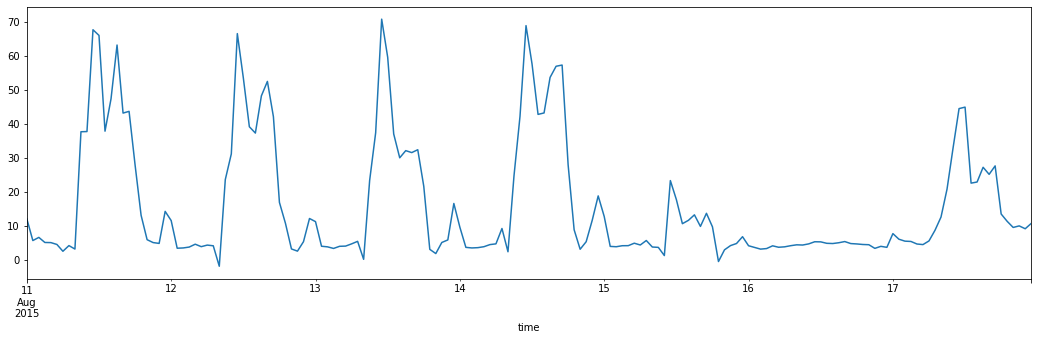

In [64]:
total_pred = (total_pred1 + total_pred2 + total_pred3 + total_pred4) / 4
total_pred[120:144] = total_pred2[120:144]

old_data = pd.read_csv("../data/submit_2023-04-26T10-59.csv")
delta = total_pred - old_data["total"].values
total_pred = total_pred + 2 * delta

data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"] = total_pred
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18, 5))

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [65]:
results = DataFrame(index=pd.date_range(start="2015-08-11 00:00:00", end="2015-08-17 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred, _min_val_=0)
results['light'] = clip_value(light_pred, _min_val_=0)
results['air'] = clip_value(air_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

total    socket     light        air
2015-08-11 00:00:00  12.101545  0.738434  1.523004  10.617532
2015-08-11 01:00:00   5.721378  0.526807  0.637142   5.600596
2015-08-11 02:00:00   6.647504  0.607840  0.554603   6.246753
2015-08-11 03:00:00   5.157023  0.415319  0.333400   5.739242
2015-08-11 04:00:00   5.119512  0.542648  0.328648   5.804901
...                        ...       ...       ...        ...
2015-08-17 19:00:00  11.364005  0.896042  2.784184  13.792804
2015-08-17 20:00:00   9.564988  0.774411  0.561616  11.054977
2015-08-17 21:00:00  10.023845  0.757094  0.301577  11.132021
2015-08-17 22:00:00   9.183717  0.902716  0.138718  10.802750
2015-08-17 23:00:00  10.746850  0.680350  0.769393  10.127069

[168 rows x 4 columns]

In [66]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)